In [1]:
!pip install -q langchain langgraph transformers accelerate

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda")

/home/jungi.byun/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.42it/s]


In [3]:
from typing import TypedDict, Optional, Dict, Any, Annotated, List
from langgraph.graph import StateGraph, END

class GeometryState(TypedDict):
    input_section: str
    section_description: str
    math_concept: str = ""
    parameters: Optional[Dict[str, Any]]
    hint_type: str = "" # none, svg, formula, both
    generated_code: Optional[str]
    comments: str = ""
    formulas: Optional[Dict[str, str]]

In [4]:
sections_info = {
    "직선 알아보기": {
        "description": "직선을 보고 이름을 붙이며, 직선의 개념을 이해한다.",
        "math_concept": "직선",
        "hint_type": "svg",
    },
    "각 알아보기": {
        "description": "각의 구성 요소(꼭짓점, 변)를 알고 각을 인식할 수 있다.",
        "math_concept": "각",
        "hint_type": "svg",
    },
    "직각 알아보기": {
        "description": "직각을 판단하고, 직각과 다른 각을 구별할 수 있다.",
        "math_concept": "직각",
        "parameters": {"size": 90},
        "hint_type": "svg",
    },
    "직각삼각형 알아보기": {
        "description": "직각삼각형을 식별하고, 구성 요소(변, 각)를 이해한다.",
        "math_concept": "직각삼각형",
        "hint_type": "svg",
    },
    "직사각형의 특징 알아보기": {
        "description": "직사각형을 다른 사각형과 구별하고 그 특징을 설명할 수 있다.",
        "math_concept": "직사각형",
        "hint_type": "svg",
    },
    "정사각형의 특징 알아보기": {
        "description": "정사각형을 다른 사각형과 구별하고 그 특징을 설명할 수 있다.",
        "math_concept": "정사각형",
        "hint_type": "svg",
    },
    "원의 반지름과 지름 알아보기": {
        "description": "원의 반지름과 지름의 관계를 알고, 직접 측정하거나 구할 수 있다.",
        "math_concept": "원",
        "hint_type": "both",
    },
    "지름의 성질 알아보기": {
        "description": "지름과 반지름의 관계를 바탕으로 길이를 비교하거나 구한다.",
        "math_concept": "원",
        "hint_type": "both",
    },
    "원 그리기": {
        "description": "컴퍼스를 이용하여 정확한 원을 그리고 반지름/지름을 표시할 수 있다.",
        "math_concept": "원",
        "hint_type": "svg",
    },
    "원을 이용하여 여러 가지 모양 그리기": {
        "description": "원의 특성을 이용해 창의적인 도형이나 패턴을 구성한다.",
        "math_concept": "여러 가지 모양(원)",
        "hint_type": "svg",
    },
    "각의 크기 비교하기": {
        "description": "직각, 예각, 둔각 등을 비교하여 각의 크기를 판단한다.",
        "math_concept": "각",
        "hint_type": "svg"
    },
    "각도기를 이용하여 각도 재기": {
        "description": "각도기를 바르게 사용하여 각의 크기를 정확히 잴 수 있다.",
        "math_concept": "각도",
        "hint_type": "svg",
    },
    "각도를 나타내는 단위 알아보기": {
        "description": "각의 크기를 도(°) 단위로 표현하고, 단위 개념을 이해한다.",
        "math_concept": "각도",
        "hint_type": "svg",
    },
    "각도기와 자를 이용하여 각 그리기": {
        "description": "각도기와 자를 이용해 주어진 각도를 정확히 그릴 수 있다.",
        "math_concept": "각",
        "hint_type": "svg",
    },
    "예각과 둔각 알아보기": {
        "description": "주어진 각을 예각, 직각, 둔각으로 분류할 수 있다.",
        "math_concept": "예각과 둔각",
        "hint_type": "svg",
    },
    "각도를 어림하고 각도기로 재어 확인하기": {
        "description": "주어진 각도를 어림하고 각도기로 재어 확인한다.",
        "math_concept": "각도",
        "hint_type": "svg",
    },
    "각도의 합 또는 차의 활용": {
        "description": "주어진 상황에서 두 각의 크기를 더하거나 빼는 문제를 해결한다.",
        "math_concept": "각도의 합/차",
        "hint_type": "formula",
    },
    "두 각도의 차 구하기": {
        "description": "두 각도를 큰 각에서 작은 각을 빼서 더 작은 각을 만들 수 있다.",
        "math_concept": "각도의 합/차",
        "hint_type": "formula",
    },
    "두 각도의 합 구하기": {
        "description": "두 각도를 더하여 더 큰 각을 만들 수 있다.",
        "math_concept": "각도의 합/차",
        "hint_type": "formula",
    },
    "삼각형에서 나머지 한 각의 크기 구하기": {
        "description": "삼각형의 세 각의 합이 180°인 사실을 이용하여 두 각의 크기가 주어졌을 때 나머지 한 각의 크기를 구할 수 있다.",
        "math_concept": "삼각형의 내각의 합",
        "hint_type": "formula",
    },
    "삼각형의 세 각의 크기의 합 구하기": {
        "description": "삼각형의 세 각의 크기의 합을 구하여 삼각형의 내각의 합이 180°인 사실을 확인한다.",
        "math_concept": "삼각형의 내각의 합",
        "hint_type": "formula",
    },
    "사각형의 나머지 한 각의 크기 구하기": {
        "description": "사각형의 네 각의 합이 360°인 사실을 이용하여 세 각의 크기가 주어졌을 때 나머지 한 각의 크기를 구할 수 있다.",
        "math_concept": "사각형의 내각의 합",
        "hint_type": "formula",
    },
    "사각형의 네 각의 크기의 합 구하기": {
        "description": "사각형의 네 각의 크기의 합을 구하여 사각형의 내각의 합이 360°인 사실을 확인한다.",
        "math_concept": "사각형의 내각의 합",
        "hint_type": "formula",
    },
    "삼각형의 변의 길이에 따라 분류하기": {
        "description": "삼각형의 변의 길이에 따라 일반삼각형, 이등변삼각형과 정삼각형으로 분류할 수 있다.",
        "math_concept": "삼각형 분류(변)",
        "hint_type": "svg",
    },
    "이등변삼각형 알아보기": {
        "description": "삼각형에서 두 변의 길이가 같은 이등변삼각형을 이해한다.",
        "math_concept": "이등변삼각형",
        "hint_type": "svg",
    },
    "이등변삼각형의 성질 알아보기": {
        "description": "삼각형에서 두 변의 길이가 같은 이등변삼각형의 성질을 이해한다.",
        "math_concept": "이등변삼각형",
        "hint_type": "svg",
    },
    "각을 이용하여 이등변삼각형 그리기": {
        "description": "한 선분의 양 끝에서 각각 마주보는 방향으로 같은 각도로 선분을 그어 이등변삼각형을 그릴 수 있다.",
        "math_concept": "이등변삼각형",
        "hint_type": "svg",
    },
    "정삼각형 알아보기": {
        "description": "삼각형에서 세 변의 길이가 같은 정삼각형을 이해한다.",
        "math_concept": "정삼각형",
        "hint_type": "svg",
    },
    "정삼각형의 성질 알아보기": {
        "description": "정삼각형의 각과 변의 성질을 설명하고 활용할 수 있다.",
        "math_concept": "정삼각형",
        "hint_type": "svg",
    },
    "각을 이용하여 정삼각형 그리기": {
        "description": "한 선분의 양 끝에서 각각 마주보는 방향으로 60°로 선분을 그어 정삼각형을 그릴 수 있다.",
        "math_concept": "정삼각형",
        "hint_type": "svg",
    },
    "삼각형을 각의 크기에 따라 분류하기": {
        "description": "삼각형을 각의 크기에 따라 예각삼각형, 직각삼각형, 둔각삼각형으로 올바르게 분류할 수 있다.",
        "math_concept": "삼각형 분류(각)",
        "hint_type": "svg",
    },
    "예각삼각형 알아보기": {
        "description": "세 각이 모두 예각인 예각삼각형을 식별하고 특징을 이해한다.",
        "math_concept": "예각삼각형",
        "hint_type": "svg",
    },
    "둔각삼각형 알아보기": {
        "description": "삼각형의 세 각 중 하나가 둔각인 둔각삼각형을 구별하고 특징을 설명할 수 있다.",
        "math_concept": "둔각삼각형",
        "hint_type": "svg",
    },
    "삼각자와 각도기를 이용한 수선 긋기": {
        "description": "도구를 이용해 주어진 점에서 직선에 수선을 정확히 그릴 수 있다.",
        "math_concept": "수선",
        "hint_type": "svg",
    },
    "수직": {
        "description": "수직의 개념을 이해하고 도형에서 수직선을 찾거나 그릴 수 있다.",
        "math_concept": "수직",
        "hint_type": "svg",
    },
    "평행 알아보기": {
        "description": "평행선의 정의를 이해하고 구별할 수 있다.",
        "math_concept": "평행선",
        "hint_type": "svg",
    },
    "삼각자를 사용하여 평행선 긋기": {
        "description": "삼각자를 사용해 정확하게 평행선을 그릴 수 있다.",
        "math_concept": "평행선",
        "hint_type": "svg",
    },
    "주어진 거리의 평행선 긋기": {
        "description": "자와 삼각자를 활용해 주어진 거리만큼 떨어진 평행선을 그린다.",
        "math_concept": "평행선",
        "hint_type": "svg",
    },
    "평행선 사이의 거리 알아보기": {
        "description": "평행선 사이의 거리를 측정하고 설명할 수 있다.",
        "math_concept": "평행선 사이의 거리",
        "hint_type": "svg",
    },
    "직사각형의 성질 알아보기": {
        "description": "직사각형의 정의와 성질을 알고 도형을 분류한다.",
        "math_concept": "직사각형의 성질",
        "hint_type": "svg",
        
    },
    "정사각형의 성질 알아보기": {
        "description": "정사각형의 정의와 변, 각, 대각선의 성질을 이해하고 다른 사각형과 구별할 수 있다.",
        "math_concept": "정사각형의 성질",
        "hint_type": "svg",
        
    },
    "직사각형과 정사각형의 성질 활용": {
        "description": "두 도형의 성질을 바탕으로 실생활 문제를 해결한다.",
        "math_concept": "직사각형/정사각형의 성질 활용",
        "hint_type": "svg",
    },
    "사다리꼴 알아보기": {
        "description": "사다리꼴의 정의와 기본 성질을 이해한다.",
        "math_concept": "사다리꼴",
        "hint_type": "svg",
    },
    "평행사변형 알아보기": {
        "description": "평행사변형을 정의하고 특징을 파악한다.",
        "math_concept": "평행사변형",
        "hint_type": "svg",
    },
    "평행사변형의 성질 알아보기": {
        "description": "평행사변형의 성질을 이해하고 구분할 수 있다.",
        "math_concept": "평행사변형",
        "hint_type": "svg",
    },
    "마름모 알아보기": {
        "description": "마름모의 정의와 성질을 알고 구별할 수 있다.",
        "math_concept": "마름모",
        "hint_type": "svg",
    },
    "마름모의 성질 알아보기": {
        "description": "마름모의 대각선 성질을 이해하고 활용한다.",
        "math_concept": "마름모",
        "hint_type": "svg",
    },
}

In [5]:
def classify_sections(state: GeometryState) -> GeometryState:
    """
    소단원(Section)을 보고 힌트를 제공하는데 필요한 수학 개념과 관련된 인자, 힌트 유형(none, svg, formula, both)을 분류한다
    """

    section = state["input_section"]
    section_info = sections_info[section]

    state["section_description"] = section_info["description"]
    state["math_concept"] = section_info["math_concept"]
    if "parameters" in section_info.keys():
        state["parameters"] = section_info["parameters"]
    if "expressions" in section_info.keys():
        state["expressions"] = section_info["expressions"]
    state["hint_type"] = section_info["hint_type"]

    return state    

In [6]:
def activate_nodes_by_state(state: GeometryState) -> list[str]:
    """
    소단원(Section)을 보고 분류된 정보가 기입된 state를 확인하여 힌트 생성에 필요한 노드를 선택한다
    """

    activated_nodes = ["generate_comments"]
    hint_type = state["hint_type"]
    if hint_type == "svg":
        activated_nodes.append("generate_code")
    elif hint_type == "formula":
        activated_nodes.append("generate_formulas")
    elif hint_type == "both":
        activated_nodes.extend(["generate_code", "generate_formulas"])
    else: # hint_type == "none"
        pass

    return activated_nodes

In [7]:
def gen_lines_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    곧은선(선분, 반직선, 직선)의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자
    
    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    
    x0, y0 = svg_frame // 4, svg_frame // 4
    x1, y1 = svg_frame // 4, svg_frame // 2
    x2, y2 = svg_frame // 4, (svg_frame * 3) // 4

    distance = svg_frame // 2

    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 20}" font-size="{svg_frame // 20}" text-anchor="middle">곧은선</text>
    <text x="{svg_frame // 2}" y="{(svg_frame * 4) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="{x0}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x0 + distance}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 반직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 9) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">반직선</text>
    <circle cx="{x1}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x1 + distance}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x1}" y1="{y1}" x2="{svg_frame}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 14) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">직선</text>
    <circle cx="{x2}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x2 + distance}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="0" y1="{y2}" x2="{svg_frame}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [8]:
import math

def gen_curves_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    굽은선(곡선)의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    
    svg_content = f'''
    <svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M {svg_frame // 5},{(svg_frame * 4) // 5}
    C {svg_frame // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 2}
    C {(svg_frame * 4) // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{svg_frame // 5}"
    stroke="{stroke}" fill="none" stroke-width="{stroke_width}"/>
    </svg>
    '''
    return svg_content

In [9]:
import math
import random

def gen_angle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    기준선과 기울어진 선 + 각도를 나타내는 보조선을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2

    if concept == "각" or concept == "각도":
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else random.randint(1, 179)
    elif concept == "예각":
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else random.randint(1, 89)
    elif concept == "둔각":
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else random.randint(91, 179)
    else:
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else 90
    
    # 기준점
    x0, y0 = svg_frame // 4 if degree <= 90 else svg_frame // 2, (svg_frame * 2) // 3

    # 기준선 끝점 (수평)
    line_length = svg_frame // 2
    x1 = x0 + line_length
    y1 = y0

    # 기울어진 선 끝점
    rad = math.radians(degree)
    x2 = x0 + line_length * math.cos(-rad)
    y2 = y0 + line_length * math.sin(-rad)

    if degree != 90:
        # 호의 시작점 (반지름만큼 떨어진 점)
        arc_radius = svg_frame // 10
        arc_start_x = x0 + arc_radius * math.cos(-rad)
        arc_start_y = y0 + arc_radius * math.sin(-rad)

        # 호의 끝점 (반지름과 각도로 계산)
        arc_end_x = x0 + arc_radius
        arc_end_y = y0

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{(svg_frame * 3) // 4}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 각도 호 -->
        <path d="M {arc_start_x},{arc_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_end_x},{arc_end_y}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선 -->
        <text x="{x0 + arc_radius * 1.25 * math.cos(-rad / 2)}" y="{y0 + arc_radius * 1.25 * math.sin(-rad / 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{degree}°</text>
        </svg>
        '''
    else:
        # 직각 보조선
        epsilon = svg_frame // 10

        h1 = x2 + epsilon
        h2 = y0 - epsilon

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0 - epsilon}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x2}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 직각 보조선 -->
        <polyline points="{h1}, {y0} {h1}, {h2} {x2} {h2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        </svg>
        '''

    return svg_content

In [10]:
import random
import math

def gen_acute_obtuse_angles_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    예각과 둔각의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2

    acute_deg = random.randint(1, 89) # 예각
    obtuse_deg = random.randint(91, 179) # 둔각

    # 기준점
    x_acute_0, y_acute_0 = svg_frame // 3, (svg_frame * 2) // 5
    x_obtuse_0, y_obtuse_0 = svg_frame // 2, (svg_frame * 4) // 5

    # 기준선 끝점 (수평)
    line_length = svg_frame // 4
    x_acute_1, y_acute_1 = x_acute_0 + line_length, y_acute_0
    x_obtuse_1, y_obtuse_1 = x_obtuse_0 + line_length, y_obtuse_0

    # 기울어진 선 끝점
    acute_rad, obtuse_rad = math.radians(acute_deg), math.radians(obtuse_deg)
    x_acute_2, y_acute_2 = x_acute_0 + line_length * math.cos(-acute_rad), y_acute_0 + line_length * math.sin(-acute_rad)
    x_obtuse_2, y_obtuse_2 = x_obtuse_0 + line_length * math.cos(-obtuse_rad), y_obtuse_0 + line_length * math.sin(-obtuse_rad)
    
    # 호의 시작점 (반지름만큼 떨어진 점)
    arc_radius = svg_frame // 10
    arc_acute_start_x, arc_acute_start_y = x_acute_0 + arc_radius * math.cos(-acute_rad), y_acute_0 + arc_radius * math.sin(-acute_rad)
    arc_obtuse_start_x, arc_obtuse_start_y = x_obtuse_0 + arc_radius * math.cos(-obtuse_rad), y_obtuse_0 + arc_radius * math.sin(-obtuse_rad)

    # 호의 끝점 (반지름과 각도로 계산)
    arc_acute_end_x, arc_acute_end_y = x_acute_0 + arc_radius, y_acute_0
    arc_obtuse_end_x, arc_obtuse_end_y = x_obtuse_0 + arc_radius, y_obtuse_0

    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 예각 -->
        <text x="{svg_frame // 2}" y="{(svg_frame * 7) // 40}" font-size="{svg_frame // 25}" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="{x_acute_0}" y1="{y_acute_0}" x2="{x_acute_1}" y2="{y_acute_1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x_acute_0}" y1="{y_acute_0}" x2="{x_acute_2}" y2="{y_acute_2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 각도 호 -->
        <path d="M {arc_acute_start_x},{arc_acute_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_acute_end_x},{arc_acute_end_y}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선 -->
        <text x="{x_acute_0 + arc_radius * 1.25 * math.cos(-acute_rad / 2)}" y="{y_acute_0 + arc_radius * 1.25 * math.sin(-acute_rad / 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{acute_deg}°</text>
        <!-- 둔각 -->
        <text x="{svg_frame // 2}" y="{(svg_frame * 21) // 40}" font-size="{svg_frame // 25}" text-anchor="middle">둔각</text>
        <!-- 기준선 -->
        <line x1="{x_obtuse_0}" y1="{y_obtuse_0}" x2="{x_obtuse_1}" y2="{y_obtuse_1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x_obtuse_0}" y1="{y_obtuse_0}" x2="{x_obtuse_2}" y2="{y_obtuse_2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 각도 호 -->
        <path d="M {arc_obtuse_start_x},{arc_obtuse_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_obtuse_end_x},{arc_obtuse_end_y}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선 -->
        <text x="{x_obtuse_0 + arc_radius * 1.25 * math.cos(-obtuse_rad / 2)}" y="{y_obtuse_0 + arc_radius * 1.25 * math.sin(-obtuse_rad / 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{obtuse_deg}°</text>
        </svg>
    '''
    
    return svg_content

In [11]:
def gen_right_triangle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    직각삼각형의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2

    # 기준점
    rt_base = (svg_frame * 2) // 3
    rt_height = svg_frame // 2
    x0, y0 = svg_frame // 6, (svg_frame * 5) // 6
    x1, y1 = min(x0 + rt_base, (svg_frame * 5) // 6), y0
    x2, y2 = x1, max(y1 - rt_height, svg_frame // 3)

    epsilon = min(rt_base, rt_height) // 10

    h1 = x1 - epsilon
    h2 = y1 - epsilon
    
    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <!-- 직각삼각형 -->
    <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="{h1}, {y1} {h1}, {h2} {x1} {h2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
    </svg>
    '''
    
    return svg_content

In [12]:
def gen_rectangle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    직사각형/정사각형의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    x = svg_frame // 5
    y = svg_frame // 5
    if concept == "정사각형":
        r_width = (svg_frame * 3) // 5
        r_height = r_width
        svg_height = svg_frame
    else:
        r_width = (svg_frame * 3) // 5
        r_height = r_width // 2
        svg_height = min(500, ((y + r_height) * 5) // 4)

    # 사각형이 가로로 중앙에 위치하도록
    x = (svg_frame - r_width) // 2

    epsilon = min(r_width, r_height) // 5
    
    # svg_width = x + width + x, svg_height = y + height + y
    svg_content = f'''<svg width="{svg_frame}" height="{svg_height}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <rect x="{x}" y="{y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    </svg>
    '''
    
    return svg_content

In [13]:
def gen_circle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    원의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"
    
    cx = svg_frame // 2
    cy = cx
    r = svg_frame // 3

    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">원</text>
    <circle cx="{cx}" cy="{cy}" r="{r}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy}" r="{r // 50}" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{cx - r}" y1="{cy}" x2="{cx + r}" y2="{cy}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 보조선 -->
    <path d="M {cx}, {cy} Q {cx + (r // 2)}, {cy - (r // 6)} {cx + r}, {cy}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{cx + (r // 2)}" y="{cy - (r // 6)}" font-size="{svg_frame // 40}" text-anchor="middle">반지름</text>
    <path d="M {cx - r}, {cy} Q {cx}, {cy + (r // 6)} {cx + r}, {cy}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{cx}" y="{cy + (r // 4)}" font-size="{svg_frame // 40}" text-anchor="middle">지름</text>
    </svg>
    '''

    return svg_content

In [14]:
def gen_flower_by_circles(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    원의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    # 꽃 그리기
    cx, cy = svg_frame // 2, svg_frame // 2
    cr = svg_frame // 14

    radius = svg_frame // 7

    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <circle cx="{cx}" cy="{cy}" r="{cr}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx + (cr + radius)}" cy="{cy}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx - (cr + radius)}" cy="{cy}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy - (cr + radius)}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy + (cr + radius)}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    </svg>
    '''

    return svg_content

In [15]:
def gen_triangles_by_length(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    변의 길이에 따른 삼각형(이등변삼각형, 정삼각형)의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    # 이등변삼각형
    isosceles_rad = math.pi / 6
    isosceles_lateral = svg_frame // 2
    isosceles_x0, isosceles_y0 = svg_frame // 4, svg_frame // 4
    isosceles_x1, isosceles_y1 = isosceles_x0 + isosceles_lateral * math.cos((math.pi - isosceles_rad) / 2), isosceles_y0 + isosceles_lateral * math.sin((math.pi - isosceles_rad) / 2)
    isosceles_x2, isosceles_y2 = isosceles_x0 + isosceles_lateral * math.cos((math.pi + isosceles_rad) / 2), isosceles_y0 + isosceles_lateral * math.sin((math.pi + isosceles_rad) / 2)

    isosceles_epsilon = isosceles_lateral // 10
    isosceles_same_tick = isosceles_lateral // 30

    # 정삼각형
    equilateral_rad = math.pi / 3
    equilateral_lateral = svg_frame // 2
    equilateral_x0, equilateral_y0 = (svg_frame * 3) // 4, svg_frame // 4
    equilateral_x1, equilateral_y1 = equilateral_x0 + equilateral_lateral * math.cos(equilateral_rad), equilateral_y0 + equilateral_lateral * math.sin(equilateral_rad)
    equilateral_x2, equilateral_y2 = equilateral_x0 + equilateral_lateral * math.cos(2 * equilateral_rad), equilateral_y0 + equilateral_lateral * math.sin(2 * equilateral_rad)

    equilateral_epsilon = equilateral_lateral // 10
    equilateral_same_tick = equilateral_lateral // 30
    
    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <!-- 아등변삼각형 -->
    <text x="{svg_frame // 4}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">이등변삼각형</text>
    <polygon points="{isosceles_x0},{isosceles_y0} {isosceles_x1},{isosceles_y1} {isosceles_x2},{isosceles_y2}" stroke="{stroke}"
    stroke-width="{stroke_width}" fill="none"/>
    <!-- 보조선들 -->
    <line x1="{(isosceles_x0 + isosceles_x1) / 2 - isosceles_same_tick * math.cos((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    y1="{(isosceles_y0 + isosceles_y1) / 2 - isosceles_same_tick * math.sin((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    x2="{(isosceles_x0 + isosceles_x1)/ 2 + isosceles_same_tick * math.cos((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    y2="{(isosceles_y0 + isosceles_y1) / 2 + isosceles_same_tick * math.sin((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{(isosceles_x0 + isosceles_x2) / 2 - isosceles_same_tick * math.cos((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    y1="{(isosceles_y0 + isosceles_y2) / 2 - isosceles_same_tick * math.sin((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    x2="{(isosceles_x0 + isosceles_x2)/ 2 + isosceles_same_tick * math.cos((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    y2="{(isosceles_y0 + isosceles_y2) / 2 + isosceles_same_tick * math.sin((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    
    <!-- 정삼각형 -->
    <text x="{(svg_frame * 3) // 4}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">정삼각형</text>
    <polygon points="{equilateral_x0},{equilateral_y0} {equilateral_x1},{equilateral_y1} {equilateral_x2},{equilateral_y2}" stroke="{stroke}"
    stroke-width="{stroke_width}" fill="none"/>
    <!-- 보조선들 -->
    <line x1="{(equilateral_x0 + equilateral_x1) / 2 - equilateral_same_tick * math.cos(equilateral_rad + math.pi / 2)}"
    y1="{(equilateral_y0 + equilateral_y1) / 2 - equilateral_same_tick * math.sin(equilateral_rad + math.pi / 2)}"
    x2="{(equilateral_x0 + equilateral_x1)/ 2 + equilateral_same_tick * math.cos(equilateral_rad + math.pi / 2)}"
    y2="{(equilateral_y0 + equilateral_y1) / 2 + equilateral_same_tick * math.sin(equilateral_rad + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{(equilateral_x1 + equilateral_x2) / 2 - equilateral_same_tick * math.cos(math.pi / 2)}"
    y1="{(equilateral_y1 + equilateral_y2) / 2 - equilateral_same_tick * math.sin(math.pi / 2)}"
    x2="{(equilateral_x1 + equilateral_x2) / 2 + equilateral_same_tick * math.cos(math.pi / 2)}"
    y2="{(equilateral_y1 + equilateral_y2) / 2 + equilateral_same_tick * math.sin(math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{(equilateral_x0 + equilateral_x2) / 2 - equilateral_same_tick * math.cos(2 * equilateral_rad + math.pi / 2)}"
    y1="{(equilateral_y0 + equilateral_y2) / 2 - equilateral_same_tick * math.sin(2 * equilateral_rad + math.pi / 2)}"
    x2="{(equilateral_x0 + equilateral_x2) / 2 + equilateral_same_tick * math.cos(2 * equilateral_rad + math.pi / 2)}"
    y2="{(equilateral_y0 + equilateral_y2) / 2 + equilateral_same_tick * math.sin(2 * equilateral_rad + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''

    return svg_content

In [16]:
import math

def gen_isosceles_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    이등변삼각형과 정삼각형의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if concept == "정삼각형":
        # 정삼각형
        rad = math.pi / 3
        lateral = svg_frame // 2
        x0, y0 = svg_frame // 2, svg_frame // 4
        x1, y1 = x0 + lateral * math.cos(rad), y0 + lateral * math.sin(rad)
        x2, y2 = x0 + lateral * math.cos(2 * rad), y0 + lateral * math.sin(2 * rad)

        epsilon = lateral // 10
        same_tick = lateral // 30

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 정삼각형 -->
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선들 -->
        <line x1="{(x0 + x1) / 2 - same_tick * math.cos(rad + math.pi / 2)}" y1="{(y0 + y1) / 2 - same_tick * math.sin(rad + math.pi / 2)}"
        x2="{(x0 + x1)/ 2 + same_tick * math.cos(rad + math.pi / 2)}" y2="{(y0 + y1) / 2 + same_tick * math.sin(rad + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x1 + x2) / 2 - same_tick * math.cos(math.pi / 2)}" y1="{(y1 + y2) / 2 - same_tick * math.sin(math.pi / 2)}"
        x2="{(x1 + x2) / 2 + same_tick * math.cos(math.pi / 2)}" y2="{(y1 + y2) / 2 + same_tick * math.sin(math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x0 + x2) / 2 - same_tick * math.cos(2 * rad + math.pi / 2)}" y1="{(y0 + y2) / 2 - same_tick * math.sin(2 * rad + math.pi / 2)}"
        x2="{(x0 + x2) / 2 + same_tick * math.cos(2 * rad + math.pi / 2)}" y2="{(y0 + y2) / 2 + same_tick * math.sin(2 * rad + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <path d="M {x0 + epsilon * math.cos(rad)},{y0 + epsilon * math.sin(rad)} A {epsilon},{epsilon} 0 0,1
        {x0 + epsilon * math.cos(2 * rad)},{y0 + epsilon * math.sin(2 * rad)}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x1 - epsilon},{y2} A {epsilon},{epsilon} 0 0,1
        {x1 + epsilon * math.cos(-(math.pi + rad) / 2)},{y1 + epsilon * math.sin(-(math.pi + rad) / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x2 + epsilon * math.cos(-math.pi/3)},{y2 + epsilon * math.sin(-math.pi/3)} A {epsilon},{epsilon} 0 0,1
        {x2 + epsilon},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    else:
        # 이등변삼각형
        rad = math.pi / 6
        lateral = svg_frame // 2
        x0, y0 = svg_frame // 2, svg_frame // 4
        x1, y1 = x0 + lateral * math.cos((math.pi - rad) / 2), y0 + lateral * math.sin((math.pi - rad) / 2)
        x2, y2 = x0 + lateral * math.cos((math.pi + rad) / 2), y0 + lateral * math.sin((math.pi + rad) / 2)

        epsilon = lateral // 10
        same_tick = lateral // 30

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선들 -->
        <line x1="{(x0 + x1) / 2 - same_tick * math.cos((math.pi - rad) / 2 + math.pi / 2)}"
        y1="{(y0 + y1) / 2 - same_tick * math.sin((math.pi - rad) / 2 + math.pi / 2)}"
        x2="{(x0 + x1)/ 2 + same_tick * math.cos((math.pi - rad) / 2 + math.pi / 2)}"
        y2="{(y0 + y1) / 2 + same_tick * math.sin((math.pi - rad) / 2 + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x0 + x2) / 2 - same_tick * math.cos((math.pi + rad) / 2 + math.pi / 2)}"
        y1="{(y0 + y2) / 2 - same_tick * math.sin((math.pi + rad) / 2 + math.pi / 2)}"
        x2="{(x0 + x2)/ 2 + same_tick * math.cos((math.pi + rad) / 2 + math.pi / 2)}"
        y2="{(y0 + y2) / 2 + same_tick * math.sin((math.pi + rad) / 2 + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <path d="M {x1 - epsilon},{y2} A {epsilon},{epsilon} 0 0,1
        {x1 + epsilon * math.cos(-(math.pi + rad) / 2)},{y1 + epsilon * math.sin(-(math.pi + rad) / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x2 + epsilon * math.cos(-(math.pi - rad) / 2)},{y2 + epsilon * math.sin(-(math.pi - rad) / 2)} A {epsilon},{epsilon} 0 0,1
        {x2 + epsilon},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
        
    return svg_content

In [17]:
import math

def gen_triangles_by_angle(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    각의 크기에 따른 삼각형(예각삼각형, 직각삼각형, 둔각삼각형)의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    # 예각삼각형
    x_acute_0, y_acute_0 = svg_frame // 6, svg_frame // 4
    x_acute_1, y_acute_1 = svg_frame // 10, (svg_frame * 4) // 5
    x_acute_2, y_acute_2 = (svg_frame * 3) // 10, (svg_frame * 4) // 5

    epsilon = svg_frame // 30

    # 직각삼각형
    x_right_0, y_right_0 = (svg_frame * 2) // 5, svg_frame // 4
    x_right_1, y_right_1 = (svg_frame * 2) // 5, (svg_frame * 4) // 5
    x_right_2, y_right_2 = (svg_frame * 3) // 5, (svg_frame * 4) // 5

    # 둔각삼각형
    rad = math.radians(75)
    lateral = (svg_frame * 11) // 20
    x_obtuse_1, y_obtuse_1 = (svg_frame * 7) // 10, (svg_frame * 4) // 5
    x_obtuse_2, y_obtuse_2 = (svg_frame * 5) // 6, (svg_frame * 4) // 5
    x_obtuse_0, y_obtuse_0 = x_obtuse_2 + lateral * math.cos(-rad), y_obtuse_2 + lateral * math.sin(-rad)

    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <!-- 예각삼각형 -->
    <text x="{svg_frame // 6}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">예각삼각형</text>
    <polygon points="{x_acute_0},{y_acute_0} {x_acute_1},{y_acute_1} {x_acute_2},{y_acute_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="{svg_frame // 2}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">직각삼각형</text>
    <polygon points="{x_right_0},{y_right_0} {x_right_1},{y_right_1} {x_right_2},{y_right_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <polyline points="{x_right_1 + epsilon}, {y_right_1} {x_right_1 + epsilon}, {y_right_1 - epsilon} {x_right_1} {y_right_1 - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
    <!-- 둔각삼각형 -->
    <text x="{(svg_frame * 5) // 6}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">둔각삼각형</text>
    <polygon points="{x_obtuse_0},{y_obtuse_0} {x_obtuse_1},{y_obtuse_1} {x_obtuse_2},{y_obtuse_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <path d="M {x_obtuse_2 - epsilon},{y_obtuse_2} A {epsilon},{epsilon} 0 0,1 {x_obtuse_2 + epsilon * math.cos(-rad)},{y_obtuse_2 + epsilon * math.sin(-rad)}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    </svg>
    '''
        
    return svg_content

In [18]:
import math

def gen_acute_obtuse_triangles(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    예각삼각형, 둔각삼각형의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if concept == "둔각삼각형":
        x_0, y_0 = svg_frame * 3 // 4, svg_frame // 4 
        x_1, y_1 = svg_frame // 5, (svg_frame * 4) // 5
        x_2, y_2 = (svg_frame * 3) // 5, (svg_frame * 4) // 5

        rad = math.atan((y_2 - y_0) / (x_2 - x_0))
        epsilon = svg_frame // 30
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x_0},{y_0} {x_1},{y_1} {x_2},{y_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x_2 - epsilon},{y_2} A {epsilon},{epsilon} 0 0,1 {x_2 + epsilon * math.cos(rad)},{y_2 + epsilon * math.sin(rad)}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    else:
        # 예각 삼각형
        x_0, y_0 = svg_frame // 3, svg_frame // 4 
        x_1, y_1 = svg_frame // 5, (svg_frame * 4) // 5
        x_2, y_2 = (svg_frame * 4) // 5, (svg_frame * 4) // 5
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x_0},{y_0} {x_1},{y_1} {x_2},{y_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''

    return svg_content

In [19]:
def gen_parallel_lines_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    평행선의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if "거리" in concept:
        x0, y0 = svg_frame // 4, (svg_frame * 3) // 4
        x1, y1 = x0, svg_frame // 4
        distance = svg_frame // 2

        distance_x = x0 + (distance // 3)
        epsilon = svg_frame // 15

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기준선과 평행선 -->
        <line x1="{x1}" y1="{y1}" x2="{x1 + distance}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 거리 -->
        <line x1="{distance_x}" y1="{y0}" x2="{distance_x}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <polyline points="{distance_x + epsilon}, {y0} {distance_x + epsilon}, {y0 - epsilon} {distance_x} {y0 - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <path d="M {distance_x}, {y0} Q {distance_x - epsilon}, {((y0 + y1) // 2)} {distance_x}, {y1}" fill="none" stroke="{stroke}"
        stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <text x="{distance_x - epsilon}" y="{((y0 + y1) // 2)}" font-size="{svg_frame // 40}" text-anchor="middle">거리</text>
        </svg>
        '''
        pass
    else: # 평행선
        x0, y0 = svg_frame // 4, (svg_frame * 3) // 4
        y1 = svg_frame // 2
        y2 = svg_frame // 4
        distance = svg_frame // 2

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기준선과 평행선들 -->
        <line x1="{x0}" y1="{y1}" x2="{x0 + distance}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0}" y1="{y2}" x2="{x0 + distance}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''

        # Animation - Flutter에서 지원 안 해서 불가능함
        # svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        # <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        # <!-- 기준선 -->
        # <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        # <!-- 움직이는 선: 그룹에 애니메이션 -->
        # <g>
        # <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        # <animateTransform attributeName="transform" type="translate" from="0 0" to="0 {y1 - y0}" dur="4s" repeatCount="indefinite" />
        # </g>
        # <!-- 기준선과 평행선 -->
        # <line x1="{x0}" y1="{y1}" x2="{x0 + distance}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        # </svg>
        # '''

    return svg_content

In [20]:
def gen_rectangle_property(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    직사각형, 정사각형의 성질의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if "직사각형/정사각형" in concept:
        # 직사각형
        r_width = (svg_frame * 3) // 10
        r_height = r_width * 2

        # 직사각형의 위치하도록
        r_x, r_y = (svg_frame - r_width) // 5, svg_frame // 4

        # 정사각형
        s_width = (svg_frame * 3) // 10
        s_height = s_width

        # 정사각형의 위치
        s_x, s_y = (svg_frame + s_width) // 2, svg_frame // 4

        epsilon = min(r_width, r_height) // 8
        same_tick = epsilon // 3
        tick_interval = same_tick // 2
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 직사각형 -->
        <text x="{svg_frame * 7 // 24}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">직사각형</text>
        <rect x="{r_x}" y="{r_y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{r_x + epsilon}, {r_y} {r_x + epsilon}, {r_y + epsilon} {r_x} {r_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{r_x + r_width - epsilon}, {r_y} {r_x + r_width - epsilon}, {r_y + epsilon} {r_x + r_width} {r_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{r_x + epsilon}, {r_y + r_height} {r_x + epsilon}, {r_y + r_height - epsilon} {r_x} {r_y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{r_x + r_width - epsilon}, {r_y + r_height} {r_x + r_width - epsilon}, {r_y + r_height - epsilon} {r_x + r_width} {r_y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{r_x + (r_width / 2) - tick_interval}" y1="{r_y - same_tick}" x2="{r_x + (r_width / 2) - tick_interval}" y2="{r_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + (r_width / 2) - tick_interval}" y1="{r_y + r_height - same_tick}" x2="{r_x + (r_width / 2) - tick_interval}" y2="{r_y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + (r_width / 2) + tick_interval}" y1="{r_y - same_tick}" x2="{r_x + (r_width / 2) + tick_interval}" y2="{r_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + (r_width / 2) + tick_interval}" y1="{r_y + r_height - same_tick}" x2="{r_x + (r_width / 2) + tick_interval}" y2="{r_y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x - same_tick}" y1="{r_y + (r_height / 2)}" x2="{r_x + same_tick}" y2="{r_y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + r_width - same_tick}" y1="{r_y + (r_height / 2)}" x2="{r_x + r_width + same_tick}" y2="{r_y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 정사각형 -->
        <text x="{svg_frame * 19 // 24}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">정사각형</text>
        <rect x="{s_x}" y="{s_y}" width="{s_width}" height="{s_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{s_x + epsilon}, {s_y} {s_x + epsilon}, {s_y + epsilon} {s_x} {s_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{s_x + s_width - epsilon}, {s_y} {s_x + s_width - epsilon}, {s_y + epsilon} {s_x + s_width} {s_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{s_x + epsilon}, {s_y + s_height} {s_x + epsilon}, {s_y + s_height - epsilon} {s_x} {s_y + s_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{s_x + s_width - epsilon}, {s_y + s_height} {s_x + s_width - epsilon}, {s_y + s_height - epsilon} {s_x + s_width} {s_y + s_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{s_x + (s_width / 2) - tick_interval}" y1="{s_y - same_tick}" x2="{s_x + (s_width / 2) - tick_interval}" y2="{s_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + (s_width / 2) - tick_interval}" y1="{s_y + s_height - same_tick}" x2="{s_x + (s_width / 2) - tick_interval}" y2="{s_y + s_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + (s_width / 2) + tick_interval}" y1="{s_y - same_tick}" x2="{s_x + (s_width / 2) + tick_interval}" y2="{s_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + (s_width / 2) + tick_interval}" y1="{s_y + s_height - same_tick}" x2="{s_x + (s_width / 2) + tick_interval}" y2="{s_y + s_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x - same_tick}" y1="{s_y + (s_height / 2) - tick_interval}" x2="{s_x + same_tick}" y2="{s_y + (s_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x - same_tick}" y1="{s_y + (s_height / 2) + tick_interval}" x2="{s_x + same_tick}" y2="{s_y + (s_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + s_width - same_tick}" y1="{s_y + (s_height / 2) - tick_interval}" x2="{s_x + s_width + same_tick}" y2="{s_y + (s_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + s_width - same_tick}" y1="{s_y + (s_height / 2) + tick_interval}" x2="{s_x + s_width + same_tick}" y2="{s_y + (s_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''
    elif "정사각형" in concept:
        r_width = (svg_frame * 3) // 5
        r_height = r_width

        # 사각형이 가로로 중앙에 위치하도록
        x, y = (svg_frame - r_width) // 2, svg_frame // 5

        epsilon = min(r_width, r_height) // 8
        same_tick = epsilon // 5
        tick_interval = same_tick // 2
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <rect x="{x}" y="{y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{x + epsilon}, {y} {x + epsilon}, {y + epsilon} {x} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y} {x + r_width - epsilon}, {y + epsilon} {x + r_width} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + epsilon}, {y + r_height} {x + epsilon}, {y + r_height - epsilon} {x} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y + r_height} {x + r_width - epsilon}, {y + r_height - epsilon} {x + r_width} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x - same_tick}" y1="{y + (r_height / 2) - tick_interval}" x2="{x + same_tick}" y2="{y + (r_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x - same_tick}" y1="{y + (r_height / 2) + tick_interval}" x2="{x + same_tick}" y2="{y + (r_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + r_width - same_tick}" y1="{y + (r_height / 2) - tick_interval}" x2="{x + r_width + same_tick}" y2="{y + (r_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + r_width - same_tick}" y1="{y + (r_height / 2) + tick_interval}" x2="{x + r_width + same_tick}" y2="{y + (r_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''
    else: # 직사각형
        r_width = (svg_frame * 3) // 5
        r_height = r_width // 2

        # 사각형이 가로로 중앙에 위치하도록
        x, y = (svg_frame - r_width) // 2, svg_frame // 5

        epsilon = min(r_width, r_height) // 8
        same_tick = epsilon // 3
        tick_interval = same_tick // 2
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <rect x="{x}" y="{y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{x + epsilon}, {y} {x + epsilon}, {y + epsilon} {x} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y} {x + r_width - epsilon}, {y + epsilon} {x + r_width} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + epsilon}, {y + r_height} {x + epsilon}, {y + r_height - epsilon} {x} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y + r_height} {x + r_width - epsilon}, {y + r_height - epsilon} {x + r_width} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x - same_tick}" y1="{y + (r_height / 2)}" x2="{x + same_tick}" y2="{y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + r_width - same_tick}" y1="{y + (r_height / 2)}" x2="{x + r_width + same_tick}" y2="{y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''

    return svg_content

In [21]:
import math

def gen_various_quadrangles_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    사다리꼴, 평행사변형, 마름모의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if concept == "사다리꼴":
        # 좌상단 좌표
        x0, y0 = svg_frame // 3, svg_frame // 4
        
        upper_width = svg_frame // 3
        extend = svg_frame // 6
        height = svg_frame // 2

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x0},{y0} {x0 + upper_width},{y0} {x0 + upper_width + extend},{y0 + height} {x0 - extend},{y0 + height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    elif concept == "평행사변형":
        # 좌상단 좌표
        x0, y0 = svg_frame // 3, svg_frame // 4
        
        width = svg_frame // 3
        extend = svg_frame // 6
        height = svg_frame // 2

        rad = math.atan(height / extend)

        same_tick = svg_frame // 50
        tick_interval = same_tick // 4

        epsilon = svg_frame // 20
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x0},{y0} {x0 + width},{y0} {x0 + width - extend},{y0 + height} {x0 - extend},{y0 + height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="{x0 + (width / 2) - tick_interval}" y1="{y0 - same_tick}" x2="{x0 + (width / 2) - tick_interval}" y2="{y0 + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + (width / 2) + tick_interval}" y1="{y0 - same_tick}" x2="{x0 + (width / 2) + tick_interval}" y2="{y0 + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + (width / 2) -extend - tick_interval}" y1="{y0 + height - same_tick}" x2="{x0 + (width / 2) -extend - tick_interval}" y2="{y0 + height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + (width / 2) -extend + tick_interval}" y1="{y0 + height - same_tick}" x2="{x0 + (width / 2) -extend + tick_interval}" y2="{y0 + height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 - (extend / 2) - same_tick}" y1="{y0 + (height / 2)}" x2="{x0 - (extend / 2) + same_tick}" y2="{y0 + (height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + width - (extend / 2) - same_tick}" y1="{y0 + (height / 2)}" x2="{x0 + width - (extend / 2) + same_tick}" y2="{y0 + (height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 등각 보조선 -->
        <path d="M {x0 + epsilon},{y0} A {epsilon},{epsilon} 0 0,1 {x0 + epsilon * math.cos(math.pi - rad)},{y0 + epsilon * math.sin(math.pi - rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x0 + width - extend - epsilon},{y0 + height} A {epsilon},{epsilon} 0 0,1 {x0 + width - extend + epsilon * math.cos(-rad)},{y0 + height+ epsilon * math.sin(-rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x0 + width + epsilon * math.cos(math.pi - rad)},{y0 + epsilon * math.sin(math.pi - rad)} A {epsilon},{epsilon} 0 0,1 {x0 + width - epsilon},{y0}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x0 - extend + epsilon * math.cos(-rad)},{y0 + height + epsilon * math.sin(-rad)} A {epsilon},{epsilon} 0 0,1 {x0 - extend + epsilon},{y0 + height}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    elif concept == "마름모":
        # 상단 꼭짓점
        tx, ty = svg_frame // 2, svg_frame // 4
        # 좌측 꼭짓점
        lx, ly = svg_frame // 6, svg_frame // 2
        # 우측 꼭짓점
        rx, ry = (svg_frame * 5) // 6, svg_frame // 2
        # 하단 꼭짓점
        bx, by = svg_frame // 2, (svg_frame * 3) // 4

        same_tick = svg_frame // 50
        rad = math.atan((ly - ty) / (tx - lx))
        epsilon = svg_frame // 25

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{tx},{ty} {rx},{ry} {bx},{by} {lx},{ly}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="{(lx + tx) / 2 - same_tick * math.cos(math.pi / 2 - rad)}" y1="{(ly + ty) / 2 - same_tick * math.sin(math.pi / 2 - rad)}" x2="{(lx + tx) / 2 + same_tick * math.cos(math.pi / 2 - rad)}" y2="{(ly + ty) / 2 + same_tick * math.sin(math.pi / 2 - rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(rx + bx) / 2 - same_tick * math.cos(math.pi / 2 - rad)}" y1="{(ry + by) / 2 - same_tick * math.sin(math.pi / 2 - rad)}" x2="{(rx + bx) / 2 + same_tick * math.cos(math.pi / 2 - rad)}" y2="{(ry + by) / 2 + same_tick * math.sin(math.pi / 2 - rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(lx + bx) / 2 - same_tick * math.cos(-rad)}" y1="{(ly + by) / 2 - same_tick * math.sin(-rad)}" x2="{(lx + bx) / 2 + same_tick * math.cos(-rad)}" y2="{(ly + by) / 2 + same_tick * math.sin(-rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(rx + tx) / 2 - same_tick * math.cos(-rad)}" y1="{(ry + ty) / 2 - same_tick * math.sin(-rad)}" x2="{(rx + tx) / 2 + same_tick * math.cos(-rad)}" y2="{(ry + ty) / 2 + same_tick * math.sin(-rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 등각 보조선 -->
        <path d="M {tx + epsilon * math.cos(rad)},{ty + epsilon * math.sin(rad)} A {epsilon},{epsilon} 0 0,1 {tx + epsilon * math.cos(math.pi - rad)},{ty + epsilon * math.sin(math.pi - rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {bx - epsilon * math.cos(rad)},{by - epsilon * math.sin(rad)} A {epsilon},{epsilon} 0 0,1 {bx - epsilon * math.cos(math.pi - rad)},{by - epsilon * math.sin(math.pi - rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {lx + epsilon * math.cos(-rad)},{ly + epsilon * math.sin(-rad)} A {epsilon},{epsilon} 0 0,1 {lx + epsilon * math.cos(rad)},{ly + epsilon * math.sin(rad)}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {rx + epsilon * math.cos(math.pi - rad)},{ry + epsilon * math.sin(math.pi - rad)} A {epsilon},{epsilon} 0 0,1 {rx + epsilon * math.cos(-math.pi + rad)},{ry + epsilon * math.sin(-math.pi + rad)}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    else: # 일반사각형
        # 좌상단 좌표
        x0, y0 = svg_frame // 3, svg_frame // 4
        upper_width = svg_frame // 3
        extend = svg_frame // 6
        height = svg_frame // 2

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x0},{y0} {x0 + upper_width},{y0 + extend} {x0 + upper_width + extend},{y0 + height} {x0 - extend},{y0 + height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''

    return svg_content

In [22]:
def generate_code_node(state: GeometryState) -> GeometryState:
    
    concept = state["math_concept"]
    parameters = state["parameters"] if "parameters" in state.keys() else None

    if concept == "직선":
        code = gen_lines_prototype(concept, parameters)
    elif concept == "각" or concept == "각도" or concept == "직각" or concept == "수직" or concept == "수선":
        code = gen_angle_prototype(concept, parameters)
    elif concept == "직각삼각형":
        code = gen_right_triangle_prototype(concept, parameters)
    elif concept == "직사각형" or concept == "정사각형":
        code = gen_rectangle_prototype(concept, parameters)
    elif concept == "원" or concept == "반지름" or concept == "지름":
        code = gen_circle_prototype(concept, parameters)
    elif concept == "여러 가지 모양(원)":
        code = gen_flower_by_circles(concept, parameters)
    elif concept == "예각과 둔각":
        code = gen_acute_obtuse_angles_prototype(concept, parameters)
    elif concept == "삼각형 분류(변)":
        code = gen_triangles_by_length(concept, parameters)
    elif concept == "이등변삼각형" or concept == "정삼각형":
        code = gen_isosceles_prototype(concept, parameters)
    elif concept == "삼각형 분류(각)":
        code = gen_triangles_by_angle(concept, parameters)
    elif concept == "예각삼각형" or concept == "둔각삼각형":
        code = gen_acute_obtuse_triangles(concept, parameters)
    elif concept == "평행선" or concept == "평행선 사이의 거리":
        code = gen_parallel_lines_prototype(concept, parameters)
    elif concept == "직사각형의 성질" or concept == "정사각형의 성질" or concept == "직사각형/정사각형의 성질 활용":
        code = gen_rectangle_property(concept, parameters)
    elif concept == "사다리꼴" or concept == "평행사변형" or concept == "마름모":
        code = gen_various_quadrangles_prototype(concept, parameters)
    else:
        code = f'''<svg width="{500}" height="{500}" xmlns="http://www.w3.org/2000/svg">
        <text x="{250}" y="{50}" font-size="{12}" text-anchor="middle"># {concept}을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        '''

    # return {**state, "generated_code": code}
    return {"generated_code": code}

In [23]:
LEARNED_ORDER = [
    "직선 알아보기",
    "각 알아보기",
    "직각 알아보기",
    "직각삼각형 알아보기",
    "직사각형의 특징 알아보기",
    "정사각형의 특징 알아보기",
    "원의 반지름과 지름 알아보기",
    "지름의 성질 알아보기",
    "원 그리기",
    "원을 이용하여 여러 가지 모양 그리기",
    "각의 크기 비교하기",
    "각도를 나타내는 단위 알아보기",
    "각도기를 이용하여 각도 재기",
    "각도를 어림하고 각도기로 재어 확인하기",
    "각도기와 자를 이용하여 각 그리기",
    "예각과 둔각 알아보기",
    "두 각도의 합 구하기",
    "두 각도의 차 구하기",
    "각도의 합 또는 차의 활용",
    "삼각형의 세 각의 크기의 합 구하기",
    "삼각형에서 나머지 한 각의 크기 구하기",
    "사각형의 네 각의 크기의 합 구하기",
    "사각형의 나머지 한 각의 크기 구하기",
    "삼각형의 변의 길이에 따라 분류하기",
    "이등변삼각형 알아보기",
    "이등변삼각형의 성질 알아보기",
    "각을 이용하여 이등변삼각형 그리기",
    "정삼각형 알아보기",
    "정삼각형의 성질 알아보기",
    "각을 이용하여 정삼각형 그리기",
    "삼각형을 각의 크기에 따라 분류하기",
    "예각삼각형 알아보기",
    "둔각삼각형 알아보기",
    "삼각자와 각도기를 이용한 수선 긋기",
    "수직",
    "평행 알아보기",
    "삼각자를 사용하여 평행선 긋기",
    "평행선 사이의 거리 알아보기",
    "주어진 거리의 평행선 긋기",
    "직사각형의 성질 알아보기",
    "정사각형의 성질 알아보기",
    "직사각형과 정사각형의 성질 활용",
    "사다리꼴 알아보기",
    "평행사변형 알아보기",
    "평행사변형의 성질 알아보기",
    "마름모 알아보기",
    "마름모의 성질 알아보기",
]

LEARNED_CONCEPTS = {
    "직선 알아보기": ["선분: 두 점을 곧게 이은 선", "반직선: 한 점에서 시작하여 한쪽으로 끝없이 늘인 곧은 선", "직선: 양쪽으로 끝없이 곧게 뻗어나가는 선"],
    "각 알아보기": ["각: 두 선이 만나는 점에서 생기는 도형", "각의 구성 요소(꼭짓점, 변)"],
    "직각 알아보기": ["직각: 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 각"],
    "직각삼각형 알아보기": ["직각삼각형: 한 각이 직각인 삼각형"],
    "직사각형의 특징 알아보기": ["직사각형: 네 각이 모두 직각인 사각형, 마주보는 두 변의 길이가 같다"],
    "정사각형의 특징 알아보기": ["정사각형: 네 변의 길이가 모두 같고 네 각이 모두 직각인 사각형"],
    "원의 반지름과 지름 알아보기": ["원: 한 점에서 같은 거리에 있는 점을 이은 도형", "반지름: 원의 중심에서 원 위의 한 점까지의 거리", "지름: 원의 중심을 지나면서 원의 양 끝을 연결하는 선분", "반지름과 지름의 관계: 지름은 반지름의 두 배"],
    "지름의 성질 알아보기": ["지름의 성질: 지름은 원 안에 그릴 수 있는 가장 긴 선분"],
    "원 그리기": ["컴퍼스를 이용하여 원 그리기: 1) 컴퍼스를 사용하여 중심과 반지름을 정한다. 2) 컴퍼스의 한쪽 끝을 중심에 고정하고, 다른 쪽 끝을 반지름 길이로 조정하여 컴퍼스를 회전하며 원을 그린다."],
    "원을 이용하여 여러 가지 모양 그리기": ["원을 이용하여 여러 가지 모양 그리기(예: 꽃 등)"],
    "각의 크기 비교하기":["각: 한 점에서 그은 두 반직선이 이루는 도형을 말합니다. 이 때, 두 반직선의 시작점을 각의 꼭짓점, 그리고 두 반직선을 각의 변이라고 부릅니다.", "각의 크기 비교하기: 두 각의 크기를 꼭짓점과 하나의 변을 포개놓고, 다른 하나의 변이 얼마나 벌어져있는지 비교하여 어느 각이 더 큰지 또는 같은지 판단합니다."],
    "각도를 나타내는 단위 알아보기":["각도를 나타내는 단위: 각도를 나타내는 단위는 도(°)이며, 직각을 똑같이 90으로 나눈 하나를 1도(°)라고 합니다."],
    "각도기를 이용하여 각도 재기":["각도기를 사용하여 각 그리기: 각도기의 중심과 밑변을 꼭짓점과 기준선에 맞춘 후, 다른 변이 각도기의 몇 도를 지나치는지 확인합니다."],
    "각도를 어림하고 각도기로 재어 확인하기":["각도를 눈 대중으로 어림하고, 각도기로 재어 확인합니다. 이 때, 어림한 각도와 실제 측정한 각도를 비교하여 정확성을 확인합니다."],
    "각도기와 자를 이용하여 각 그리기":["각도기와 자를 이용하여 각 그리기: 1) 자를 사용하여 기준선을 그립니다. 2) 기준선 위의 한 점을 꼭짓점으로 하여, 각도기를 사용하여 그리고 싶은 각도를 점으로 표시합니다. 3) 자를 사용하여 꼭짓점과 방금 전에 표시한 점을 이어 각을 그립니다"],
    "예각과 둔각 알아보기": ["직각보다 작은 각(예각)", "직각보다 큰 각(둔각)"],
    "두 각도의 합 구하기": ["각도의 합 구하기: 두 각의 크기를 더하여 새로운 각을 만듭니다."],
    "두 각도의 차 구하기": ["각도의 차 구하기: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다."],
    "각도의 합 또는 차의 활용": ["각도의 합 또는 차를 활용하기: 예를 들어, 두 각의 합이 90°인 경우, 직각을 만들거나, 두 각의 차가 0°인 경우 같은 각을 만드는 상황을 설명합니다."],
    "삼각형의 세 각의 크기의 합 구하기": ["삼각형의 내각의 합은 180°"],
    "삼각형에서 나머지 한 각의 크기 구하기": [],
    "사각형의 네 각의 크기의 합 구하기": ["사각형의 내각의 합은 360°"],
    "사각형의 나머지 한 각의 크기 구하기": [],
    "삼각형의 변의 길이에 따라 분류하기": ["삼각형을 변의 길이에 따라 일반삼각형, 이등변삼각형, 정삼각형으로 분류하기"],
    "이등변삼각형 알아보기": ["이등변삼각형: 두 변의 길이가 같은 삼각형"],
    "이등변삼각형의 성질 알아보기": ["이등변삼각형의 성질: 두 변의 길이가 같고, 길이가 같은 두 변 사이의 각이 아닌 양 끝각이 같다"],
    "각을 이용하여 이등변삼각형 그리기": ["각을 이용하여 이등변삼각형 그리기: 한 선분의 양 끝에서 각각 마주보는 방향으로 같은 각도로 선분을 그어 이등변삼각형을 그립니다."],
    "정삼각형 알아보기": ["정삼각형: 세 변의 길이가 같은 삼각형"],
    "정삼각형의 성질 알아보기": ["정삼각형의 성질: 세 변의 길이가 모두 같고, 세 각이 모두 60°로 같다."],
    "각을 이용하여 정삼각형 그리기": ["각을 이용하여 정삼각형 그리기: 한 선분의 양 끝에서 각각 마주보는 방향으로 60°로 선분을 그어 정삼각형을 그립니다."],
    "삼각형을 각의 크기에 따라 분류하기": ["삼각형을 각의 크기에 따라 예각삼각형(세 각이 모두 예각인 삼각형), 직각삼각형(세 각 중 하나가 직각인 삼각형), 둔각삼각형(세 각 중 하나가 둔각인 삼각형)으로 분류하기"],
    "예각삼각형 알아보기": ["예각삼각형: 세 각이 모두 예각인 삼각형"],
    "둔각삼각형 알아보기": ["둔각삼각형: 세 각 중 하나가 둔각인 삼각형"],
    "삼각자와 각도기를 이용한 수선 긋기": ["수선: 주어진 점에서 직선에 수직으로 그은 선", "삼각자와 각도기를 이용한 수선 긋기: 1) 삼각자를 사용하는 방법: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 수선을 긋습니다. 2) 각도기를 사용하는 방법: 각도기의 중심을 기준선의 한 점에 맞추고, 90°를 표시한 후, 그 점에서 수선을 긋습니다."],
    "수직": ["수직: 두 직선이 만나는 각이 90°인 경우"],
    "평행 알아보기": ["평행: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 경우"],
    "삼각자를 사용하여 평행선 긋기": ["삼각자를 사용하여 평행선 긋기: 1) 삼각자를 사용하여 기준선을 긋습니다. 2) 기준선에 삼각자의 직각 부분을 맞춥니다. 3) 또 다른 삼각자를 가져와 이 삼각자의 직각 부분을 이전 삼각자의 기준선과 수직인 변에 맞추어 평행선을 긋습니다."],
    "평행선 사이의 거리 알아보기": ["평행선 사이의 거리: 평행한 두 직선 사이의 수선(직각으로 만나는 선)의 길이"],
    "주어진 거리의 평행선 긋기": ["주어진 거리의 평행선 긋기: 1) 기준선을 긋습니다. 2) 삼각자의 직각 부분을 기준선에 맞추고, 주어진 거리만큼 기준선과 수직인 삼각자의 변의 길이를 확인하여 점을 표시합니다. 3) 또 다른 삼각자를 가져와 이 삼각자의 직각 부분을 이전 삼각자의 기준선과 수직인 변과 표시한 점에 맞추어 평행선을 긋습니다."],
    "직사각형의 성질 알아보기": ["직사각형의 정의와 성질: 네 각이 모두 직각이고, 마주보는 두 변의 길이가 같다. 두 쌍의 변이 서로 평행하다."],
    "정사각형의 성질 알아보기": ["정사각형의 정의와 성질: 네 변의 길이가 모두 같고, 네 각이 모두 직각이며, 마주보는 두 변의 길이가 같다. 두 쌍의 변의 서로 평행하다."],
    "직사각형과 정사각형의 성질 활용": ["직사각형과 정사각형의 성질을 바탕으로 실생활 문제를 올바르게 해결하기"],
    "사다리꼴 알아보기": ["사다리꼴: 한 쌍의 평행한 두 변이 있는 사각형으로, 평행한 두 변의 길이가 서로 다를 수 있다."],
    "평행사변형 알아보기": ["평행사변형: 두 쌍의 변이 서로 평행한 사각형"],
    "평행사변형의 성질 알아보기": ["평행사변형의 성질: 1) 마주보는 두 변의 길이가 같다. 2) 마주보는 두 각이 같다"],
    "마름모 알아보기": ["마름모: 네 변의 길이가 모두 같은 사각형"],
    "마름모의 성질 알아보기": ["마름모의 성질: 1) 마주보는 각의 크기가 같다. 2) 이웃하는 두 각의 합이 180°이다.)"],
}

In [24]:
def get_concepts_by_custom_order(concept_dict, order_list, target_key):
    # order_list: 네가 지정한 순서
    if target_key not in order_list:
        raise ValueError(f"키 '{target_key}'는 order_list에 없습니다.")
    
    # target_key까지 포함하는 인덱스
    target_index = order_list.index(target_key)
    
    # 슬라이싱 후 역순
    selected_keys = order_list[:target_index + 1][::-1]
    
    # 각 개념의 값 리스트도 역순으로 바꿔서 합치기
    merged_values = []
    for key in selected_keys:
        reversed_values = concept_dict[key][::-1]
        merged_values.extend(reversed_values)

    return merged_values

In [25]:
def generate_comments_node(state: GeometryState) -> GeometryState:
    basic_prompt = '''
        당신은 초등학생들에게 수학을 가르쳐주는 친절한 초등학교 선생님입니다.
        사용자가 제공하는 {state["section_description"]}의 학습목표와 관련된 문제를 학생이 해결할 수 있도록 다음의 조건을 반드시 지키며 해당하는 개념에 대해 설명해주세요.
        1. 총 300자 이내로 학생들이 이해하기 쉽게 한국어로만 간결하고 정확하게 설명해주세요.
        2. 음수, 다양한 도형들의 대각선, 빗변, 밑변, 밑각, 등변, 높이, 길이, 둘레, 넓이, 면적, 정리(예: 피타고라스의 정리 등)에 대한 개념은 절대 언급하지 마세요.
        3. 영어, 그리스 문자, 수학 기호(∠(각), π(원주율))를 절대 사용하지 마세요.
        4. 학생이 아직 배우지 않은 개념을 포함하지 않기 위해 반드시 아래 개념들만 활용하세요. 아래 목록에 없는 개념은 절대 사용하지 마세요.
    '''

    preliminary = get_concepts_by_custom_order(LEARNED_CONCEPTS, LEARNED_ORDER, state["input_section"])

    system_prompt = basic_prompt
    for concept in preliminary:
        system_prompt += f'\t - {concept}\n'

    messages = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": state["section_description"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # 답변 추출 로직
    decoded = decoded[decoded.find("[|assistant|]") + len("[|assistant|]"):]

    # state["comments"] = decoded

    return {"comments": decoded}

In [26]:
def generate_formulas_node(state: GeometryState) -> GeometryState:
    """
    소단원(Section)을 보고 힌트를 제공하는데 필요한 수학 공식을 제공한다
    """

    section = state["input_section"]
    formulas = {}

    if section in ["원의 반지름과 지름 알아보기", "지름의 성질 알아보기"]:
        formulas["반지름과 지름의 관계"] = "$\\mathrm{지름} = \\mathrm{반지름} \\times 2$"
    elif section in ["두 각도의 합 구하기", "두 각도의 차 구하기", "각도의 합 또는 차의 활용"]:
        formulas["두 각도의 합"] = "$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$"
        formulas["두 각도의 차"] = "$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$"
    elif section in ["삼각형의 세 각의 크기의 합 구하기", "삼각형에서 나머지 한 각의 크기 구하기"]:
        formulas["삼각형의 내각의 합"] = "$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$"
    elif section in ["사각형의 네 각의 크기의 합 구하기", "사각형의 나머지 한 각의 크기 구하기"]:
        formulas["사각형의 내각의 합"] = "$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$"

    state["formulas"] = formulas

    return state 

In [27]:
def merge_hints(state: GeometryState) -> GeometryState:
    return state

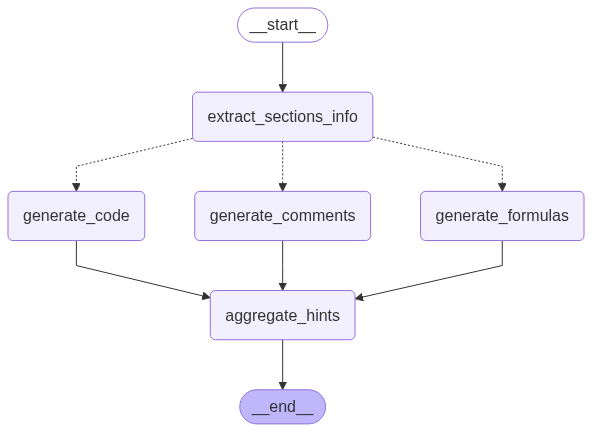

In [28]:
# LangGraph StateGraph 생성
geometry_agent = StateGraph(GeometryState)

# 노드 등록
geometry_agent.add_node("extract_sections_info", classify_sections)
geometry_agent.add_node("generate_code", generate_code_node)
geometry_agent.add_node("generate_comments", generate_comments_node)
geometry_agent.add_node("generate_formulas", generate_formulas_node)
geometry_agent.add_node("aggregate_hints", merge_hints)

# 엣지 연결
geometry_agent.set_entry_point("extract_sections_info")
geometry_agent.add_conditional_edges(
    "extract_sections_info",
    activate_nodes_by_state,
    {
        "generate_code": "generate_code",
        "generate_comments": "generate_comments",
        "generate_formulas": "generate_formulas",
    }
)
geometry_agent.add_edge("generate_code", "aggregate_hints")
geometry_agent.add_edge("generate_comments", "aggregate_hints")
geometry_agent.add_edge("generate_formulas", "aggregate_hints")
geometry_agent.add_edge("aggregate_hints", END)

# 그래프 완성
app = geometry_agent.compile()
app

In [29]:
from IPython.display import SVG, display

def show_svg(svg_content):
    display(SVG(svg_content))

In [30]:
from IPython.display import Math, display

def show_formulas(formula):
    for key in formula.keys():
        display(Math(formula[key]))

In [31]:
inputs = [
    "직선 알아보기",
    "각 알아보기",
    "직각 알아보기",
    "직각삼각형 알아보기",
    "직사각형의 특징 알아보기",
    "정사각형의 특징 알아보기",
    "원의 반지름과 지름 알아보기",
    "지름의 성질 알아보기",
    "원 그리기",
    "원을 이용하여 여러 가지 모양 그리기",
    "각의 크기 비교하기",
    "각도기를 이용하여 각도 재기",
    "각도를 나타내는 단위 알아보기",
    "각도기와 자를 이용하여 각 그리기",
    "예각과 둔각 알아보기",
    "각도를 어림하고 각도기로 재어 확인하기",
    "각도의 합 또는 차의 활용",
    "두 각도의 차 구하기",
    "두 각도의 합 구하기",
    "삼각형에서 나머지 한 각의 크기 구하기",
    "삼각형의 세 각의 크기의 합 구하기",
    "사각형의 나머지 한 각의 크기 구하기",
    "사각형의 네 각의 크기의 합 구하기",
    "삼각형의 변의 길이에 따라 분류하기",
    "이등변삼각형 알아보기",
    "이등변삼각형의 성질 알아보기",
    "각을 이용하여 이등변삼각형 그리기",
    "정삼각형의 성질 알아보기",
    "정삼각형 알아보기",
    "각을 이용하여 정삼각형 그리기",
    "예각삼각형 알아보기",
    "삼각형을 각의 크기에 따라 분류하기",
    "둔각삼각형 알아보기",
    "삼각자와 각도기를 이용한 수선 긋기",
    "수직",
    "삼각자를 사용하여 평행선 긋기",
    "주어진 거리의 평행선 긋기",
    "평행 알아보기",
    "평행선 사이의 거리 알아보기",
    "직사각형의 성질 알아보기",
    "정사각형의 성질 알아보기",
    "직사각형과 정사각형의 성질 활용",
    "사다리꼴 알아보기",
    "평행사변형의 성질 알아보기",
    "평행사변형 알아보기",
    "마름모 알아보기",
    "마름모의 성질 알아보기",
    # "다각형과 다각형의 이름 알아보기",
    # "정다각형과 정다각형의 이름 알아보기",
    # "대각선의 성질 알아보기",
    # "대각선 알아보기",
    # "모양 만들기",
]

input_samples = inputs[:] # 일정 범위만 잘라서 테스트

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

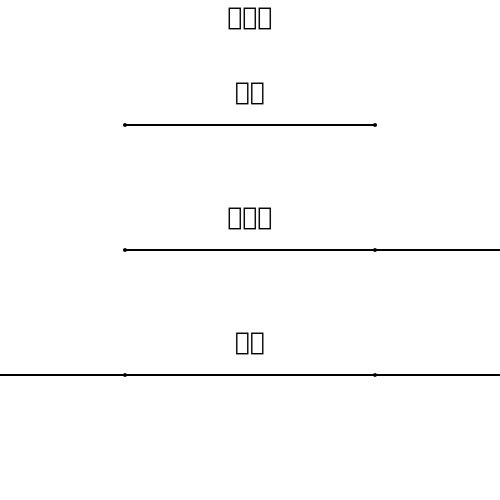

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="343.65492678484895" y2="211.79759493841573" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 168.7309853569698,308.7595189876831 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="185.50922752363175" y="317.35124974659743" font-size="12" text-anchor="middle">29°</text>
        </svg>
        


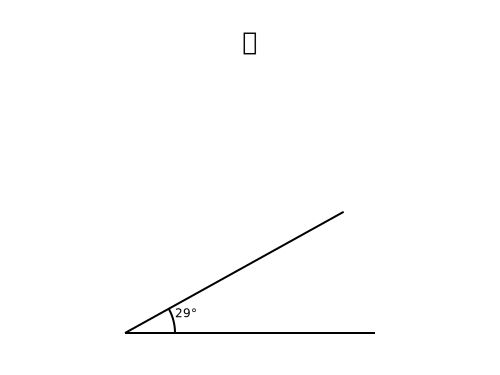

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

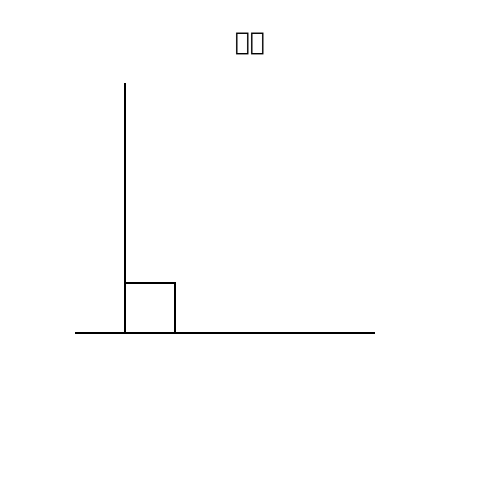

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


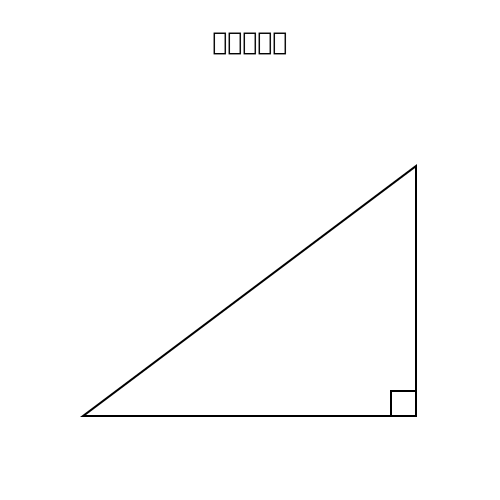

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


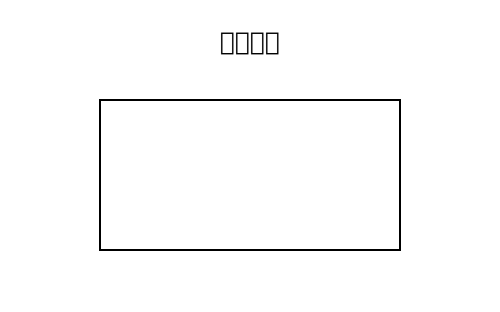

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


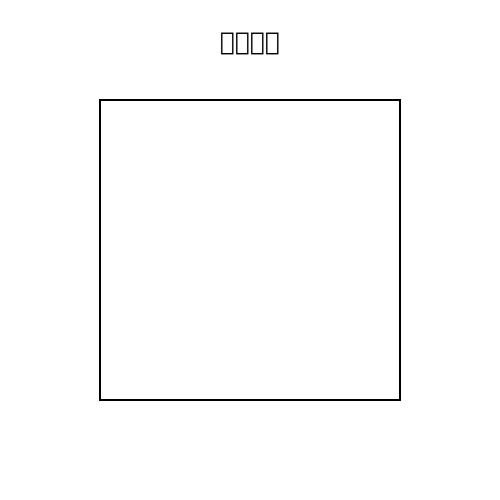

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


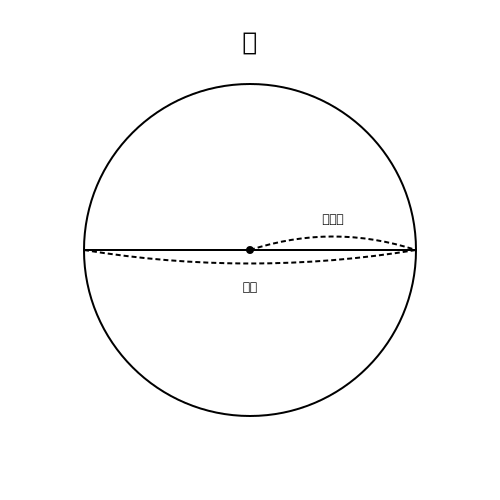

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


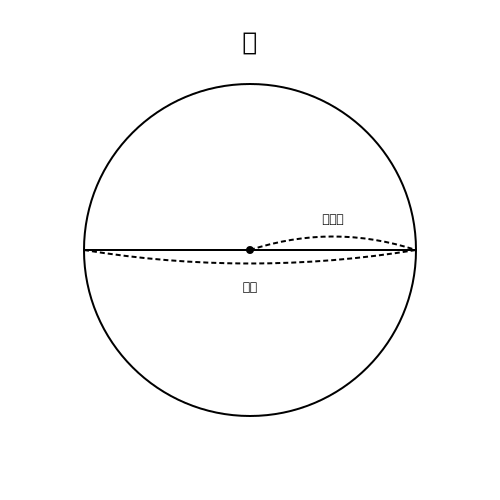

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

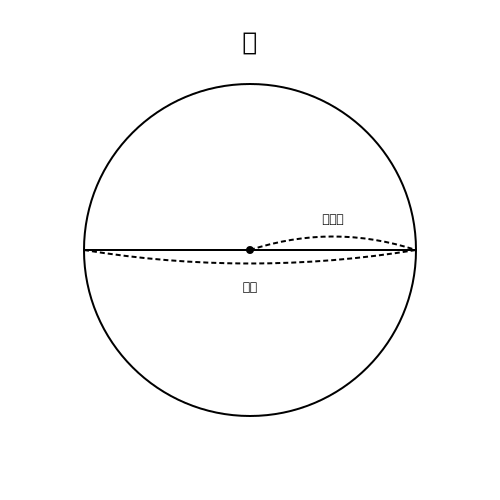

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

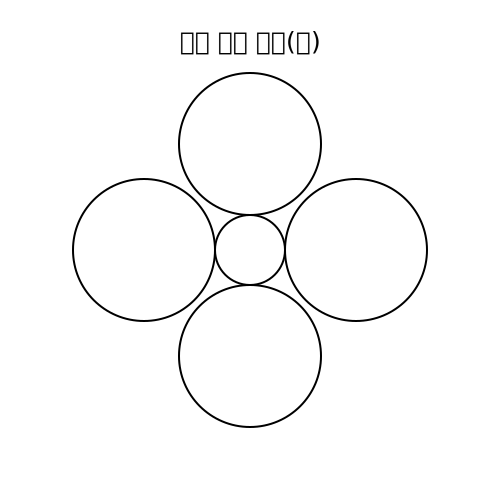

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="117.5201839416988" y2="120.9879759608935" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 223.50403678833976,290.5975951921787 A 50,50 0 0,1 300,333" stroke="

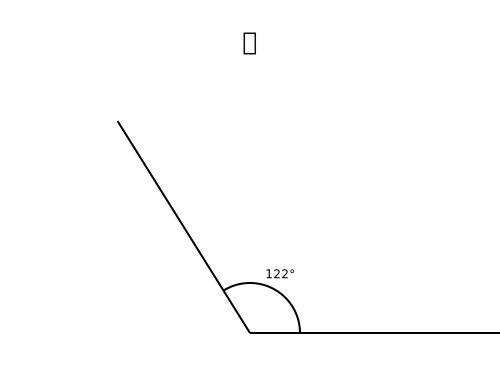

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="138.083989060736" y2="83.34261631135655" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 127.6167978121472,283.0685232622713 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
 

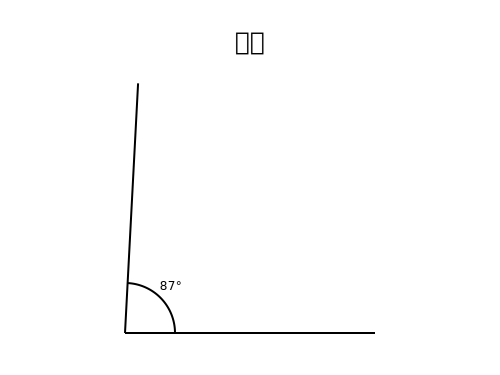

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="125.00000000000006" y2="116.49364905389032" stroke="black" strok

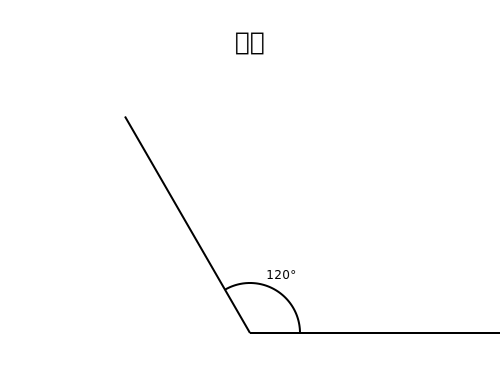

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="215.20672475998367" y2="85.43298281460741" stroke="black" stroke-width="2" />


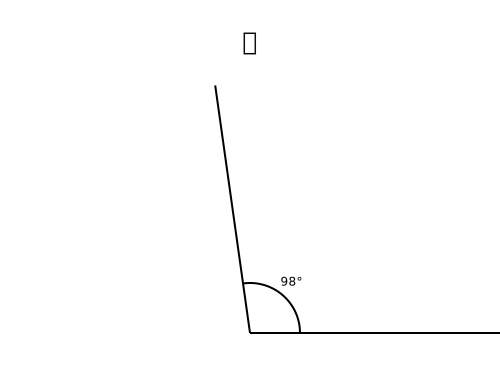

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="246.34845121081742" y2="104.24444461012774" stroke="black" stroke-widt

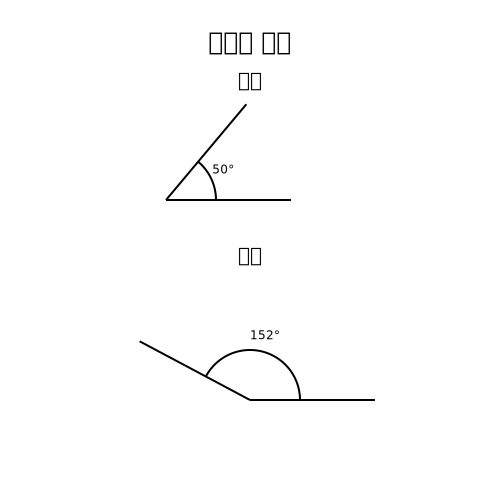

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="176.97792270443986" y2="88.4630998165486" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 135.39558454088797,284.092

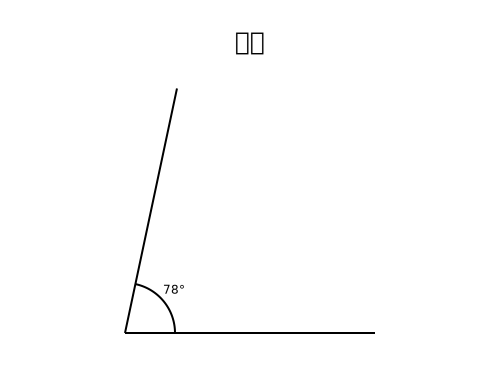

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

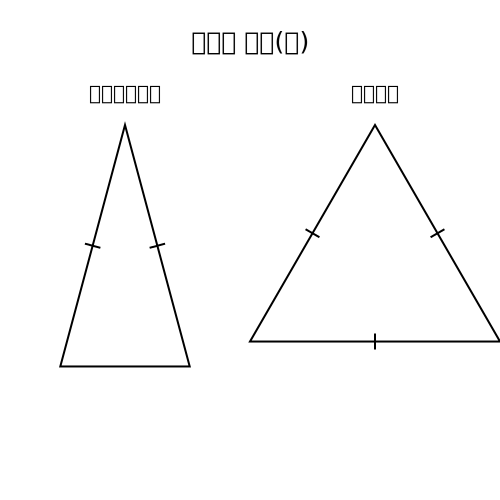

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

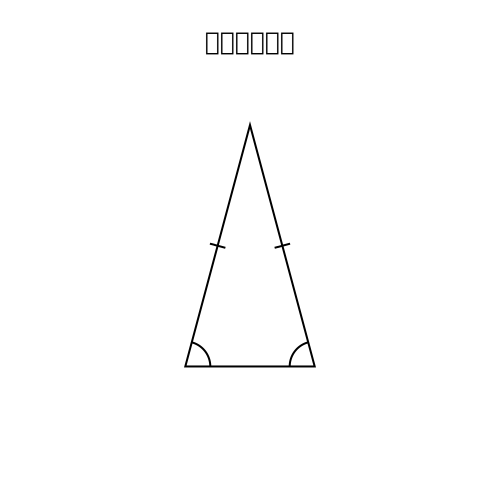

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

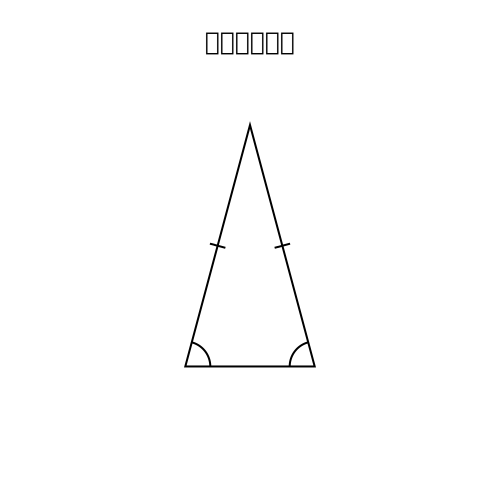

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

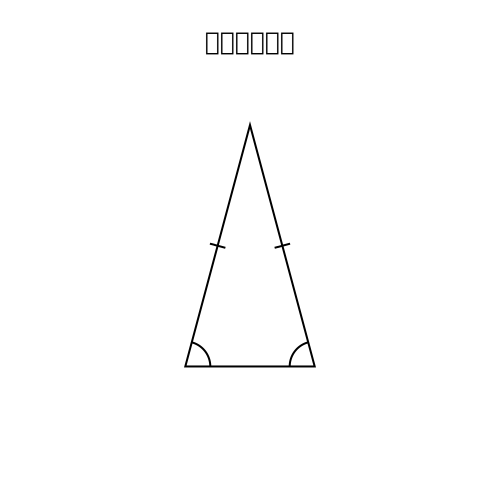

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

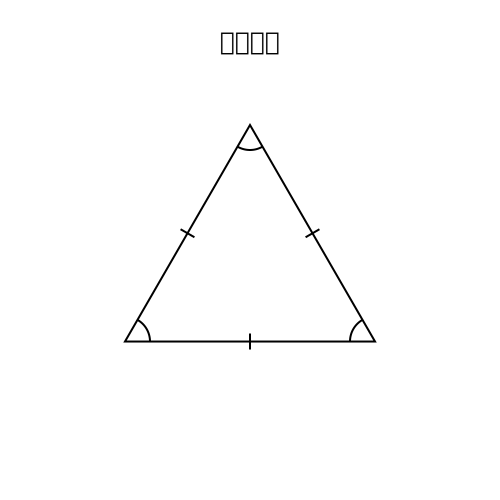

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

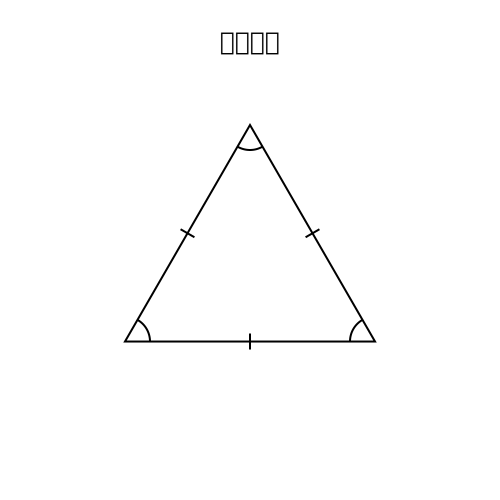

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

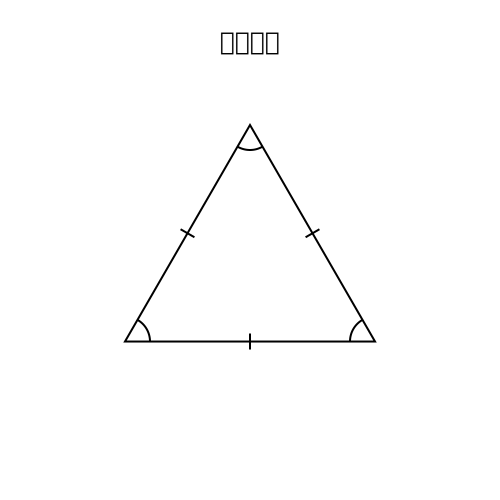

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


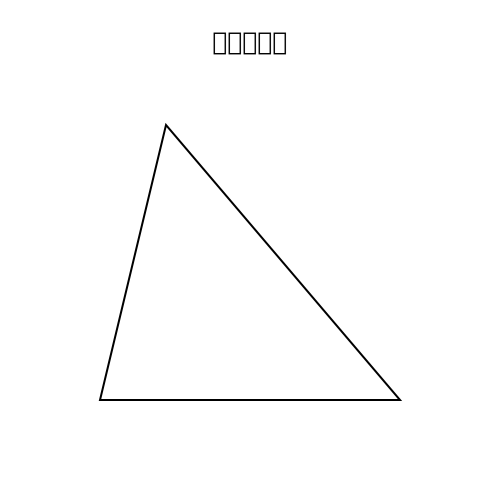

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

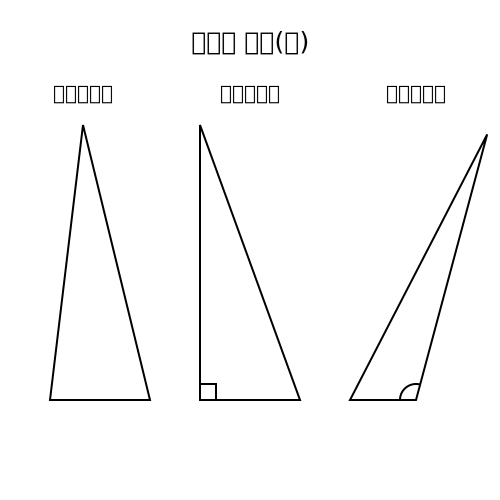

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


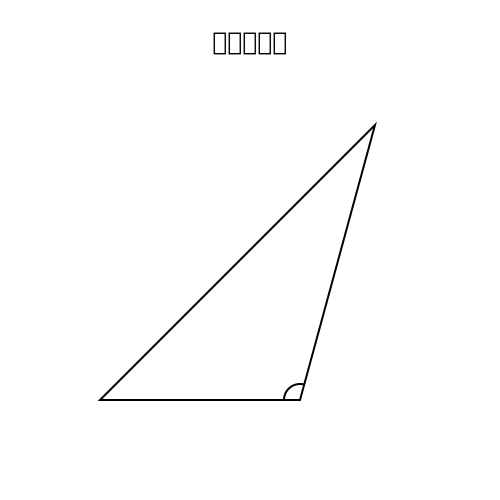

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

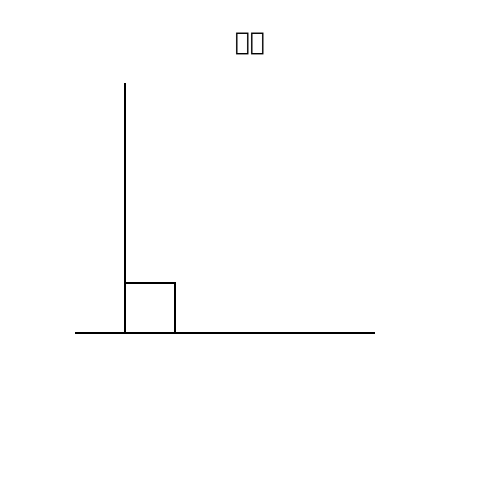

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

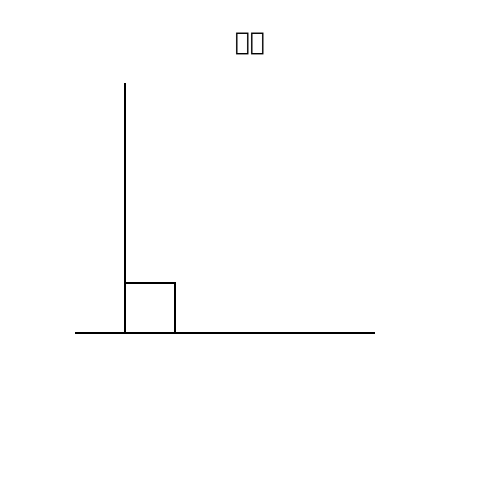

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

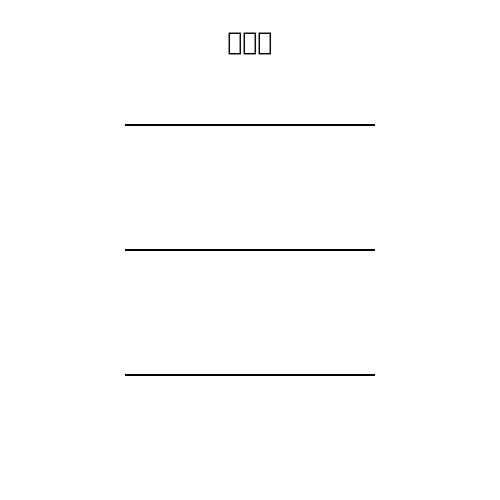

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

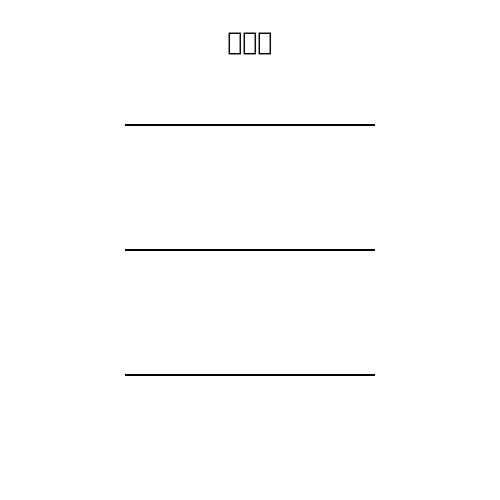

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


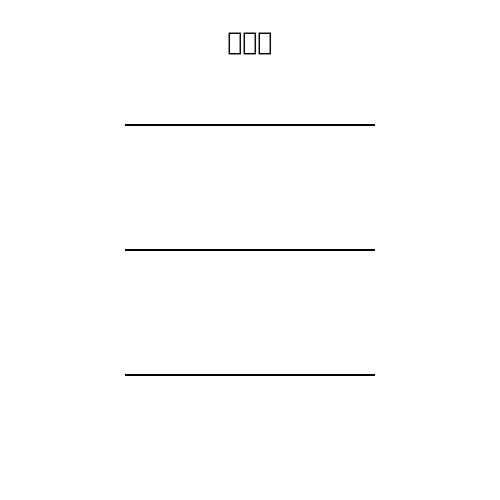

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

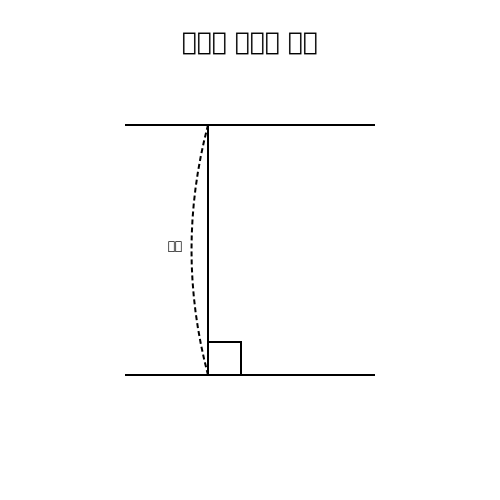

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

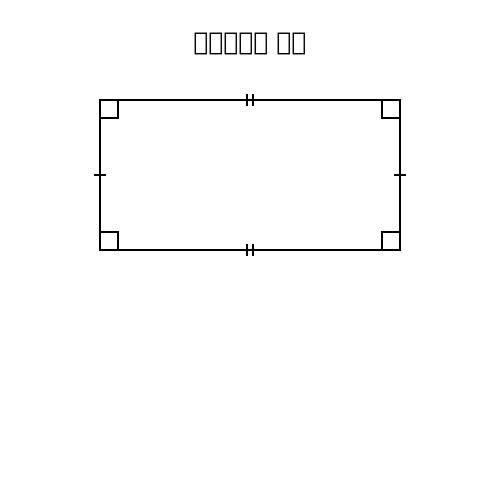

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

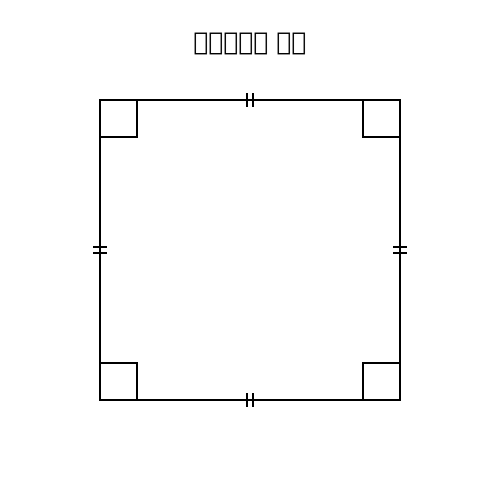

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

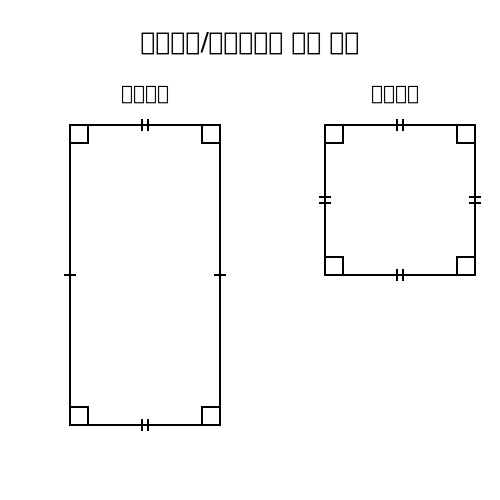

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


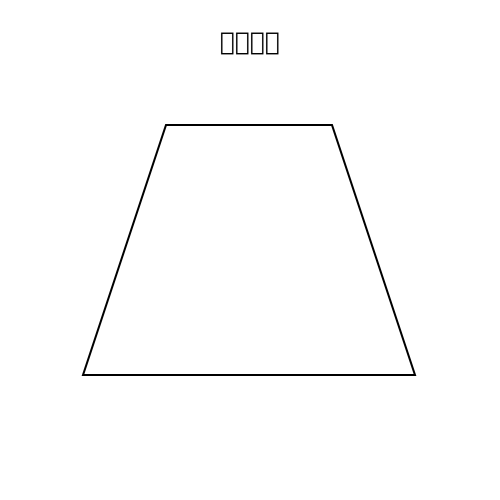

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

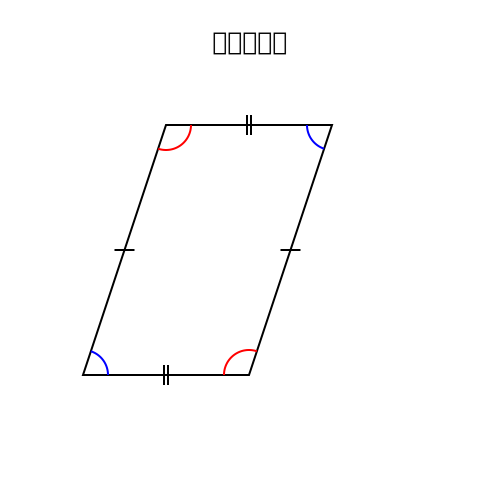

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

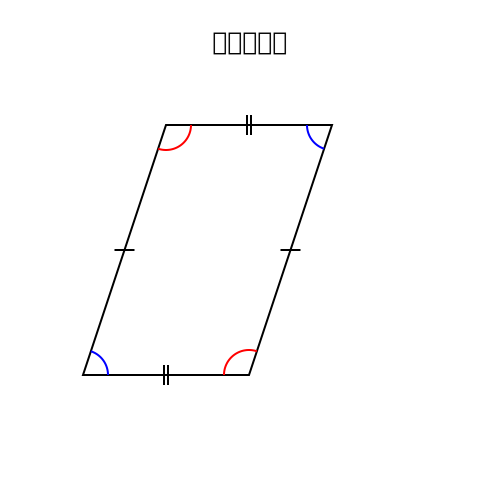

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

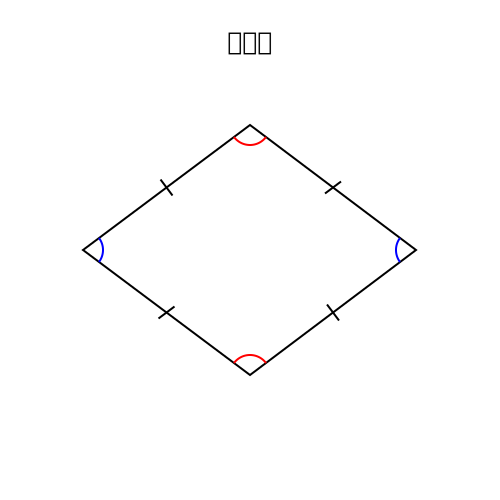

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

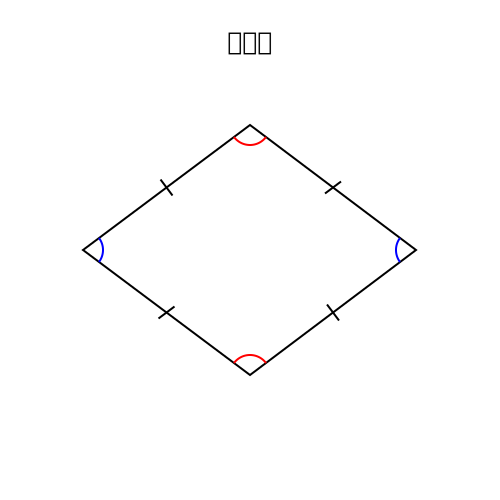

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

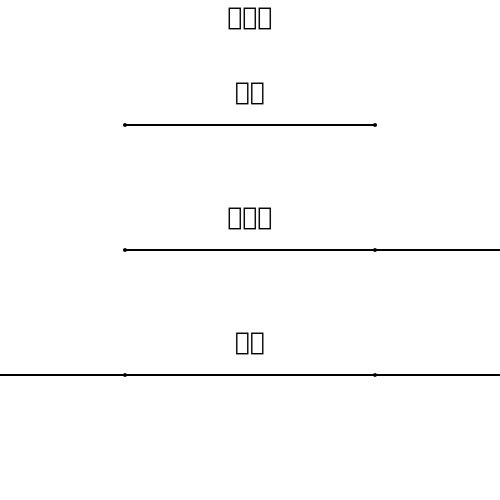

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="70.16504991533719" y2="159.3354073852507" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 214.03300998306744,298.26708147705017 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="273.4129120884945" y="275.0510090895758" font-size="12" text-anchor="middle">136°</text>
        </svg>
        


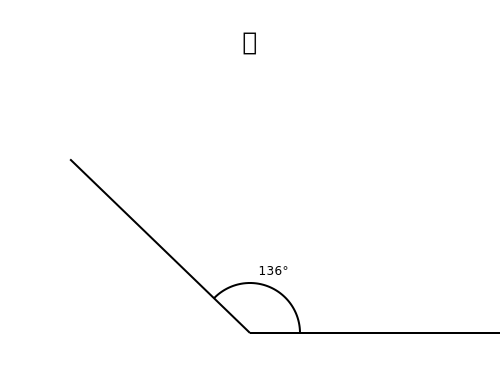

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

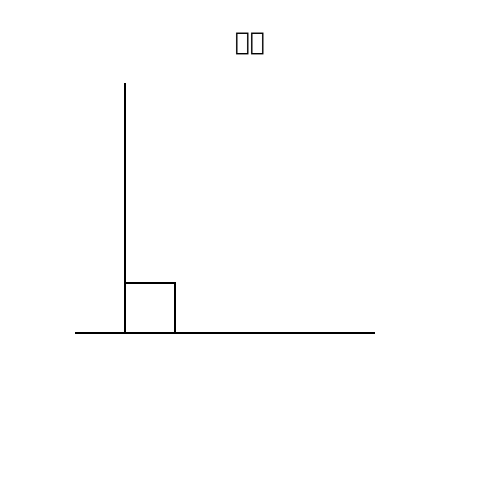

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


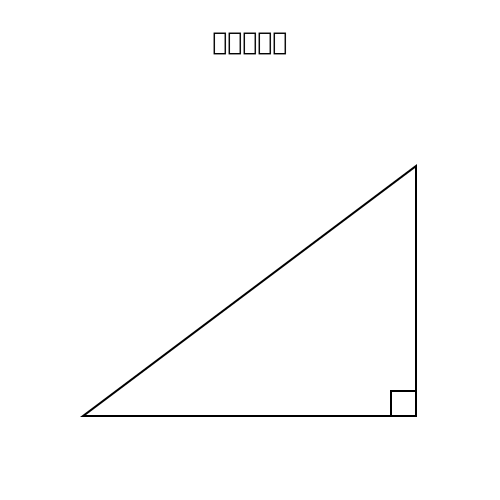

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


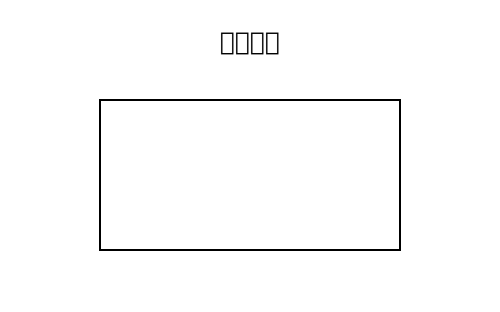

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


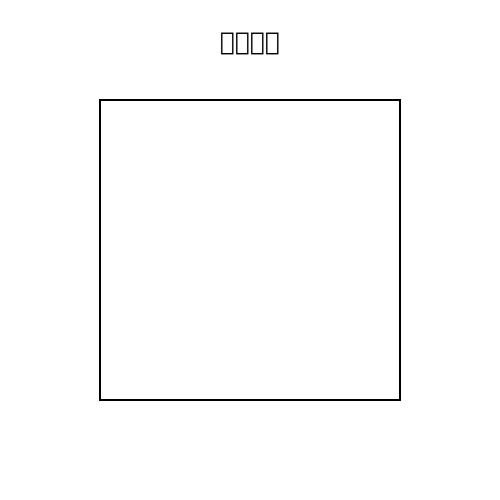

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


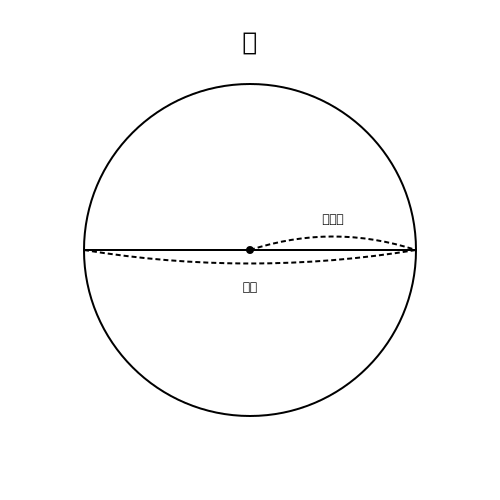

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


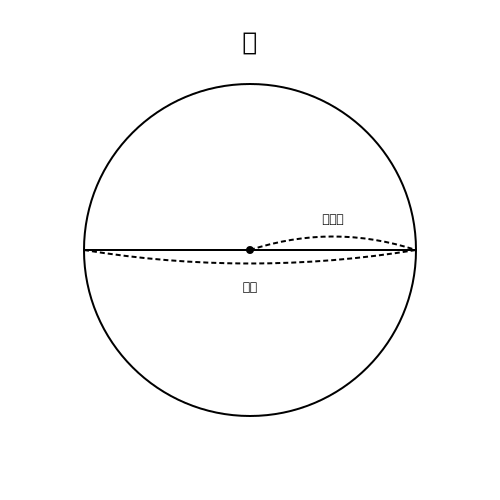

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

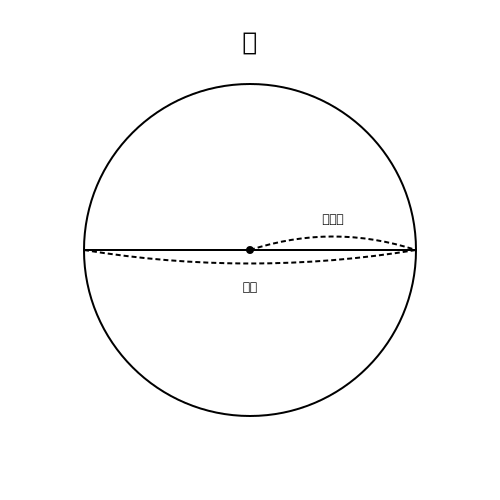

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

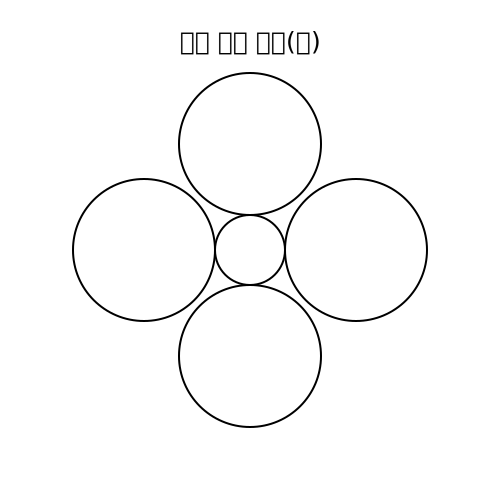

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="359.92315519647707" y2="247.49496416858284" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 171.98463103929544,315.8989928337166 A 50,50 0 0,1 175,333" stroke

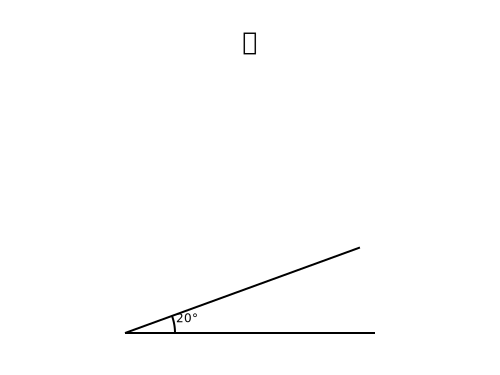

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="47.74575140626317" y2="186.05368692688168" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 209.54915028125265,303.61073738537635 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"

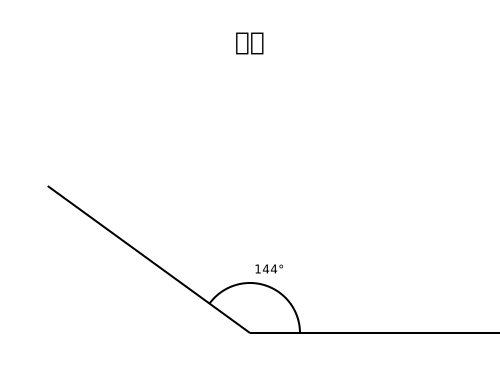

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="366.4814565722671" y2="268.2952387243698" stroke="black" stroke-

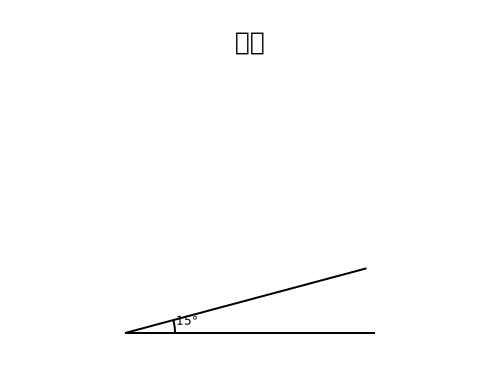

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="9.684576015420276" y2="264.0906610457502" stroke="black" stroke-width="2" />
 

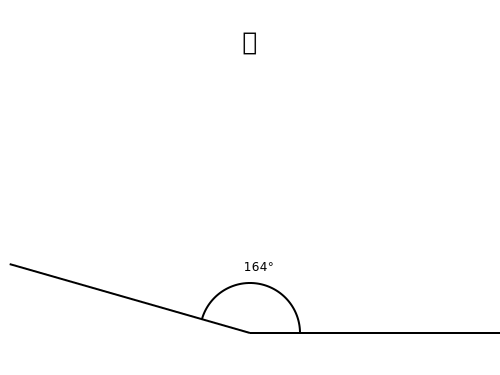

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="289.7835085926963" y2="182.60336237999184" stroke="black" stroke-width

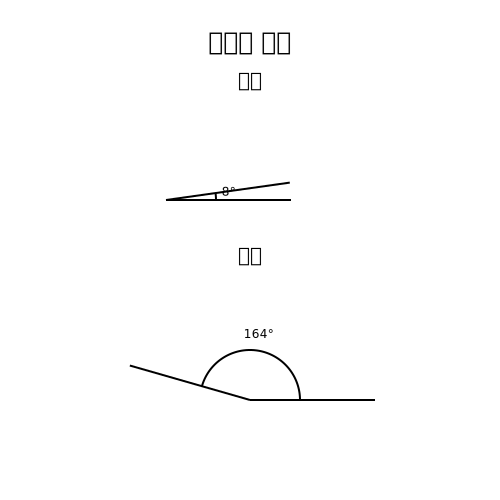

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="133.72487417562527" y2="83.15229324522605" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 126.74497483512505,283.03

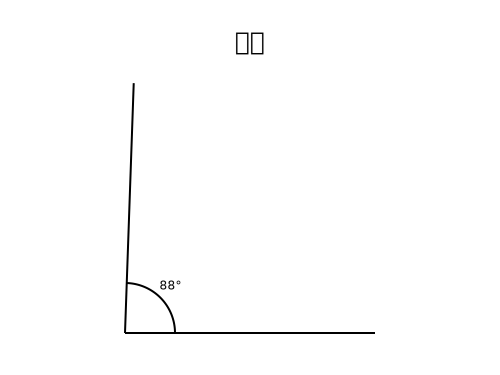

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

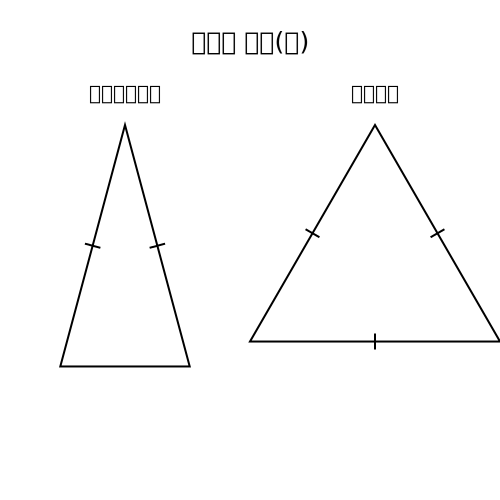

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

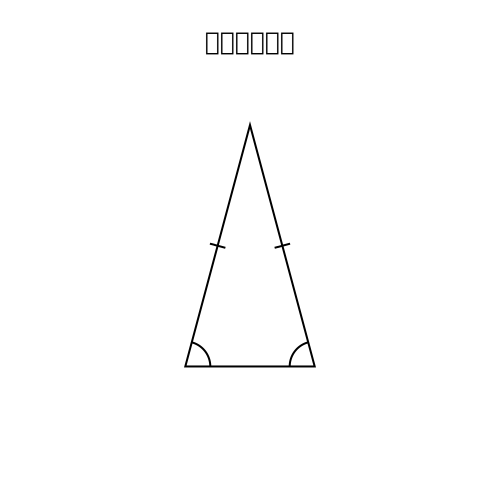

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

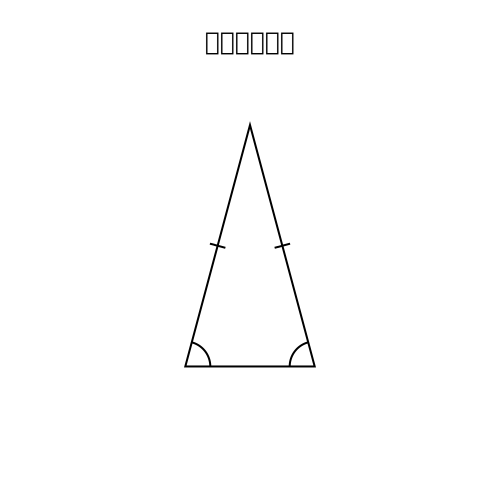

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

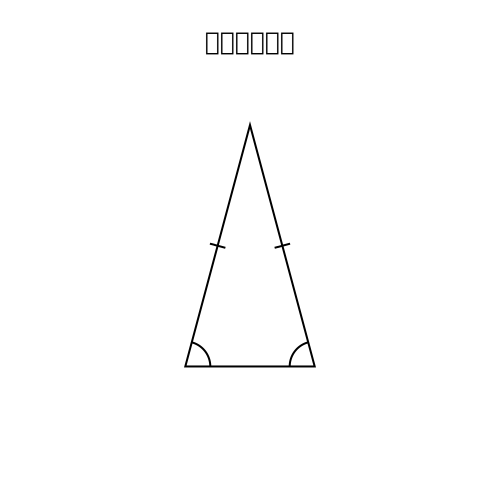

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

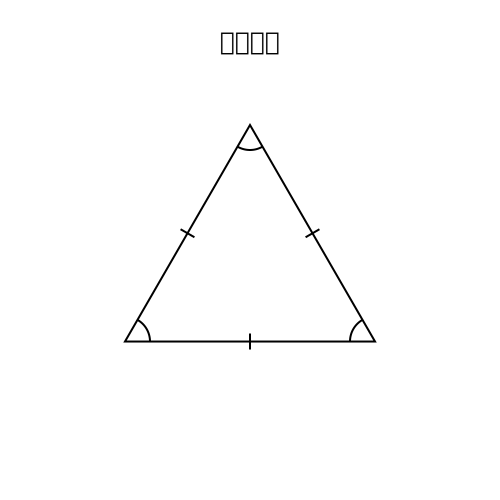

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

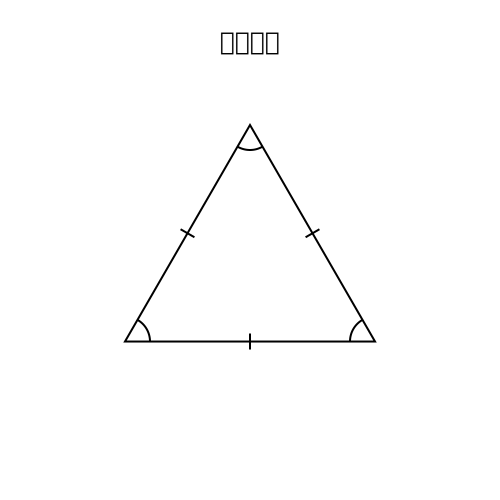

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

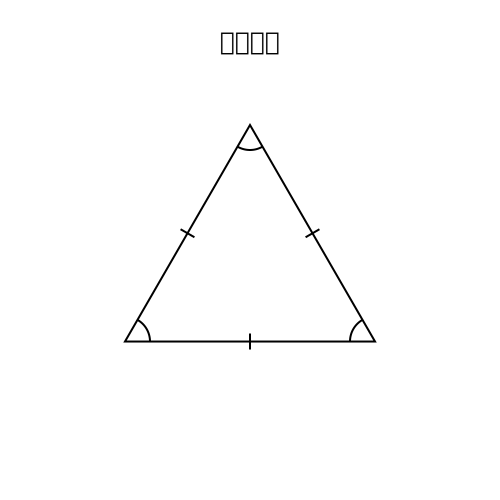

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


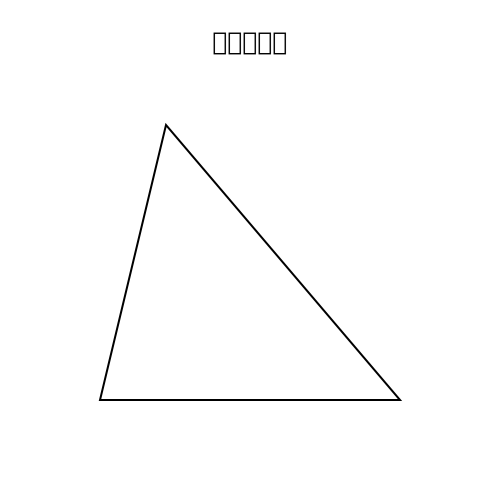

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

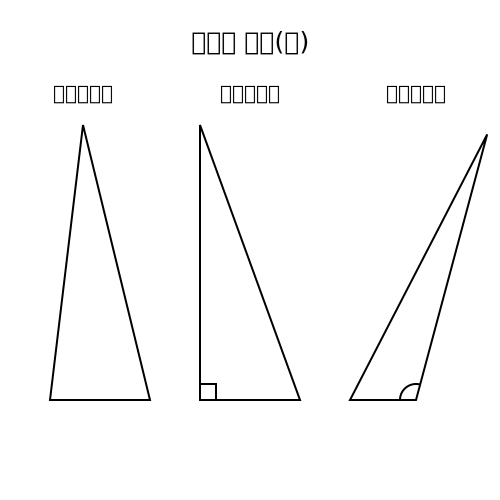

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


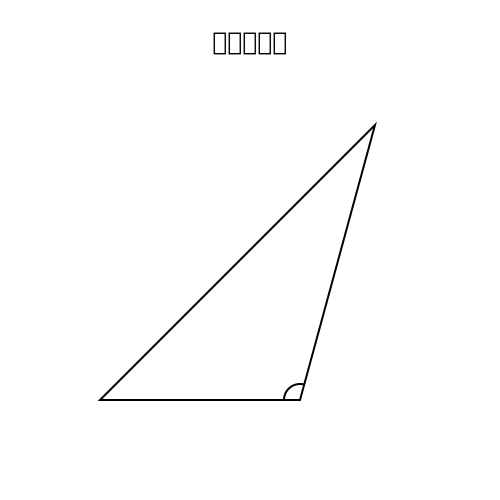

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

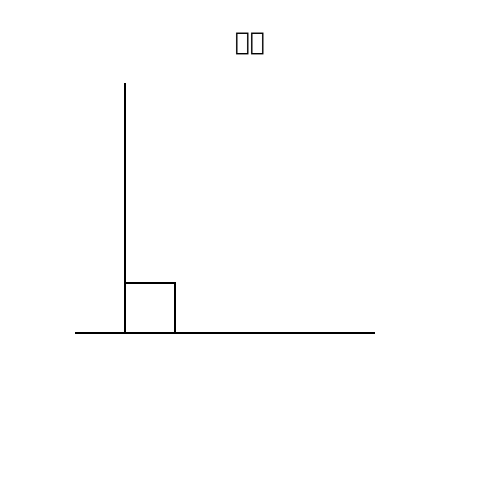

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

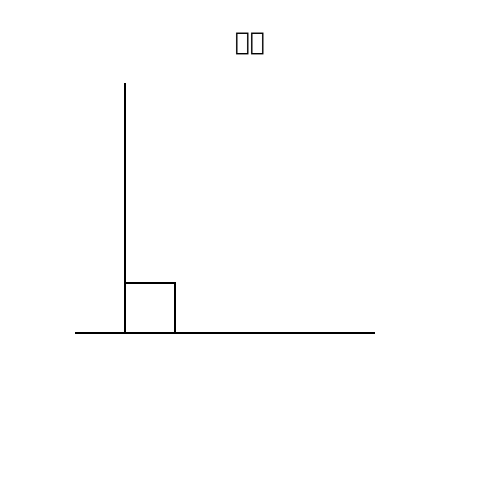

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

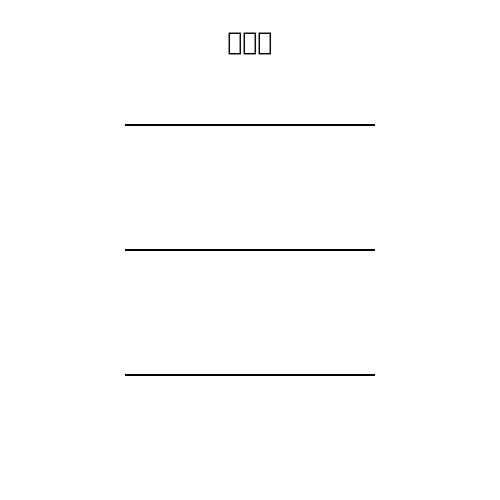

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

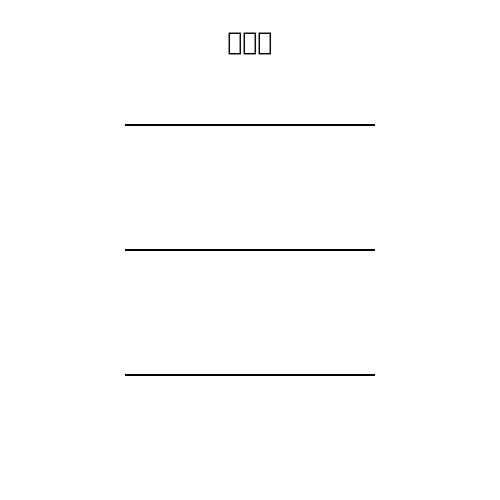

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


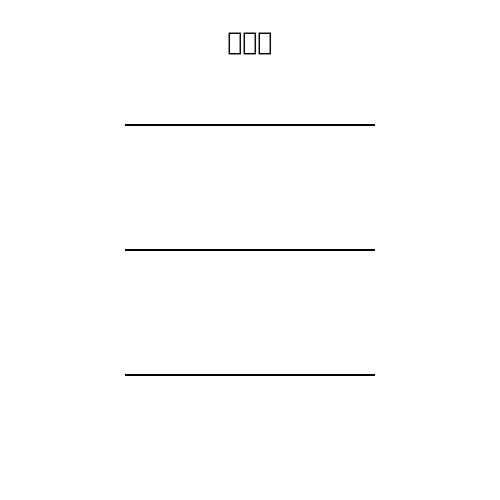

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

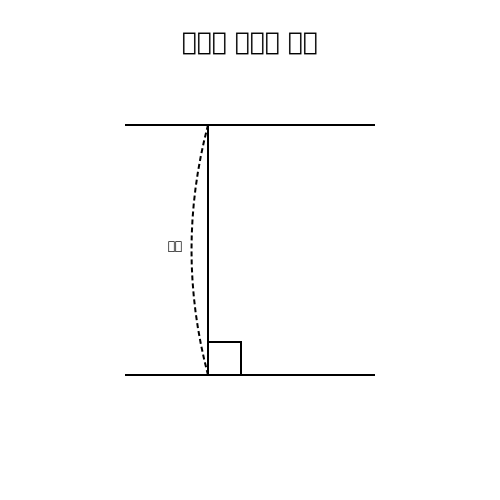

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

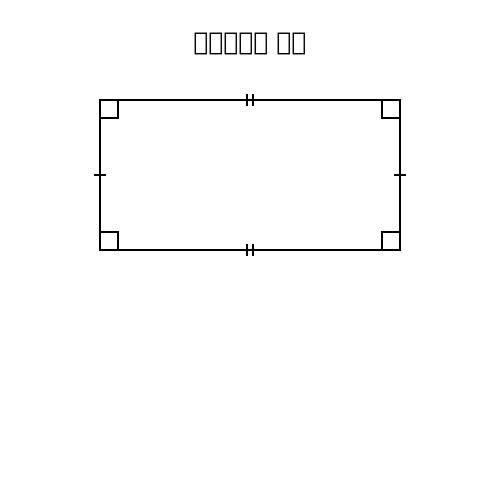

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

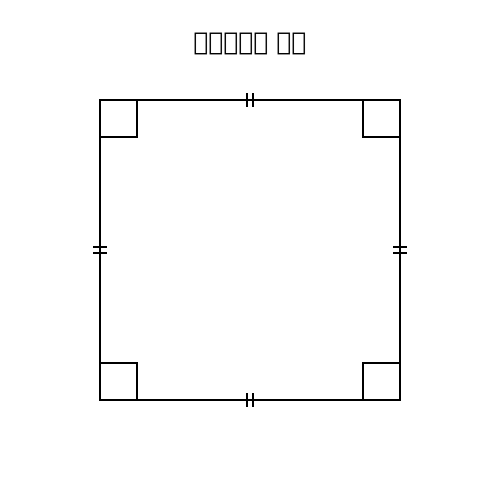

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

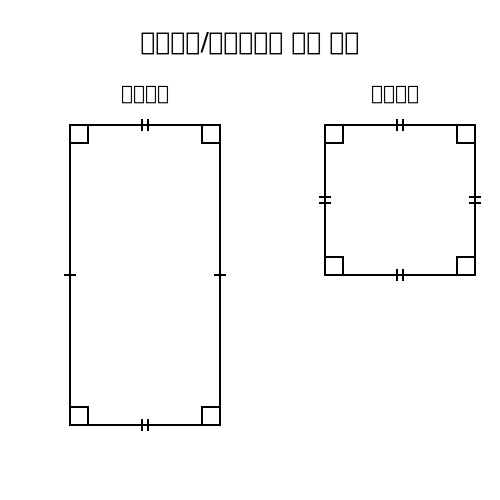

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


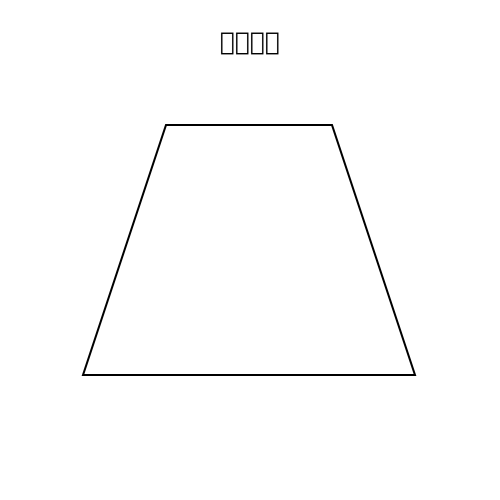

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

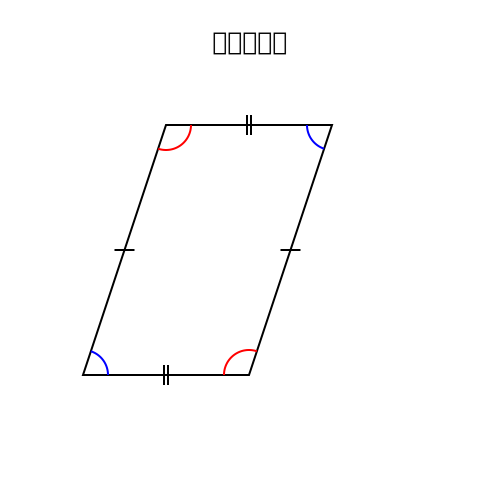

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

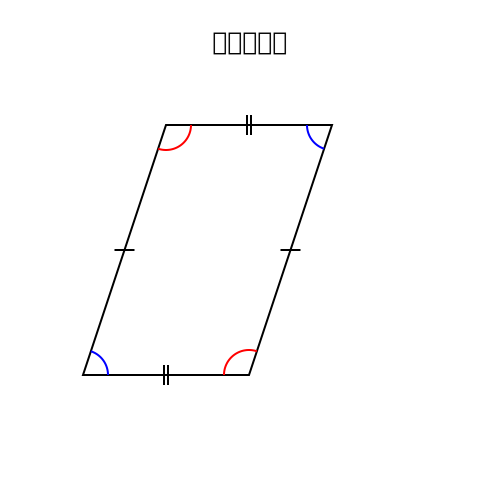

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

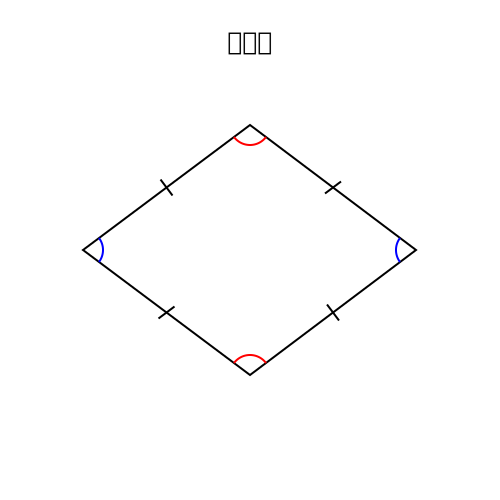

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

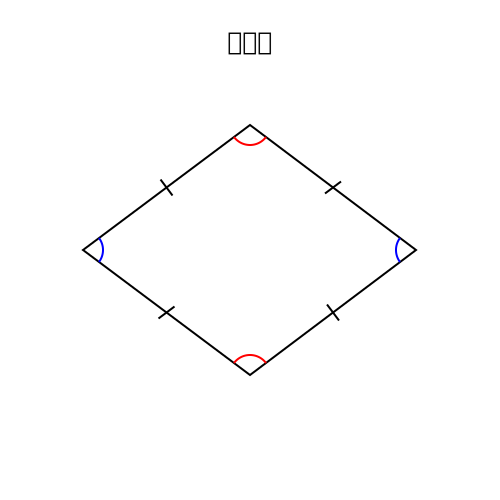

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

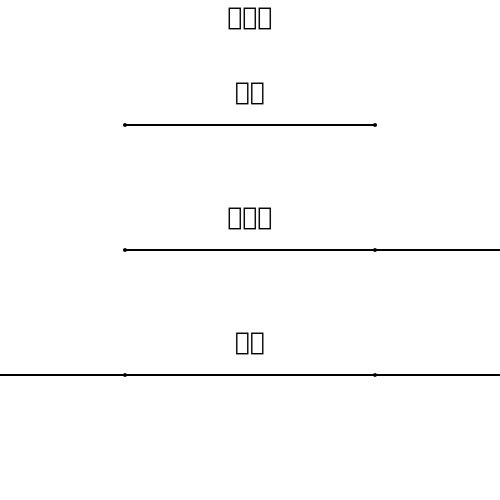

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="164.10861626005772" y2="86.07791485121555" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 132.82172325201154,283.6155829702431 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="172.52537285000193" y="292.40949697936355" font-size="12" text-anchor="middle">81°</text>
        </svg>
        


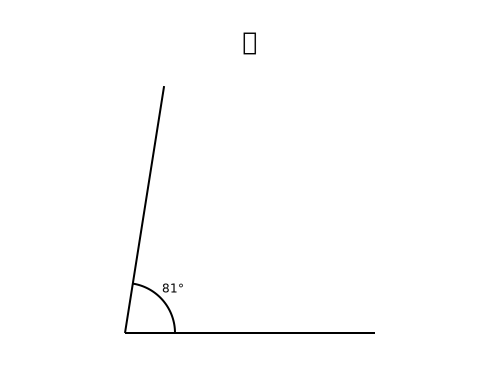

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

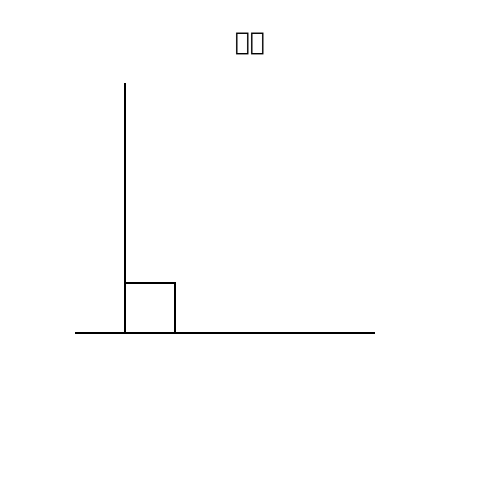

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


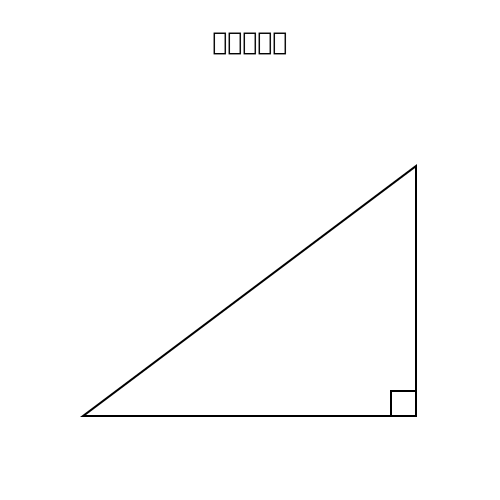

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


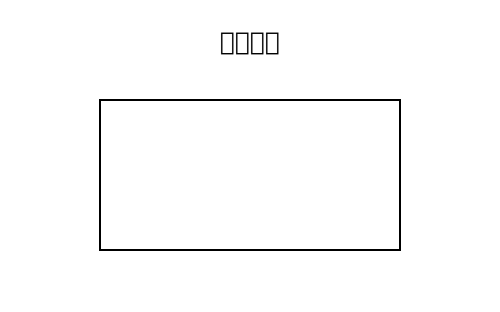

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


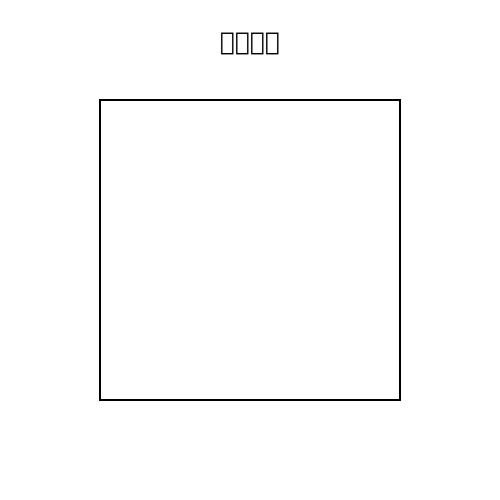

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


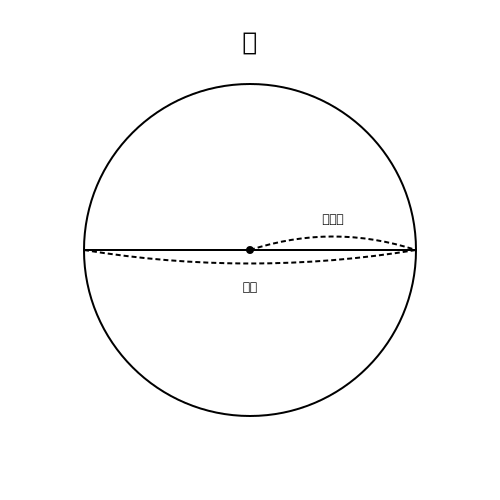

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


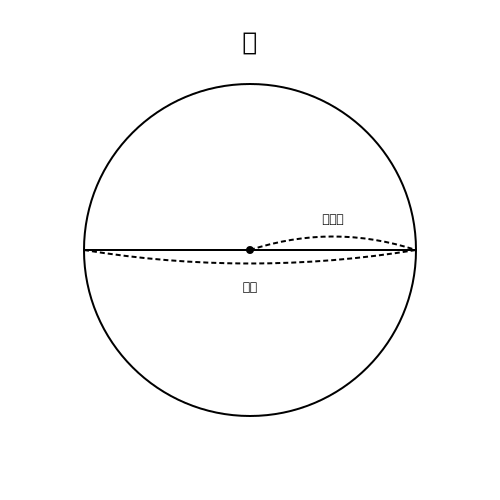

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

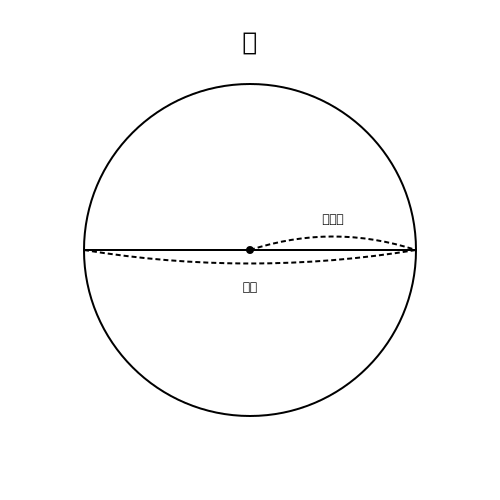

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

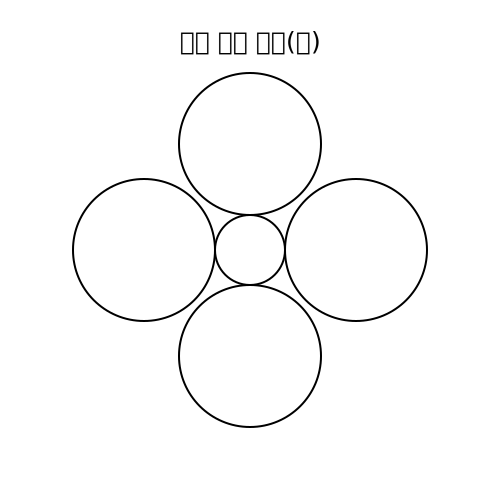

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="9.684576015420276" y2="264.0906610457502" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 201.93691520308406,319.21813220915004 A 50,50 0 0,1 300,333" stroke=

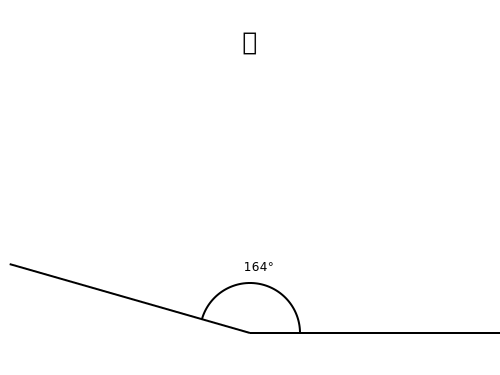

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="110.20177413231332" y2="125.74060686123957" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 222.04035482646267,291.5481213722479 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"

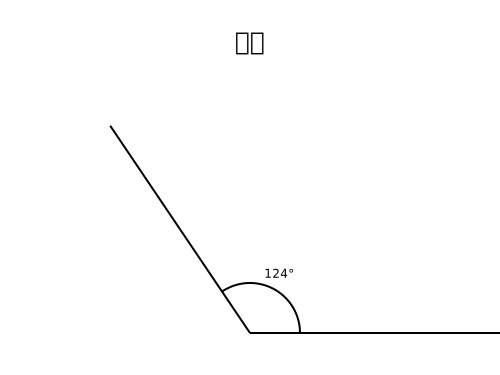

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="176.90707381931583" y2="93.92381100924112" stroke="black" stroke

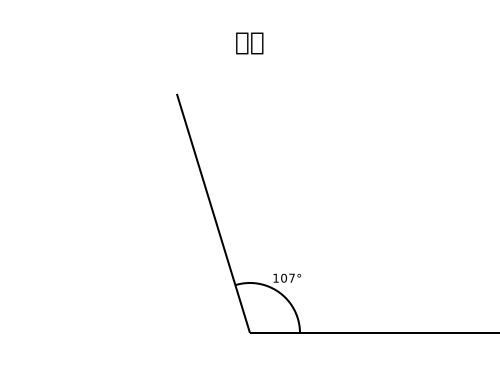

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="82.71734841028544" y2="147.21379363065145" stroke="black" stroke-width="2" />


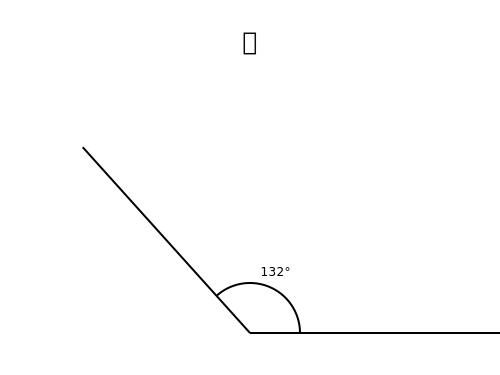

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="277.37581552354595" y2="143.25118753255666" stroke="black" stroke-widt

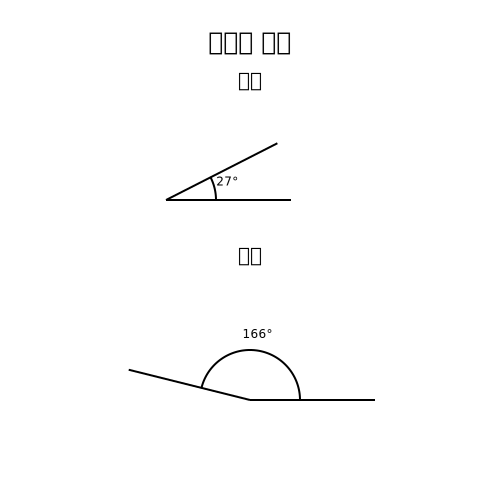

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="329.78801107224797" y2="189.6058909122385" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 165.9576022144496,304.321

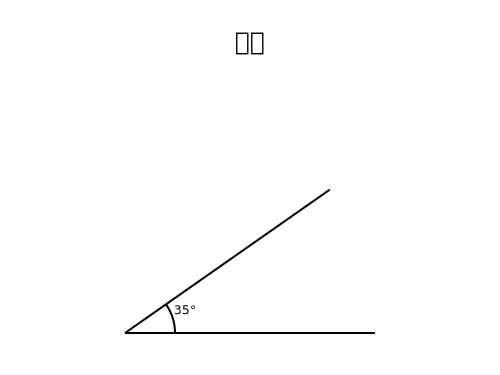

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

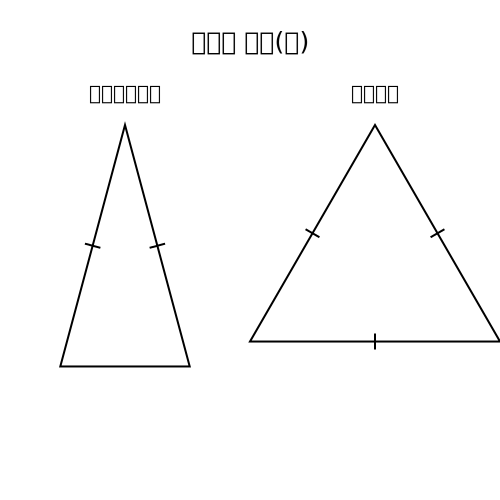

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

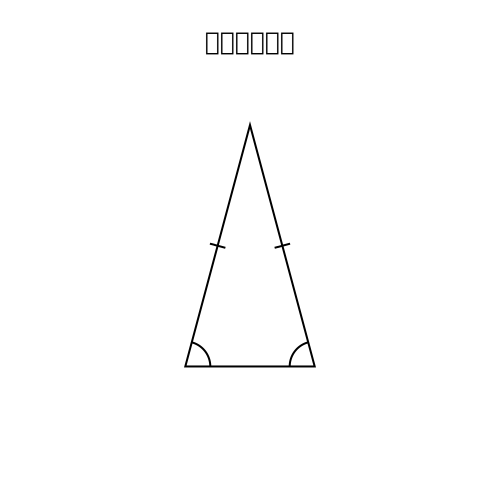

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

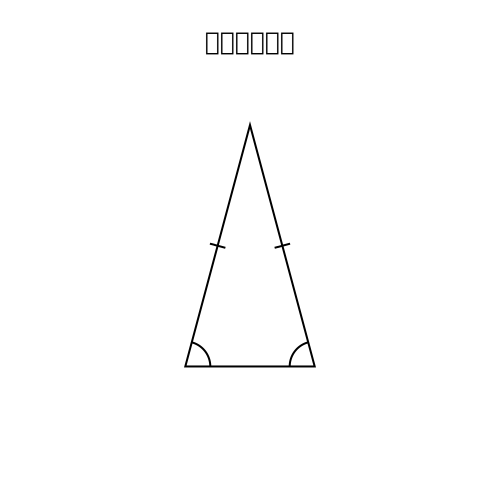

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

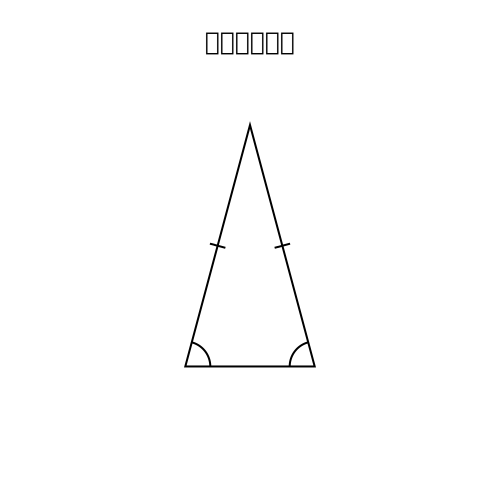

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

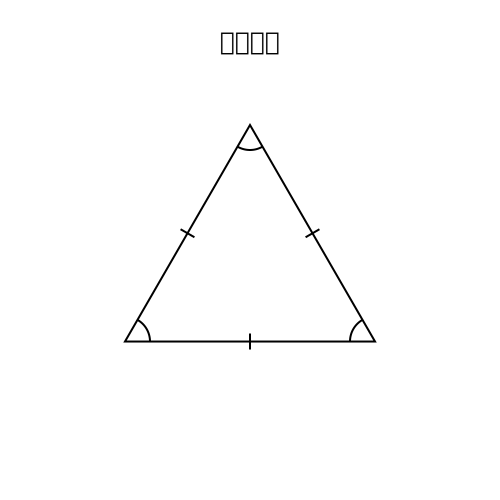

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

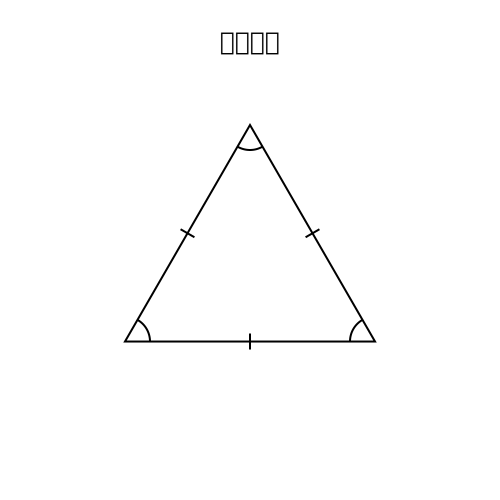

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

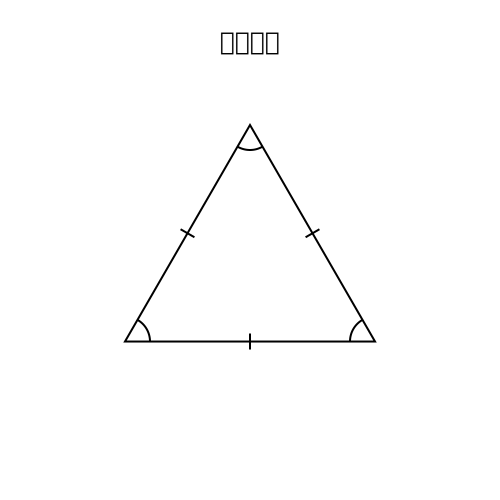

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


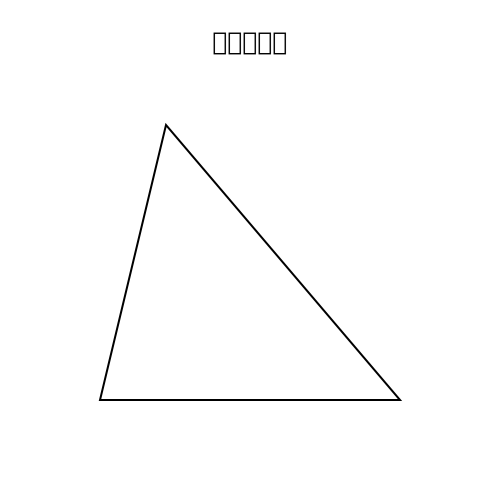

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

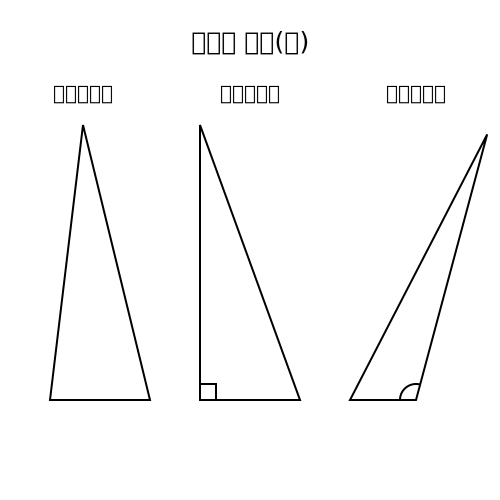

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


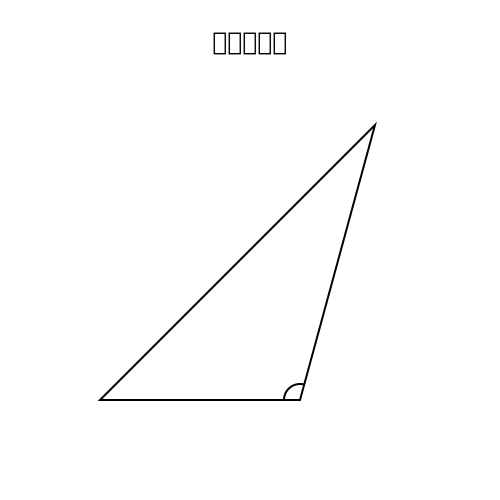

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

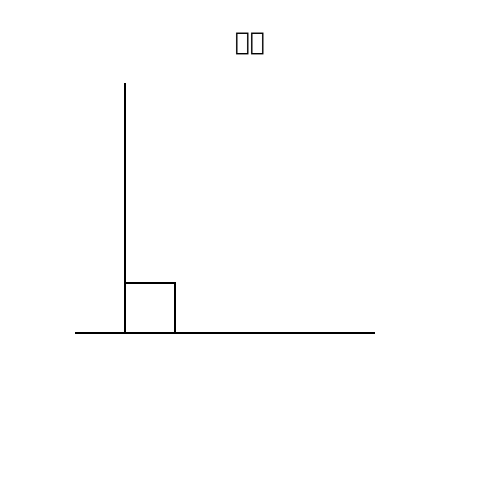

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

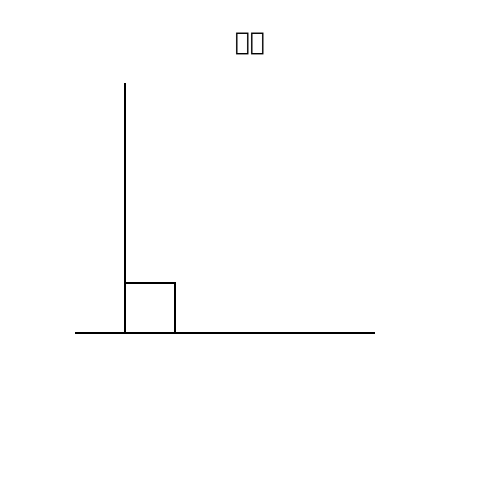

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

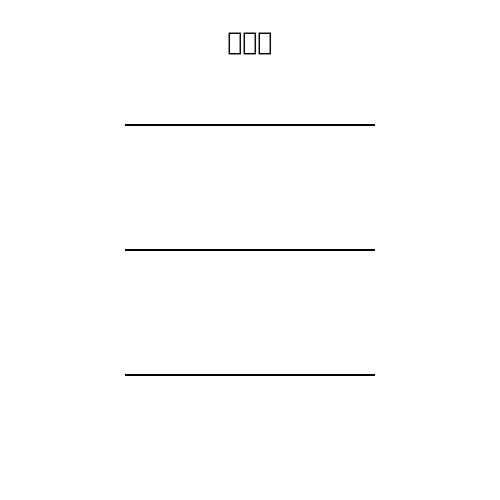

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

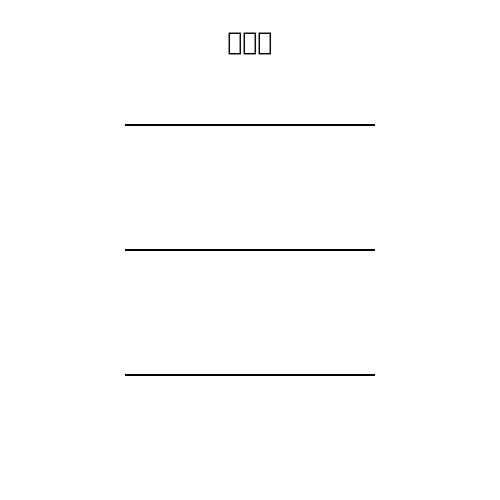

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


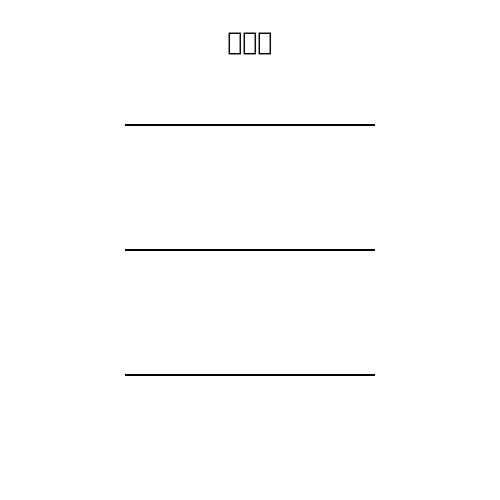

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

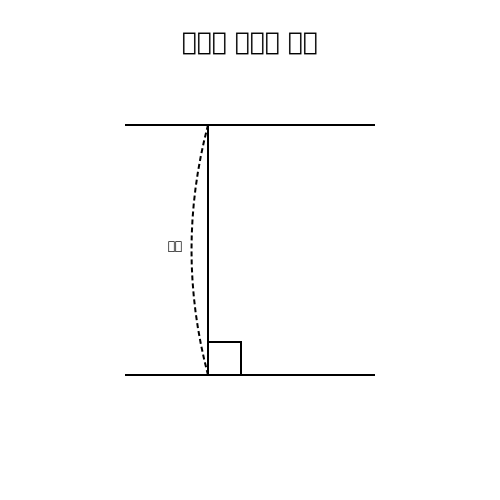

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

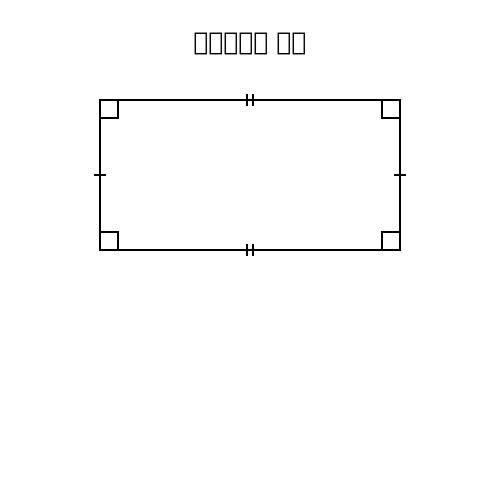

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

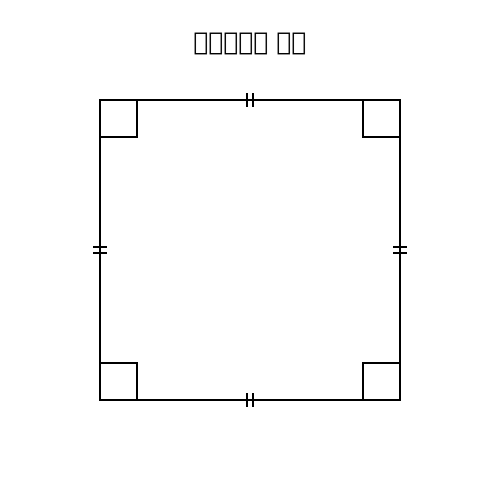

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

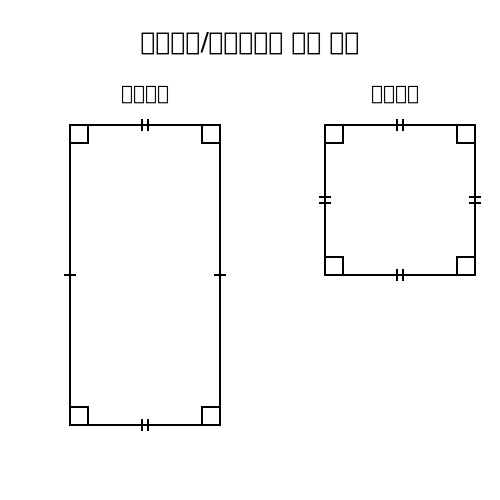

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


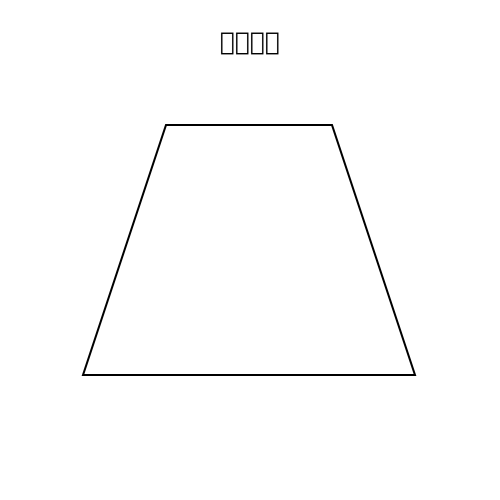

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

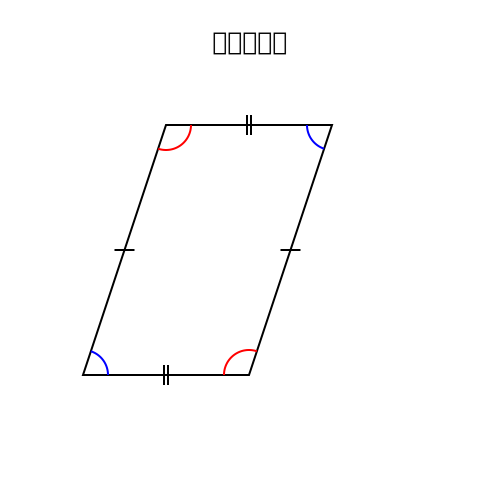

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

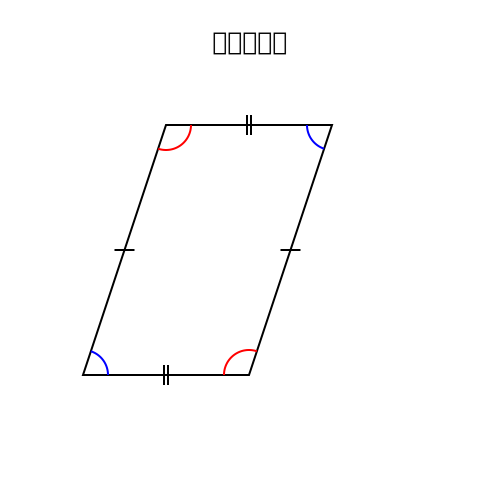

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

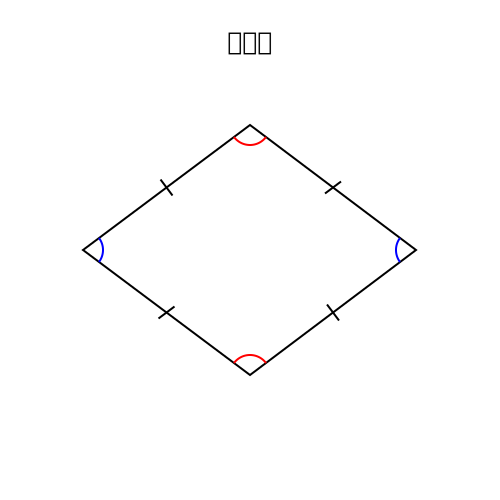

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

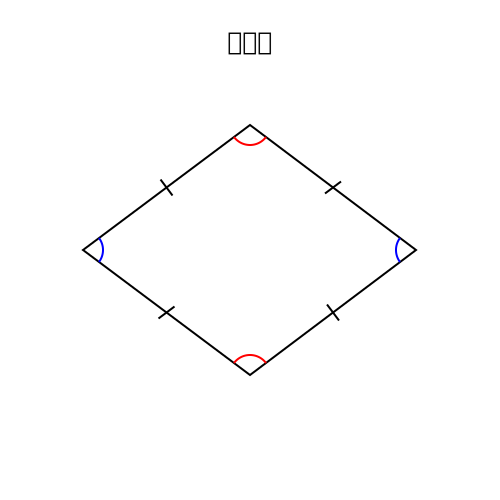

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

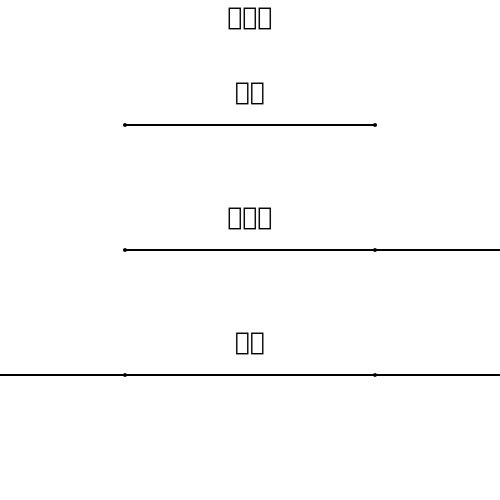

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="206.58795558326742" y2="86.79806174694801" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 241.3175911166535,283.7596123493896 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="290.1742256054087" y="285.1222223050639" font-size="12" text-anchor="middle">100°</text>
        </svg>
        


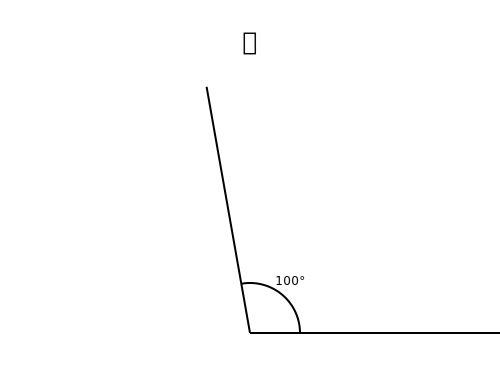

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

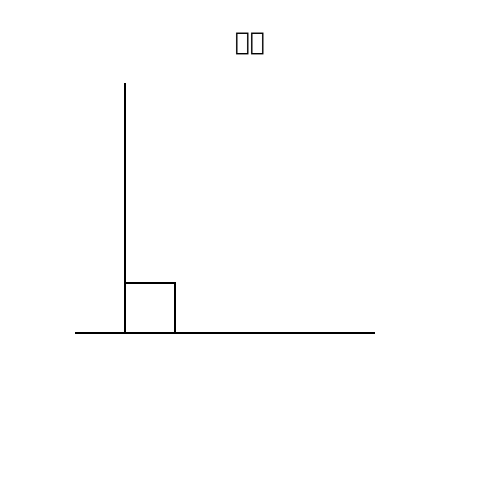

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


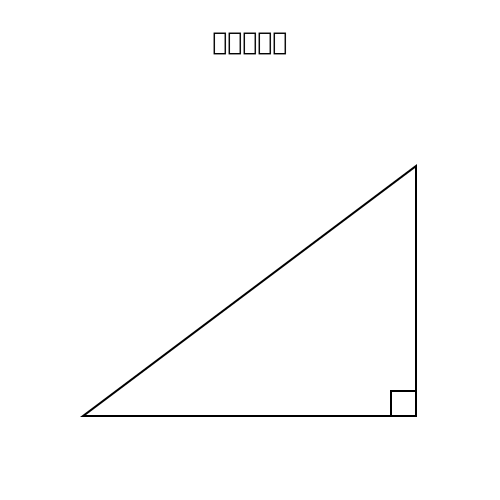

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


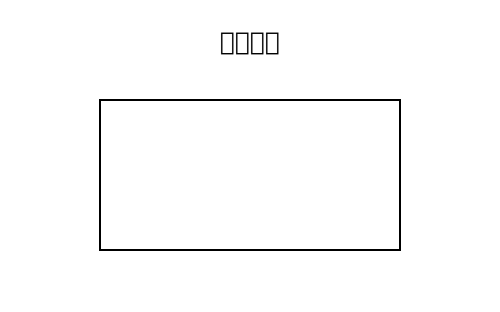

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


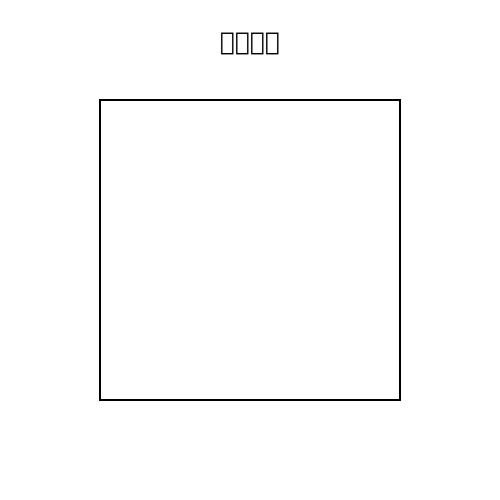

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


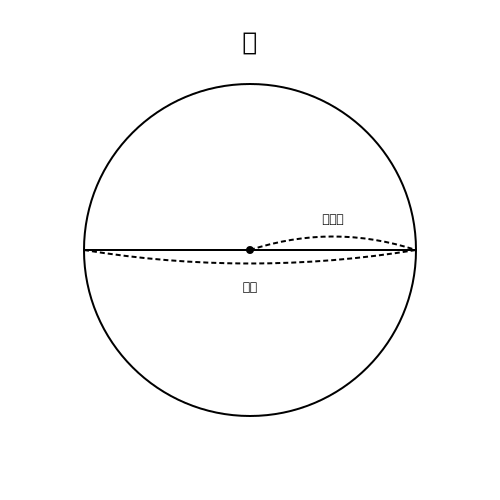

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


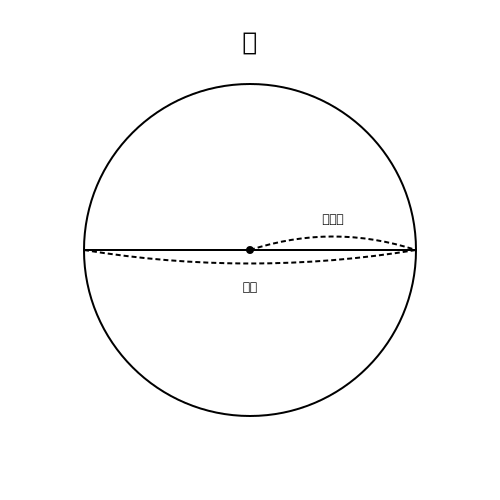

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

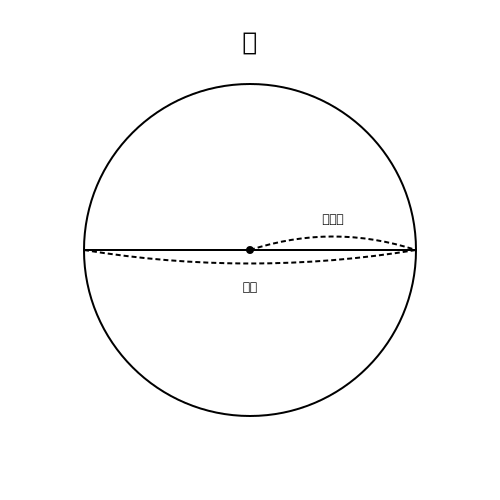

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

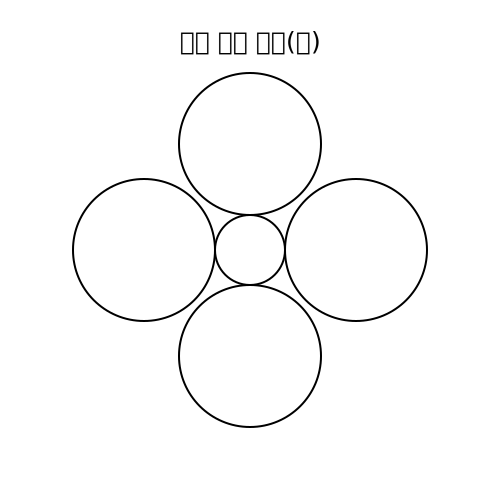

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="144.34543456482515" y2="106.42305324083748" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 228.86908691296503,287.6846106481675 A 50,50 0 0,1 300,333" stroke

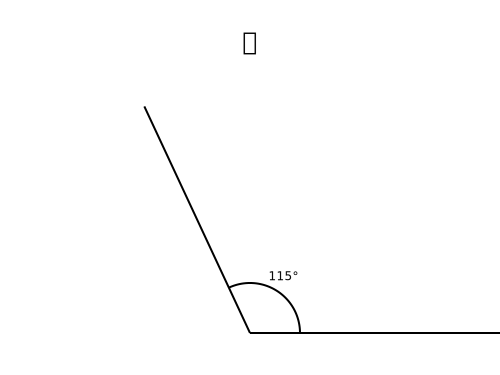

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="372.5670171853926" y2="298.2067247599837" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.51340343707852,326.04134495199673 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/

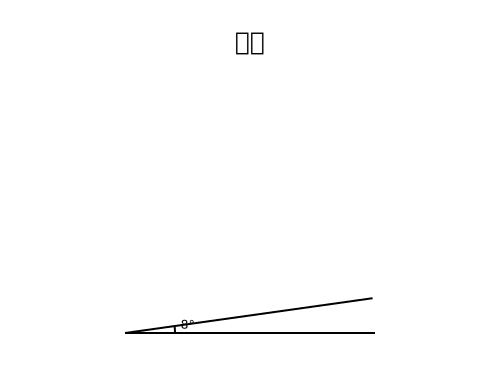

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="3.0779148512155814" y2="293.8913837399423" stroke="black" stroke

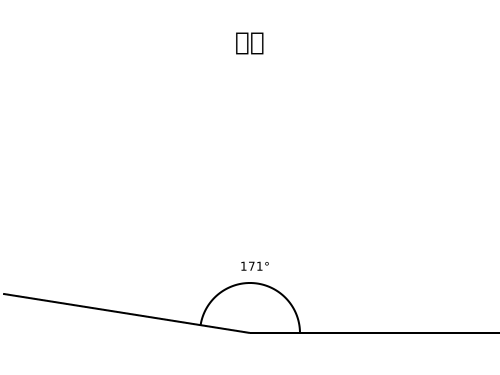

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="82.71734841028544" y2="147.21379363065145" stroke="black" stroke-width="2" />


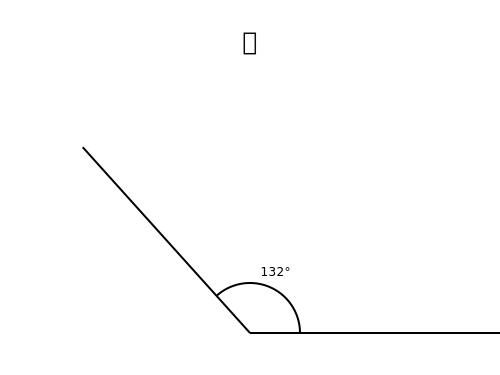

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="248.0073786238134" y2="105.6613024721535" stroke="black" stroke-width=

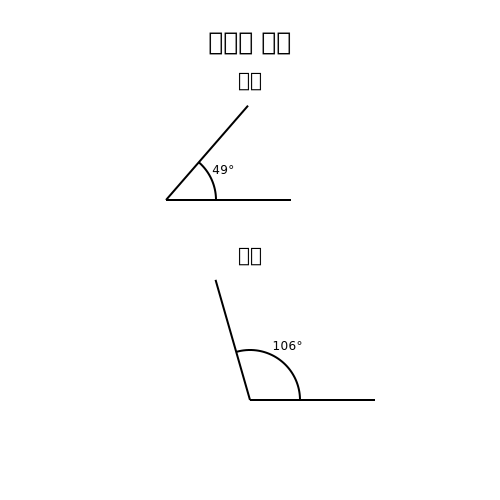

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="47.74575140626317" y2="186.05368692688168" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 209.54915028125265,303.61

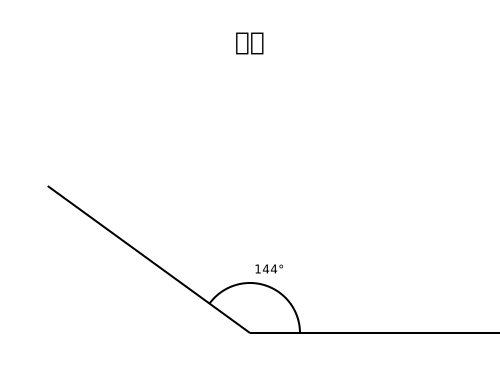

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

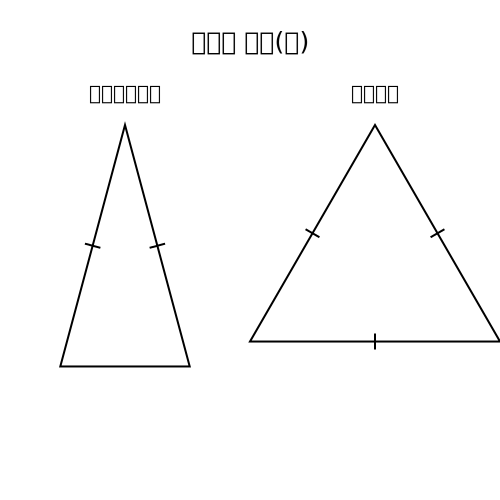

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

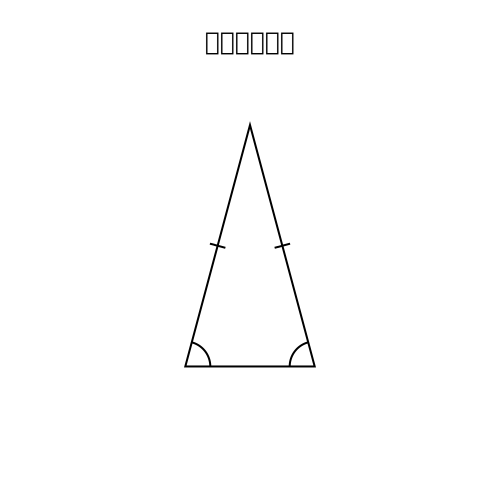

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

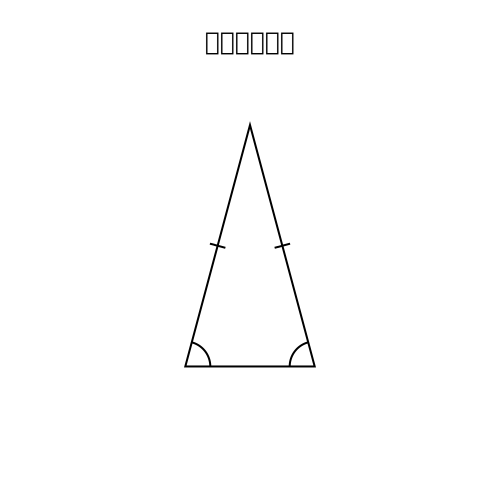

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

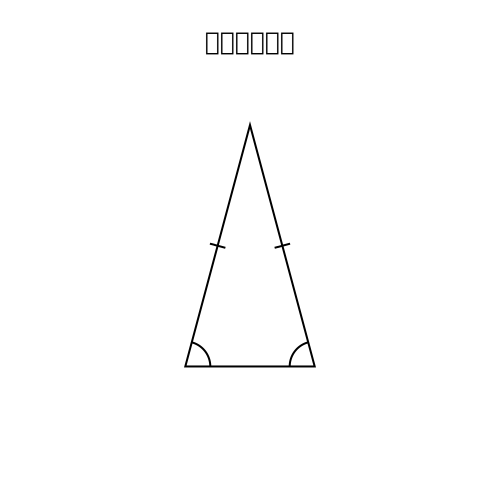

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

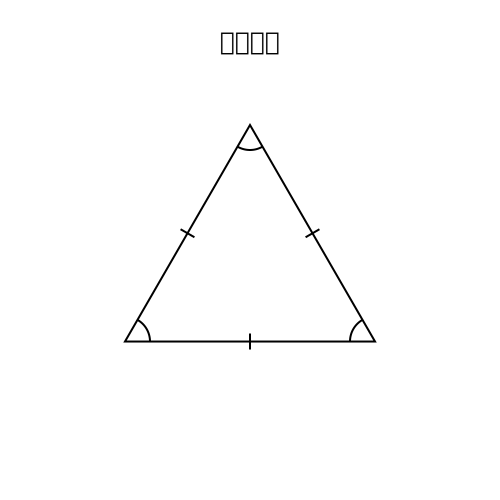

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

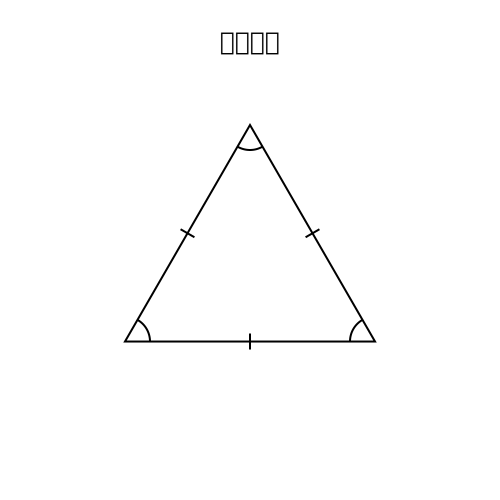

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

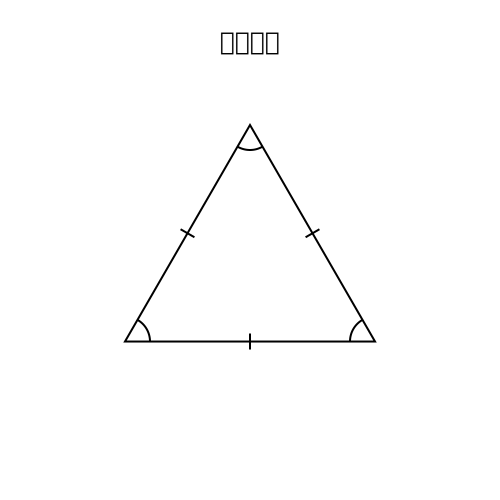

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


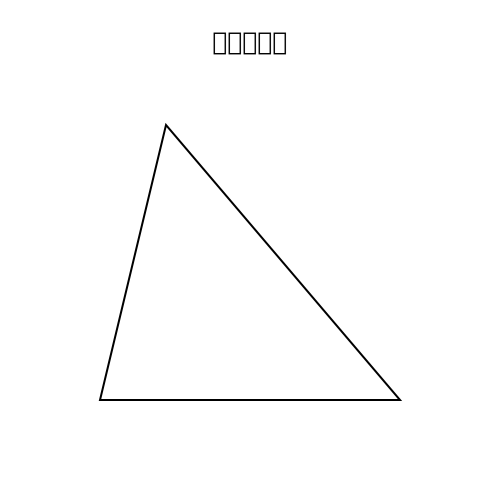

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

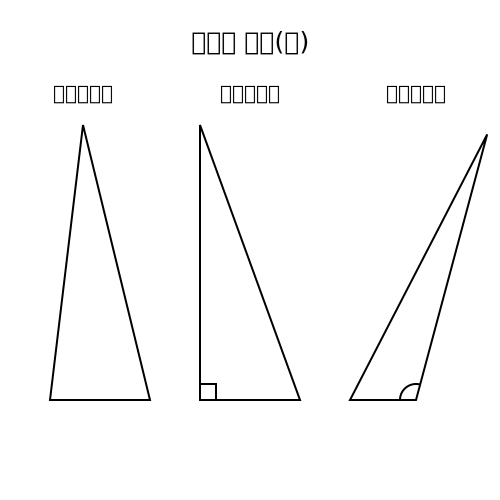

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


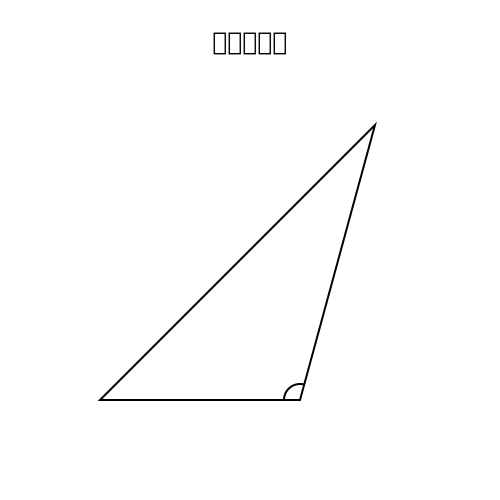

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

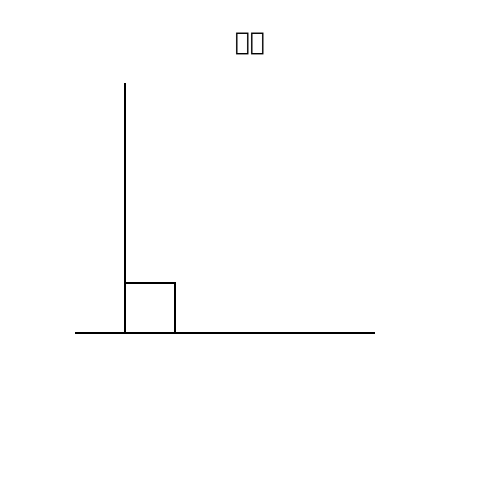

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

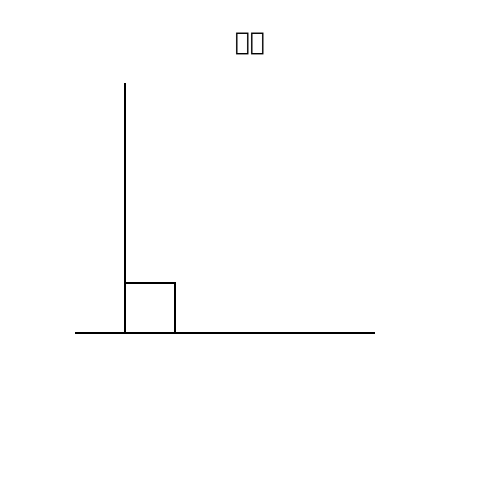

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

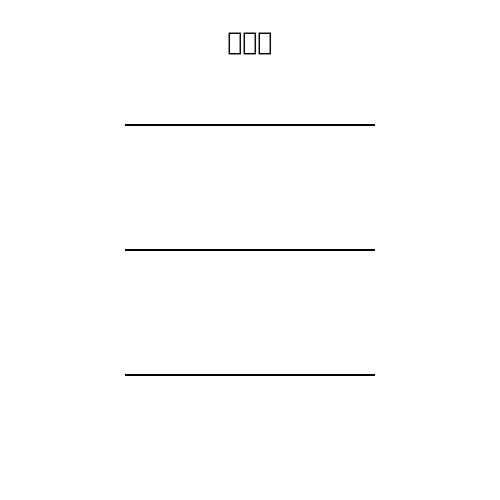

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

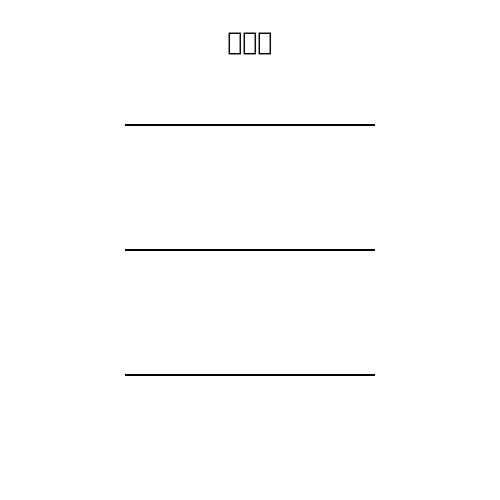

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


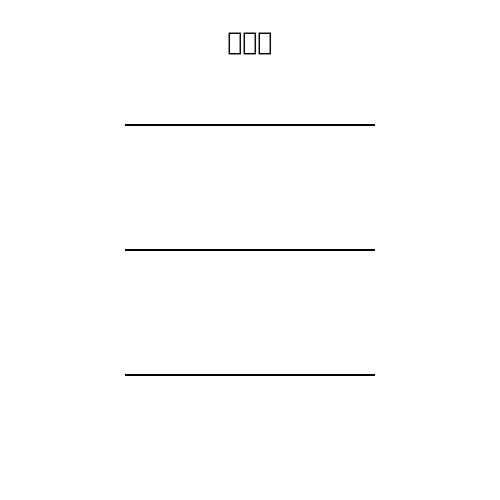

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

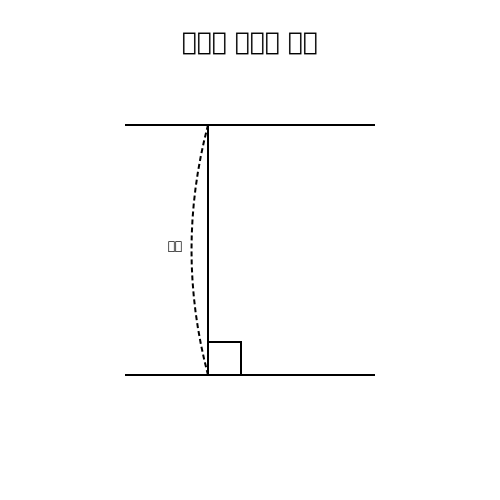

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

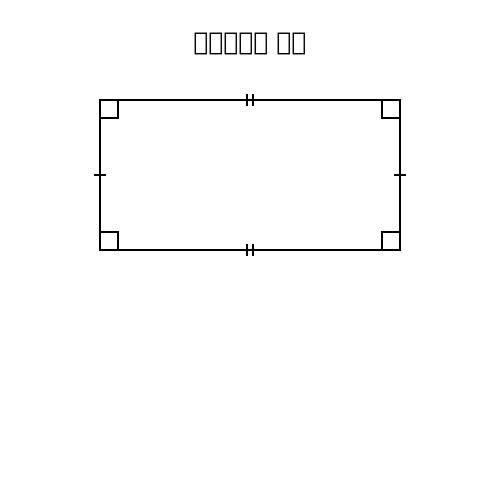

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

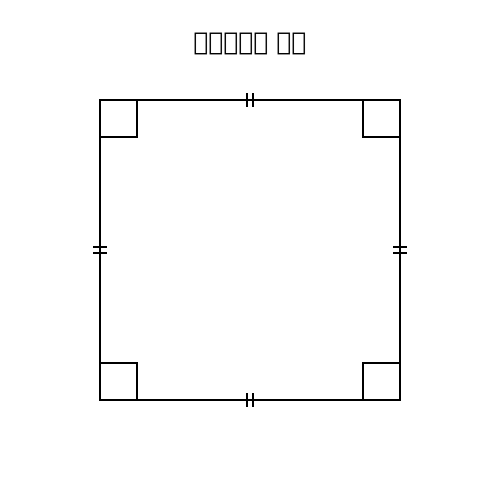

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

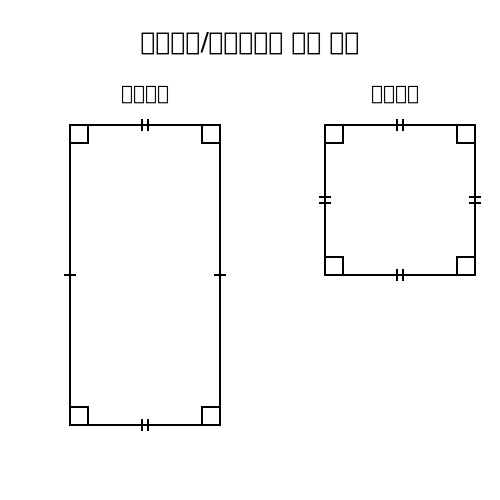

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


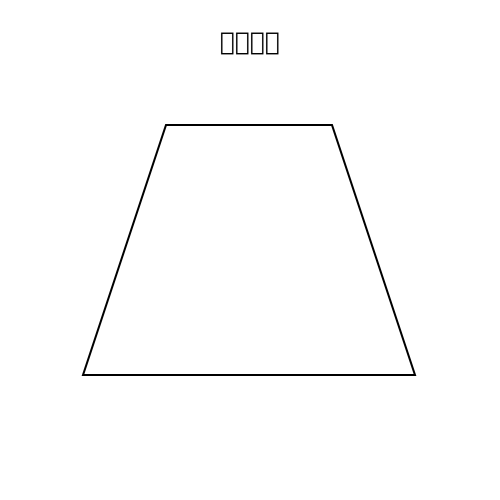

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

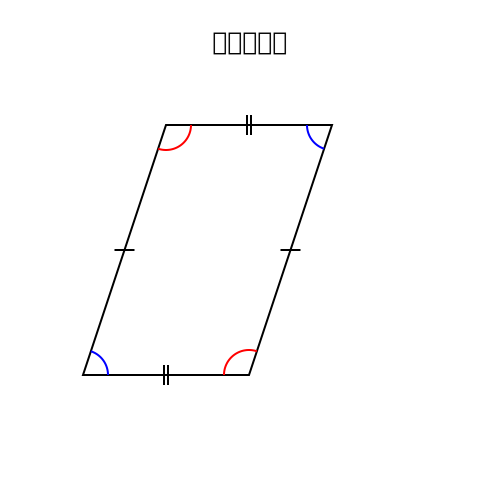

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

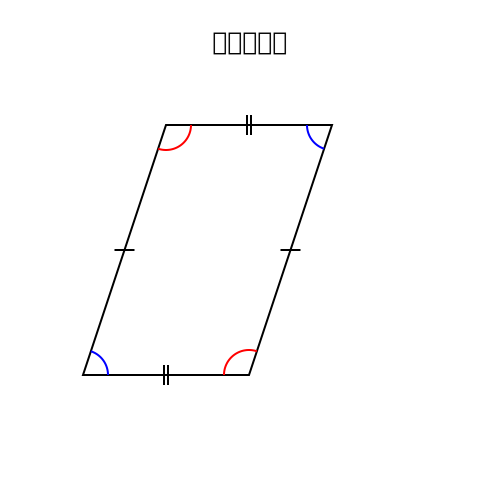

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

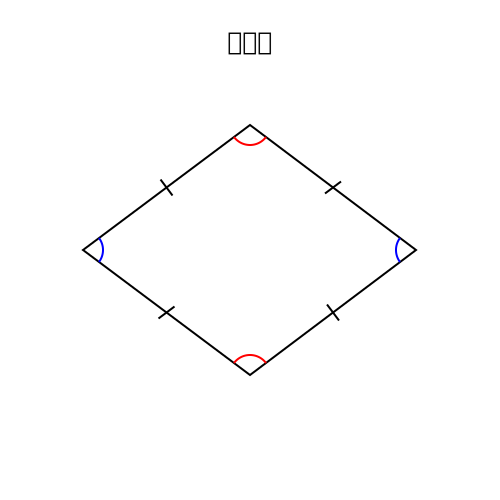

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

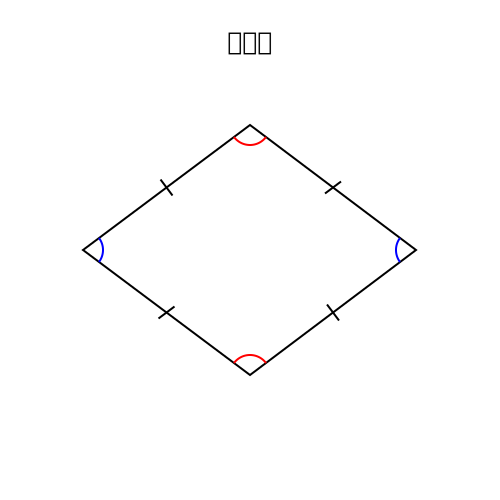

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

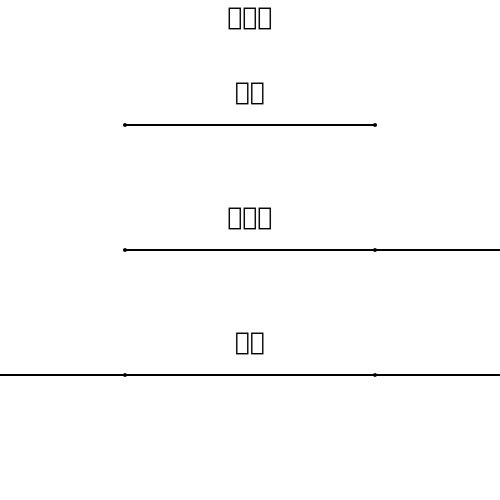

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="1.3695261579316877" y2="306.8678841830866" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.27390523158633,327.77357683661734 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="253.270997265184" y="270.58565407783914" font-size="12" text-anchor="middle">174°</text>
        </svg>
        


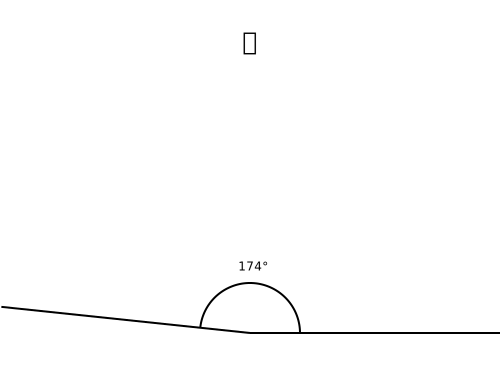

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

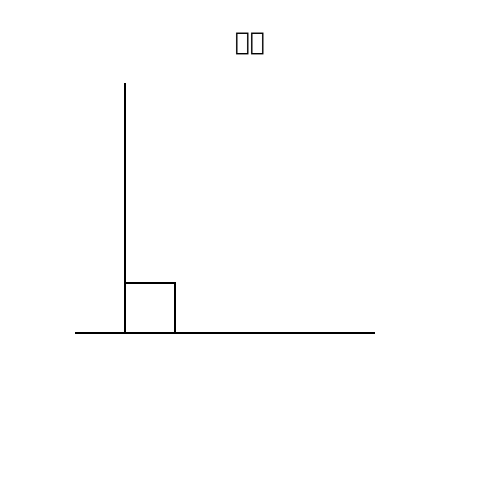

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


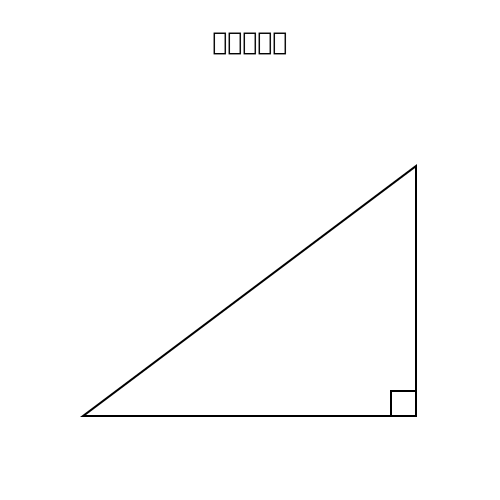

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


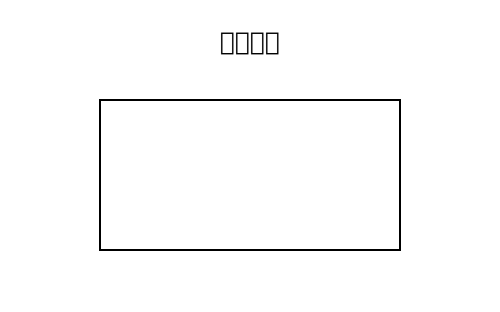

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


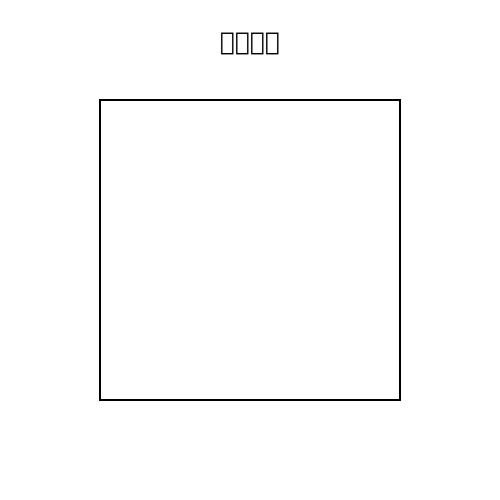

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


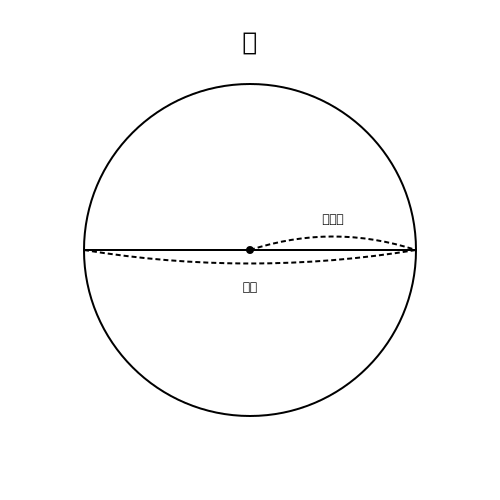

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


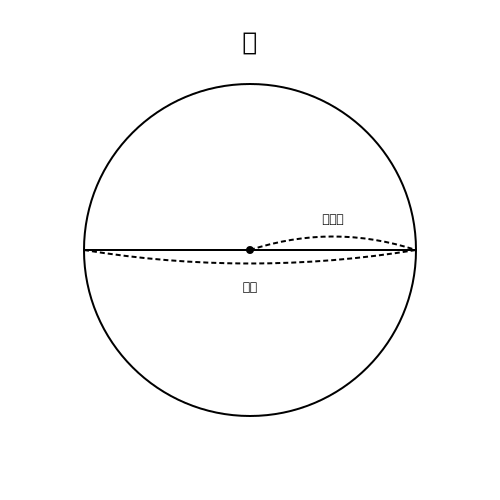

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

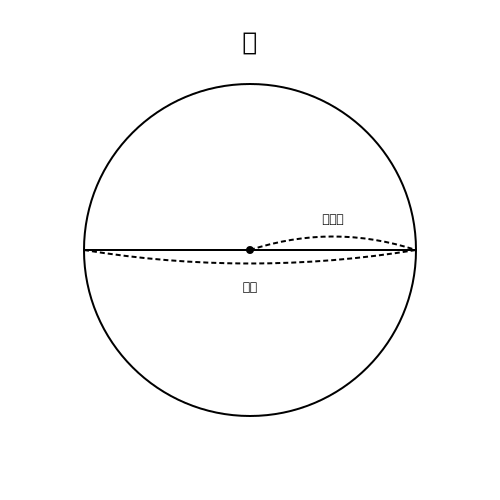

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

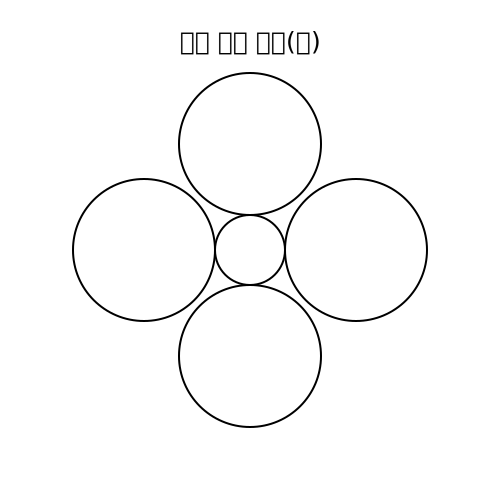

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="230.65456543517485" y2="106.4230532408375" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 146.13091308703497,287.6846106481675 A 50,50 0 0,1 175,333" stroke=

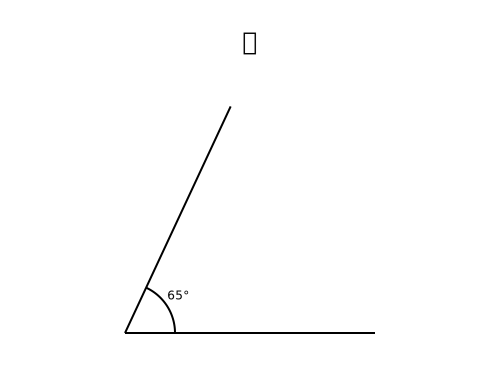

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="372.5670171853926" y2="298.2067247599837" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.51340343707852,326.04134495199673 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/

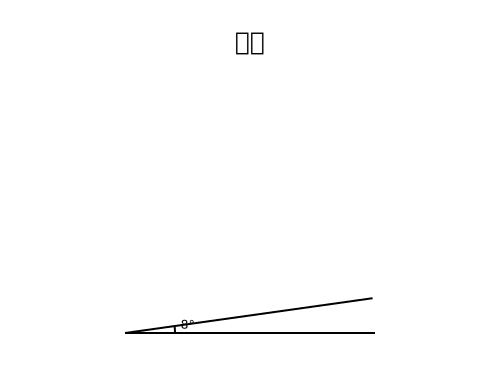

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="339.29182517552806" y2="204.24048127248645" stroke="black" strok

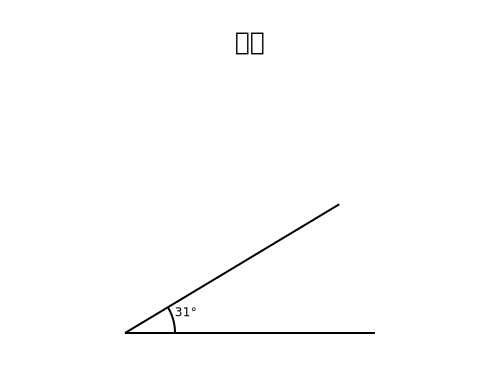

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="345.73689821473175" y2="215.6321093035273" stroke="black" stroke-width="2" />


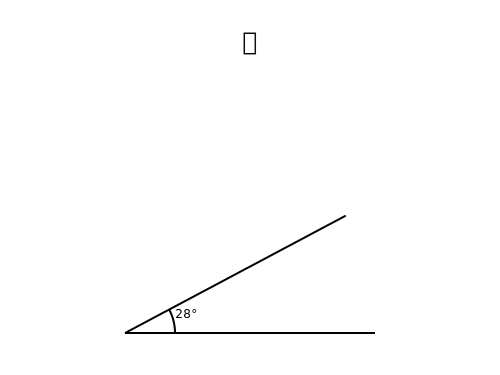

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="285.5380944953794" y2="163.4535369096579" stroke="black" stroke-width=

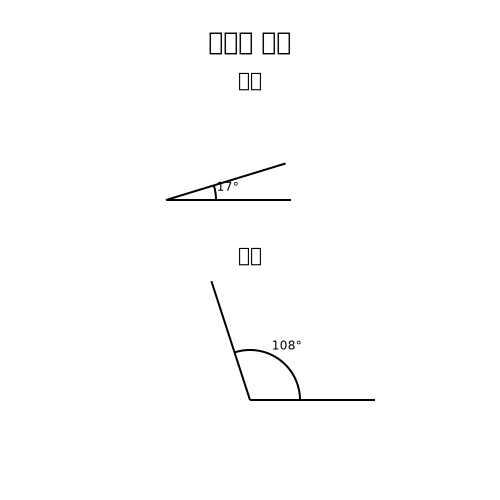

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="89.30309757836517" y2="141.4888892202555" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 217.86061951567302,294.697

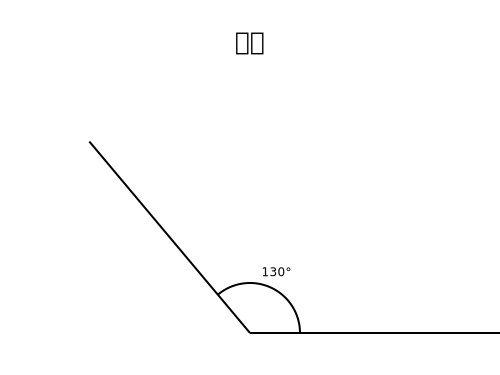

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

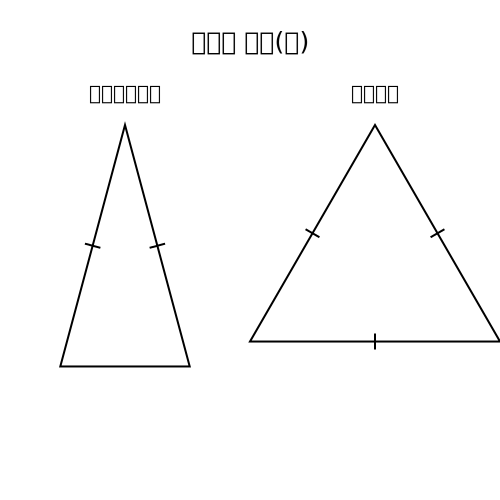

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

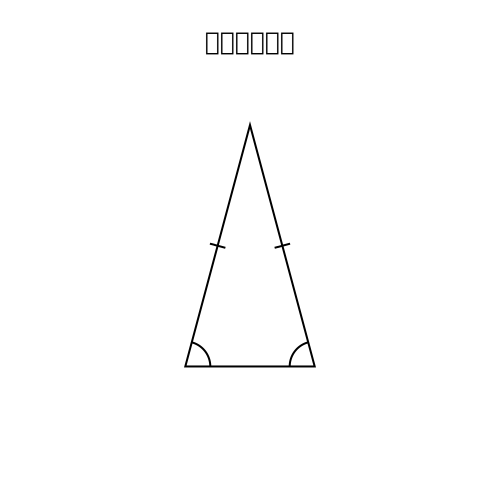

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

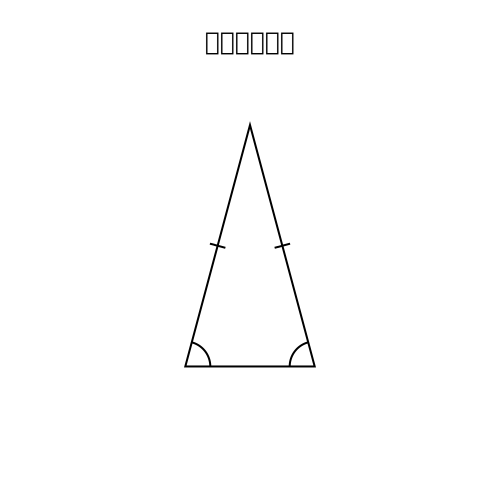

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

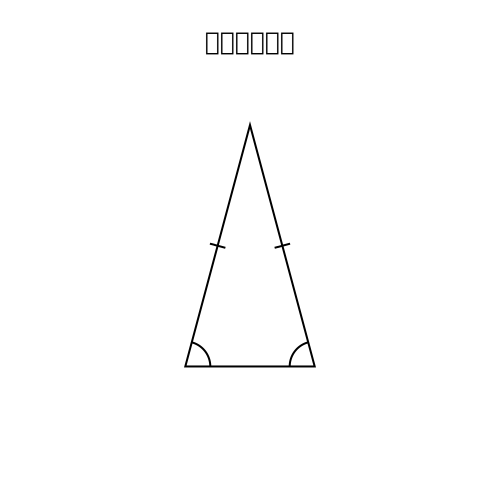

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

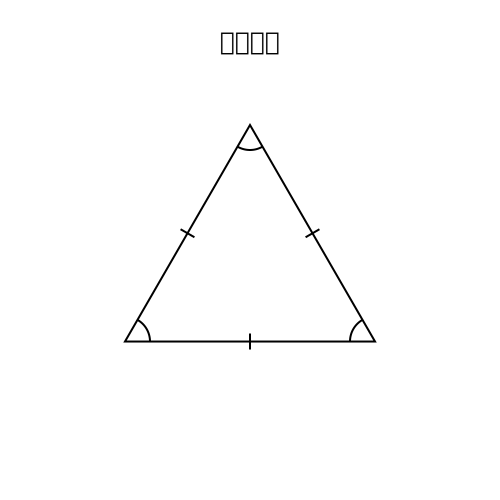

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

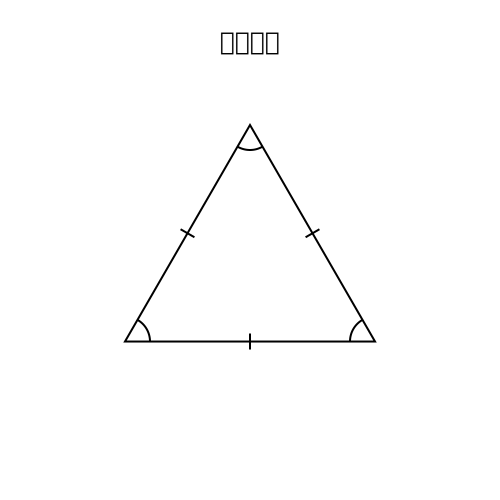

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

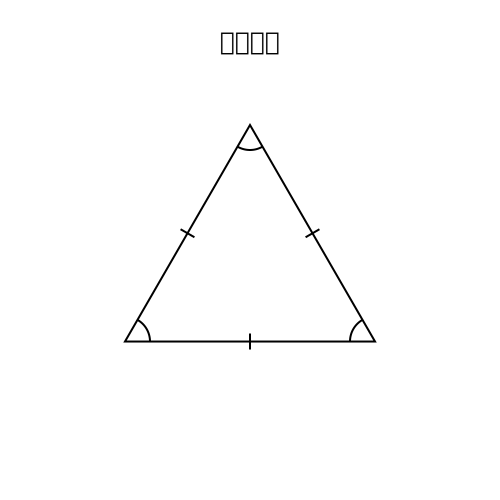

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


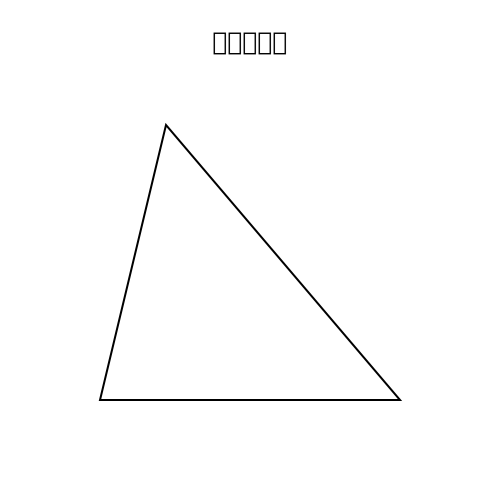

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

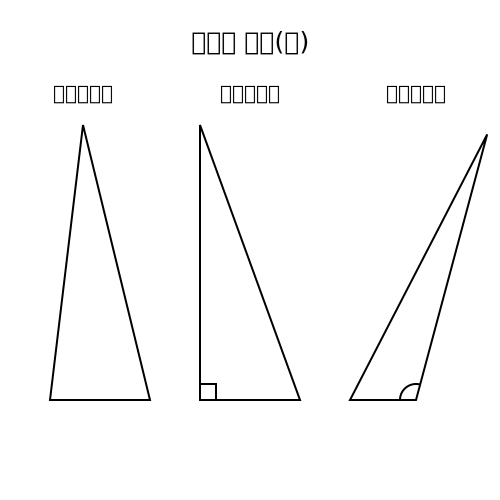

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


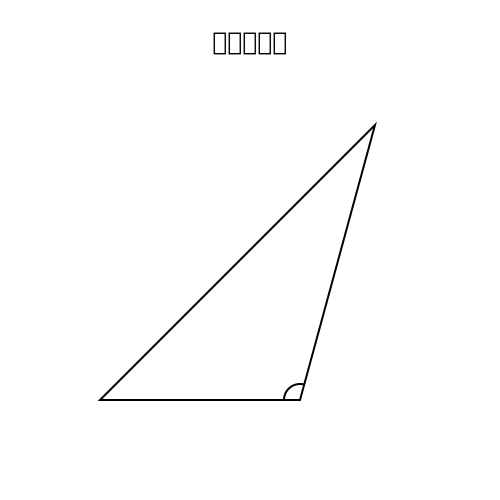

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

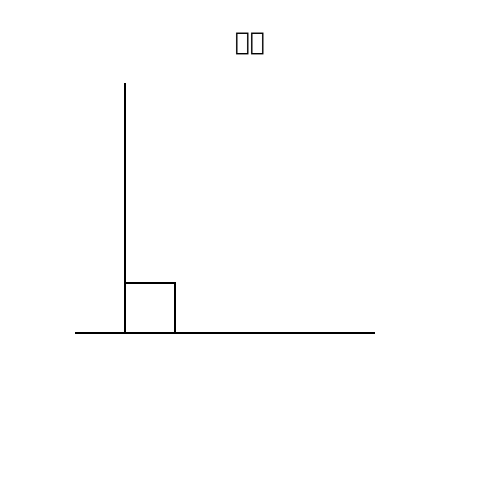

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

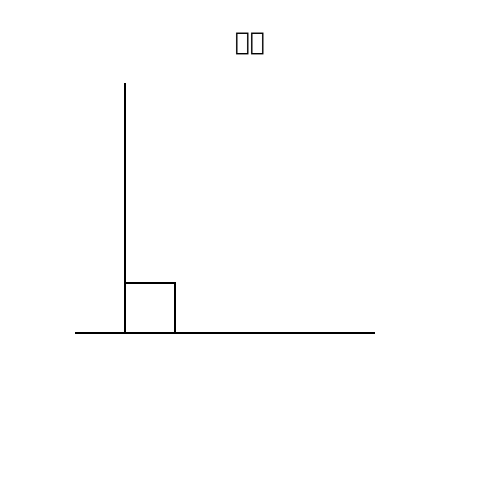

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

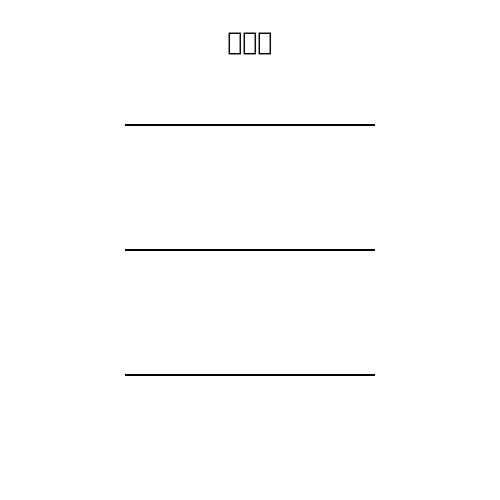

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

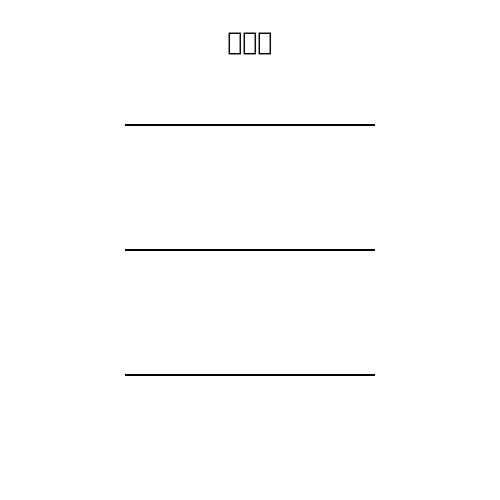

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


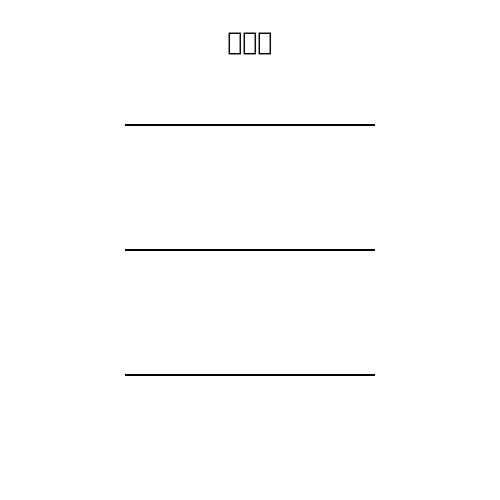

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

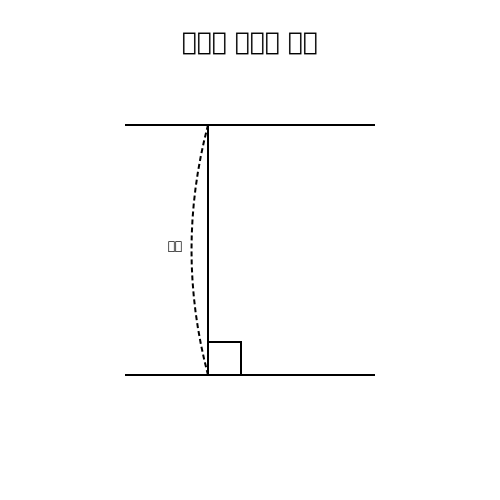

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

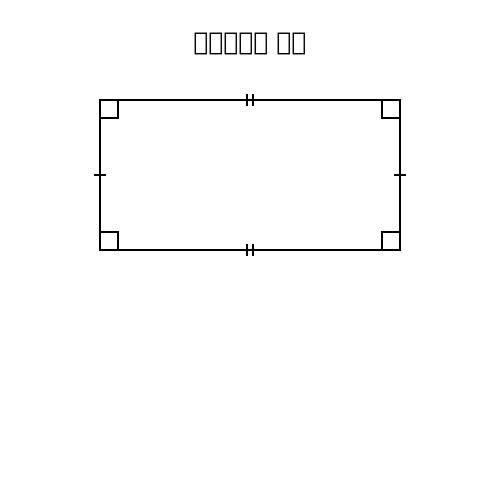

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

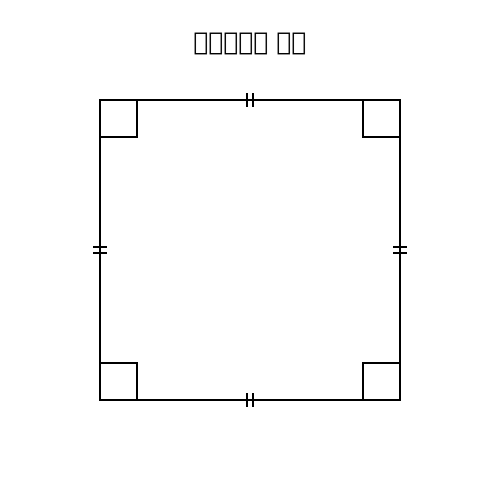

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

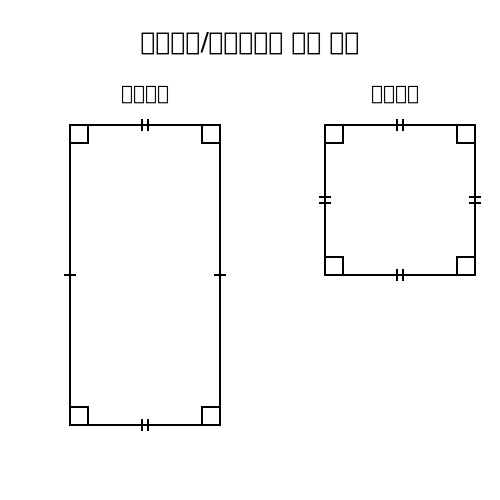

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


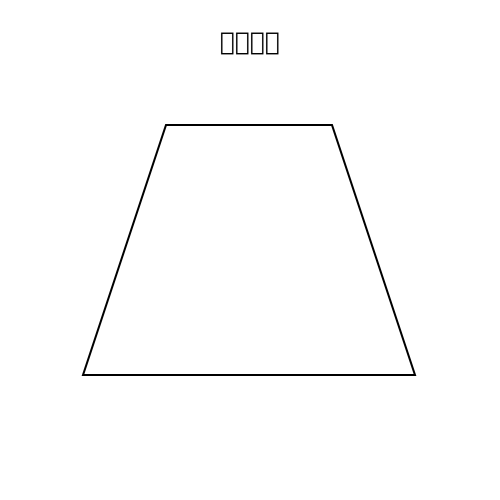

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

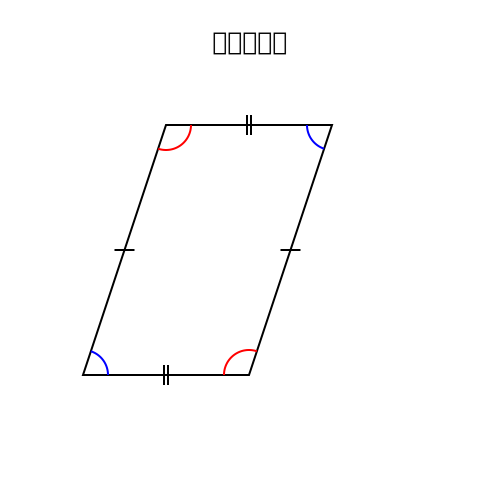

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

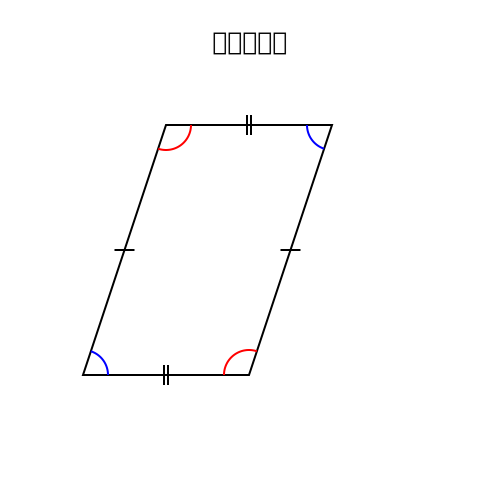

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

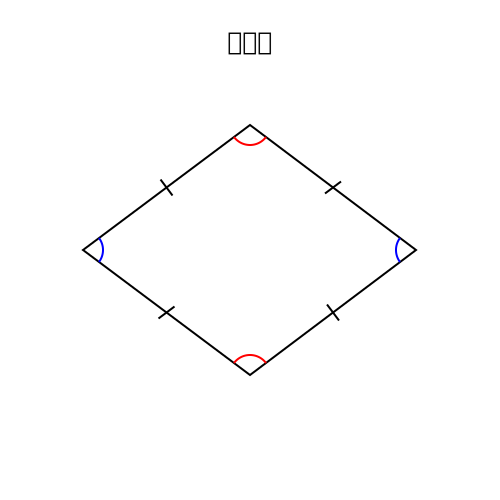

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

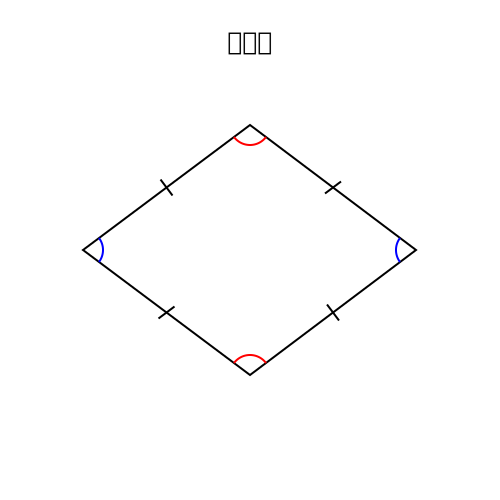

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

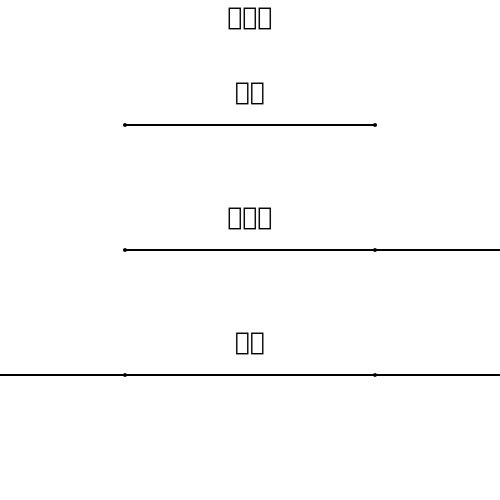

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="367.5739315689991" y2="272.51952610008306" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 173.51478631379982,320.9039052200166 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="187.03413447758263" y="325.3831660371783" font-size="12" text-anchor="middle">14°</text>
        </svg>
        


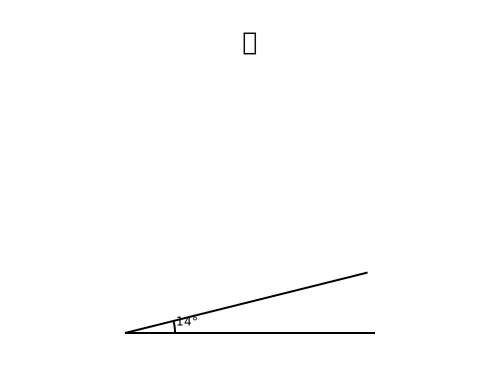

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

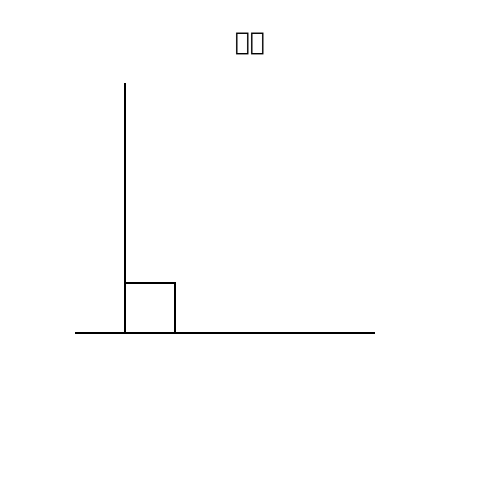

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


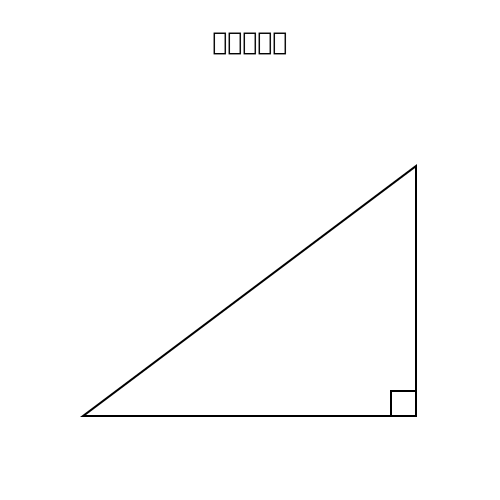

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


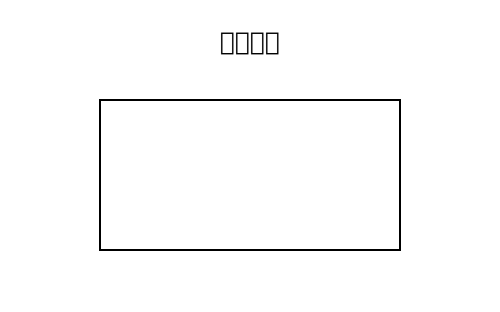

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


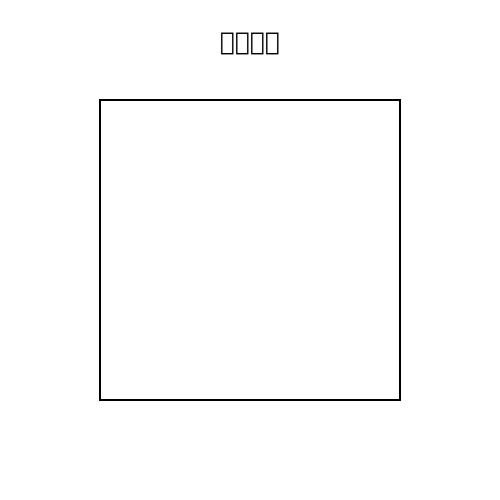

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


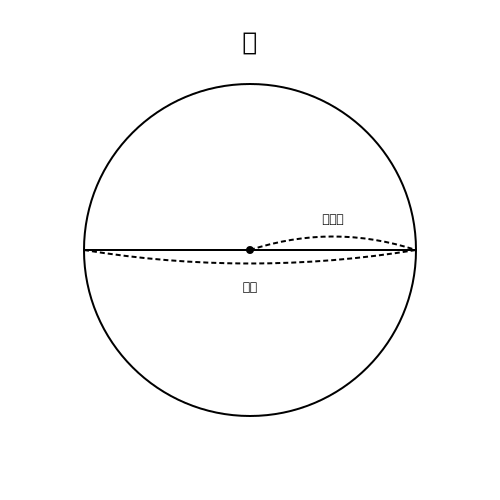

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


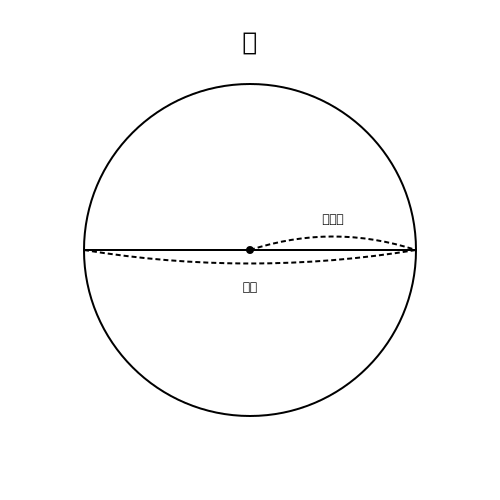

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

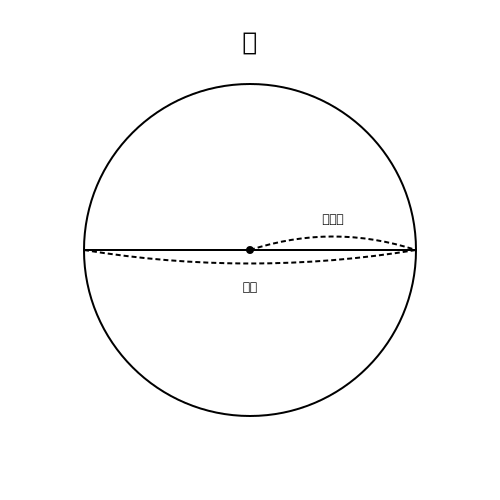

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

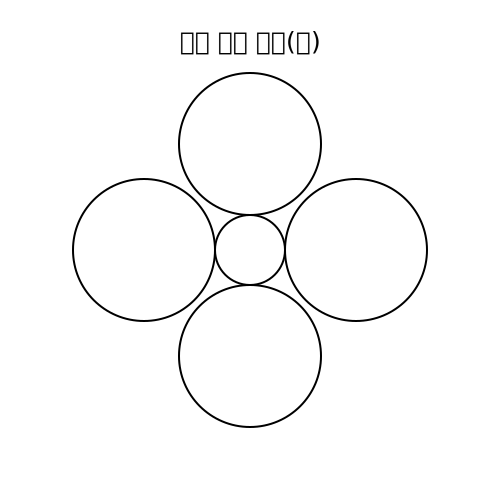

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="368.5925161963088" y2="276.76223641403374" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 173.71850323926176,321.75244728280677 A 50,50 0 0,1 175,333" stroke

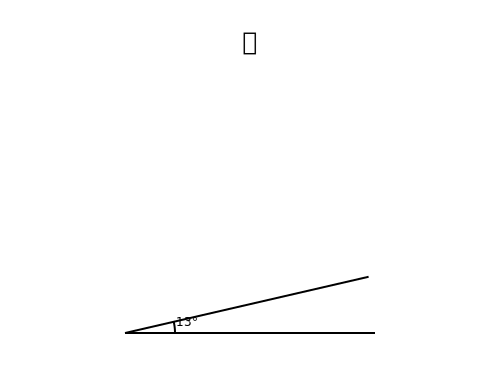

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="37.98797596089352" y2="200.52018394169878" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 207.5975951921787,306.50403678833976 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/

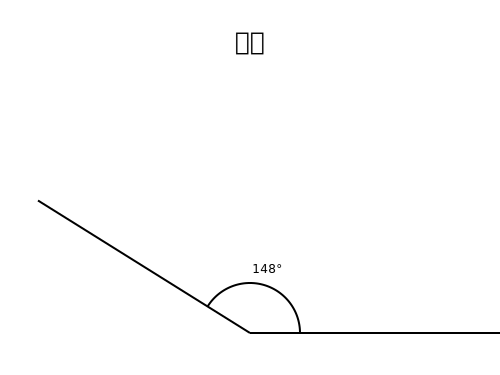

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="264.7982258676867" y2="125.74060686123957" stroke="black" stroke

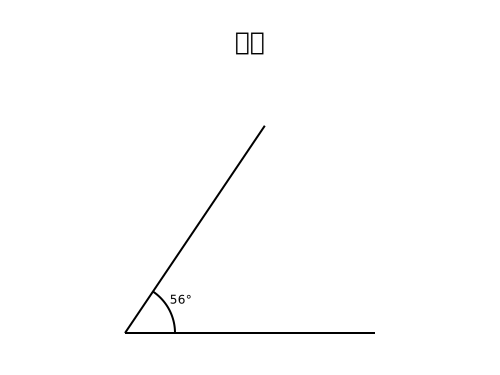

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="236.91601093926403" y2="83.34261631135655" stroke="black" stroke-width="2" />


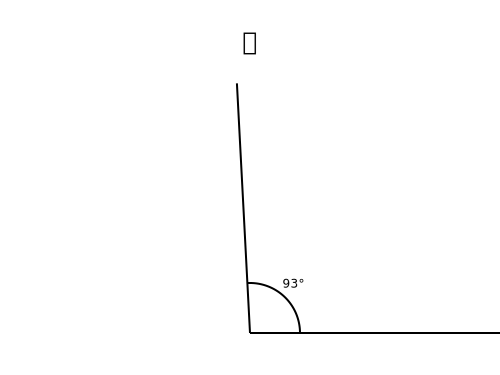

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="290.9809618945489" y2="197.81844919533955" stroke="black" stroke-width

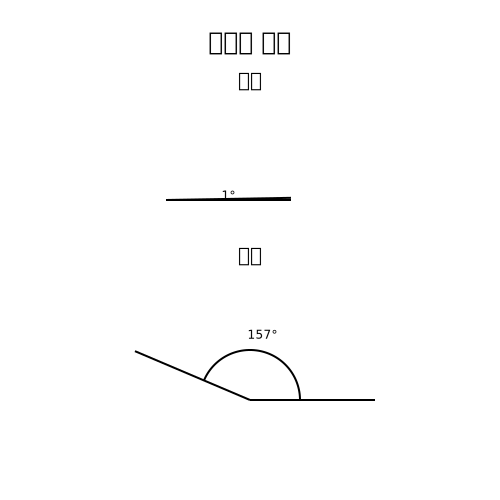

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="222.68278212231843" y2="102.87378663688992" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 144.5365564244637,286.97

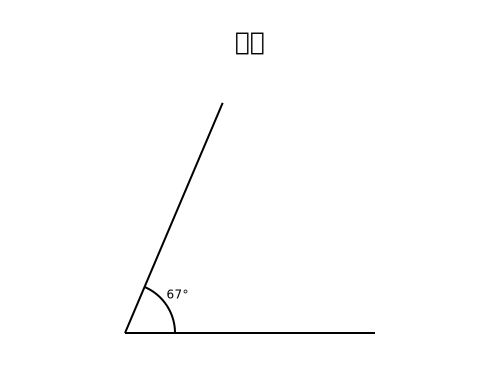

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

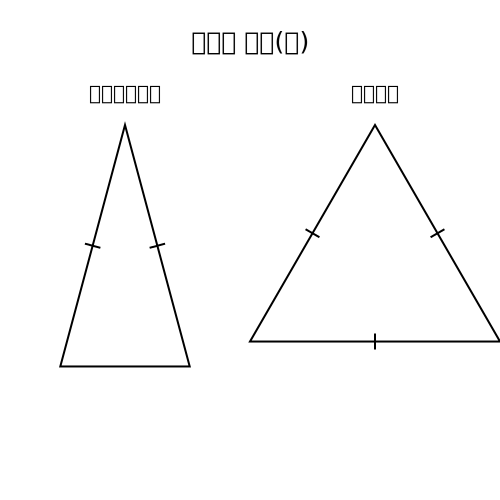

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

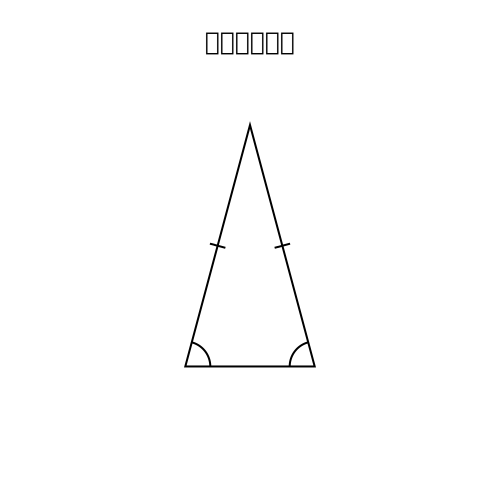

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

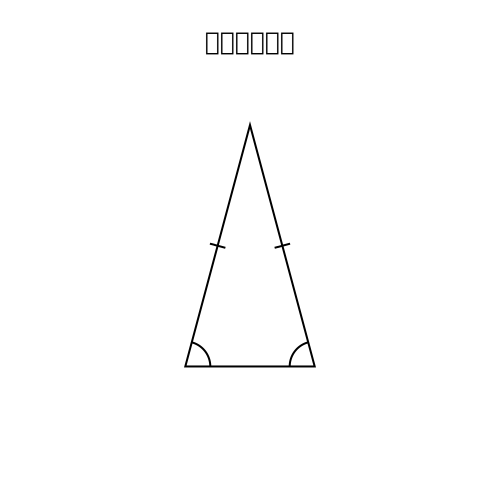

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

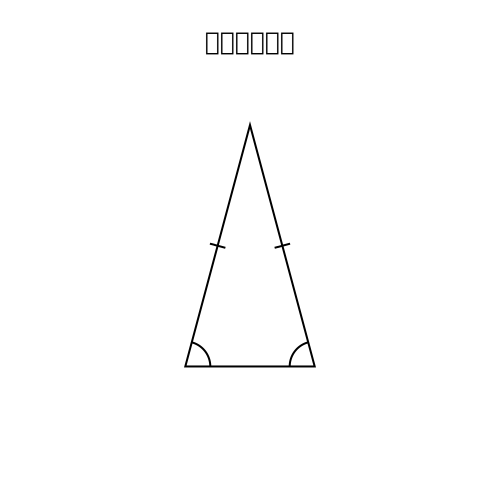

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

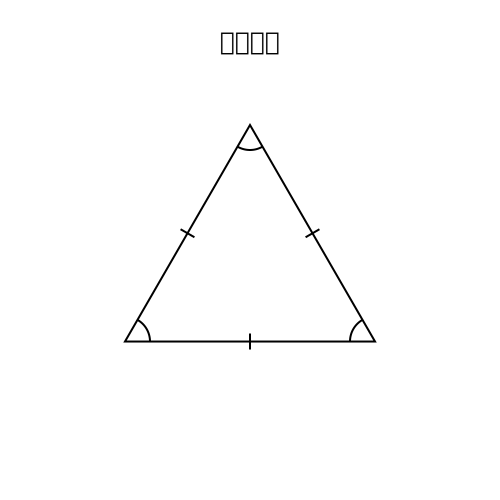

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

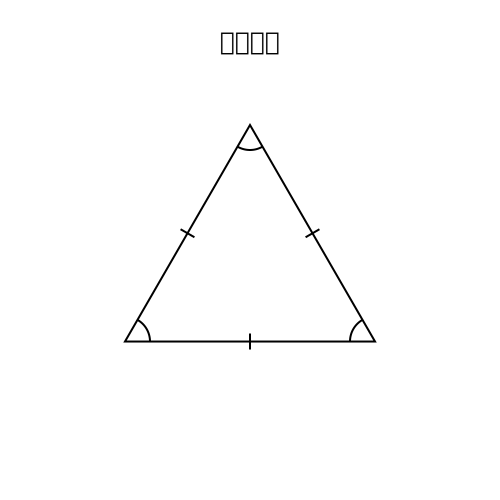

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

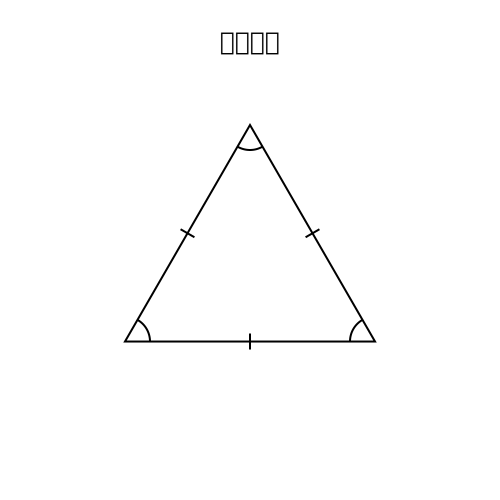

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


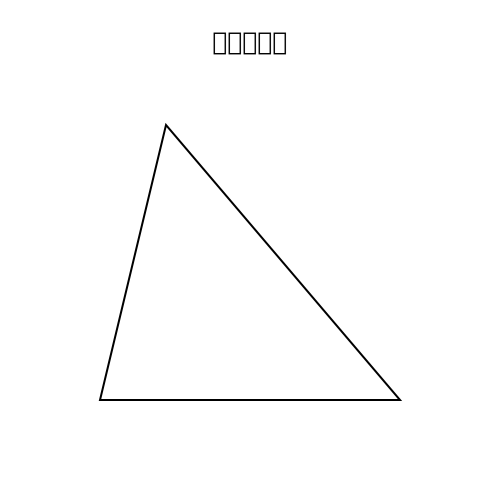

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

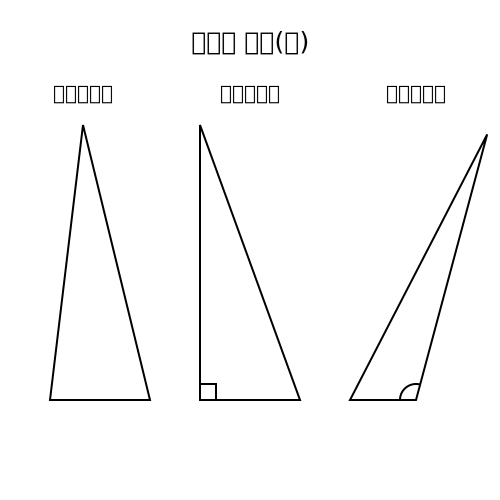

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


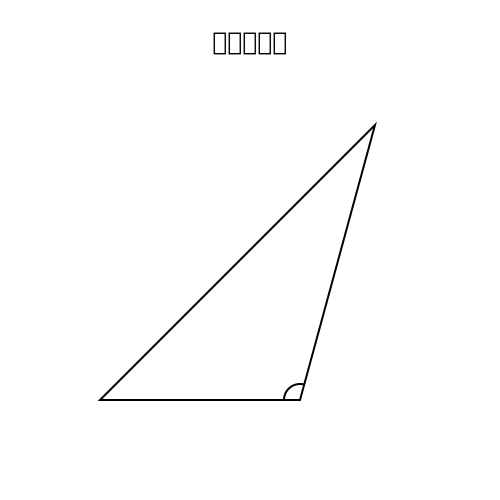

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

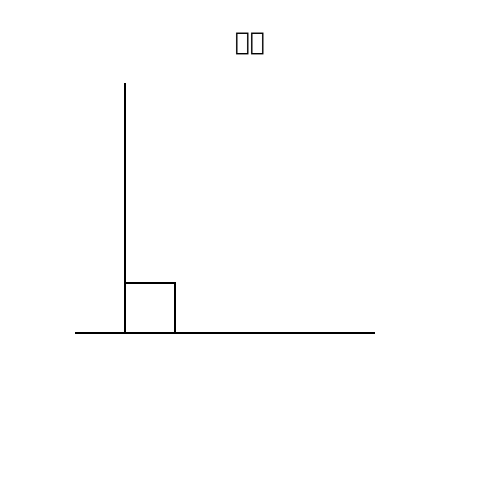

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

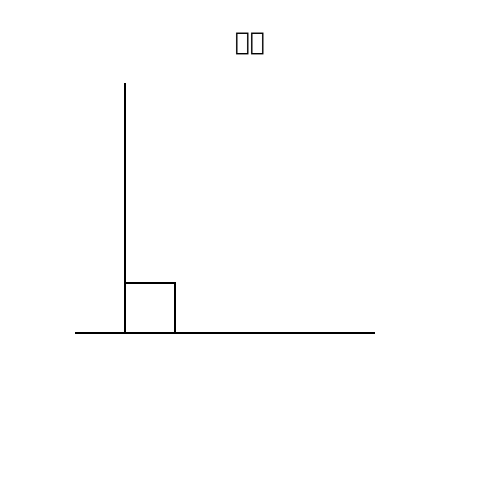

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

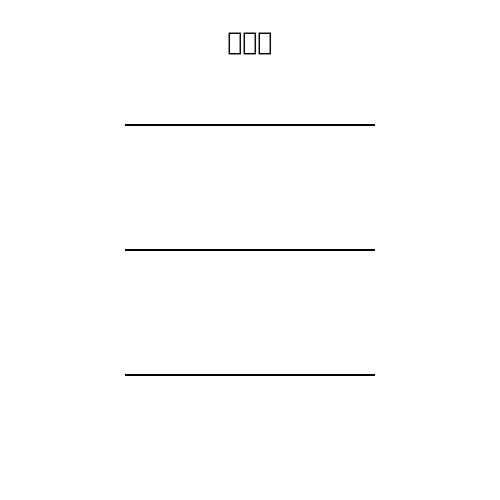

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

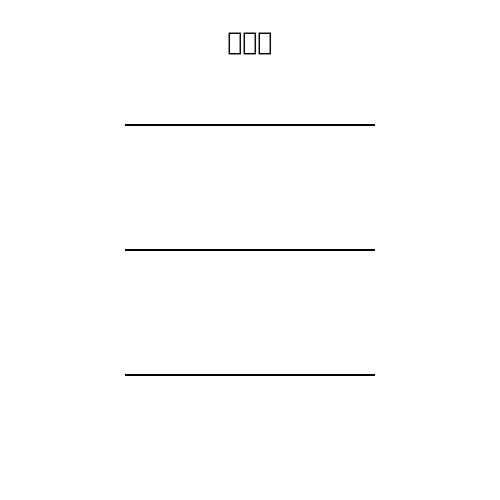

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


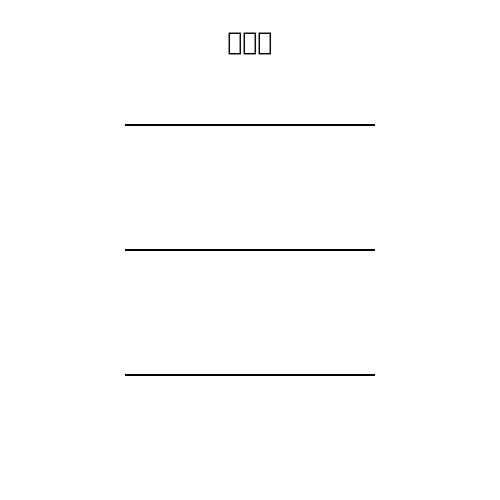

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

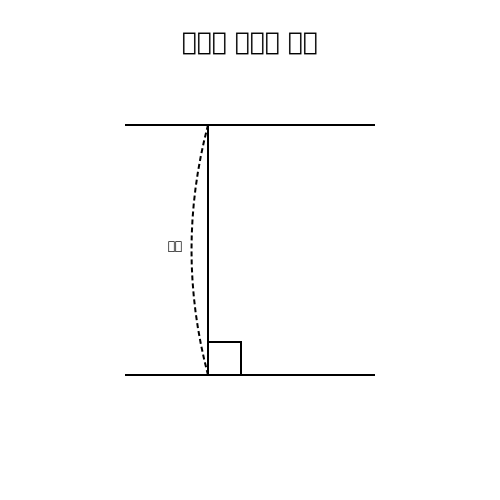

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

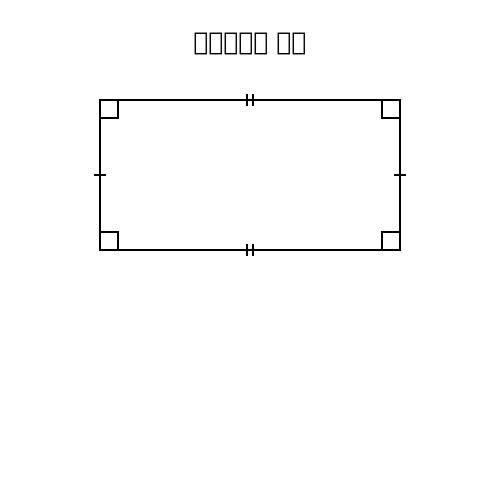

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

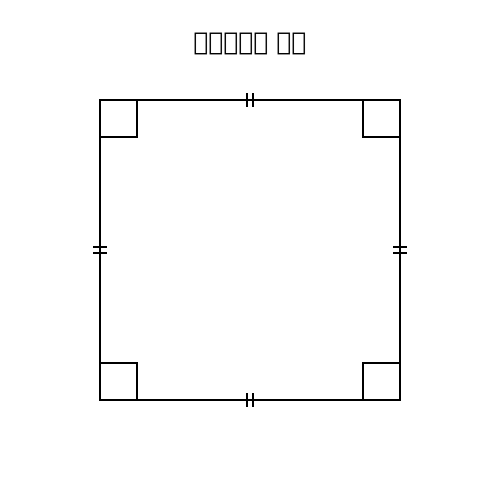

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

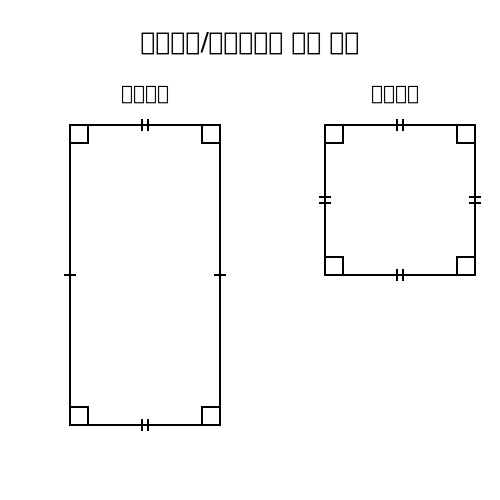

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


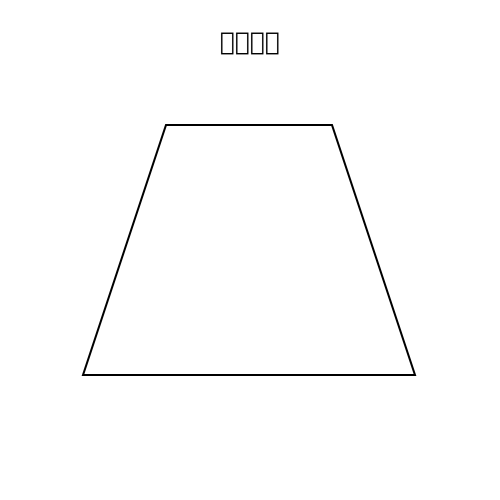

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

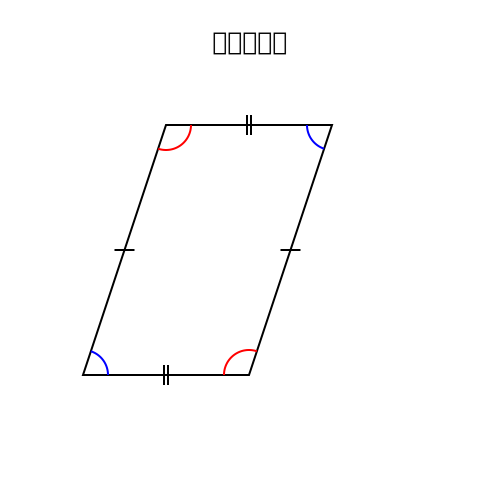

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

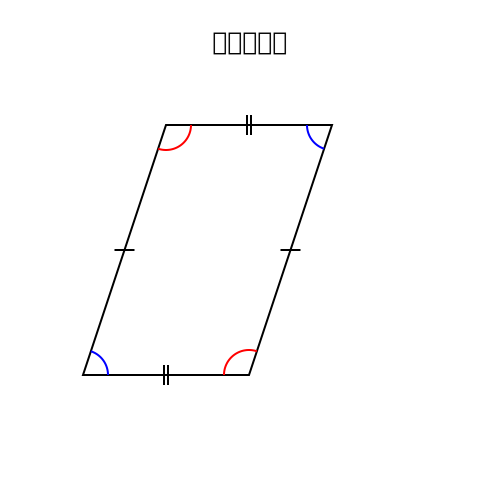

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

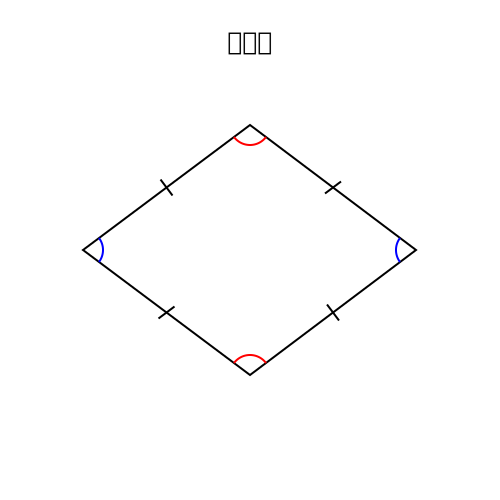

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

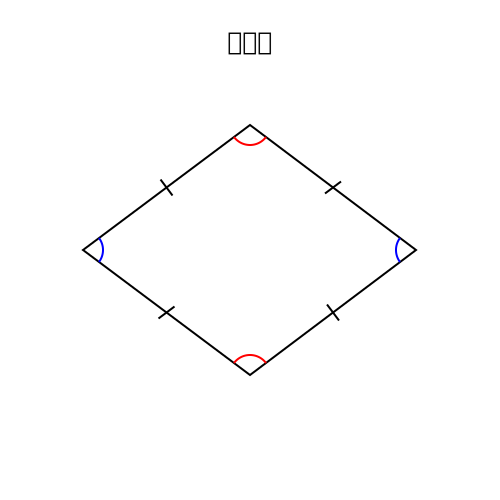

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

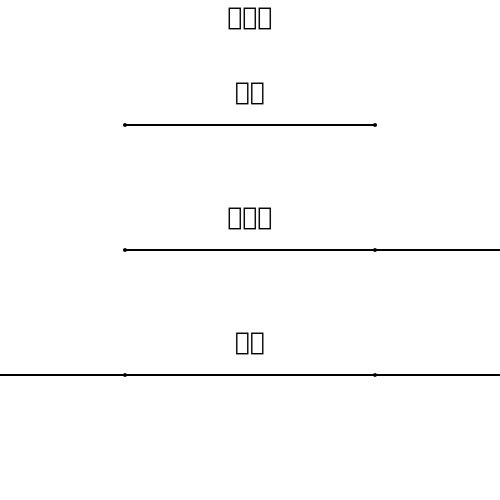

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="292.28265158971453" y2="147.21379363065145" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 158.4565303179429,295.8427587261303 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="182.09659110266256" y="307.5789598077625" font-size="12" text-anchor="middle">48°</text>
        </svg>
        


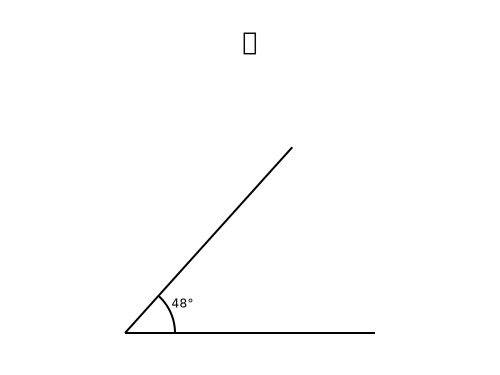

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

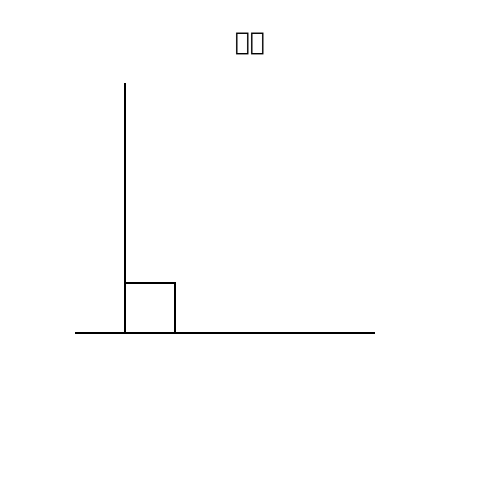

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


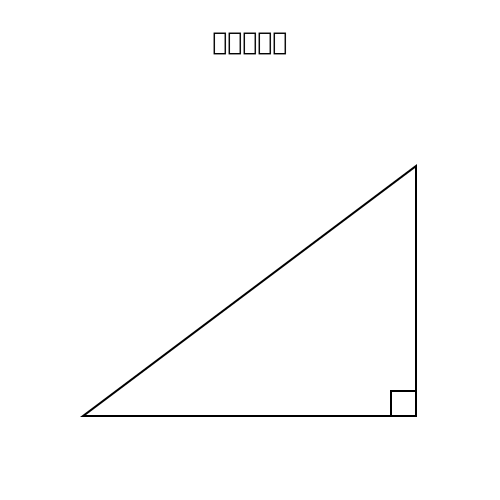

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


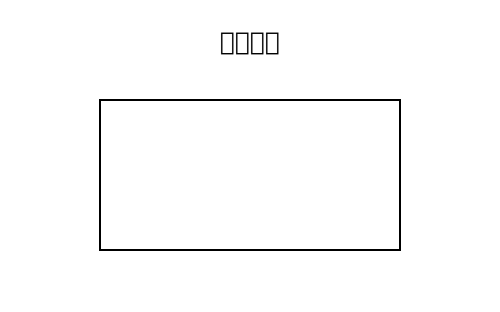

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


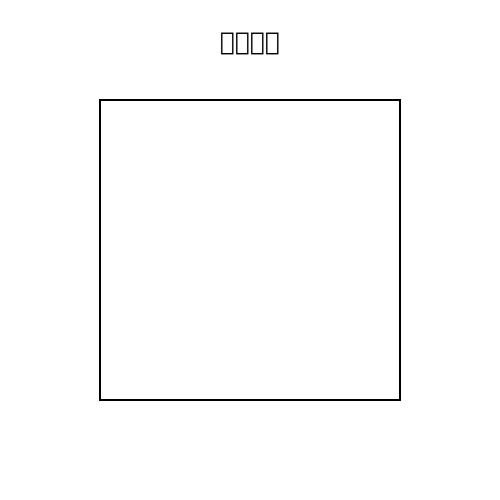

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


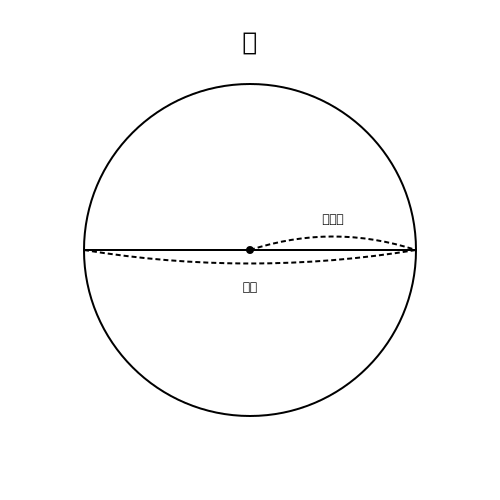

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


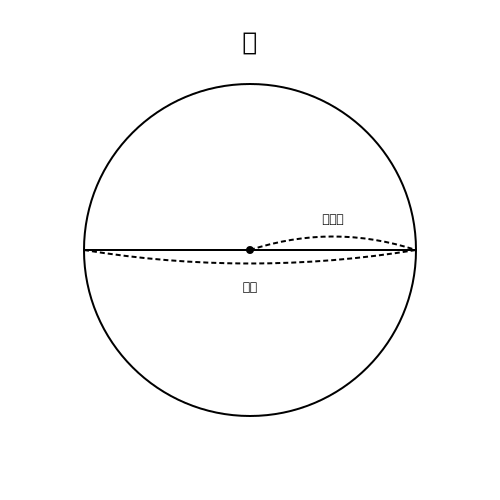

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

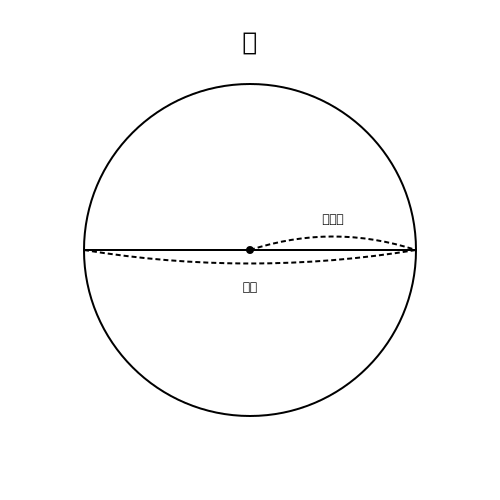

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

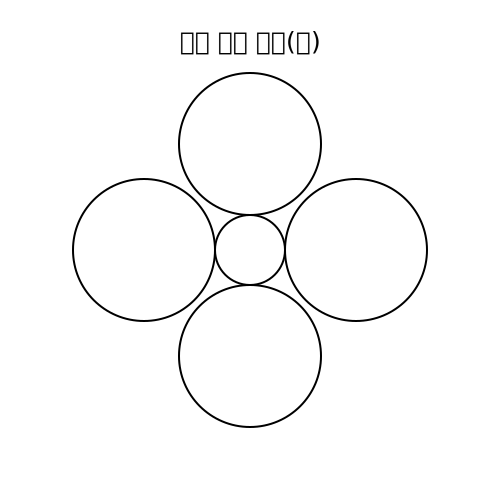

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="16.60489337569956" y2="243.40801261367494" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 203.3209786751399,315.081602522735 A 50,50 0 0,1 300,333" stroke="b

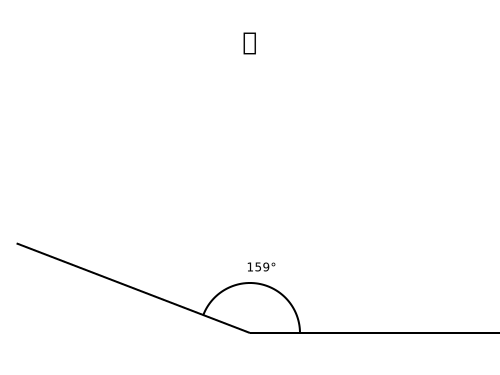

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="295.4995900156246" y2="150.16157459520738" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 159.0999180031249,296.43231491904146 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/

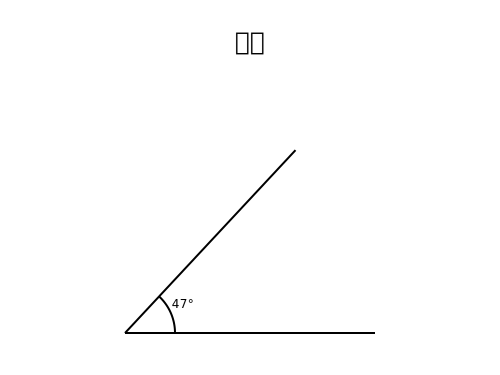

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="193.9093389542498" y2="92.68457601542028" stroke="black" stroke-

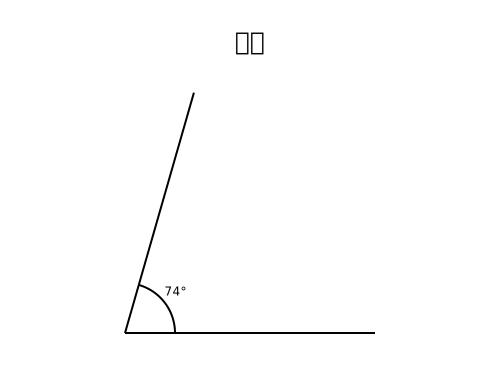

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="151.13211581691337" y2="84.36952615793169" stroke="black" stroke-width="2" />


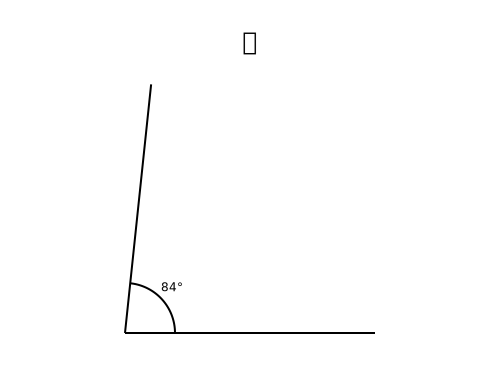

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="214.84139106115921" y2="84.93689331844496" stroke="black" stroke-width

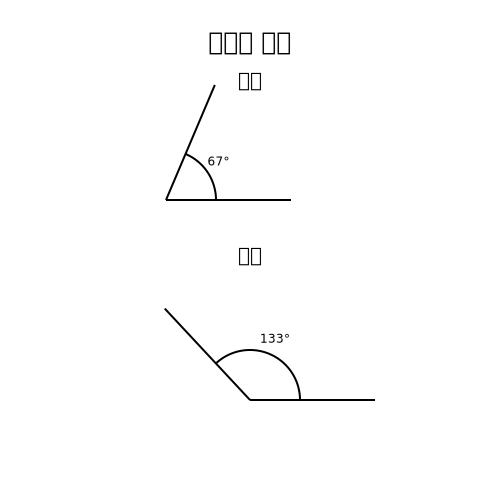

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="198.09292618068417" y2="93.92381100924115" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 139.61858523613682,285.18

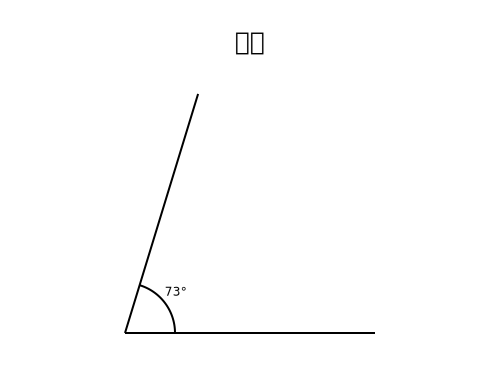

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

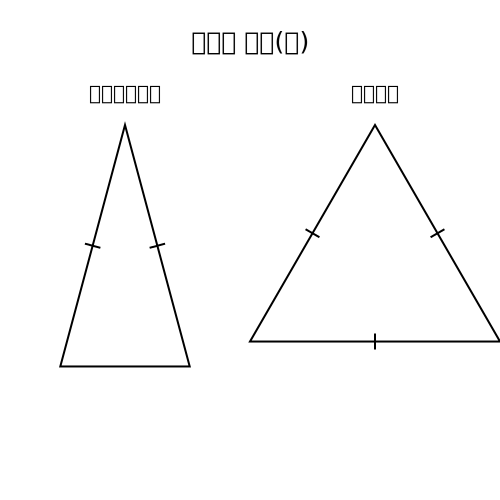

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

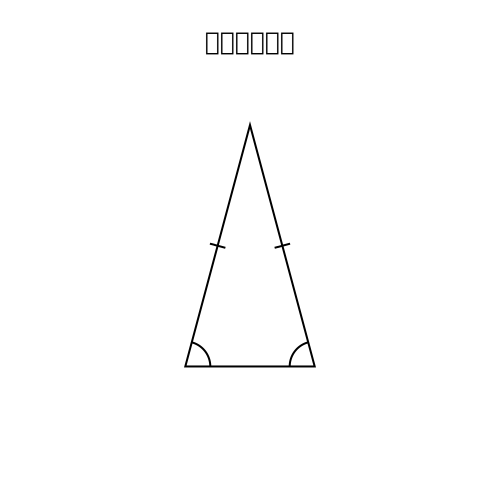

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

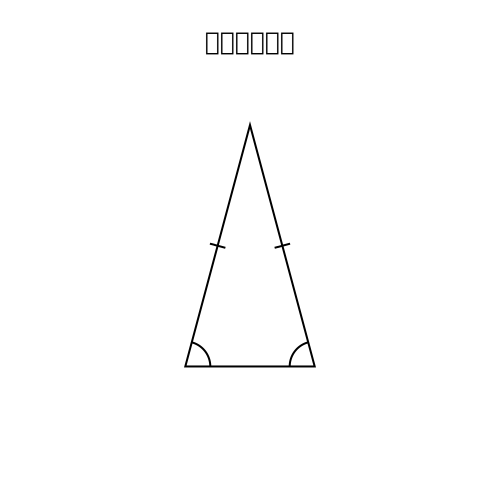

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

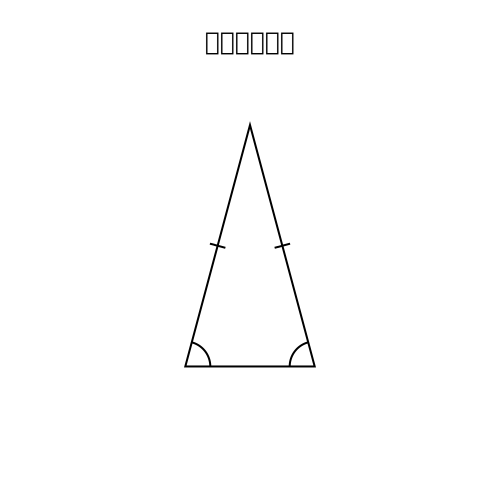

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

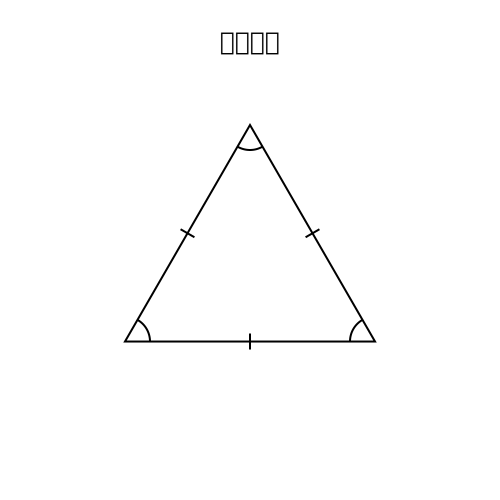

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

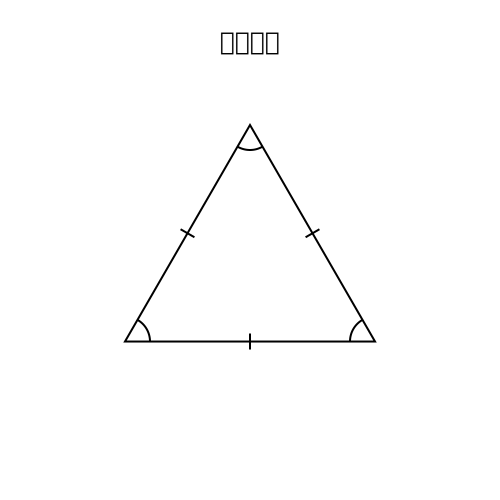

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

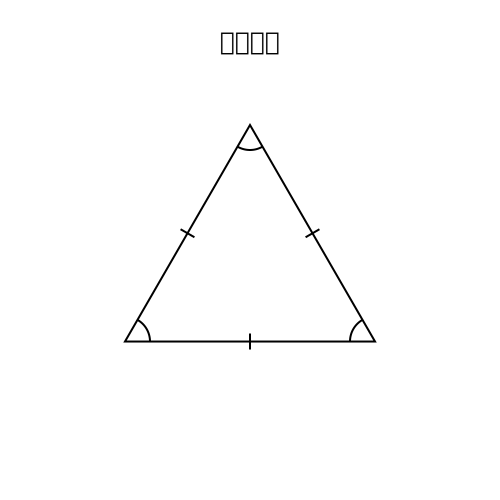

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


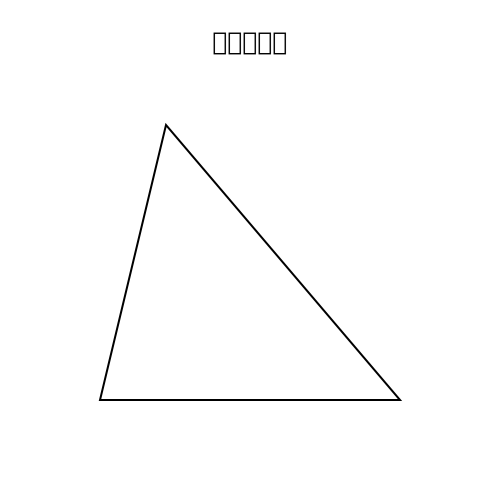

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

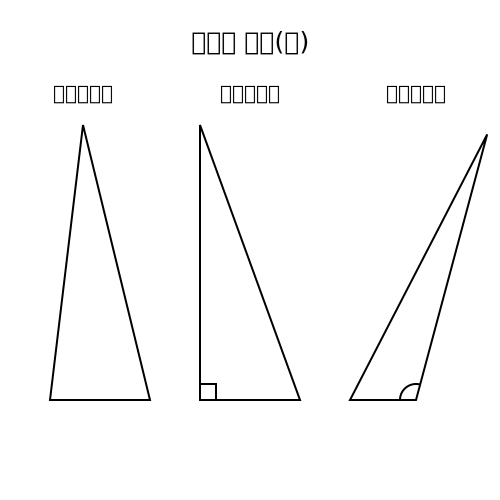

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


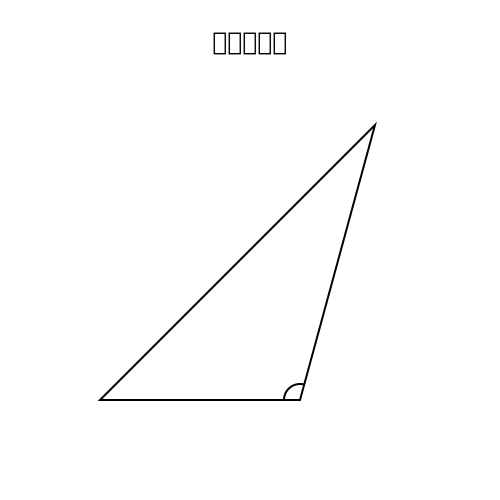

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

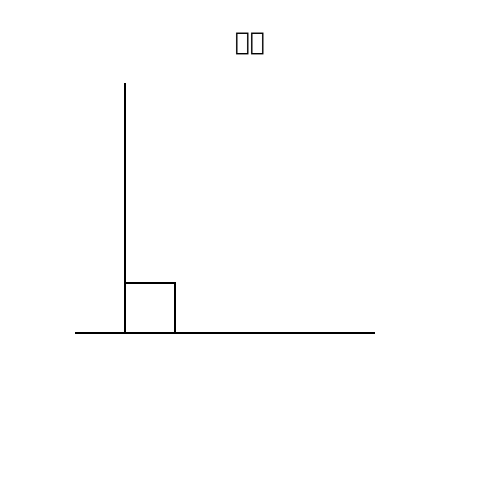

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

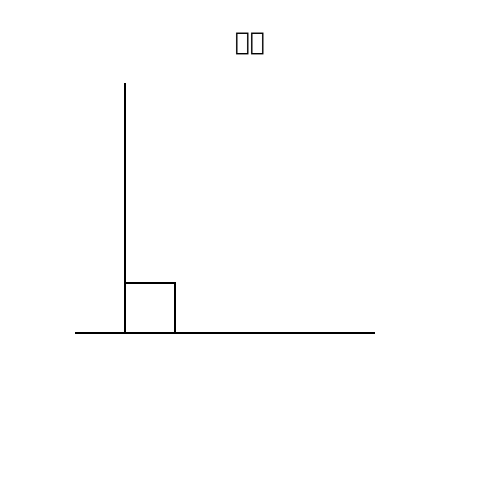

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

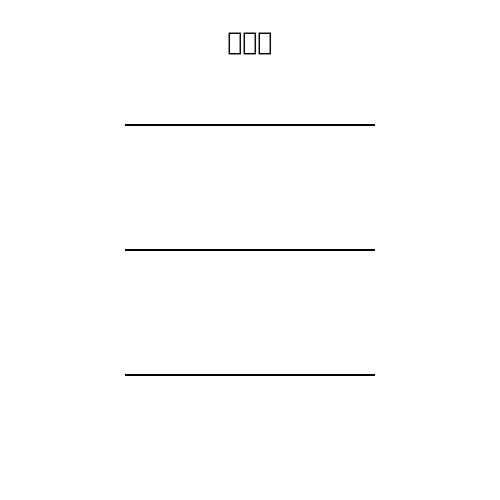

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

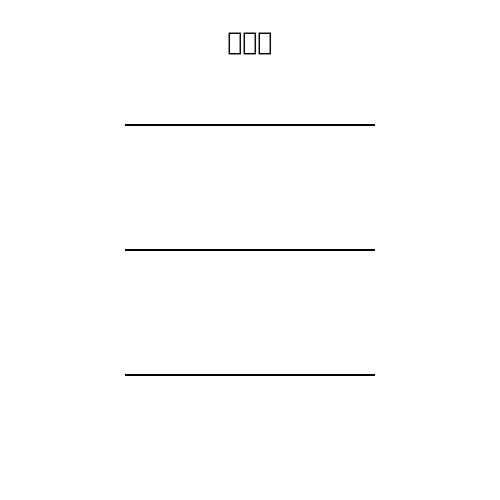

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


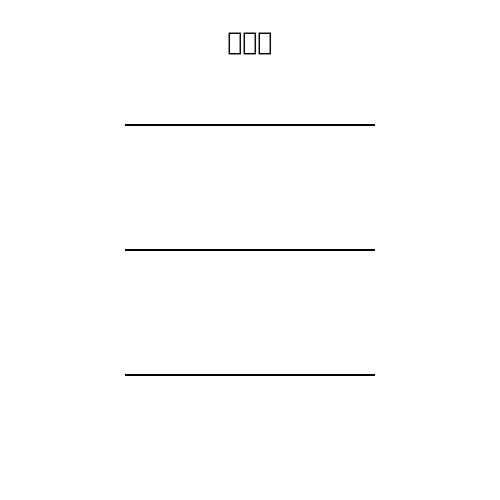

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

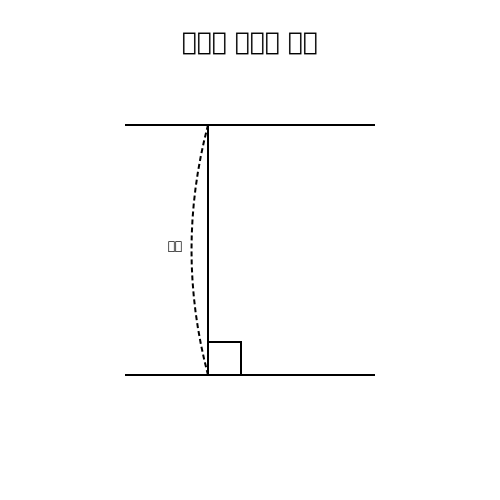

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

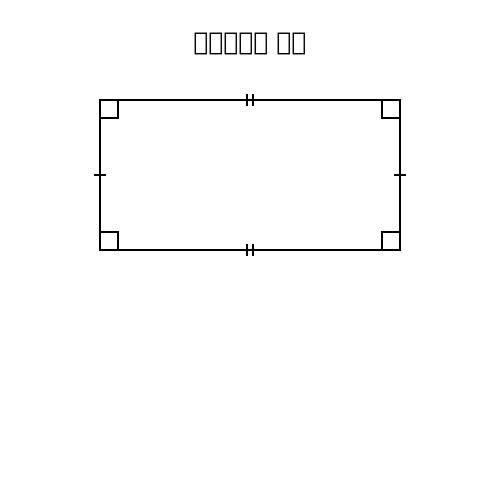

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

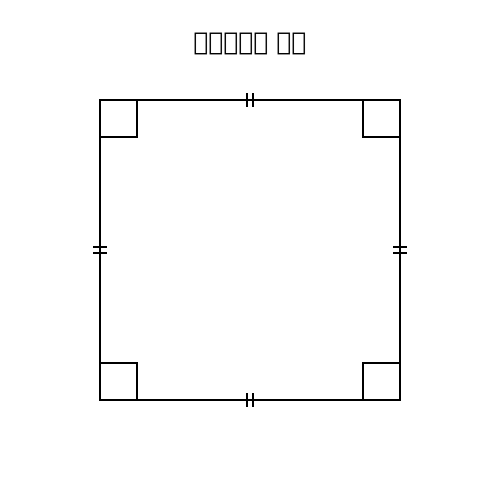

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

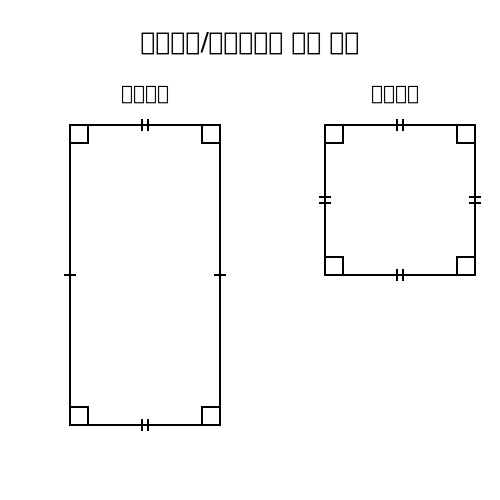

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


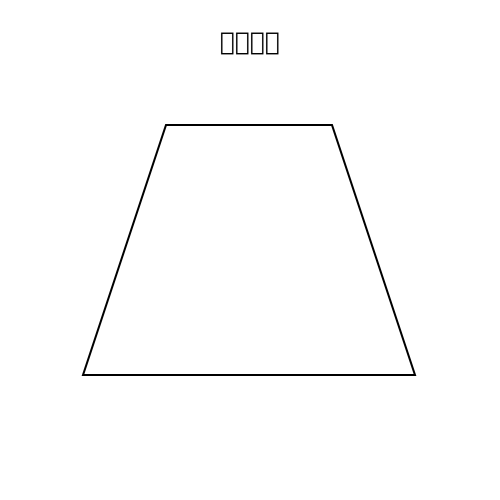

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

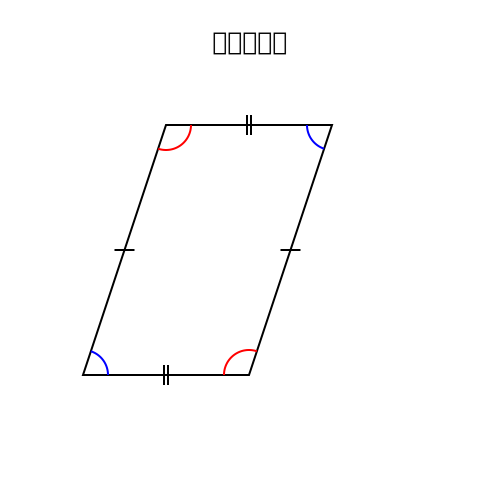

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

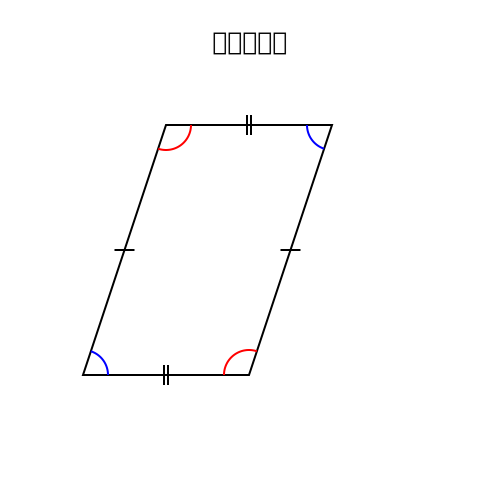

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

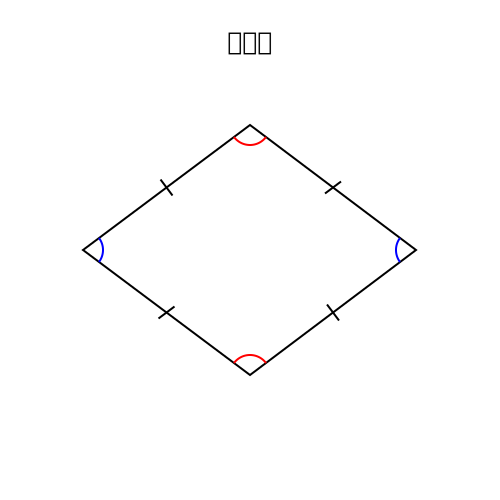

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

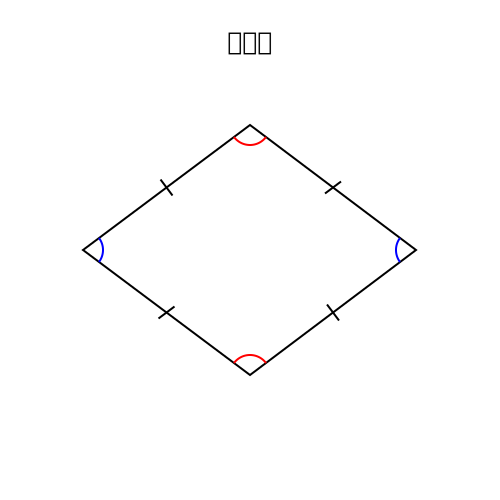

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

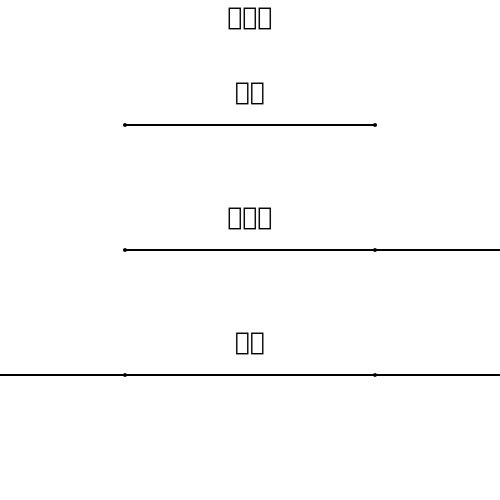

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="367.5739315689991" y2="272.51952610008306" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 173.51478631379982,320.9039052200166 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="187.03413447758263" y="325.3831660371783" font-size="12" text-anchor="middle">14°</text>
        </svg>
        


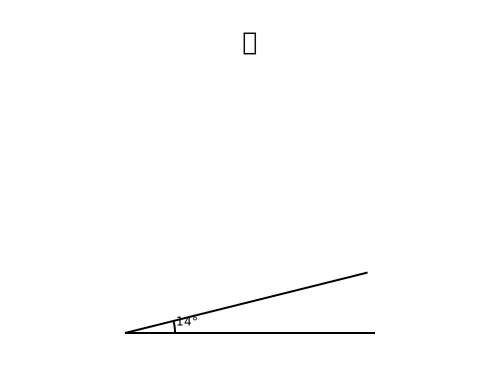

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

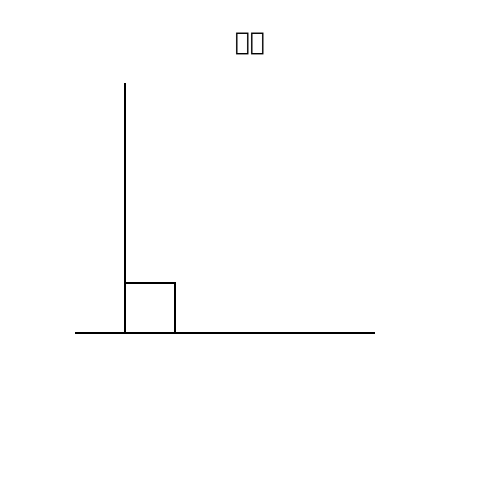

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


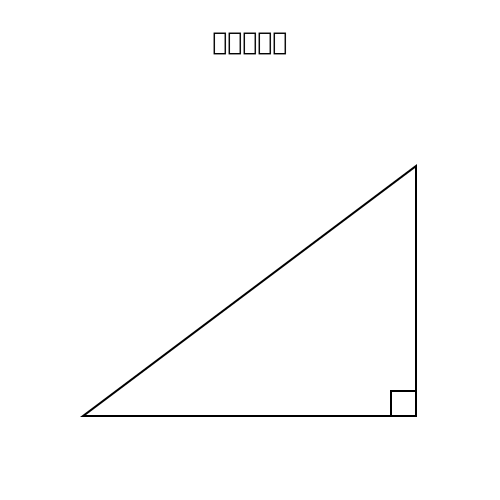

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


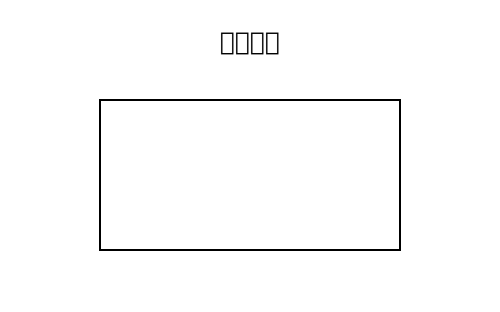

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


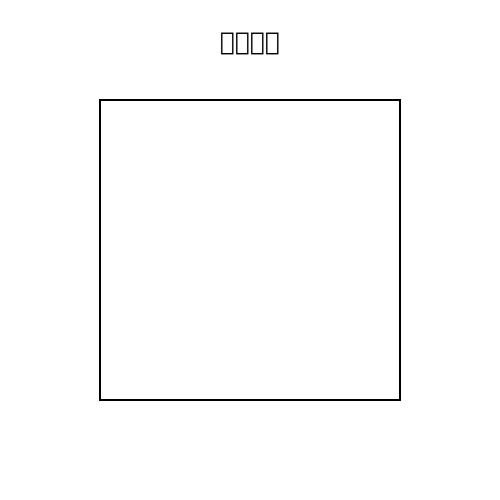

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


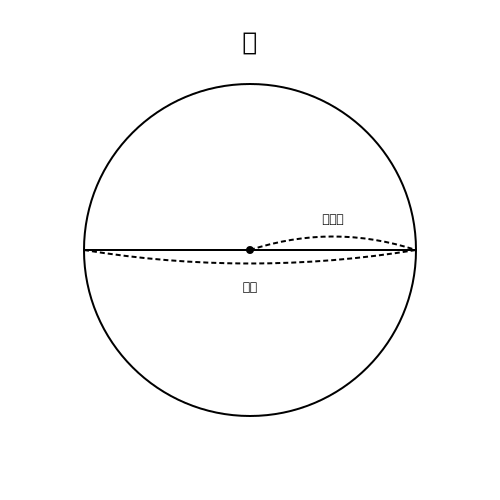

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


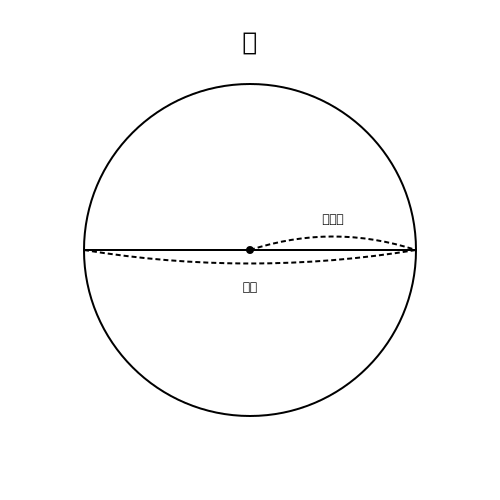

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

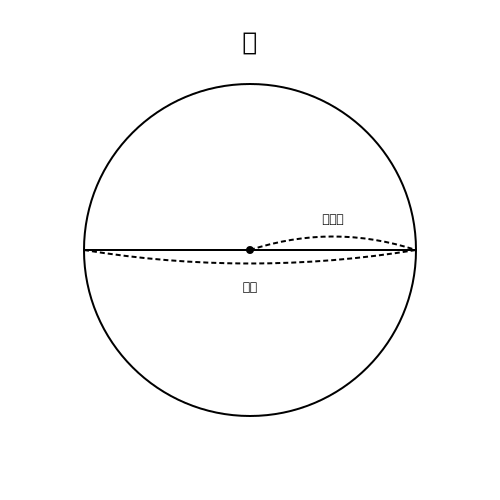

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

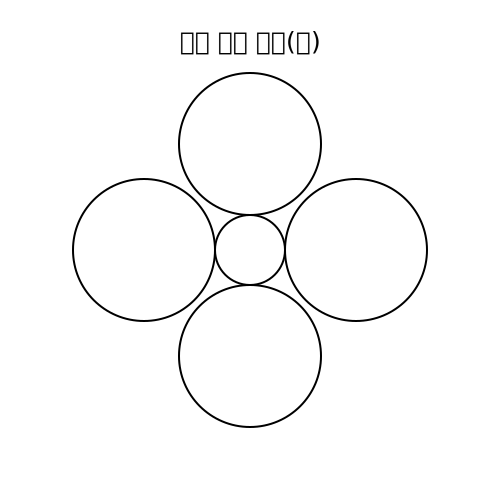

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="347.75163104709196" y2="219.5023750651133" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 169.5503262094184,310.30047501302266 A 50,50 0 0,1 175,333" stroke=

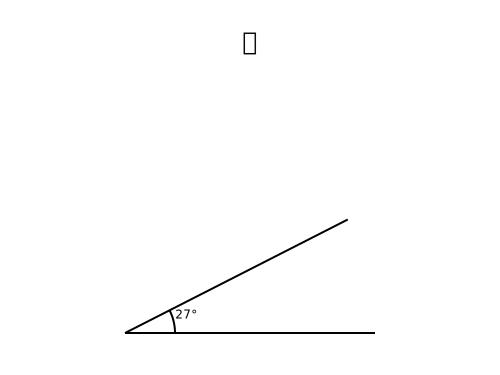

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="366.4814565722671" y2="268.2952387243698" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 173.2962913144534,320.05904774487396 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>

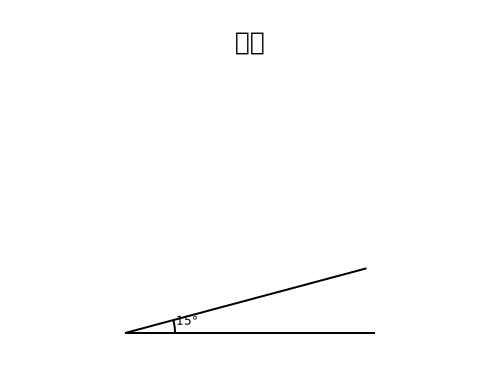

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="52.99731159831953" y2="179.0846311685854" stroke="black" stroke-

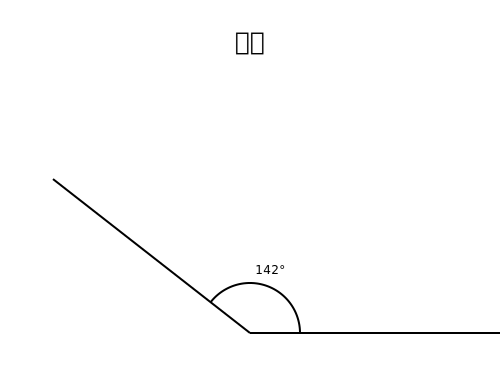

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="232.56088156396868" y2="83.60898743504396" stroke="black" stroke-width="2" />


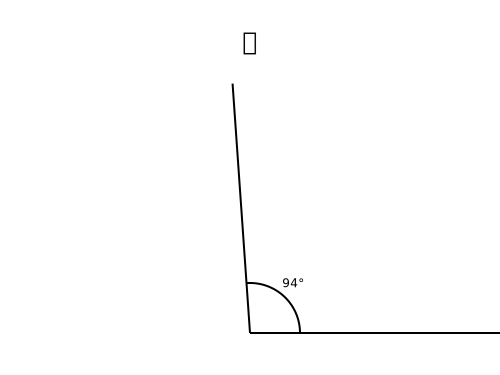

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="168.18155080466045" y2="75.01903810545109" stroke="black" stroke-width

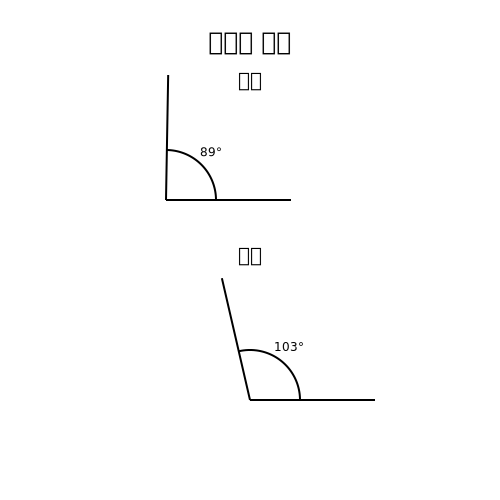

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="202.2977511558638" y2="87.59320413808402" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 240.45955023117276,283.918

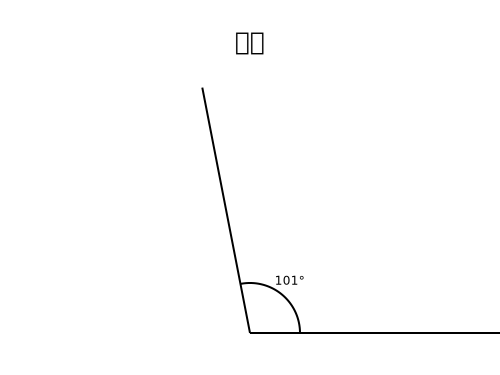

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

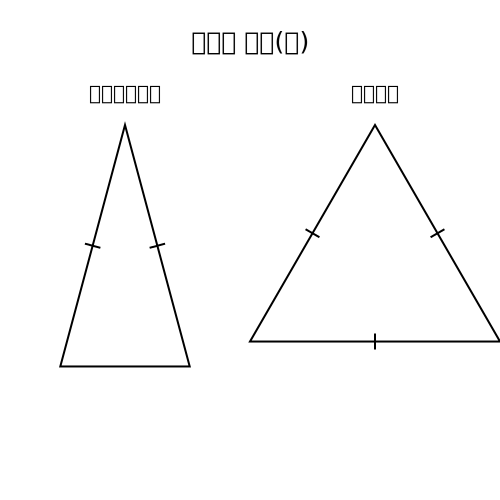

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

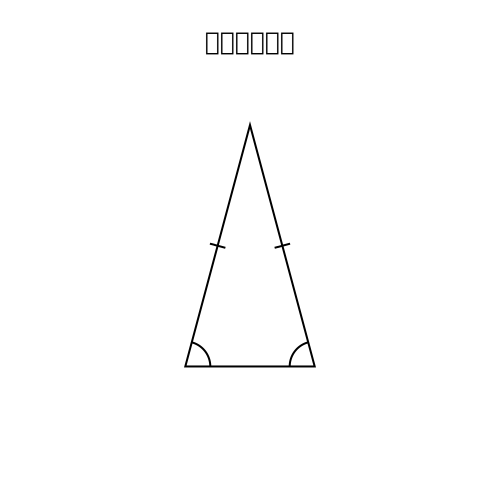

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

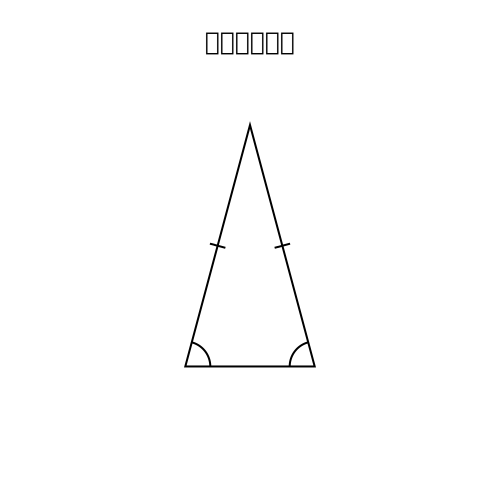

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

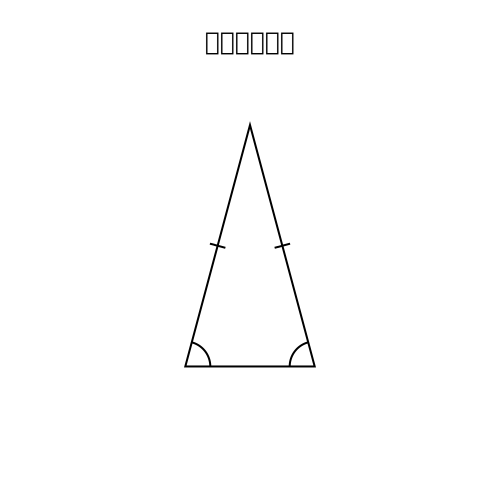

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

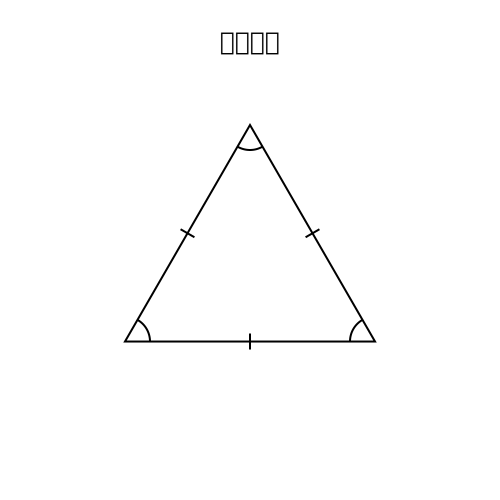

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

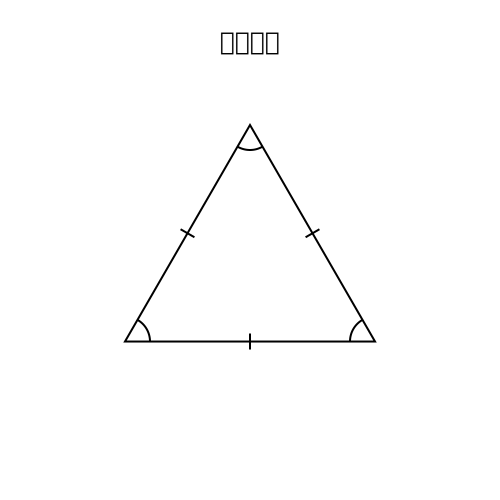

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

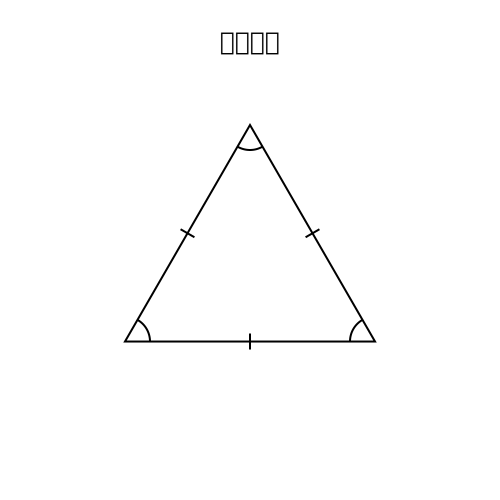

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


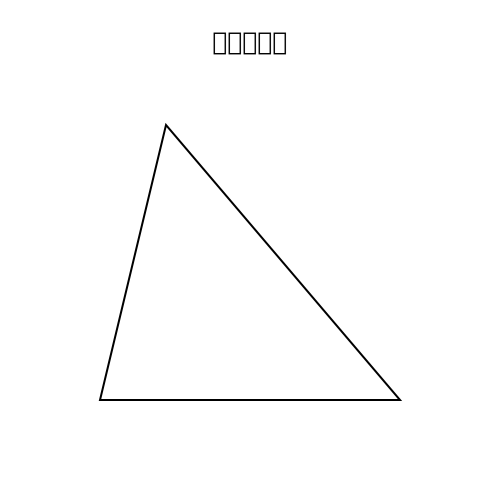

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

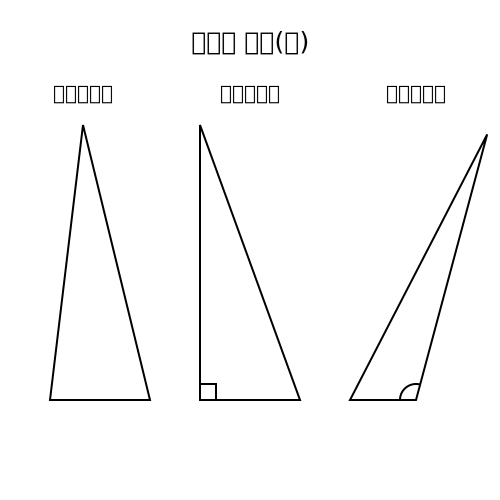

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


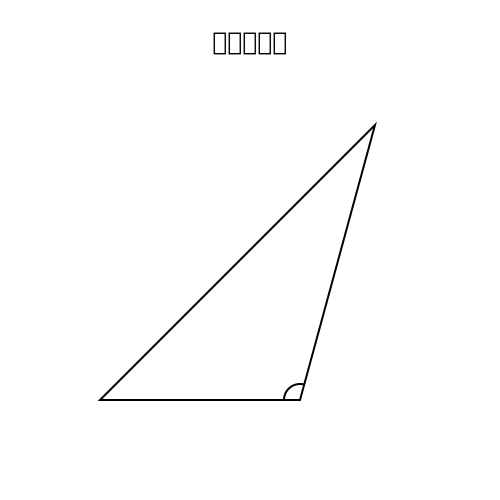

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

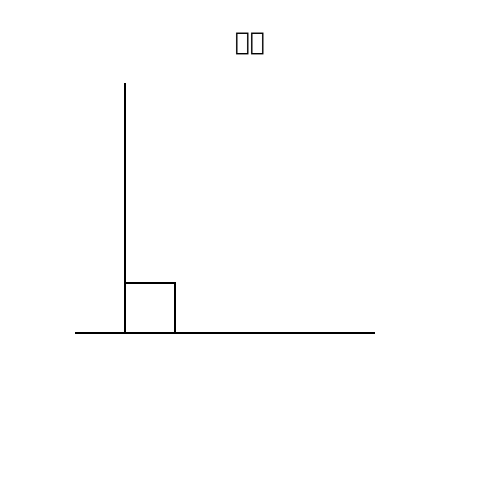

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

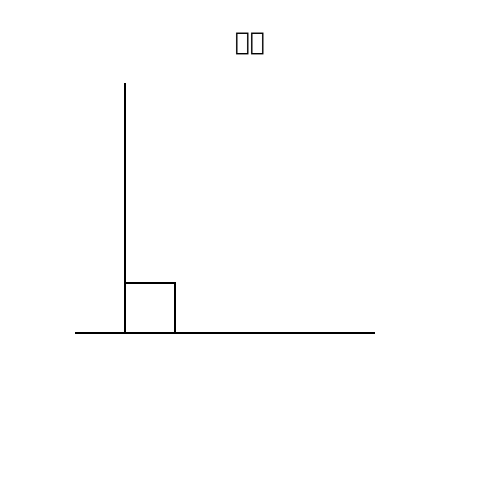

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

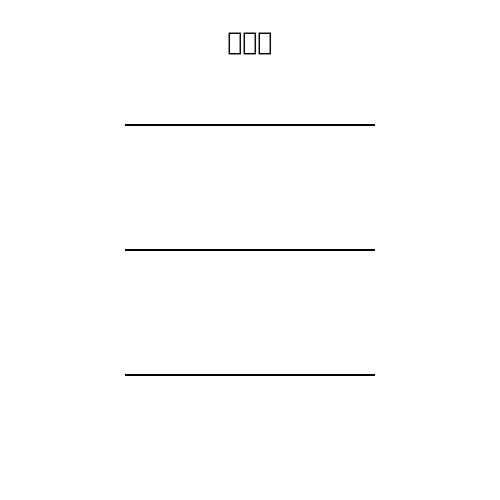

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

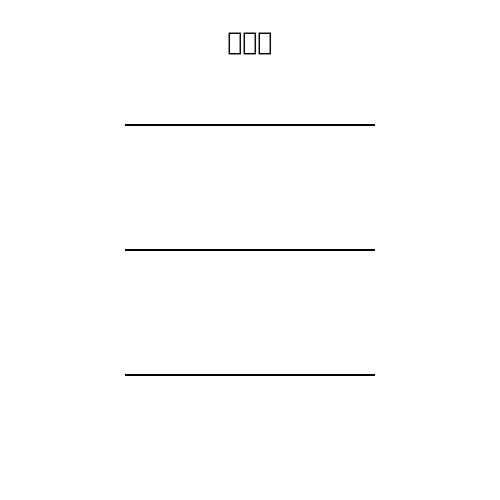

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


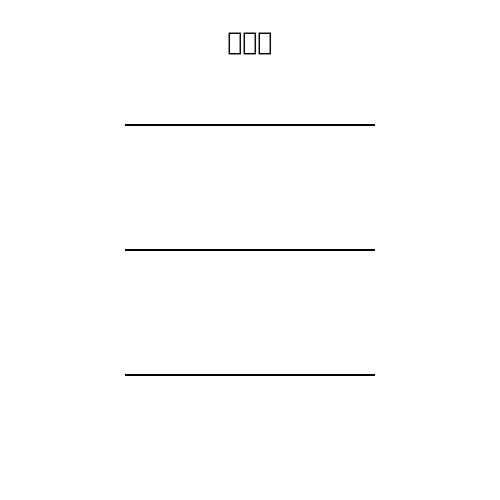

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

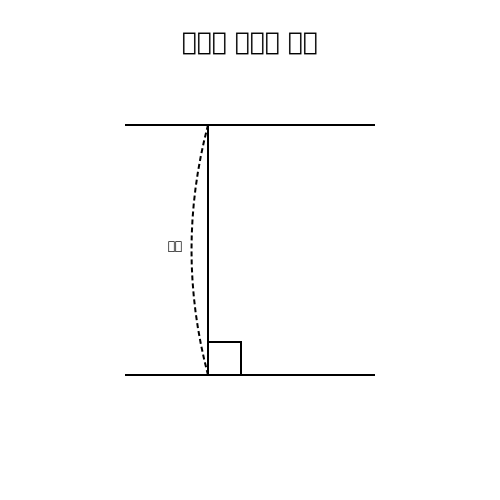

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

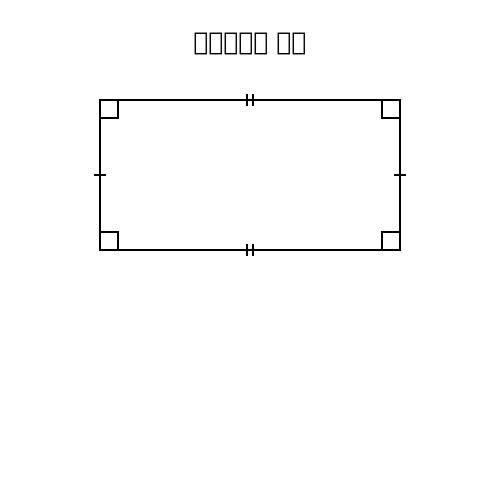

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

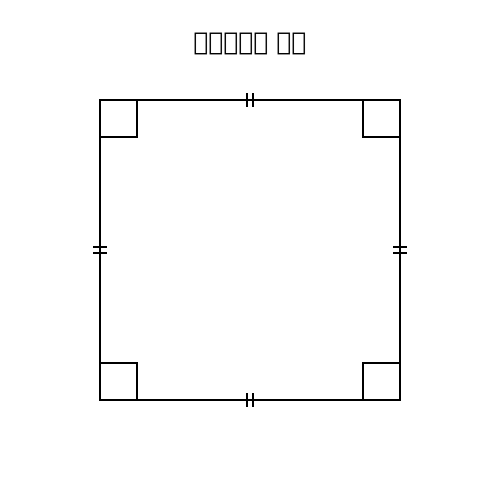

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

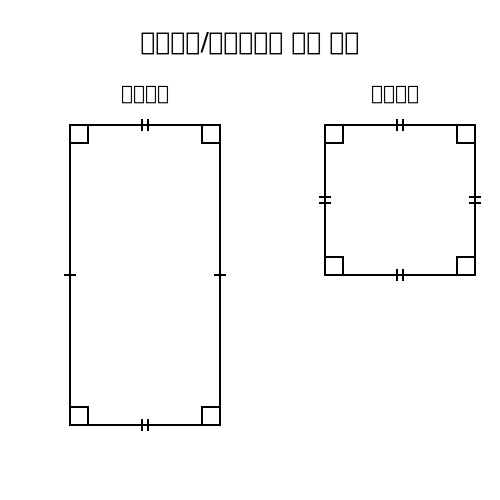

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


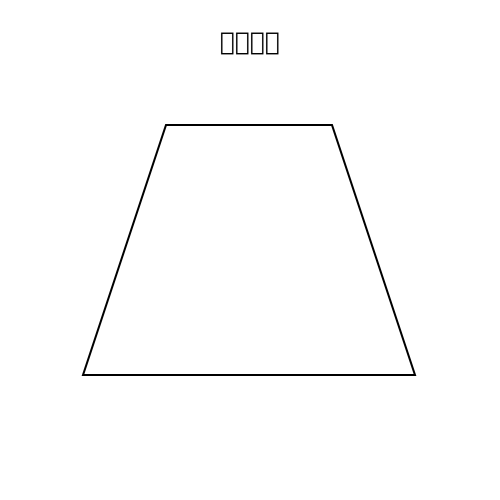

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

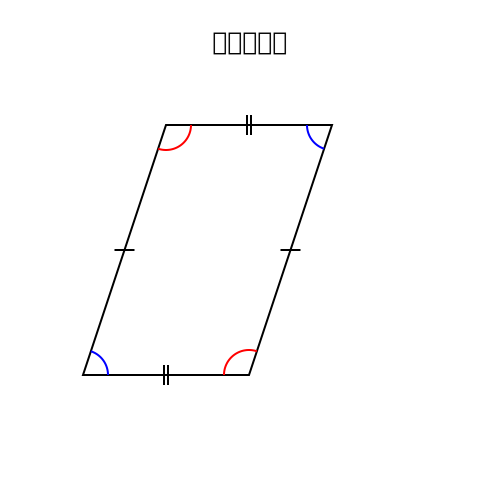

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

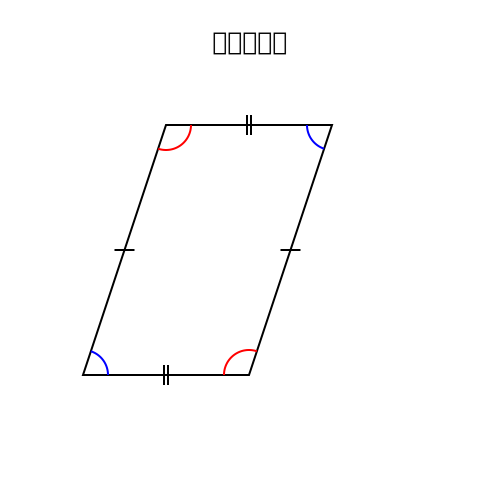

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

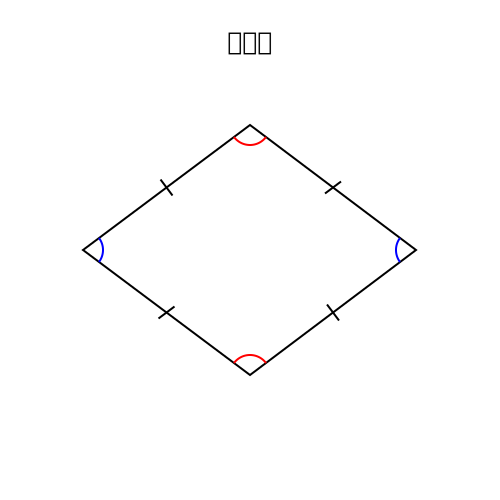

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

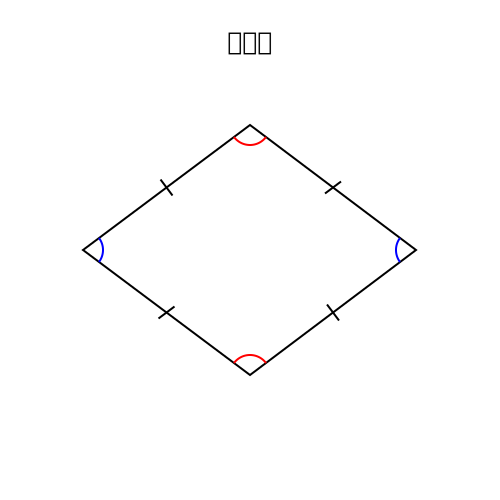

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

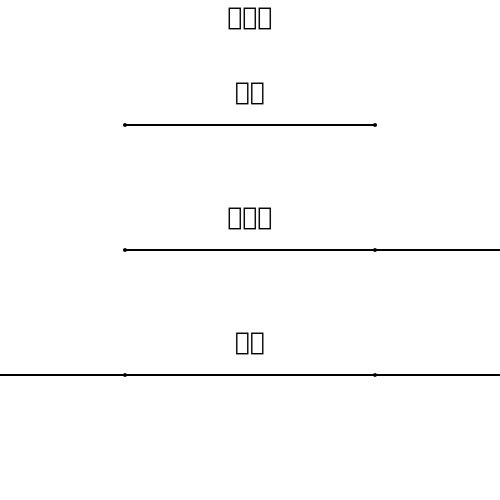

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="58.488889220255516" y2="172.30309757836514" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 211.6977778440511,300.860619515673 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="271.3762589578543" y="274.2692112008807" font-size="12" text-anchor="middle">140°</text>
        </svg>
        


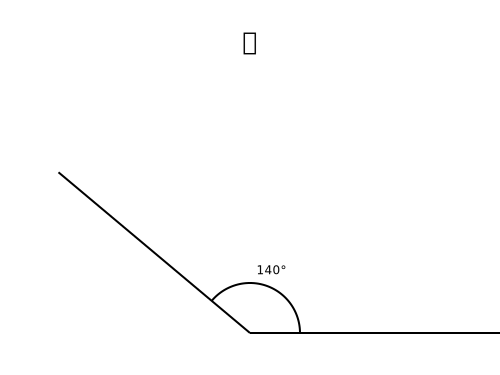

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

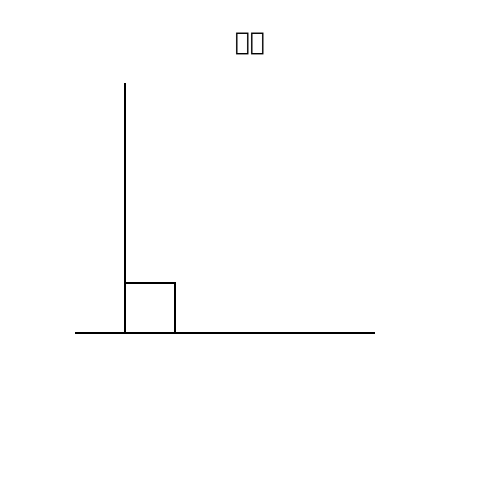

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


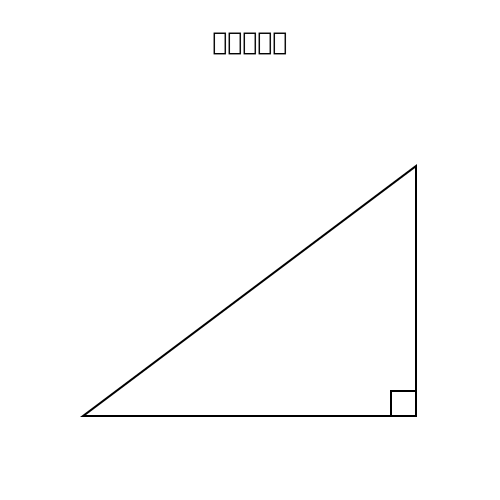

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


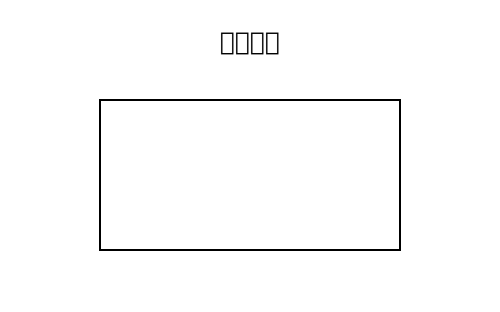

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


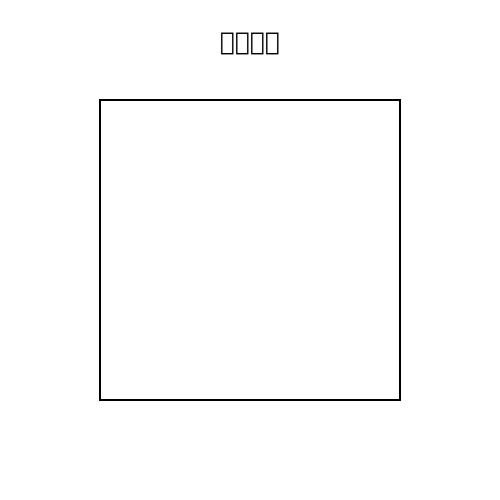

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


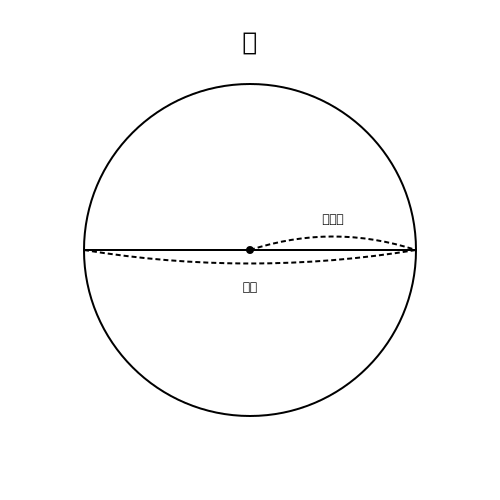

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


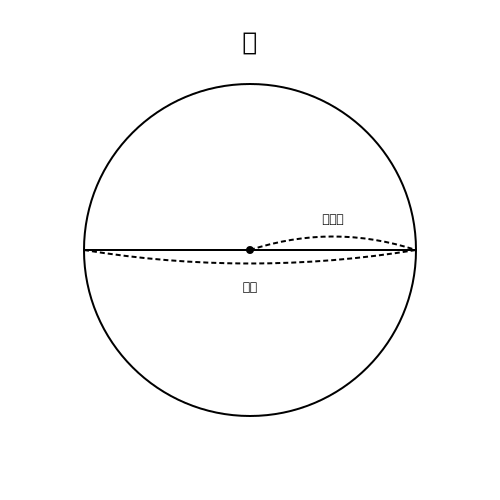

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

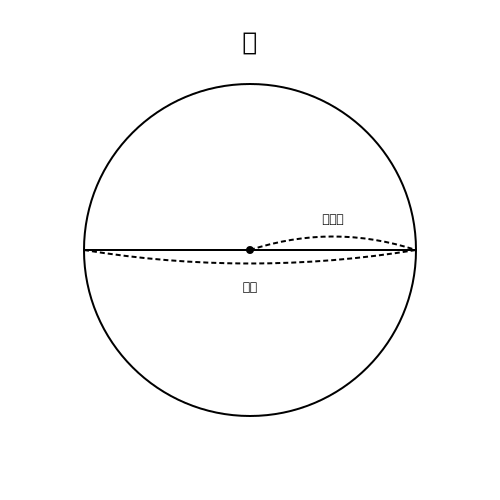

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

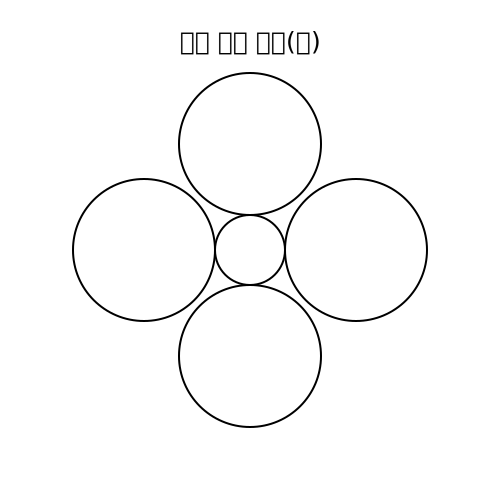

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="264.7982258676867" y2="125.74060686123957" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 152.95964517353735,291.5481213722479 A 50,50 0 0,1 175,333" stroke=

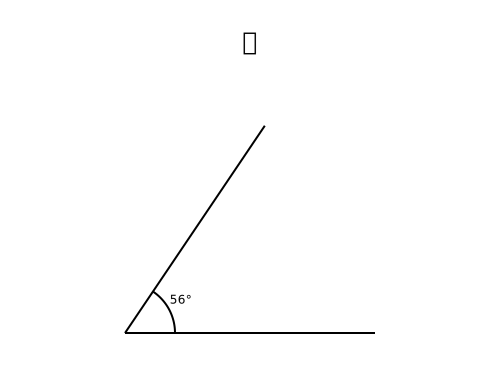

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="358.3951066243004" y2="243.40801261367494" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 171.6790213248601,315.081602522735 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>


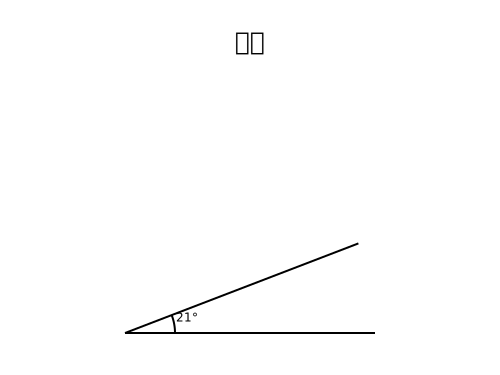

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="70.16504991533719" y2="159.3354073852507" stroke="black" stroke-

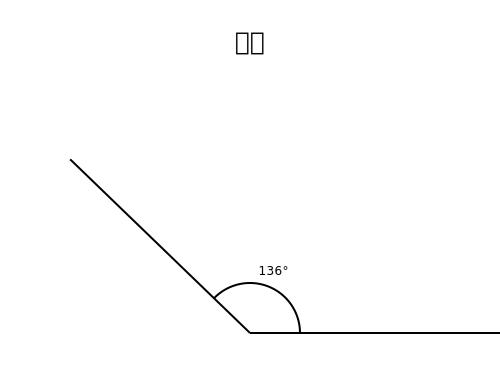

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="214.59198738632512" y2="99.60489337569956" stroke="black" stroke-width="2" />


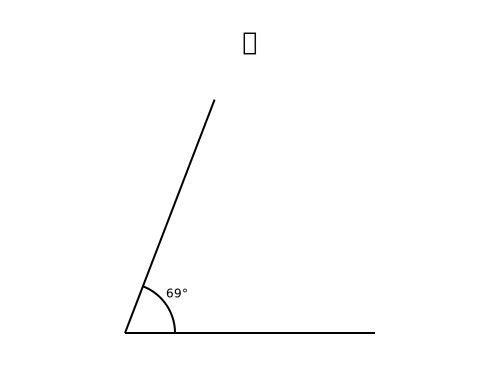

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="286.74072828613356" y2="167.6476193621849" stroke="black" stroke-width

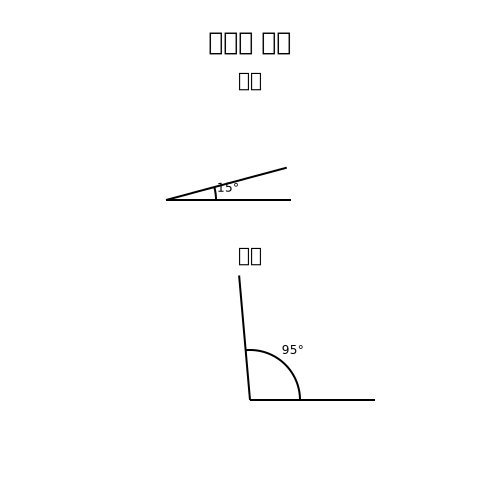

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="172.70224884413622" y2="87.59320413808402" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 134.54044976882724,283.91

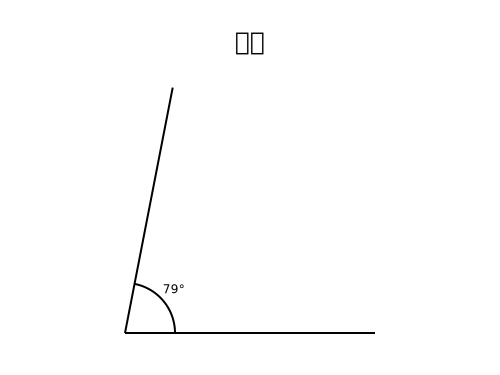

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

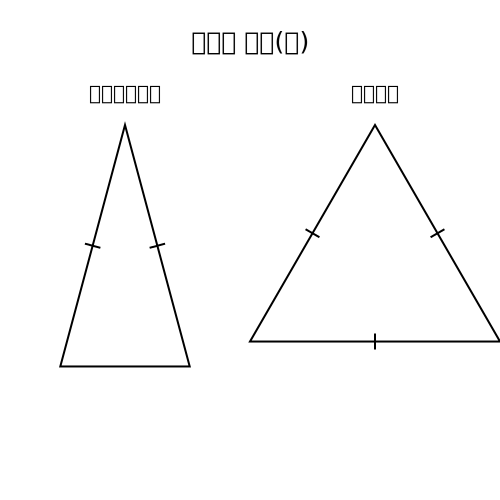

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

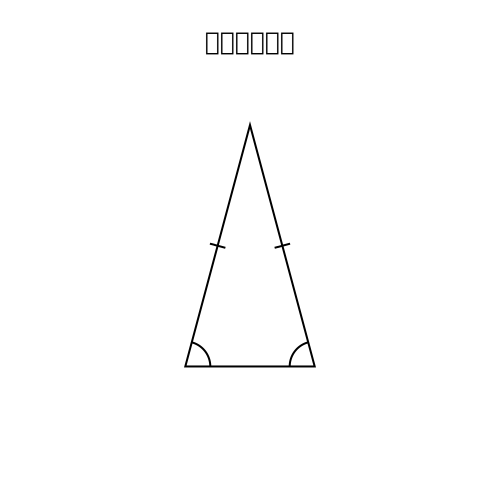

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

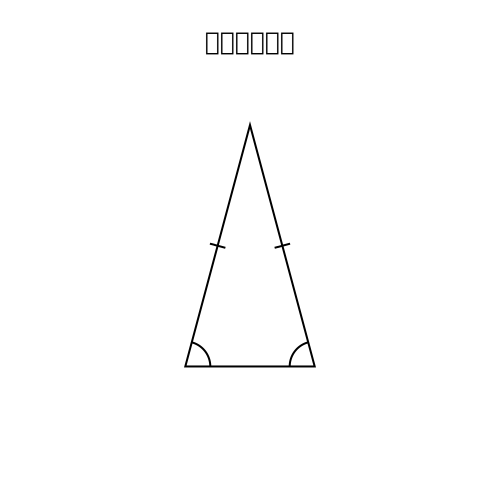

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

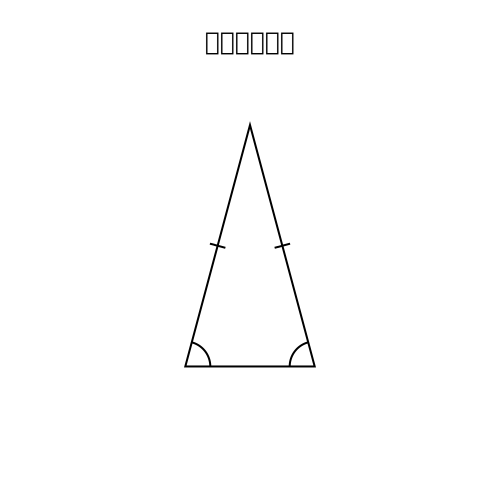

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

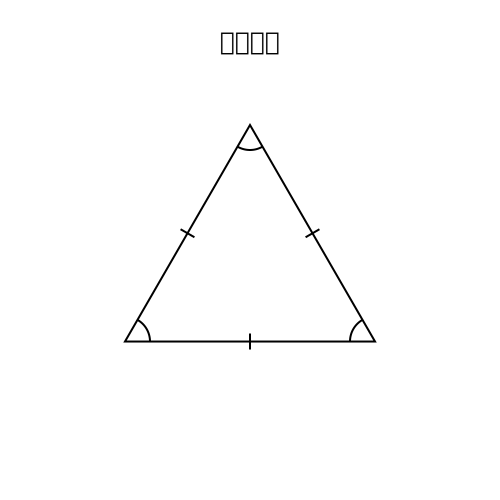

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

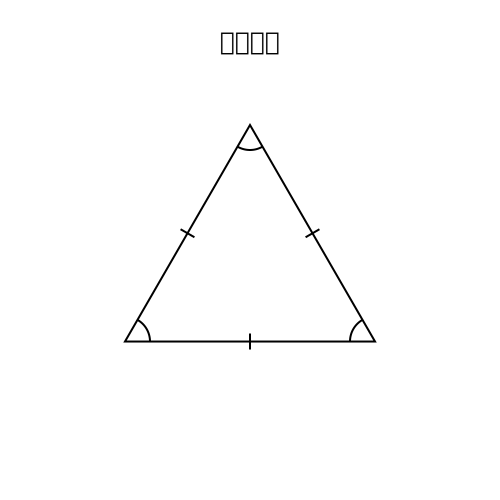

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

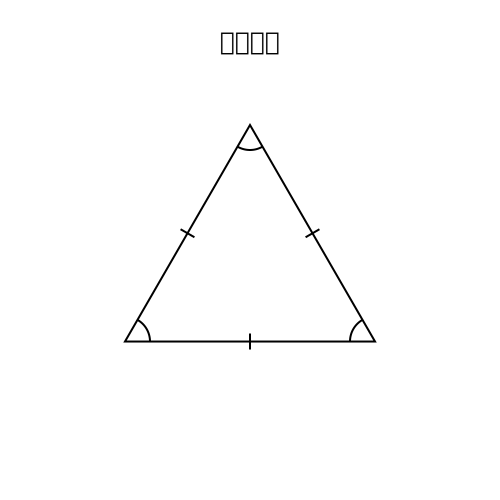

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


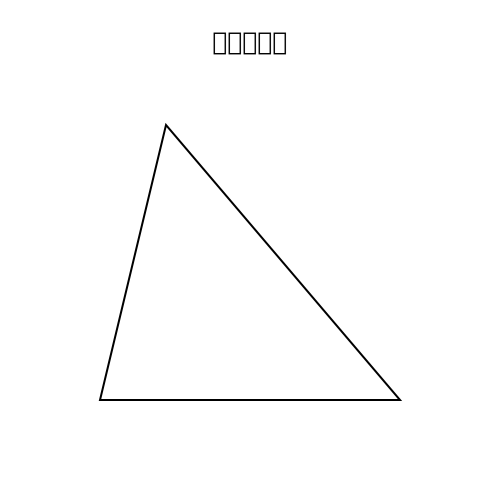

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

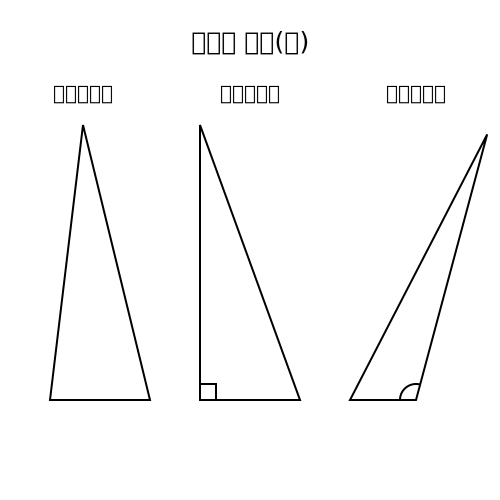

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


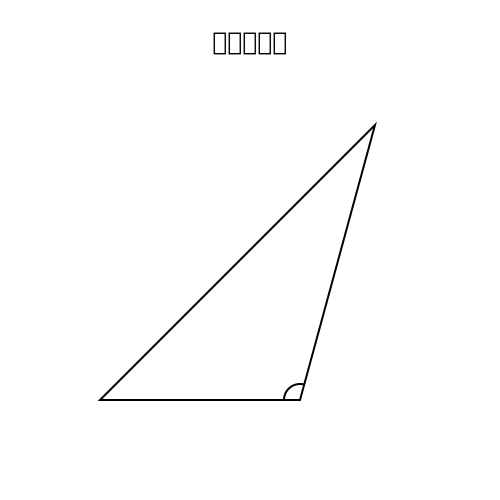

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

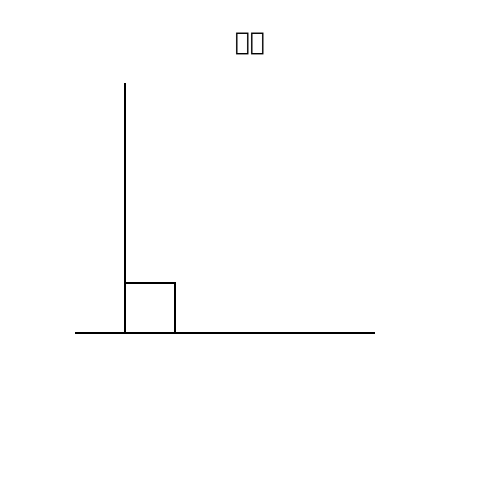

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

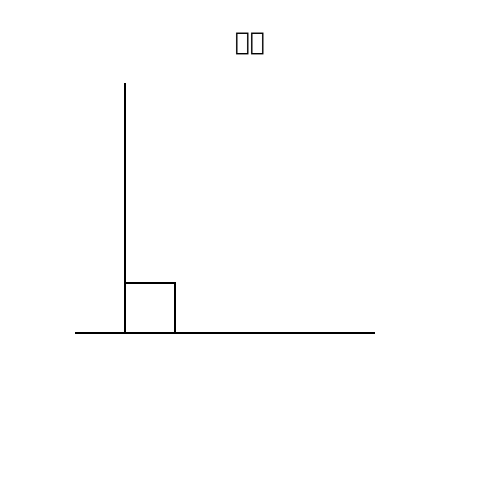

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

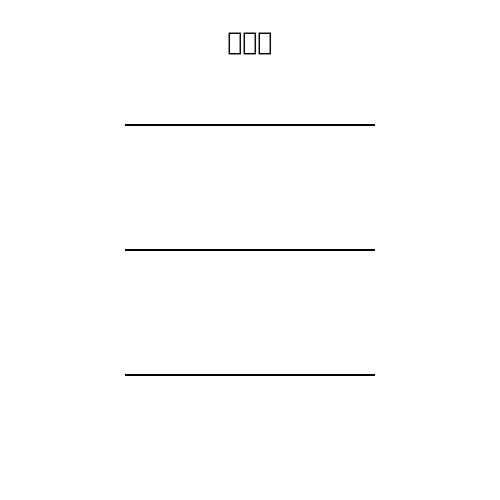

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

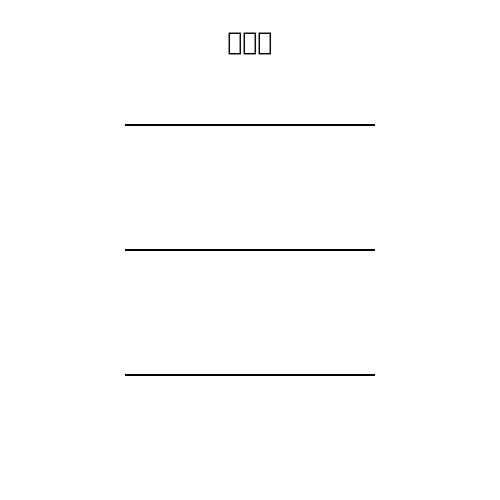

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


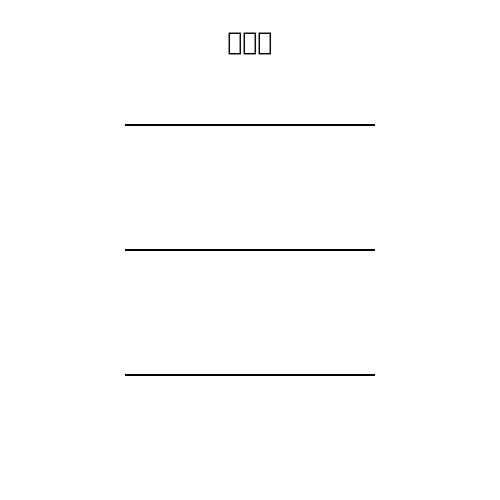

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

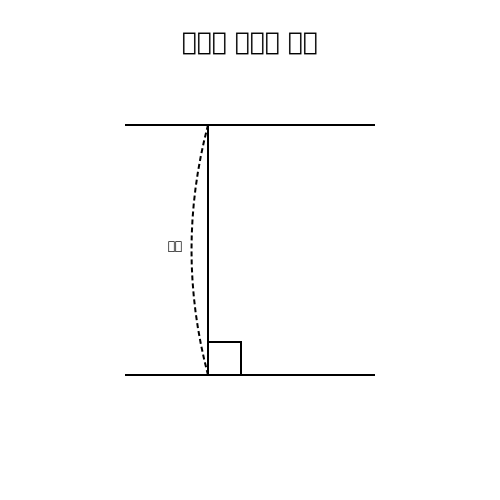

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

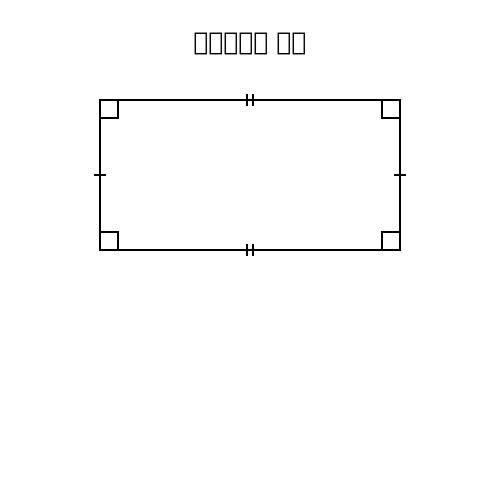

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

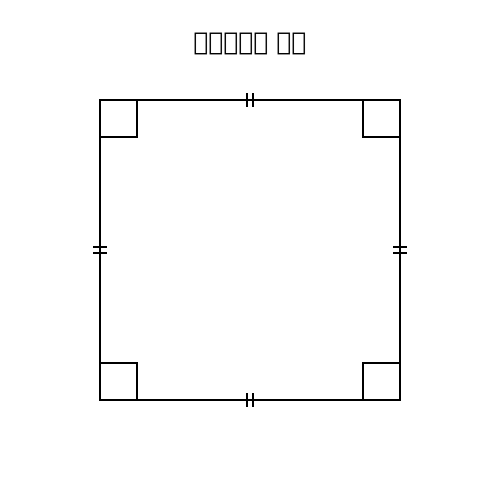

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

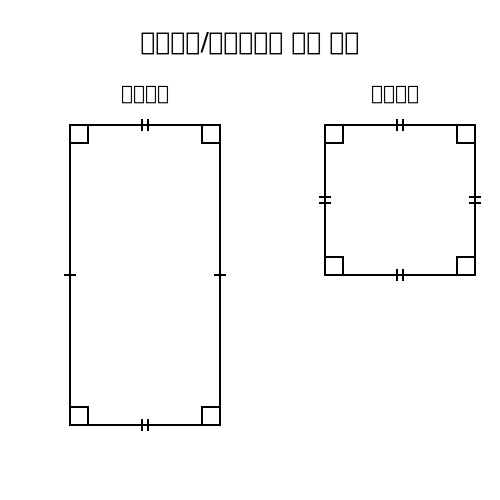

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


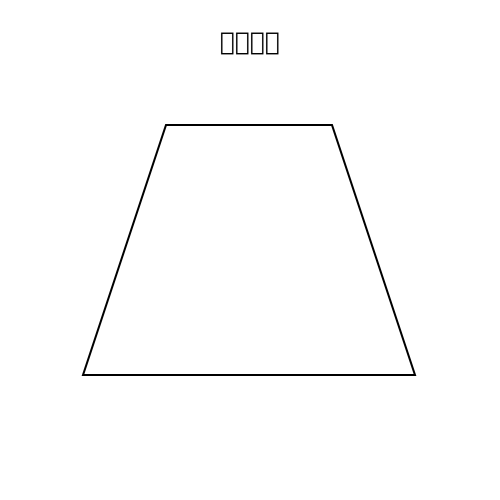

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

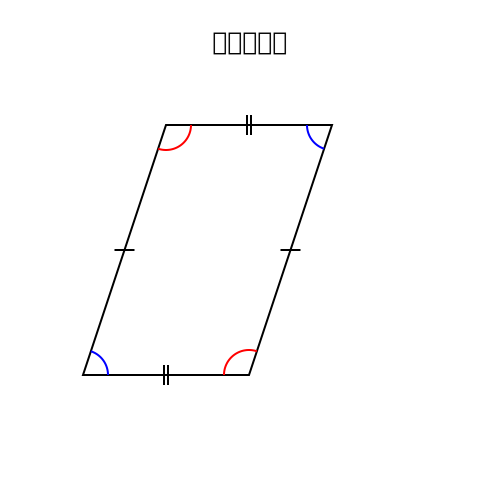

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

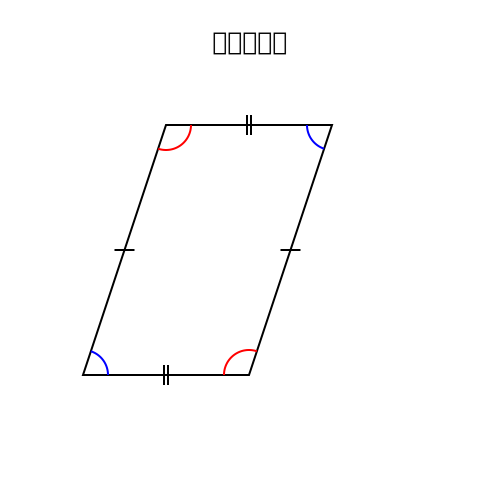

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

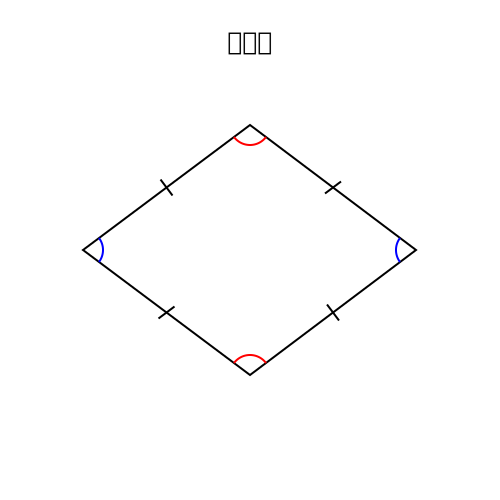

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

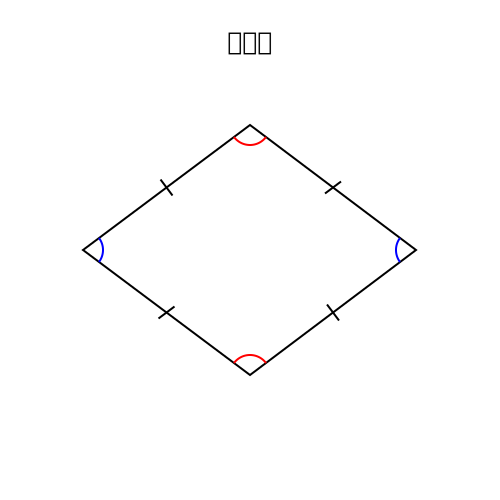

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

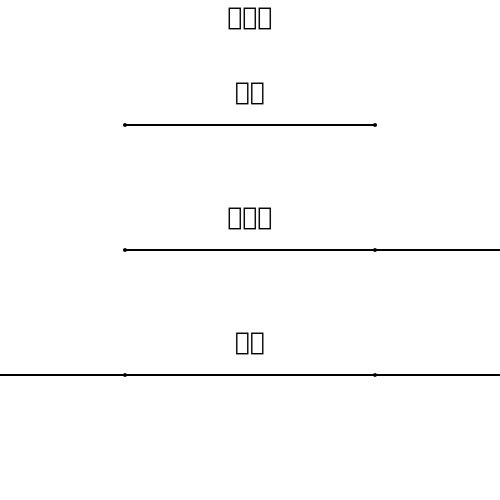

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="337.01202403910645" y2="200.52018394169878" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 167.4024048078213,306.50403678833976 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="185.07885599614494" y="315.77266526143757" font-size="12" text-anchor="middle">32°</text>
        </svg>
        


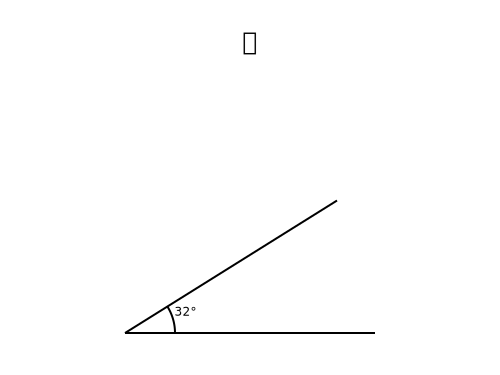

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

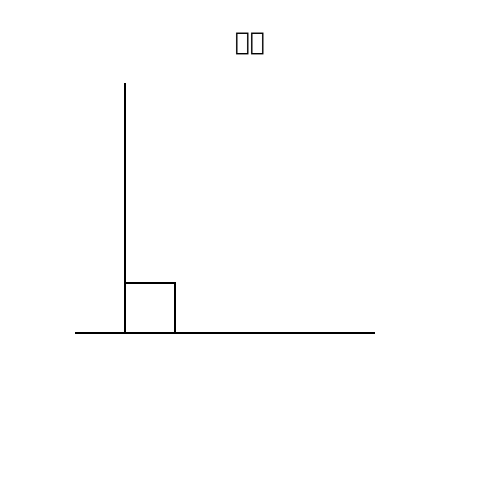

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


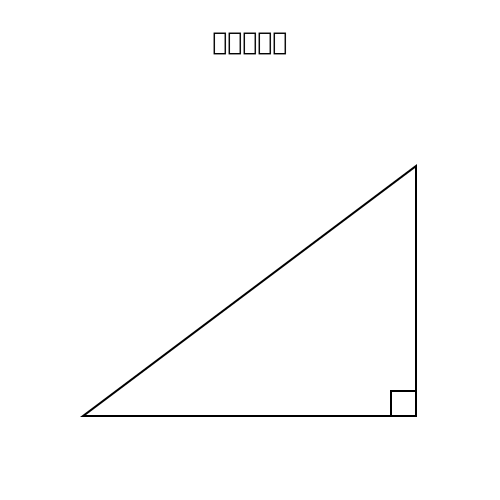

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


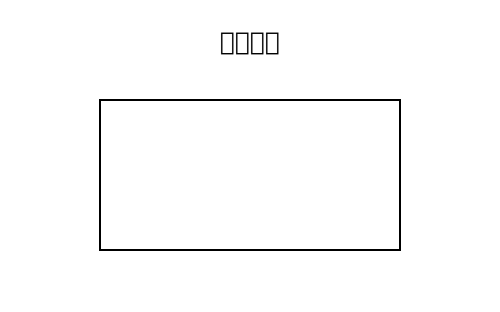

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


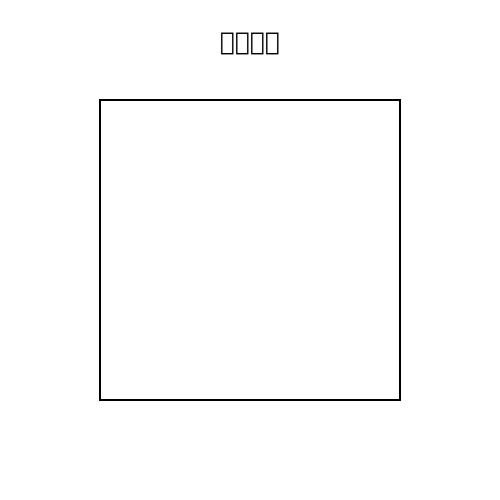

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


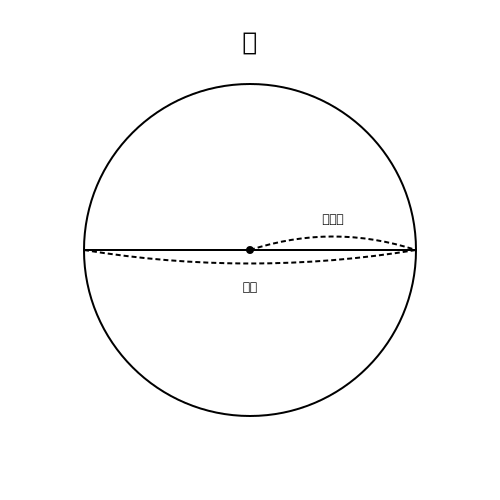

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


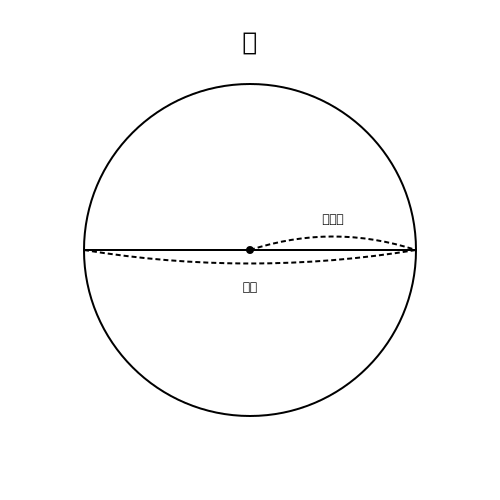

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

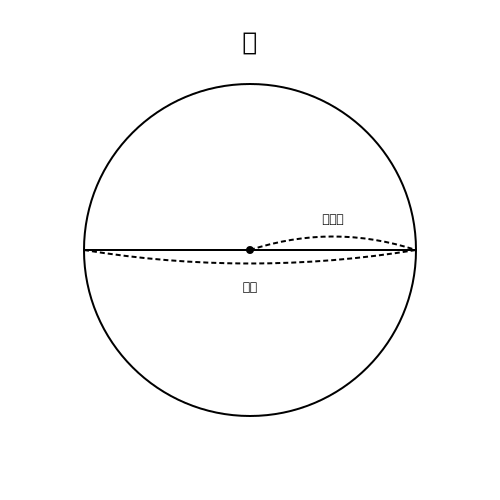

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

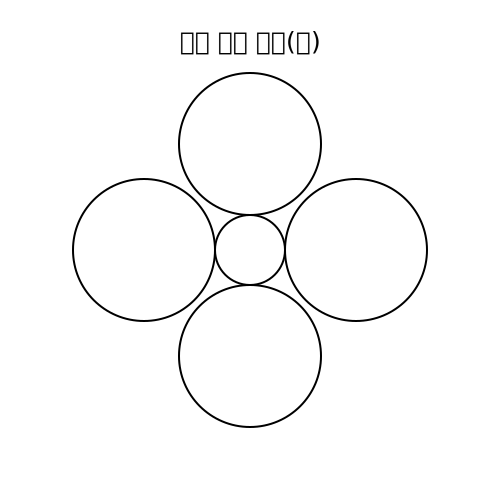

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="285.69690242163483" y2="141.4888892202555" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 157.13938048432698,294.6977778440511 A 50,50 0 0,1 175,333" stroke=

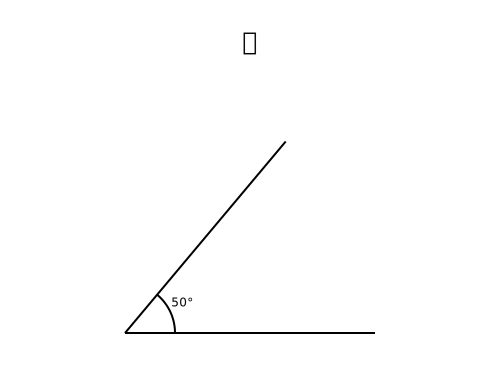

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="23.423053240837504" y2="227.34543456482513" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 204.6846106481675,311.86908691296503 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"

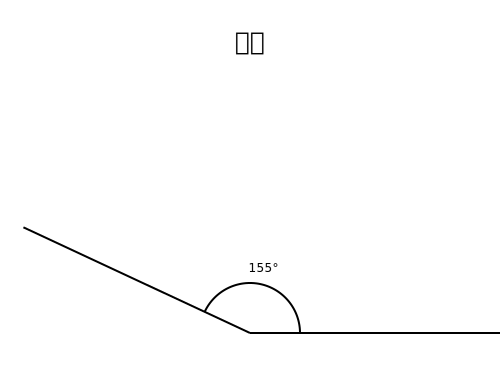

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="15.076844803522931" y2="247.49496416858278" stroke="black" strok

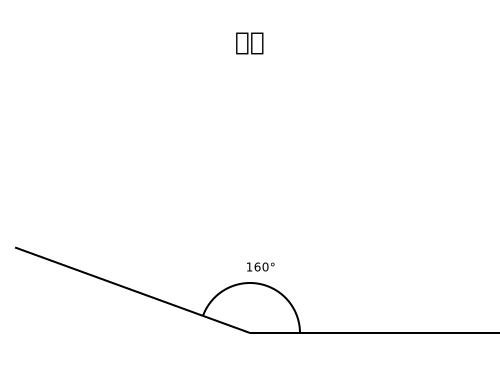

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="193.76223641403374" y2="89.40748380369118" stroke="black" stroke-width="2" />


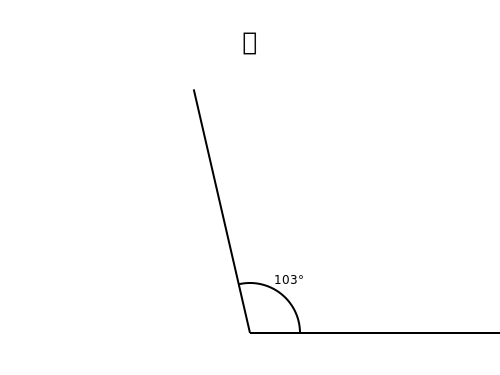

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="290.8286918443217" y2="193.458005469632" stroke="black" stroke-width="

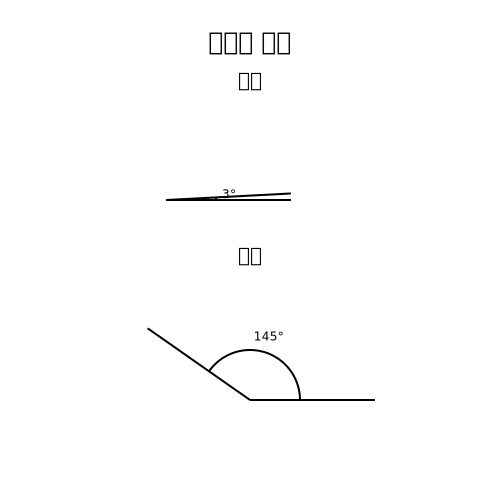

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="355.1262133631101" y2="235.31721787768157" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 171.02524267262203,313.46

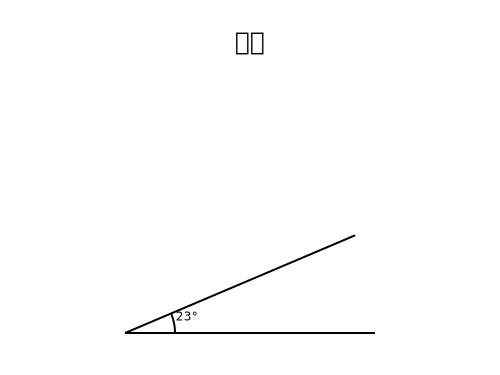

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

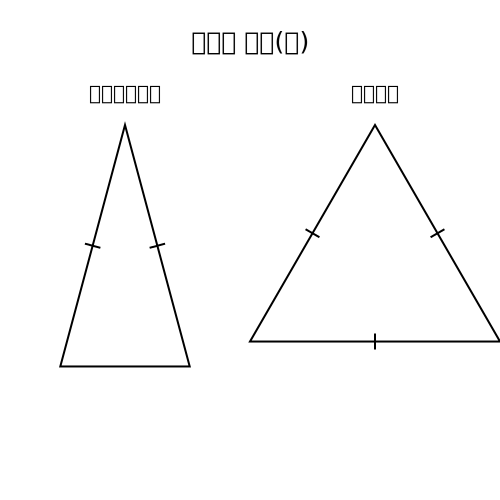

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

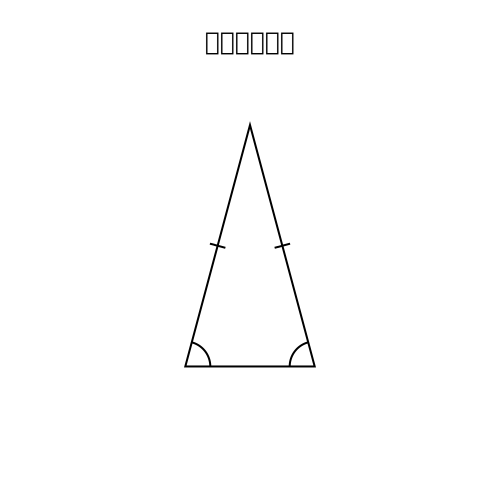

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

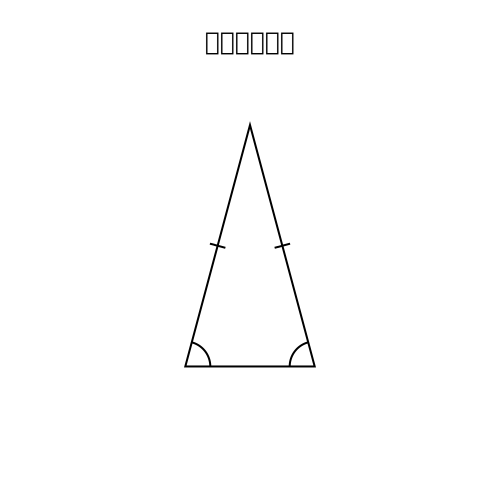

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

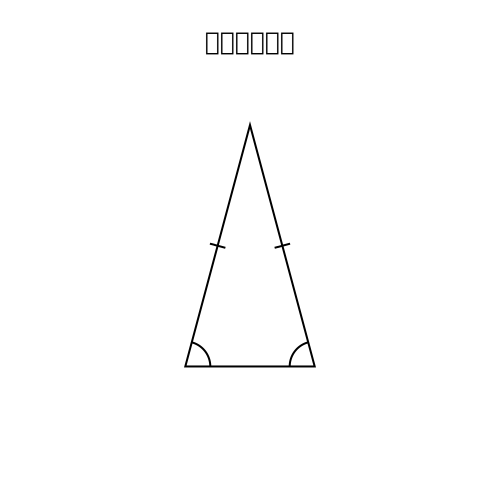

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

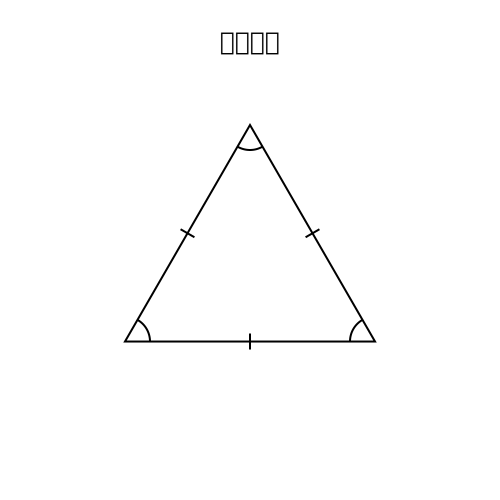

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

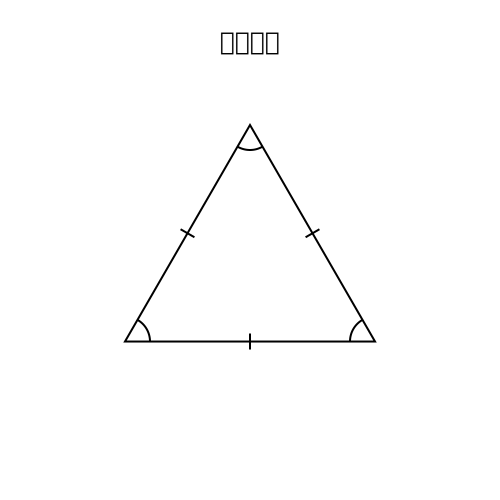

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

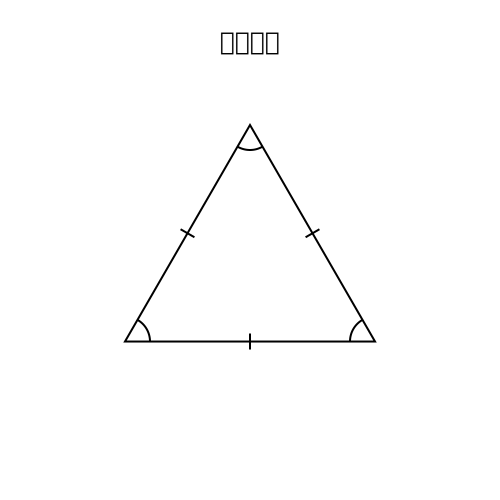

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


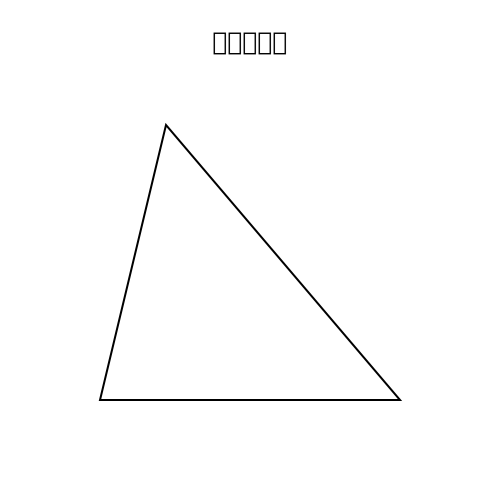

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

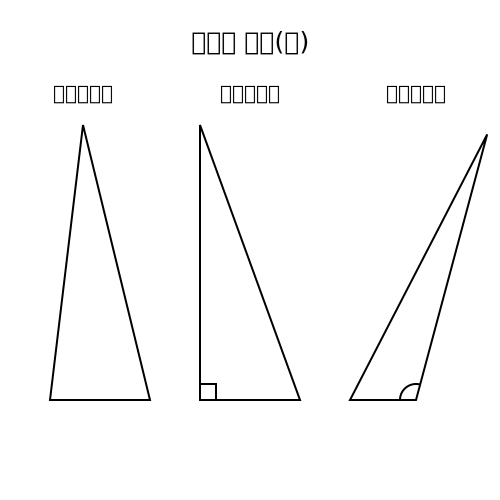

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


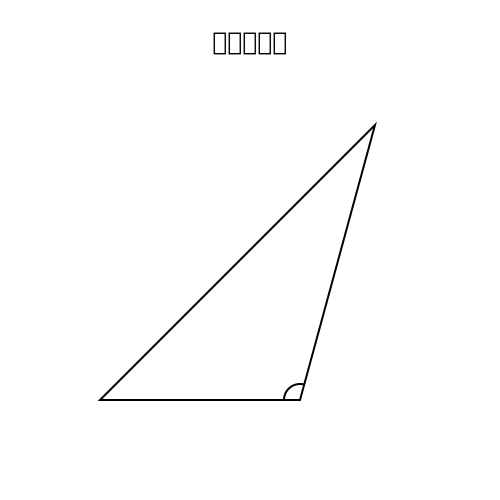

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

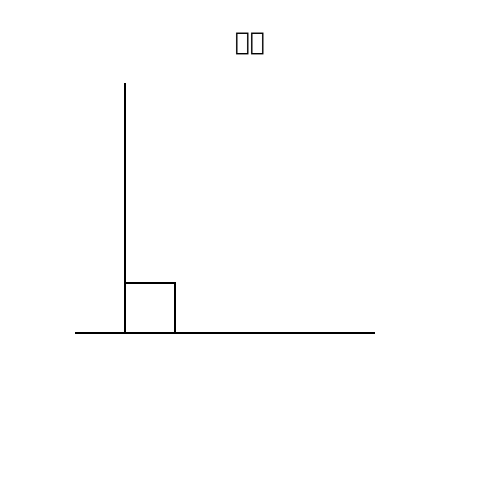

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

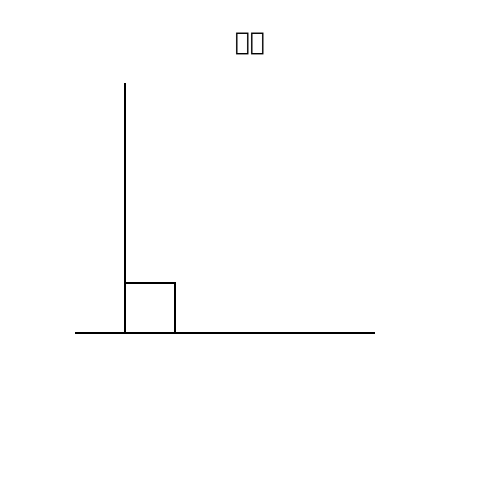

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

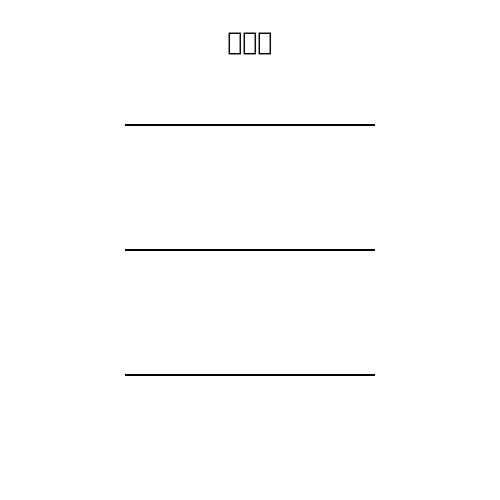

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

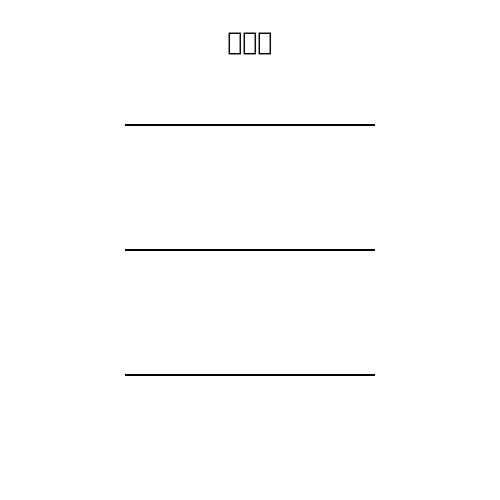

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


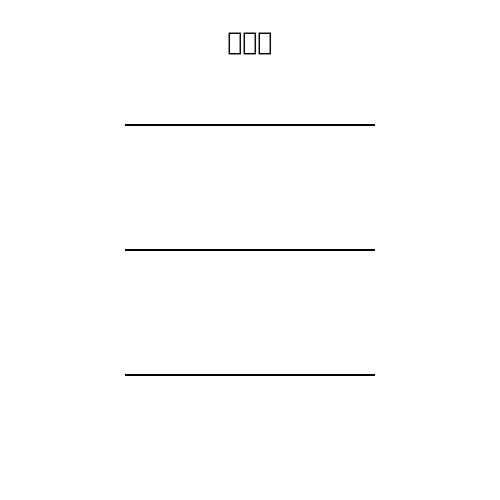

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

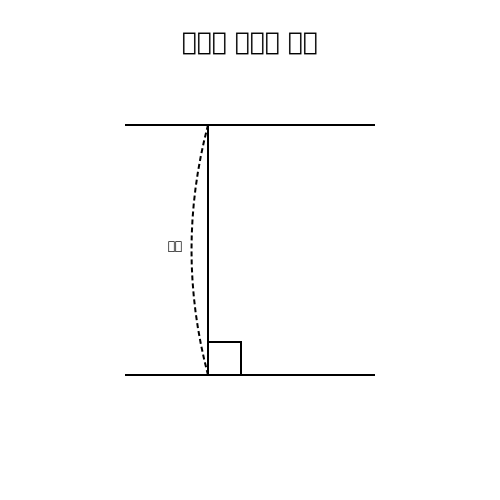

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

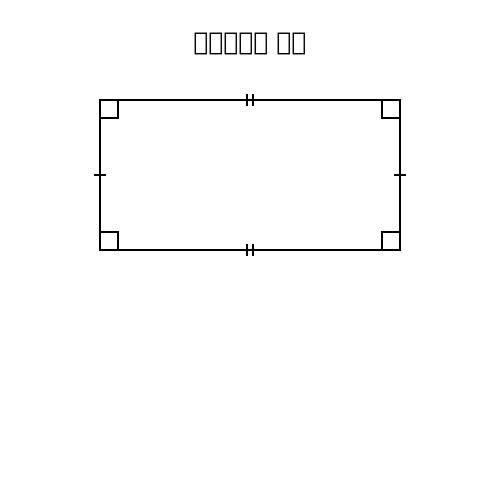

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

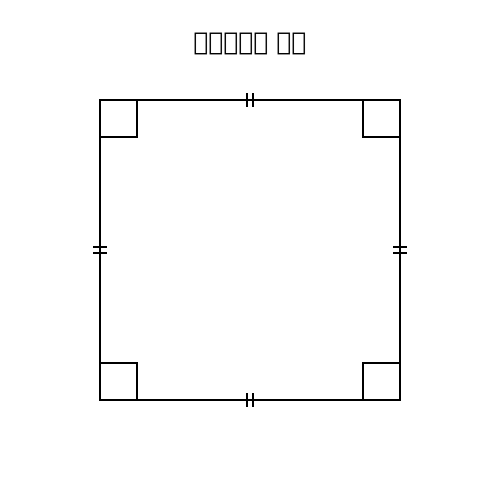

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

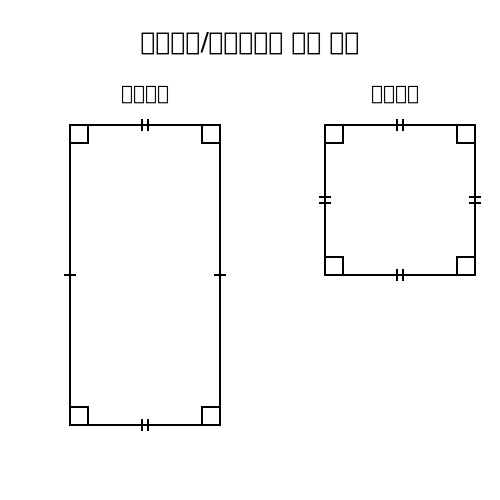

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


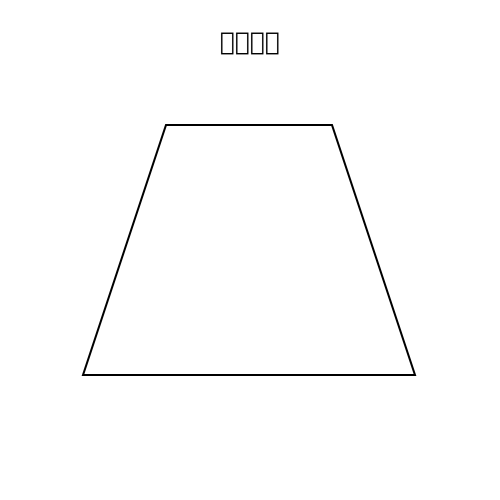

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

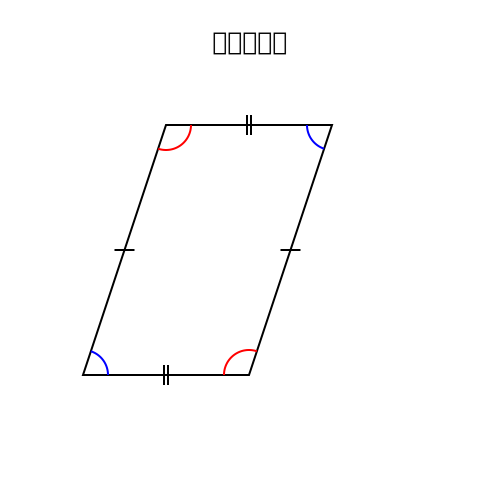

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

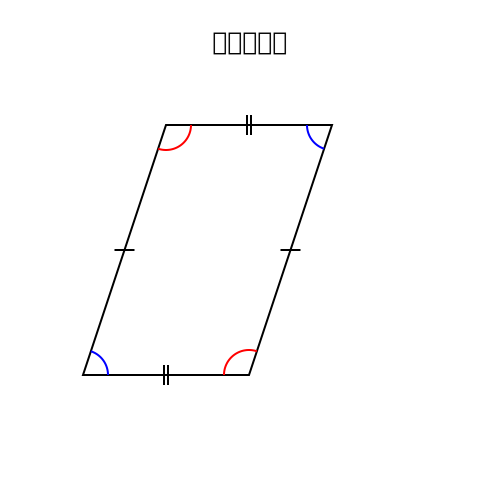

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

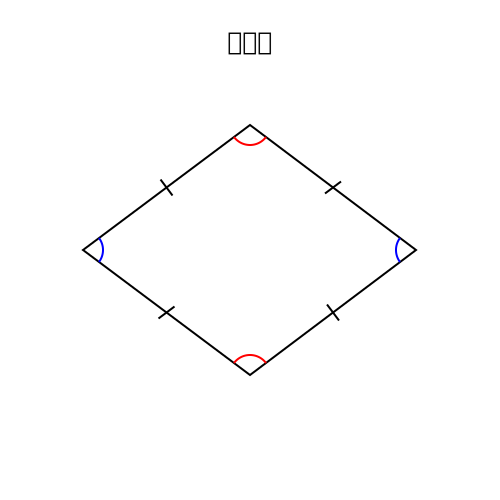

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

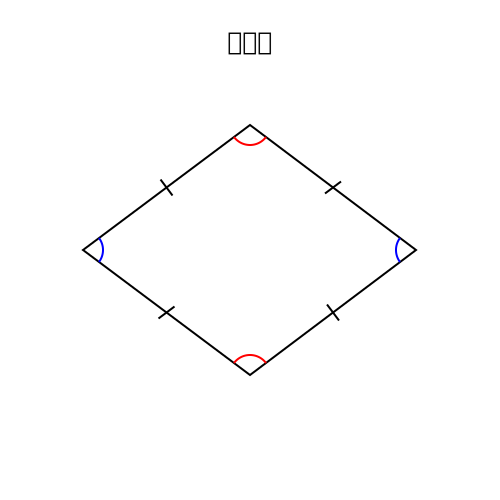

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

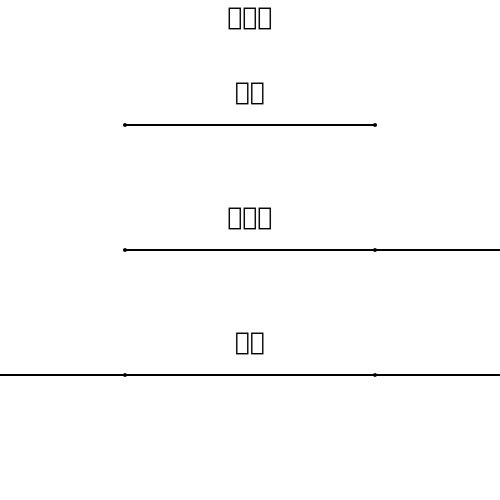

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="371.92208514878445" y2="293.8913837399423" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.3844170297569,325.17827674798843 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="187.3073333583205" y="328.0963065170097" font-size="12" text-anchor="middle">9°</text>
        </svg>
        


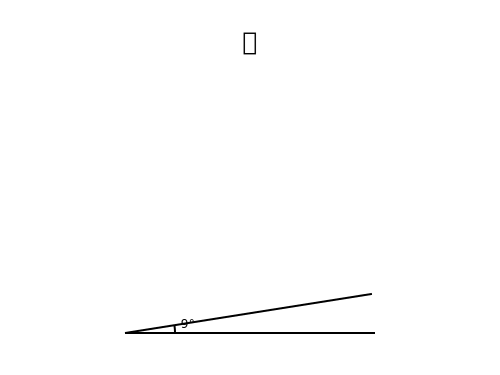

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

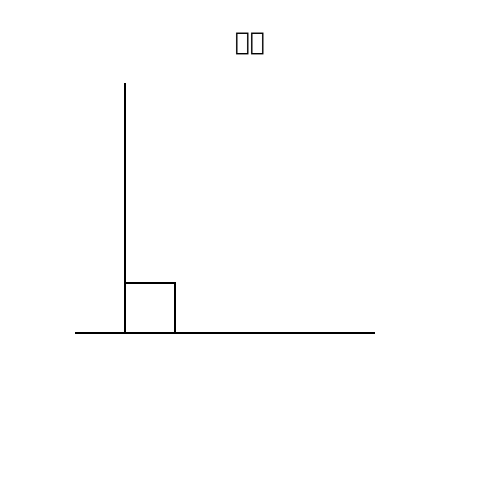

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


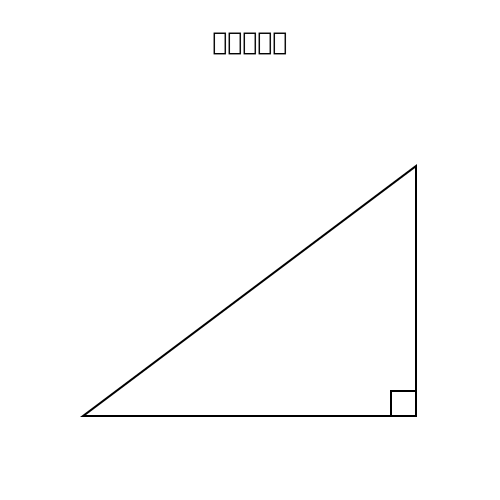

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


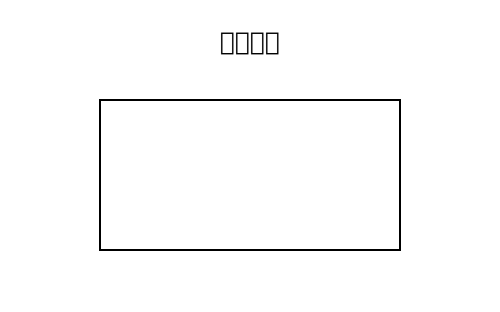

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


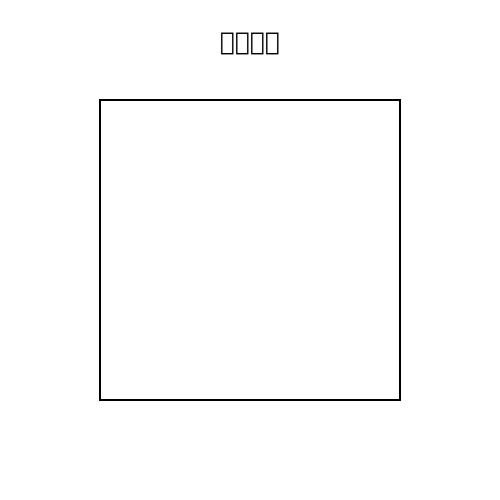

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


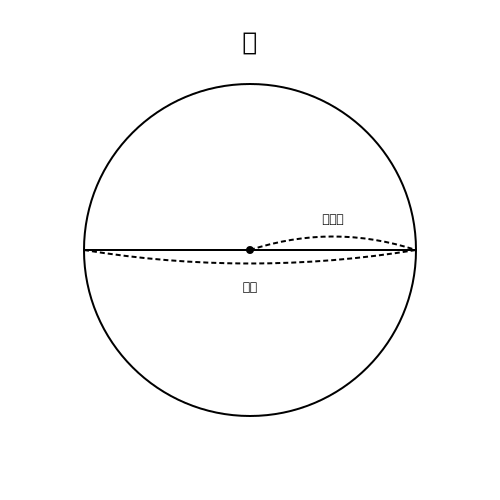

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


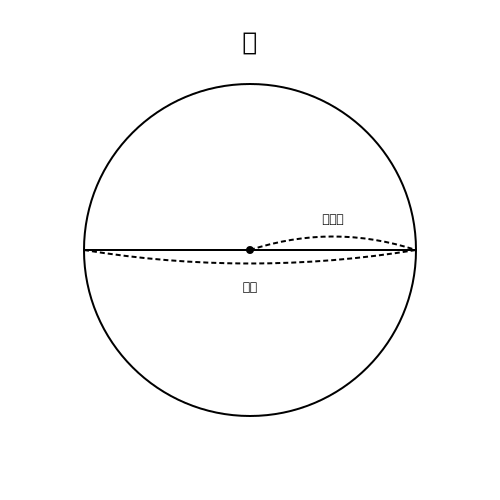

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

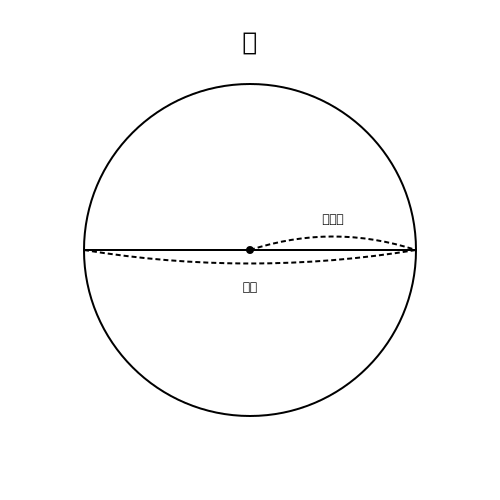

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

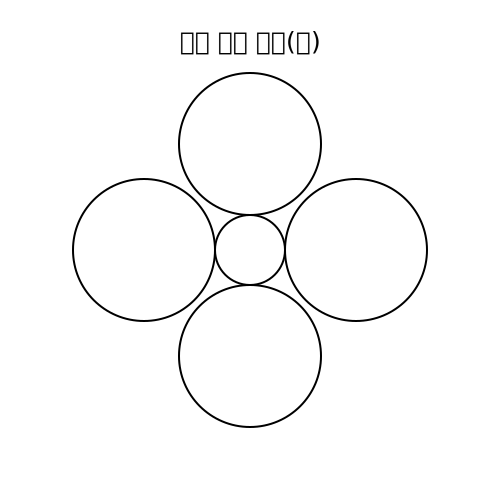

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="144.34543456482515" y2="106.42305324083748" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 228.86908691296503,287.6846106481675 A 50,50 0 0,1 300,333" stroke

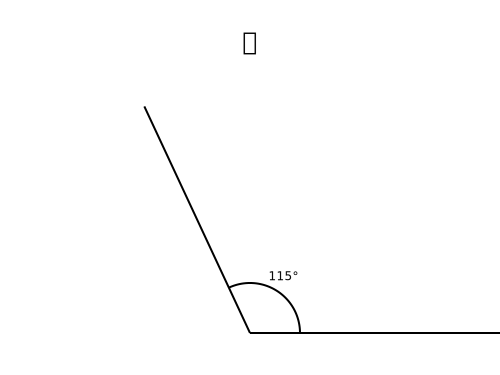

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="261.15975875375676" y2="123.33235801364398" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 152.23195175075136,291.0664716027288 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"

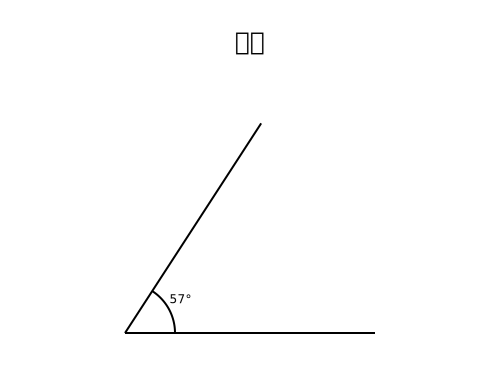

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="226.68416076895005" y2="104.61363558934977" stroke="black" strok

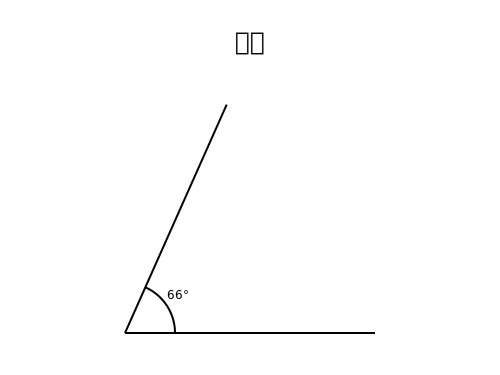

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="222.68278212231843" y2="102.87378663688992" stroke="black" stroke-width="2" />

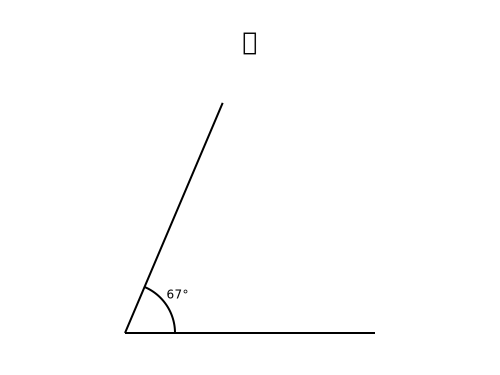

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="244.6650488812297" y2="102.85675481787864" stroke="black" stroke-width

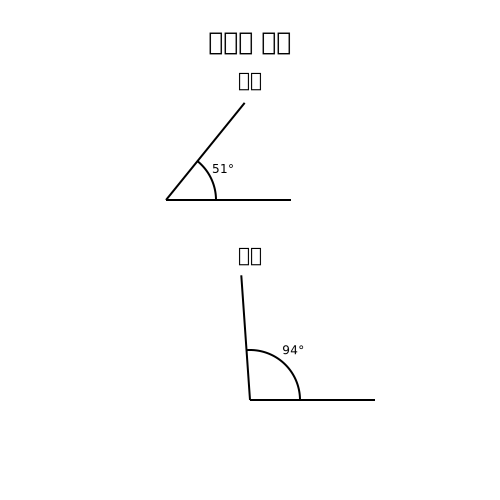

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="82.71734841028544" y2="147.21379363065145" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 216.5434696820571,295.842

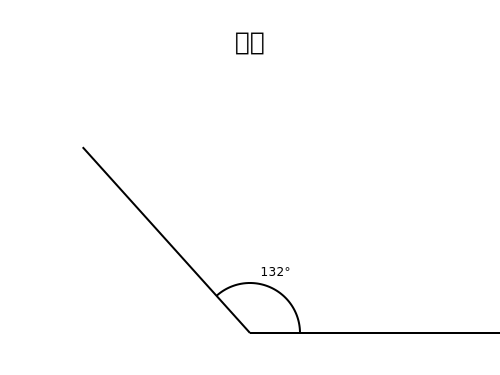

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

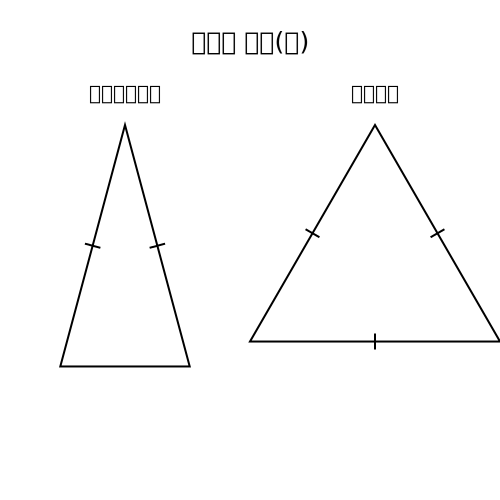

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

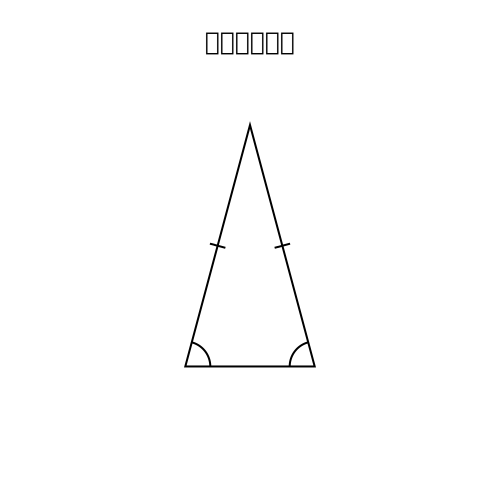

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

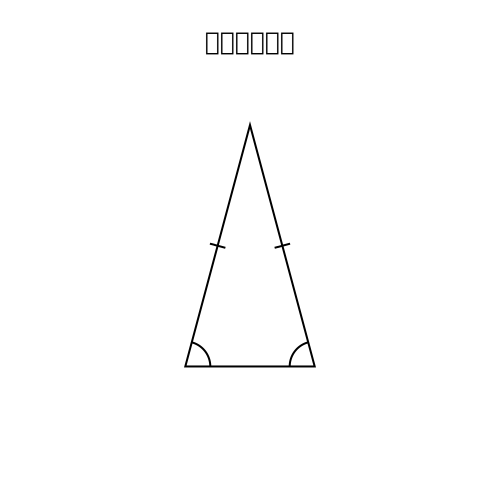

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

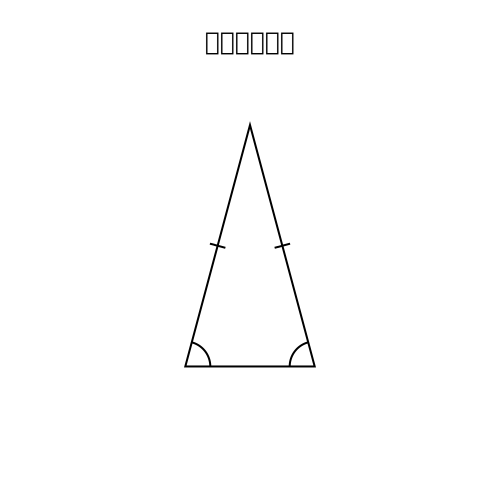

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

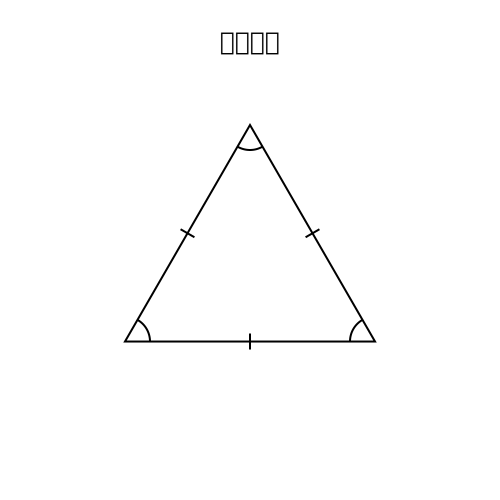

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

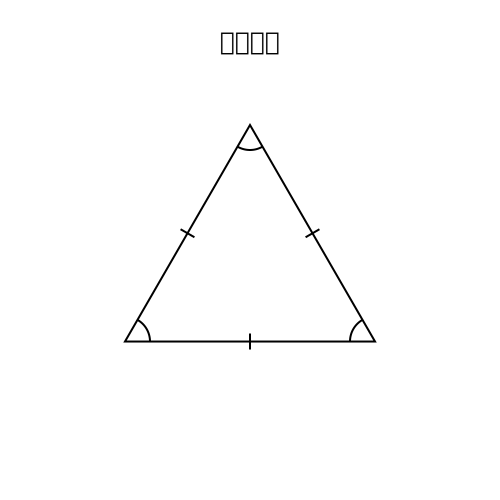

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

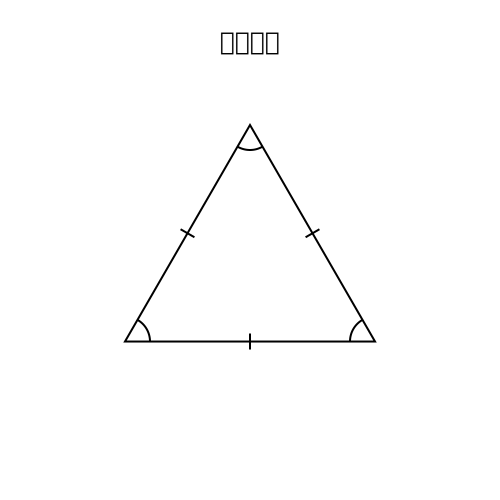

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


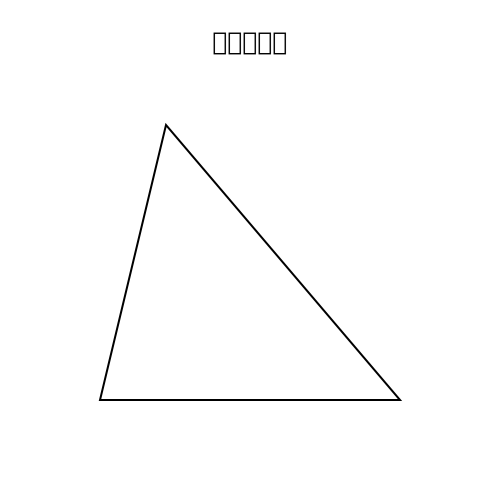

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

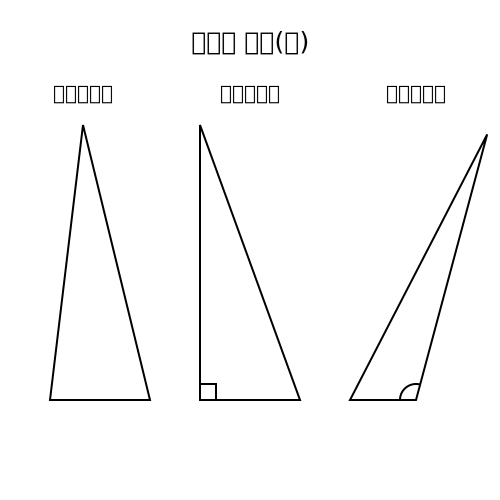

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


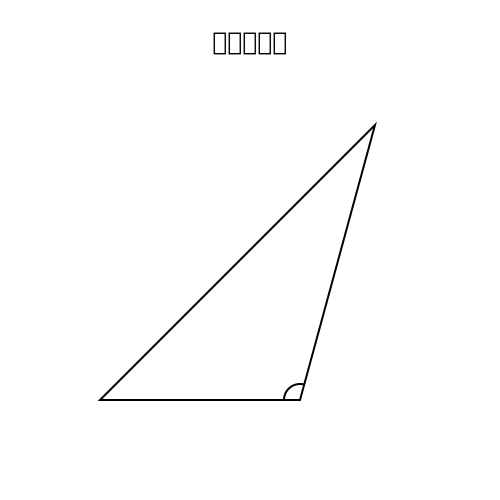

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

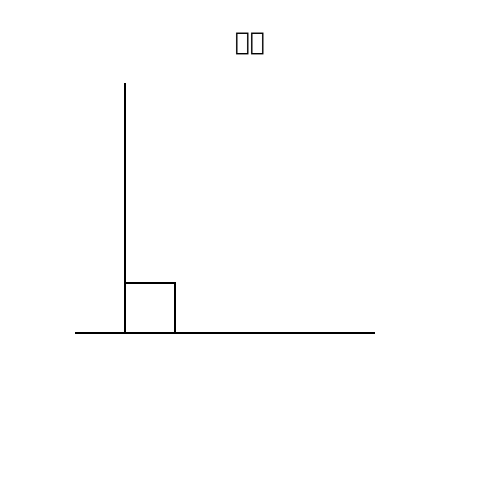

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

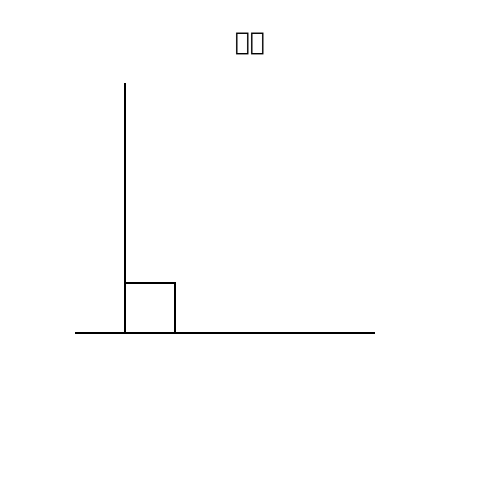

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

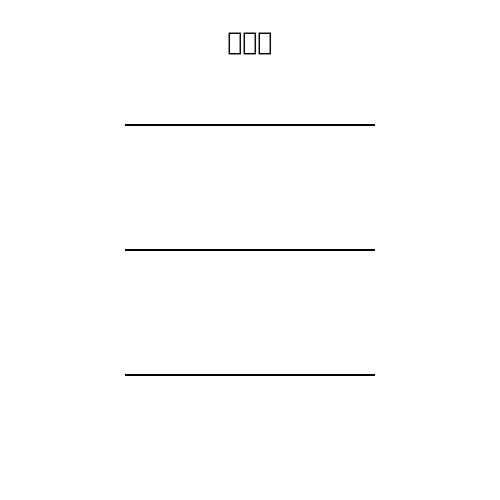

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

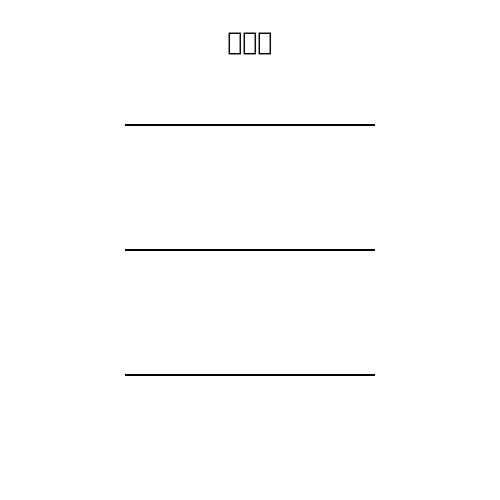

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


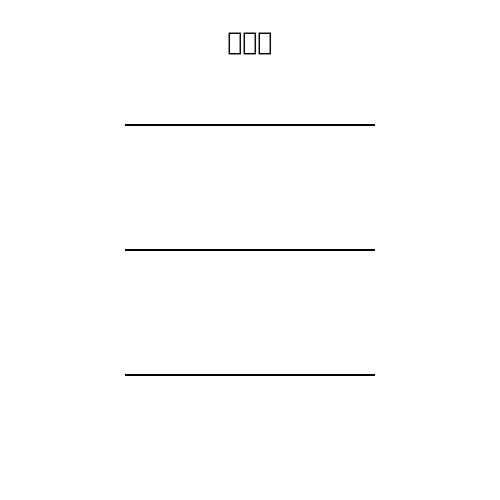

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

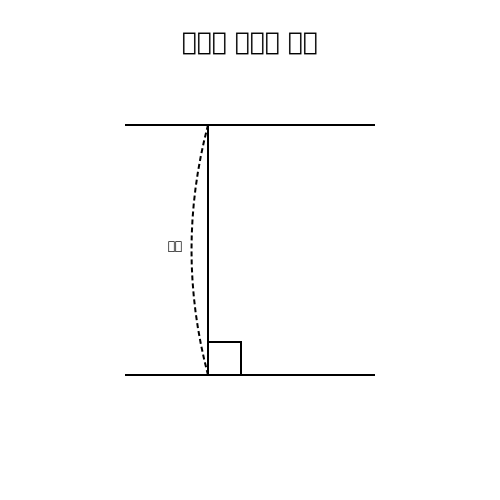

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

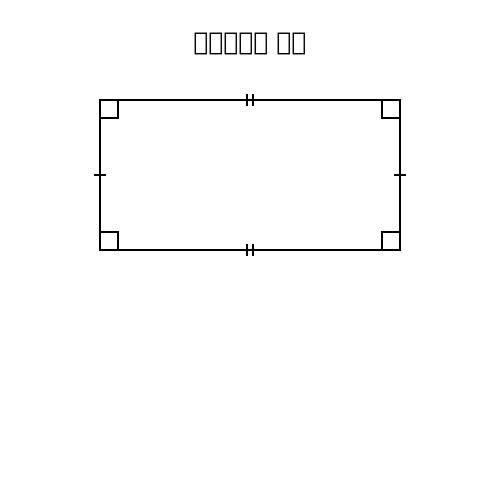

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

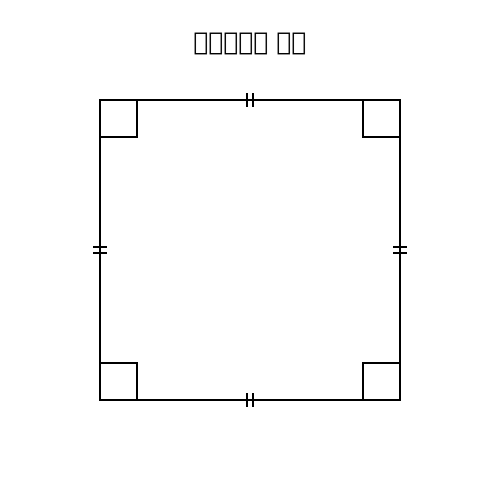

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

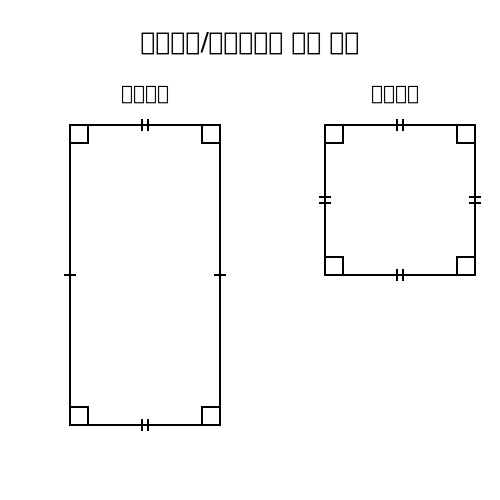

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


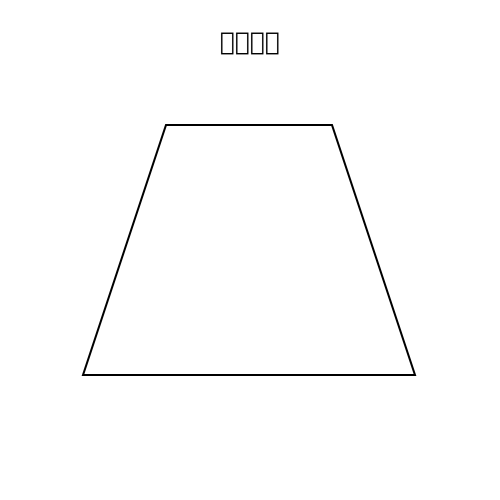

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

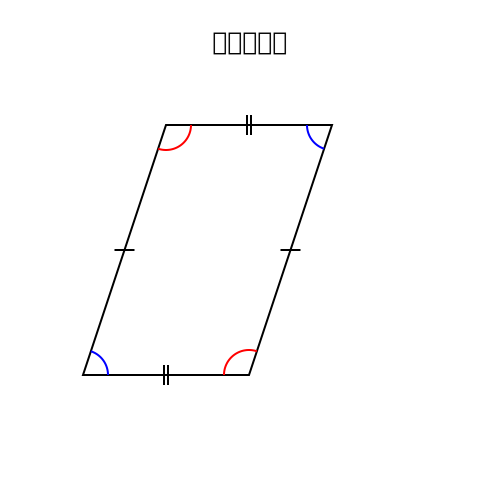

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

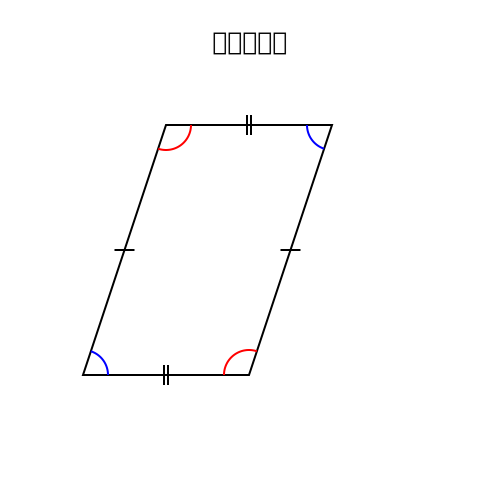

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

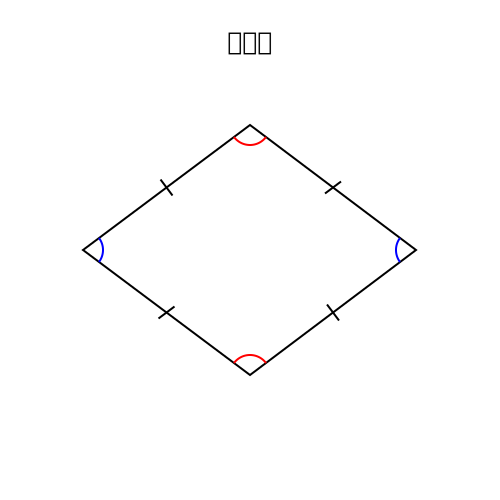

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

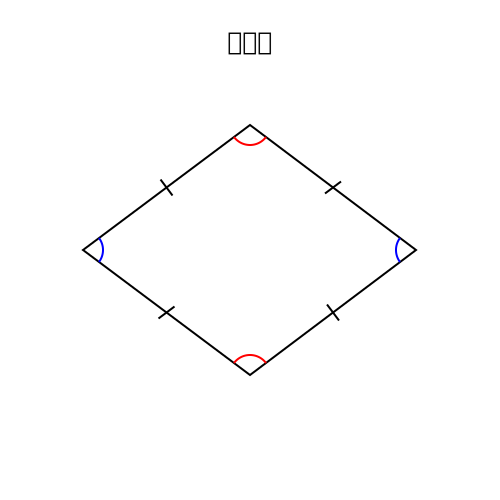

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

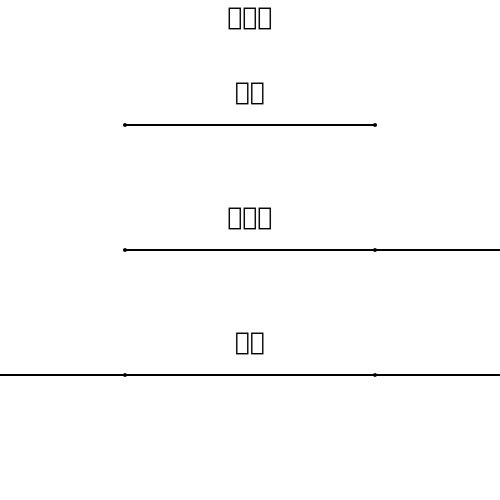

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="64.21379363065148" y2="165.7173484102854" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 212.84275872613028,299.5434696820571 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="272.3979968465813" y="274.65122334392487" font-size="12" text-anchor="middle">138°</text>
        </svg>
        


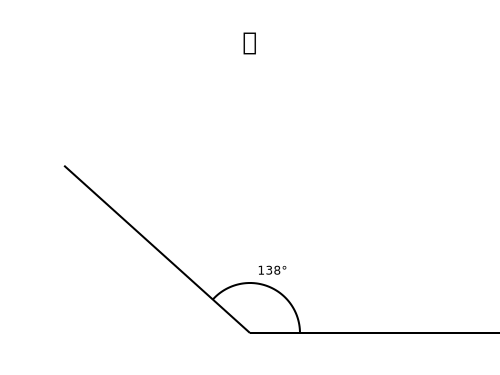

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

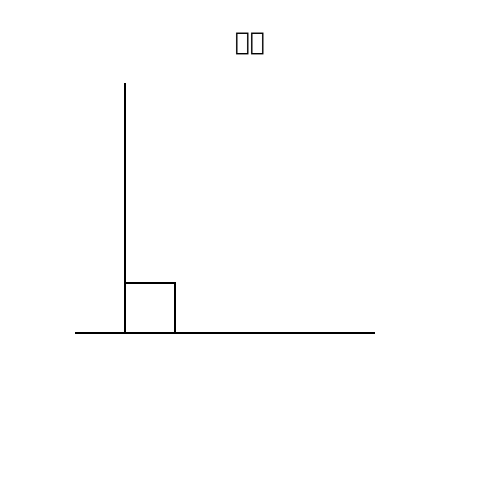

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


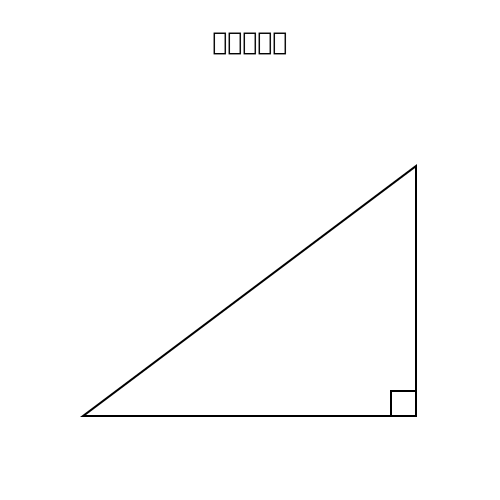

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


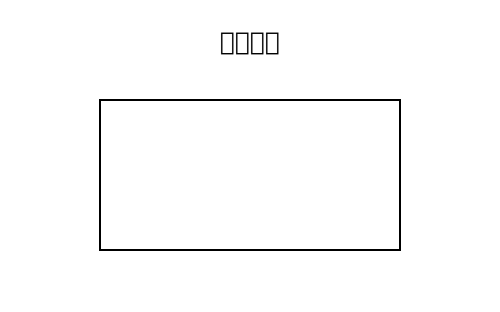

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


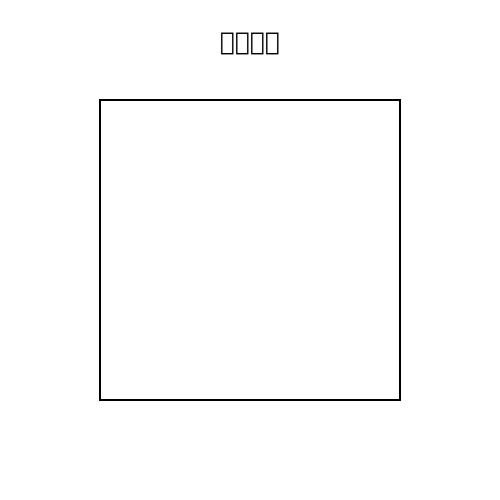

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


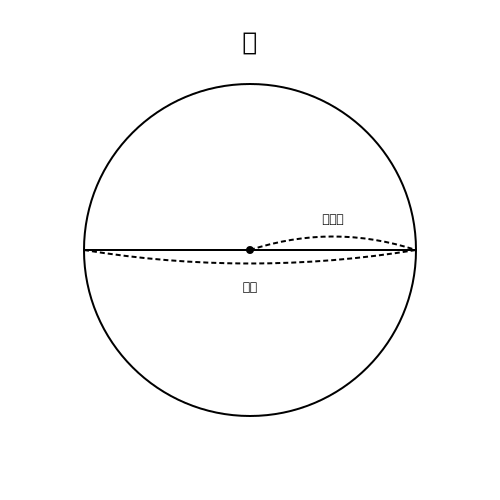

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


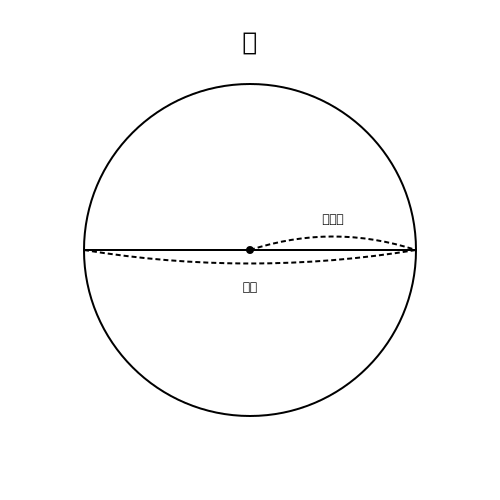

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

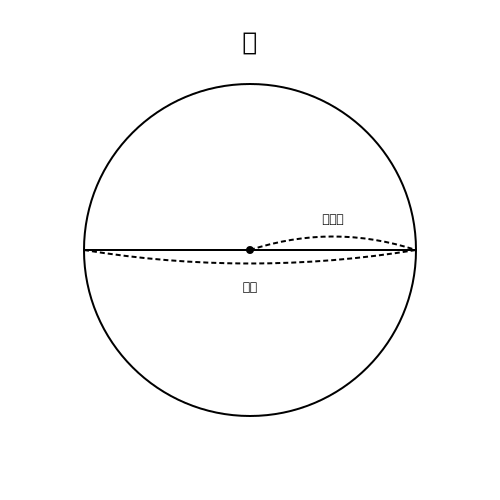

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

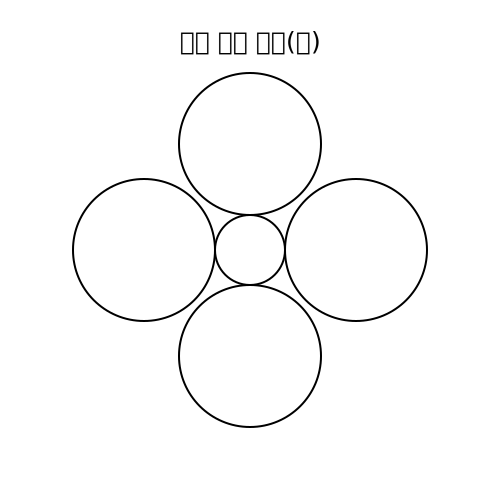

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="155.46733585128686" y2="84.8634620896695" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 131.09346717025738,283.3726924179339 A 50,50 0 0,1 175,333" stroke="

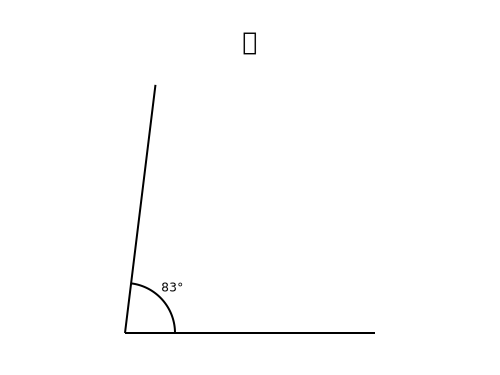

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="341.5063509461097" y2="208.0" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 168.30127018922195,308.0 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
  

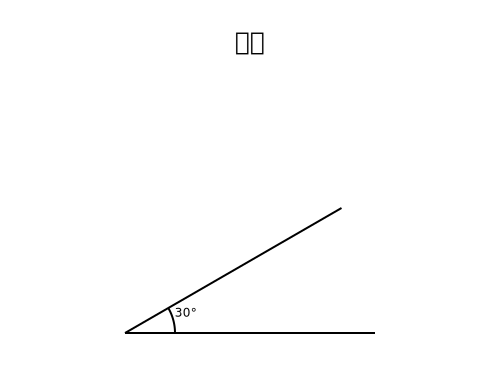

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="12.235870926211618" y2="255.74575140626314" stroke="black" strok

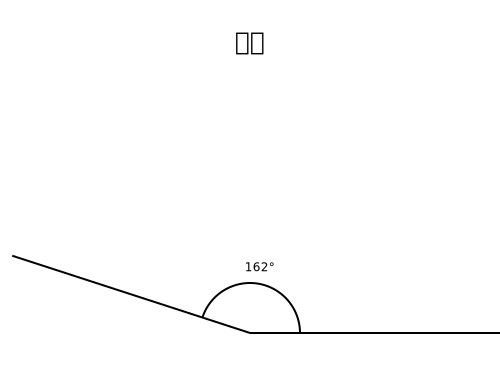

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="132.63210930352727" y2="112.26310178526828" stroke="black" stroke-width="2" />

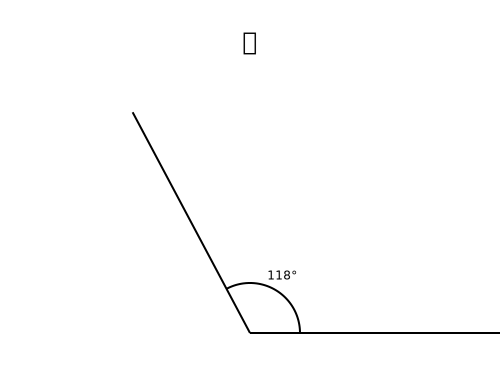

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="232.23990802915063" y2="93.99398798044676" stroke="black" stroke-width

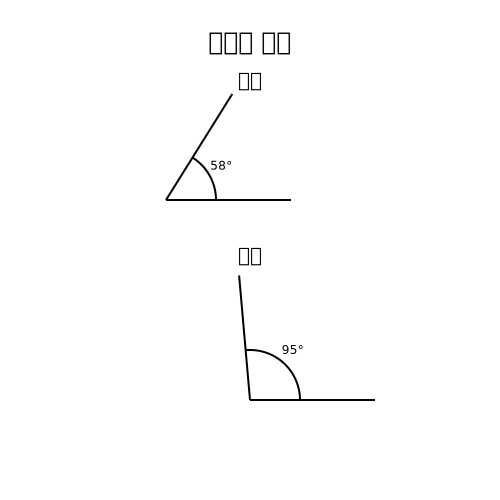

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="70.16504991533719" y2="159.3354073852507" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 214.03300998306744,298.267

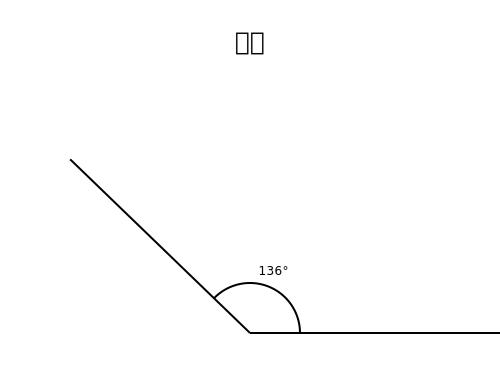

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

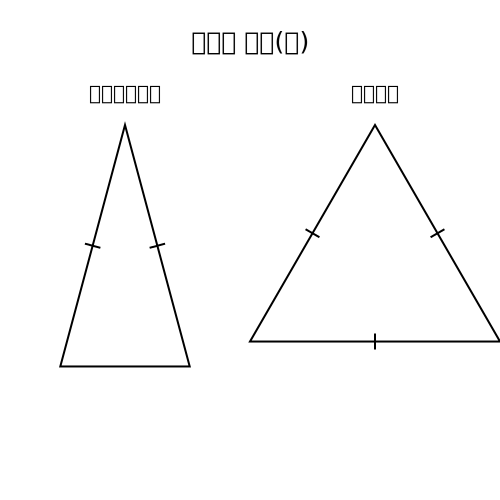

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

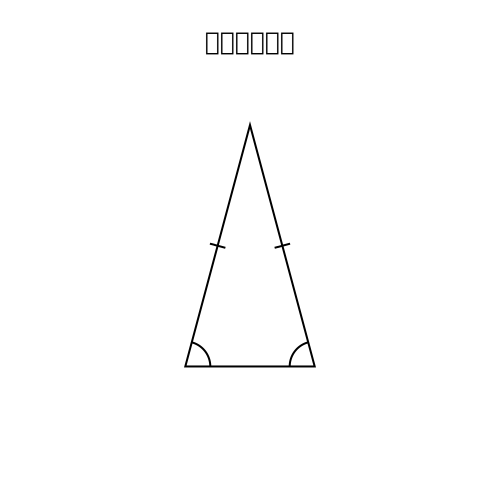

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

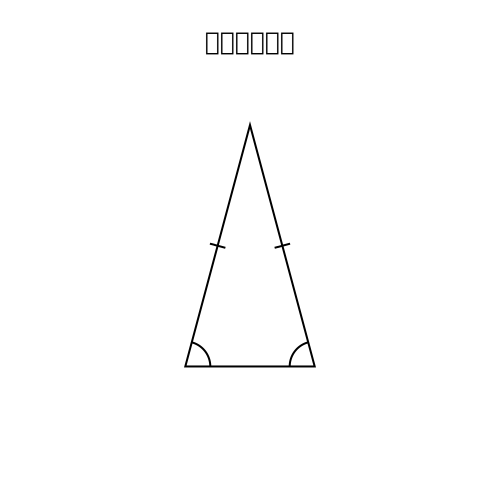

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

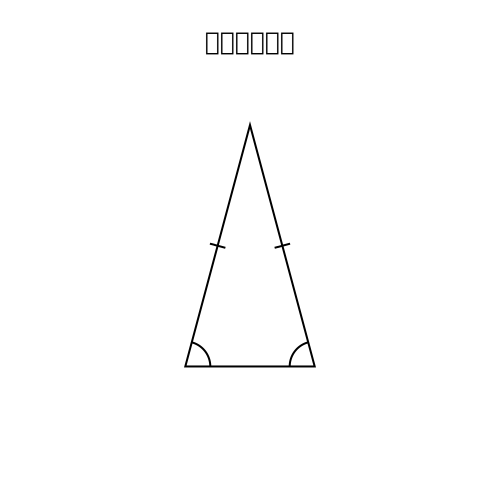

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

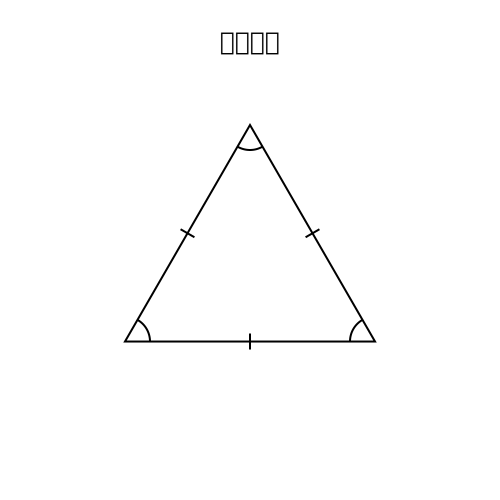

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

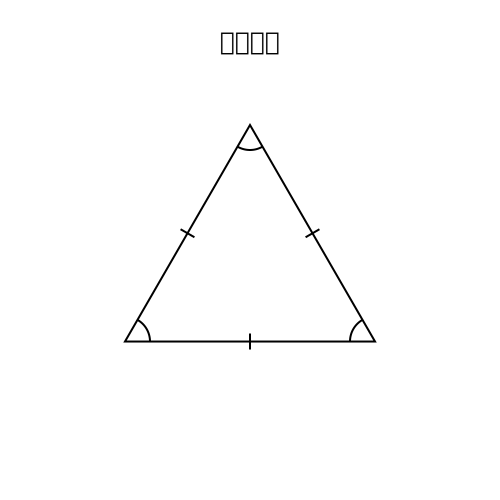

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

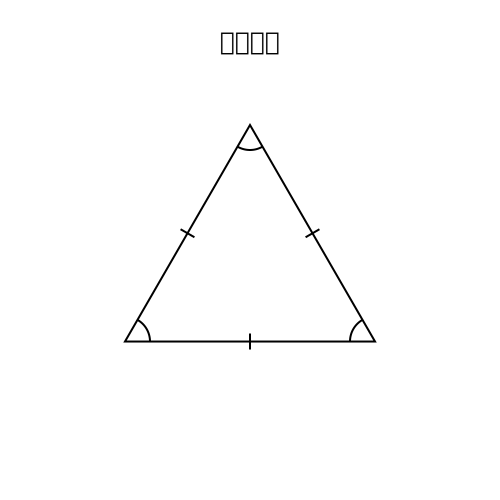

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


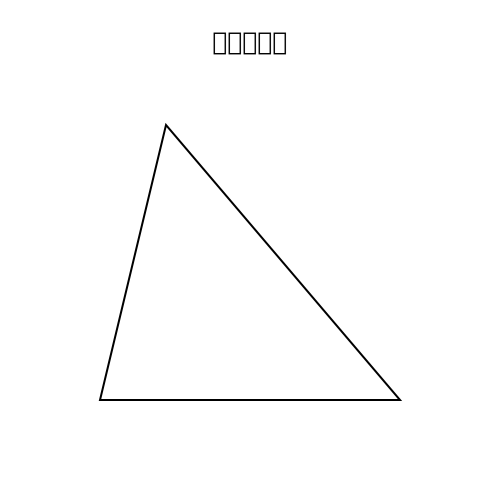

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

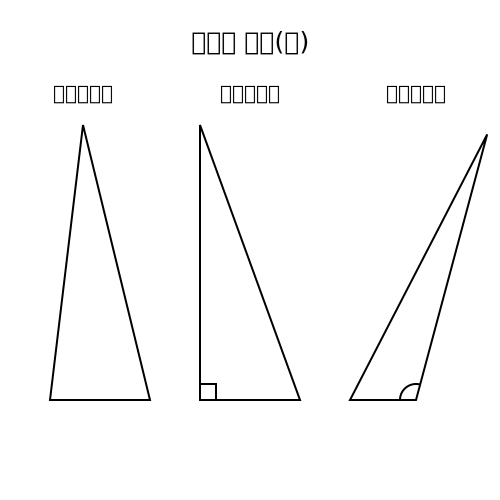

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


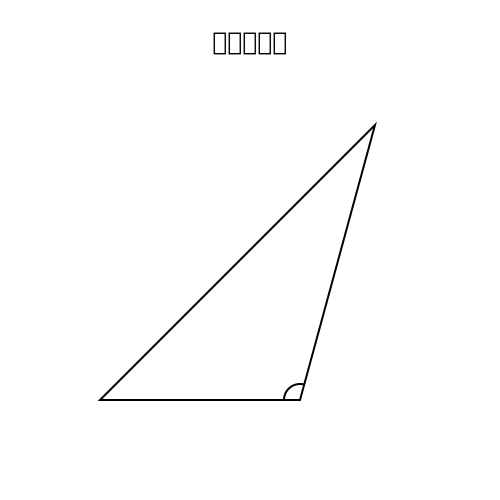

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

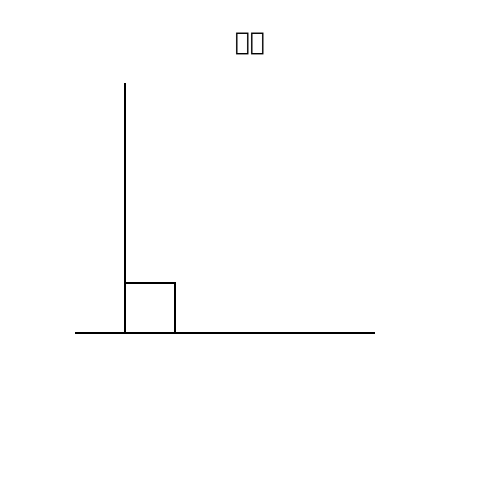

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

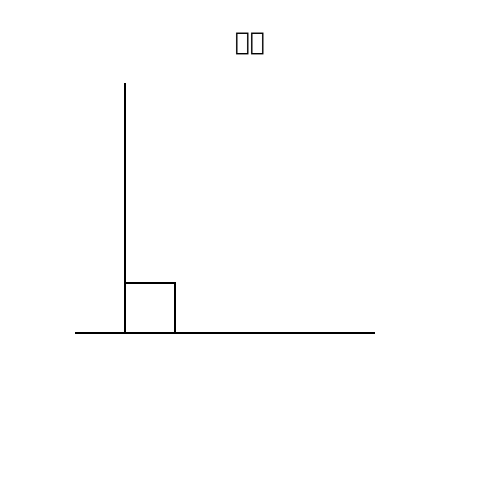

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

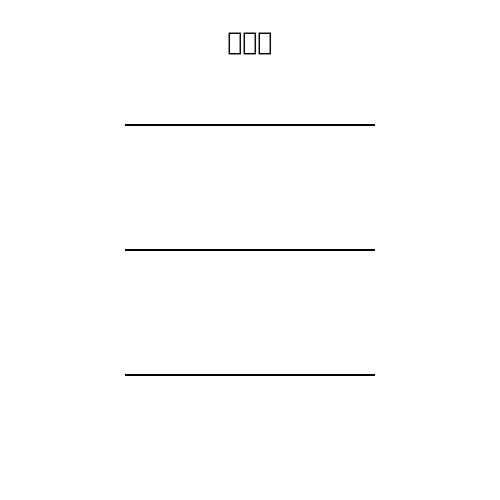

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

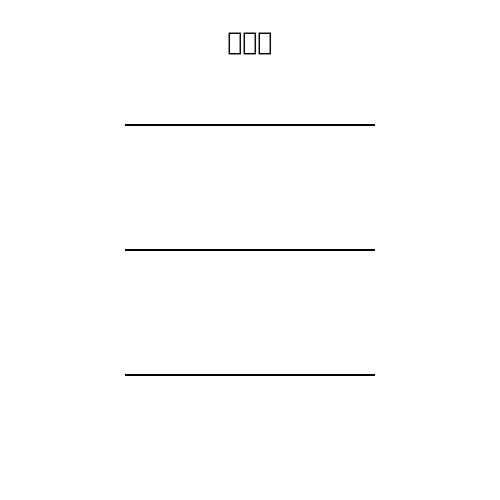

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


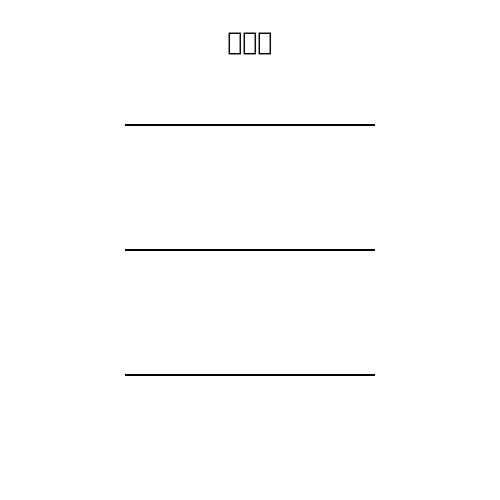

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

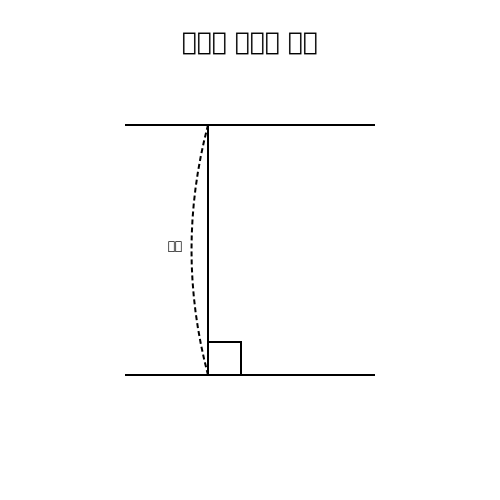

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

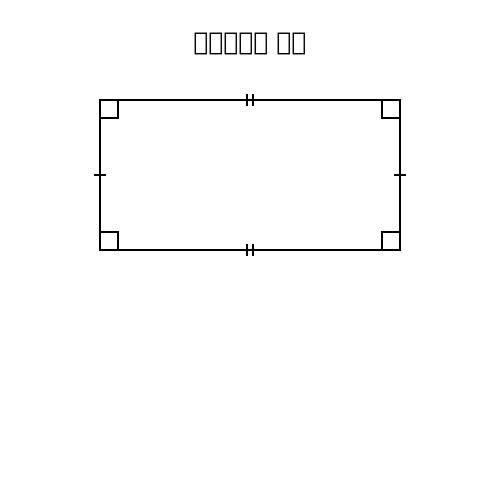

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

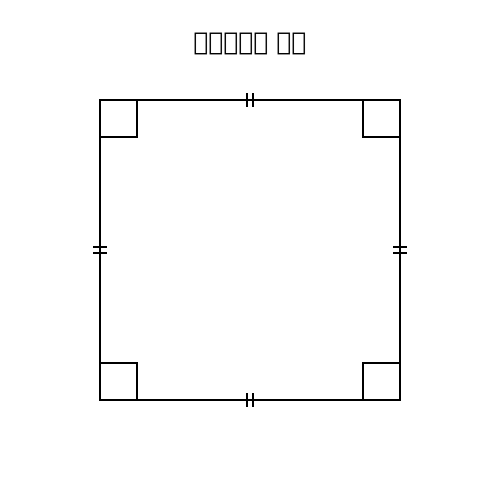

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

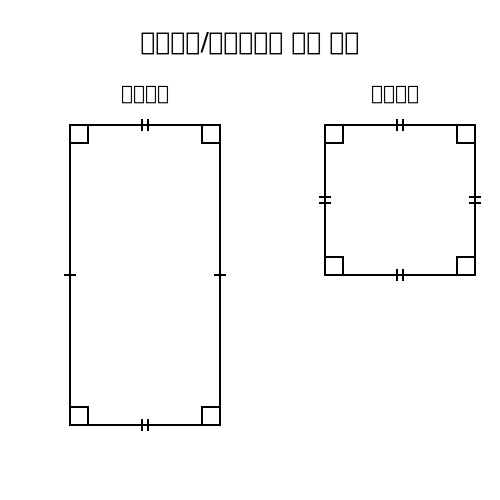

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


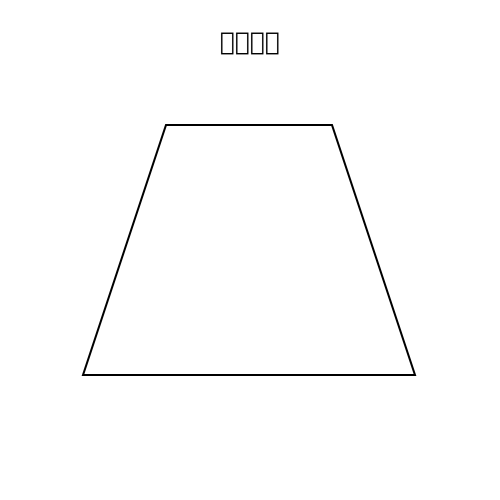

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

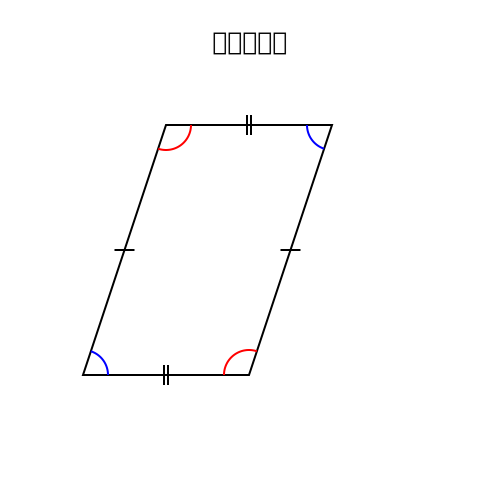

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

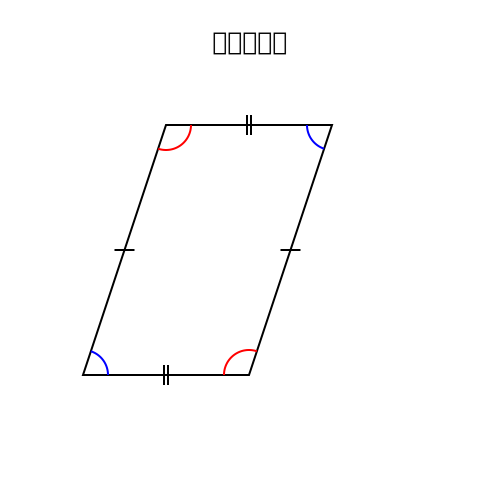

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

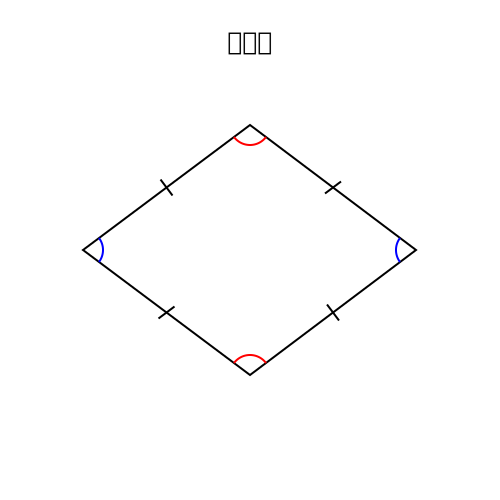

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

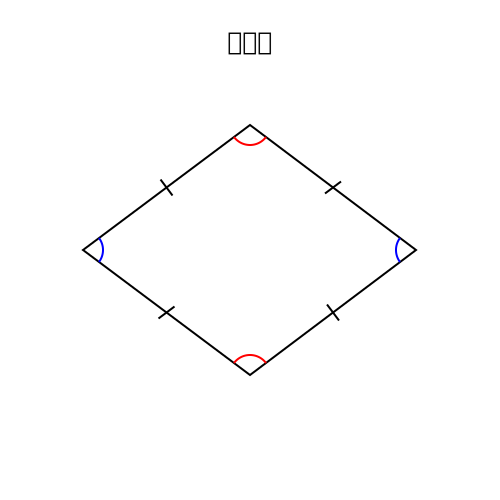

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

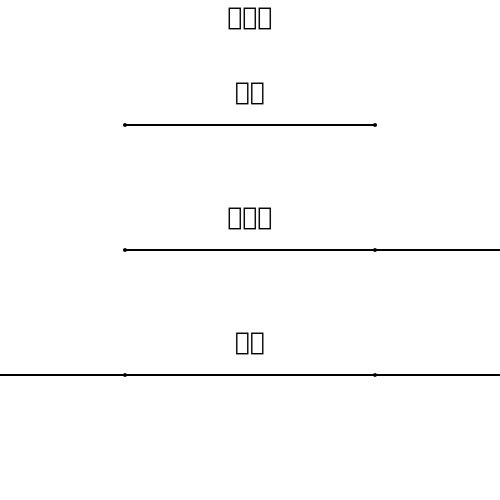

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="27.248368952908066" y2="219.50237506511328" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 205.4496737905816,310.30047501302266 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="264.5903352409941" y="272.2268799751452" font-size="12" text-anchor="middle">153°</text>
        </svg>
        


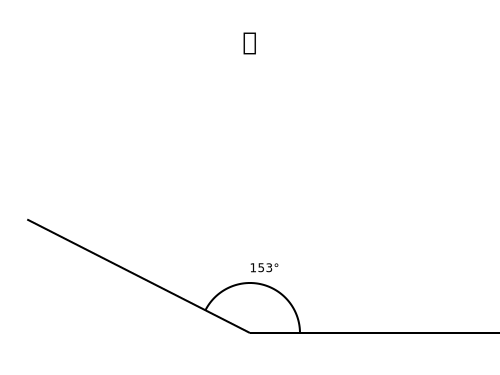

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

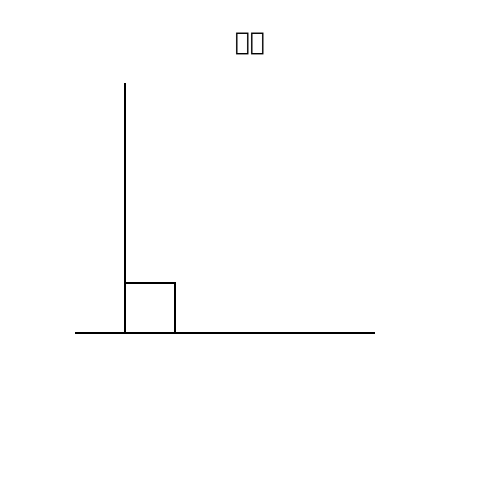

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


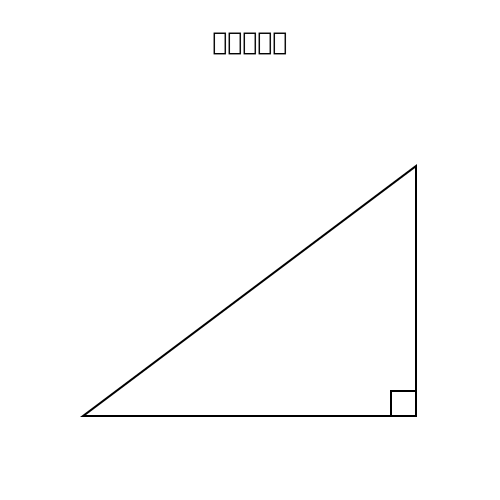

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


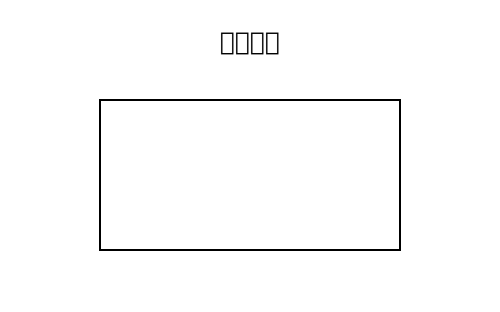

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


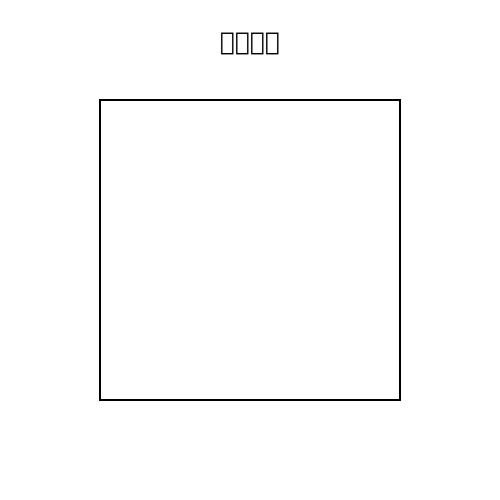

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


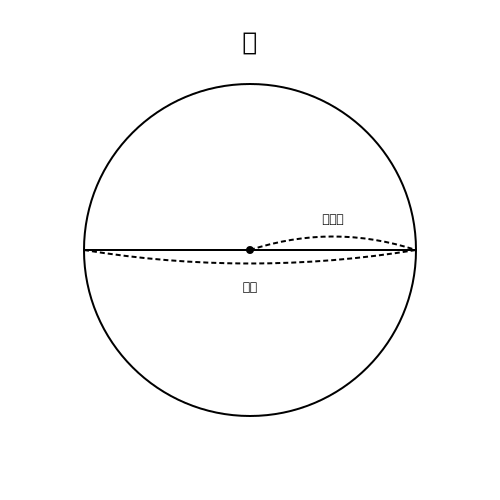

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


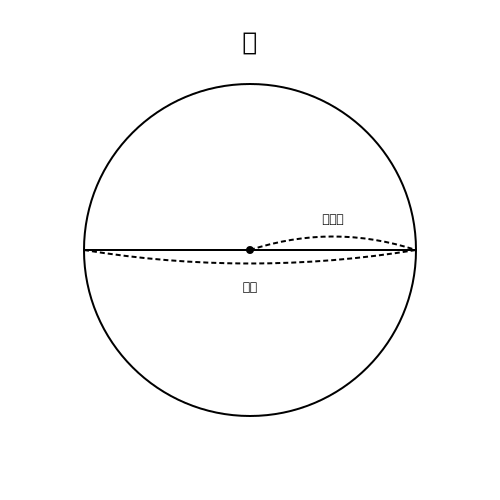

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

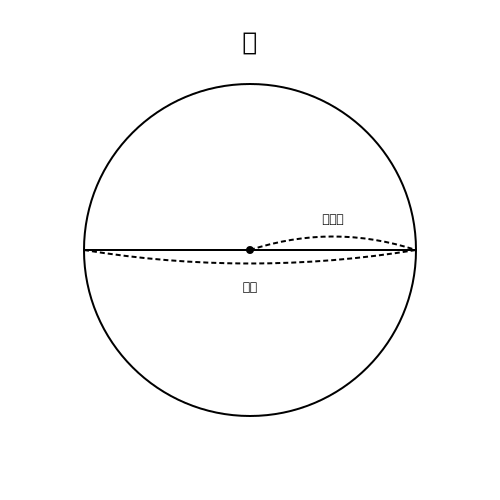

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

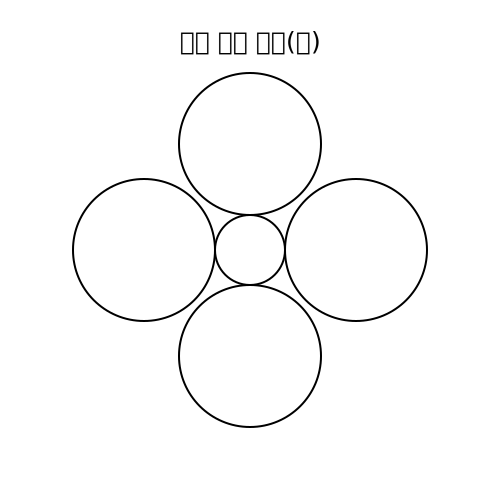

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="21.613635589349798" y2="231.3158392310499" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 204.32272711786996,312.66316784621 A 50,50 0 0,1 300,333" stroke="b

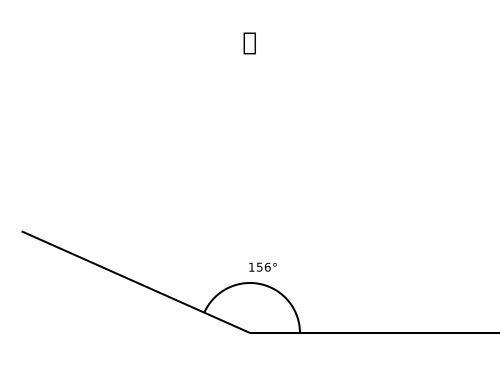

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="215.20672475998367" y2="85.43298281460741" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 243.04134495199673,283.4865965629215 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/

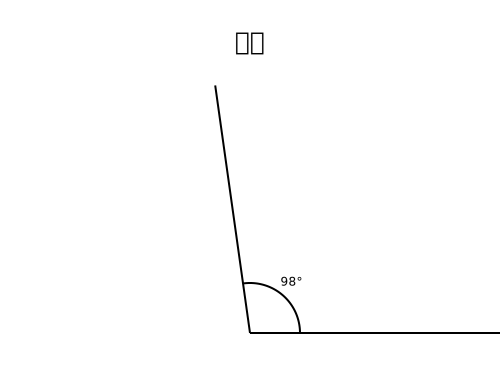

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="1.863462089669497" y2="302.53266414871314" stroke="black" stroke

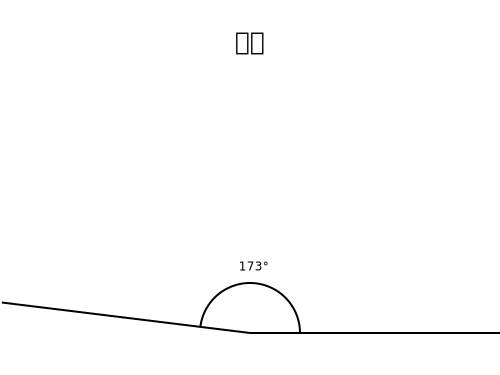

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="35.70817482447194" y2="204.2404812724864" stroke="black" stroke-width="2" />
 

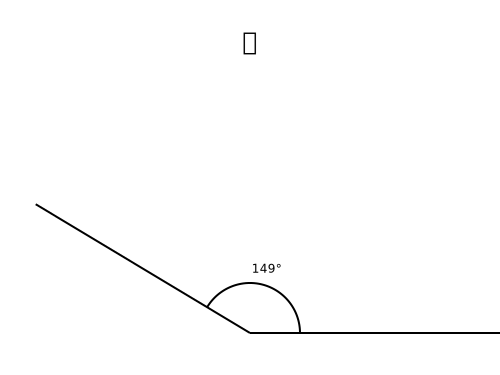

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="172.541994530368" y2="75.17130815567828" stroke="black" stroke-width="

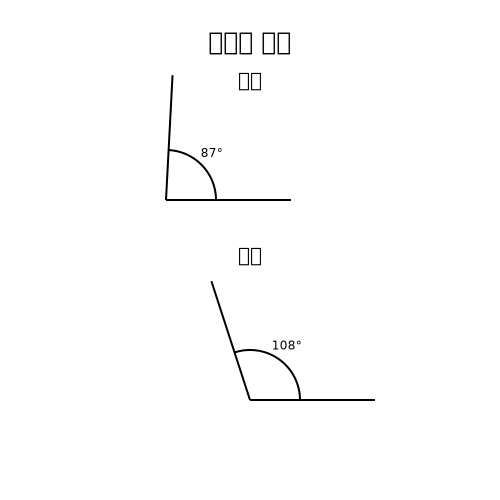

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="332.2593931387604" y2="193.20177413231326" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 166.45187862775208,305.04

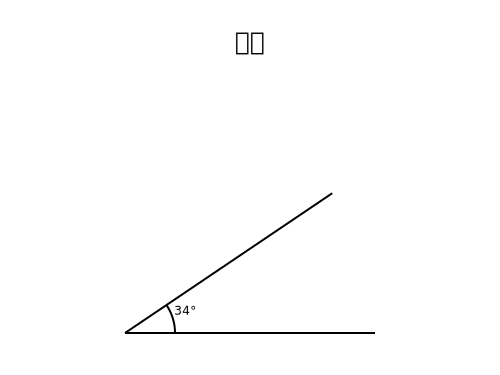

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

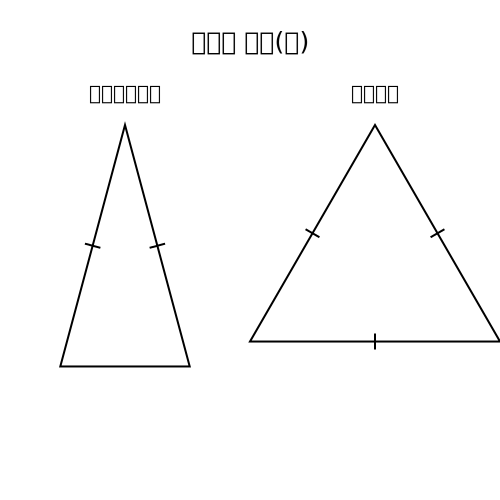

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

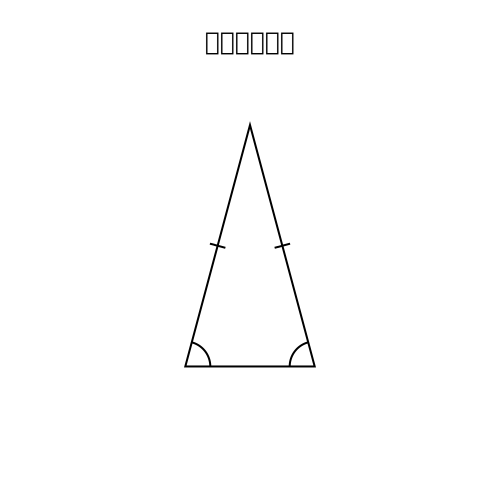

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

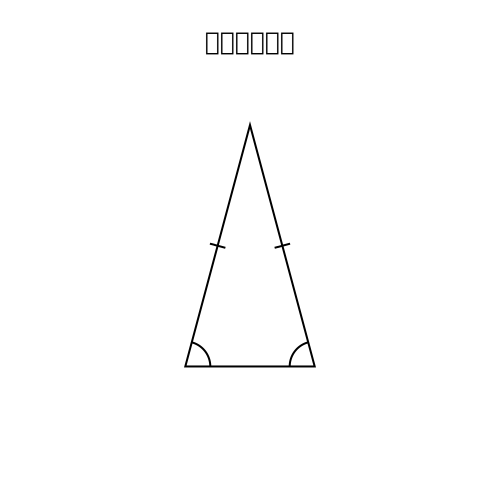

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

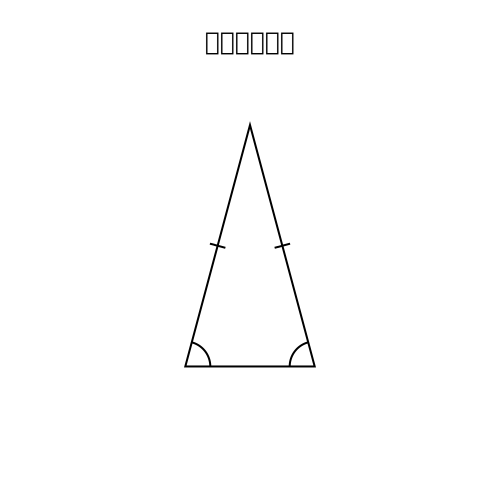

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

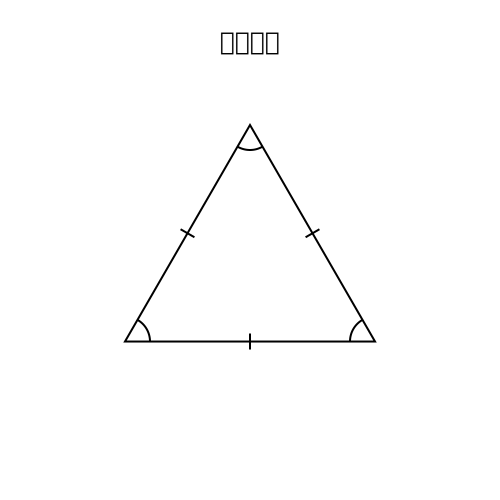

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

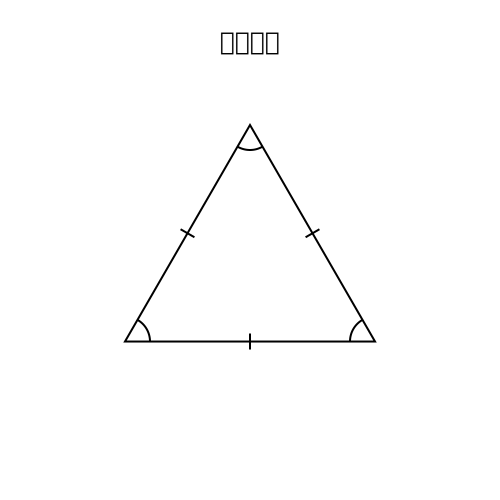

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

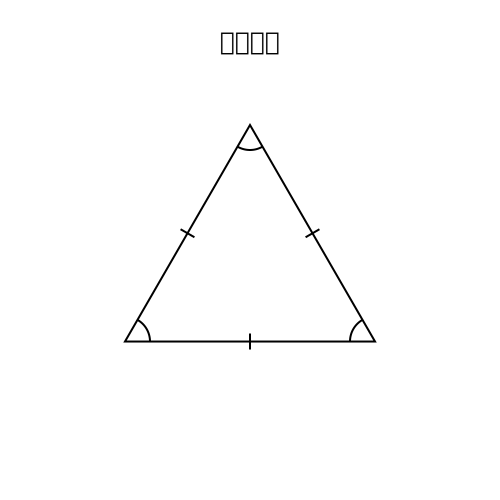

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


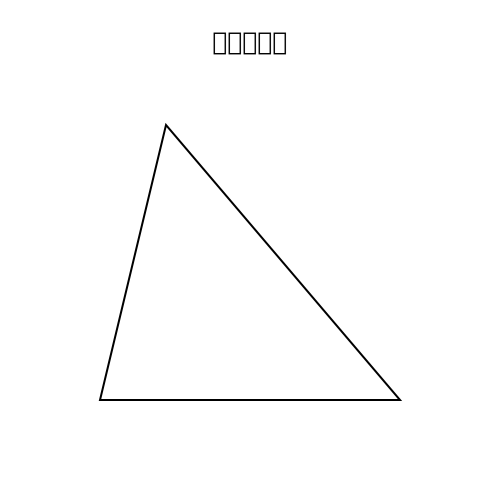

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

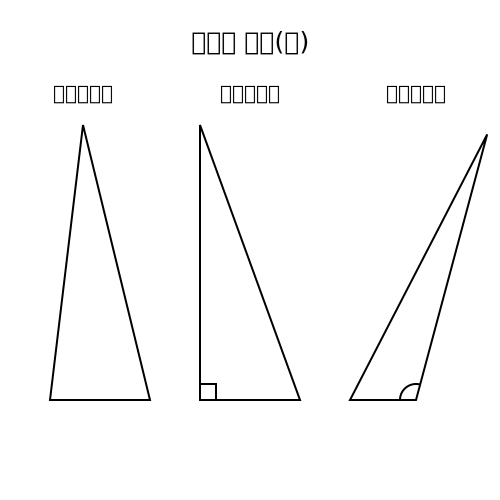

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


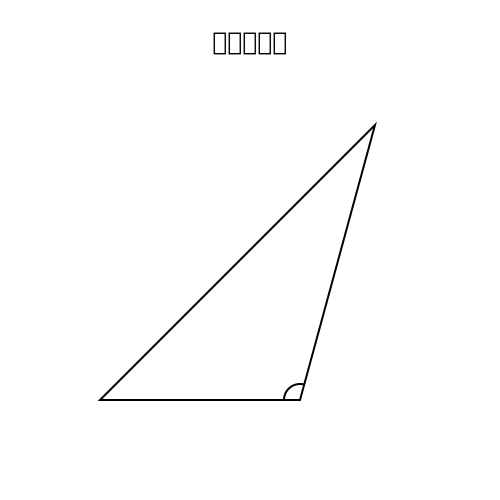

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

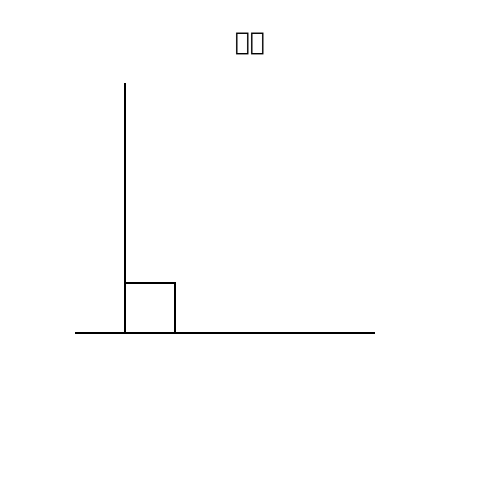

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

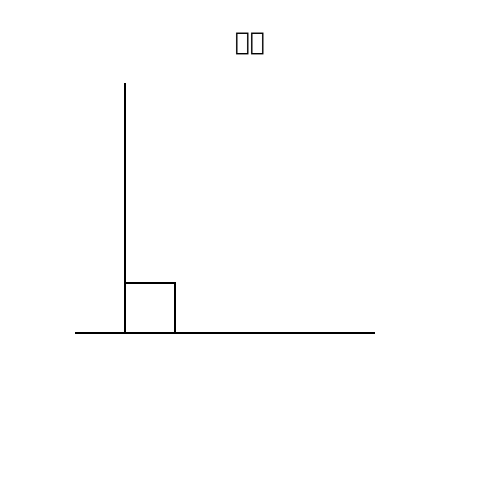

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

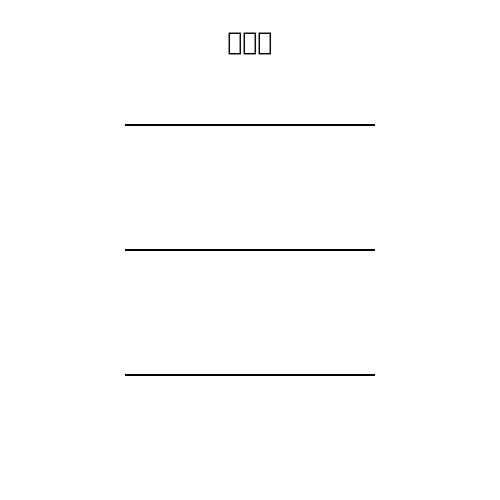

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

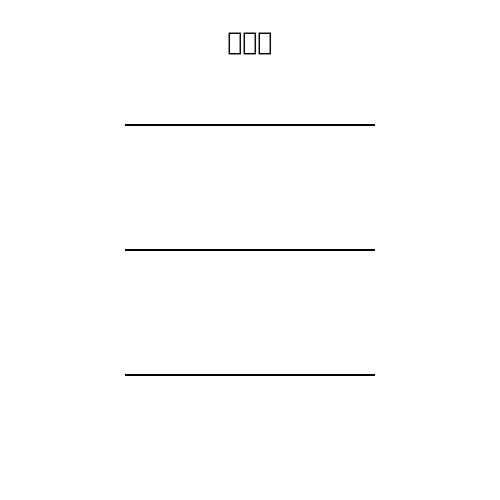

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


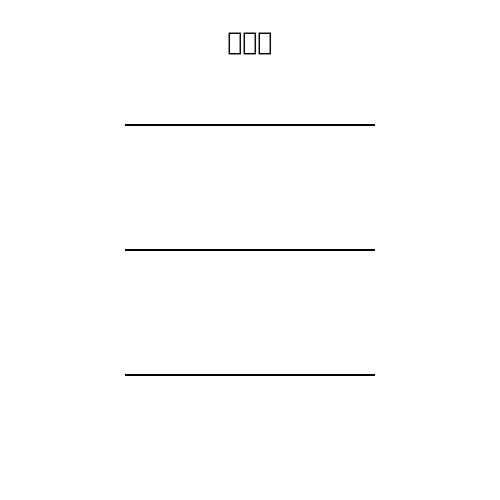

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

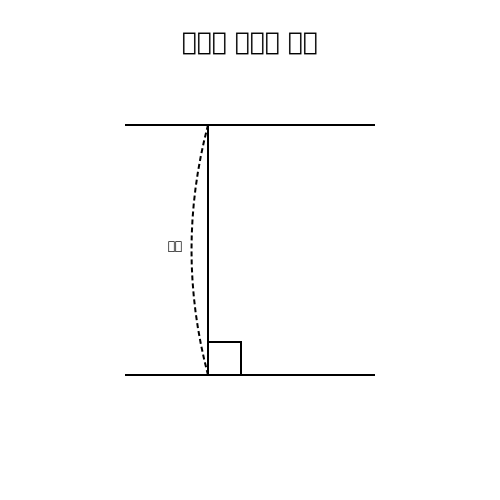

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

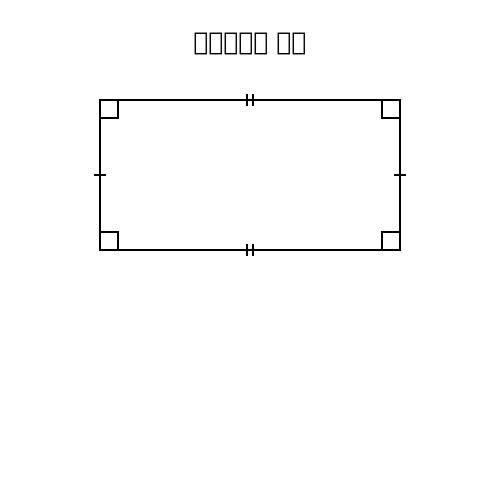

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

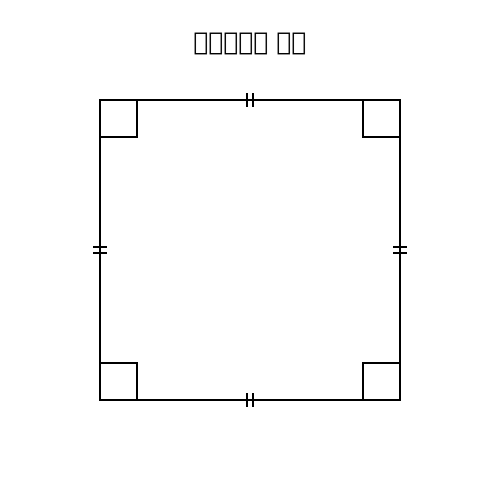

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

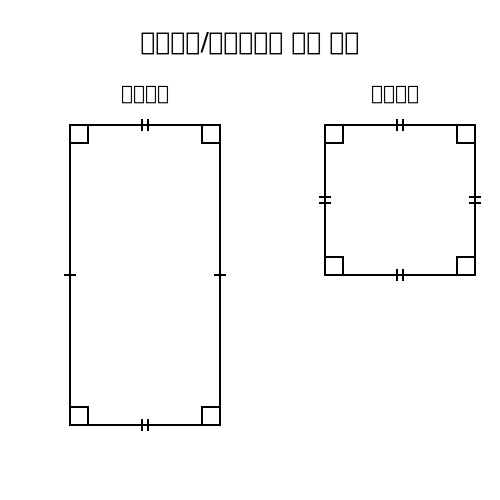

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


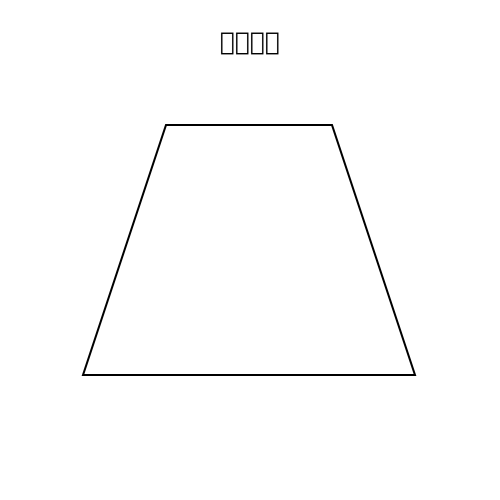

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

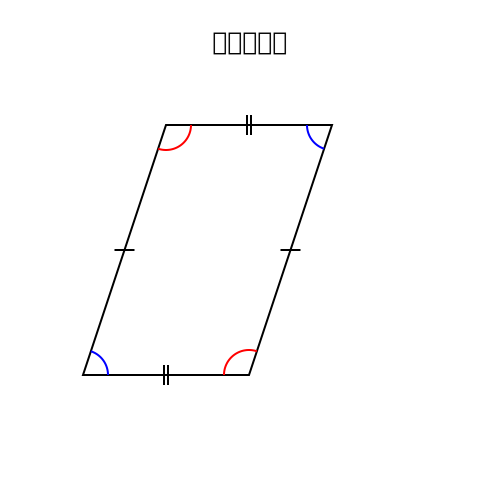

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

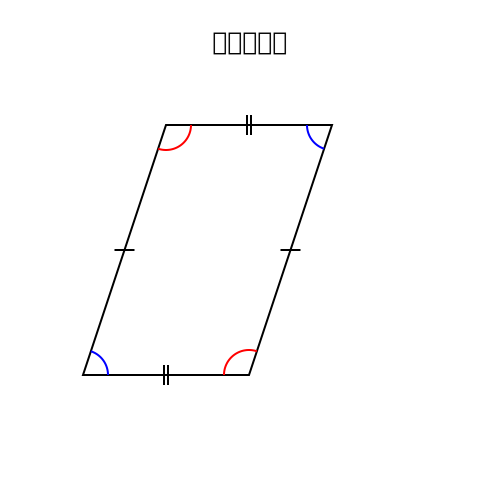

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

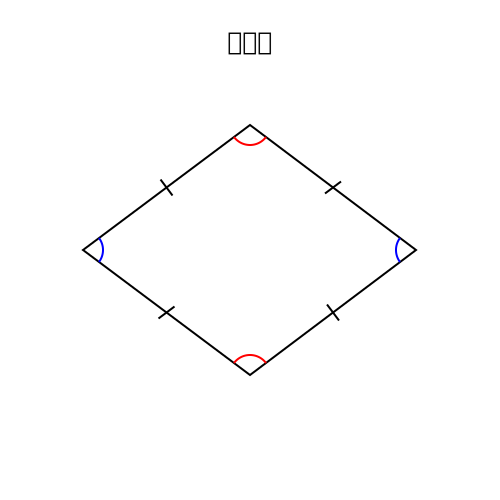

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

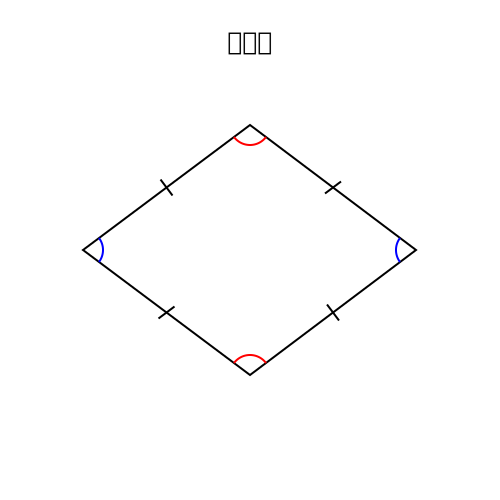

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

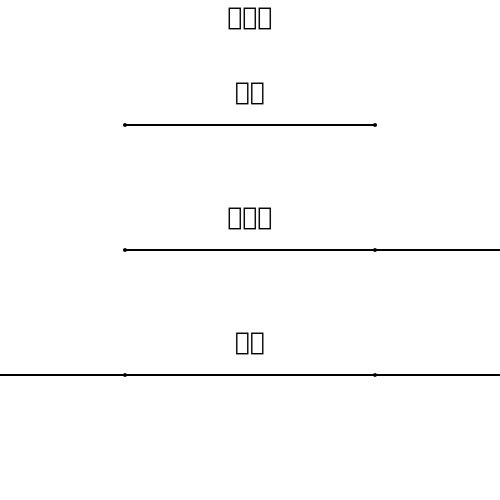

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="146.78893568691453" y2="83.95132547706362" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 129.3577871373829,283.1902650954127 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="171.07983355063274" y="290.77561202402126" font-size="12" text-anchor="middle">85°</text>
        </svg>
        


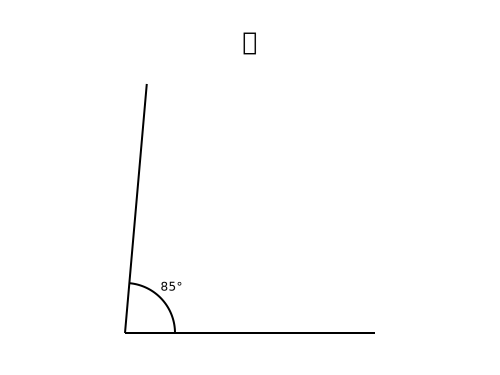

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

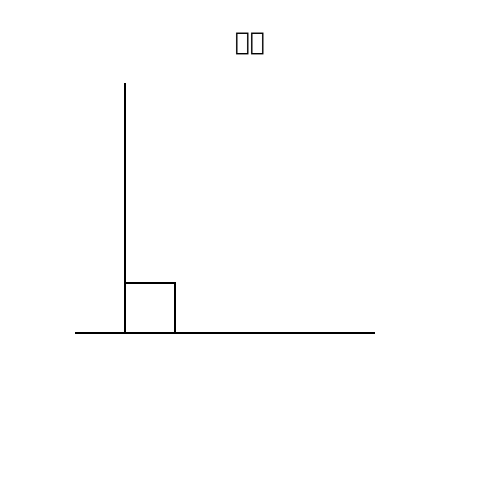

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


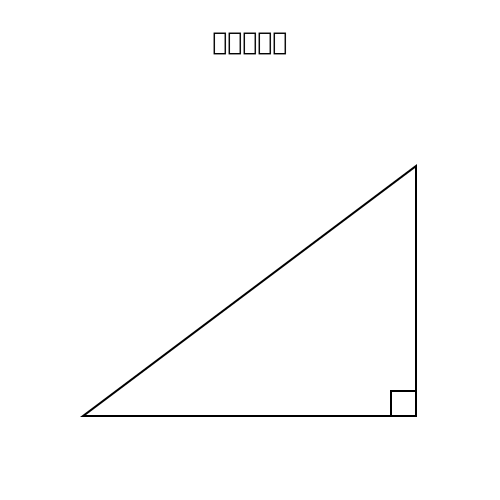

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


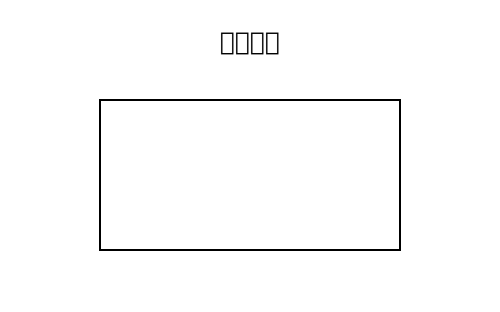

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


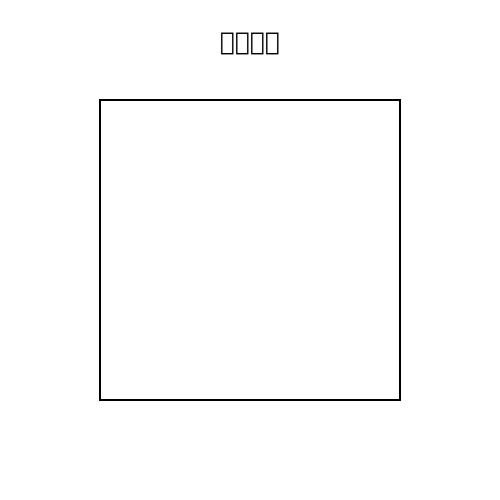

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


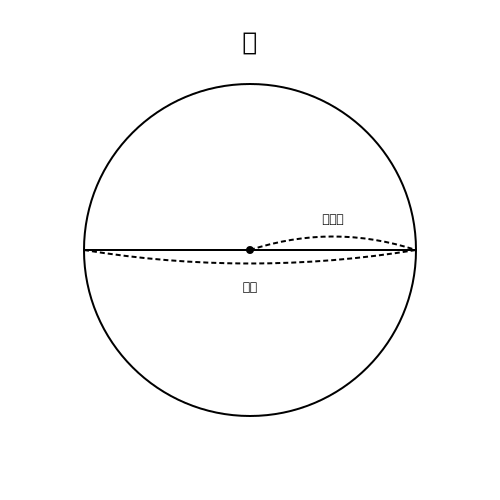

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


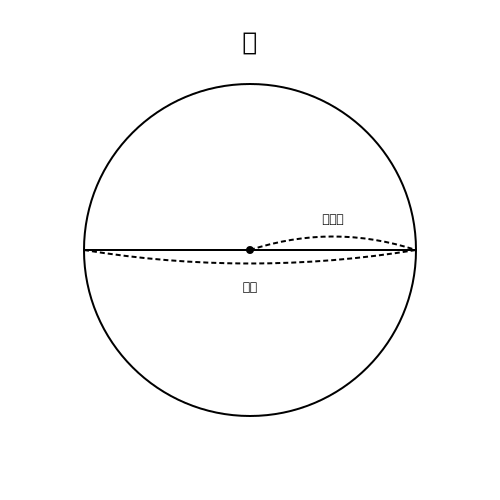

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

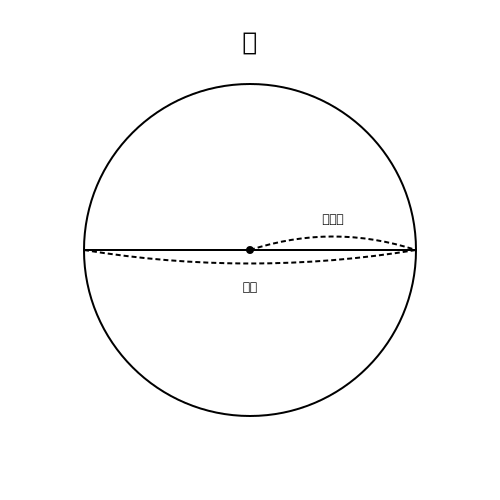

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

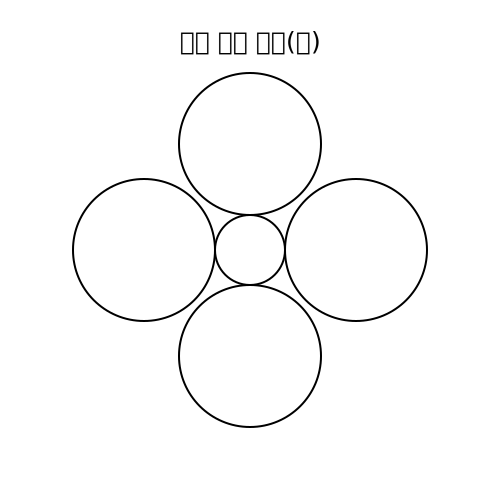

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="76.33540738525065" y2="153.16504991533722" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 215.26708147705014,297.0330099830675 A 50,50 0 0,1 300,333" stroke=

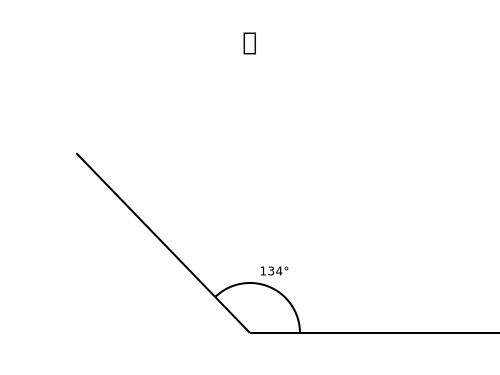

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="198.02207729556017" y2="88.46309981654858" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 239.60441545911203,284.09261996330974 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"

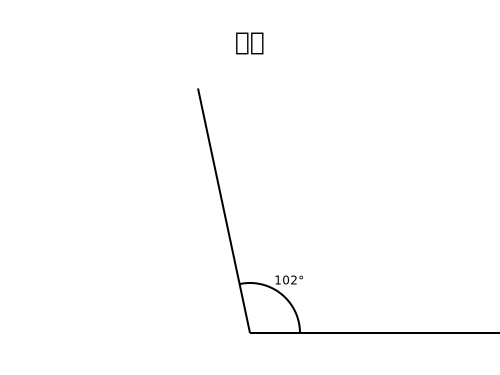

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="110.20177413231332" y2="125.74060686123957" stroke="black" strok

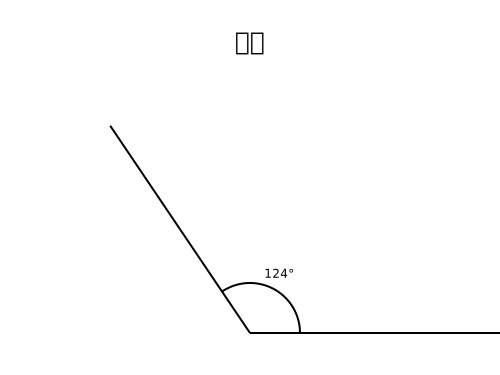

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="264.7982258676867" y2="125.74060686123957" stroke="black" stroke-width="2" />


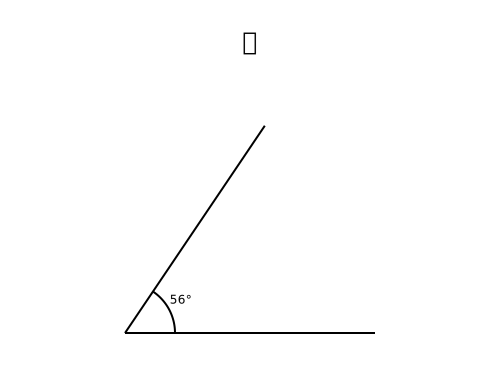

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="176.89446784345728" y2="75.47566273853181" stroke="black" stroke-width

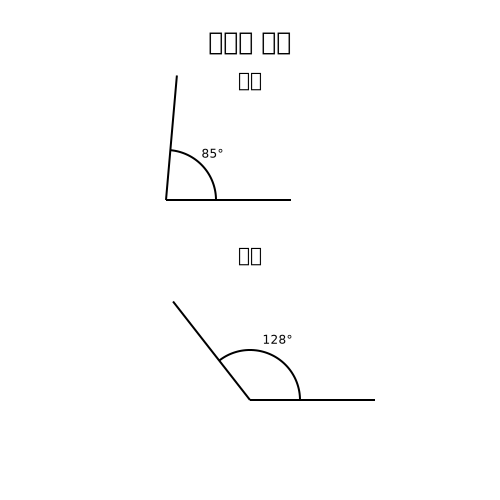

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="353.38636441065023" y2="231.31583923104995" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 170.67727288213004,312.6

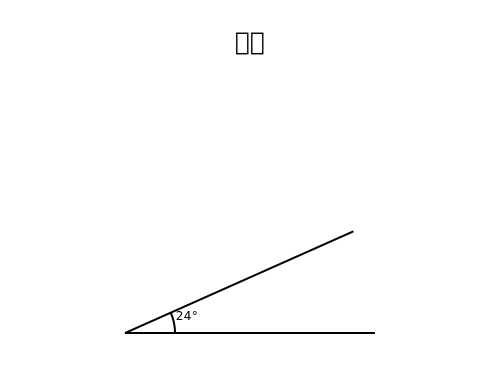

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

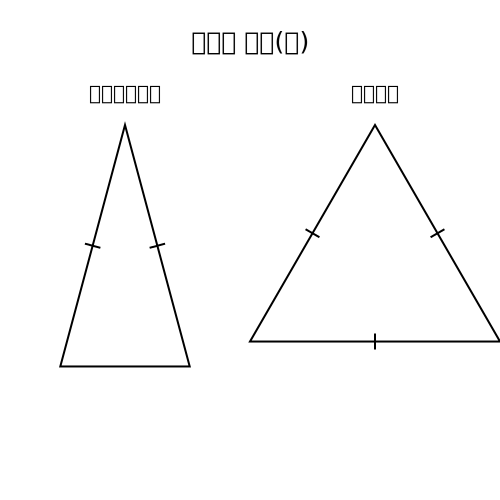

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

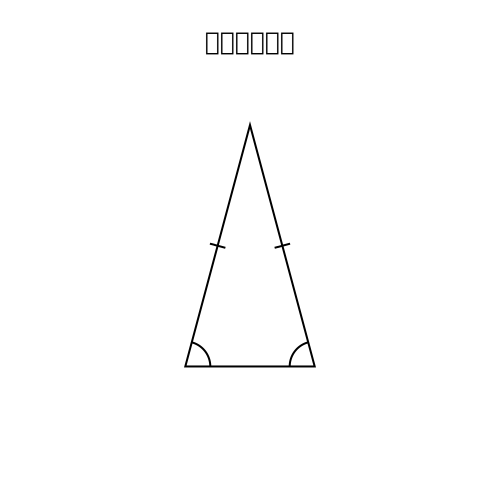

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

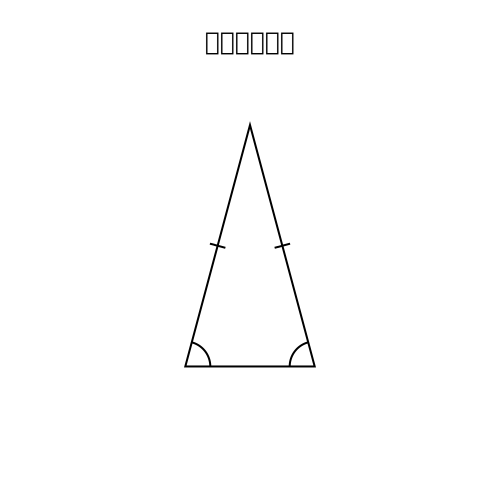

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

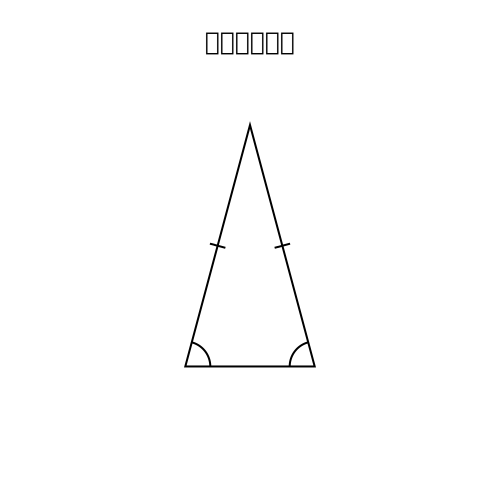

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

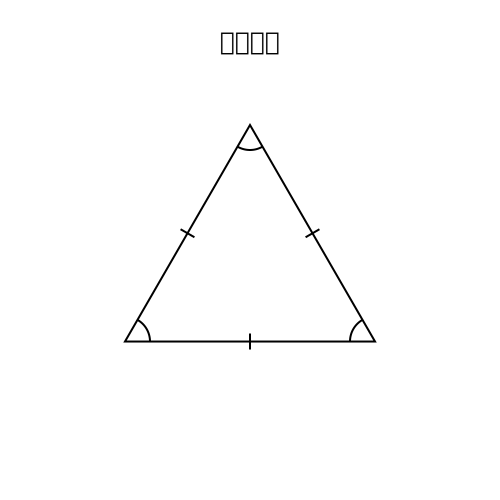

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

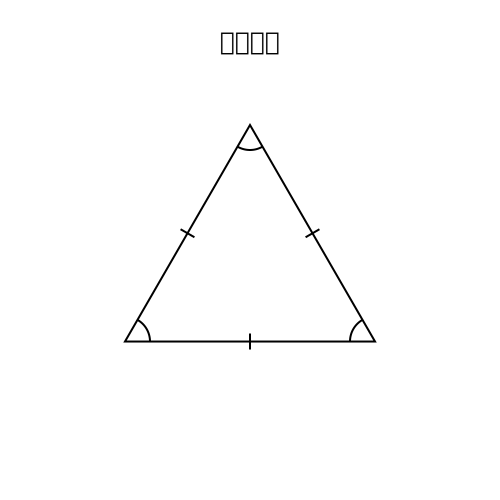

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

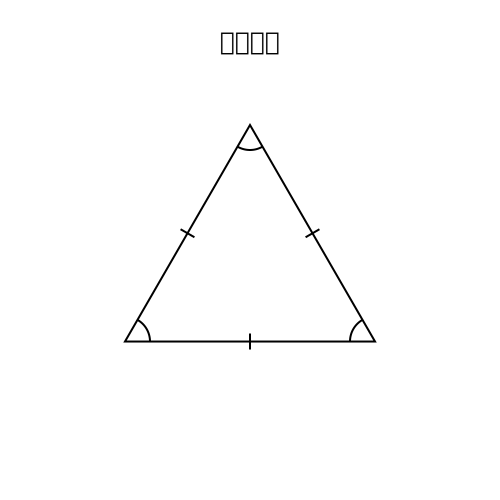

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


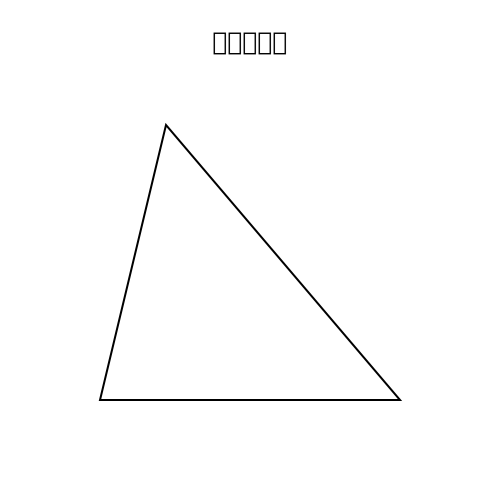

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

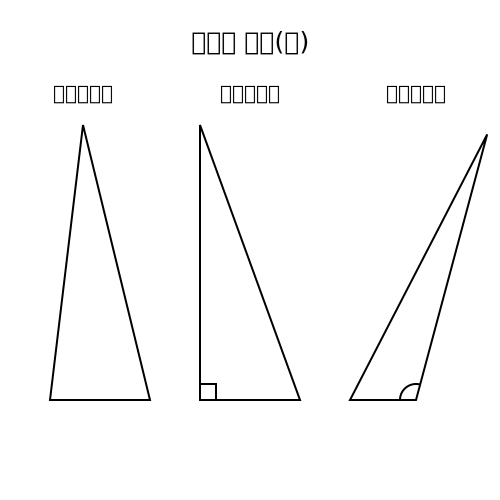

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


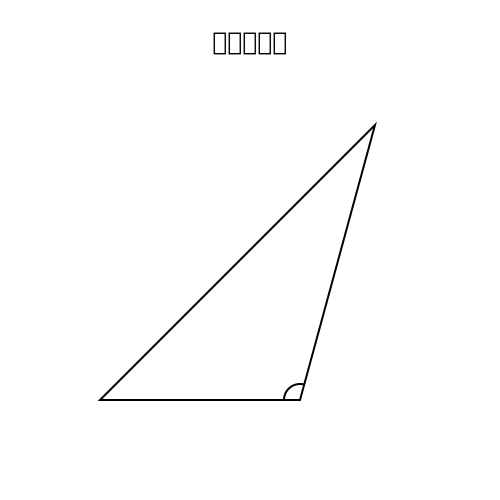

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

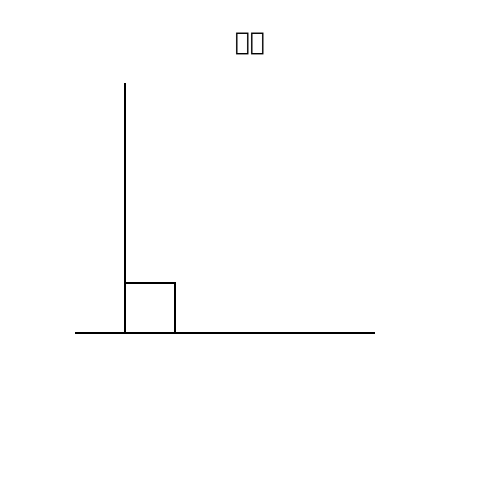

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

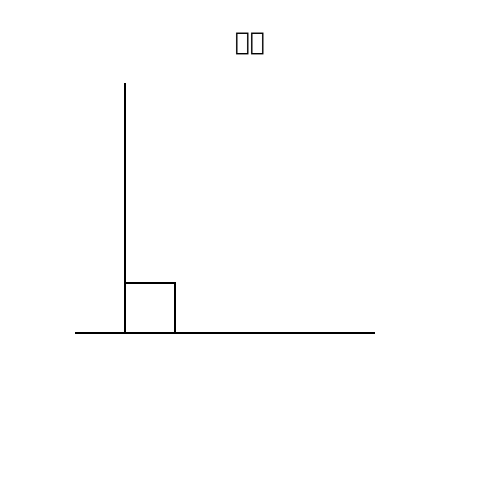

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

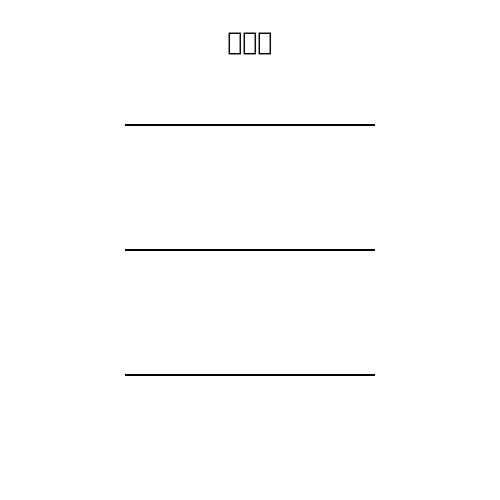

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

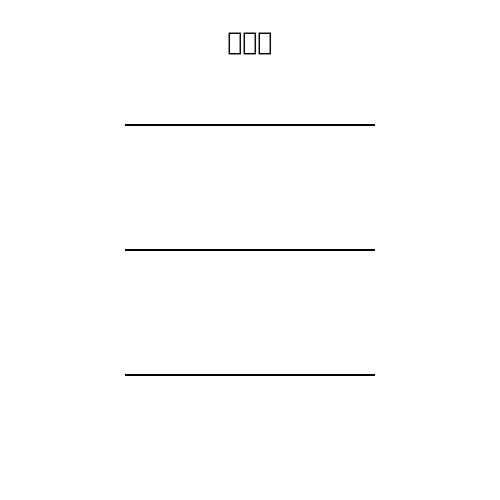

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


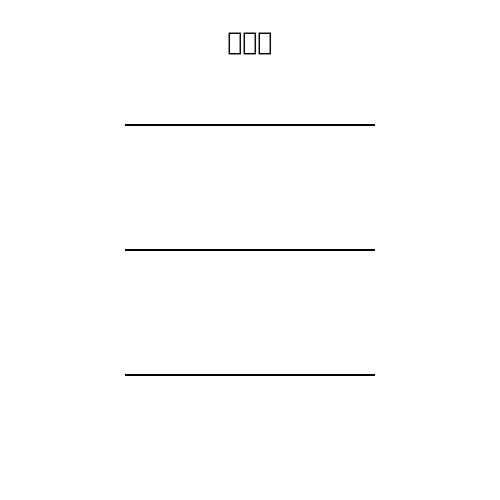

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

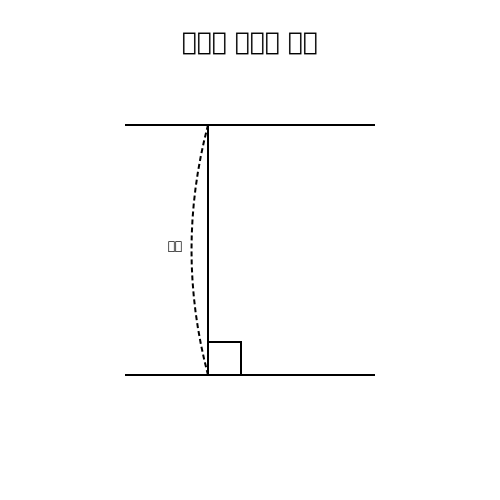

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

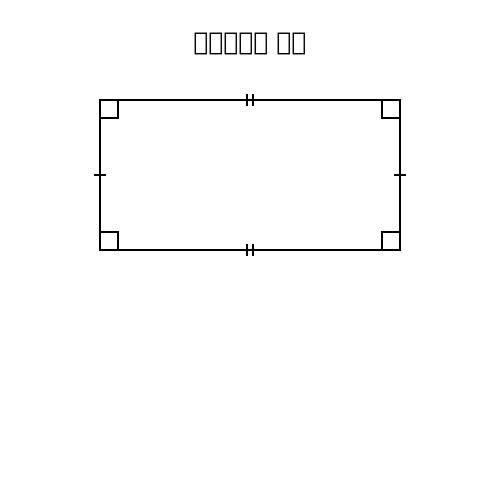

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

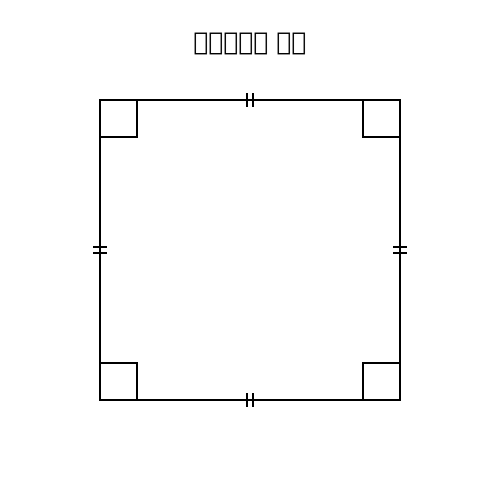

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

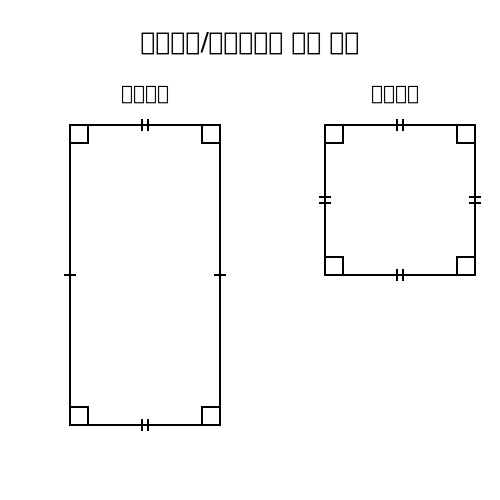

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


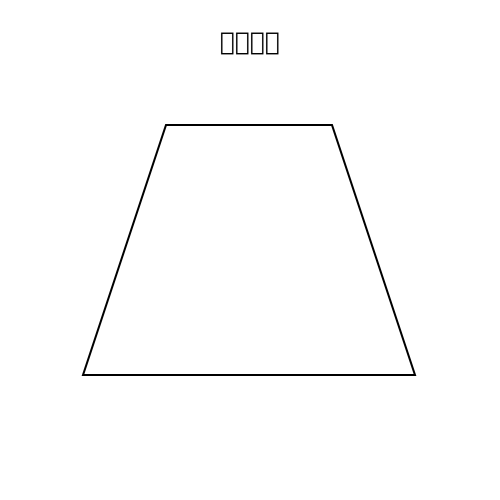

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

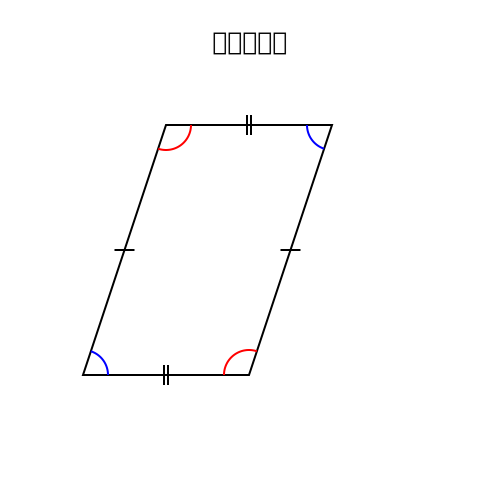

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

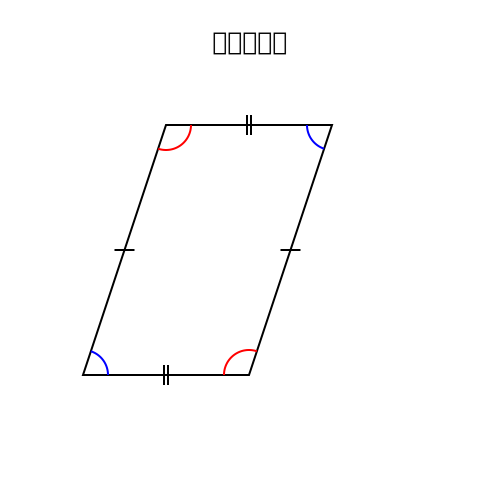

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

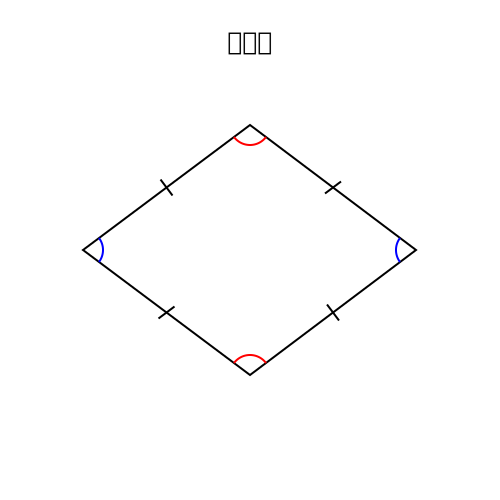

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

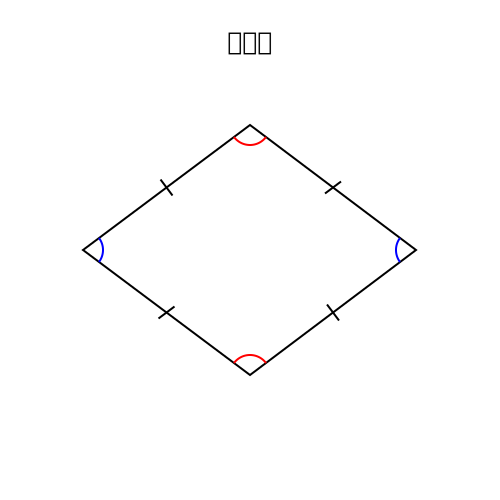

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

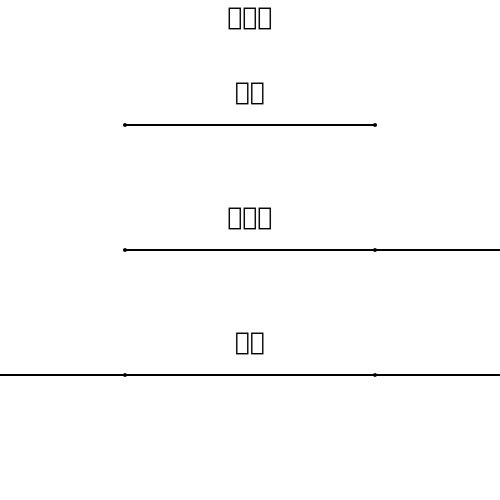

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="3.798061746948008" y2="289.58795558326744" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.7596123493896,324.3175911166535 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="255.44723392172864" y="270.7378313692659" font-size="12" text-anchor="middle">170°</text>
        </svg>
        


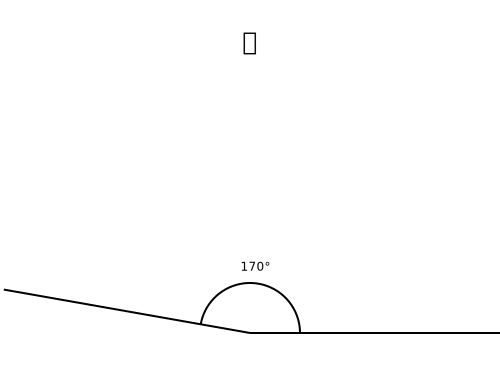

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

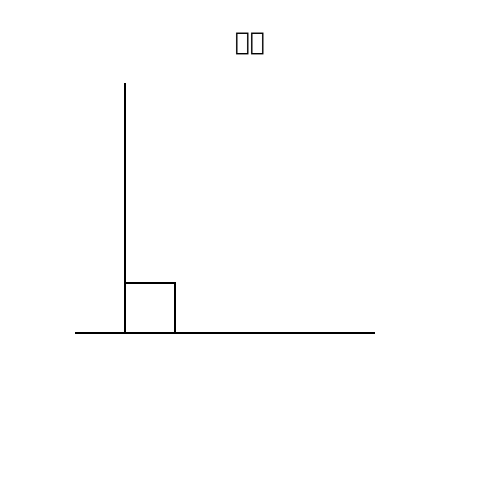

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


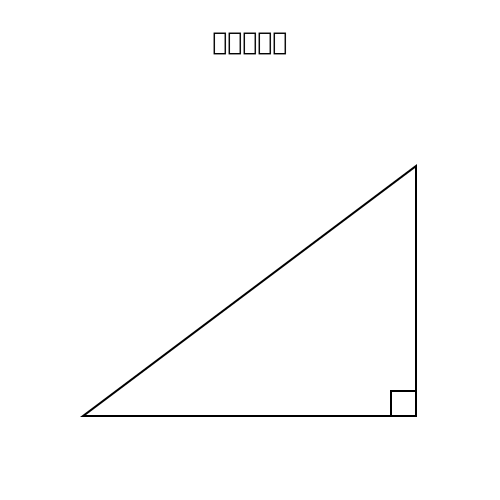

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


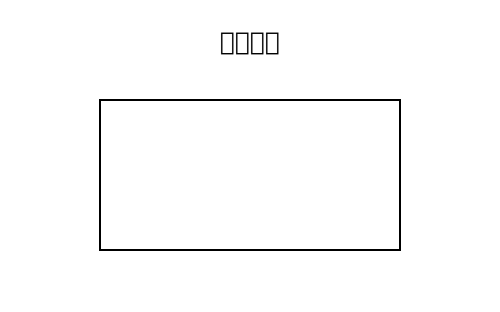

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


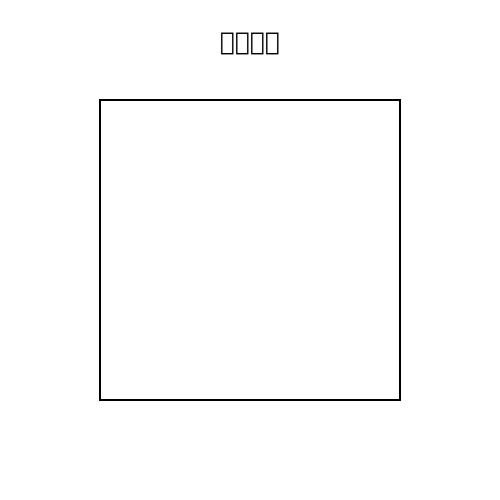

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


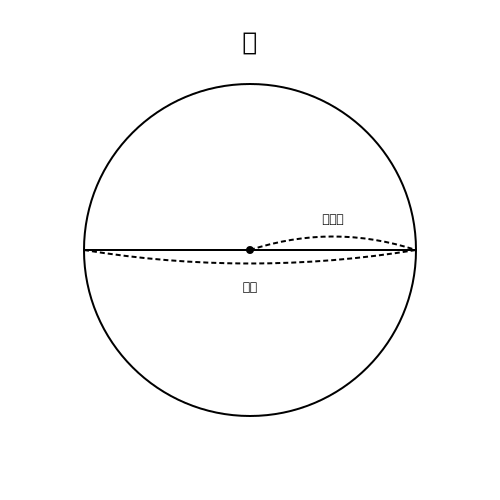

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


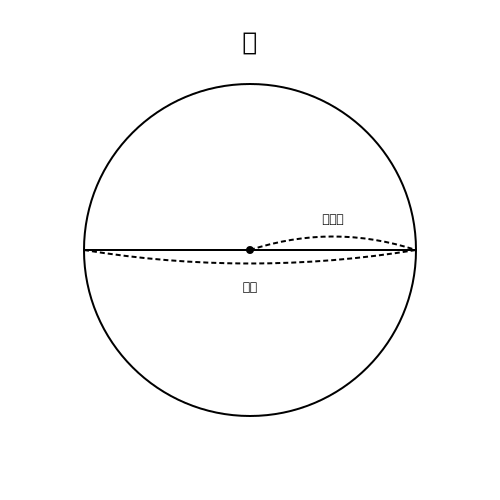

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

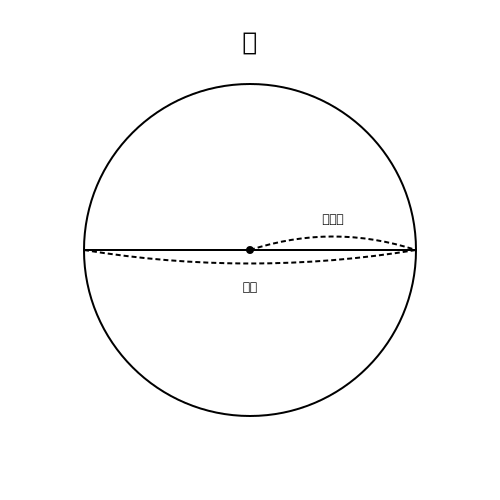

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

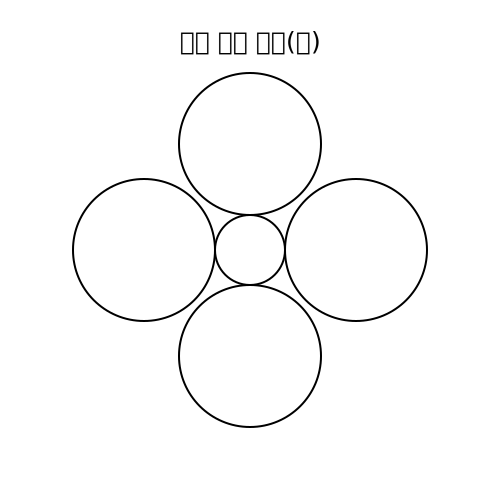

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="349.6985115747917" y2="223.40721330273067" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 169.93970231495837,311.08144266054614 A 50,50 0 0,1 175,333" stroke

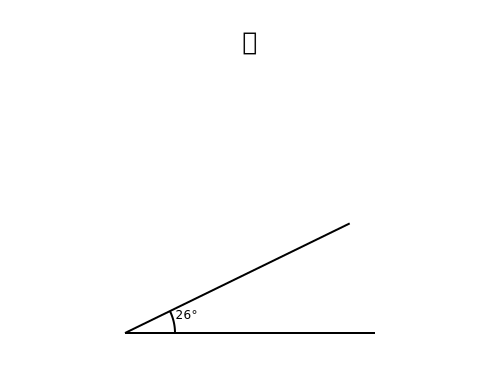

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="125.00000000000006" y2="116.49364905389032" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 225.0,289.69872981077805 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <

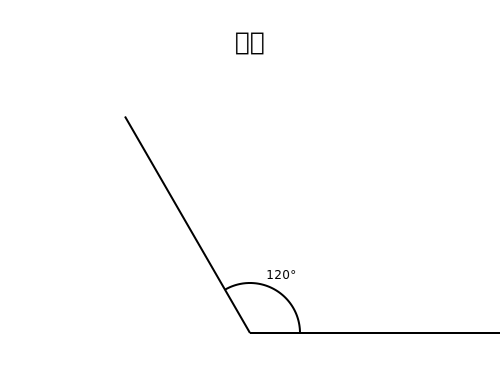

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="168.4120444167326" y2="86.79806174694801" stroke="black" stroke-

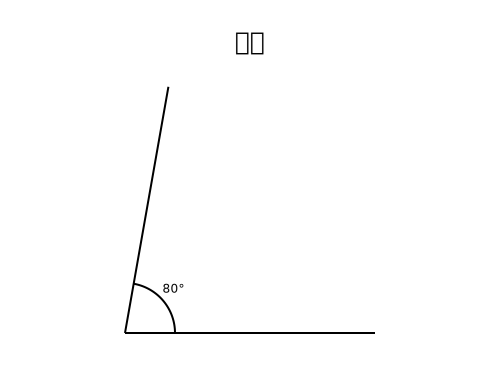

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="160.40801261367494" y2="99.60489337569956" stroke="black" stroke-width="2" />


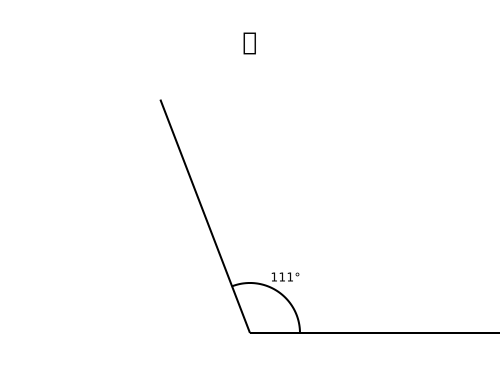

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="273.14591258776403" y2="135.62024063624324" stroke="black" stroke-widt

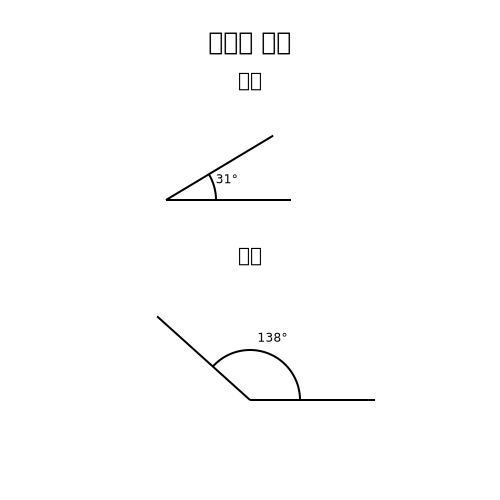

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="133.72487417562527" y2="83.15229324522605" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 126.74497483512505,283.03

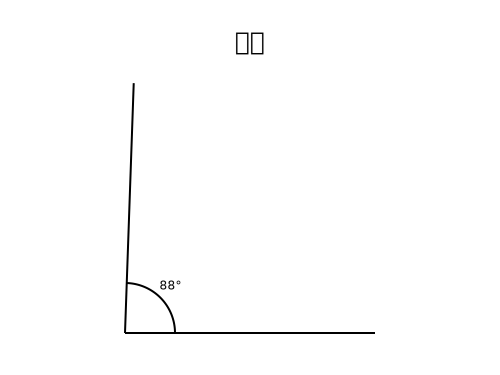

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

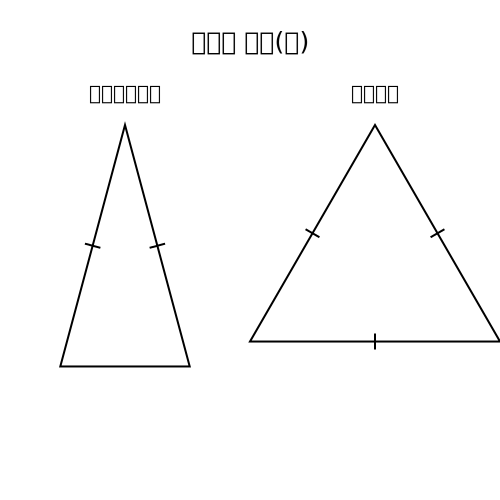

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

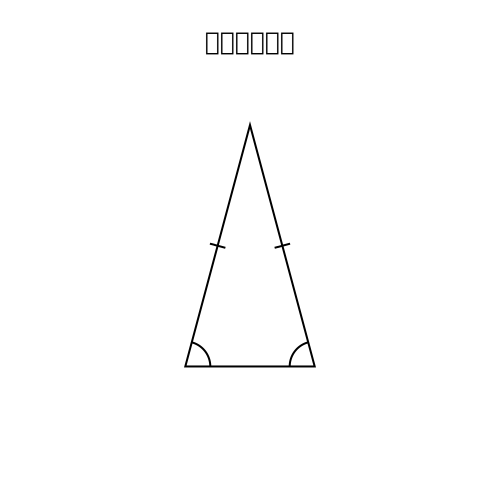

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

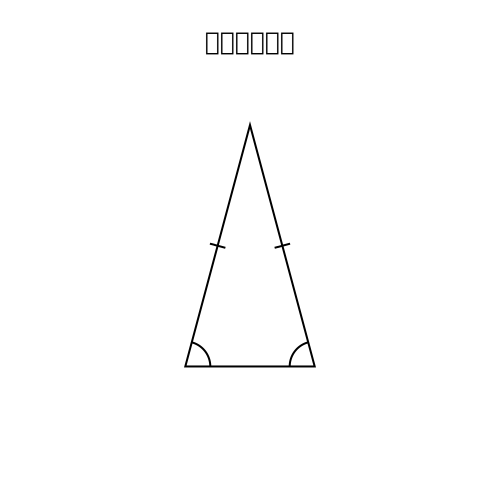

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

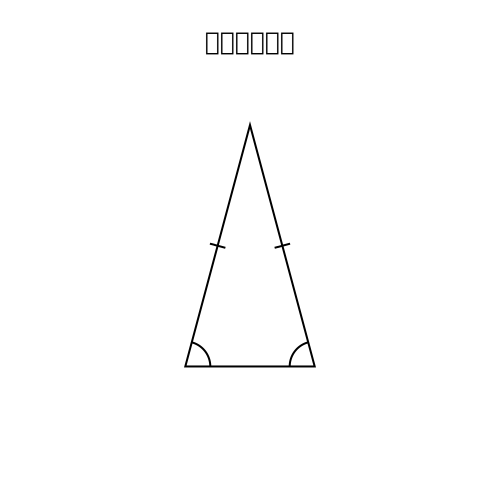

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

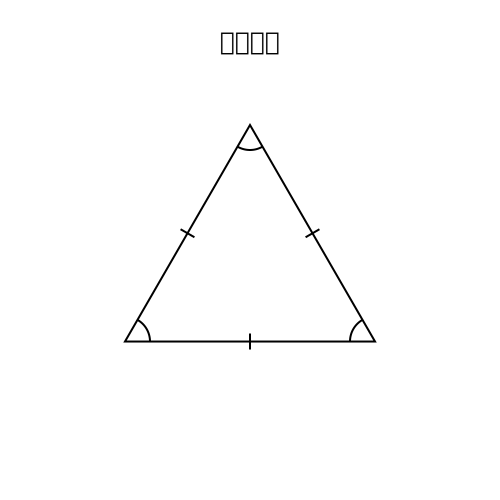

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

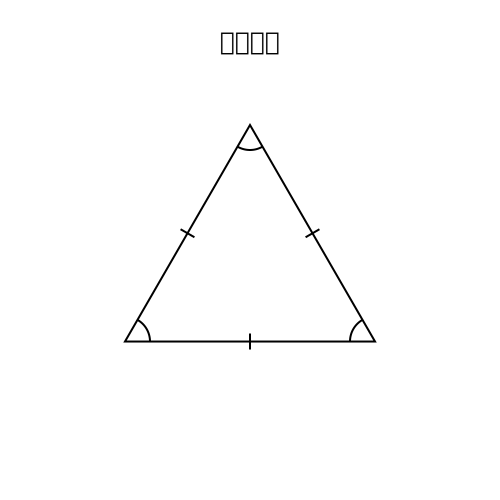

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

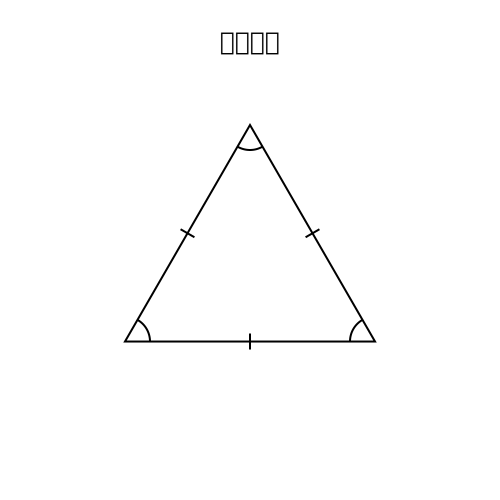

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


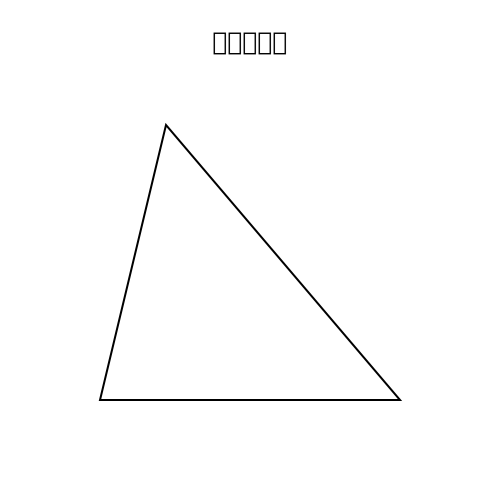

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

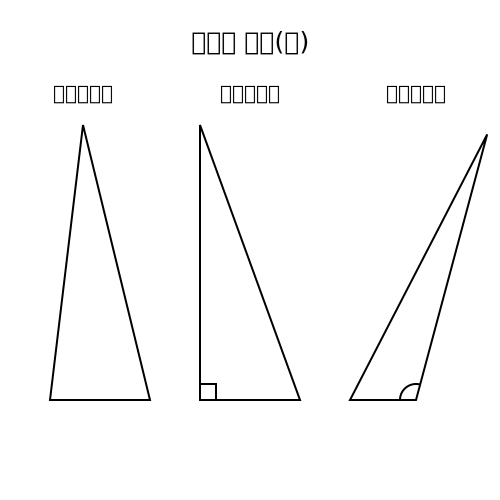

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


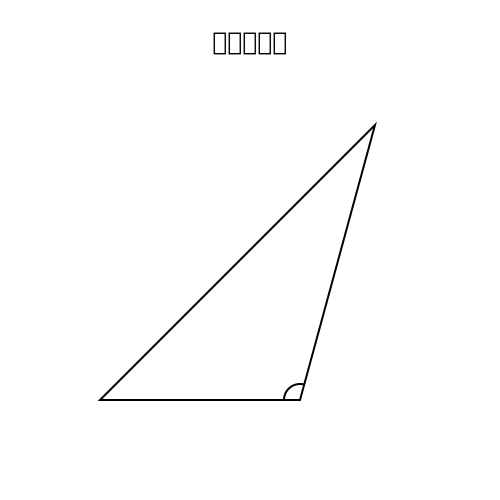

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

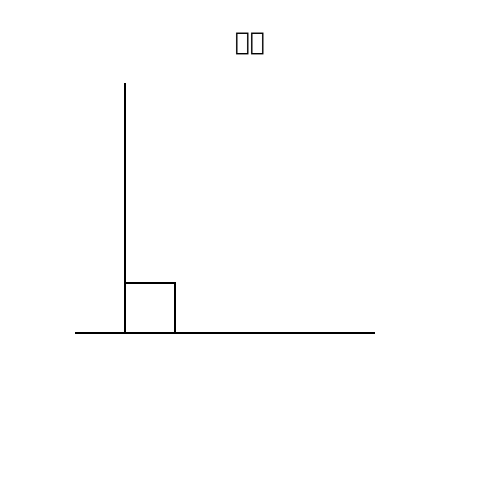

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

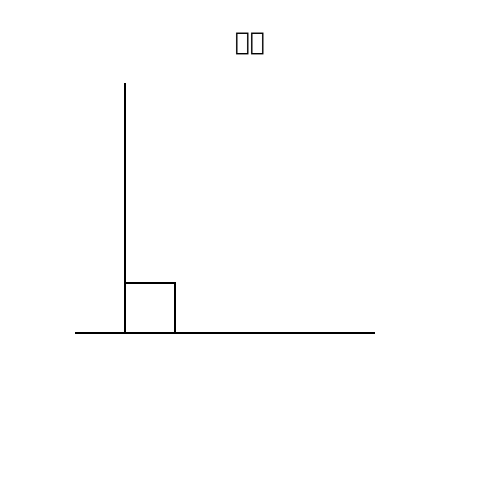

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

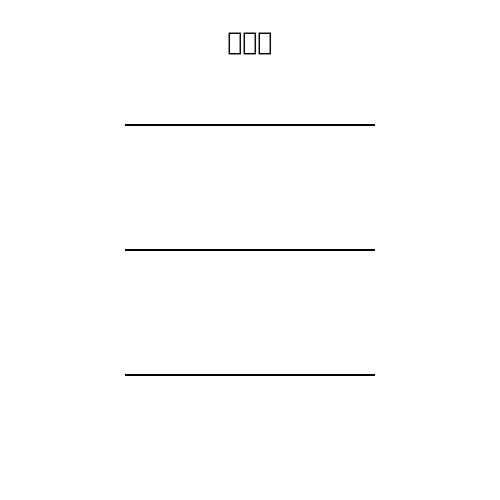

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

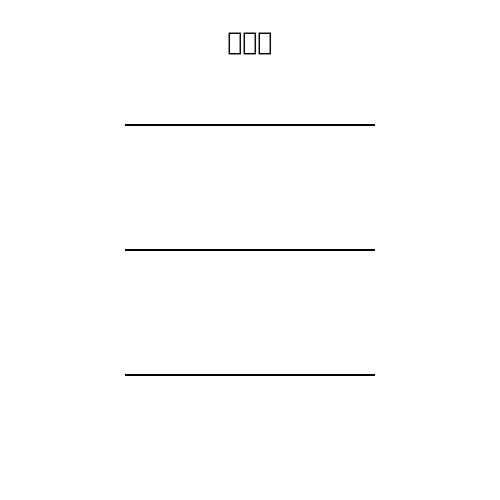

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


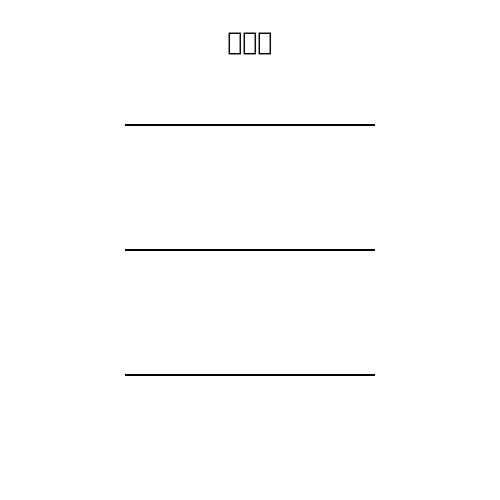

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

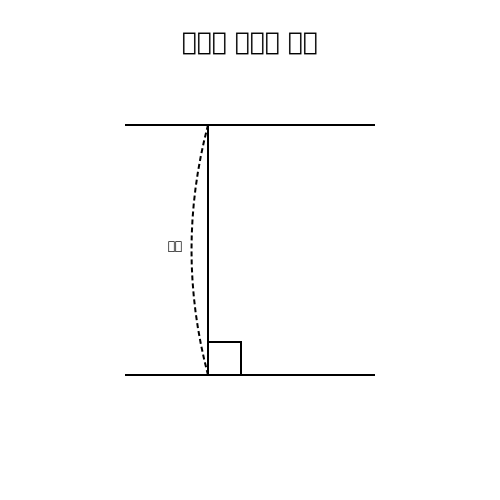

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

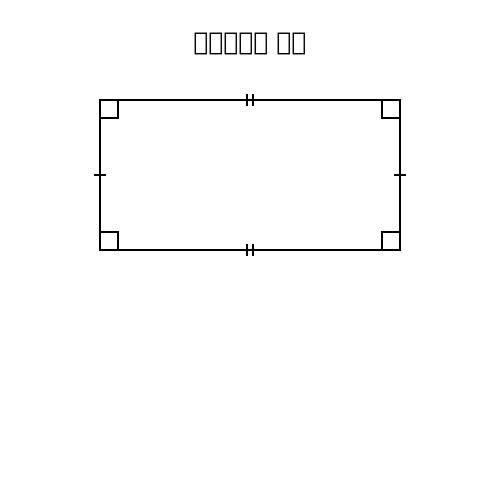

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

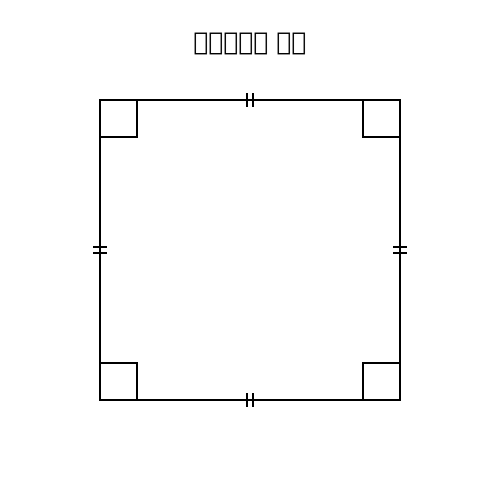

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

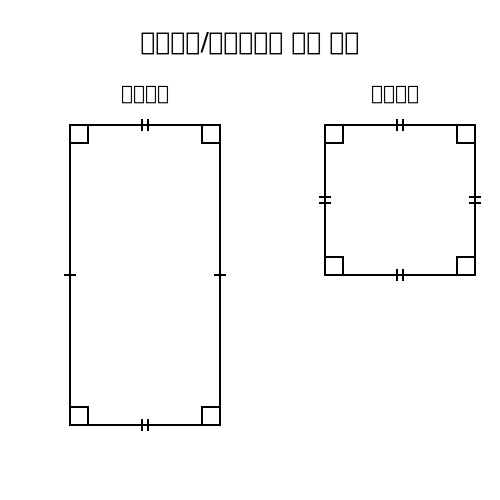

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


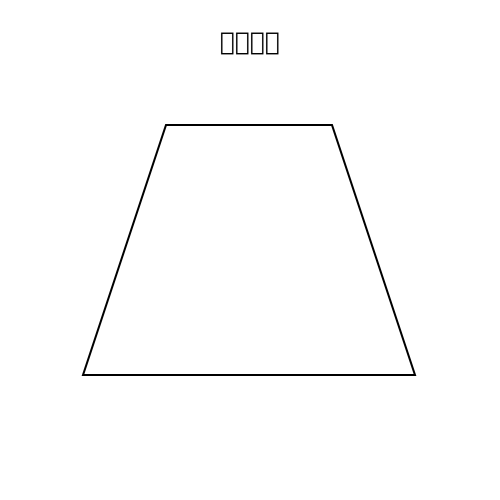

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

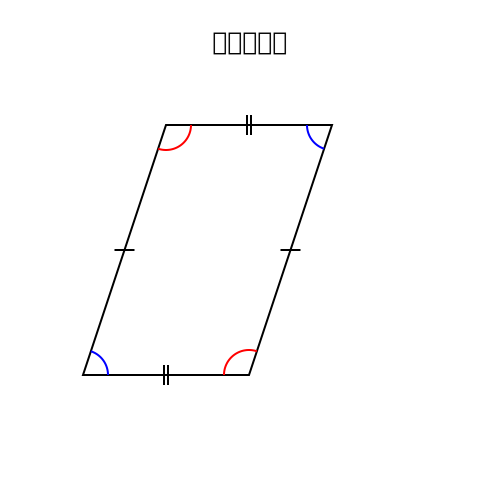

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

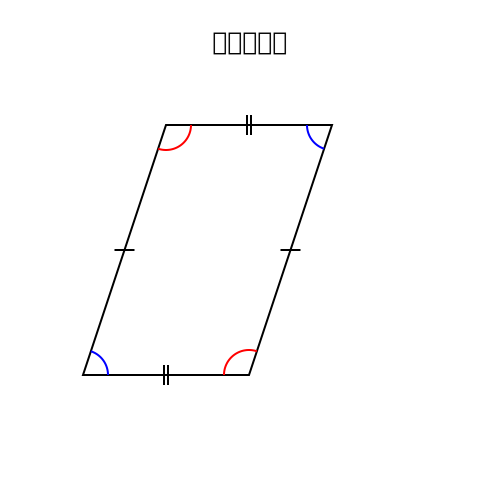

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

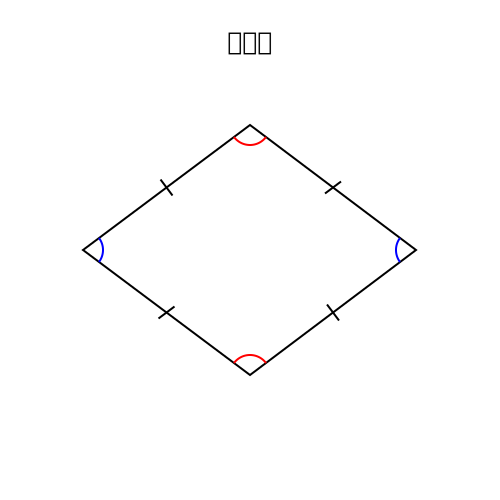

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

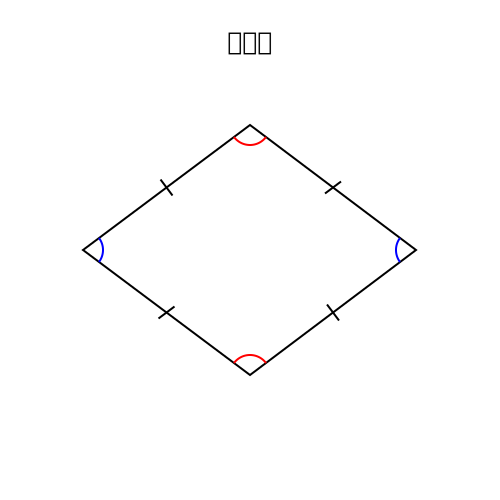

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

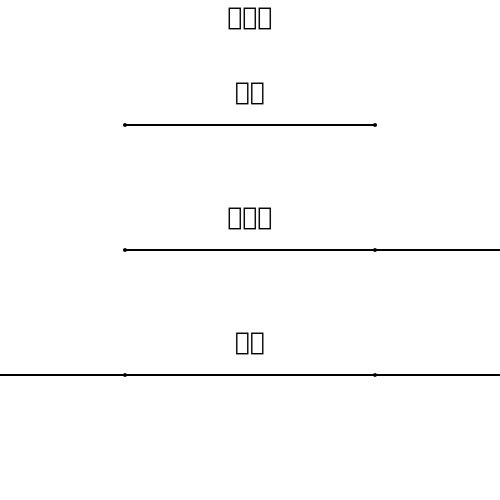

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="371.201938253052" y2="289.58795558326744" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.2403876506104,324.3175911166535 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="187.2621686307341" y="327.55276607827136" font-size="12" text-anchor="middle">10°</text>
        </svg>
        


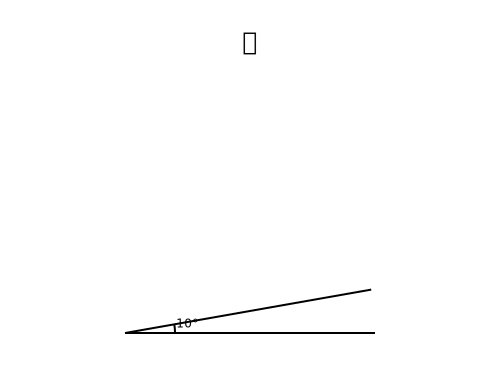

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

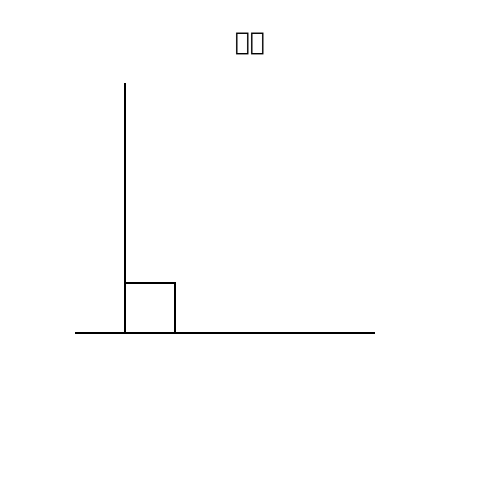

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


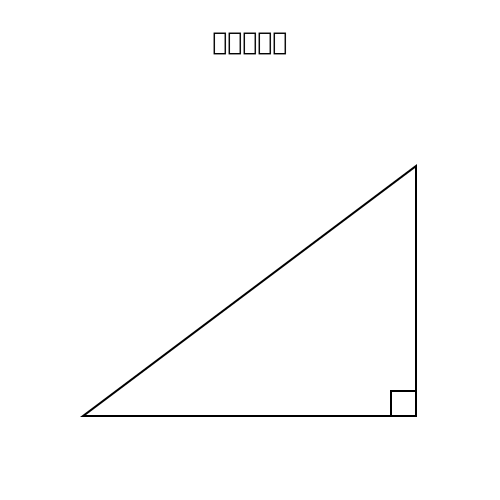

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


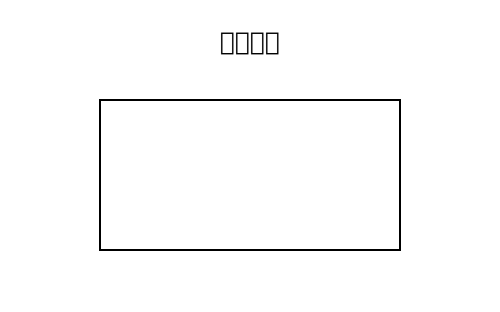

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


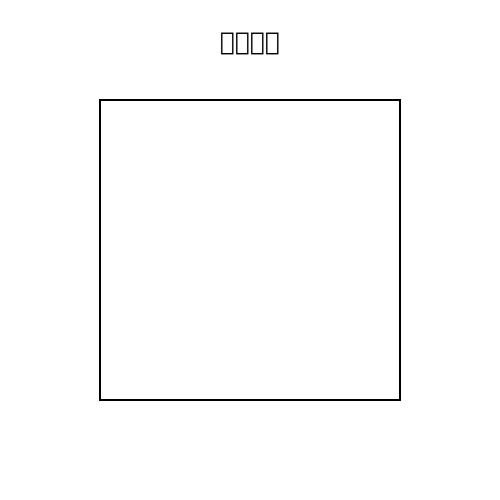

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


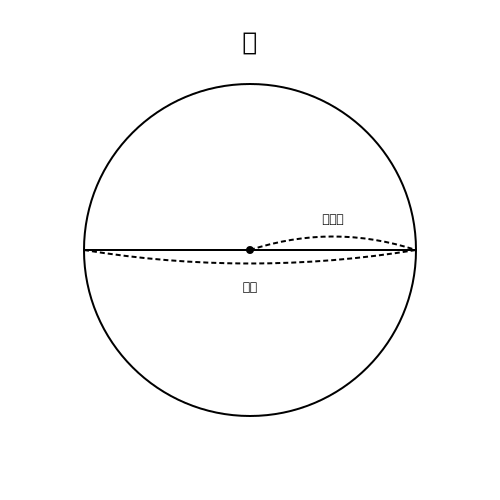

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


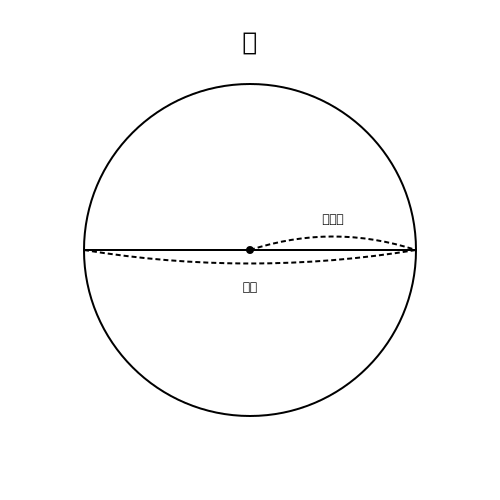

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

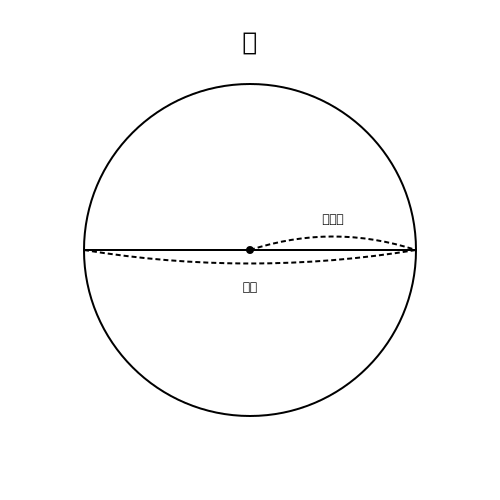

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

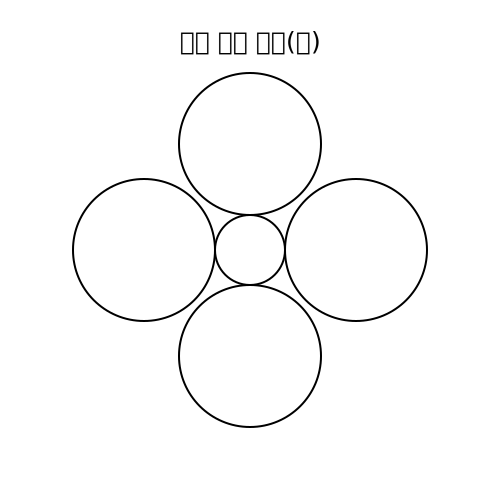

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="0.3426163113565508" y2="319.916010939264" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.0685232622713,330.3832021878528 A 50,50 0 0,1 300,333" stroke="b

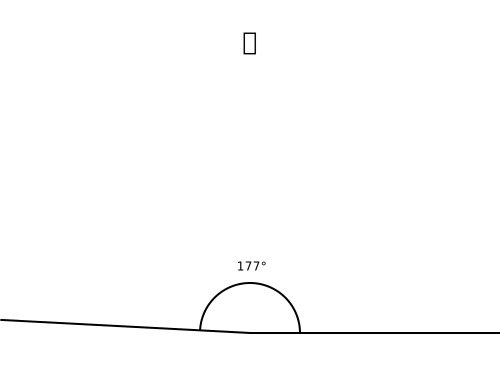

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="285.69690242163483" y2="141.4888892202555" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 157.13938048432698,294.6977778440511 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/

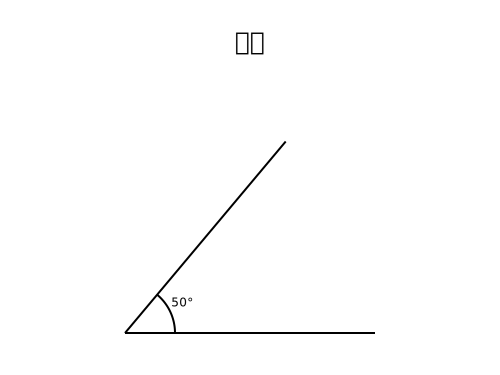

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="367.5739315689991" y2="272.51952610008306" stroke="black" stroke

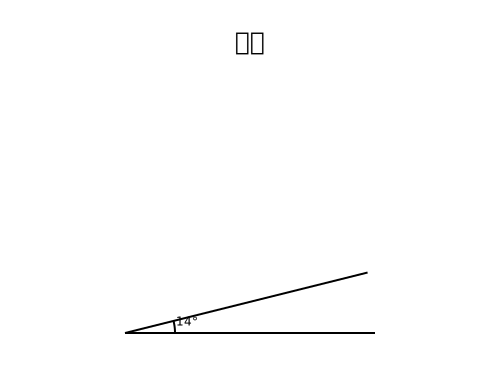

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="121.24048127248642" y2="118.70817482447191" stroke="black" stroke-width="2" />

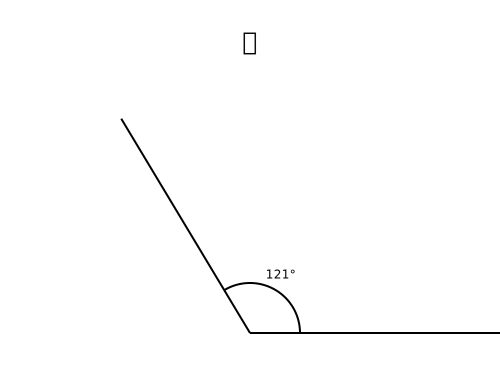

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="265.8294387559116" y2="124.77312210599396" stroke="black" stroke-width

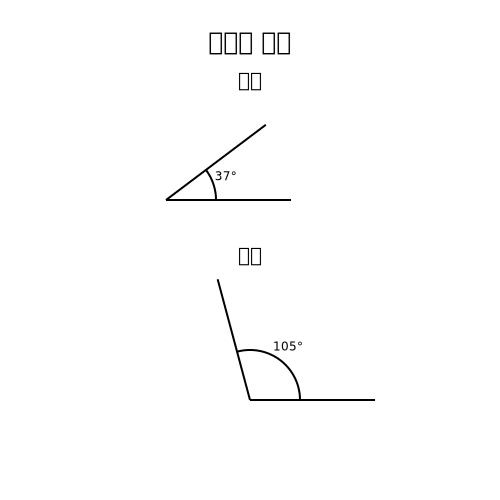

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="351.5769467591625" y2="227.34543456482515" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 170.3153893518325,311.869

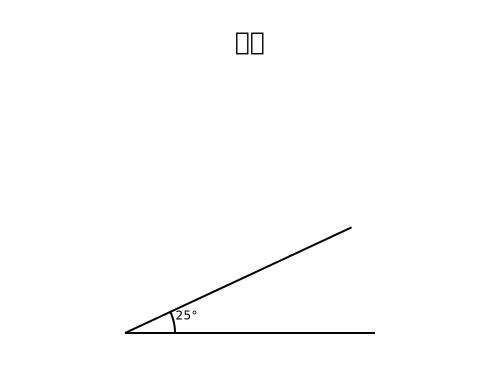

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

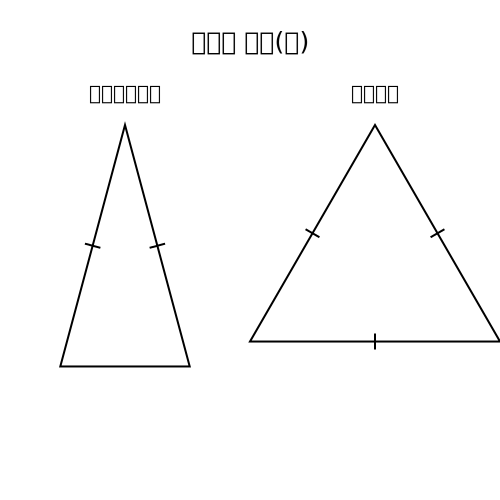

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

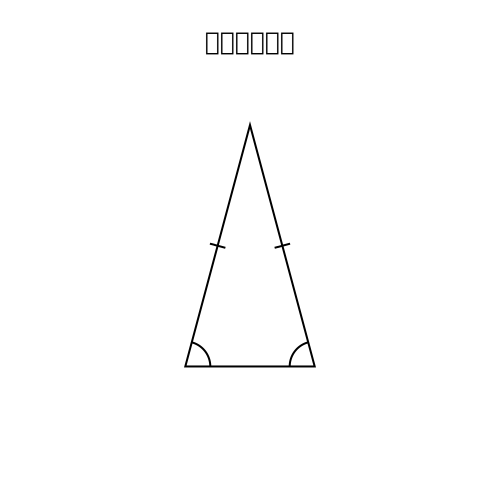

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

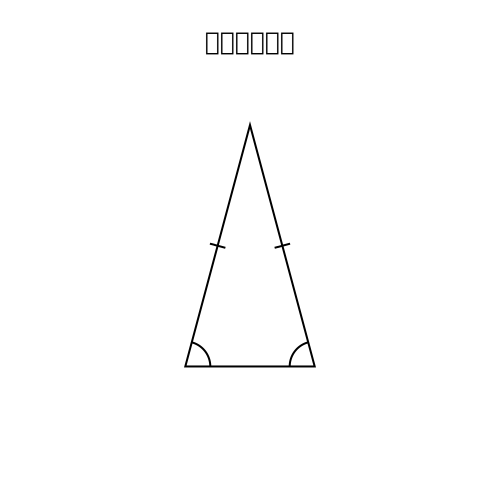

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

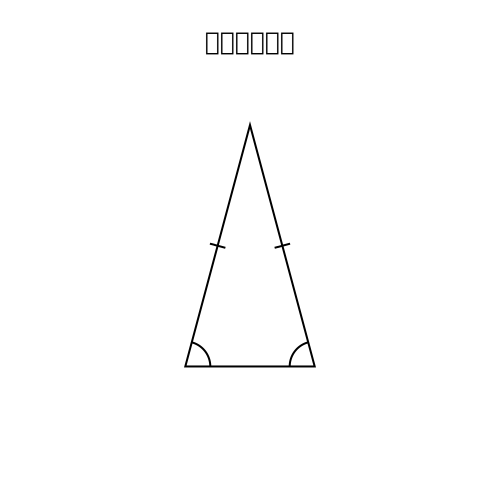

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

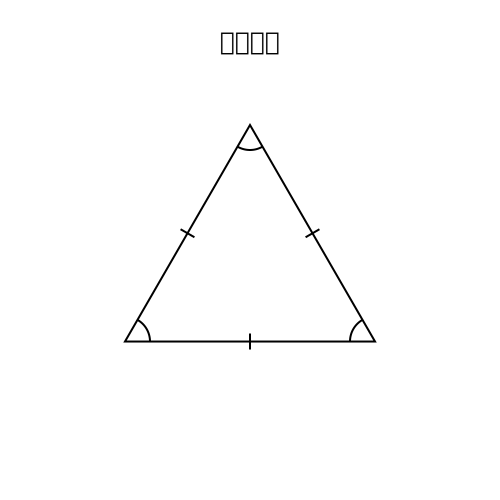

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

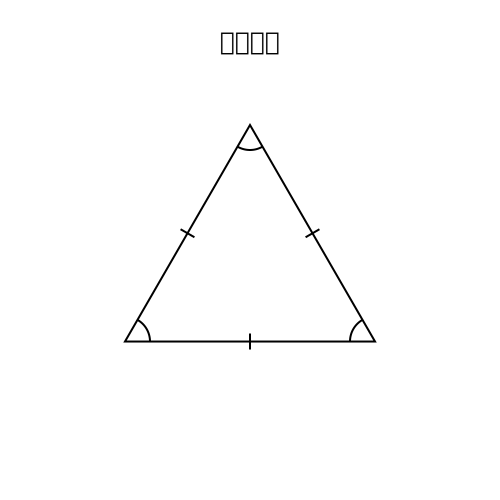

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

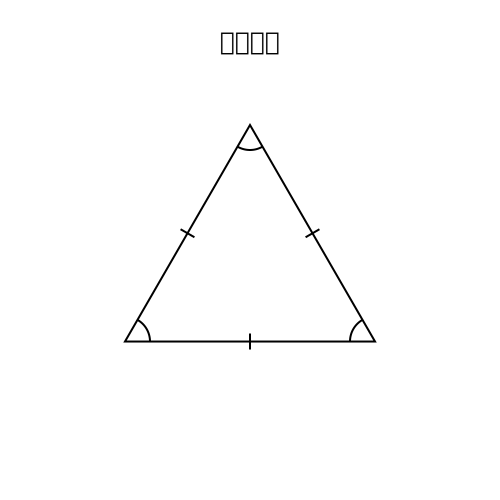

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


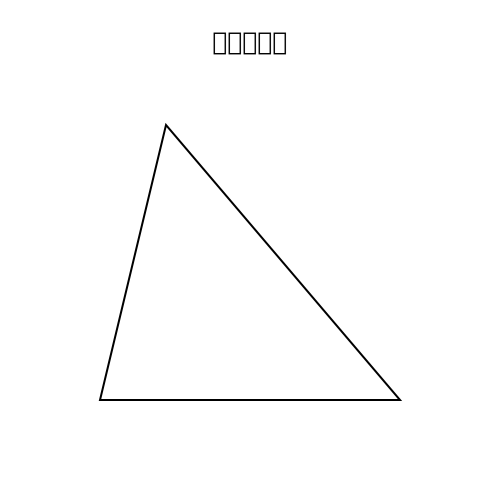

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

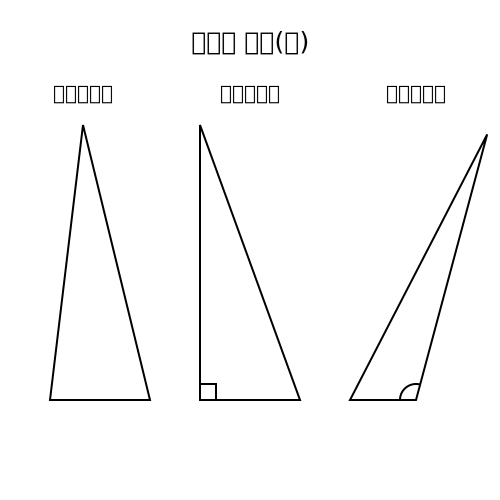

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


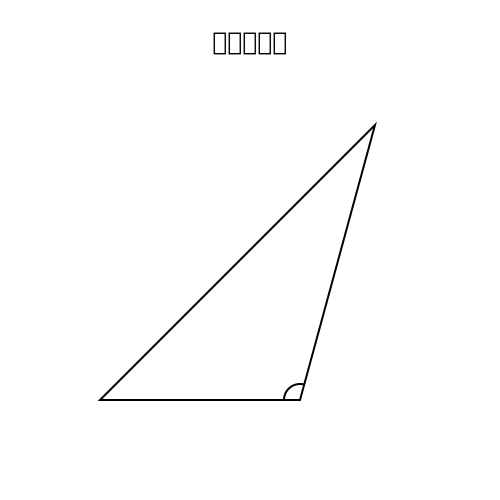

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

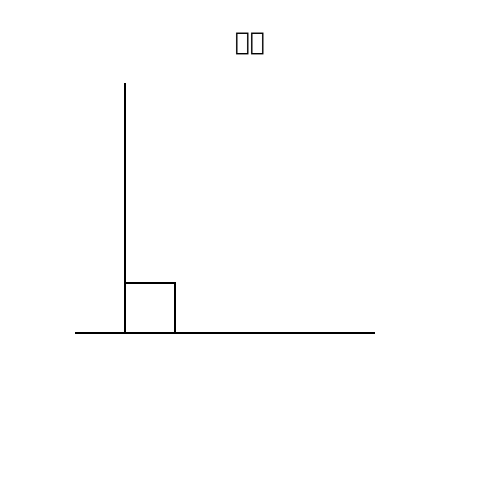

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

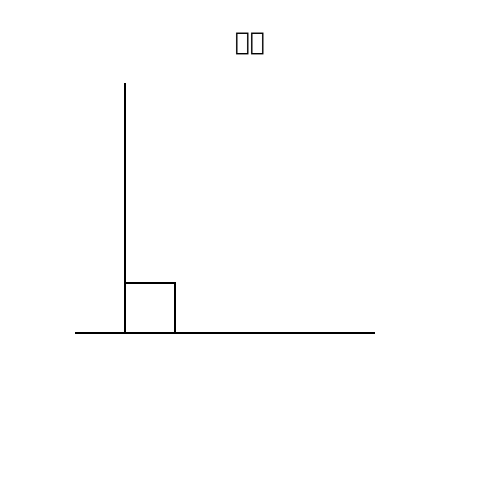

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

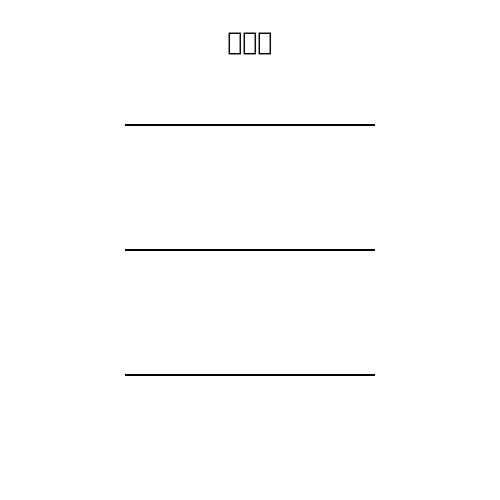

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

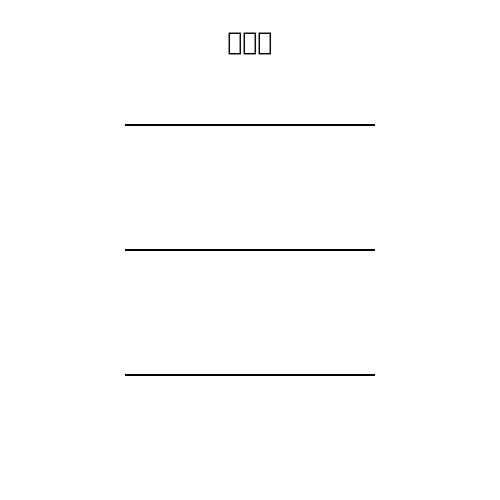

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


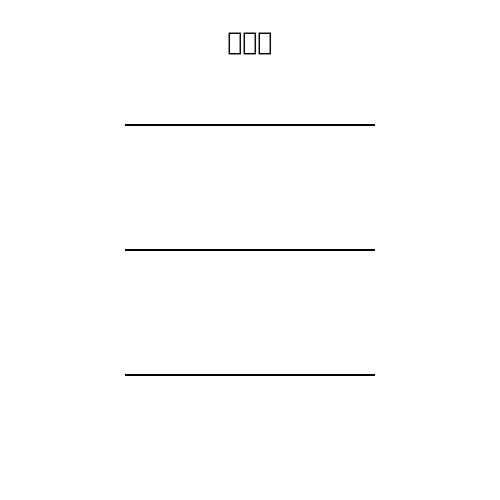

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

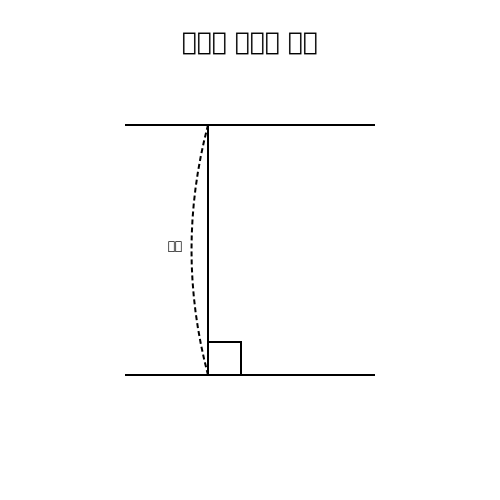

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

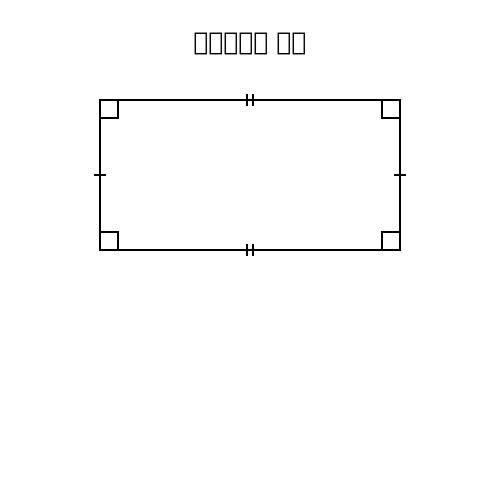

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

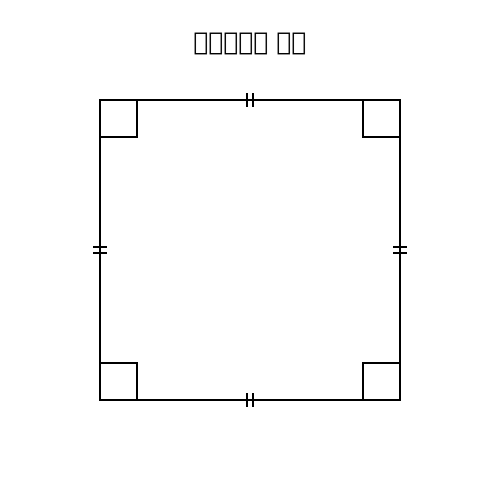

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

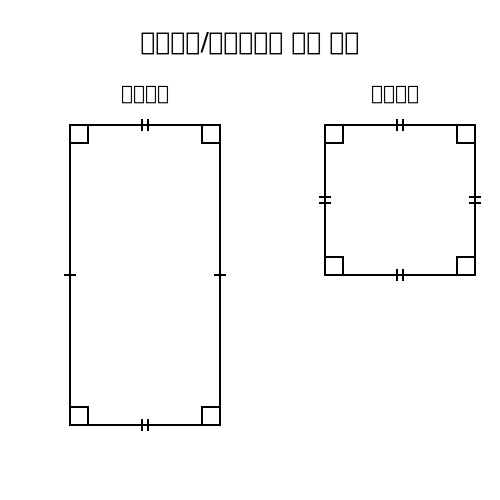

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


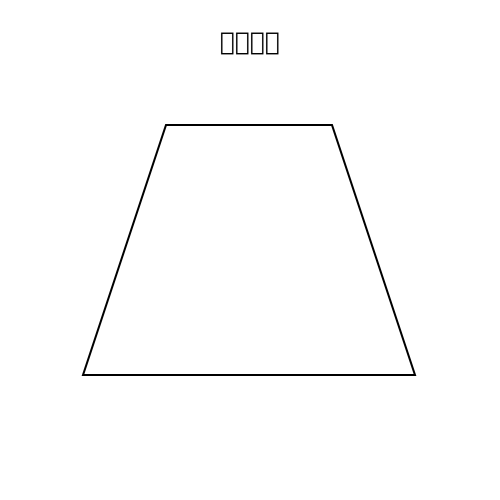

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

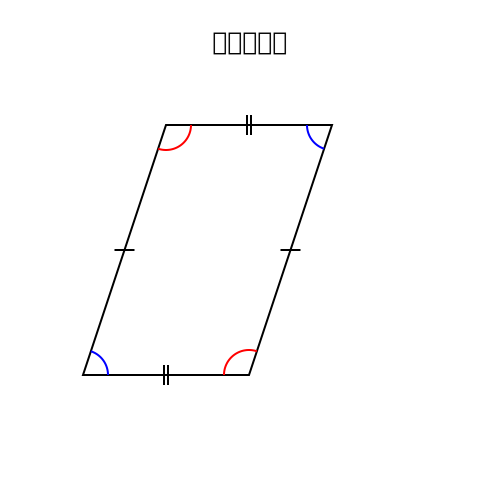

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

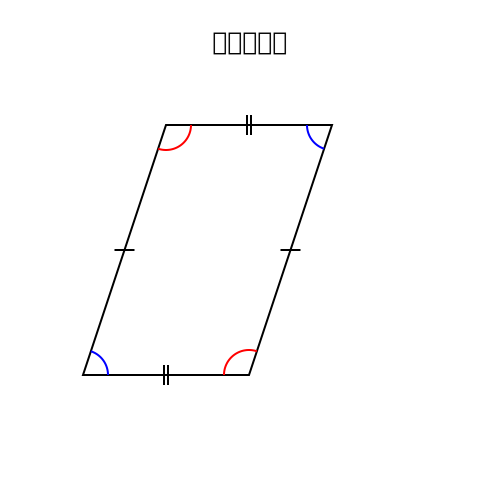

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

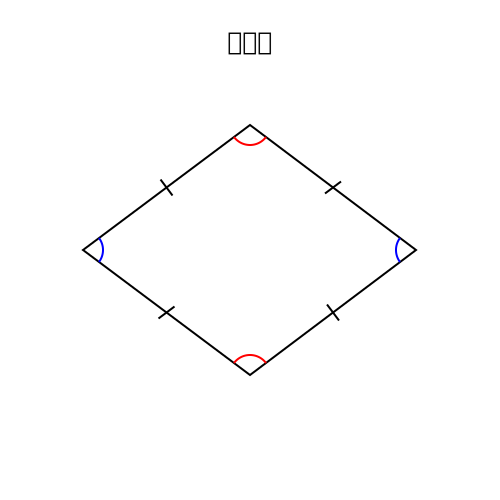

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

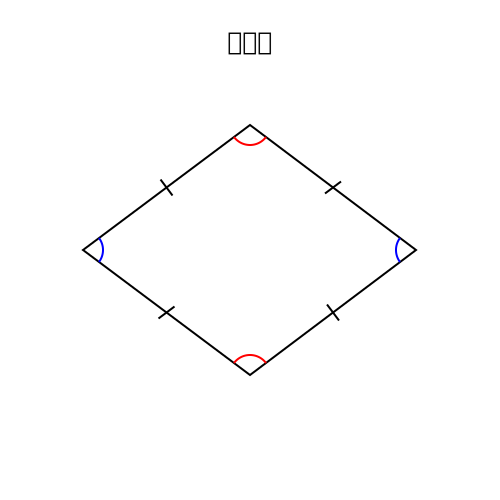

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

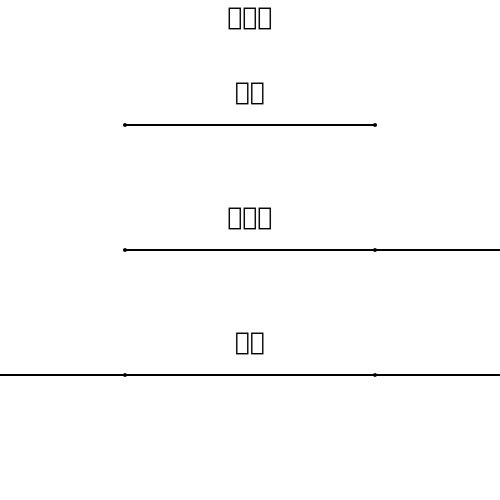

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="148.31583923104995" y2="104.61363558934977" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 229.66316784621,287.32272711786993 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="284.0399396884392" y="280.583089503411" font-size="12" text-anchor="middle">114°</text>
        </svg>
        


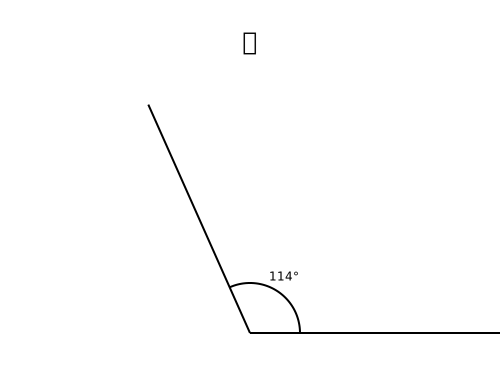

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

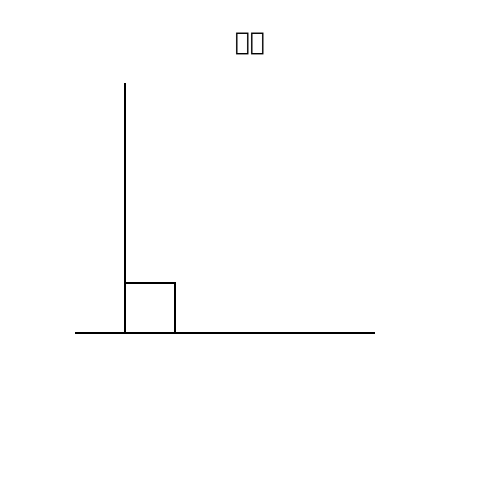

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


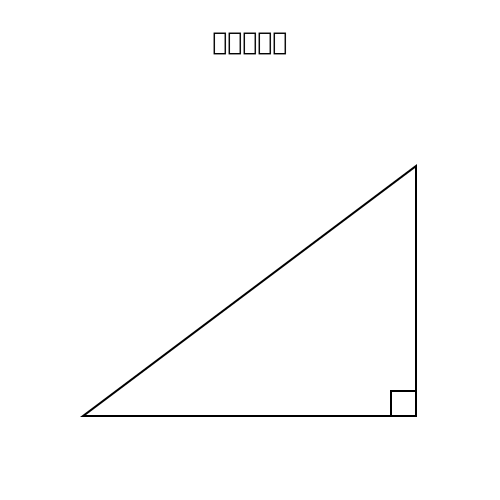

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


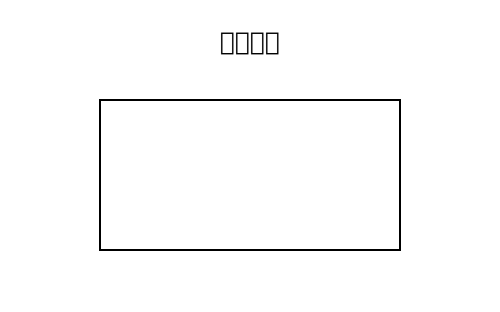

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


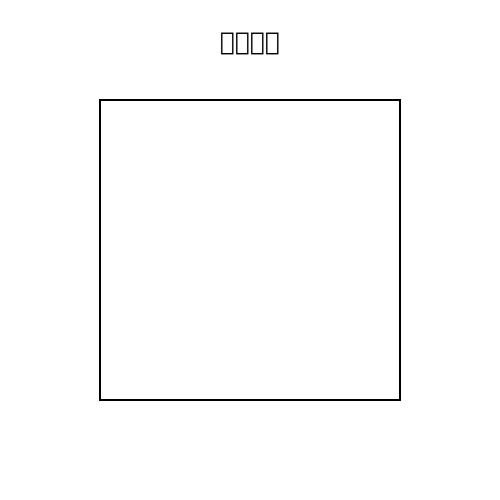

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


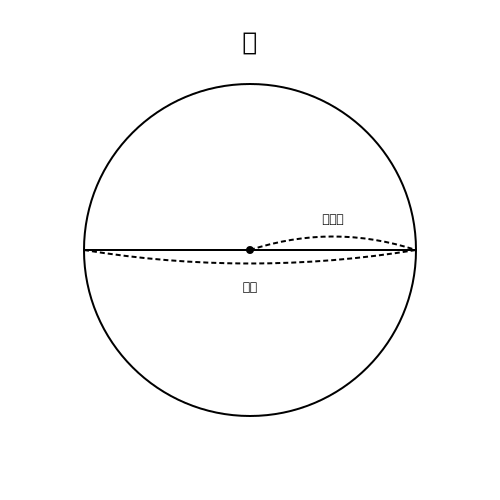

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


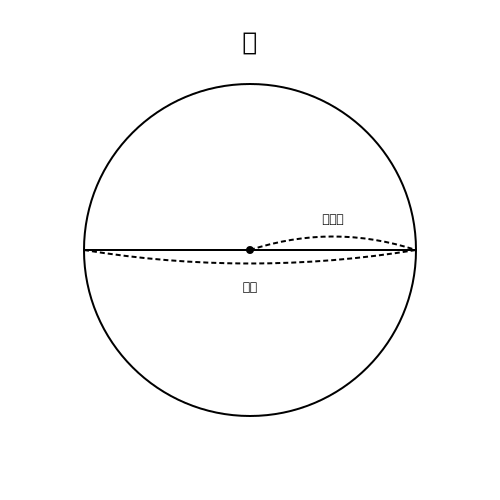

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

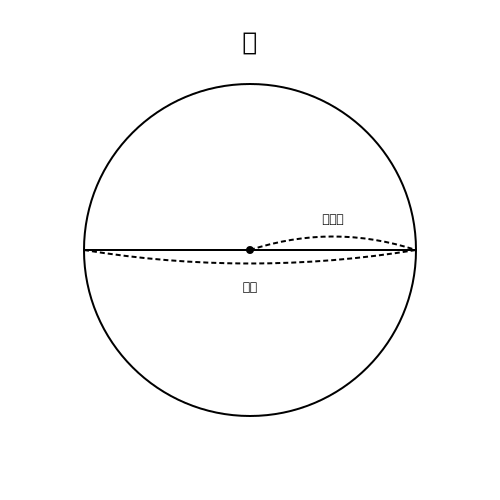

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

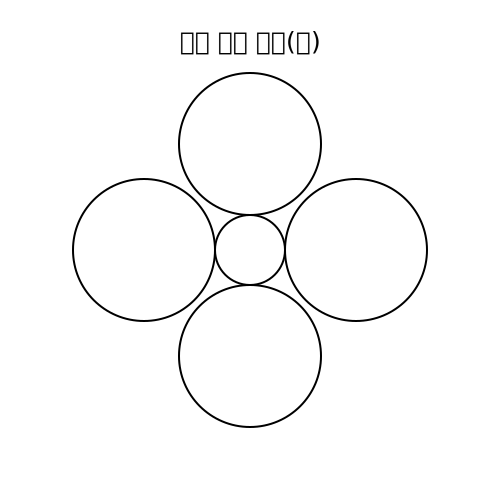

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="8.518543427732936" y2="268.2952387243697" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 201.7037086855466,320.05904774487396 A 50,50 0 0,1 300,333" stroke="

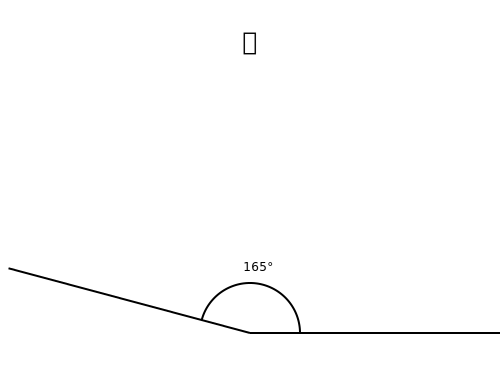

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="23.423053240837504" y2="227.34543456482513" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 204.6846106481675,311.86908691296503 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"

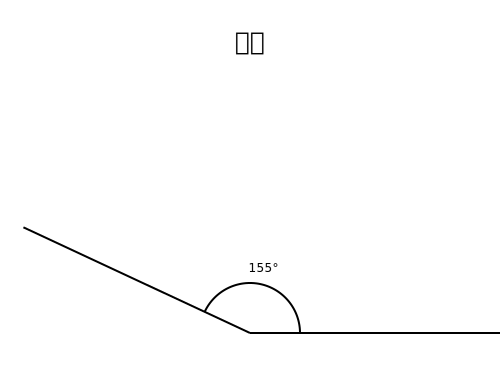

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="218.65164835397798" y2="101.20403635830314" stroke="black" strok

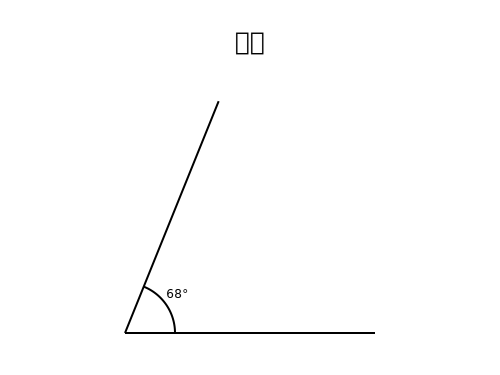

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="264.7982258676867" y2="125.74060686123957" stroke="black" stroke-width="2" />


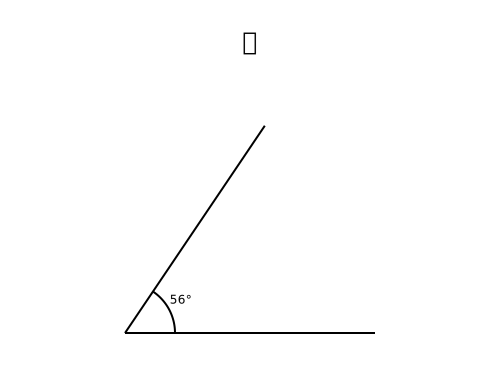

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="181.23366792564343" y2="75.93173104483475" stroke="black" stroke-width

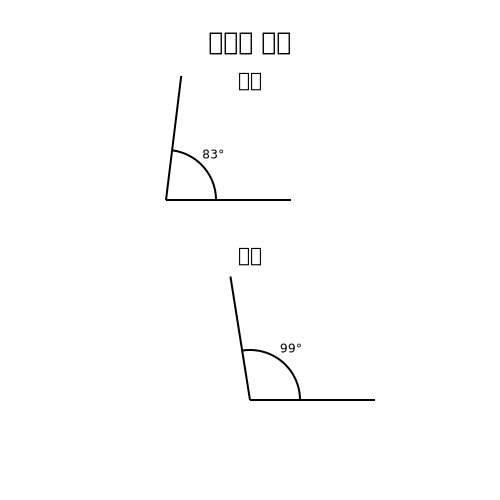

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="362.76412907378835" y2="255.74575140626314" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 172.55282581475768,317.5

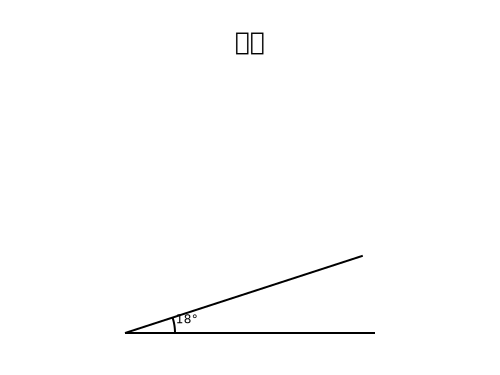

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

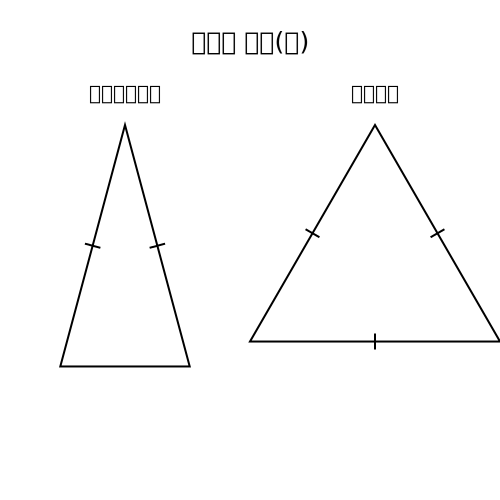

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

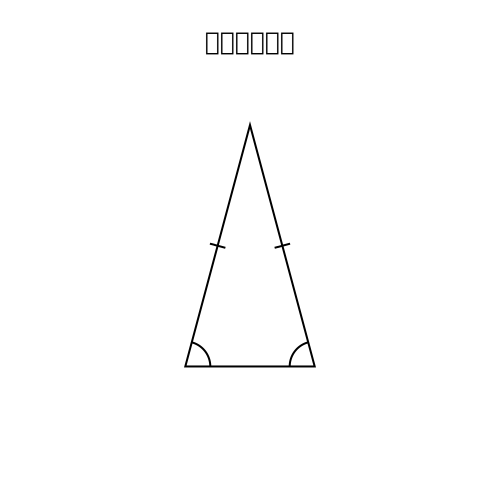

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

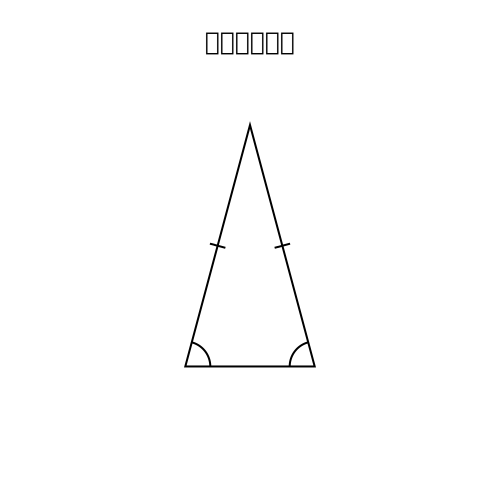

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

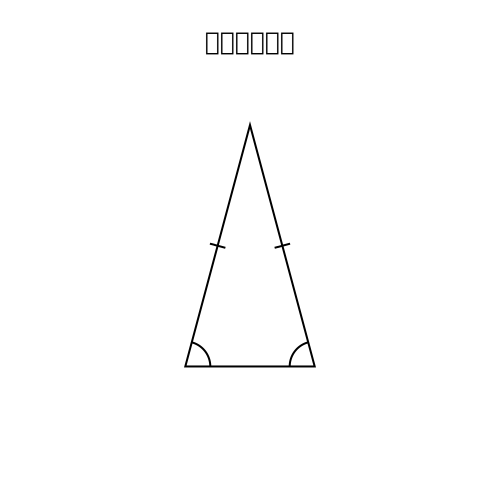

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

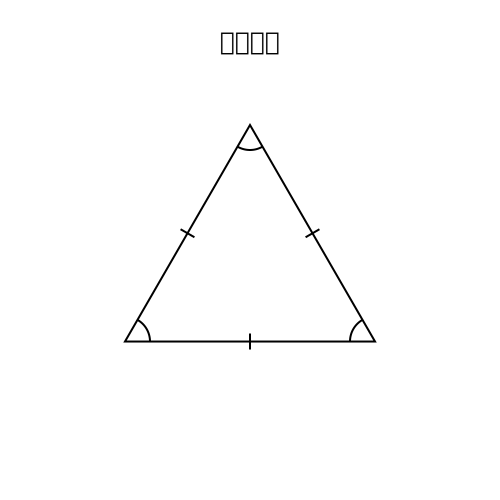

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

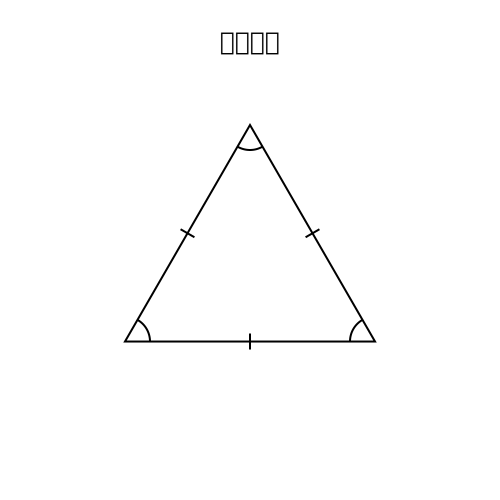

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

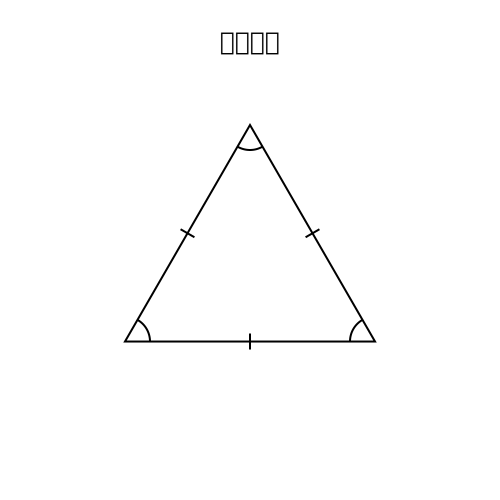

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


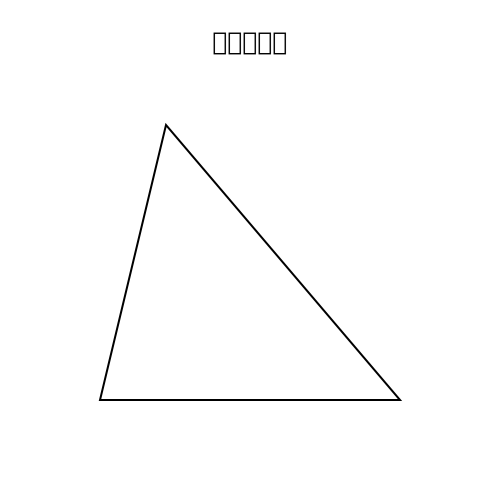

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

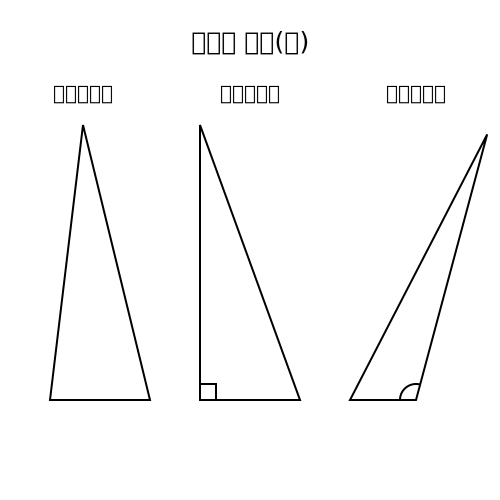

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


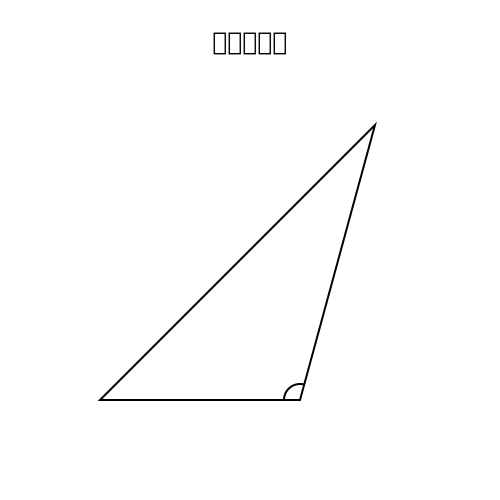

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

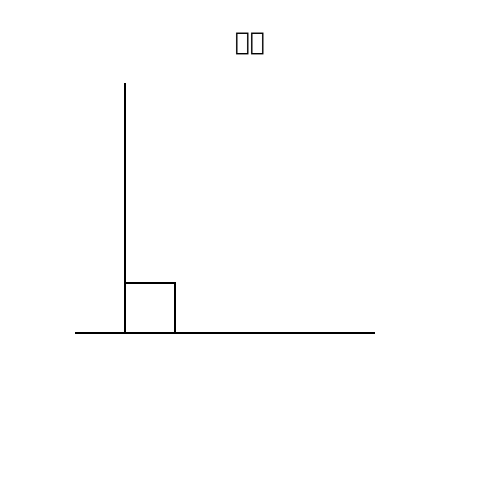

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

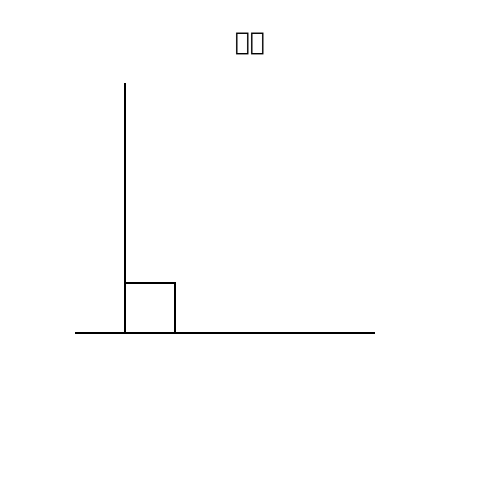

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

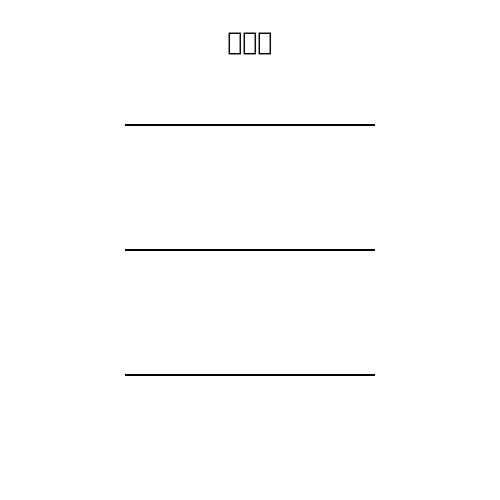

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

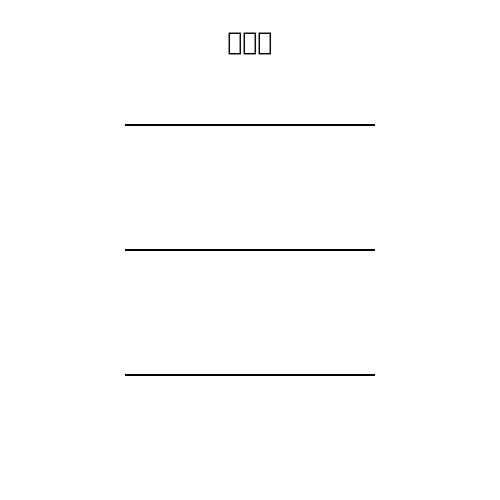

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


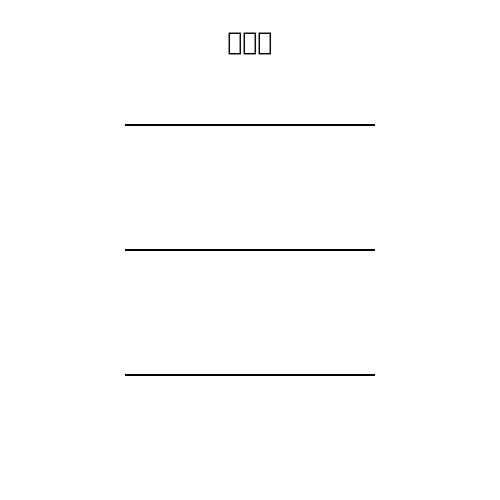

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

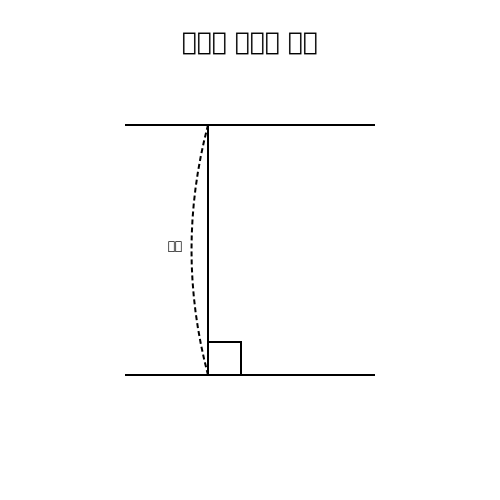

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

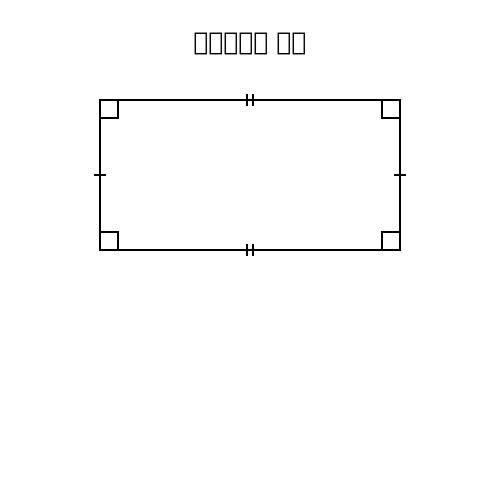

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

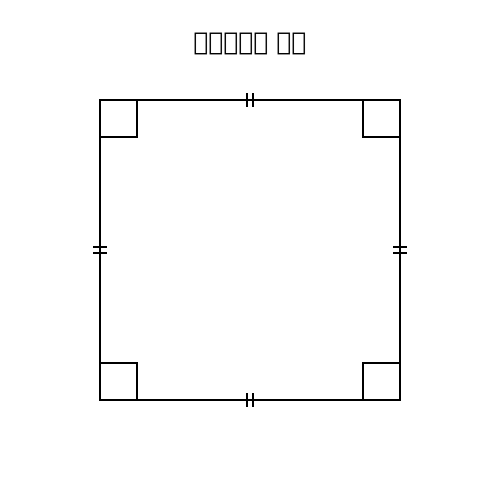

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

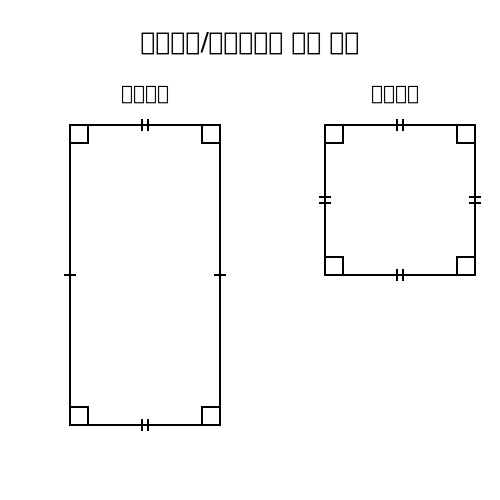

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


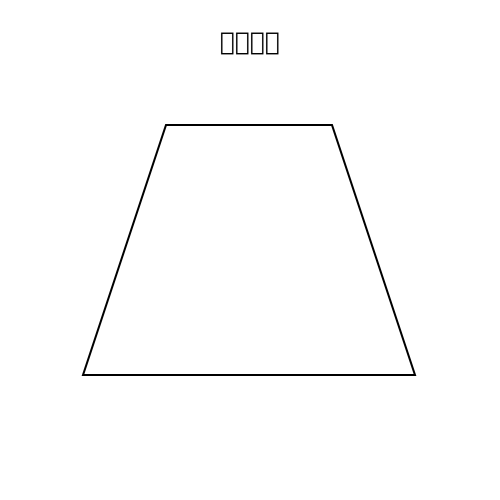

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

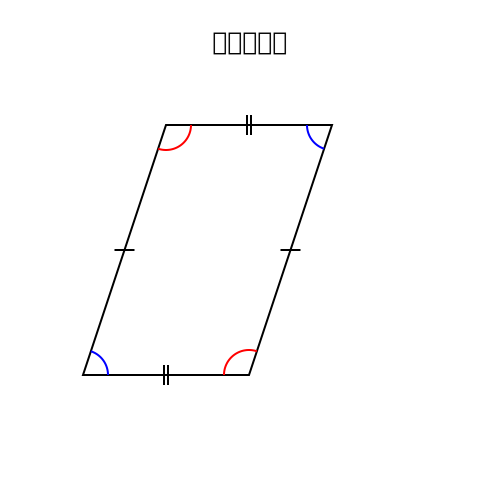

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

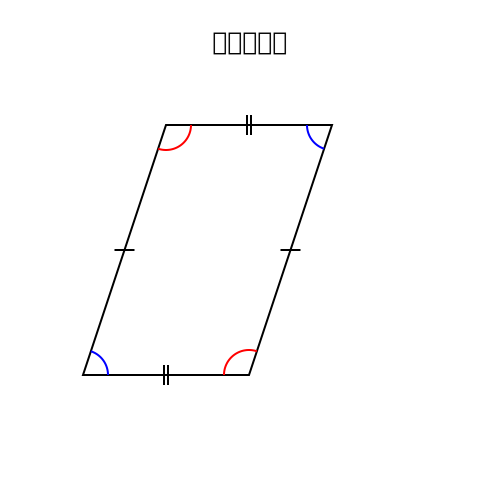

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

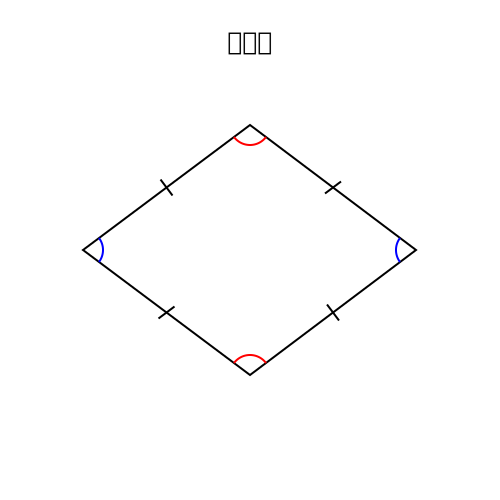

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

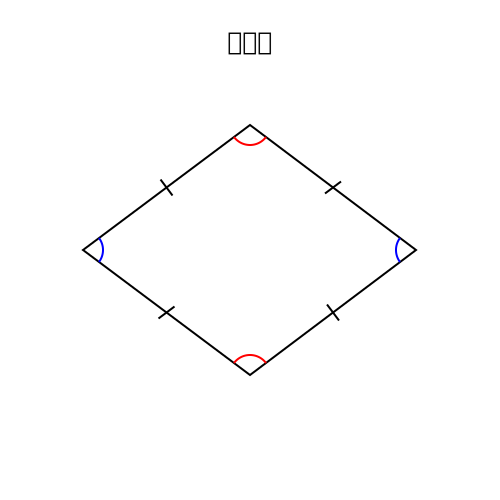

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

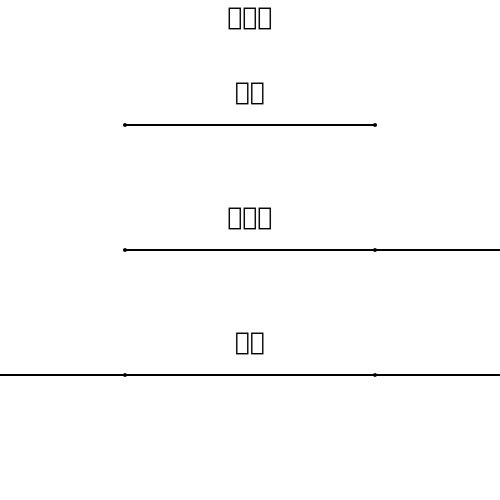

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="164.10861626005772" y2="86.07791485121555" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 132.82172325201154,283.6155829702431 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="172.52537285000193" y="292.40949697936355" font-size="12" text-anchor="middle">81°</text>
        </svg>
        


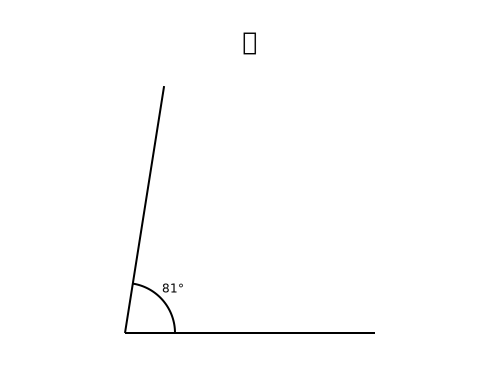

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

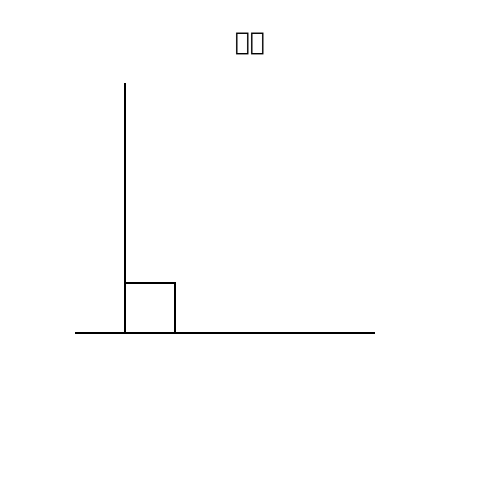

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


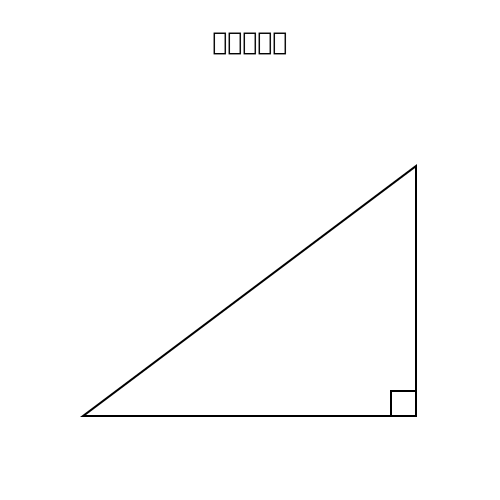

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


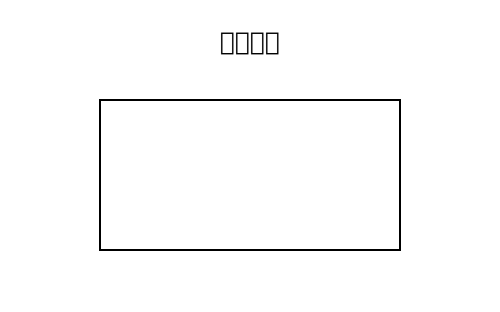

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


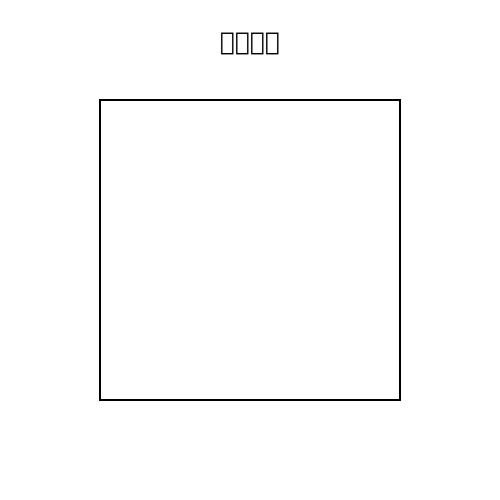

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


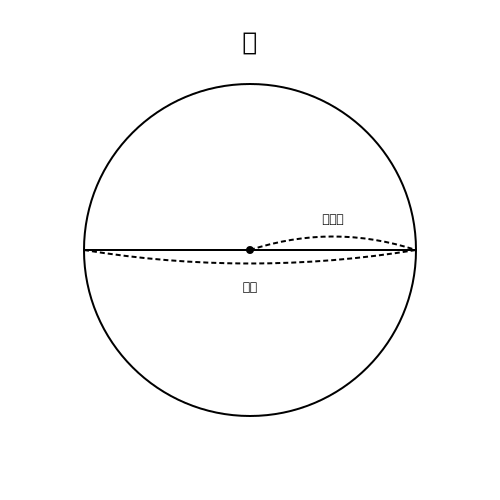

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


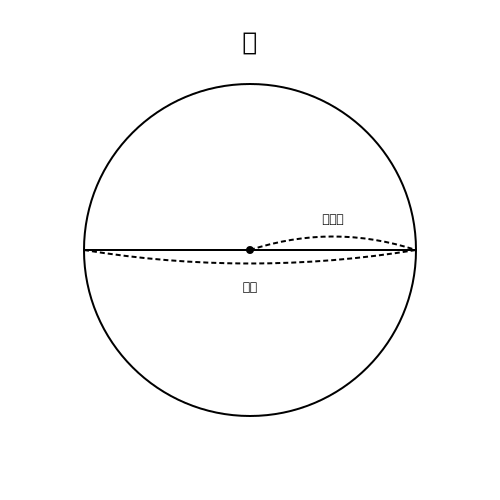

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

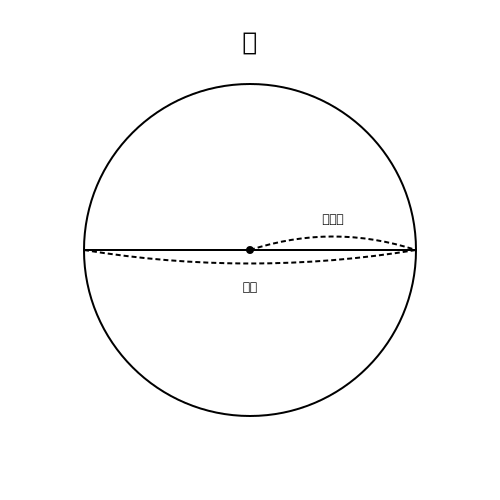

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

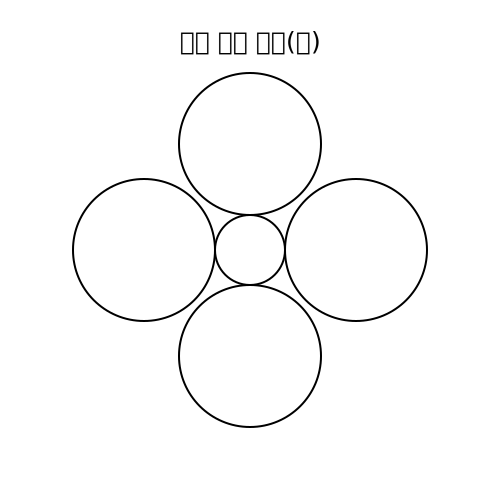

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="85.98524275237321" y2="144.32260494430696" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 217.19704855047465,295.26452098886136 A 50,50 0 0,1 300,333" stroke

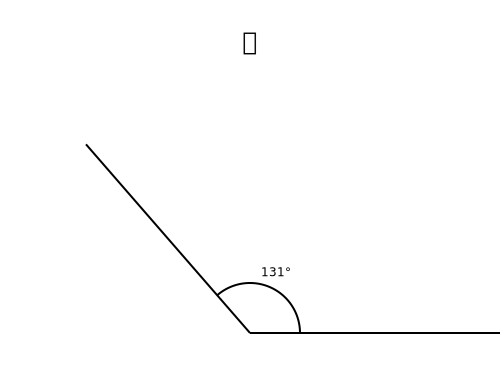

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="1.3695261579316877" y2="306.8678841830866" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.27390523158633,327.77357683661734 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"

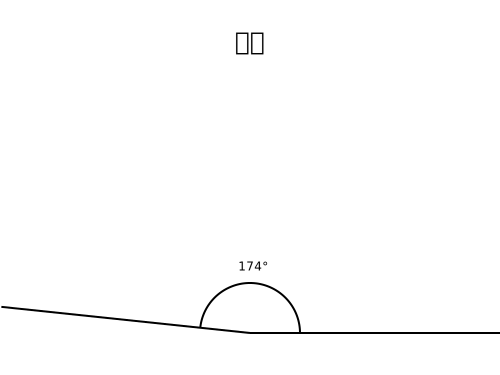

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="264.7982258676867" y2="125.74060686123957" stroke="black" stroke

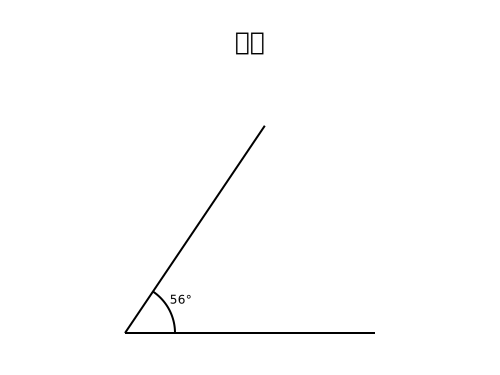

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="361.3796438998292" y2="251.60796138571084" stroke="black" stroke-width="2" />


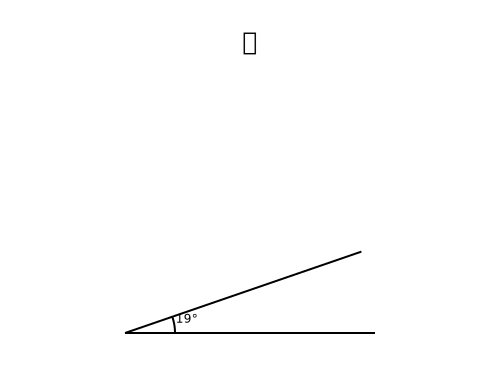

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="290.9809618945489" y2="197.81844919533955" stroke="black" stroke-width

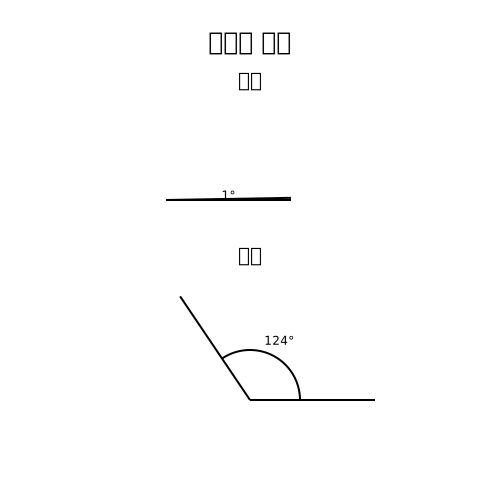

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="362.76412907378835" y2="255.74575140626314" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 172.55282581475768,317.5

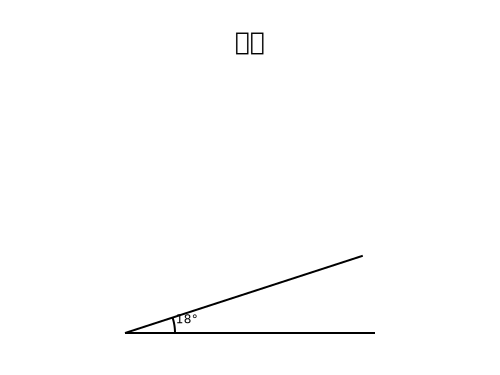

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

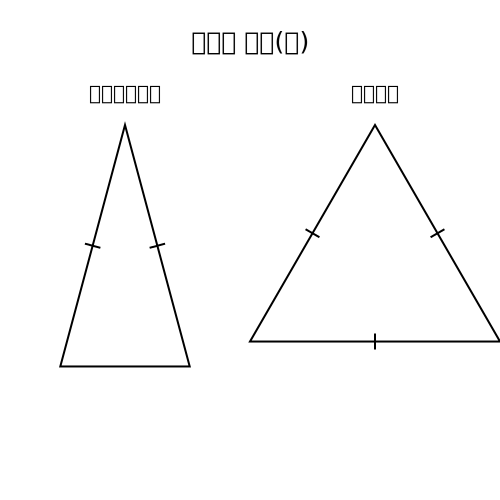

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

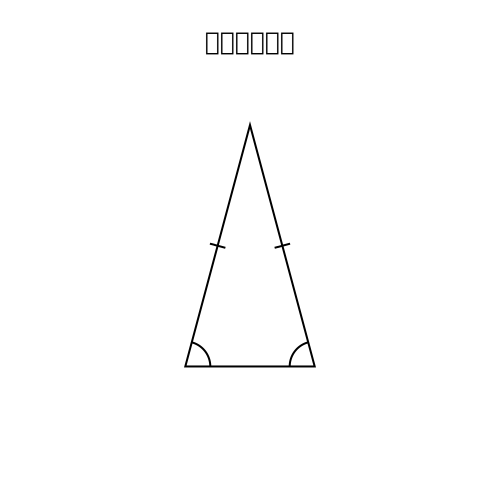

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

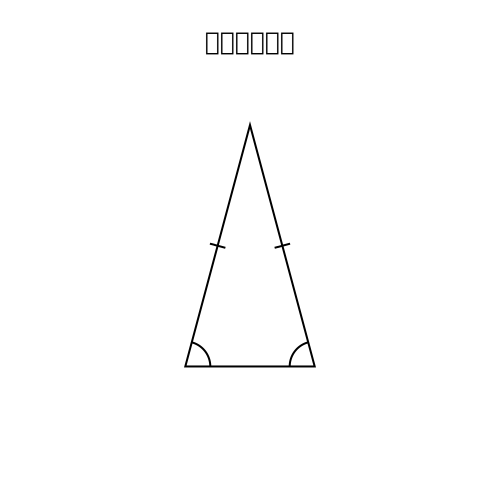

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

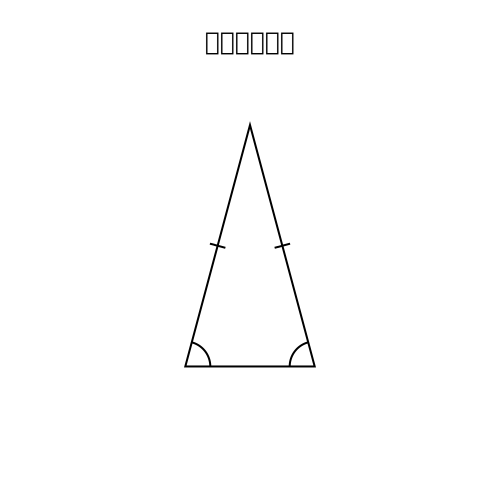

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

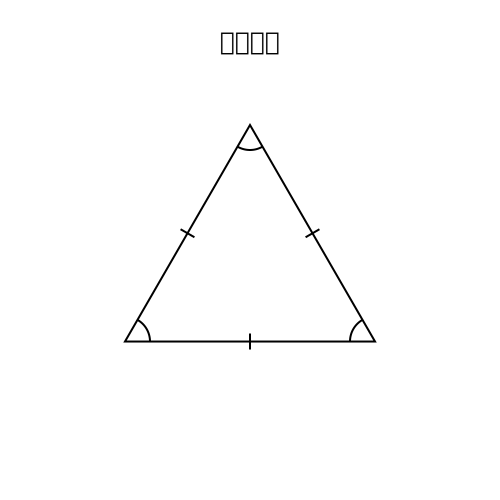

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

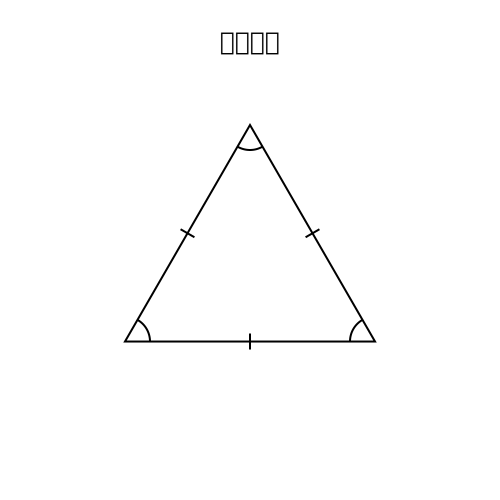

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

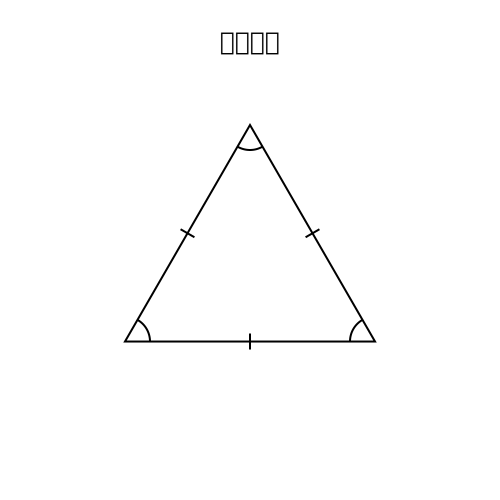

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


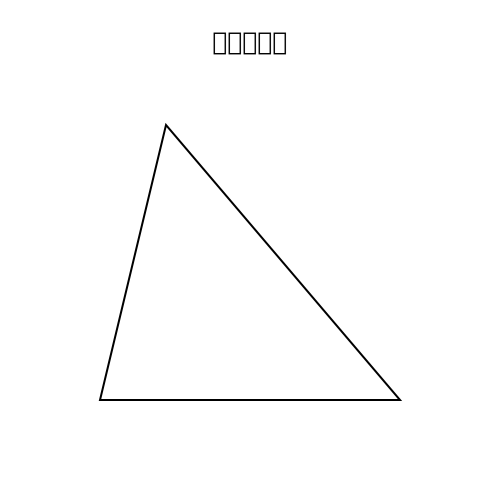

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

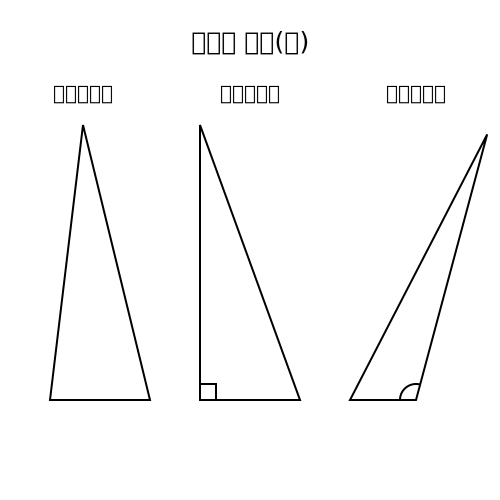

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


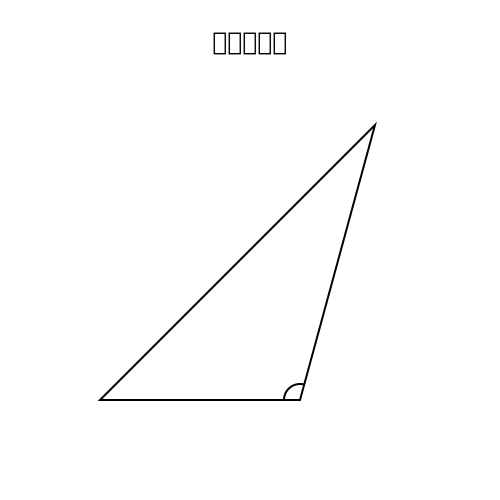

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

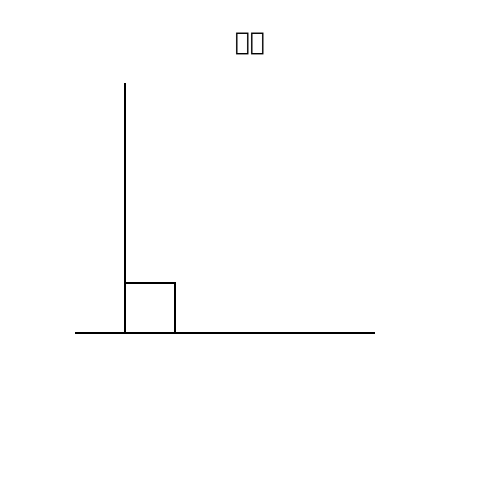

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

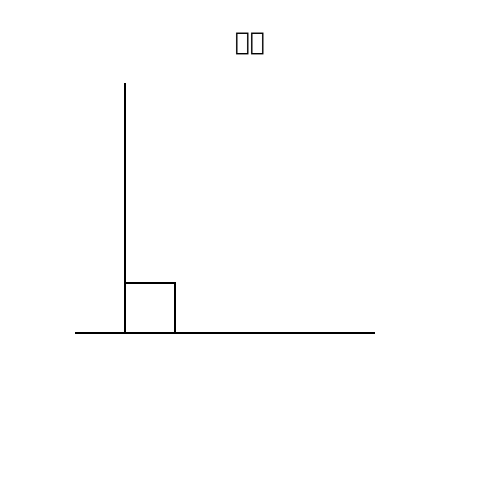

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

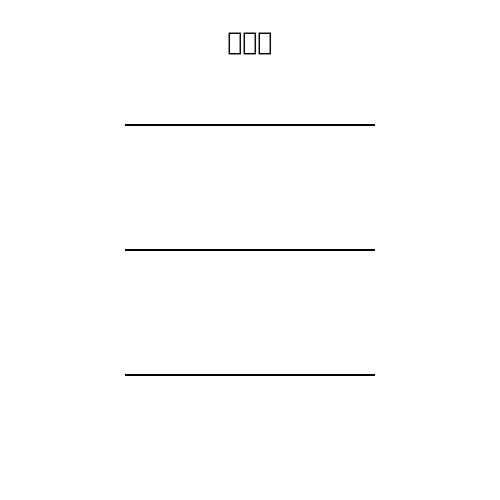

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

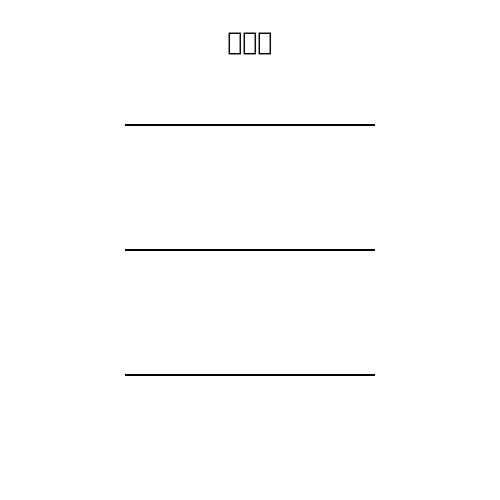

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


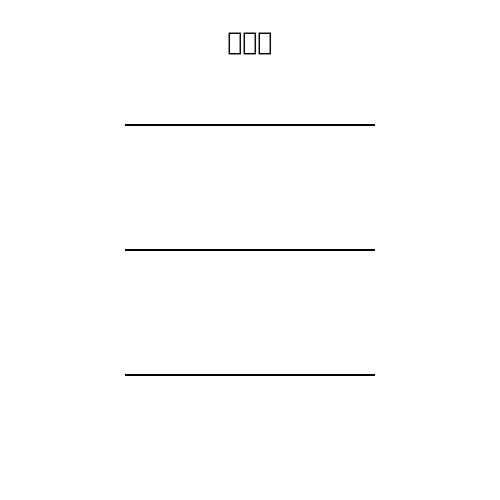

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

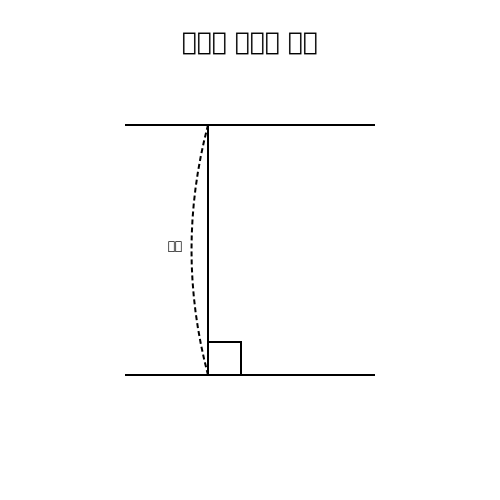

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

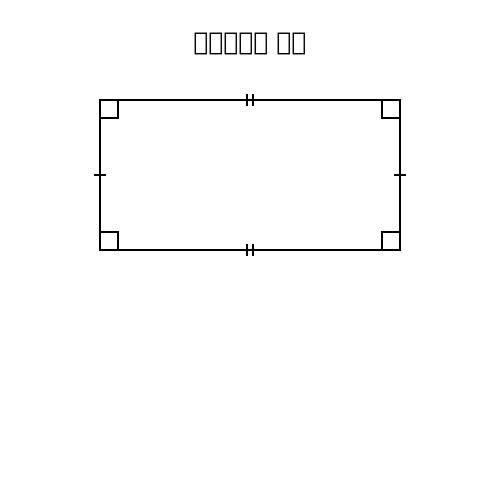

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

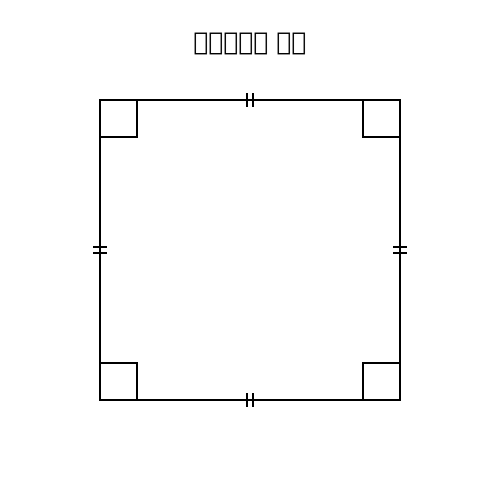

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

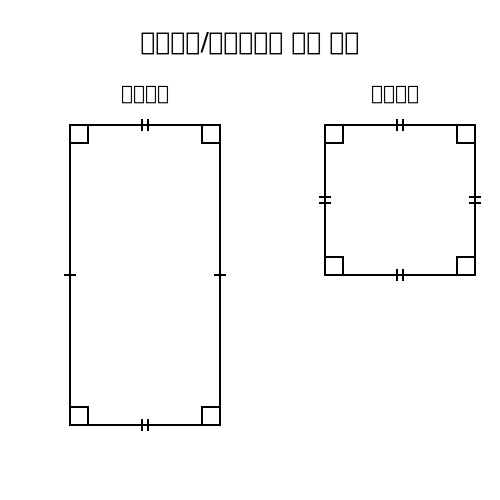

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


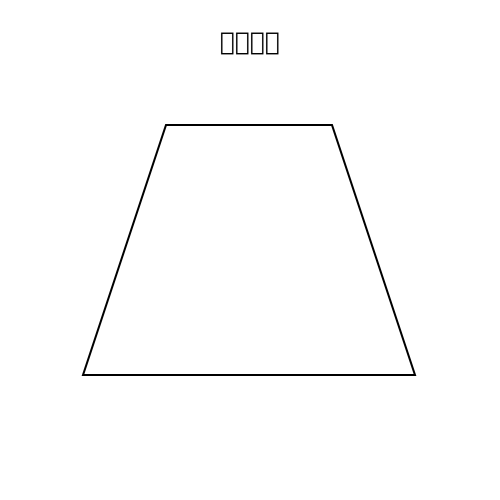

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

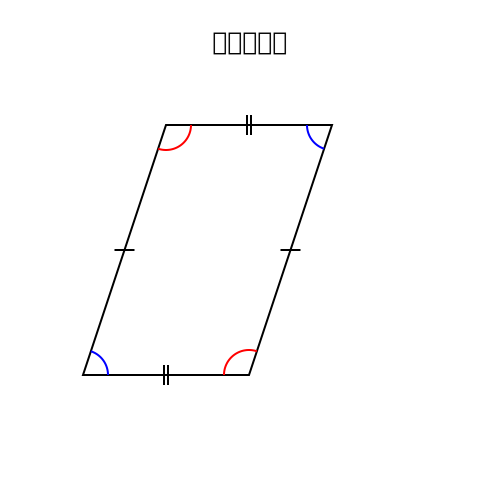

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

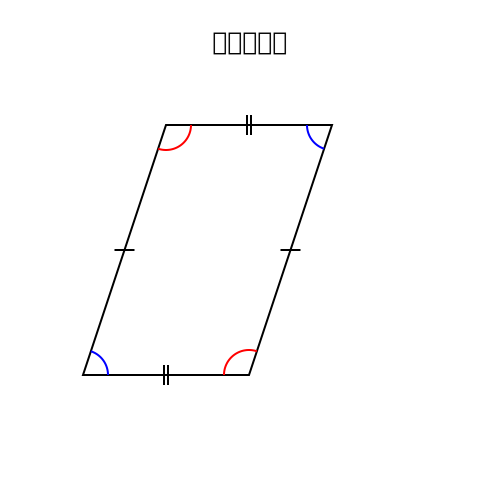

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

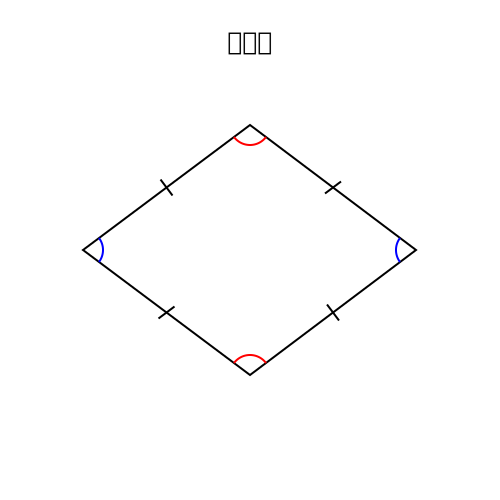

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

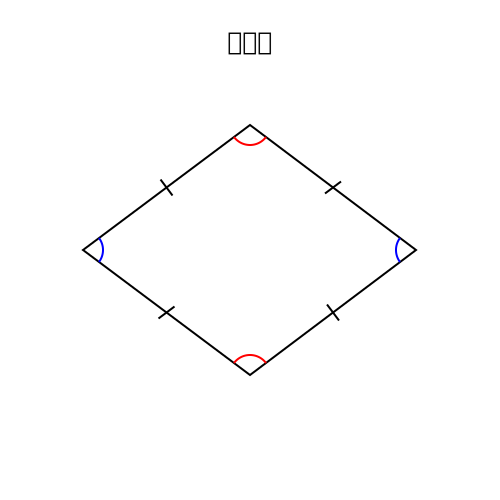

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

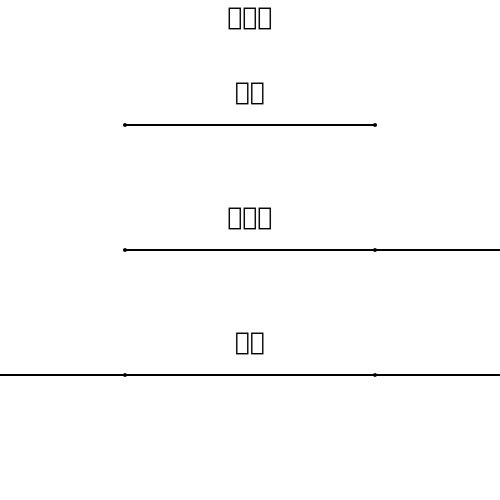

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="228.21106431308544" y2="83.95132547706362" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 245.6422128626171,283.1902650954127 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="292.22438797597874" y="286.92016644936723" font-size="12" text-anchor="middle">95°</text>
        </svg>
        


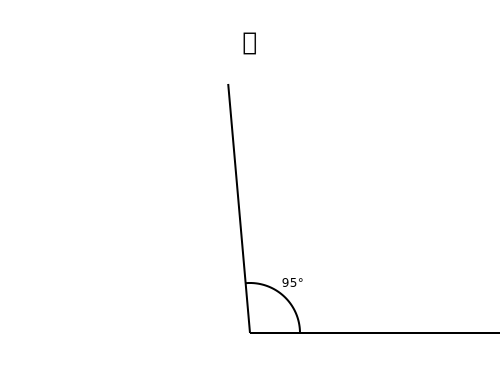

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

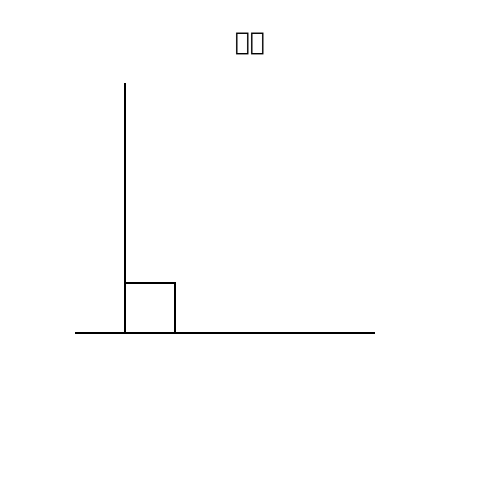

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


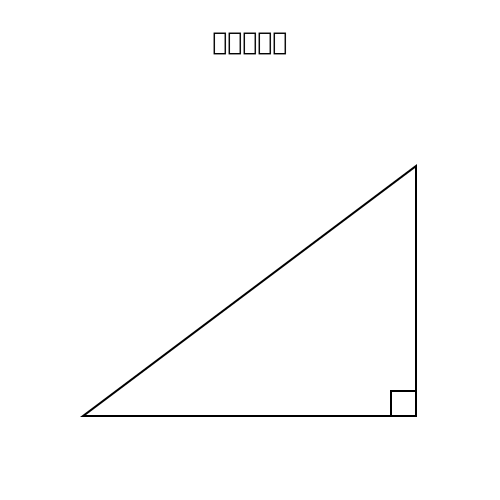

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


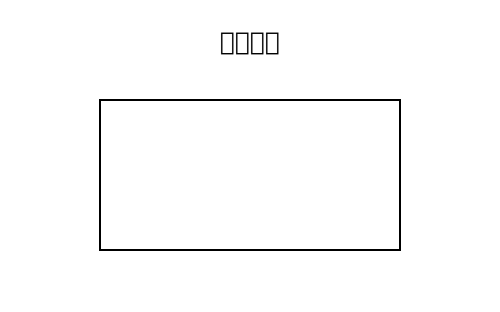

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


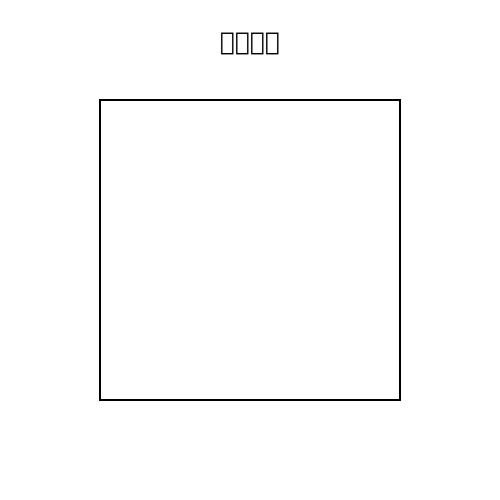

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


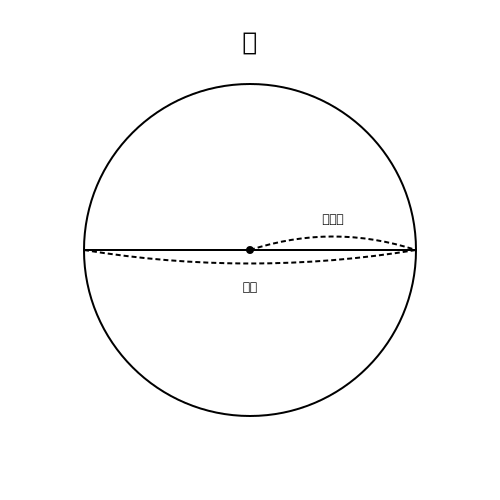

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


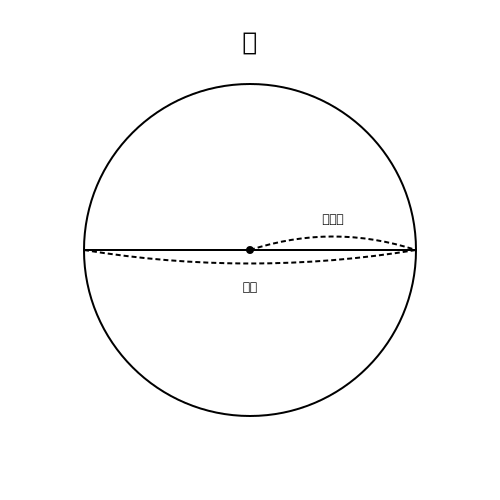

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

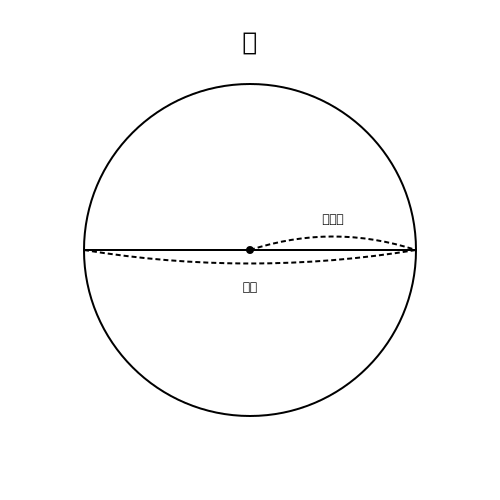

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

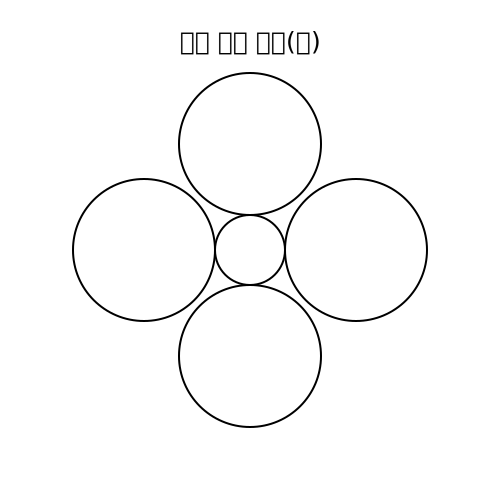

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="355.1262133631101" y2="235.31721787768157" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 171.02524267262203,313.4634435755363 A 50,50 0 0,1 175,333" stroke=

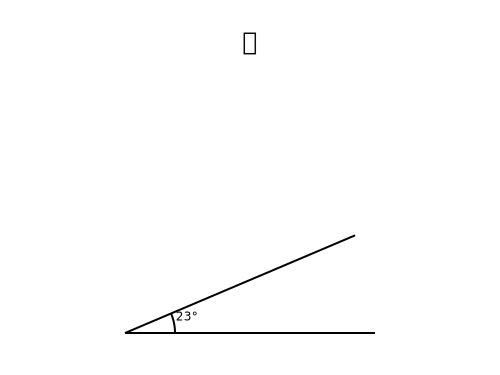

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="1.863462089669497" y2="302.53266414871314" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.3726924179339,326.9065328297426 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>

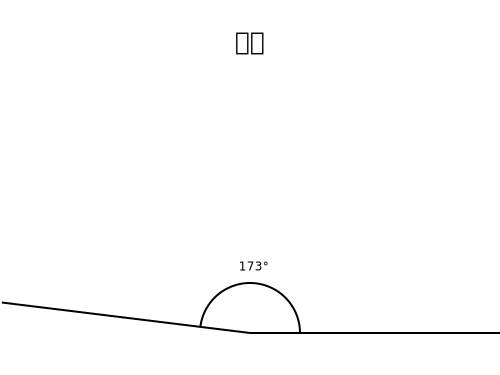

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="35.70817482447194" y2="204.2404812724864" stroke="black" stroke-

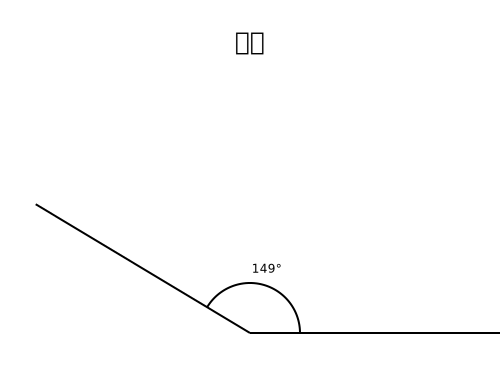

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="1.863462089669497" y2="302.53266414871314" stroke="black" stroke-width="2" />


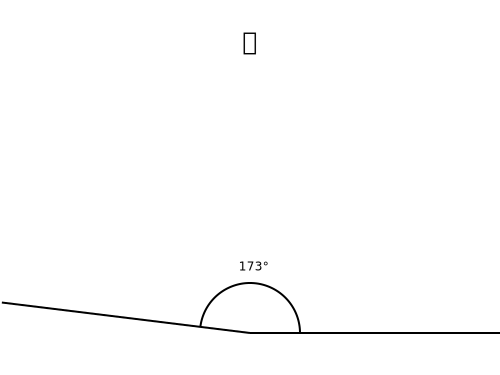

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="281.06310668155504" y2="151.15860893884079" stroke="black" stroke-widt

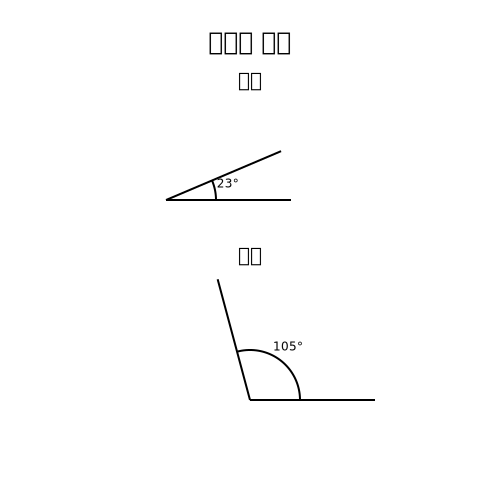

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="353.38636441065023" y2="231.31583923104995" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 170.67727288213004,312.6

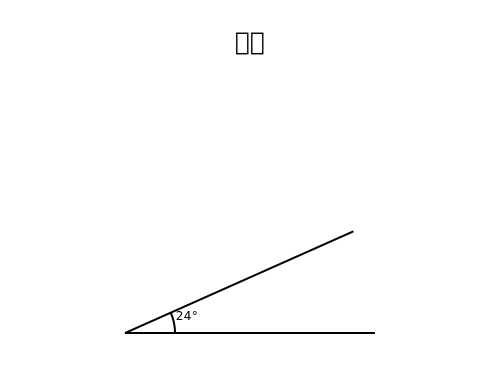

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

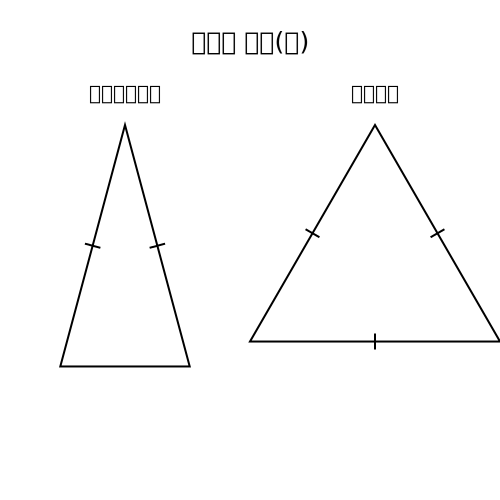

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

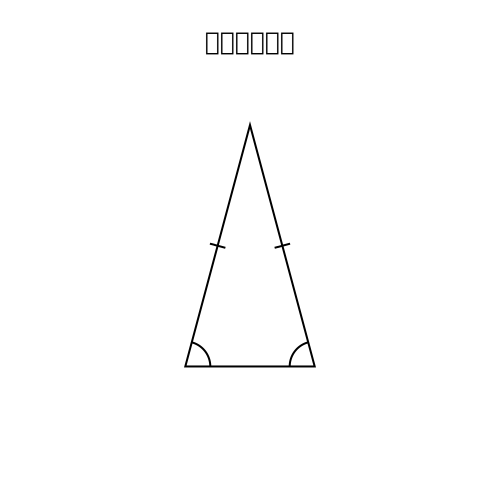

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

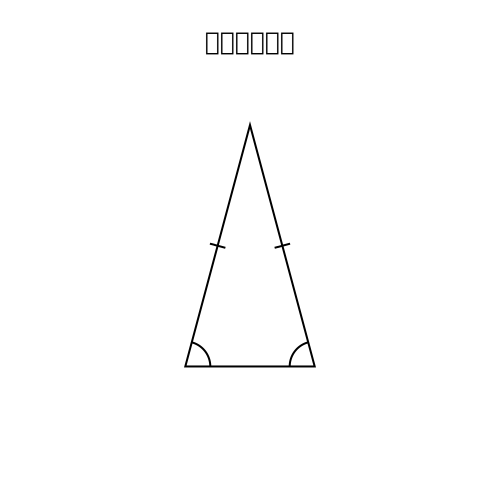

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

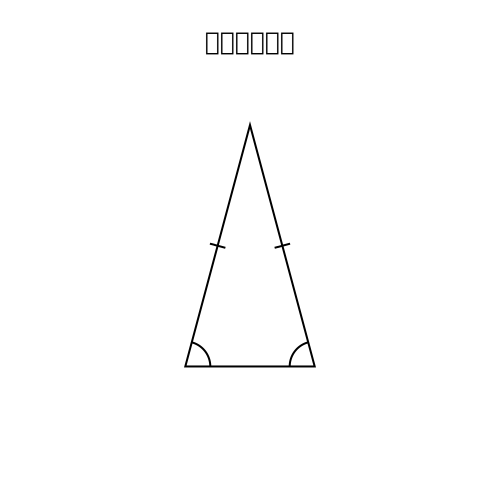

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

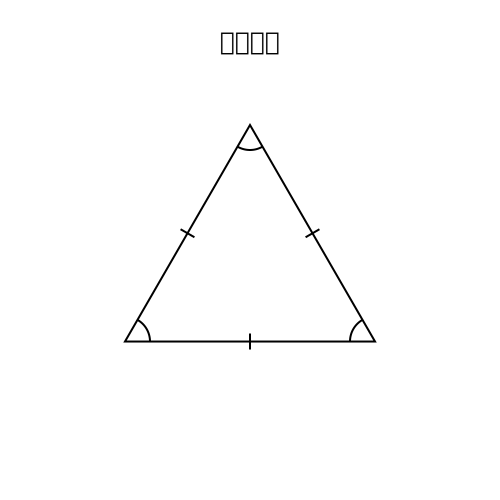

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

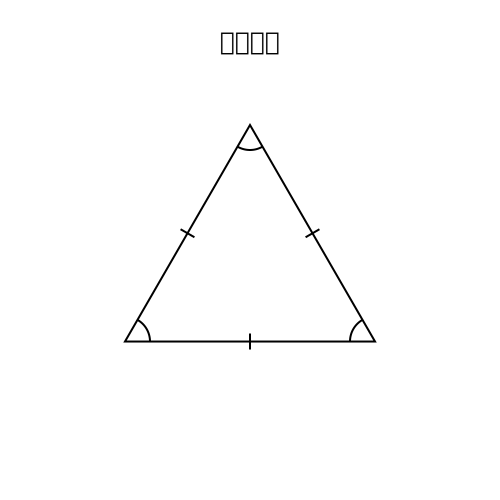

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

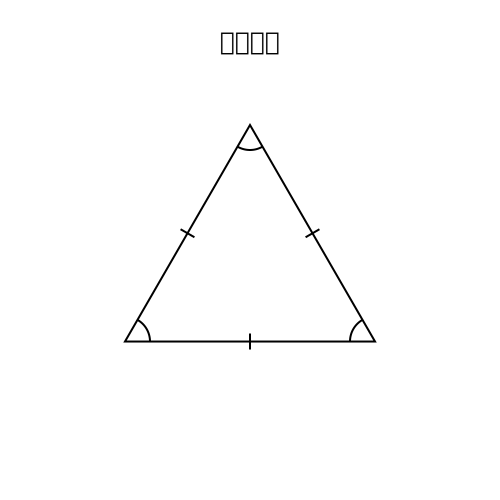

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


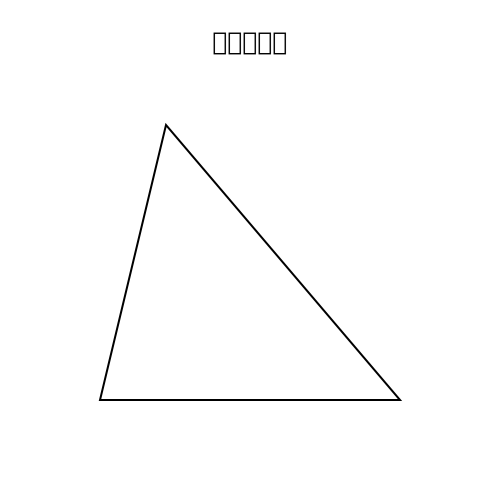

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

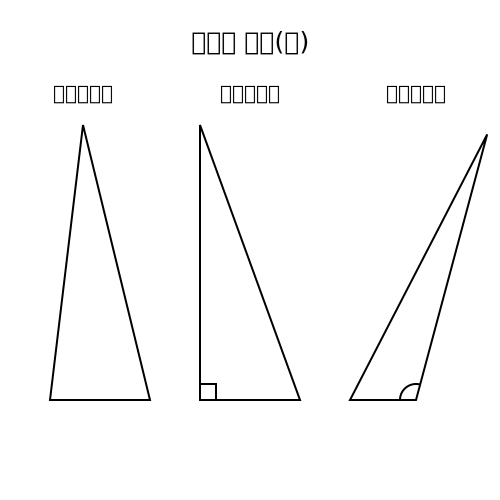

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


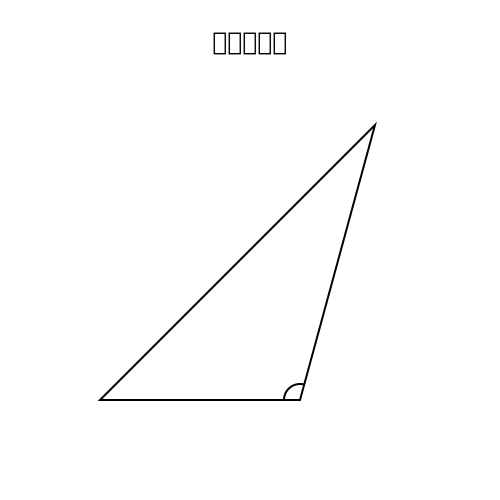

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

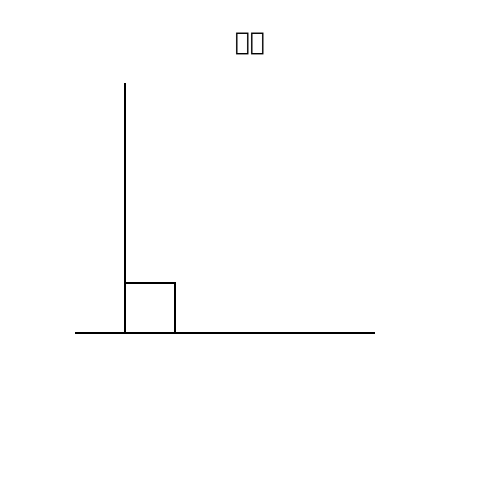

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

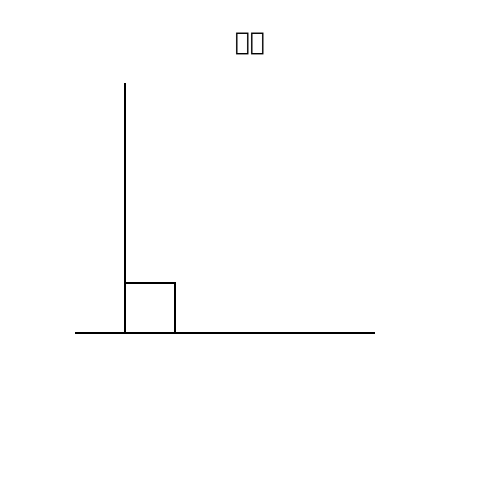

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

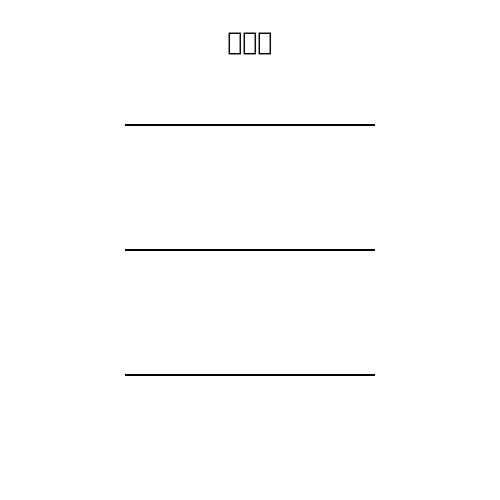

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

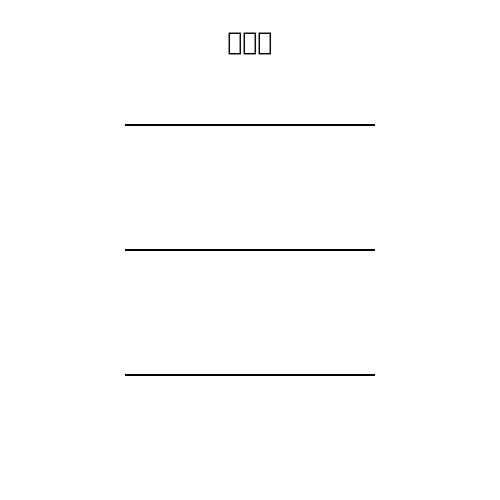

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


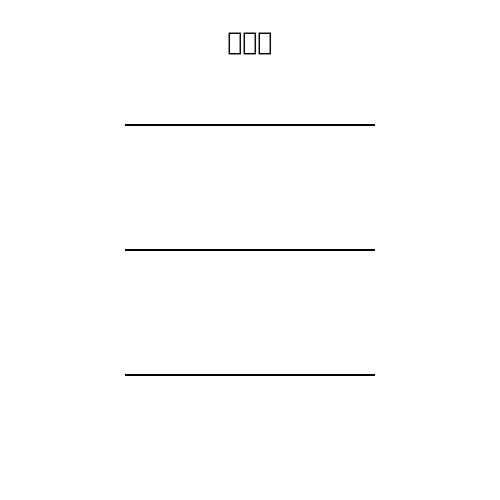

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

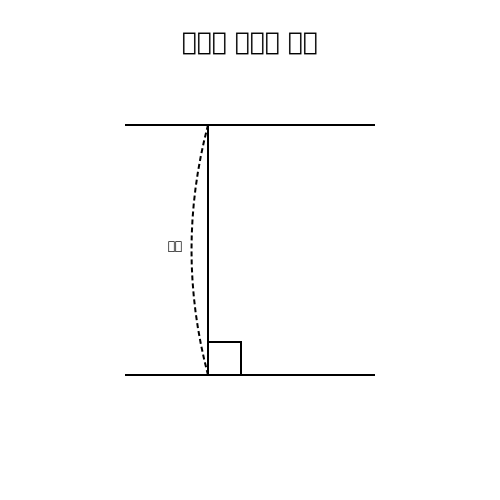

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

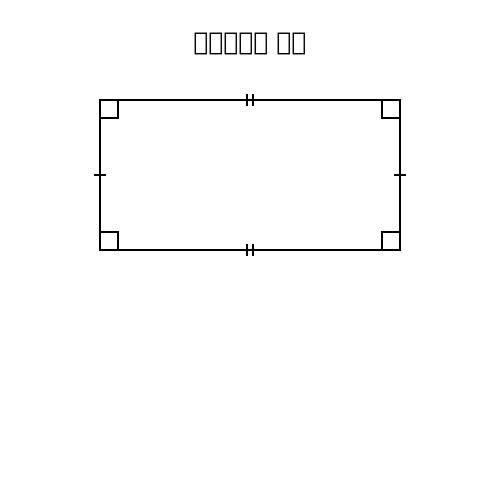

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

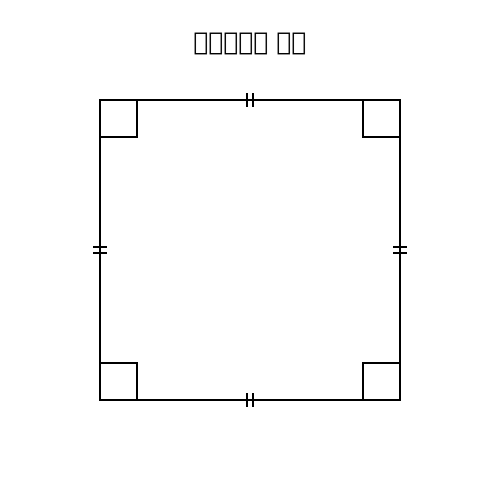

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

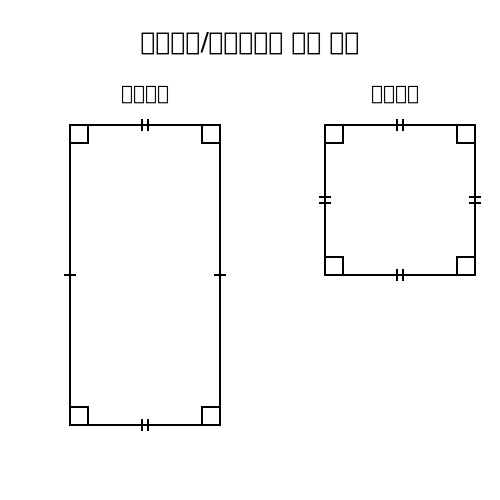

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


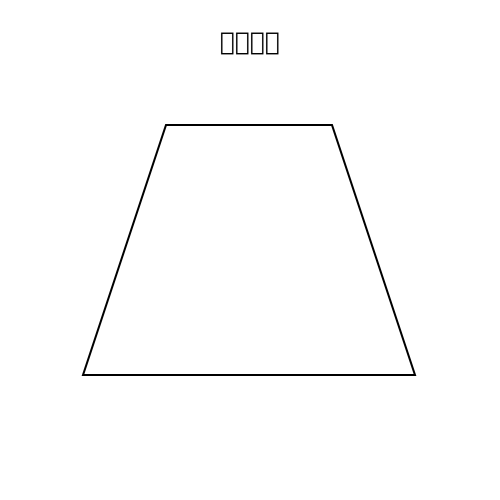

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

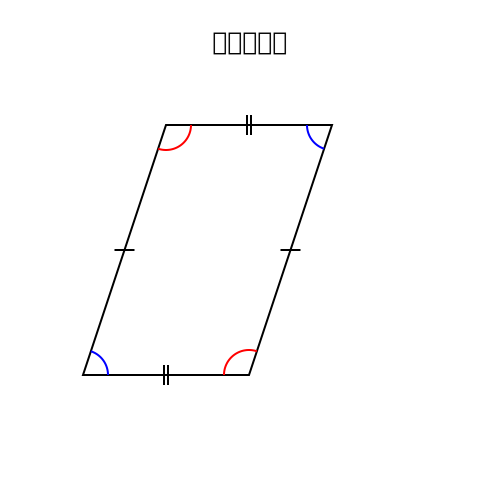

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

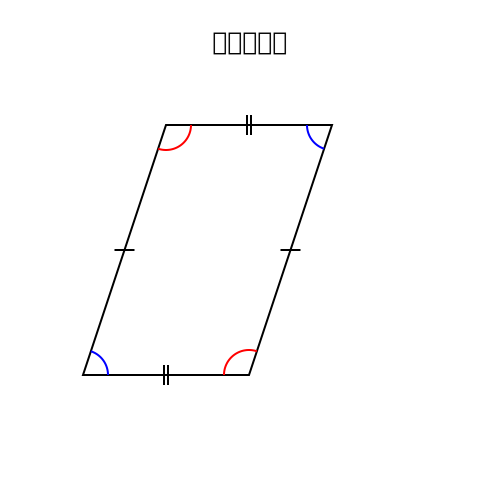

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

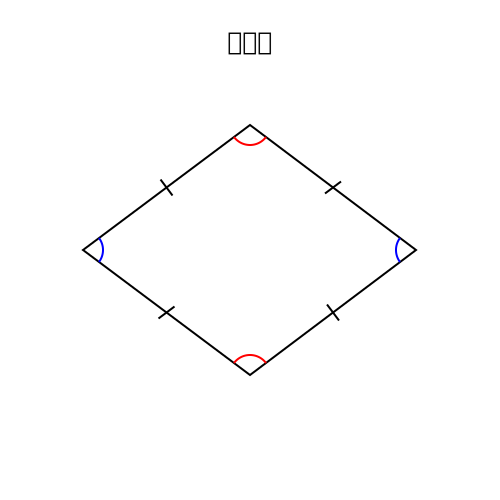

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

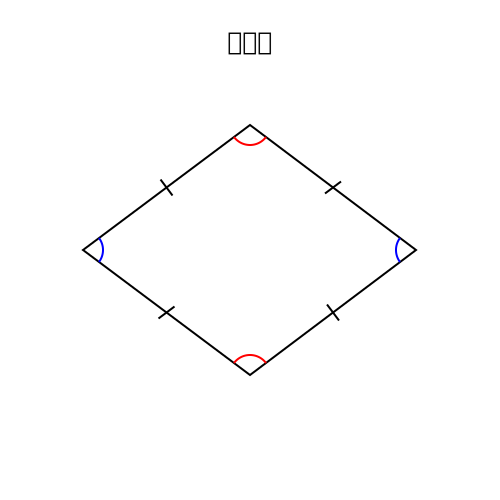

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

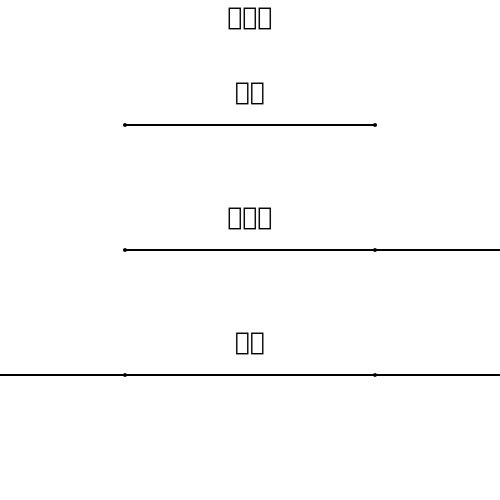

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="228.21106431308544" y2="83.95132547706362" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 245.6422128626171,283.1902650954127 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="292.22438797597874" y="286.92016644936723" font-size="12" text-anchor="middle">95°</text>
        </svg>
        


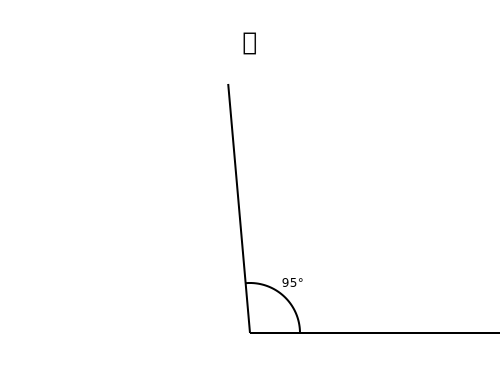

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

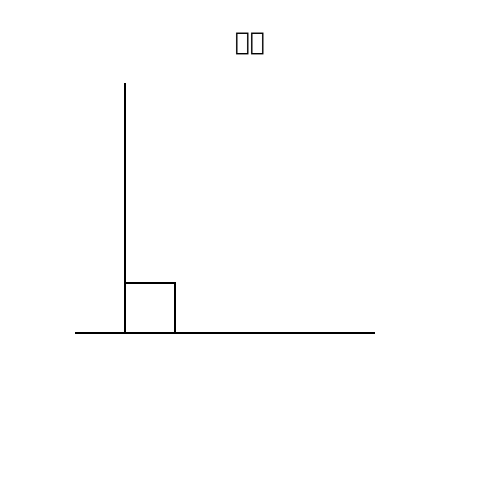

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


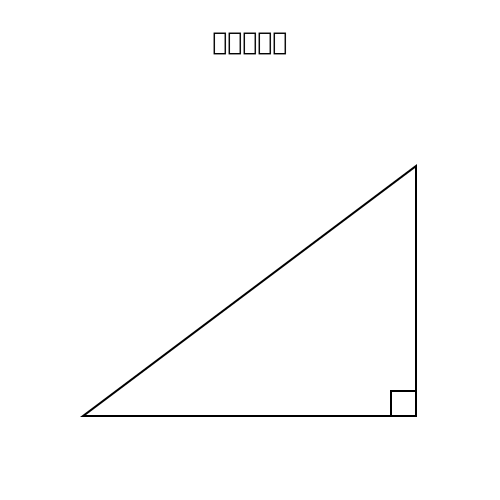

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


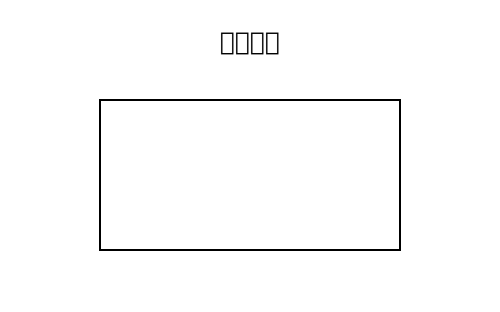

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


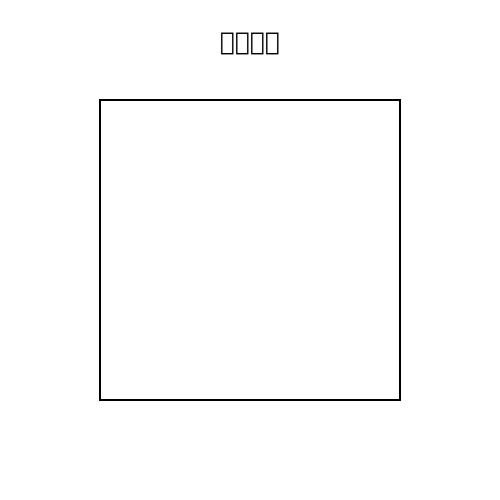

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


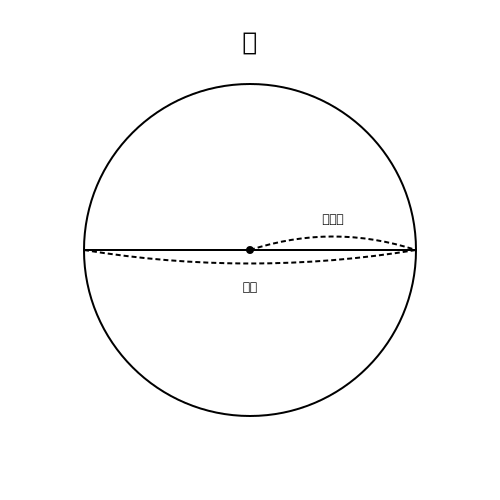

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


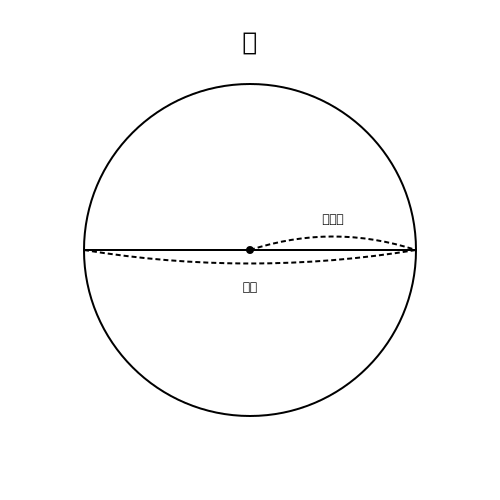

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

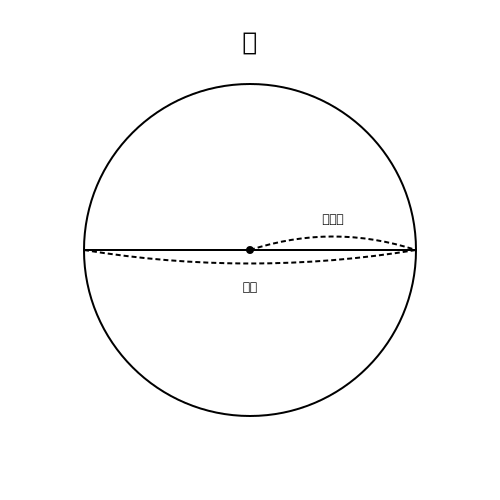

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

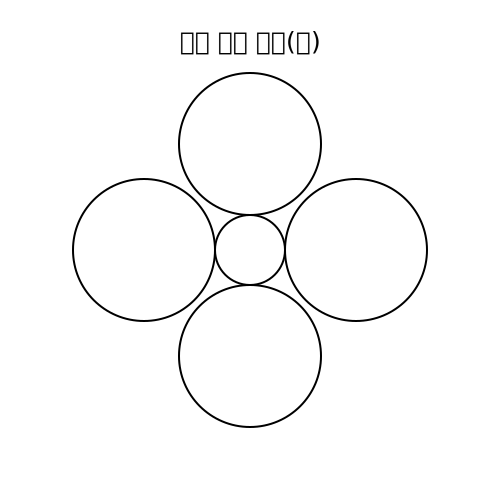

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="206.58795558326742" y2="86.79806174694801" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 241.3175911166535,283.7596123493896 A 50,50 0 0,1 300,333" stroke="

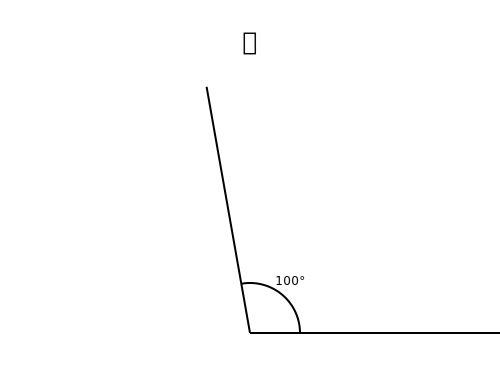

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="13.620356100170795" y2="251.60796138571084" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 202.72407122003415,316.7215922771422 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"

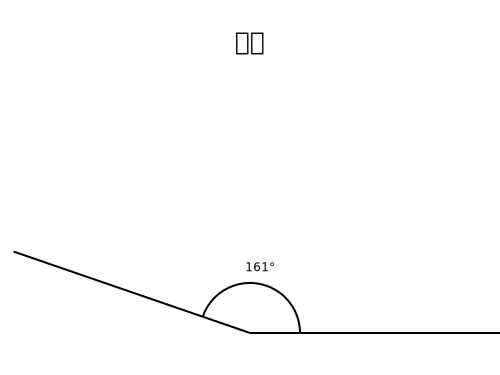

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="202.2977511558638" y2="87.59320413808402" stroke="black" stroke-

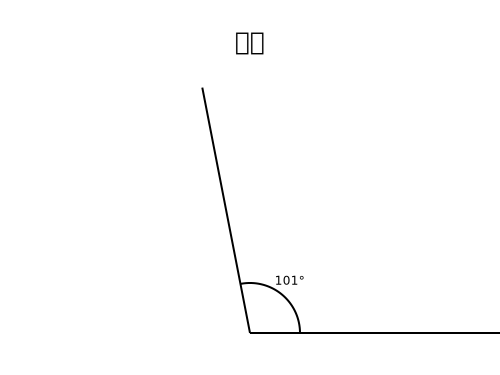

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="25.301488425208248" y2="223.40721330273067" stroke="black" stroke-width="2" />

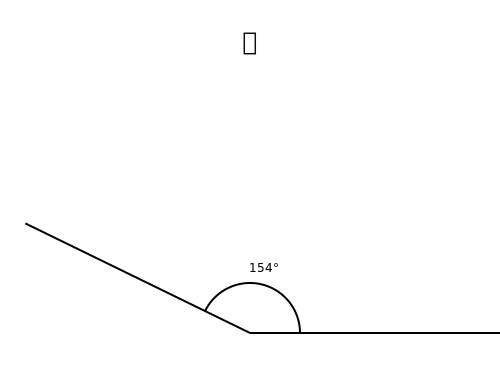

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="286.1577119922899" y2="165.5453305228751" stroke="black" stroke-width=

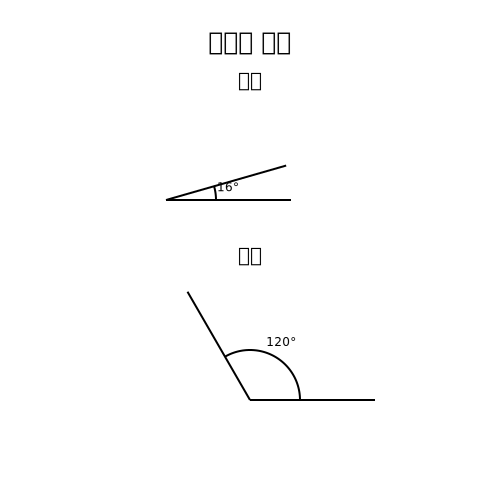

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="89.30309757836517" y2="141.4888892202555" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 217.86061951567302,294.697

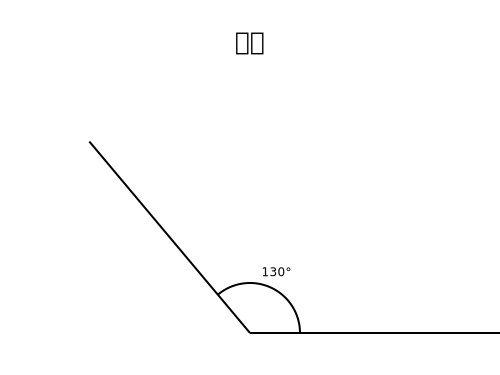

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

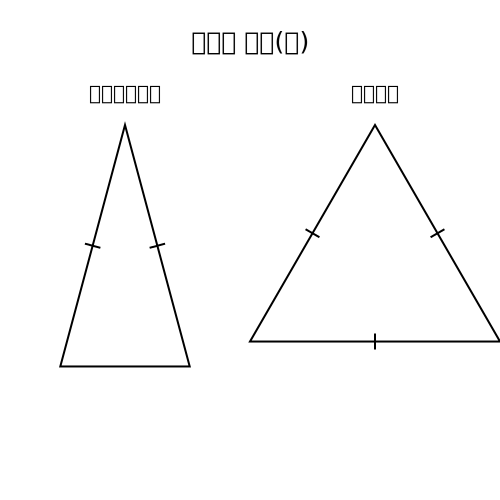

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

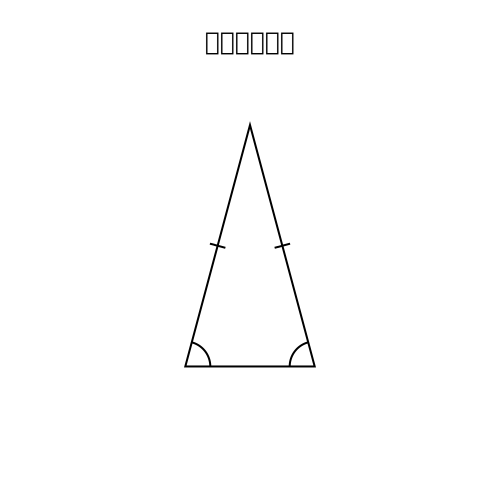

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

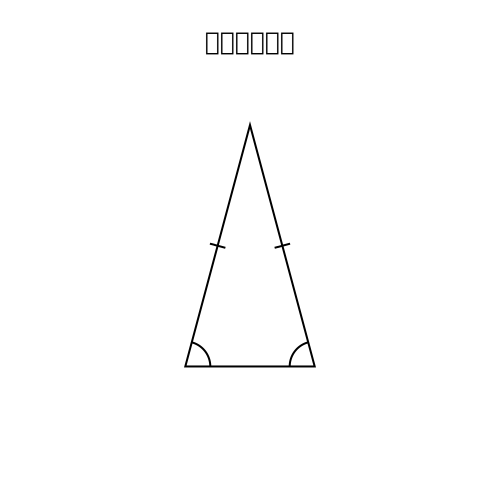

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

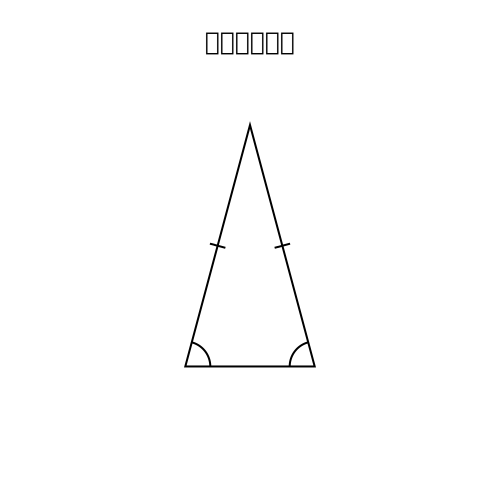

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

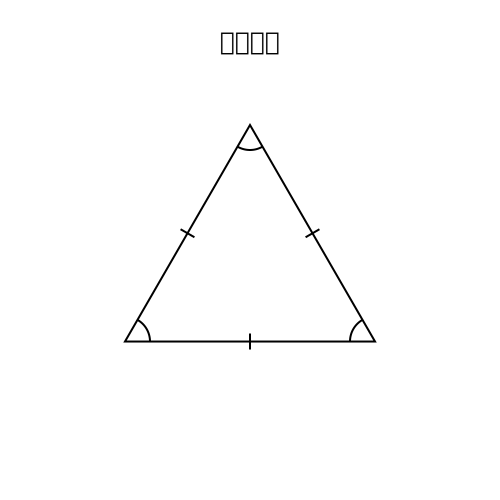

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

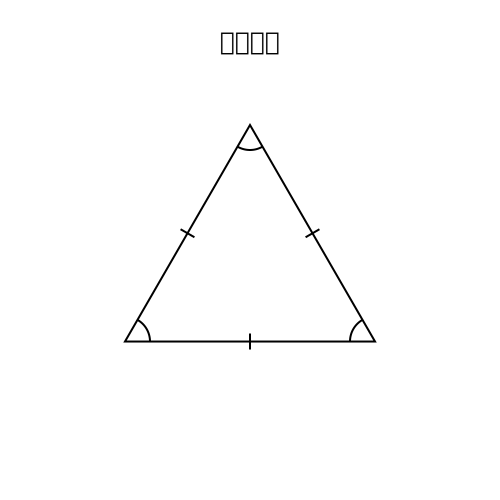

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

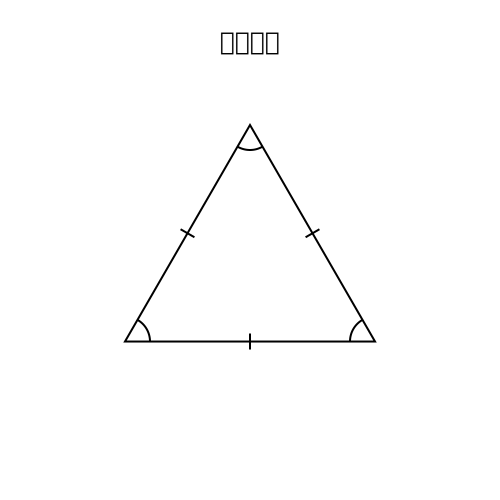

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


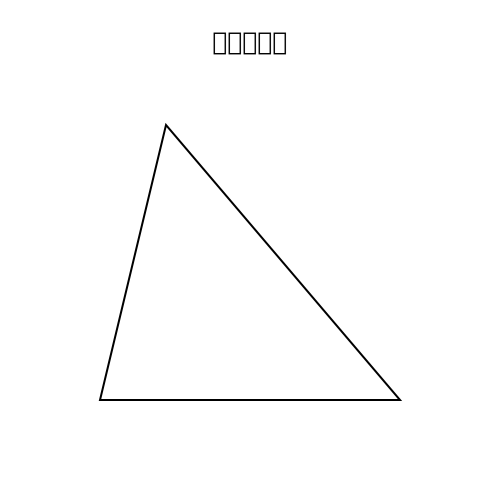

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

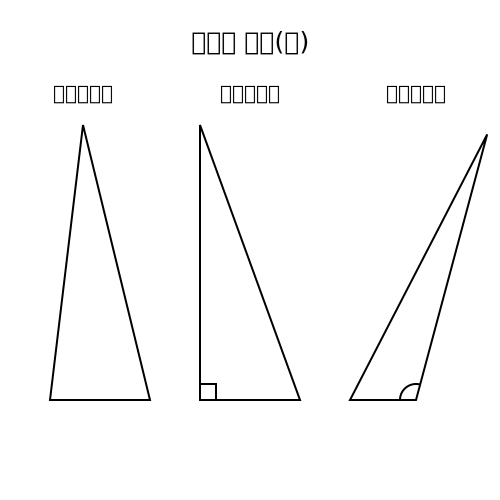

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


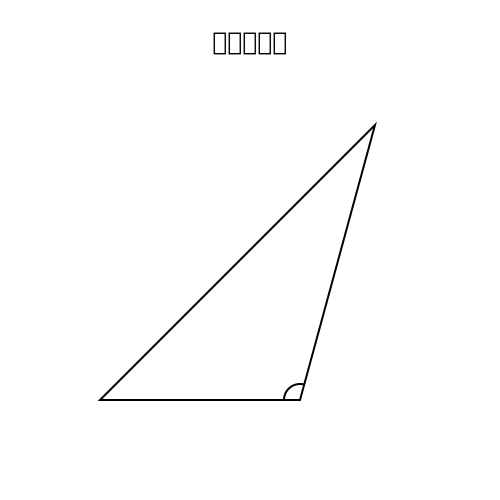

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

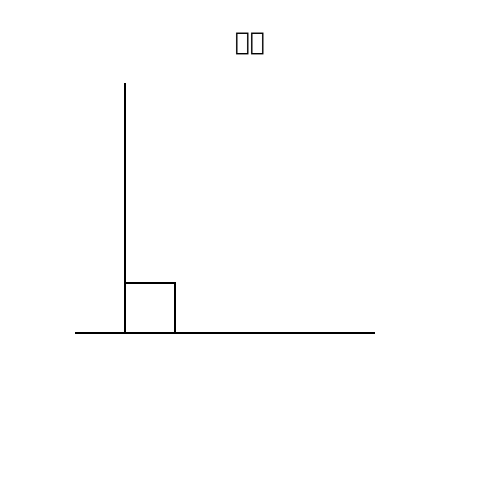

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

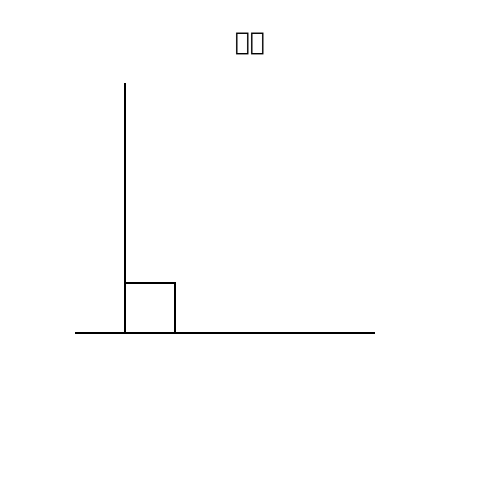

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

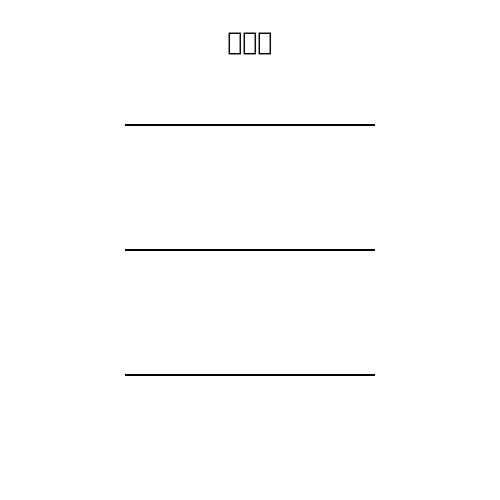

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

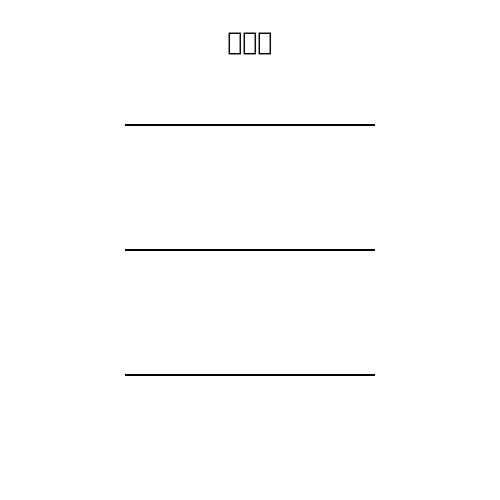

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


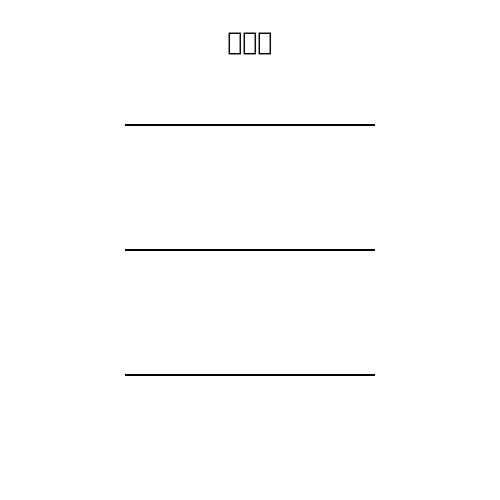

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

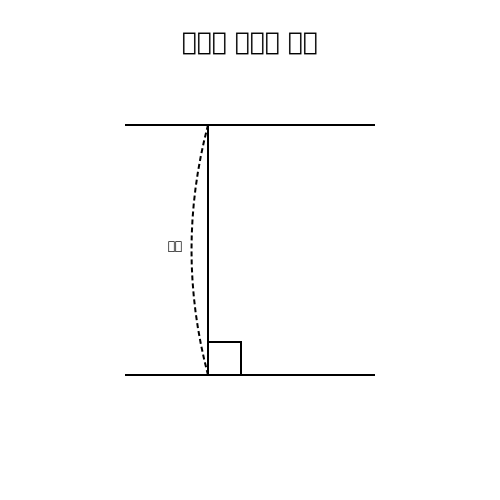

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

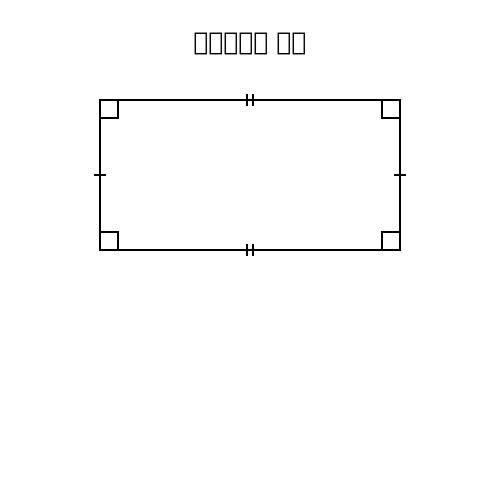

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

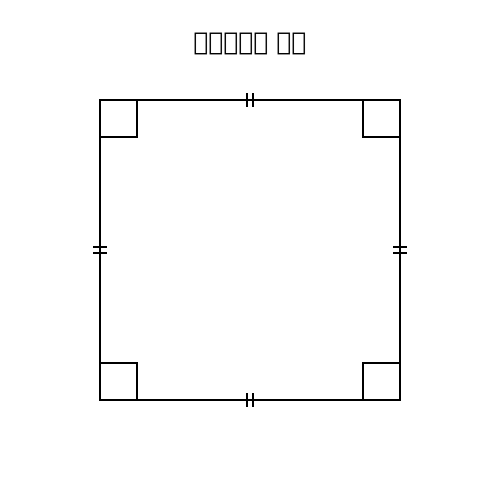

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

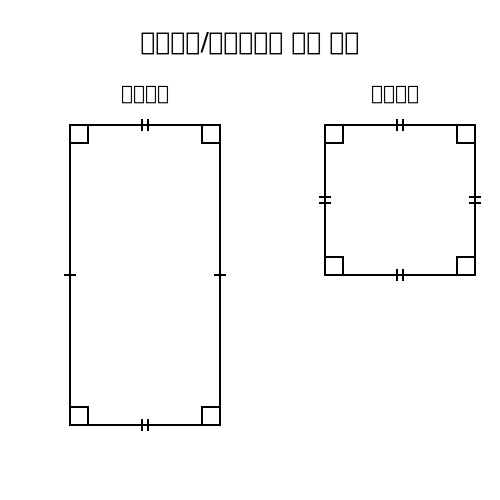

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


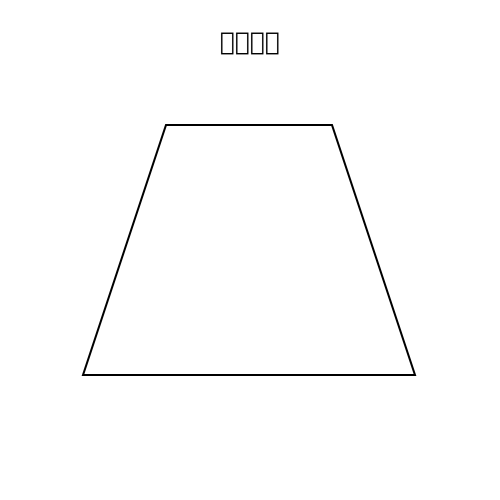

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

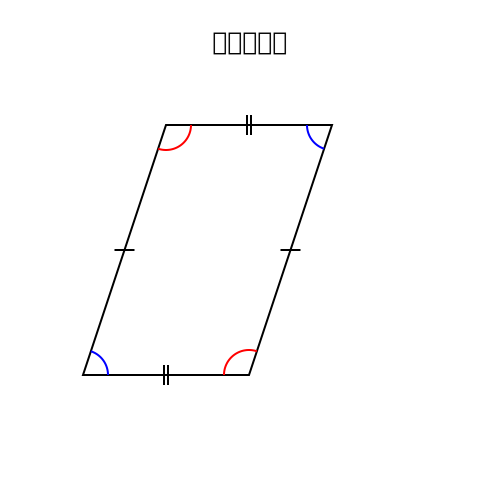

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

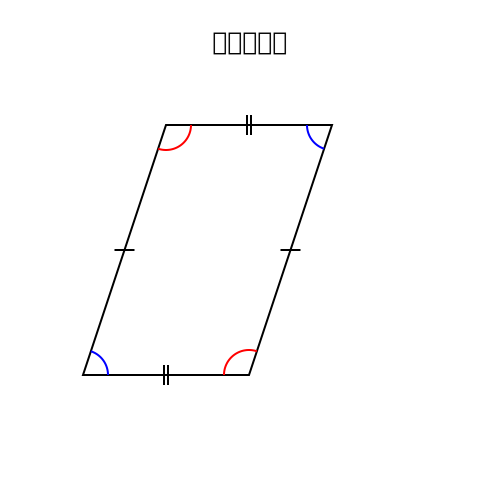

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

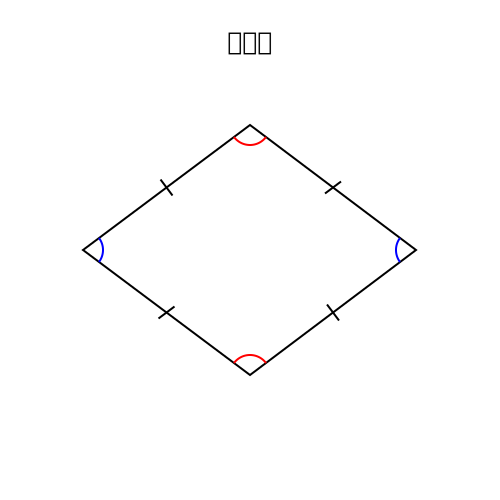

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

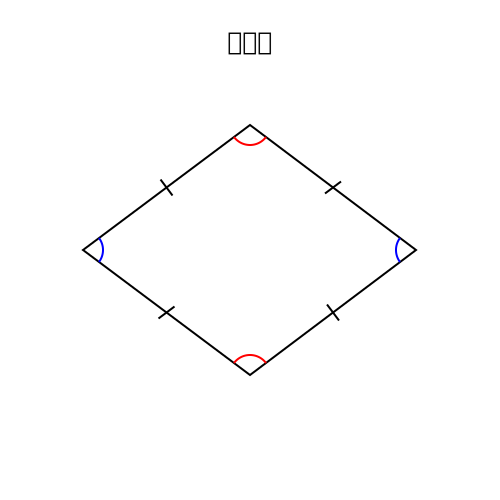

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

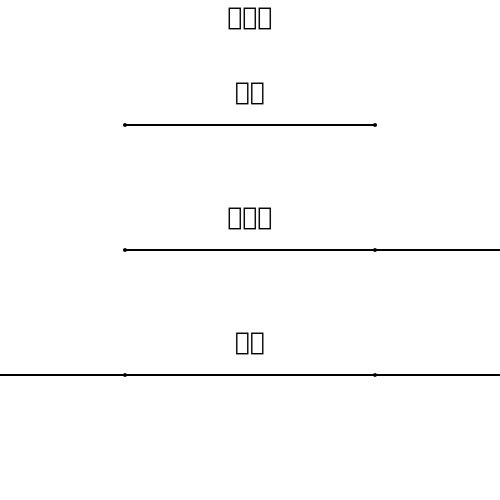

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="275.45375578801213" y2="133.34112248817678" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 155.09075115760243,293.06822449763536 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="180.93339760012657" y="305.11263668063697" font-size="12" text-anchor="middle">53°</text>
        </svg>
        


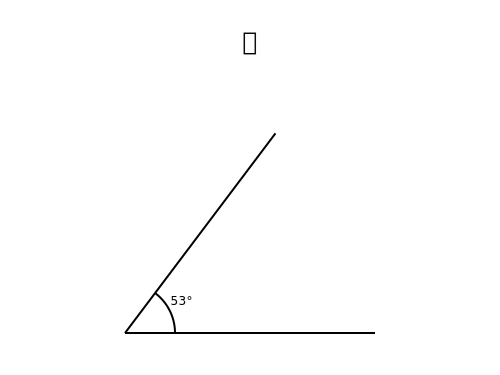

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

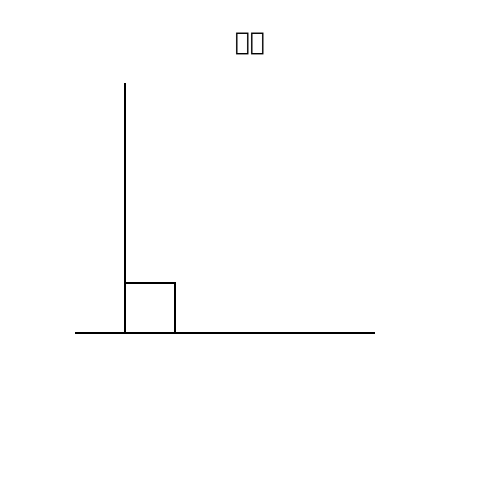

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


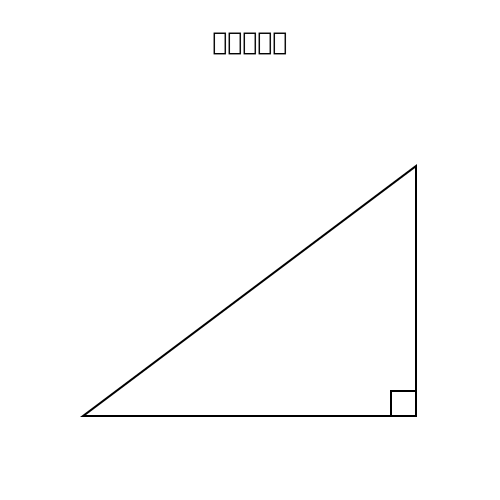

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


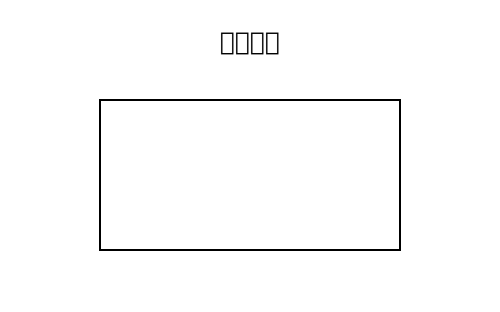

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


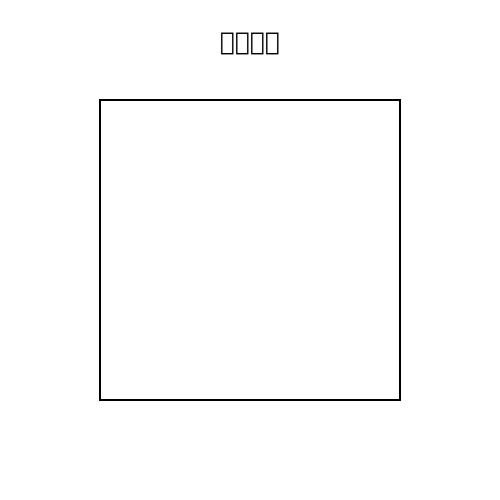

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


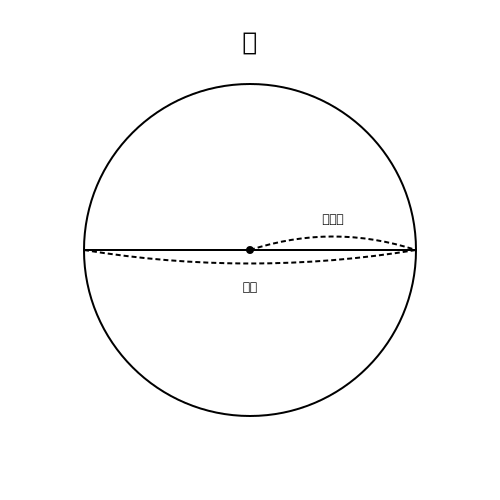

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


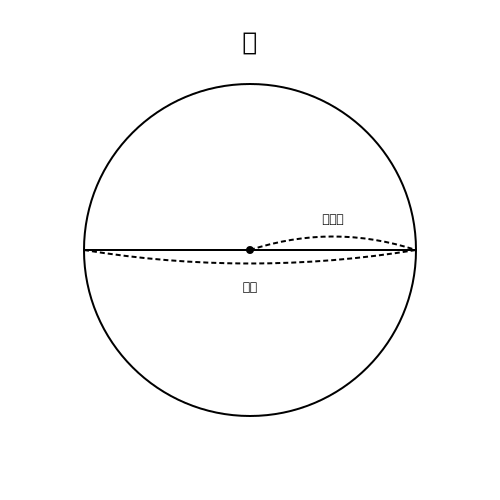

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

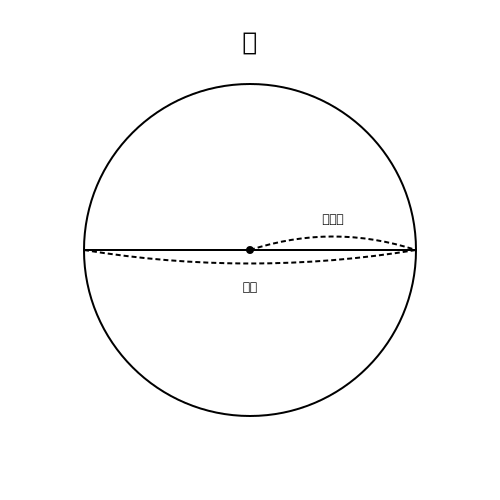

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

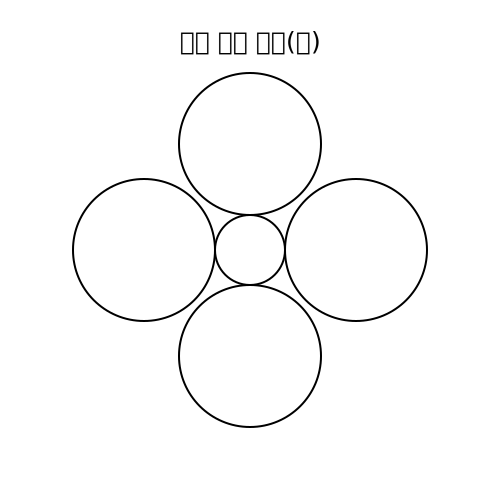

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="370.40679586191595" y2="285.2977511558638" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.0813591723832,323.4595502311728 A 50,50 0 0,1 175,333" stroke="

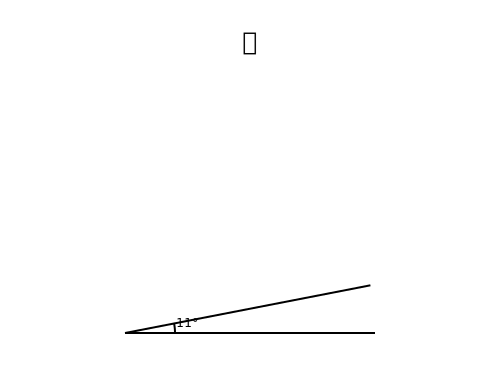

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="307.8384254047926" y2="162.50040998437538" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 161.56768508095854,298.9000819968751 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/

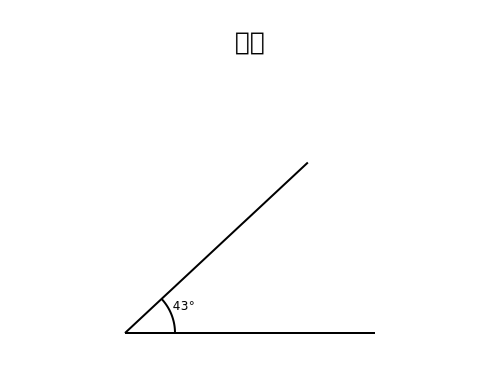

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="13.620356100170795" y2="251.60796138571084" stroke="black" strok

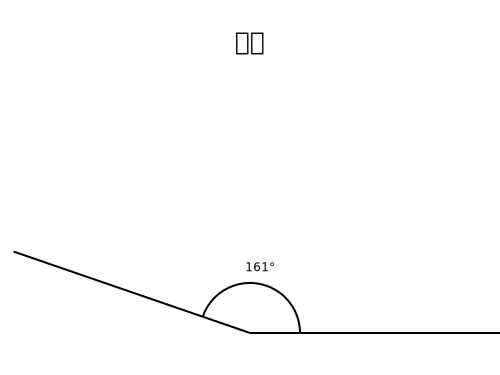

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="0.6089874350439572" y2="315.5608815639686" stroke="black" stroke-width="2" />


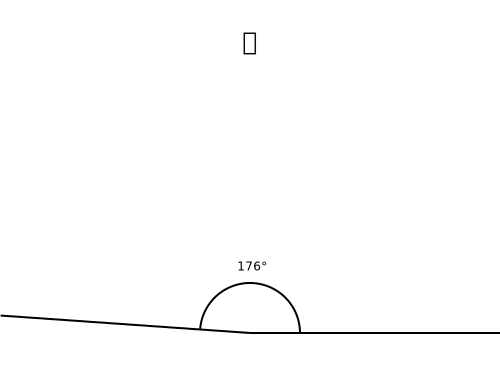

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="222.74881246744334" y2="88.62418447645403" stroke="black" stroke-width

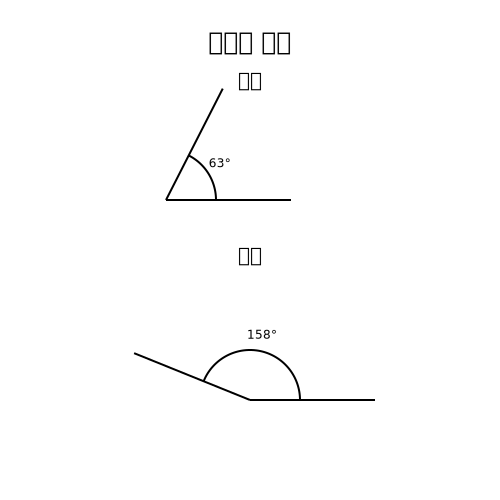

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="367.5739315689991" y2="272.51952610008306" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 173.51478631379982,320.90

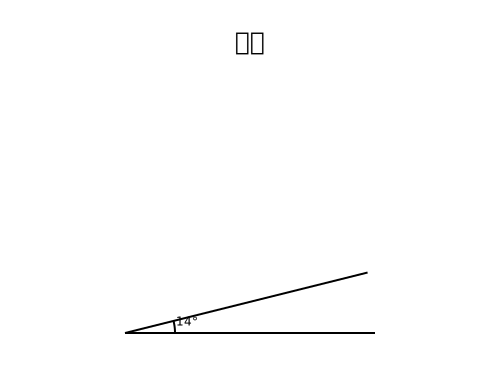

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

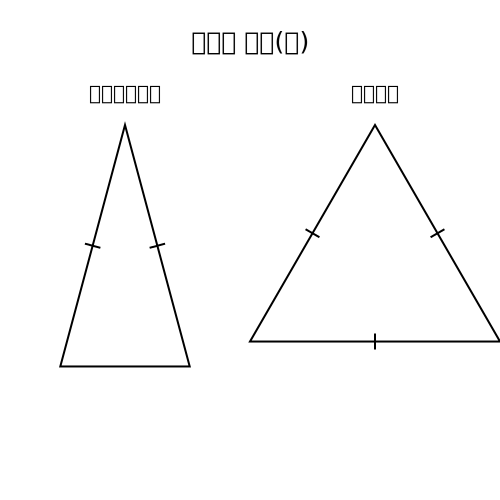

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

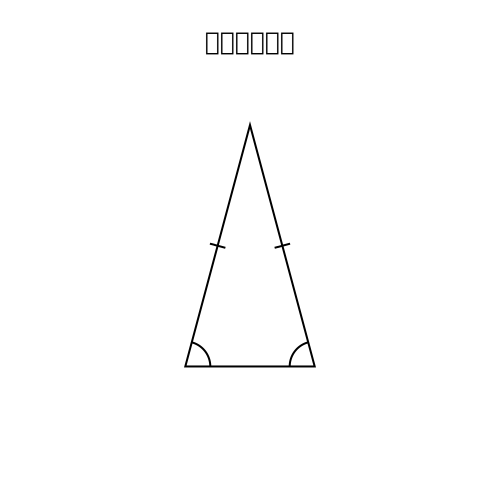

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

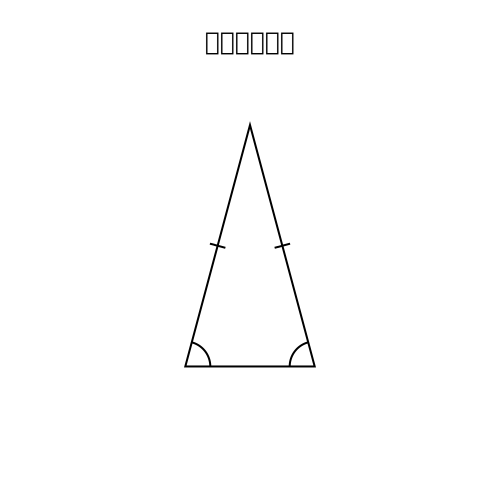

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

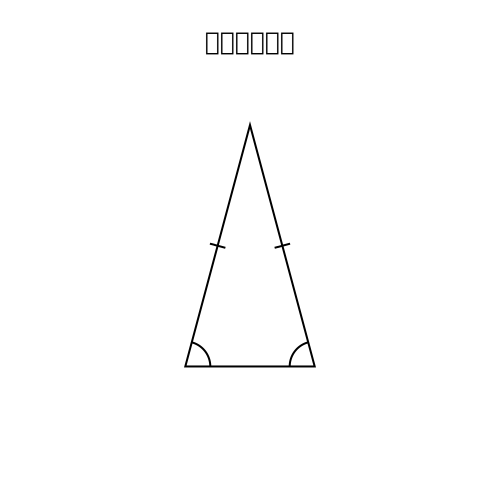

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

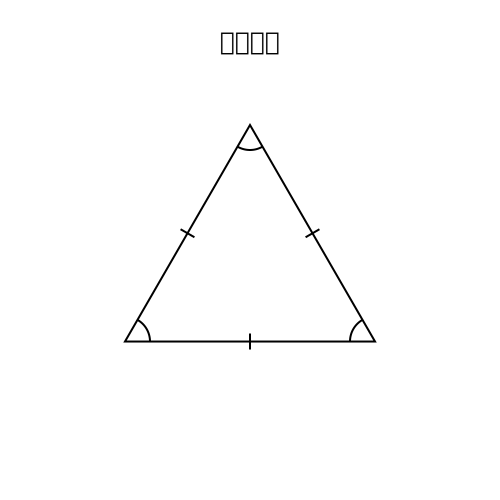

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

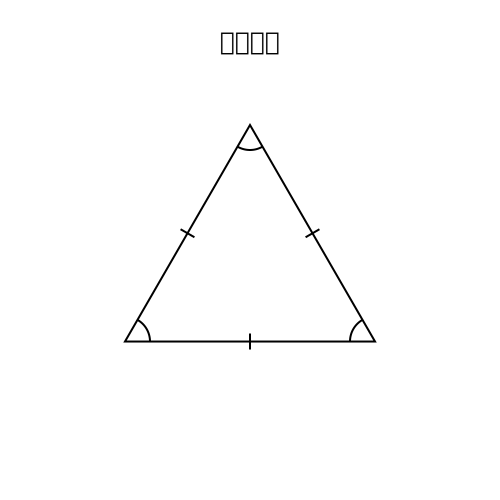

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

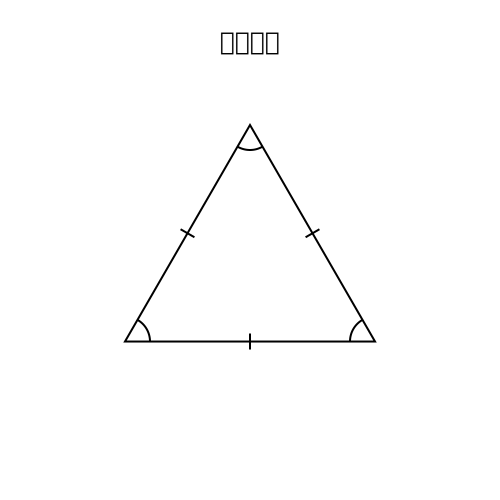

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


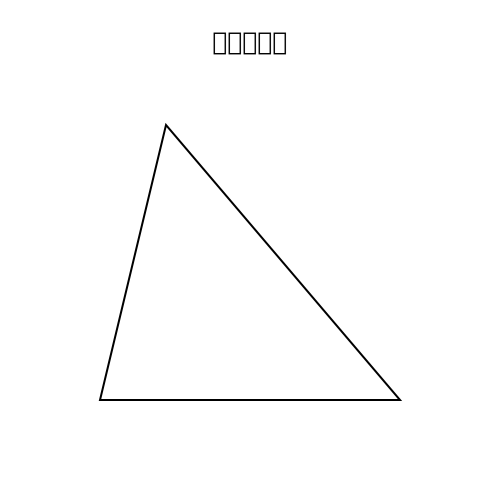

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

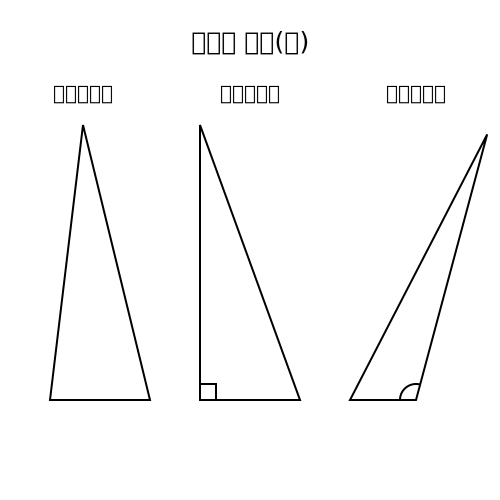

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


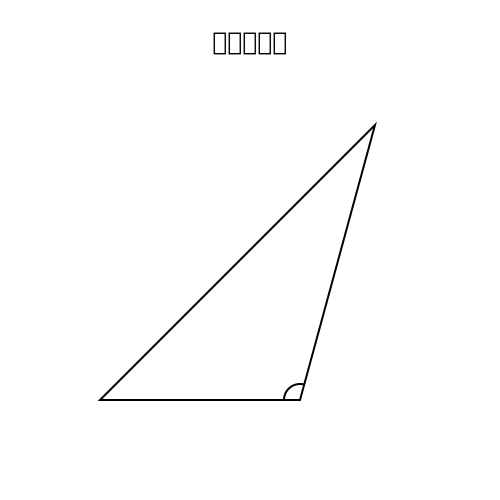

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

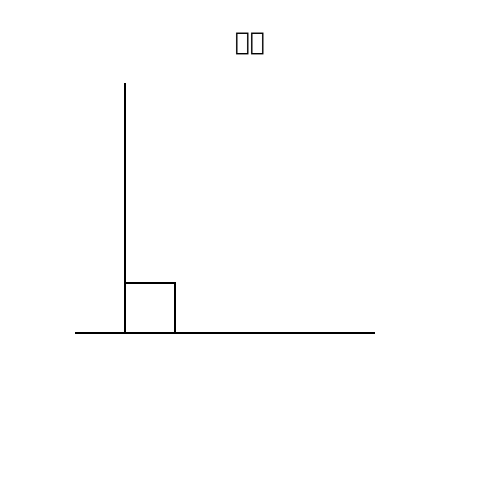

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

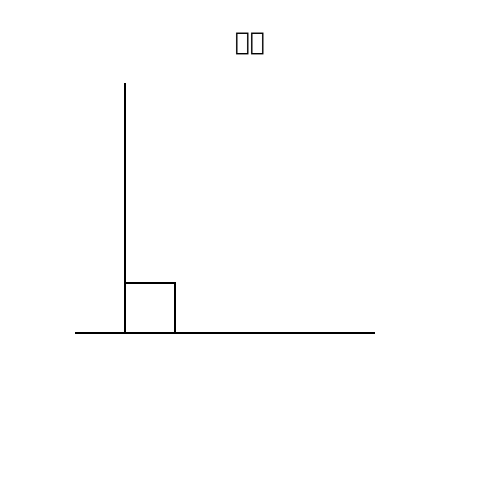

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

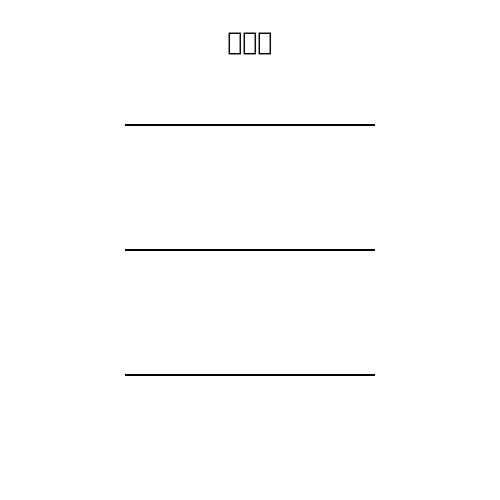

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

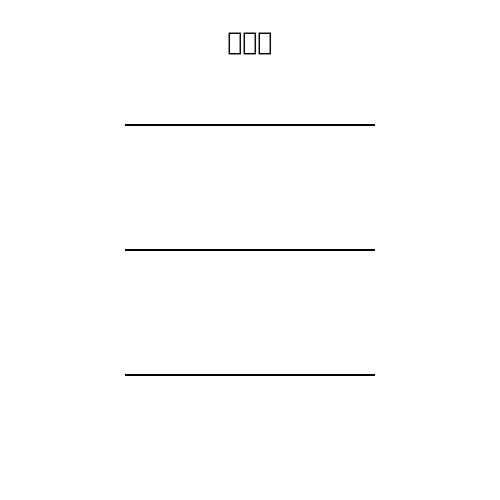

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


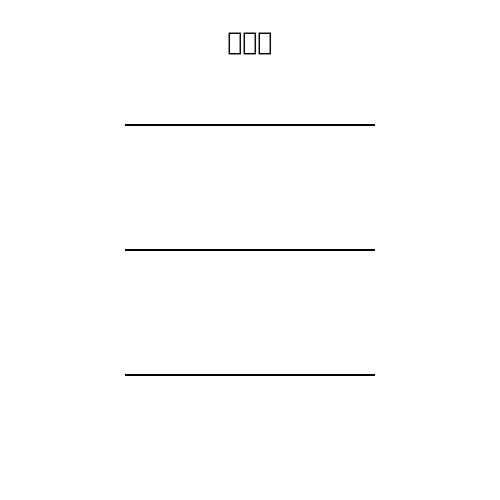

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

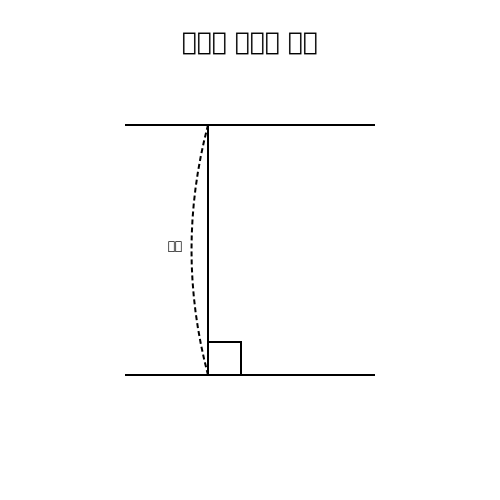

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

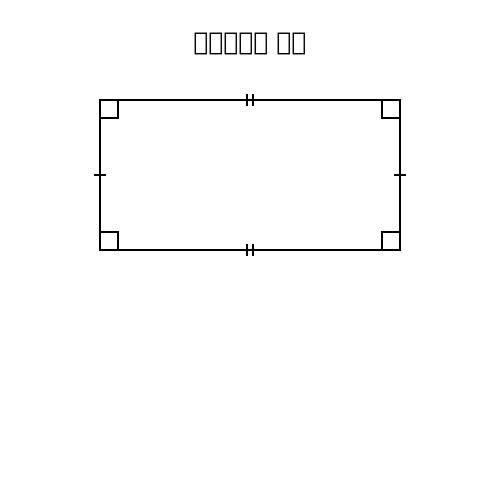

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

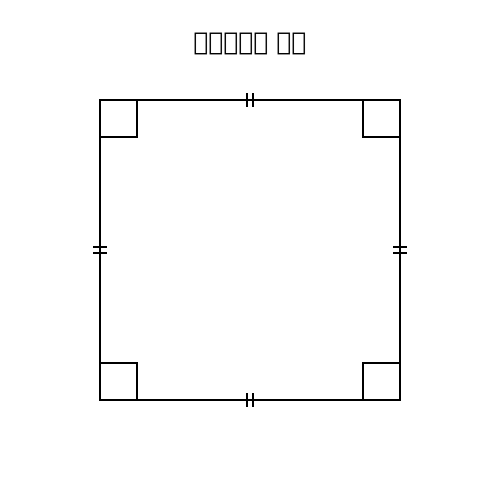

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

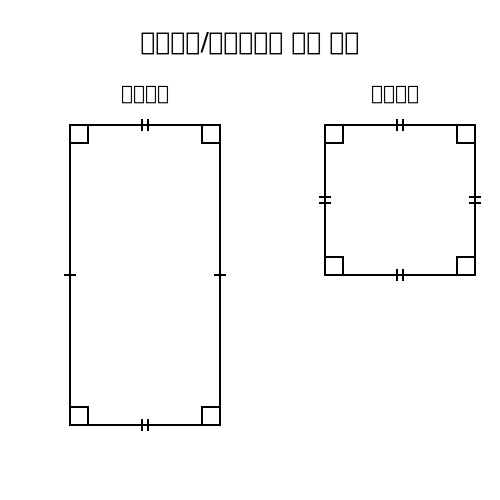

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


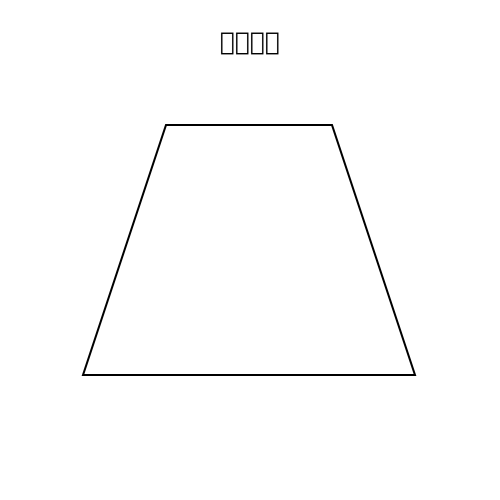

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

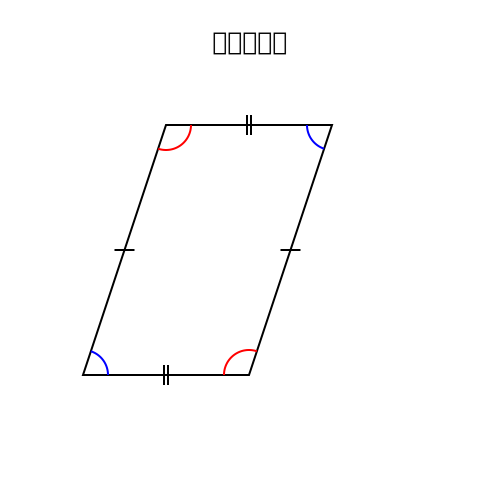

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

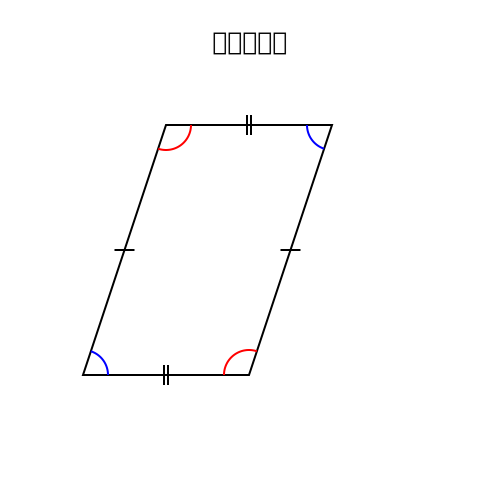

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

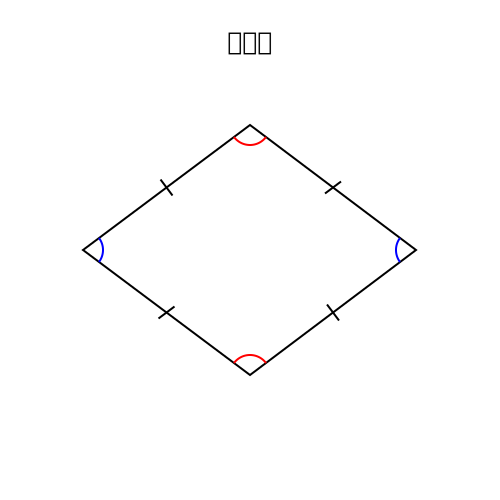

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

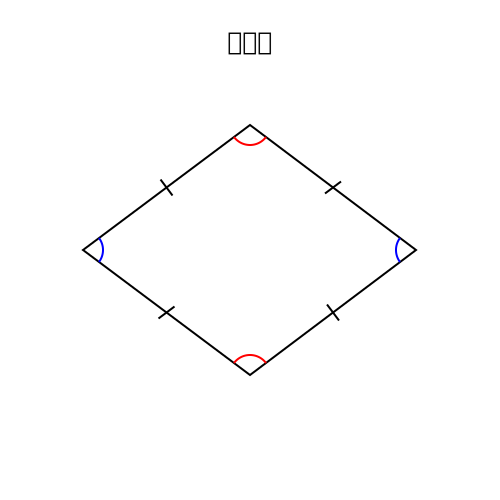

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

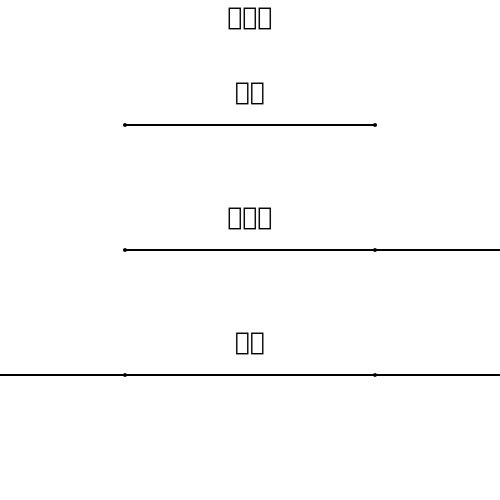

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="374.847706754774" y2="324.27512582437475" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.96954135095478,331.25502516487495 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="187.49048094727445" y="331.9092245976698" font-size="12" text-anchor="middle">2°</text>
        </svg>
        


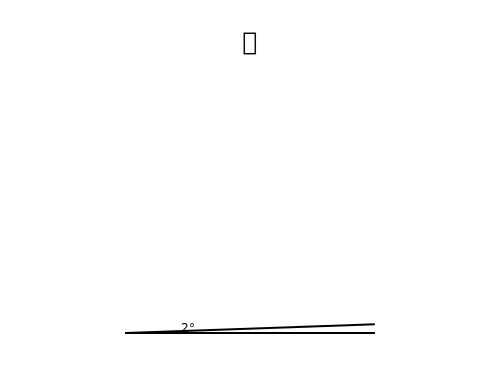

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

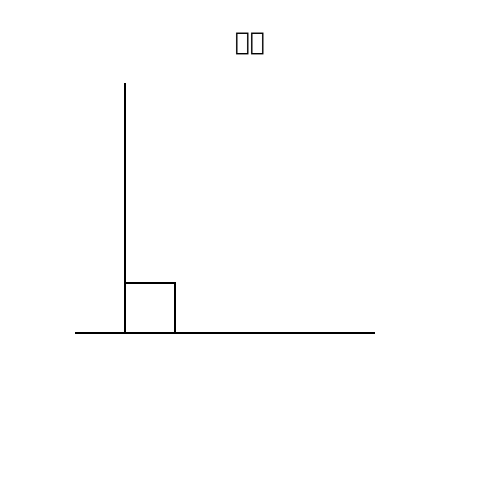

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


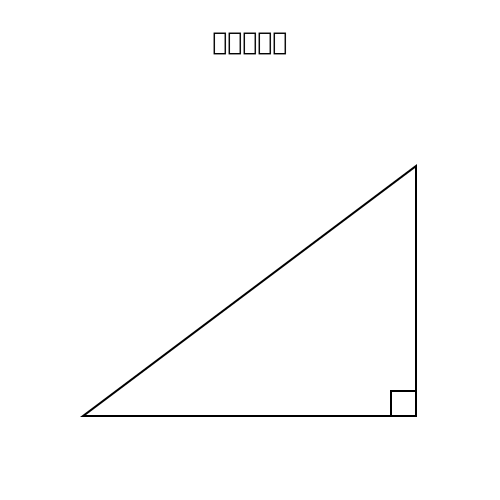

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


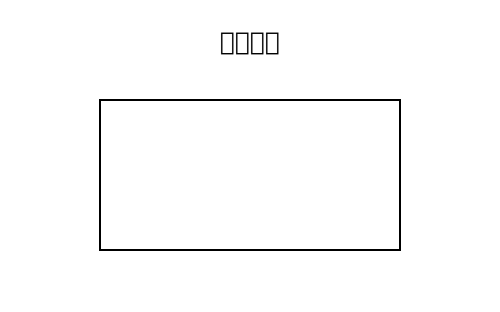

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


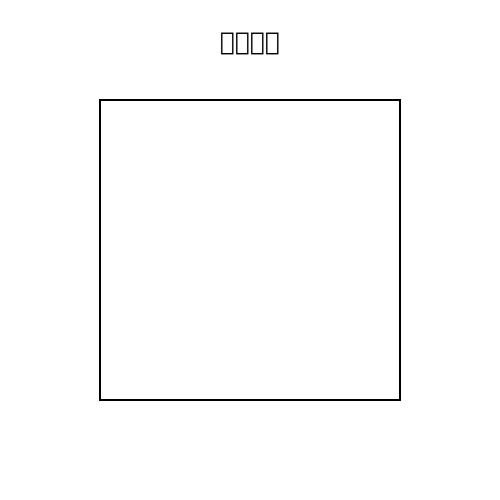

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


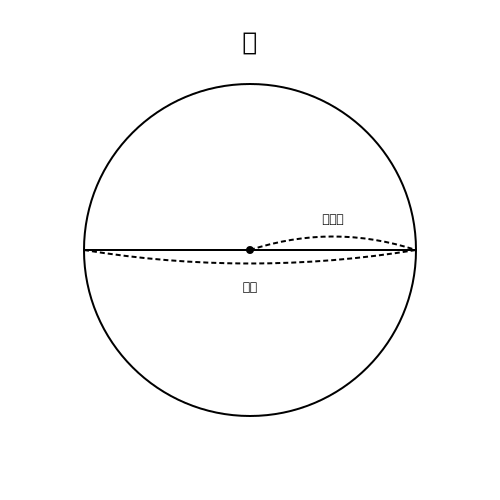

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


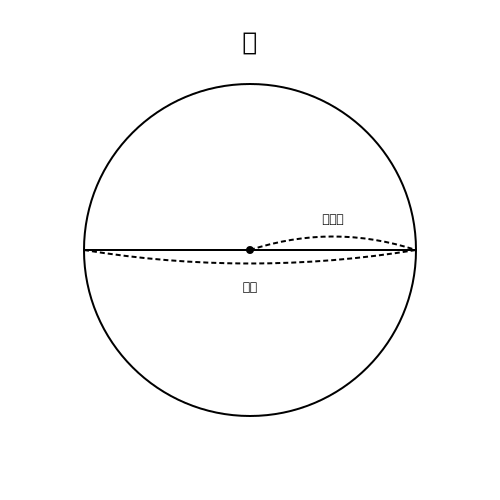

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

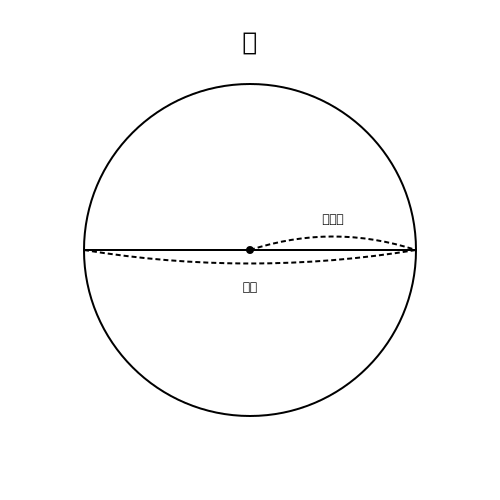

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

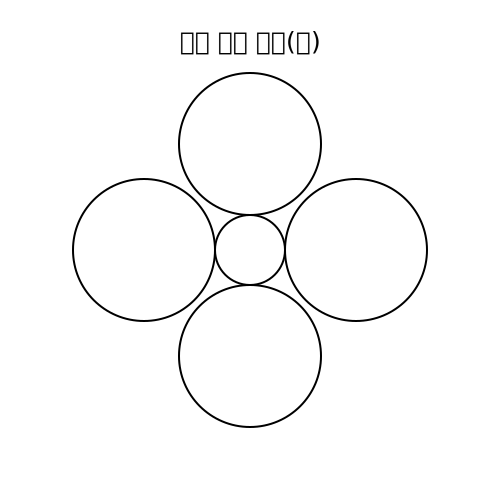

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="367.5739315689991" y2="272.51952610008306" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 173.51478631379982,320.9039052200166 A 50,50 0 0,1 175,333" stroke=

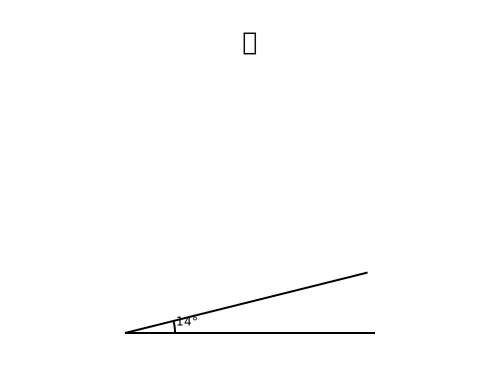

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="193.9093389542498" y2="92.68457601542028" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 138.78186779084996,284.936915203084 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>


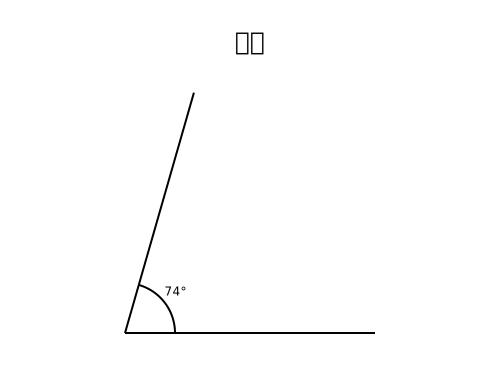

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="218.65164835397798" y2="101.20403635830314" stroke="black" strok

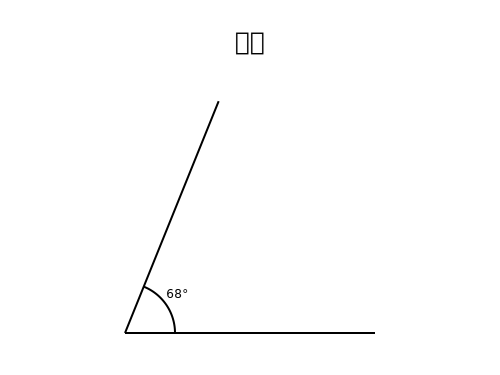

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="129.3631016093209" y2="83.03807621090218" stroke="black" stroke-width="2" />
 

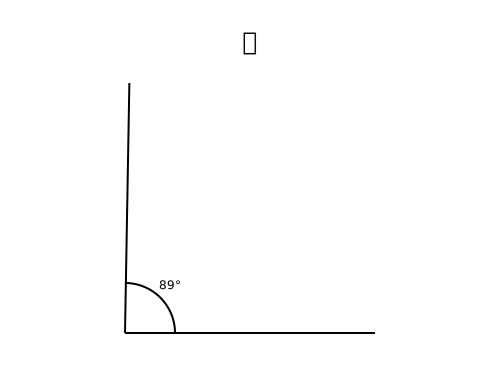

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="224.68394534823636" y2="89.63155089263414" stroke="black" stroke-width

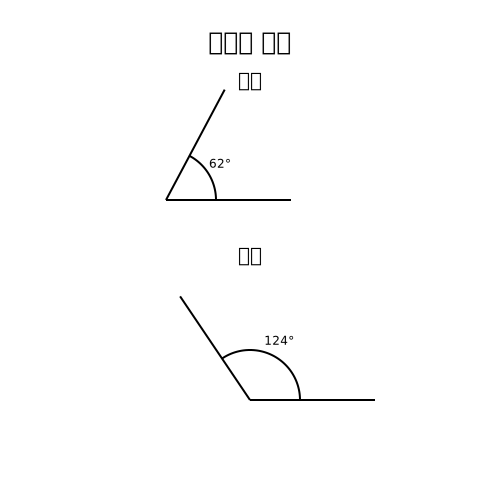

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="374.0486745229364" y2="311.21106431308544" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.8097349045873,328.642

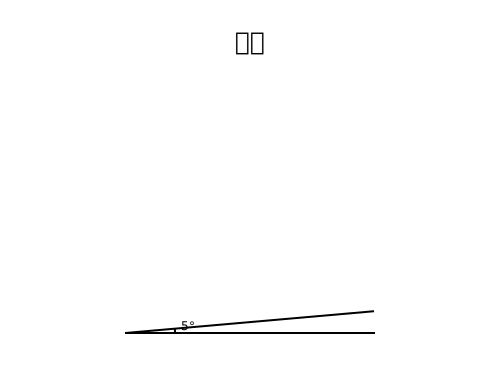

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

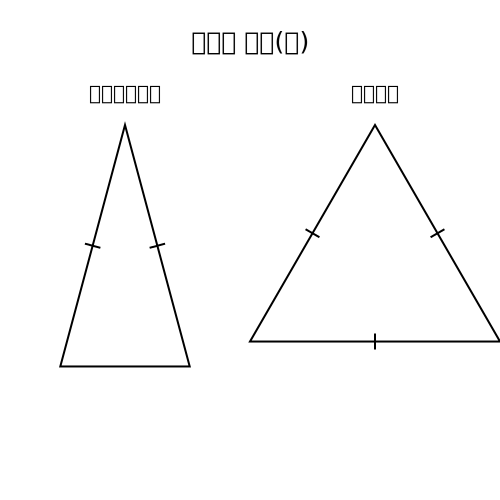

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

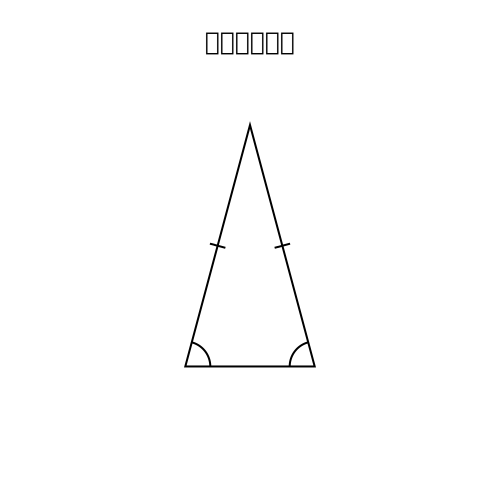

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

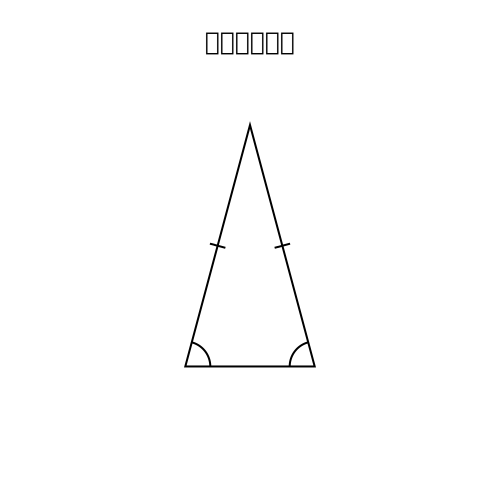

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

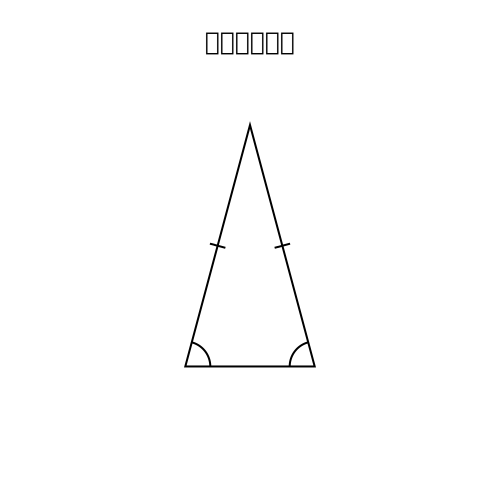

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

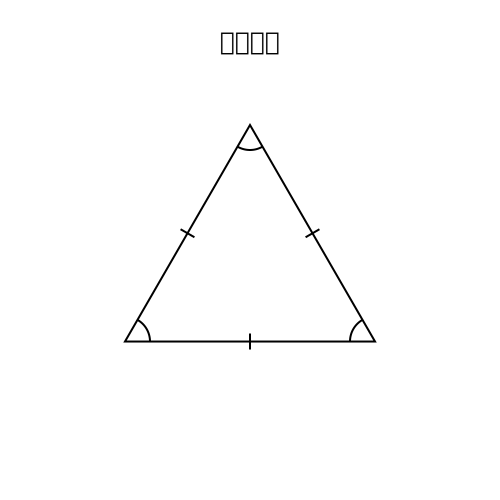

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

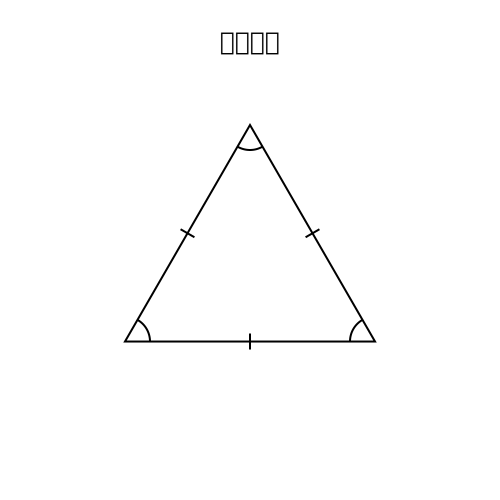

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

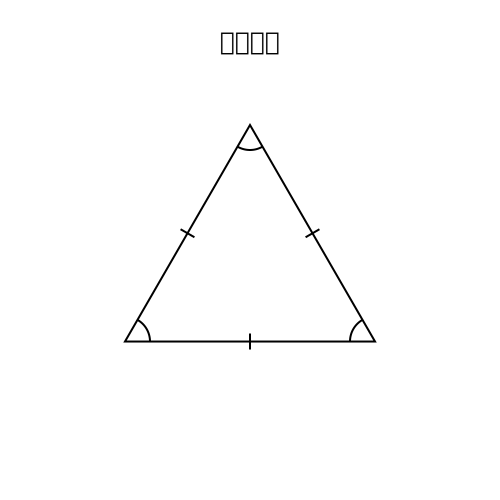

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


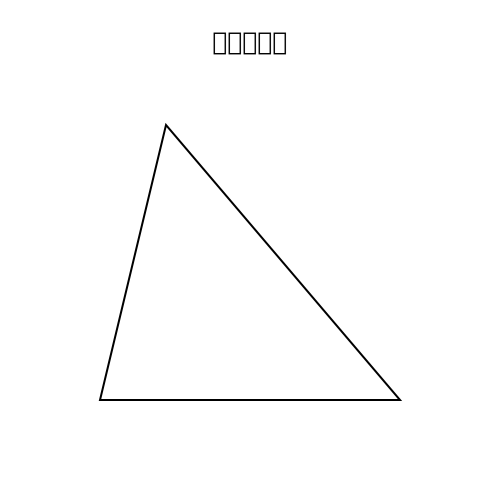

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

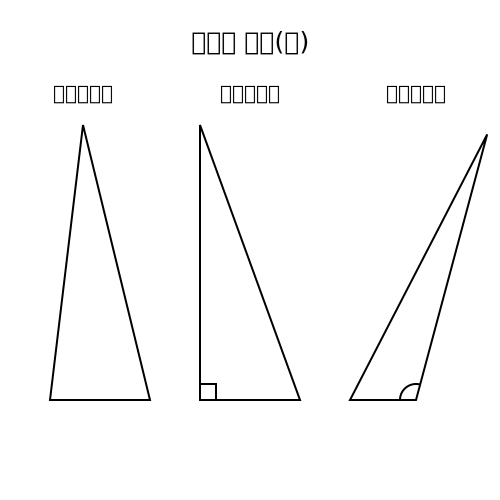

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


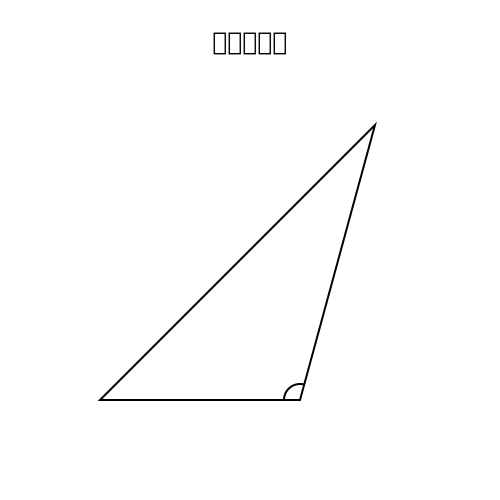

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

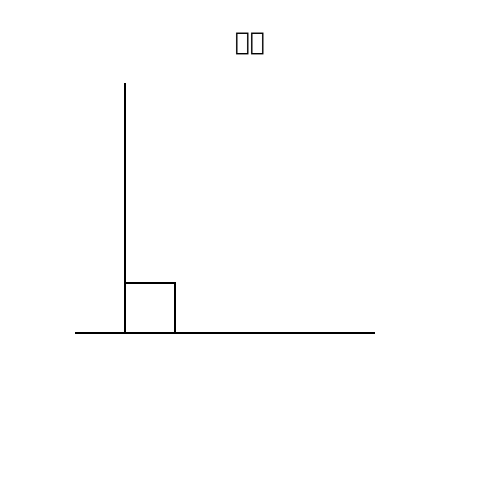

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

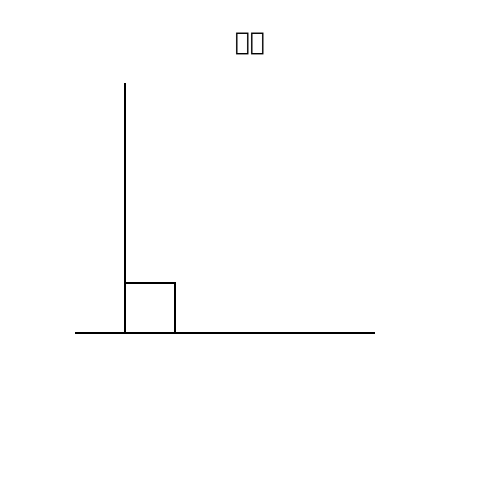

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

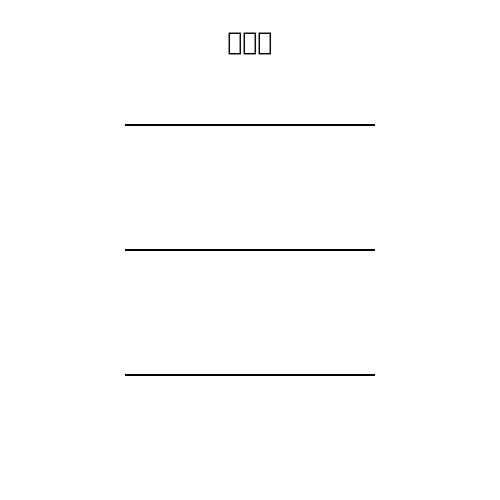

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

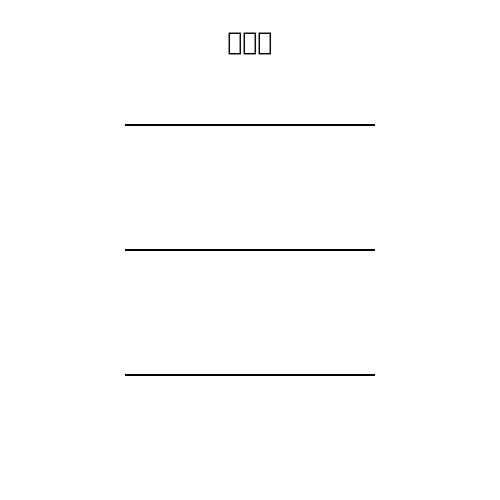

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


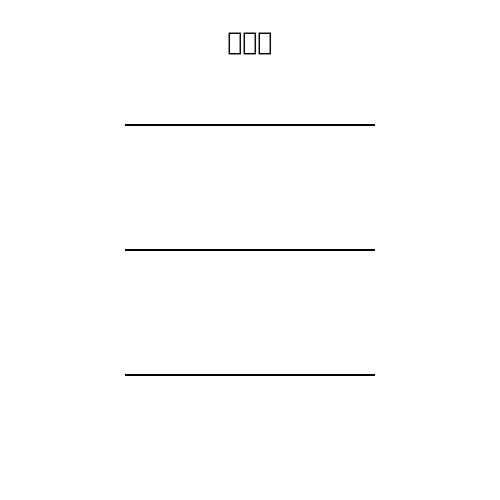

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

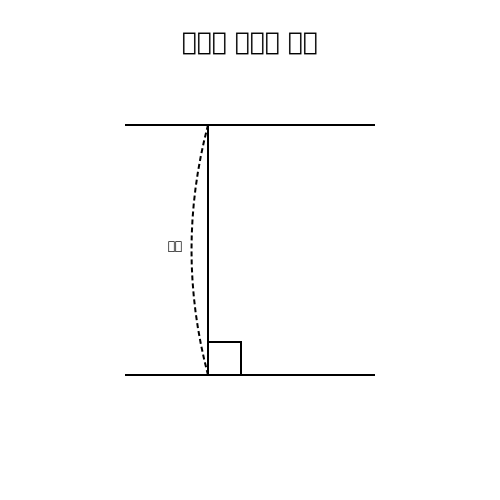

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

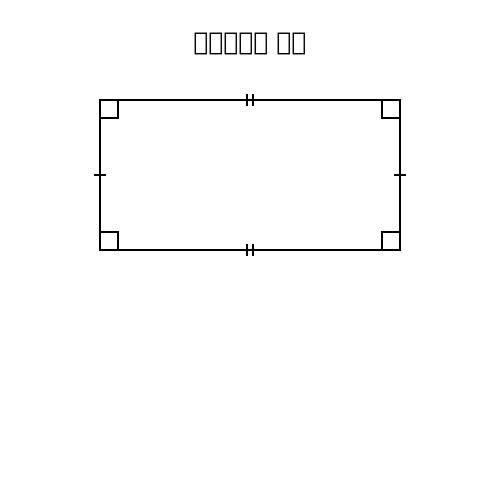

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

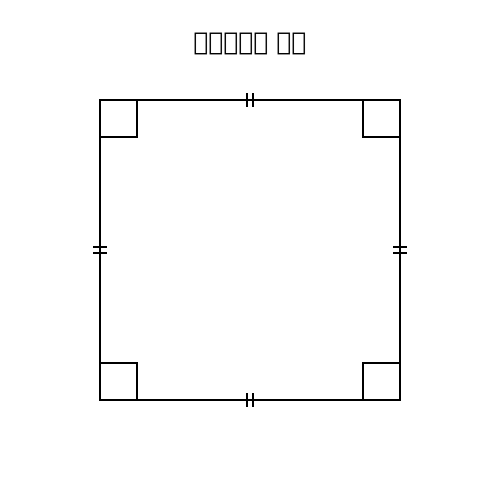

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

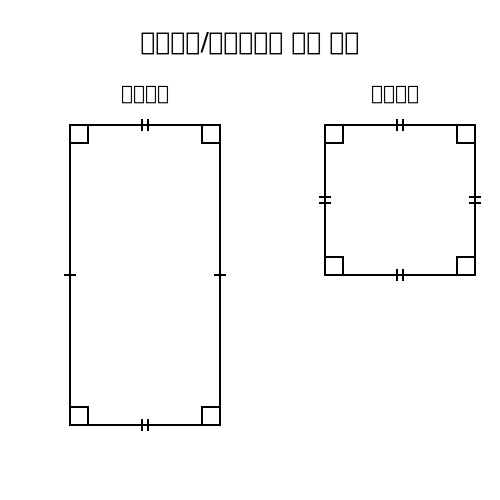

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


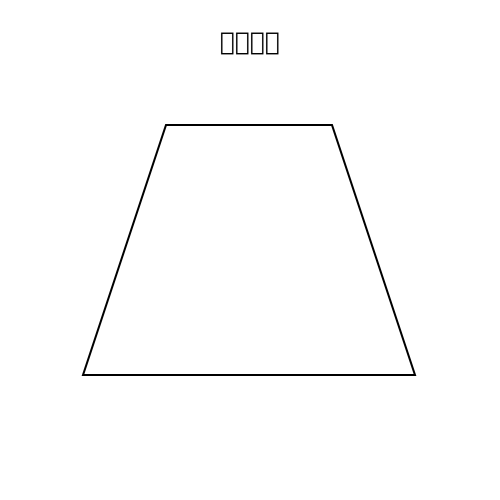

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

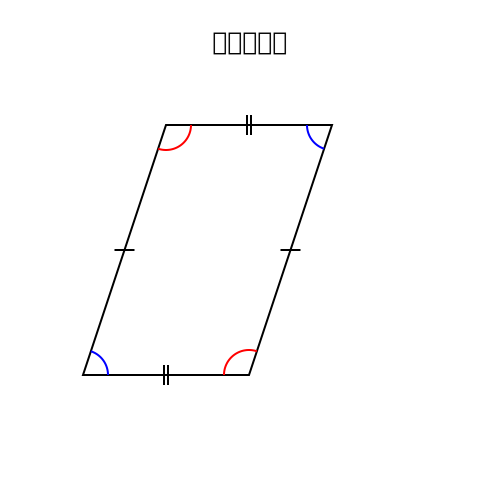

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

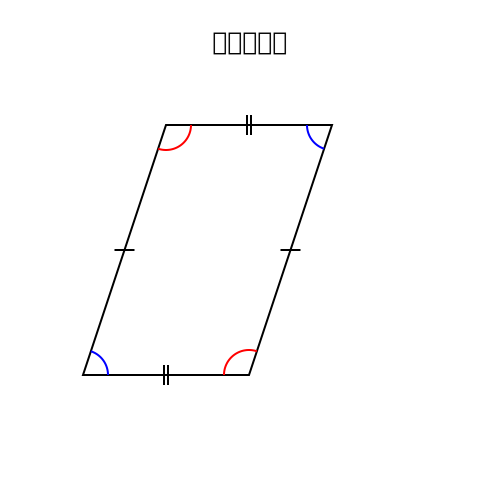

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

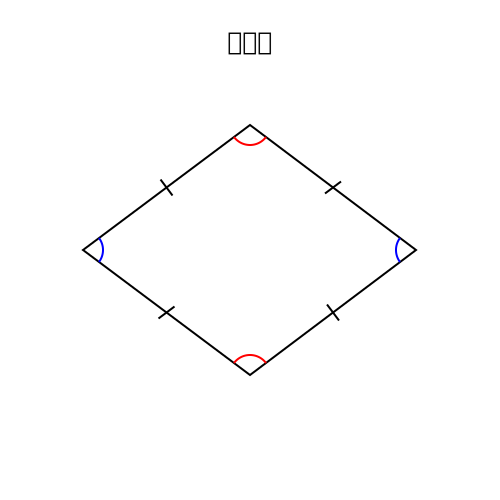

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

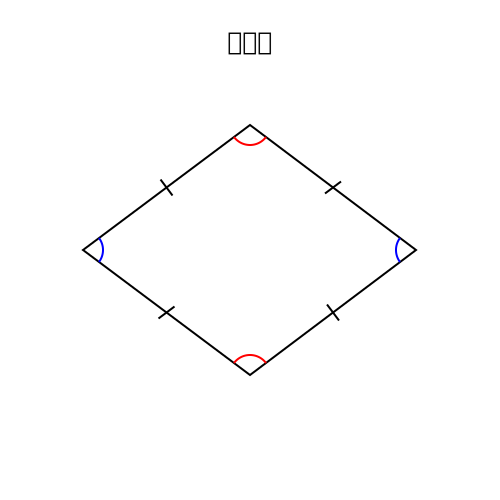

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

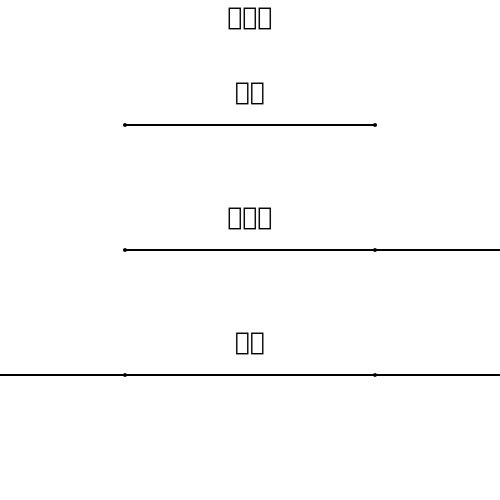

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="349.6985115747917" y2="223.40721330273067" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 169.93970231495837,311.08144266054614 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="185.8981290490772" y="318.94055910350846" font-size="12" text-anchor="middle">26°</text>
        </svg>
        


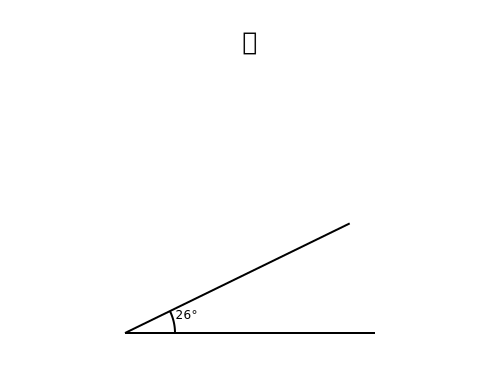

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

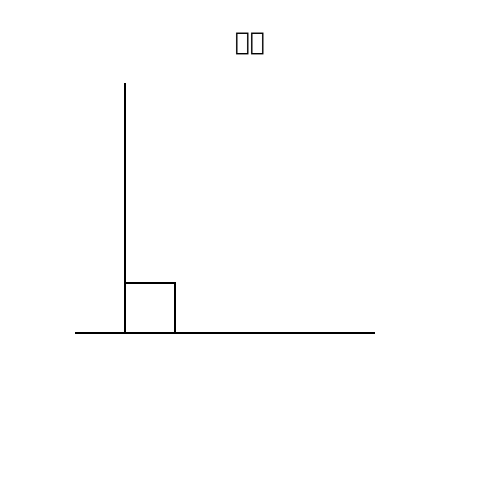

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


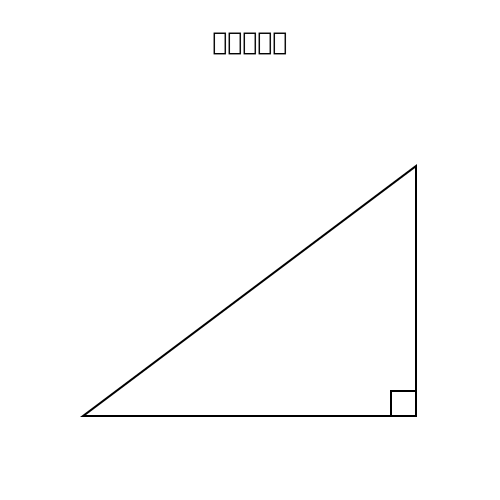

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


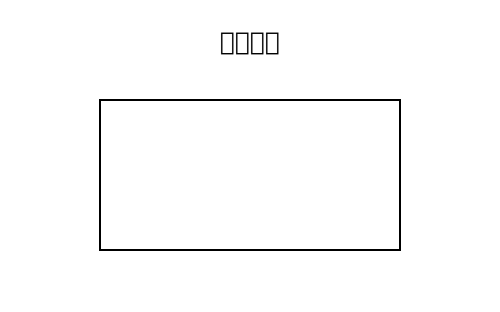

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


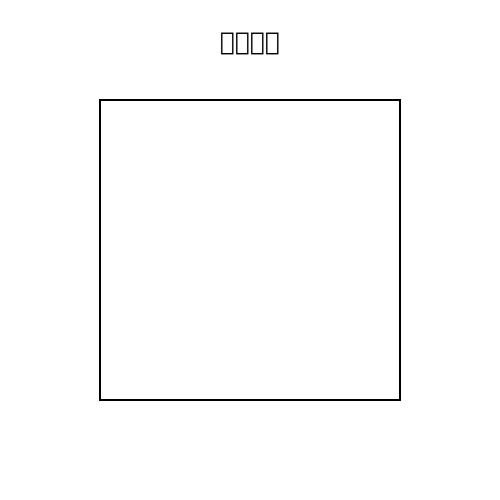

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


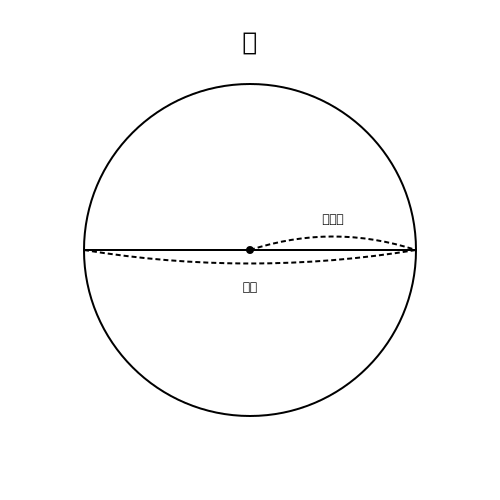

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


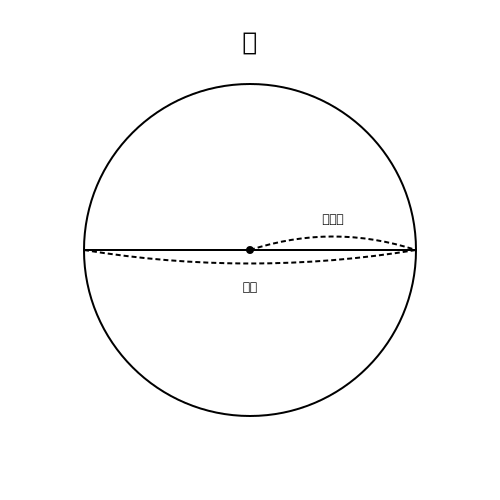

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

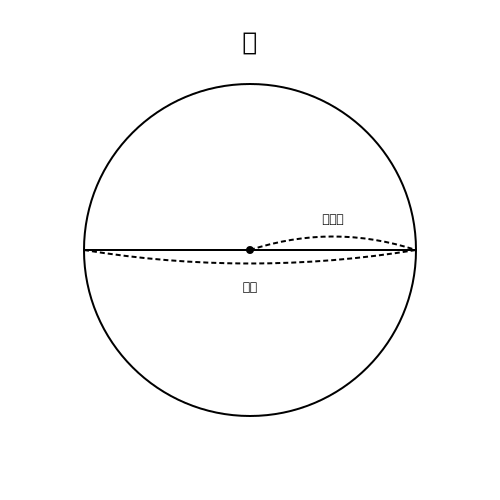

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

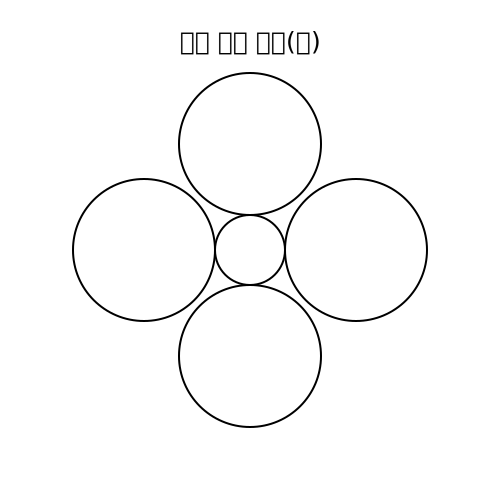

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="301.7766952966369" y2="156.22330470336314" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 160.35533905932738,297.6446609406726 A 50,50 0 0,1 175,333" stroke=

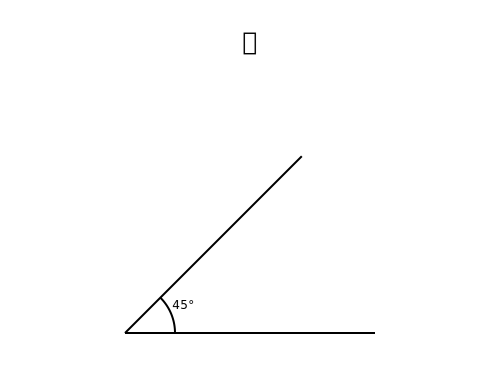

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="37.98797596089352" y2="200.52018394169878" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 207.5975951921787,306.50403678833976 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/

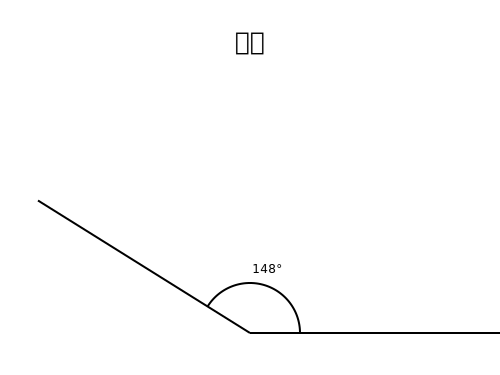

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="0.3426163113565508" y2="319.916010939264" stroke="black" stroke-

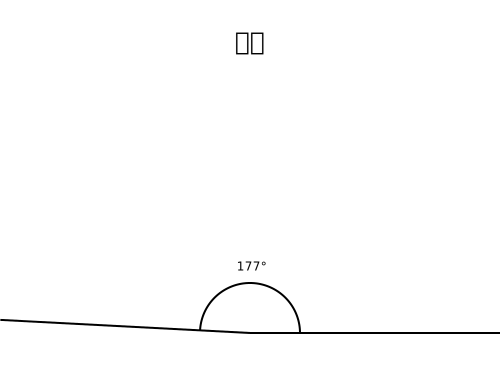

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="219.53266414871317" y2="84.86346208966947" stroke="black" stroke-width="2" />


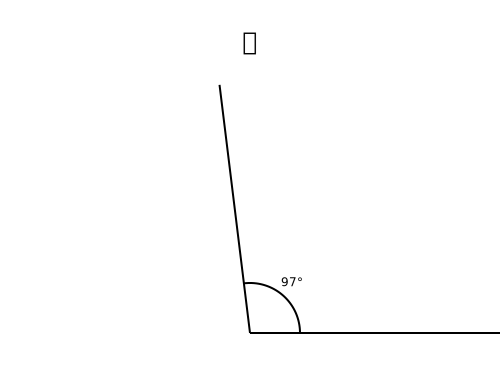

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="208.7525179157086" y2="82.53842240176147" stroke="black" stroke-width=

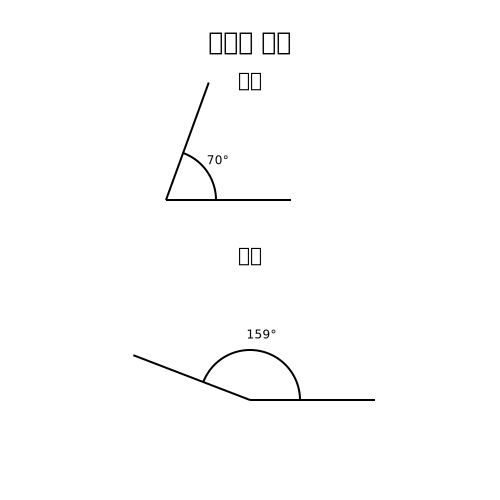

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="121.24048127248642" y2="118.70817482447191" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 224.24809625449728,290.1

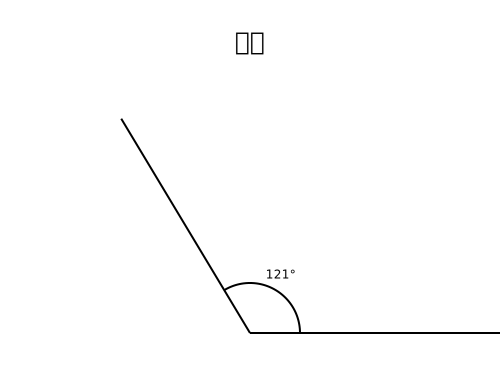

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

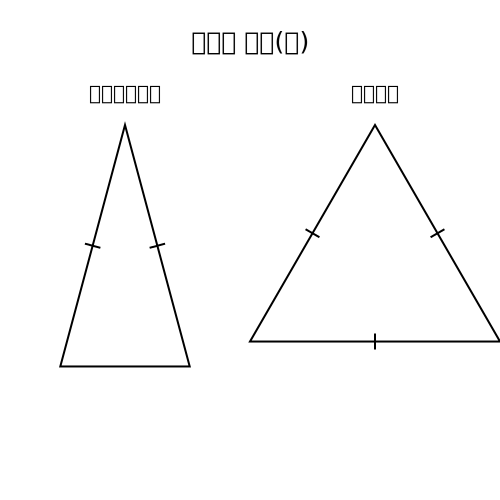

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

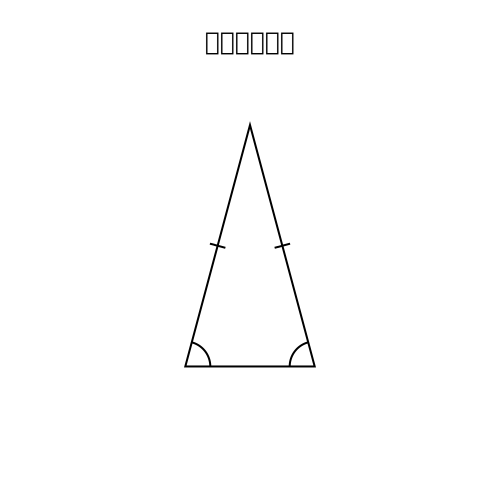

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

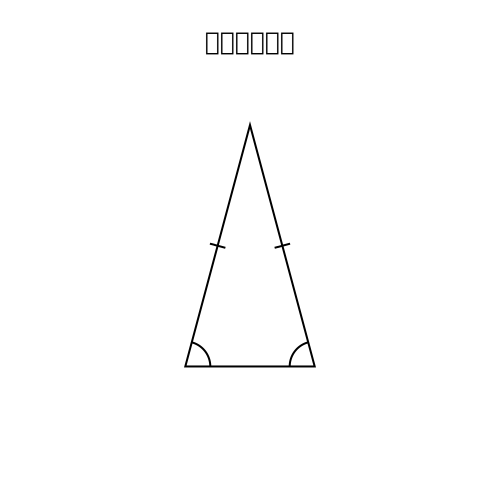

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

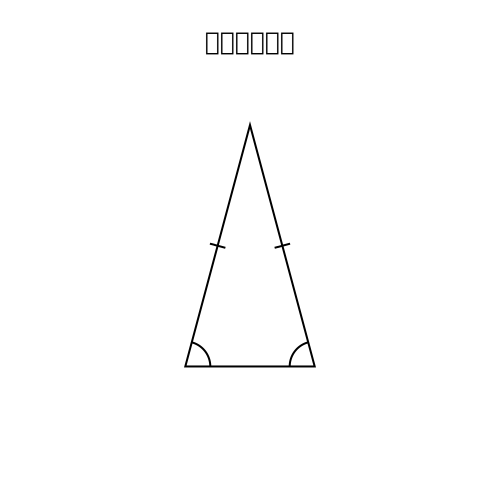

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

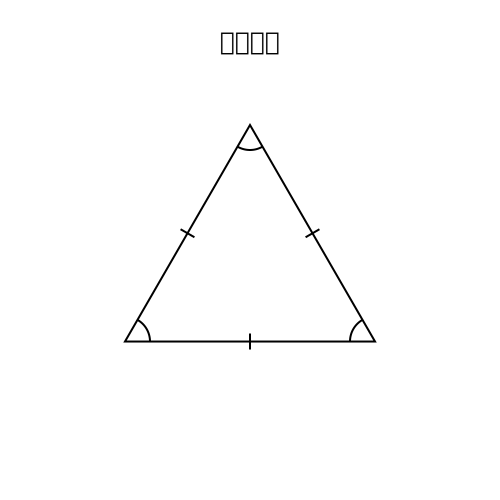

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

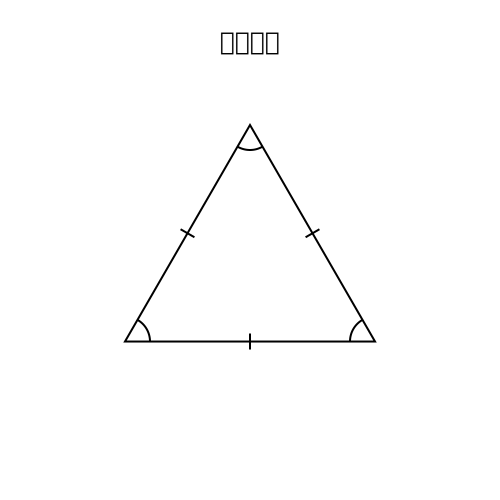

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

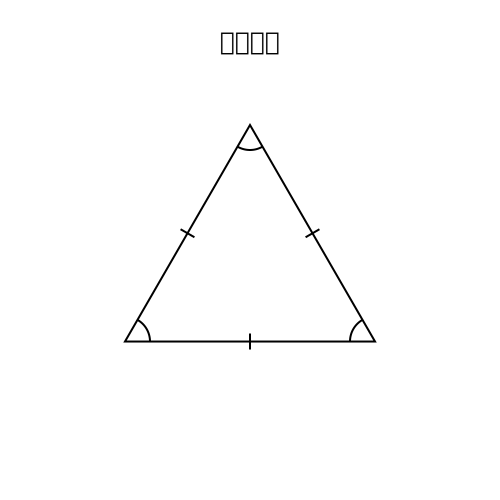

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


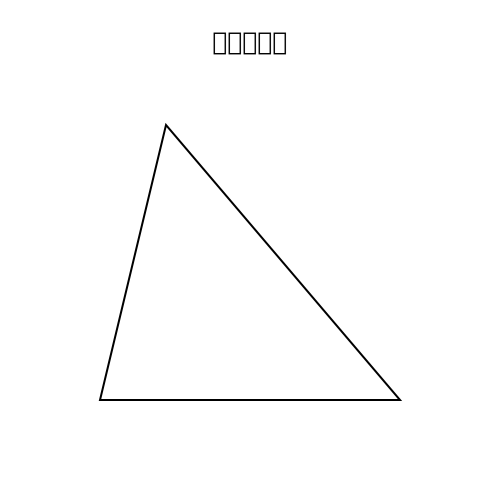

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

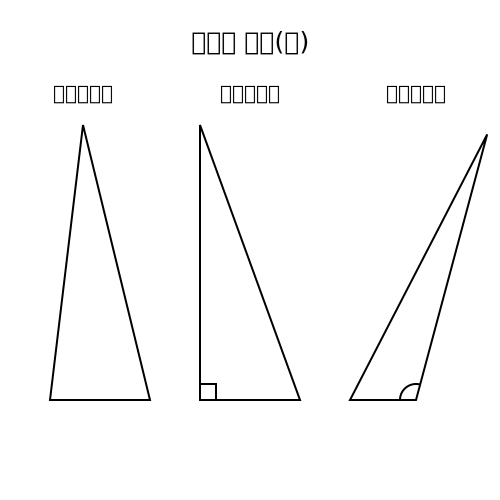

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


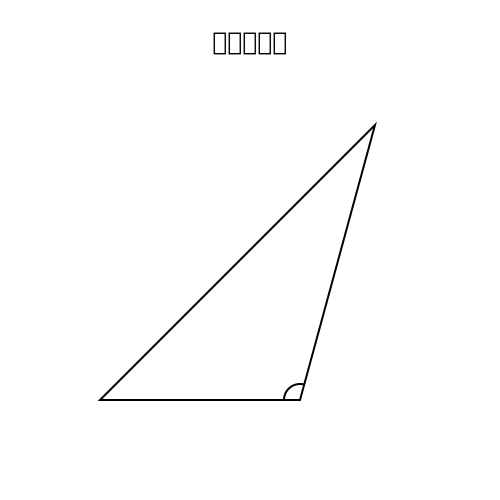

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

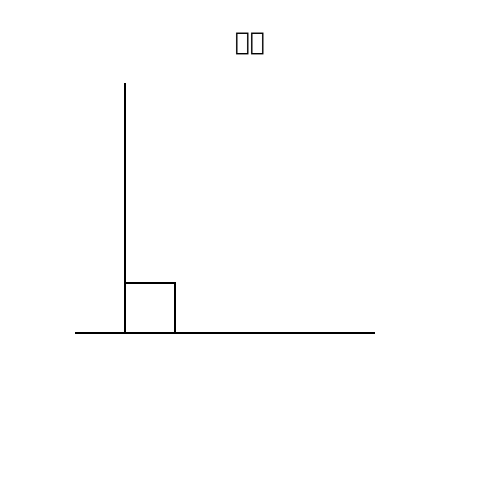

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

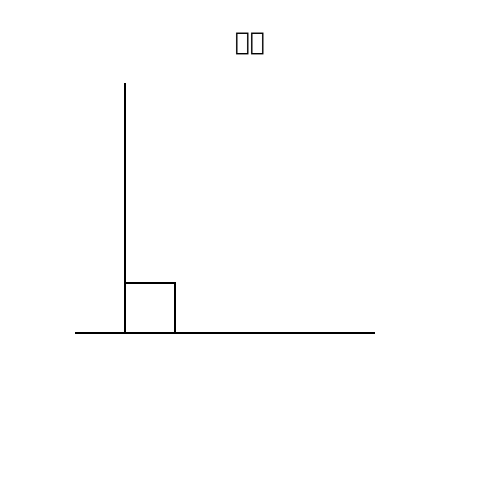

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

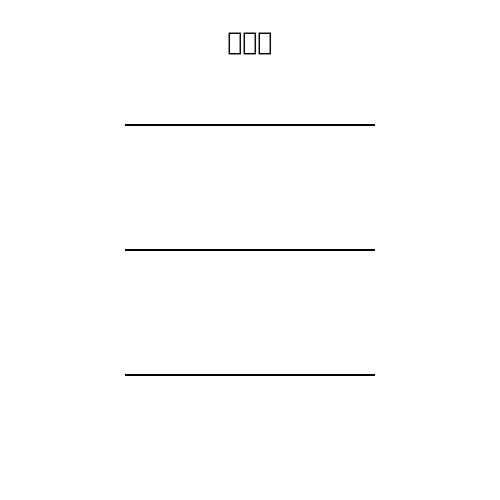

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

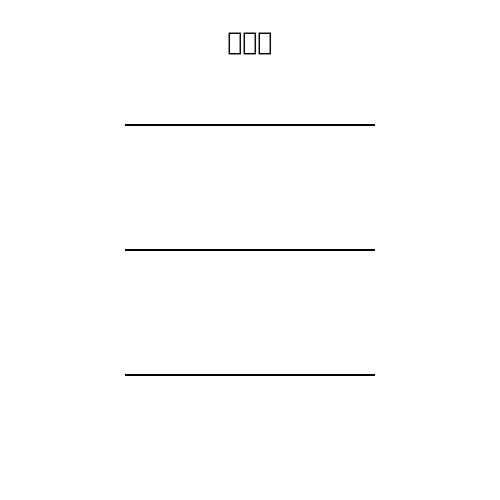

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


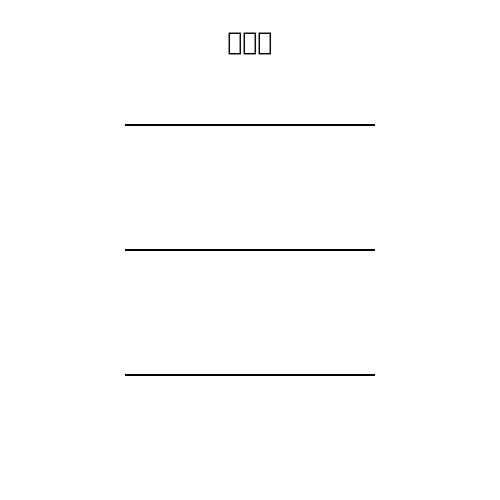

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

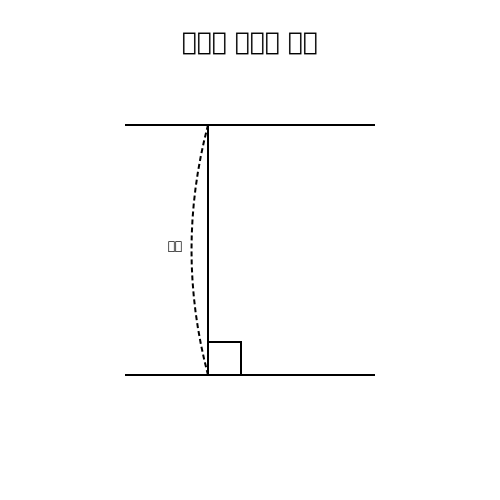

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

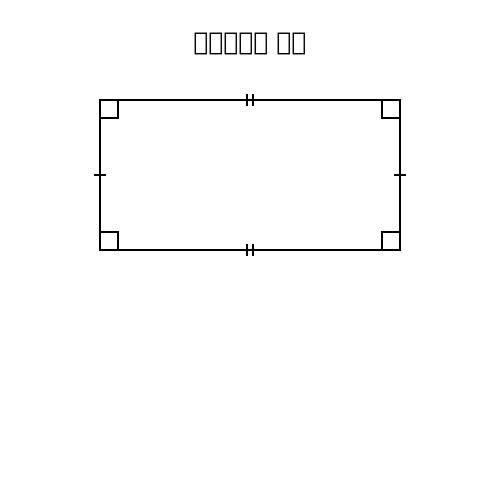

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

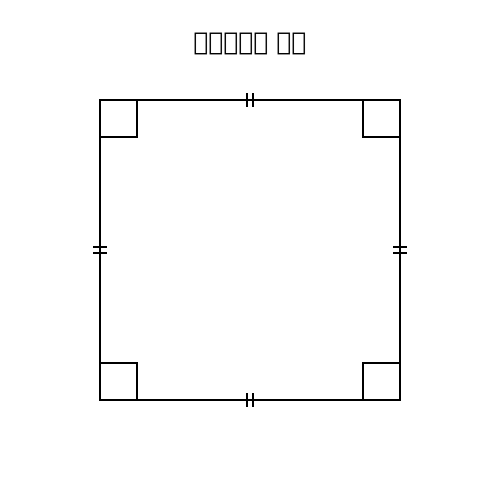

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

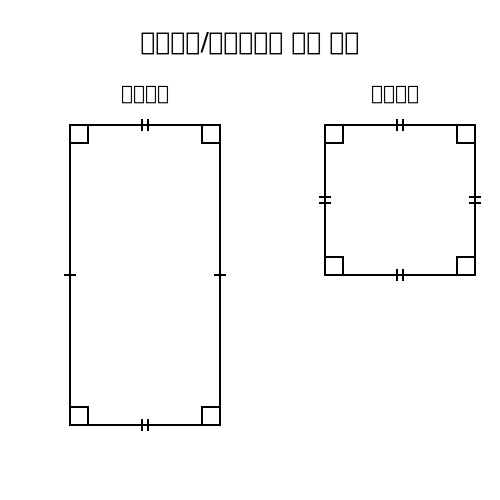

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


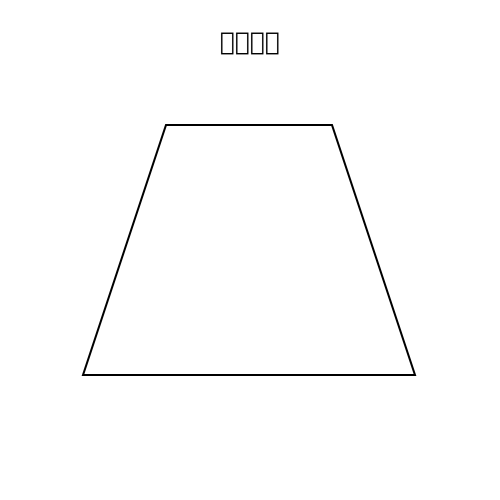

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

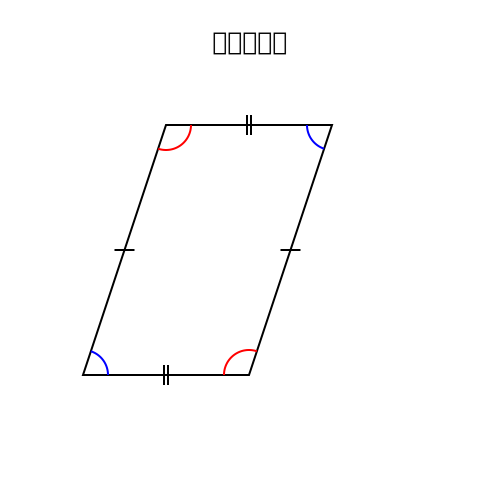

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

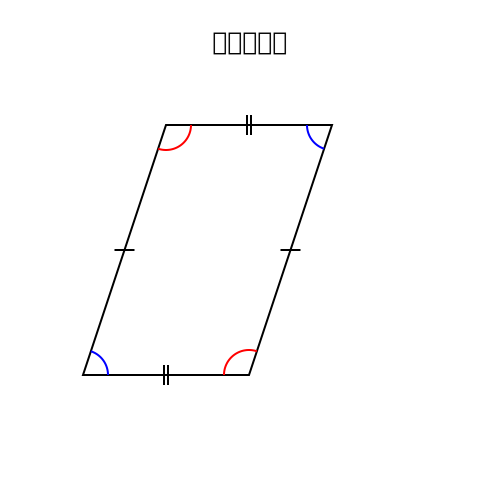

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

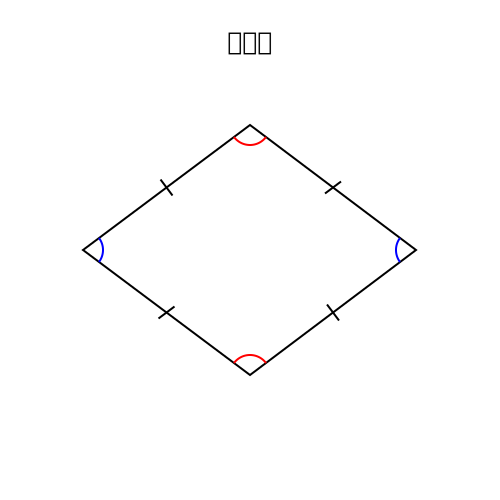

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

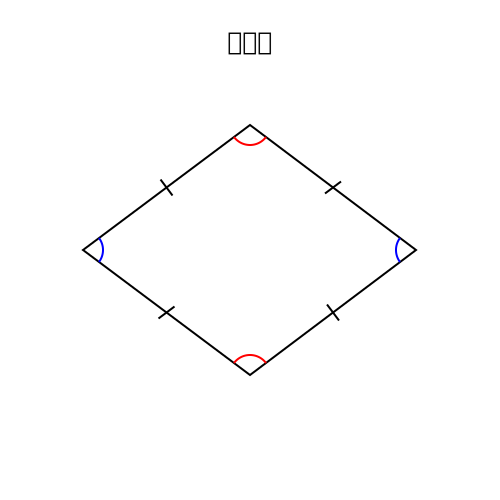

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

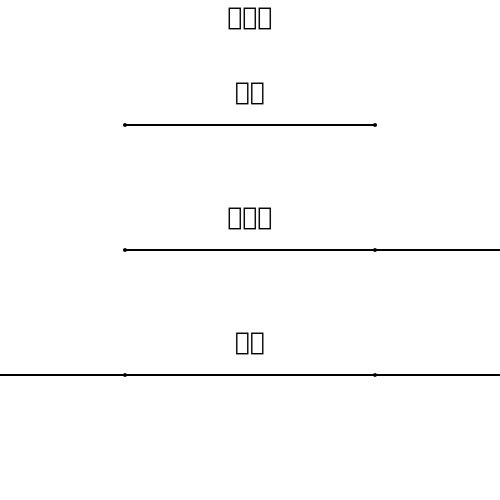

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="52.99731159831953" y2="179.0846311685854" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 210.5994623196639,302.21692623371706 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="270.3480096535723" y="273.9050890250427" font-size="12" text-anchor="middle">142°</text>
        </svg>
        


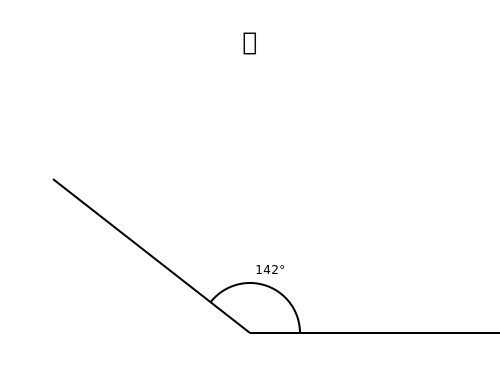

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

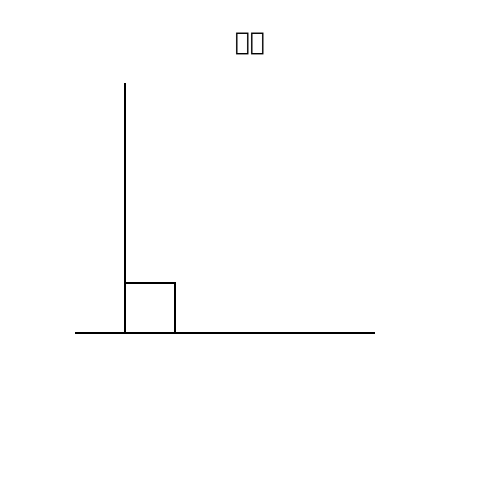

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


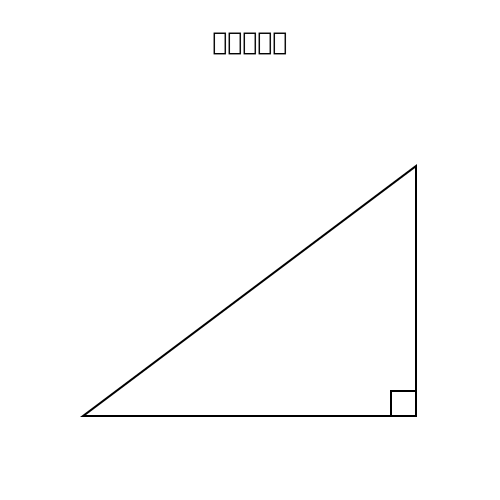

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


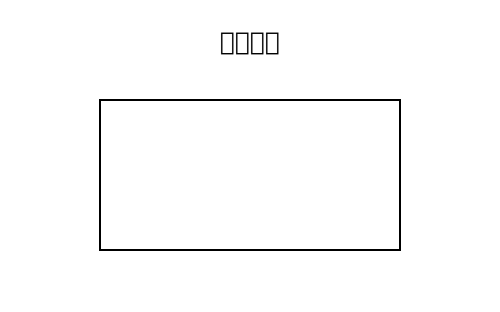

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


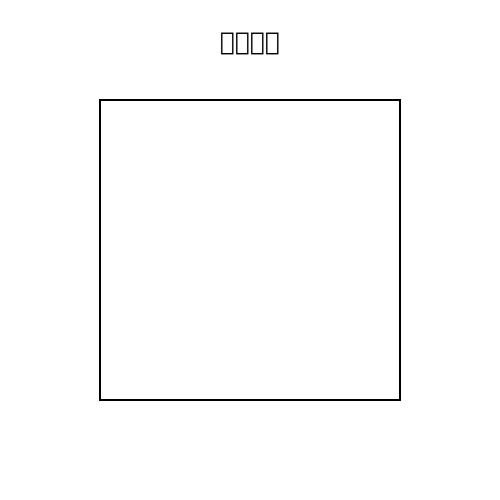

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


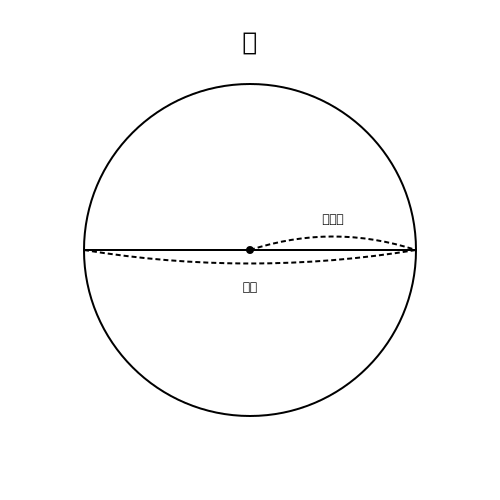

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


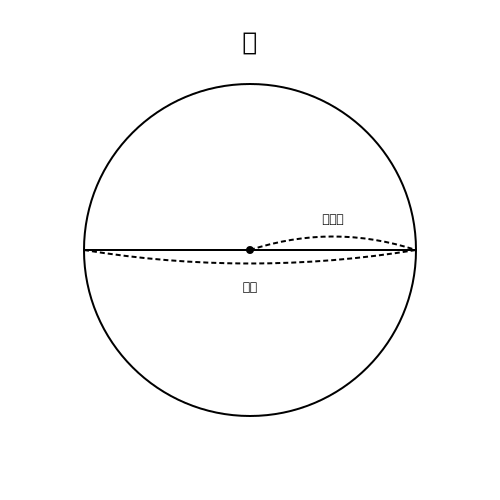

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

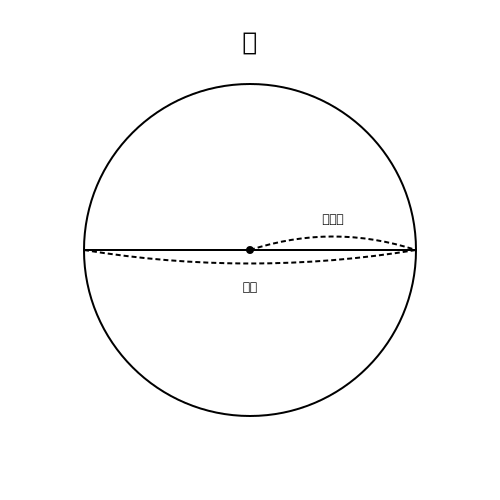

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

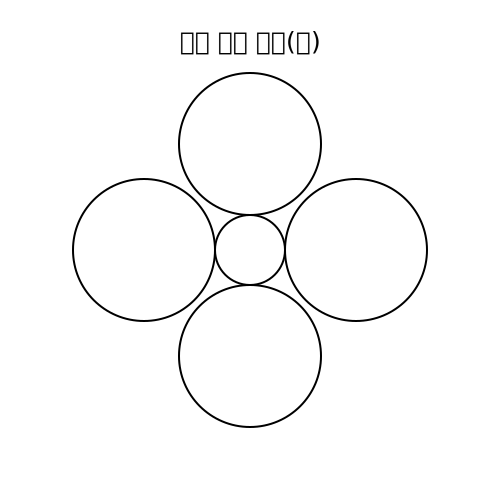

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="58.488889220255516" y2="172.30309757836514" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 211.6977778440511,300.860619515673 A 50,50 0 0,1 300,333" stroke="

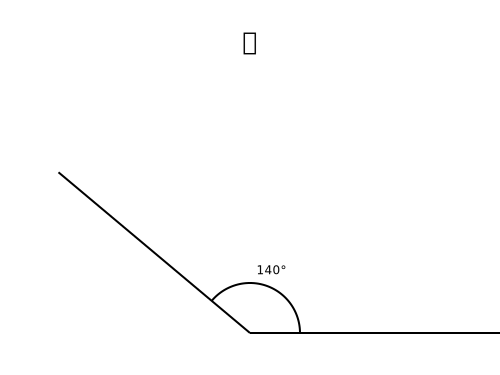

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="96.08463116858542" y2="135.9973115983195" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 219.2169262337171,293.59946231966387 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>

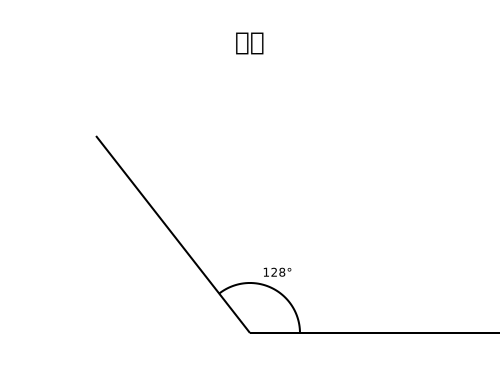

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="359.92315519647707" y2="247.49496416858284" stroke="black" strok

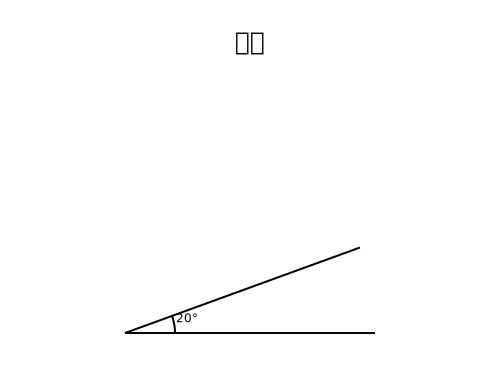

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="355.1262133631101" y2="235.31721787768157" stroke="black" stroke-width="2" />


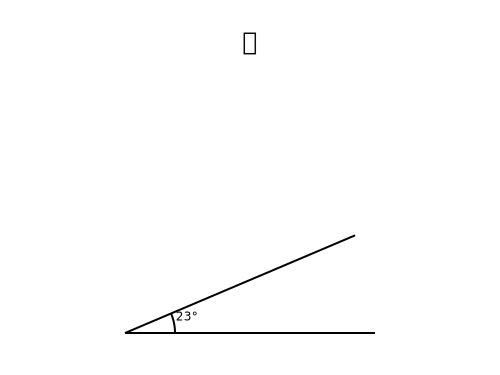

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="255.9174750423314" y2="113.16770369262534" stroke="black" stroke-width

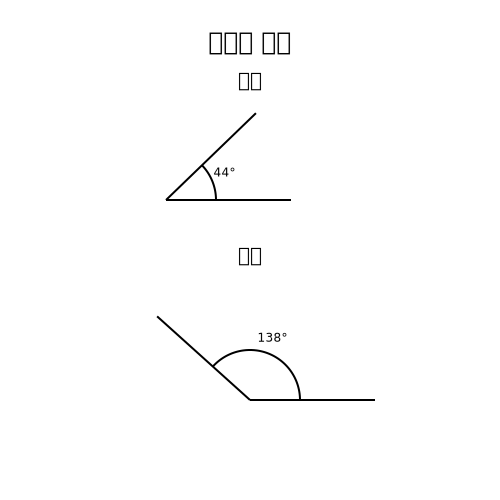

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="374.9619237890978" y2="328.6368983906791" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.99238475781956,332.127

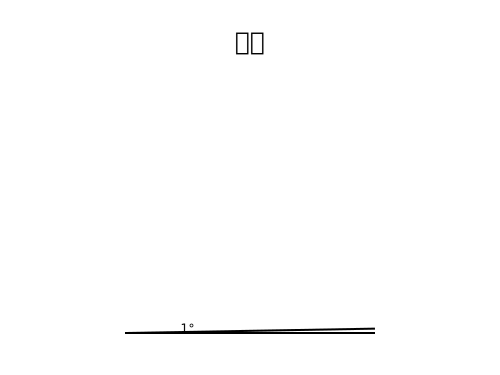

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

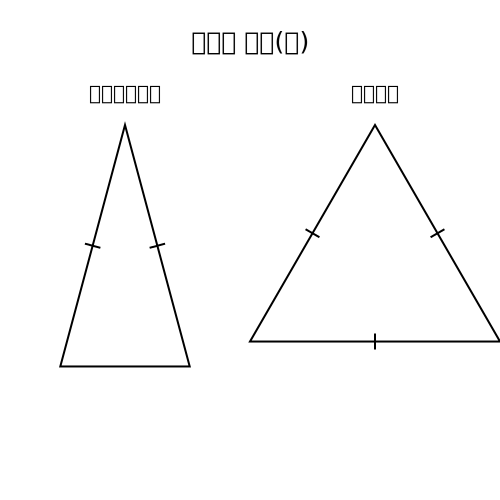

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

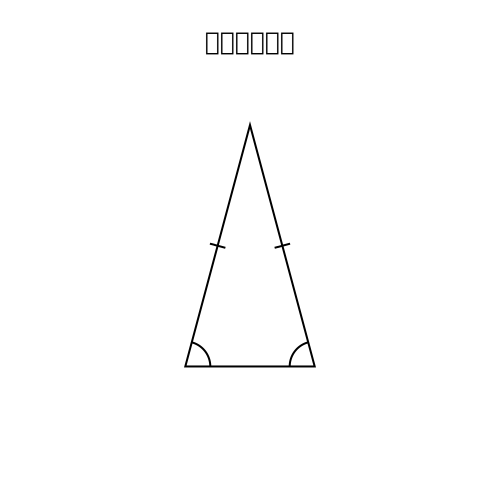

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

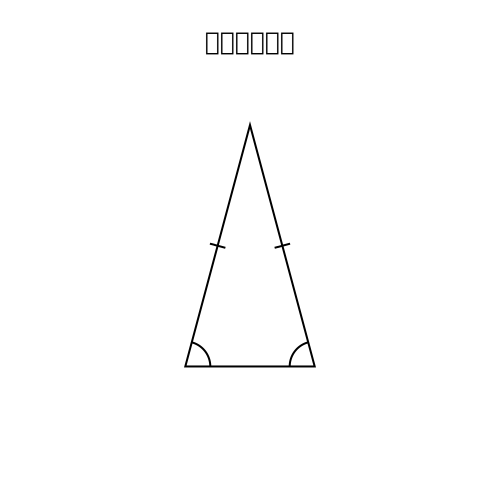

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

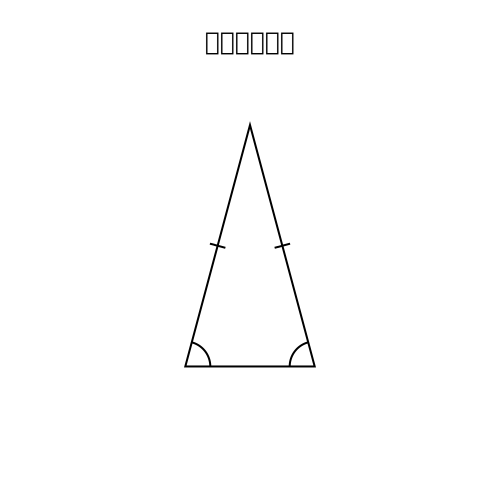

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

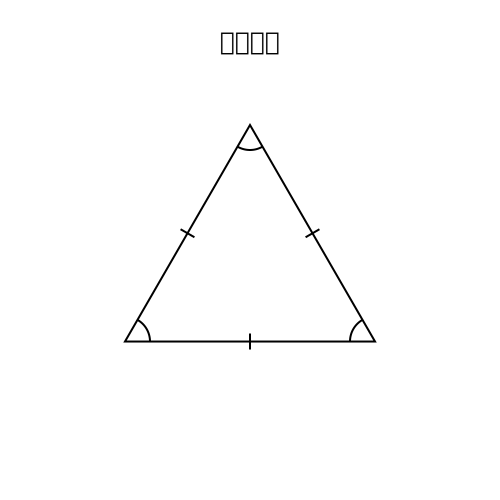

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

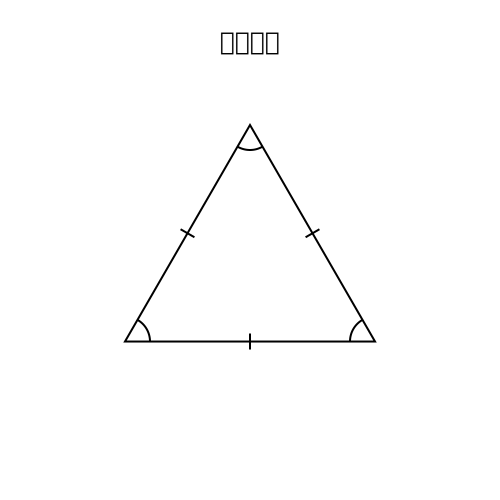

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

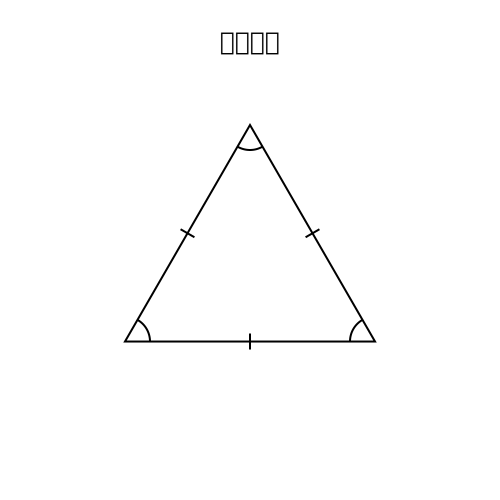

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


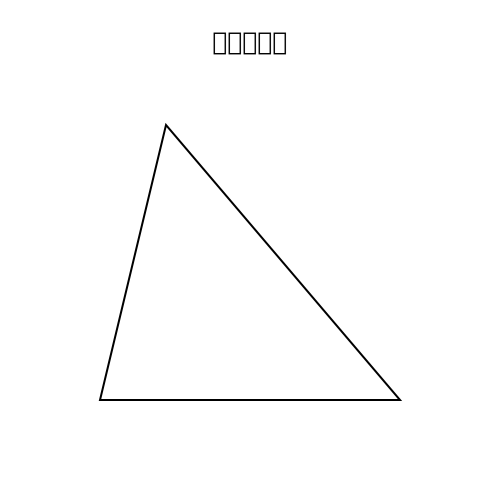

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

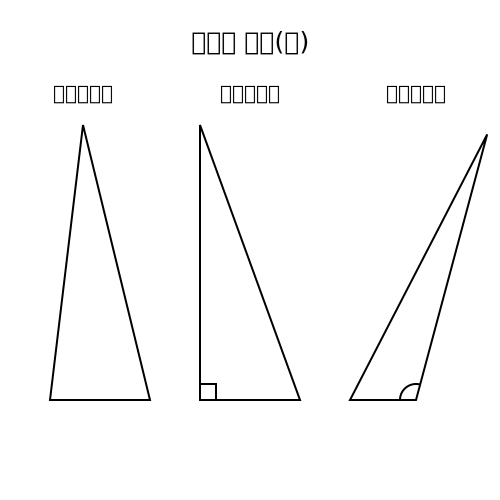

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


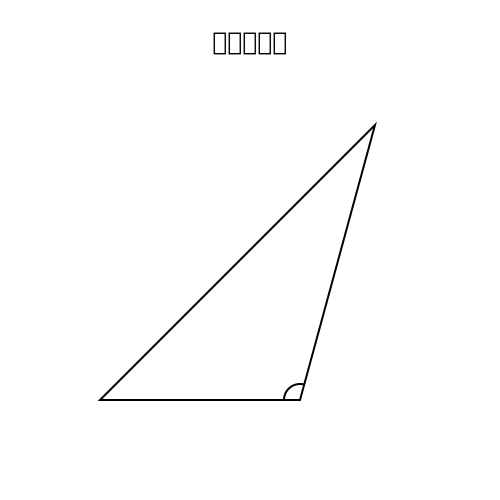

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

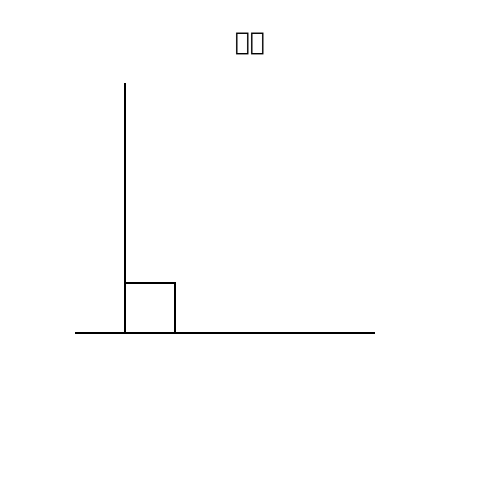

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

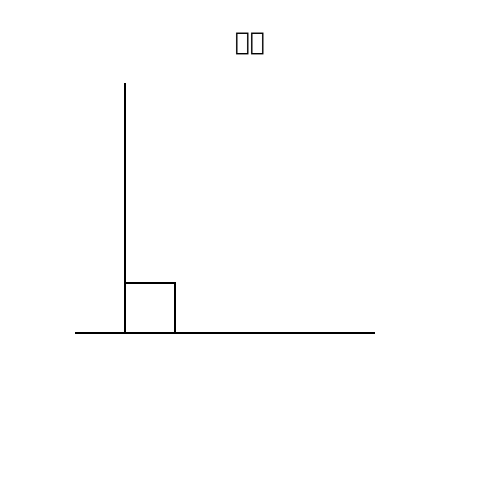

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

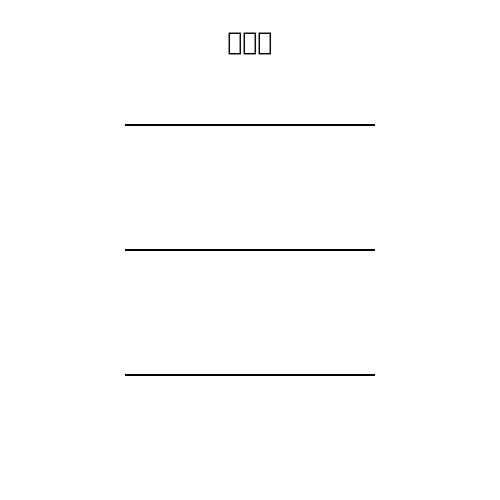

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

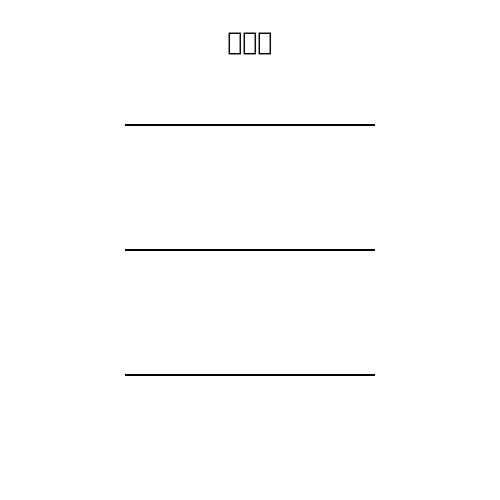

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


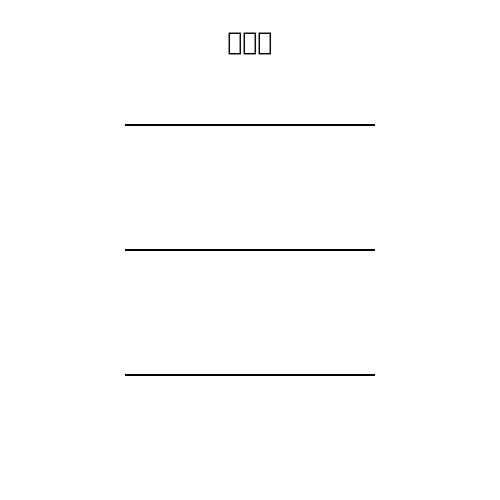

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

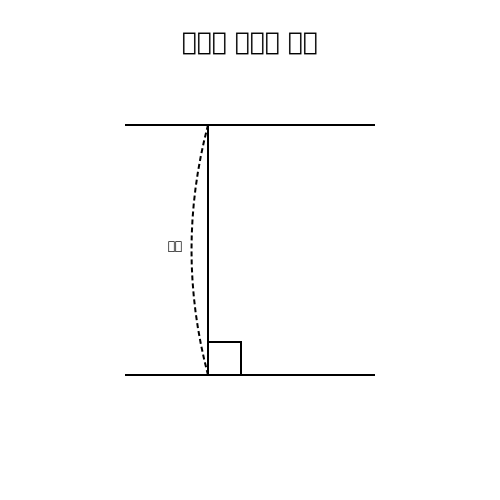

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

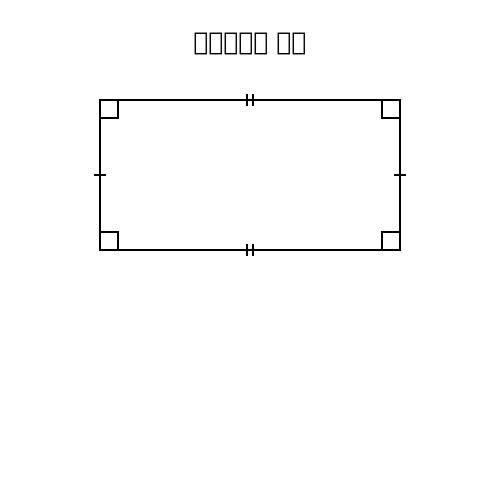

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

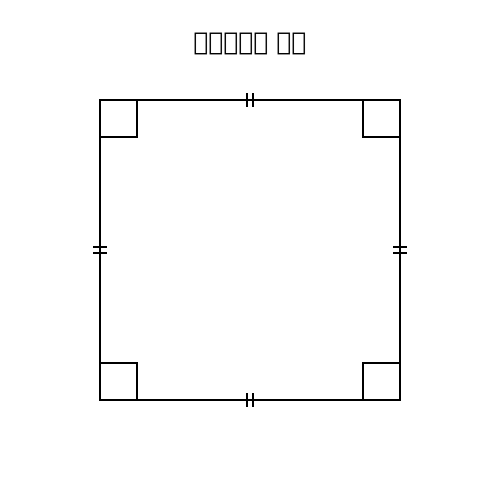

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

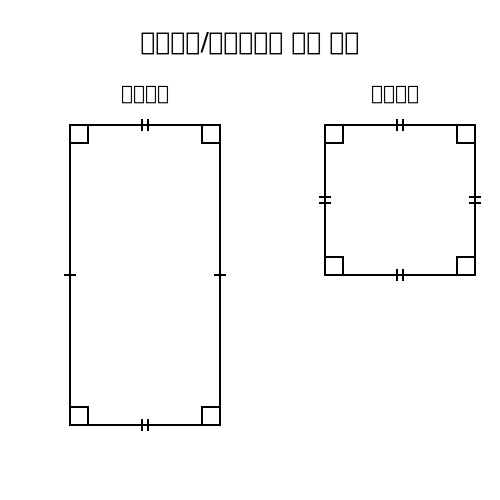

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


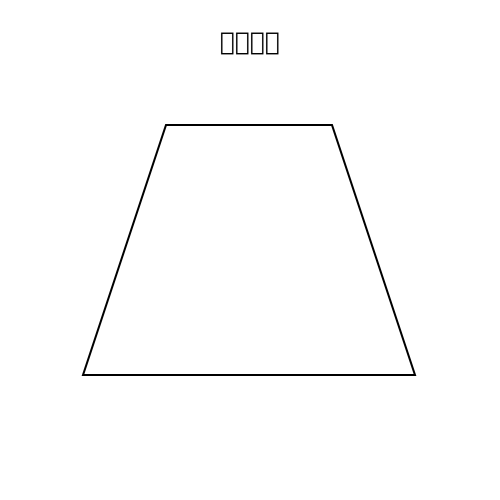

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

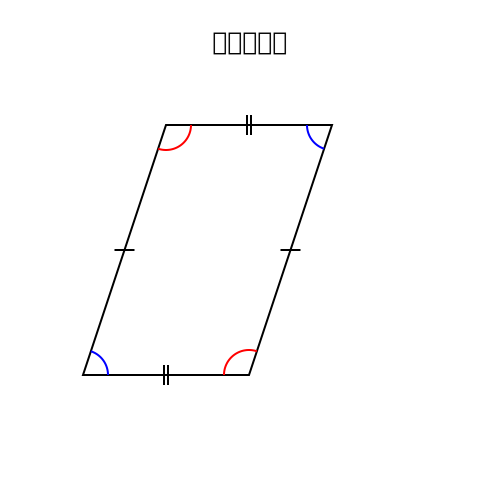

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

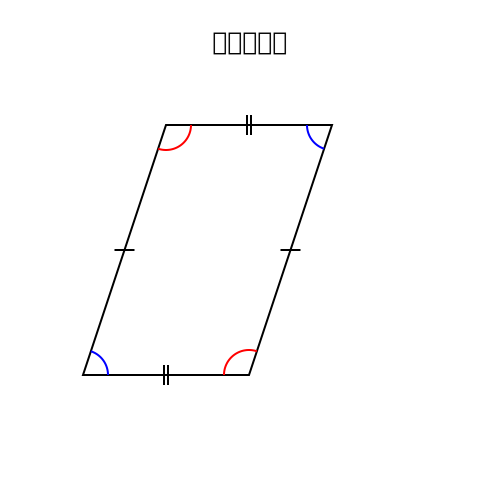

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

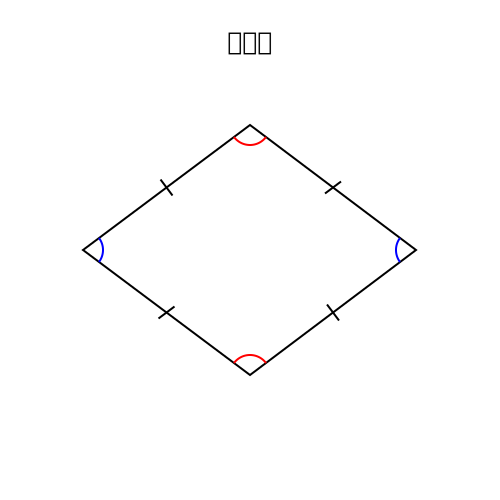

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

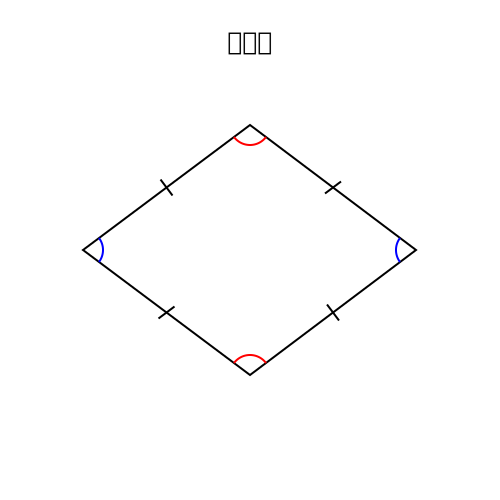

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

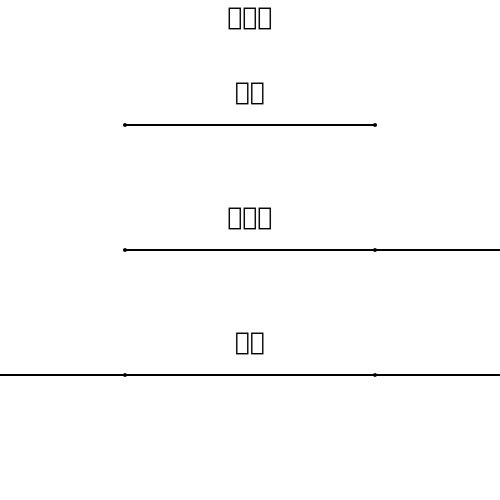

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="99.5462442119879" y2="133.3411224881768" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 219.90924884239757,293.06822449763536 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="277.88736331936303" y="277.06660239987343" font-size="12" text-anchor="middle">127°</text>
        </svg>
        


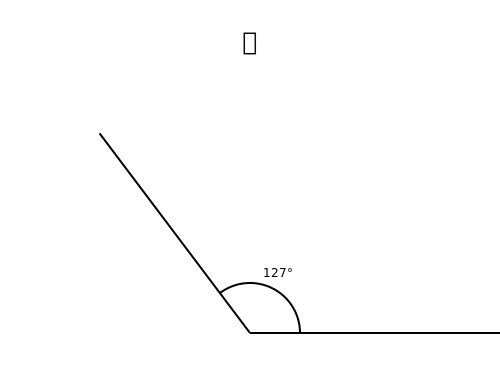

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

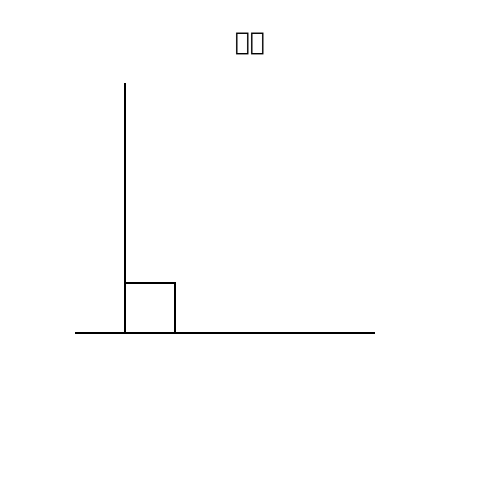

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


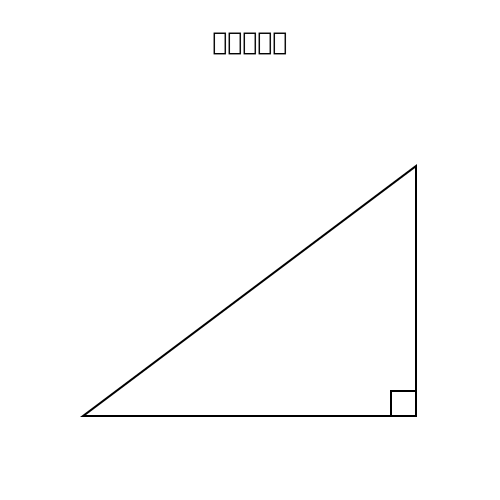

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


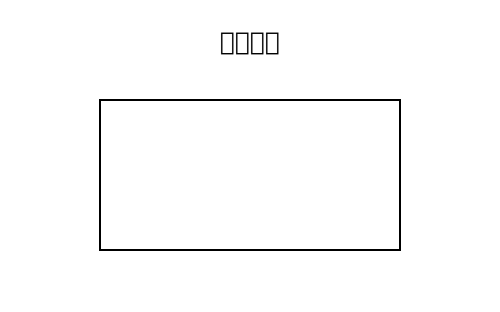

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


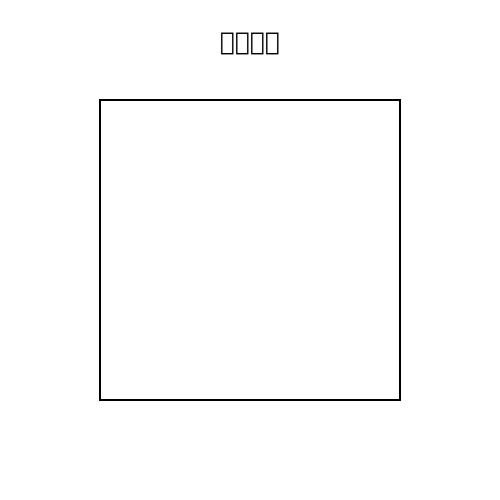

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


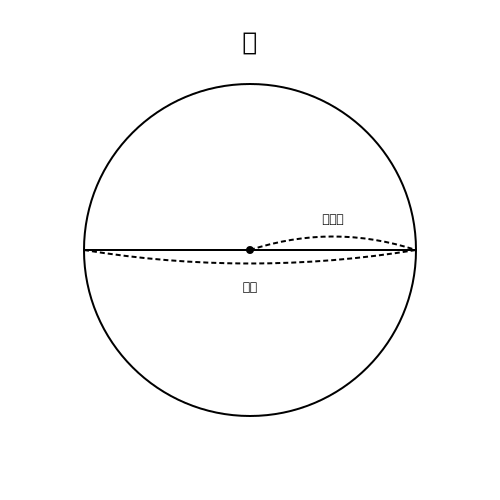

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


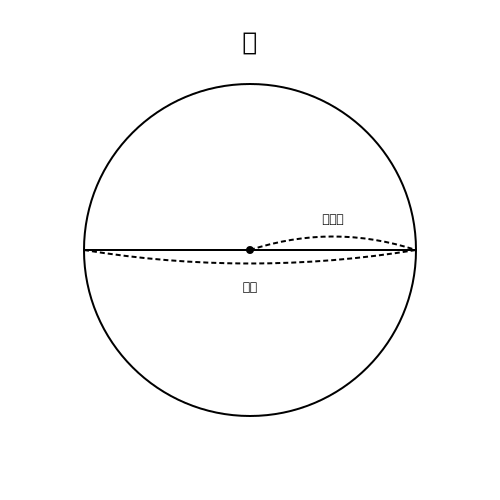

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

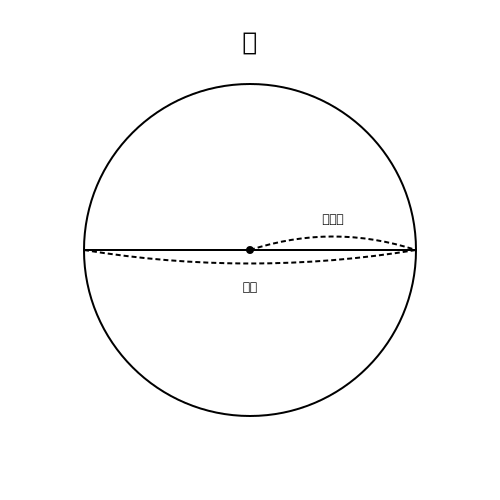

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

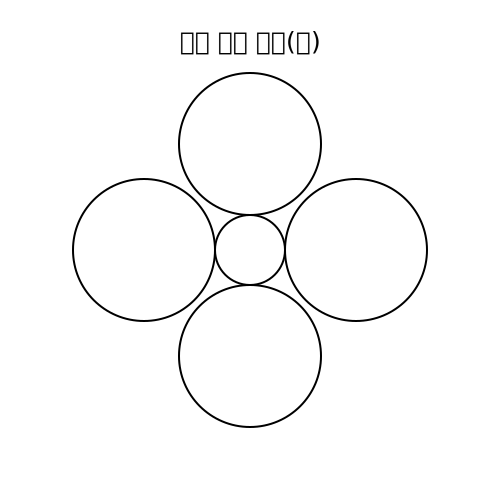

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="361.3796438998292" y2="251.60796138571084" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 172.27592877996585,316.7215922771422 A 50,50 0 0,1 175,333" stroke=

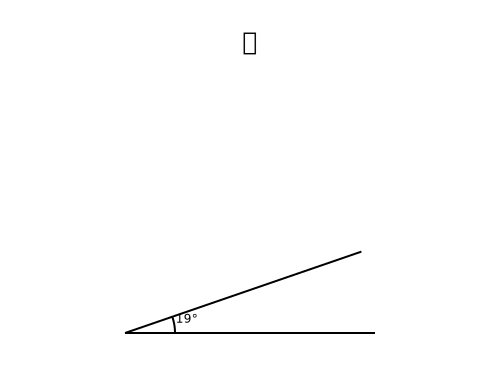

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="202.2977511558638" y2="87.59320413808402" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 240.45955023117276,283.9186408276168 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>

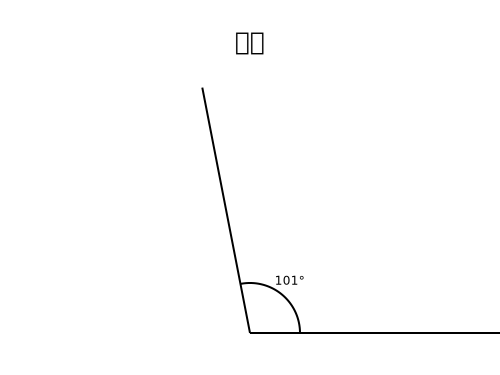

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="253.75951872751355" y2="118.70817482447191" stroke="black" strok

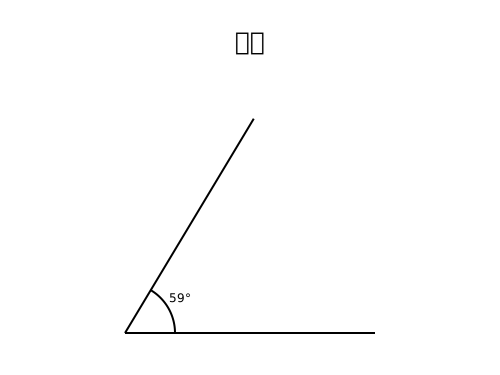

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="214.59198738632512" y2="99.60489337569956" stroke="black" stroke-width="2" />


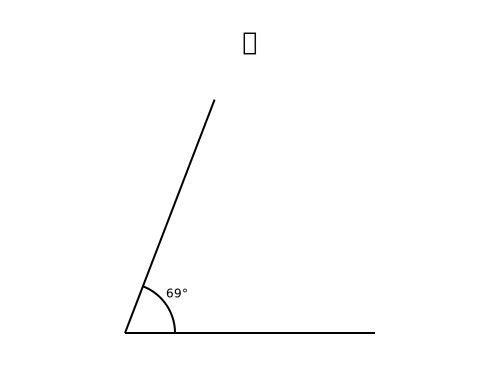

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="168.18155080466045" y2="75.01903810545109" stroke="black" stroke-width

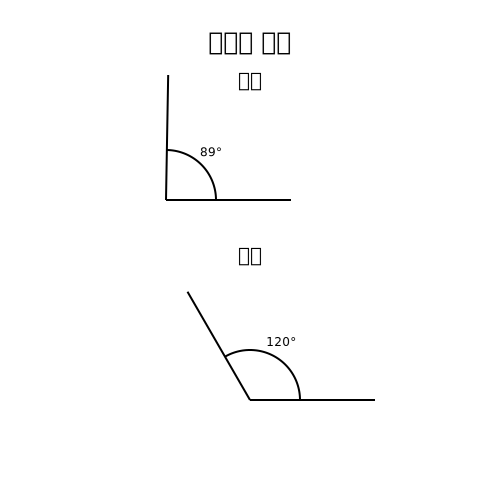

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="366.4814565722671" y2="268.2952387243698" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 173.2962913144534,320.0590

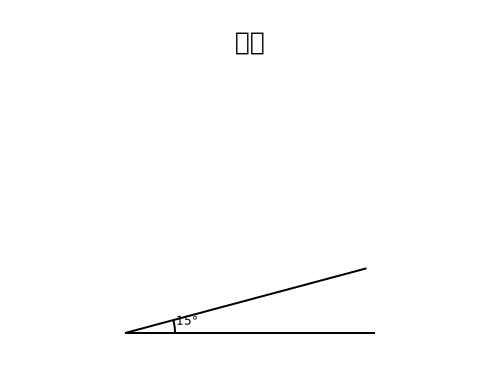

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

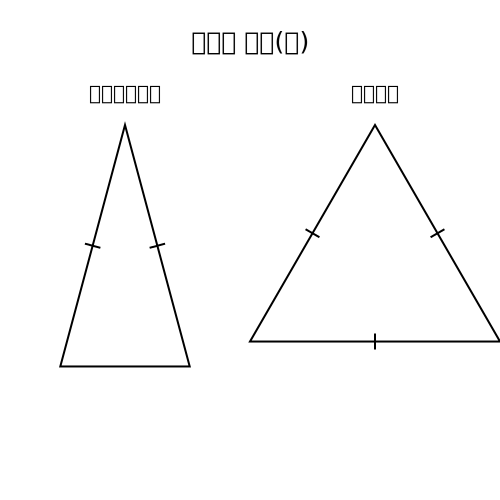

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

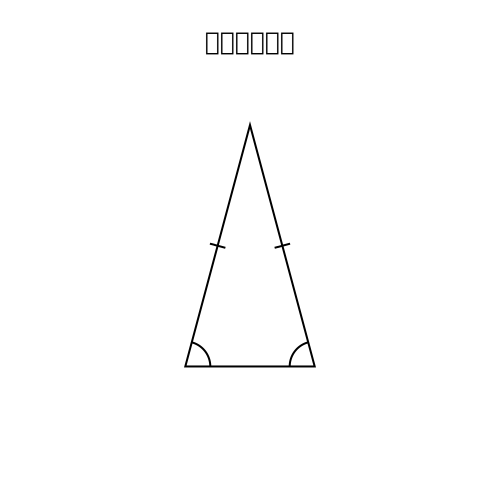

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

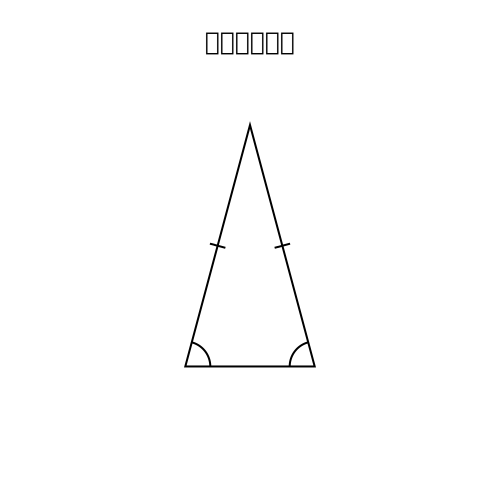

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

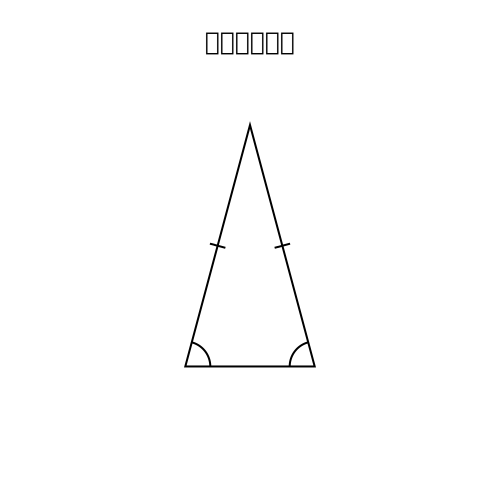

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

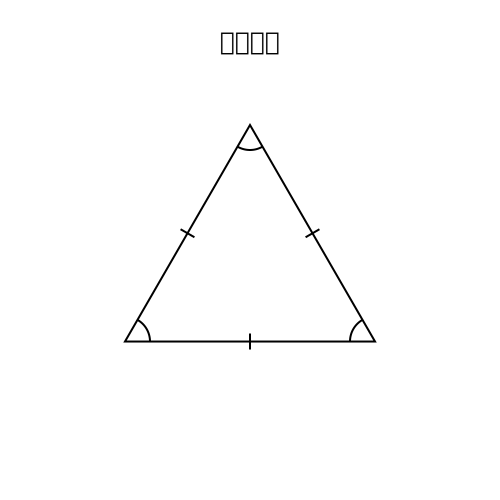

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

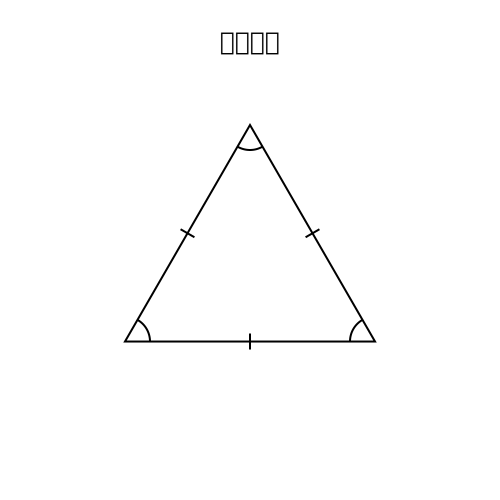

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

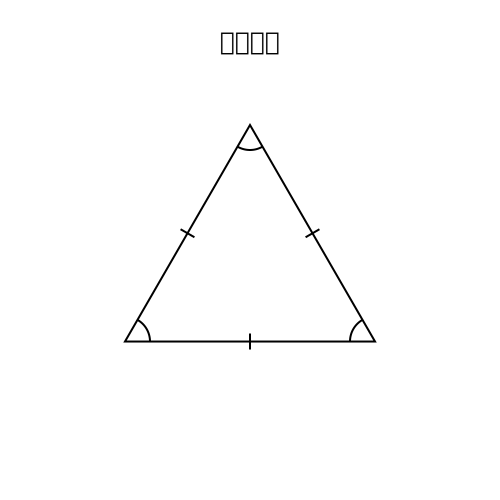

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


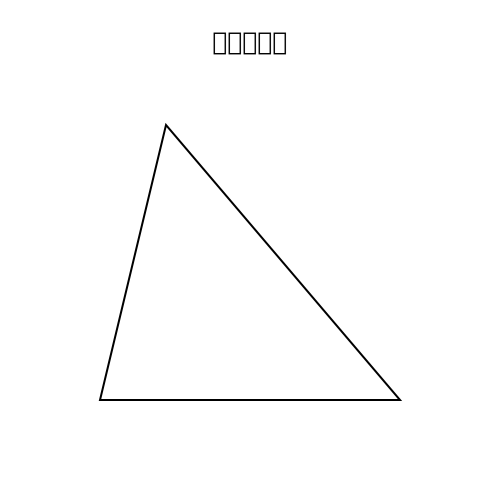

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

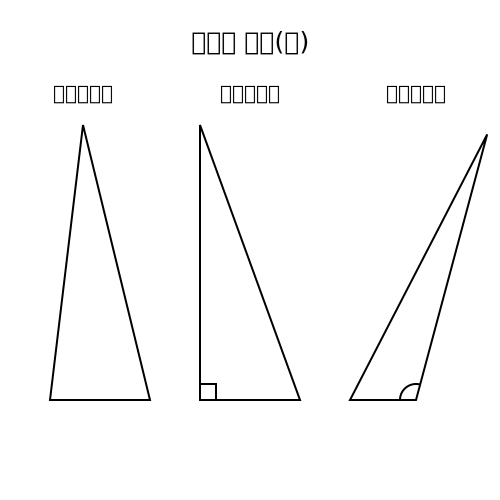

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


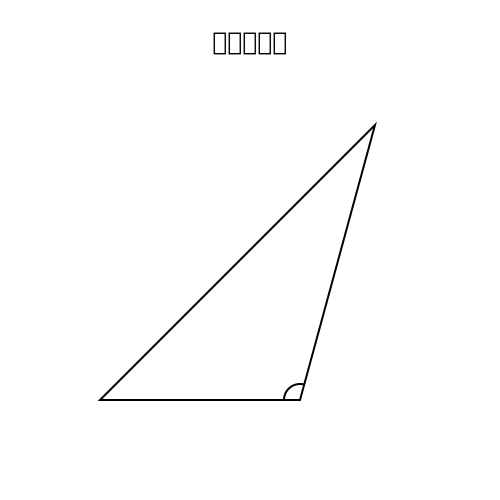

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

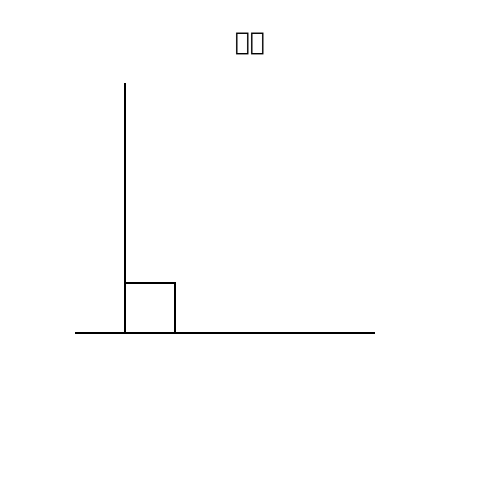

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

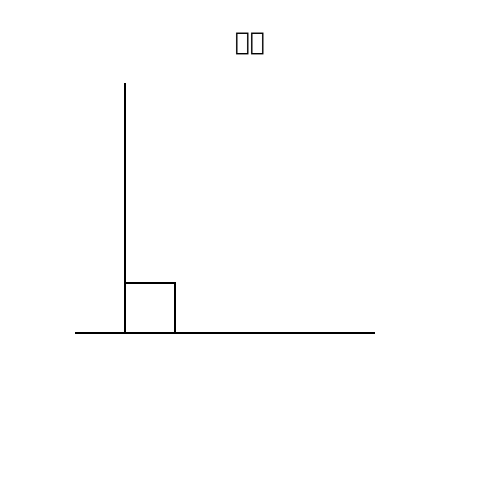

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

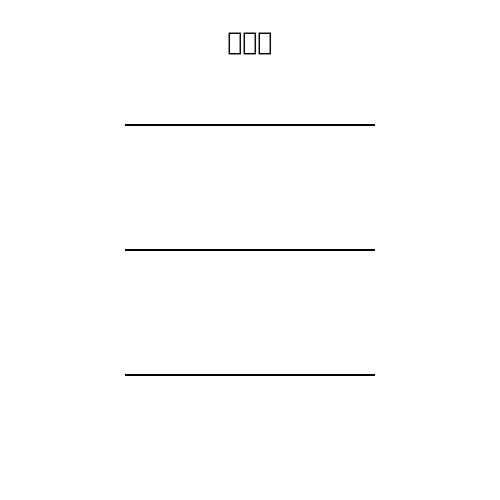

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

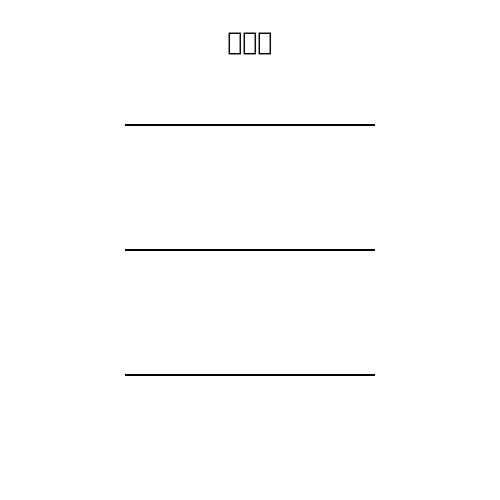

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


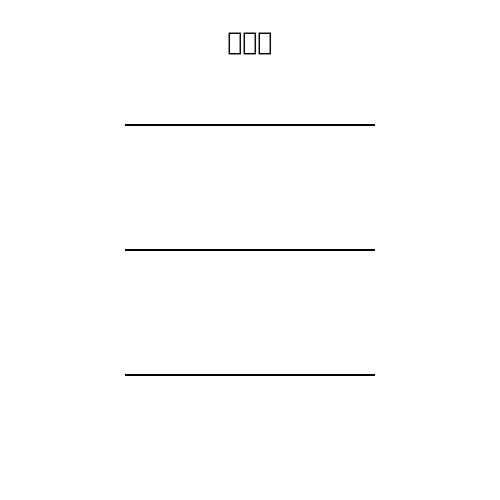

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

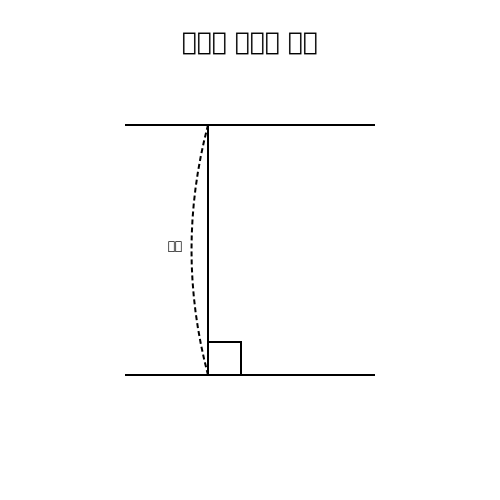

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

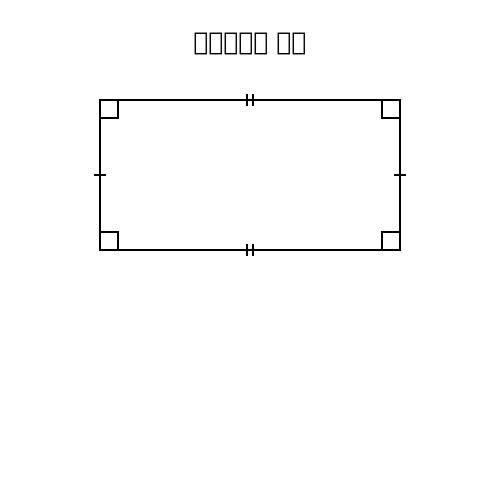

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

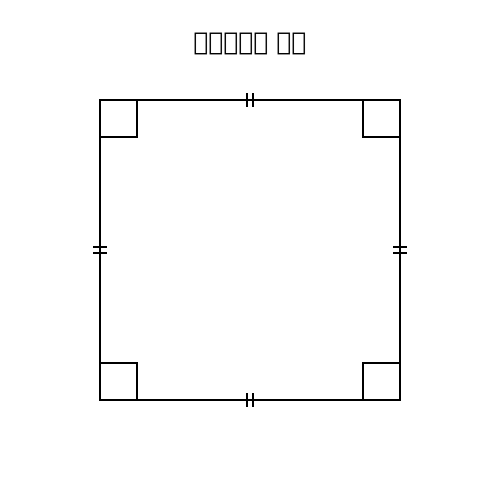

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

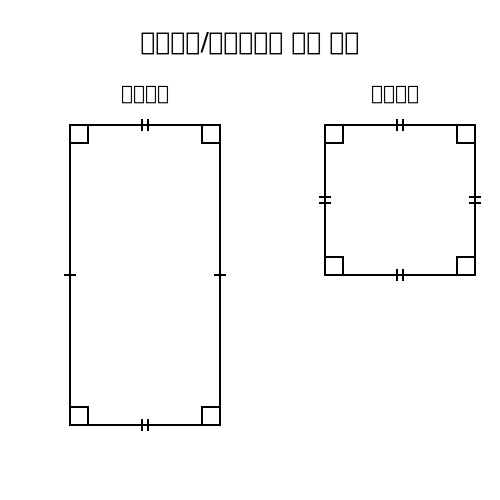

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


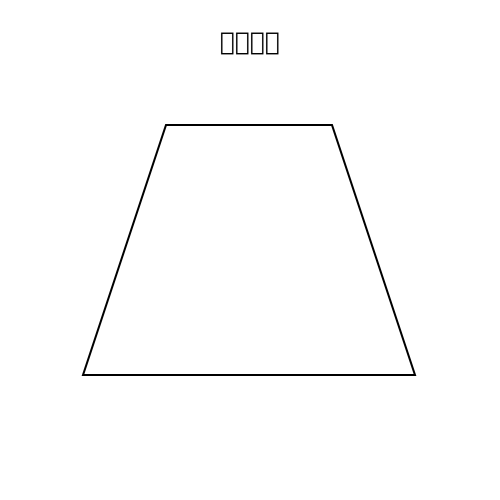

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

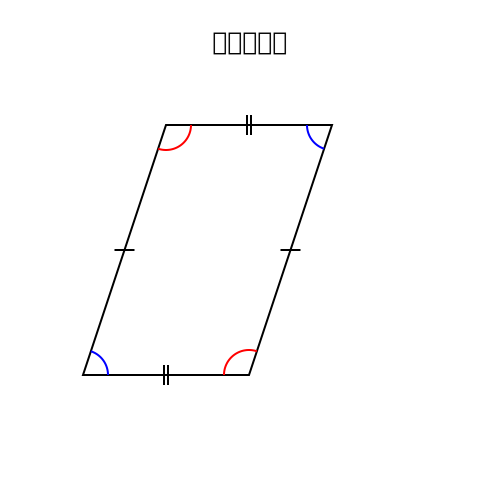

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

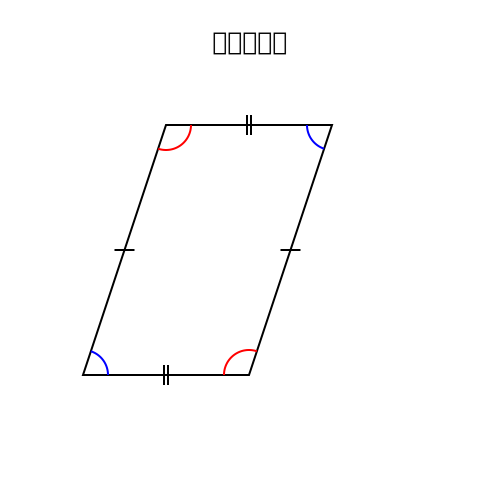

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

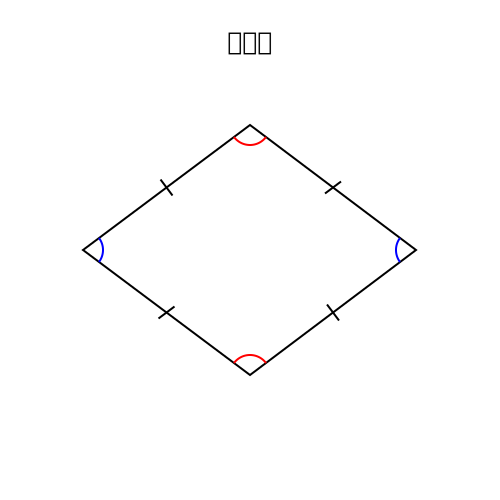

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

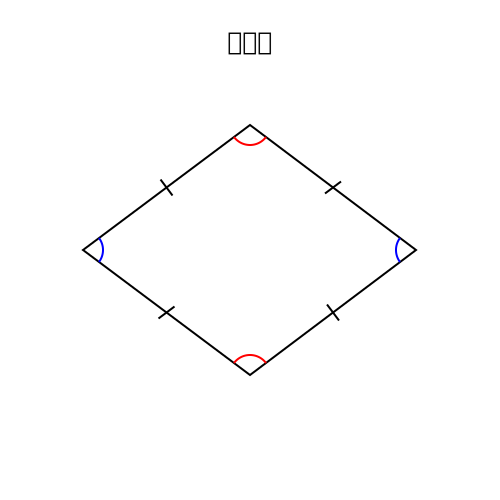

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

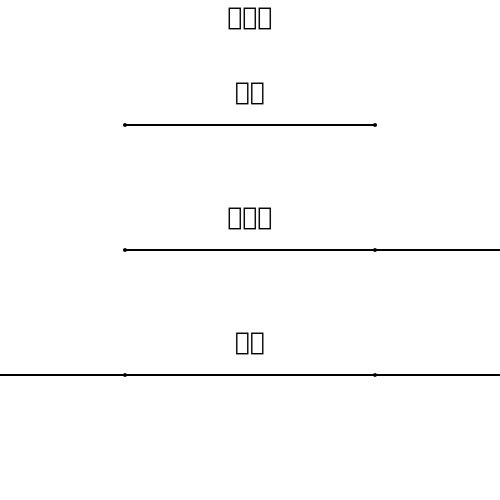

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="347.75163104709196" y2="219.5023750651133" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 169.5503262094184,310.30047501302266 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="185.7731200248548" y="318.4096647590059" font-size="12" text-anchor="middle">27°</text>
        </svg>
        


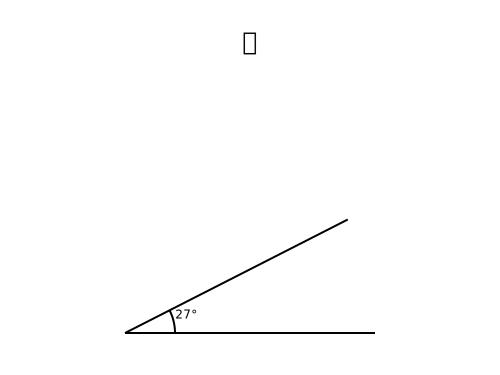

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

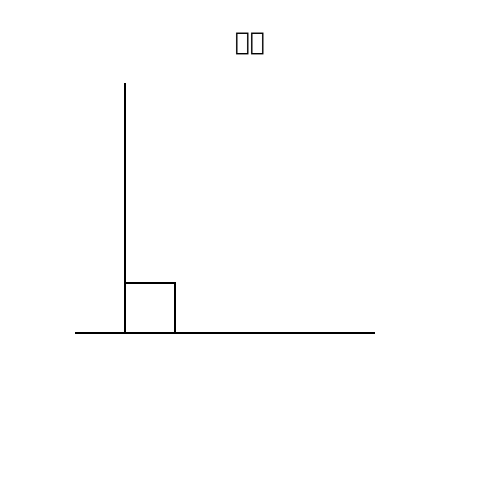

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


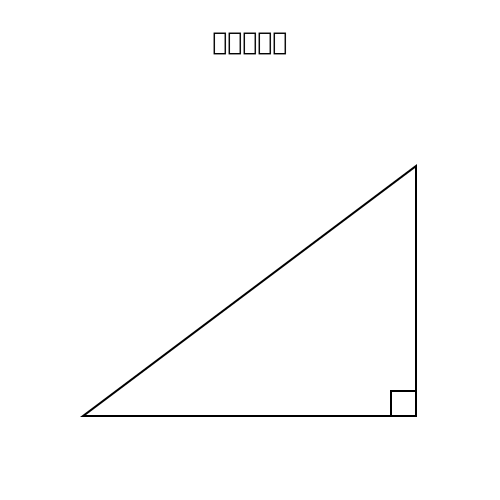

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


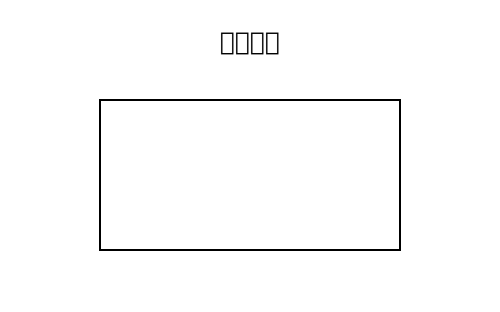

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


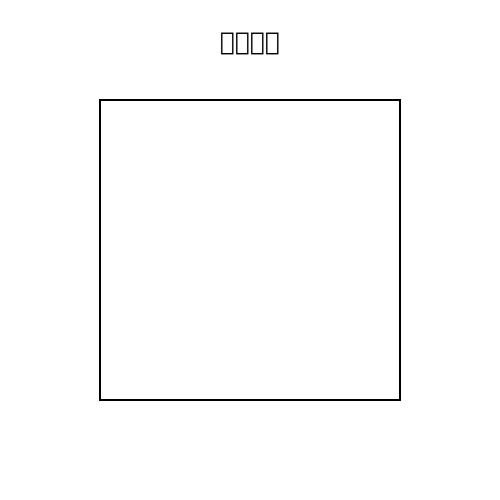

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


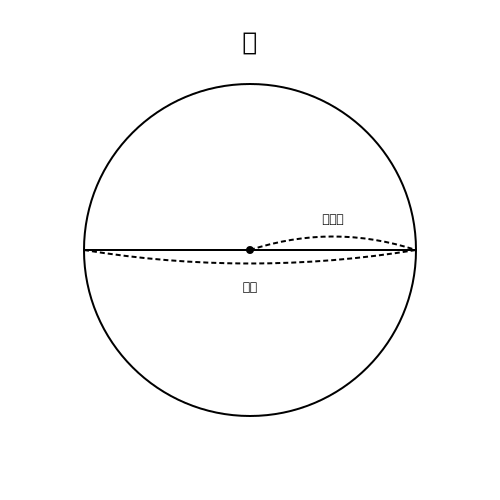

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


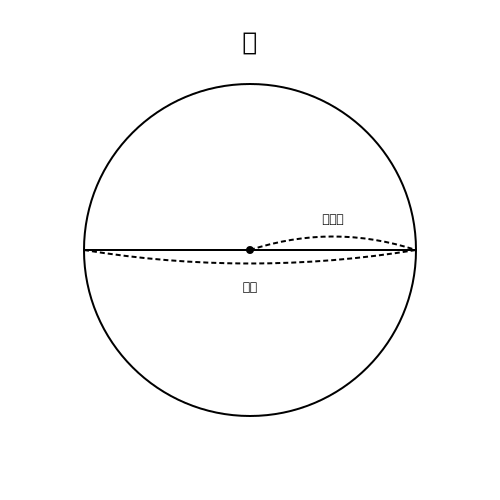

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

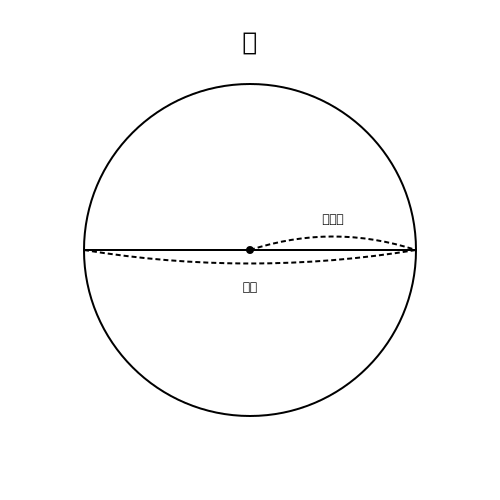

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

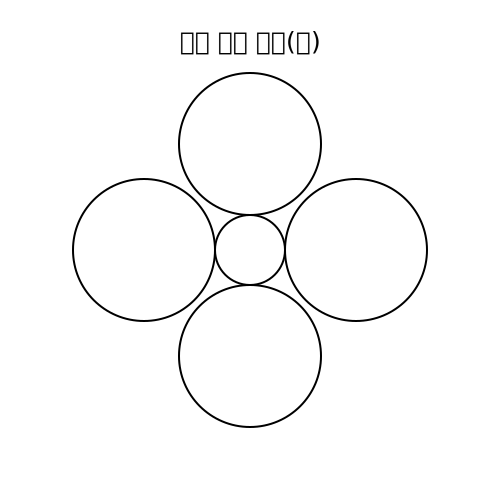

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="27.248368952908066" y2="219.50237506511328" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 205.4496737905816,310.30047501302266 A 50,50 0 0,1 300,333" stroke

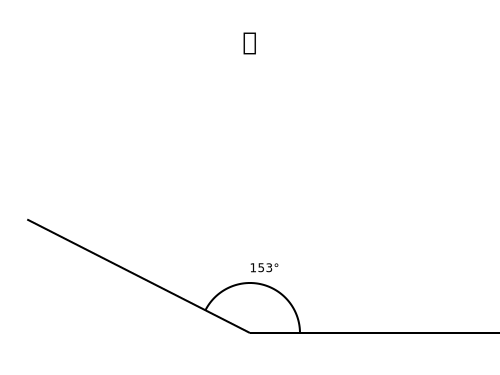

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="373.1365379103305" y2="302.53266414871314" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 174.6273075820661,326.9065328297426 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>

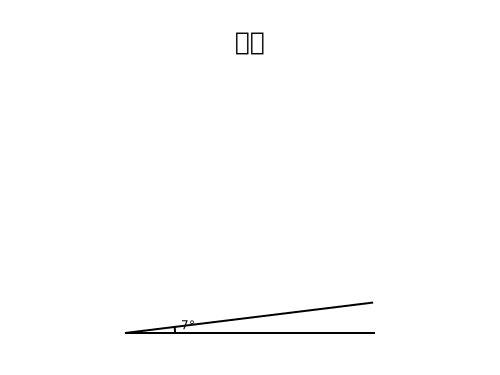

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="271.9463130731183" y2="130.74575140626314" stroke="black" stroke

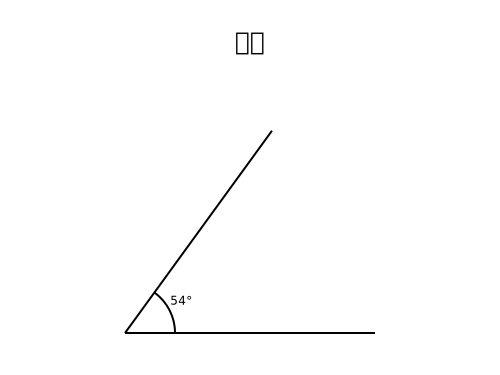

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="0.038076210902175944" y2="328.63689839067916" stroke="black" stroke-width="2" 

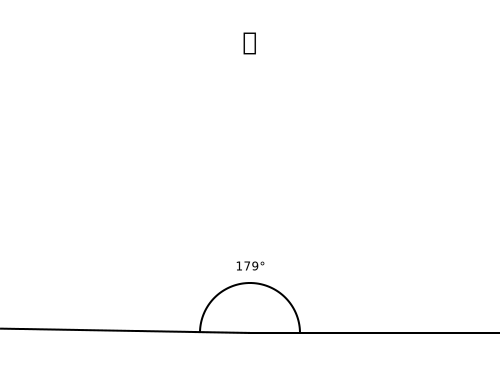

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="210.79599369316256" y2="83.30244668784978" stroke="black" stroke-width

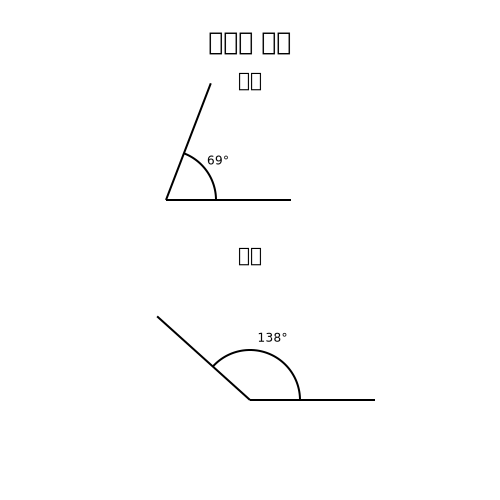

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="1.3695261579316877" y2="306.8678841830866" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.27390523158633,327.77

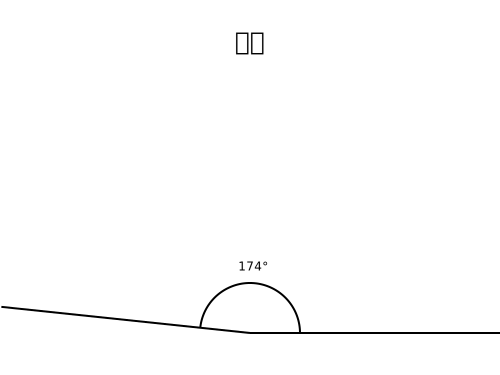

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

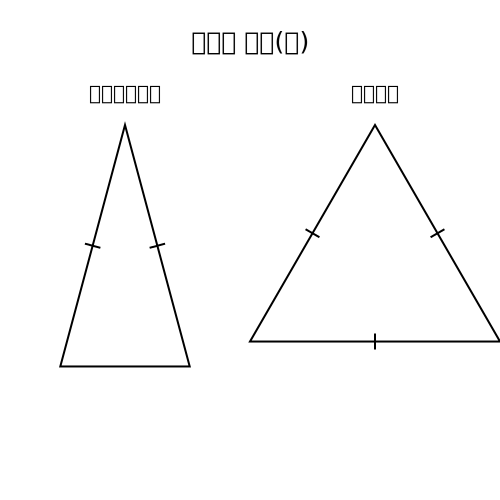

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

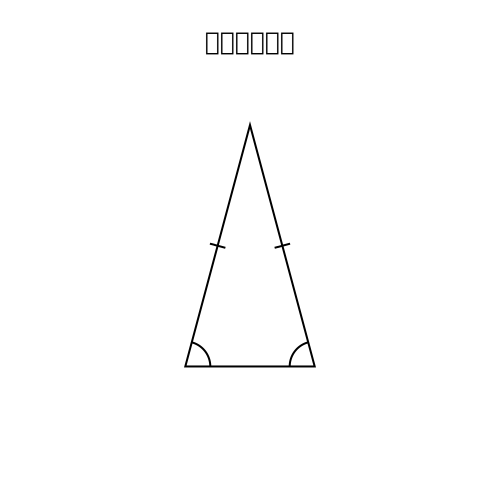

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

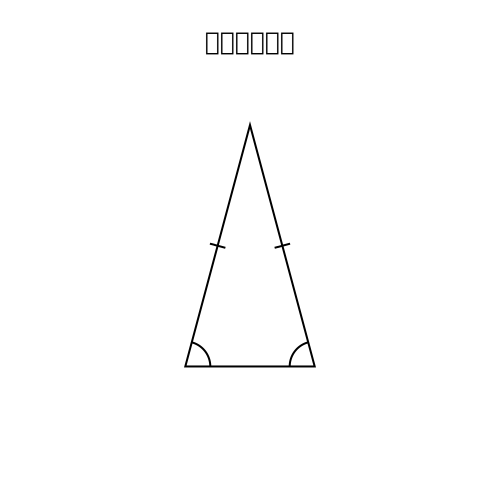

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

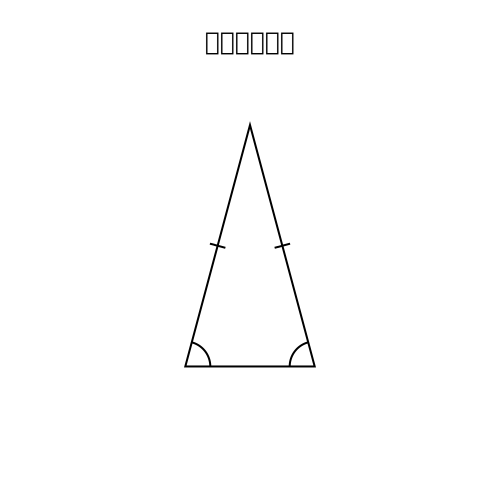

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

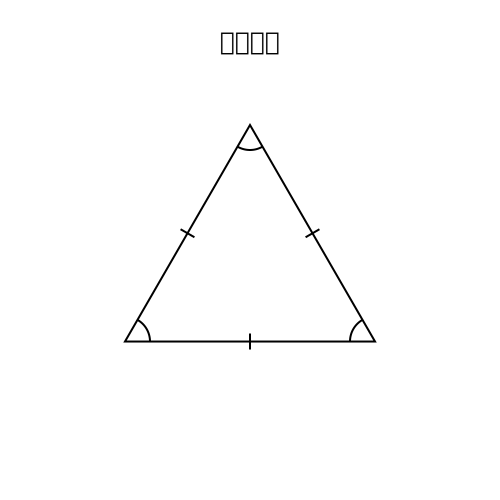

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

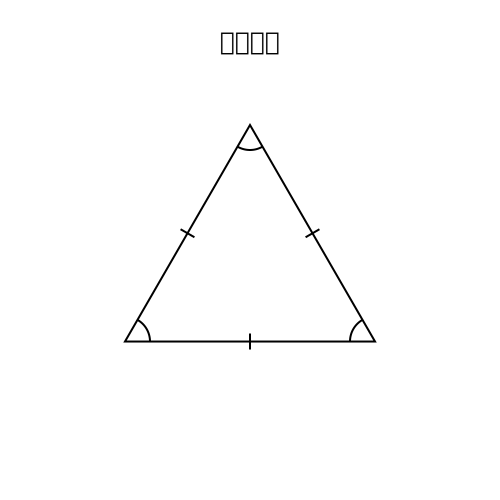

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

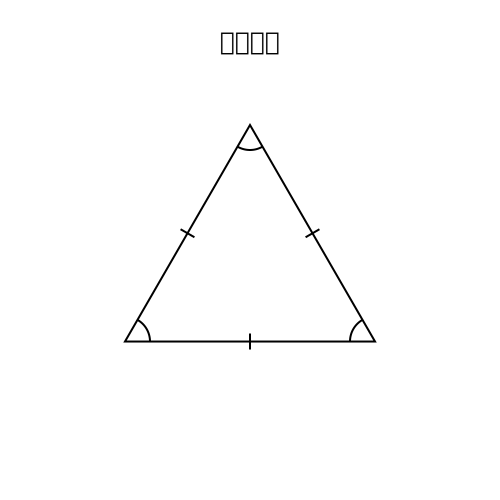

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


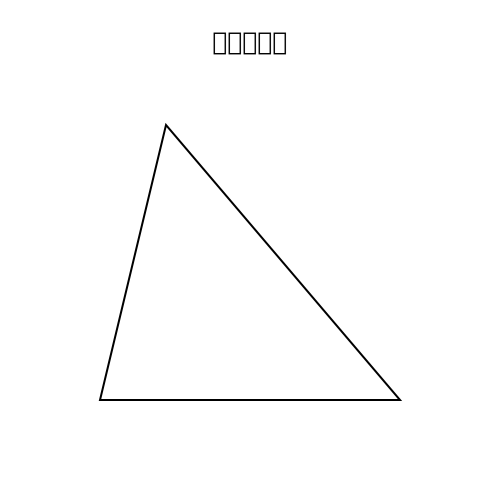

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

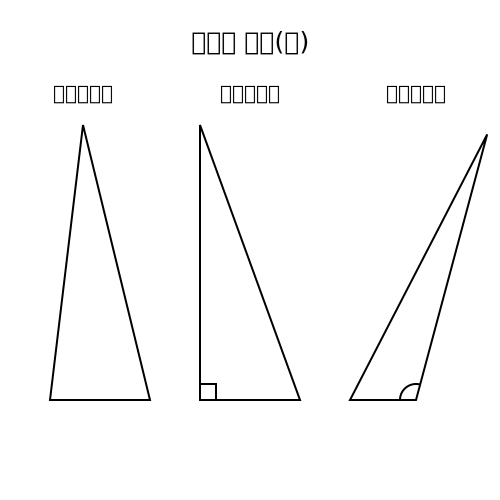

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


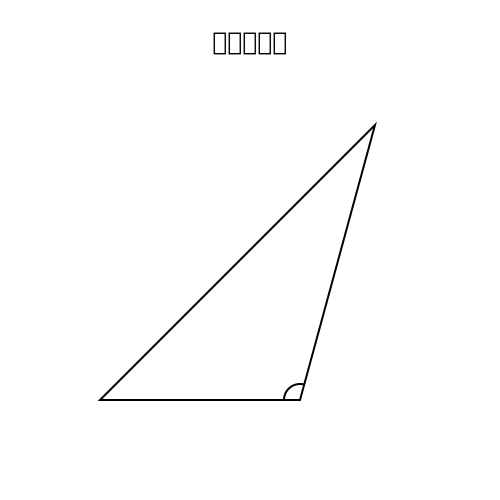

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

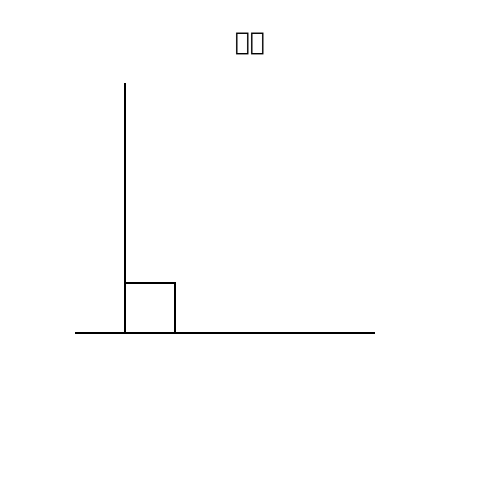

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

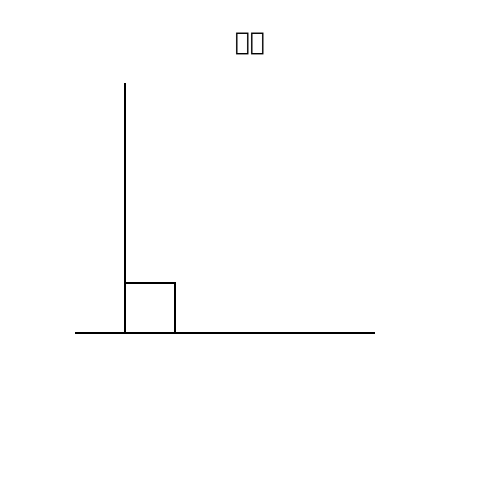

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

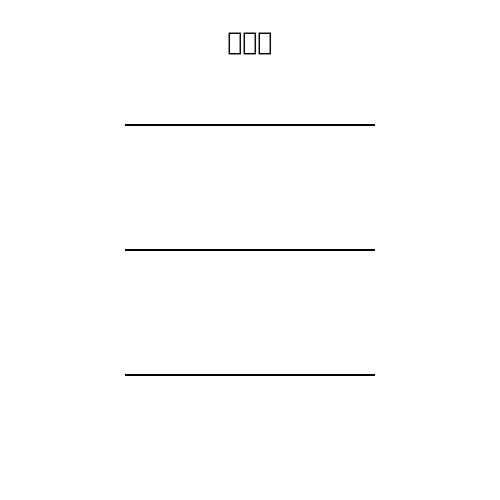

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

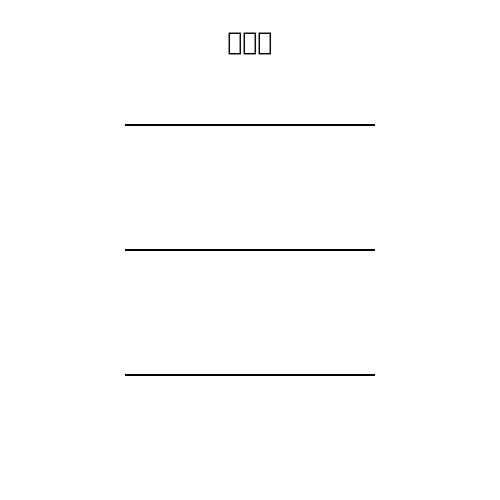

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


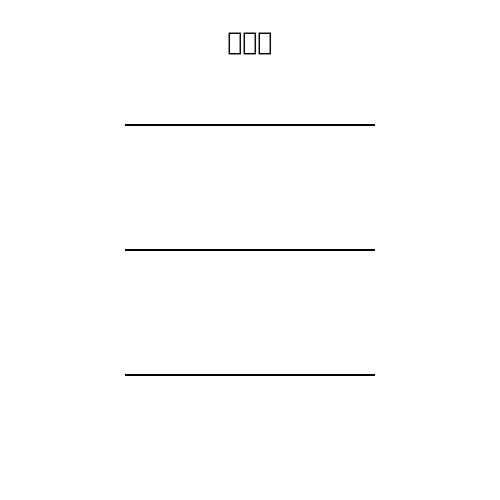

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

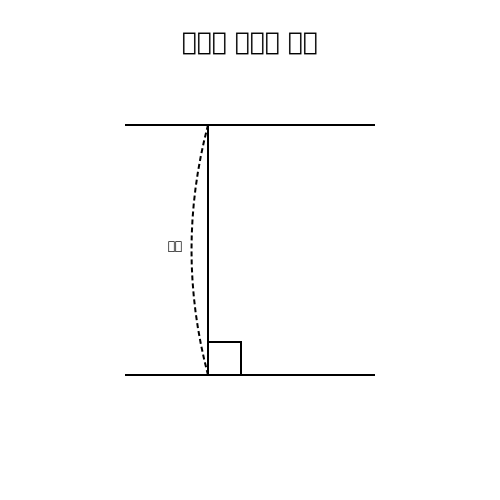

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

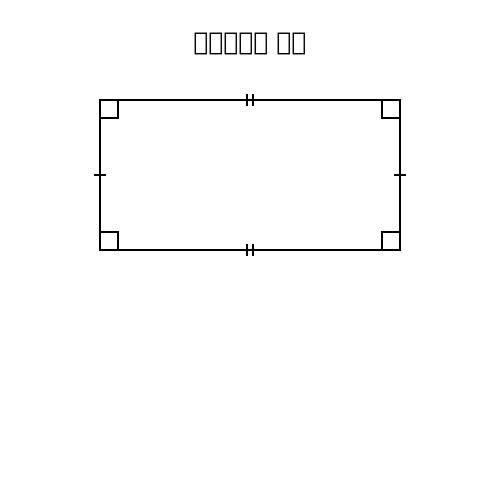

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

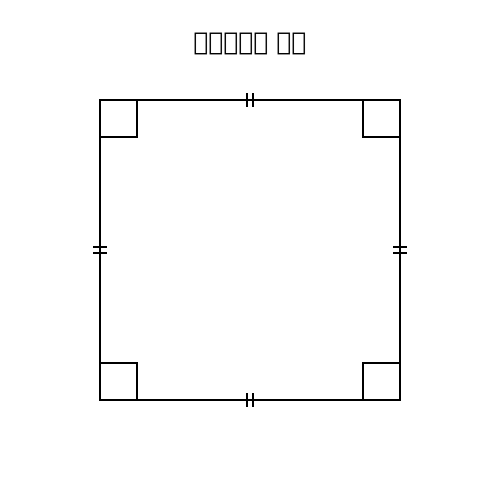

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

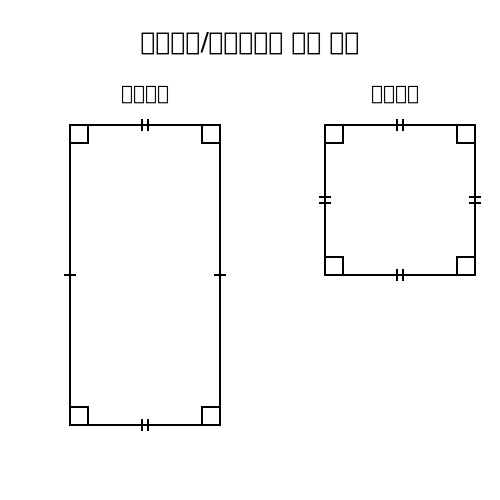

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


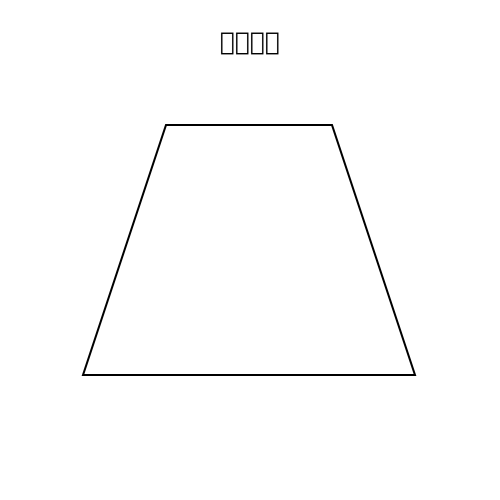

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

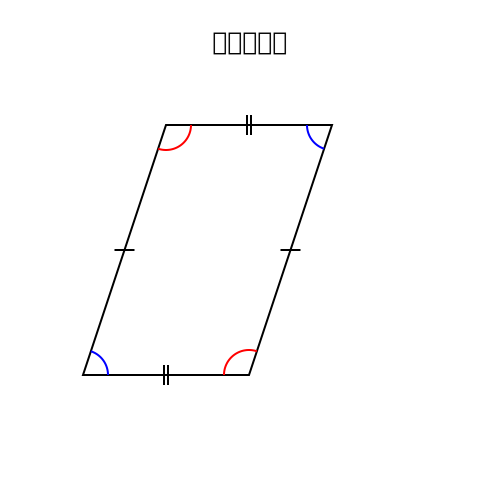

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

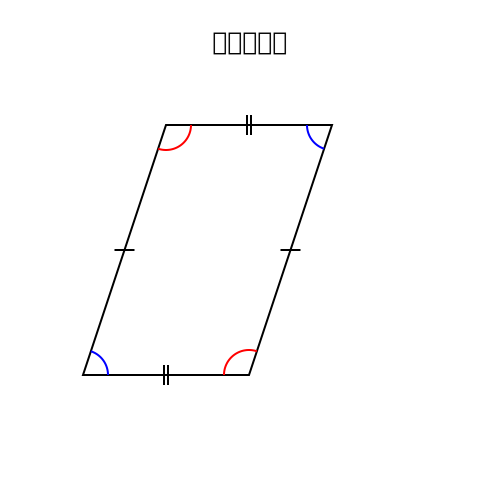

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

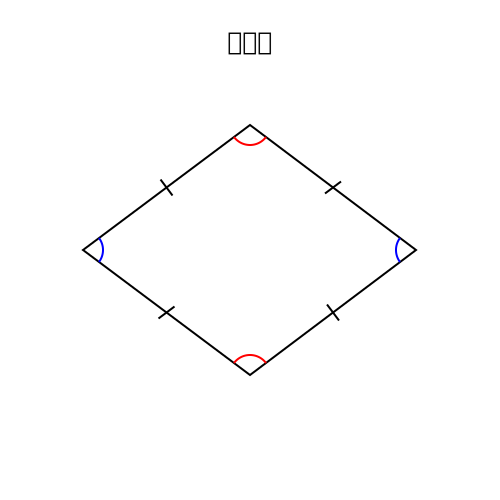

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

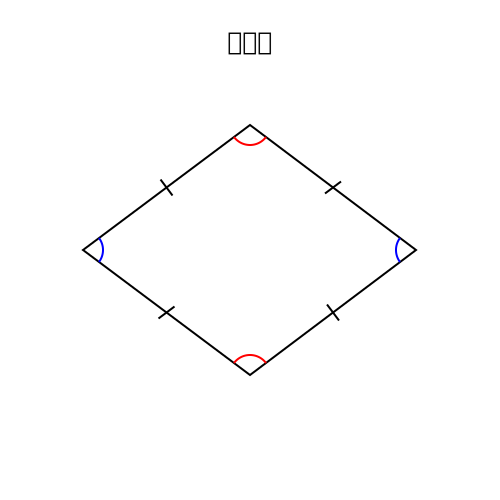

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

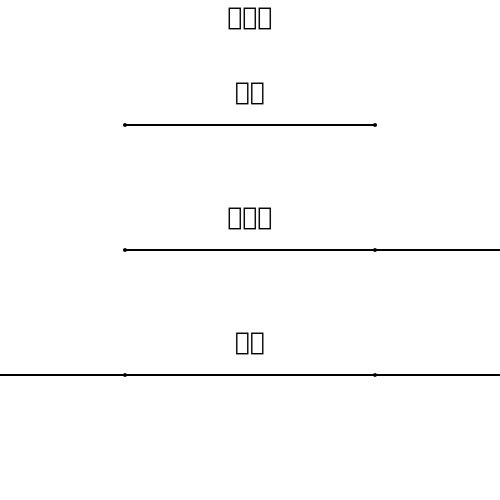

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="70.16504991533719" y2="159.3354073852507" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 214.03300998306744,298.26708147705017 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="273.4129120884945" y="275.0510090895758" font-size="12" text-anchor="middle">136°</text>
        </svg>
        


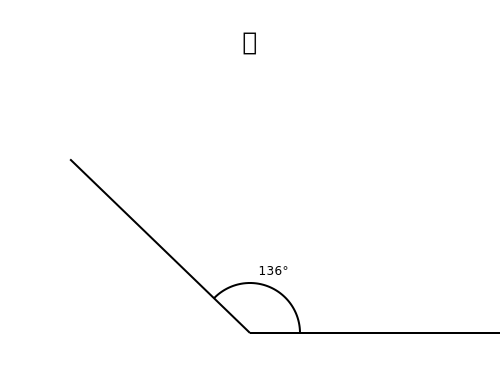

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

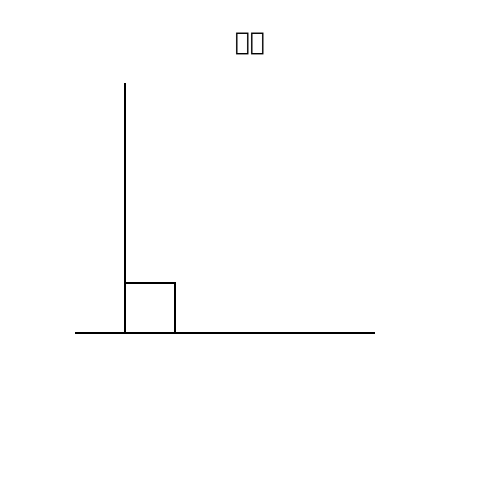

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


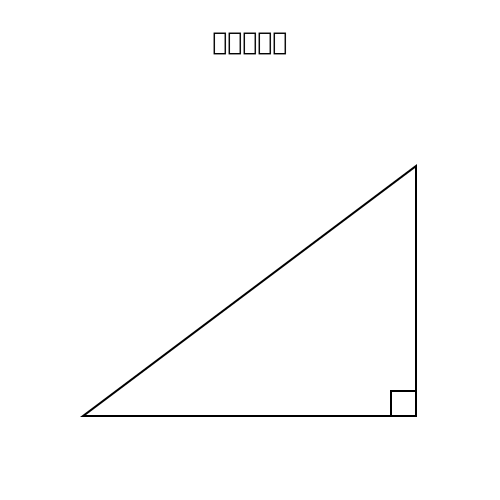

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


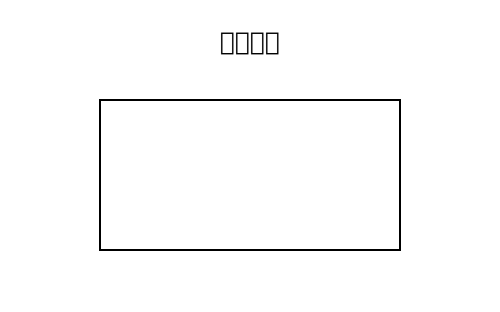

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


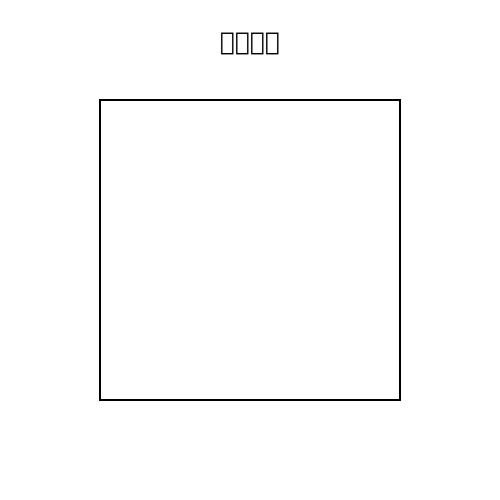

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


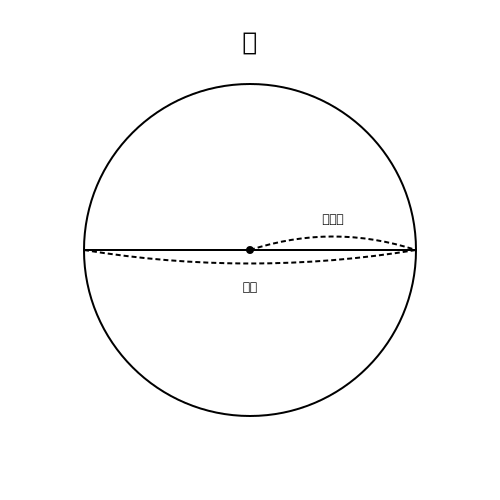

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


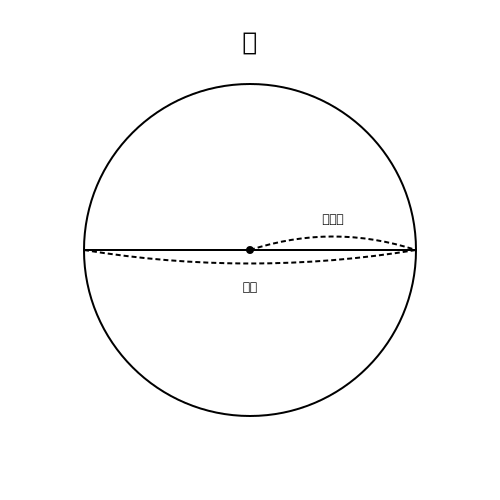

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

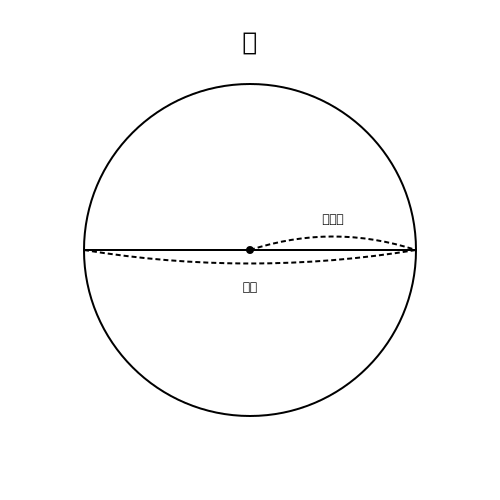

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

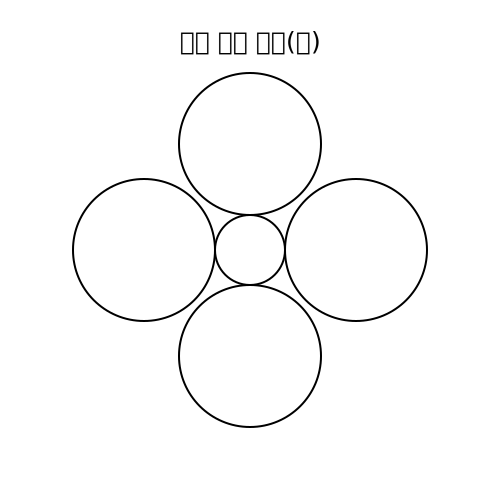

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="3.0779148512155814" y2="293.8913837399423" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.6155829702431,325.17827674798843 A 50,50 0 0,1 300,333" stroke=

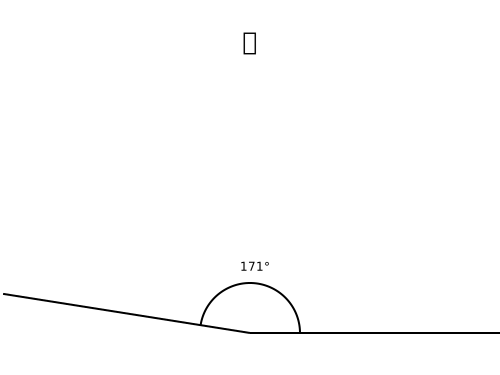

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="215.20672475998367" y2="85.43298281460741" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 243.04134495199673,283.4865965629215 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/

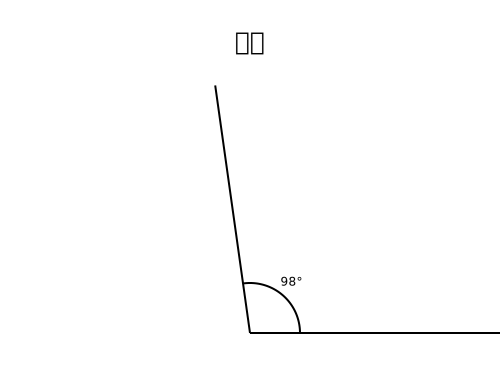

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="367.5739315689991" y2="272.51952610008306" stroke="black" stroke

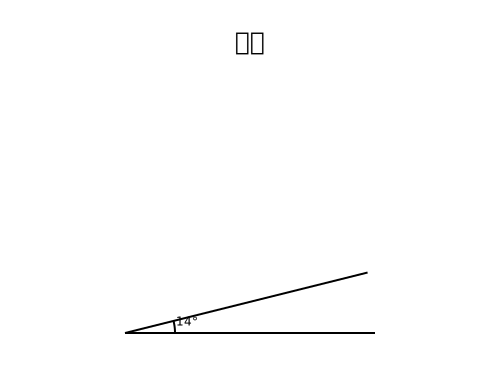

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="189.51952610008306" y2="90.42606843100089" stroke="black" stroke-width="2" />


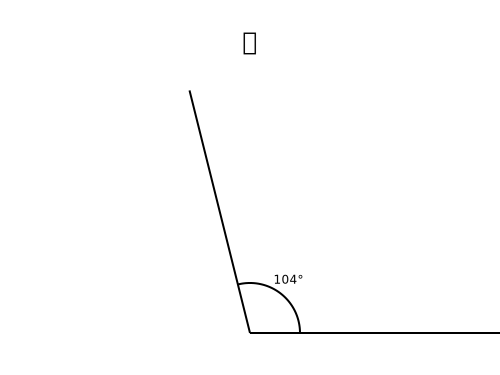

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="194.1188817929831" y2="78.20374190184559" stroke="black" stroke-width=

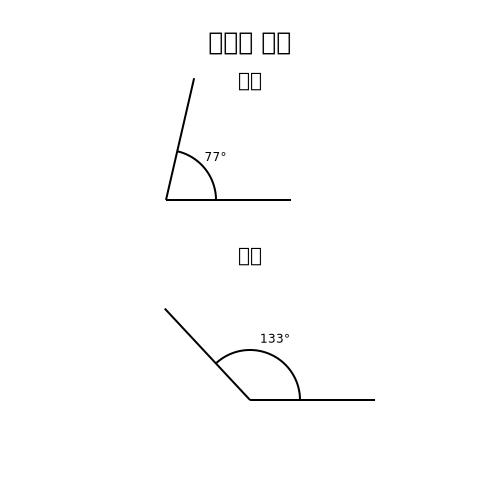

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="1.3695261579316877" y2="306.8678841830866" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.27390523158633,327.77

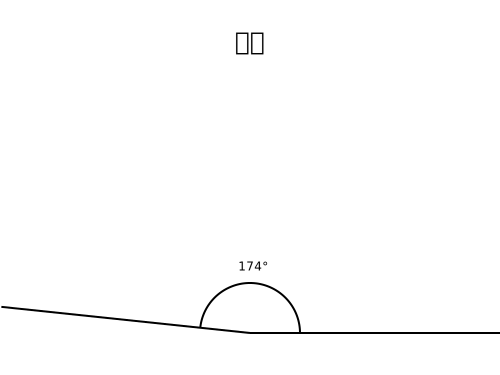

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

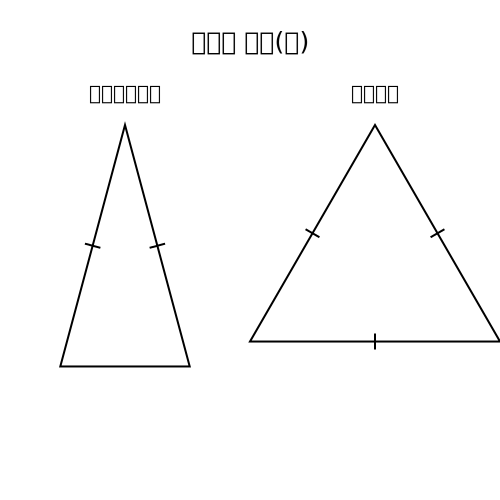

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

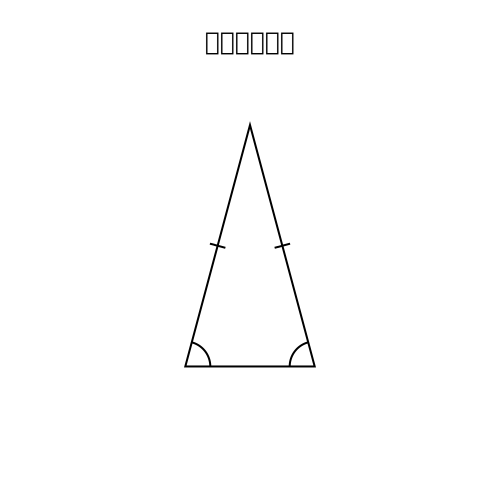

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

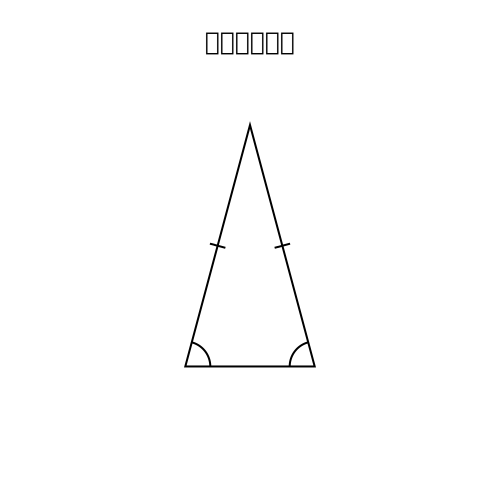

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

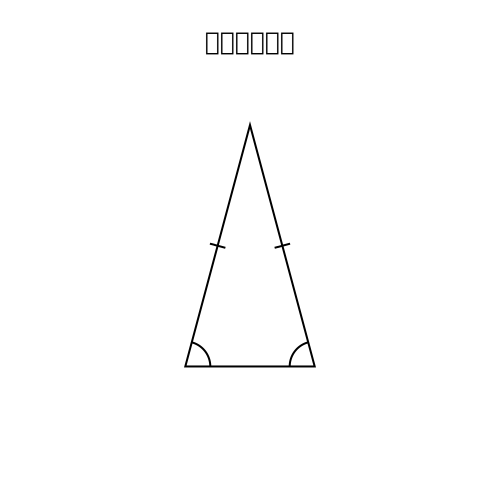

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

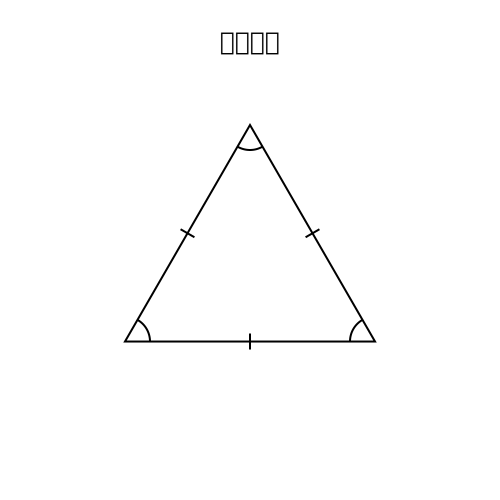

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

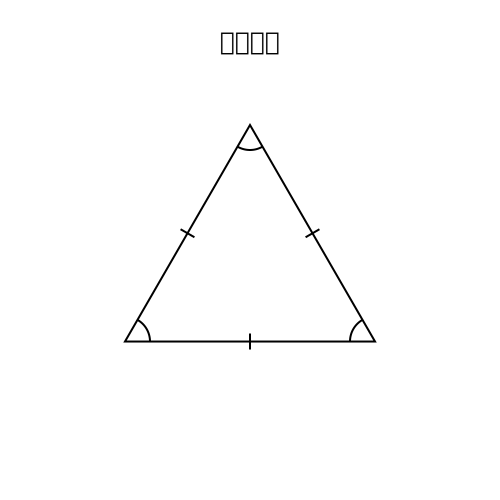

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

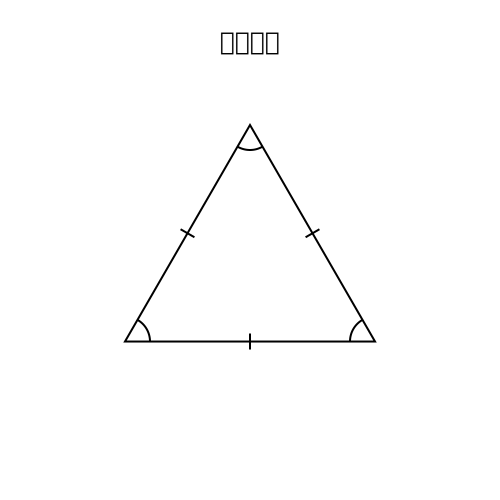

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


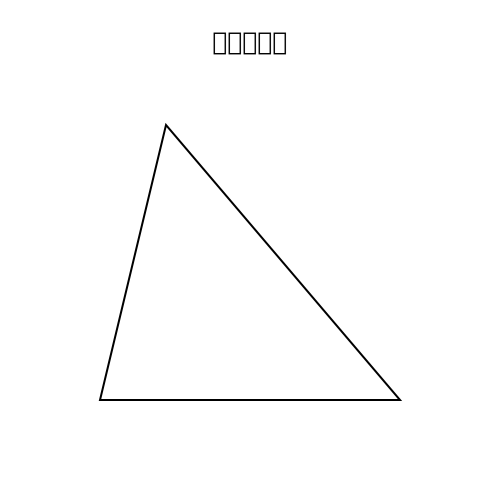

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

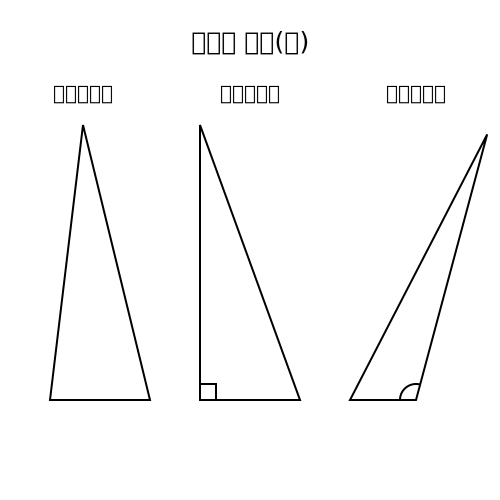

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


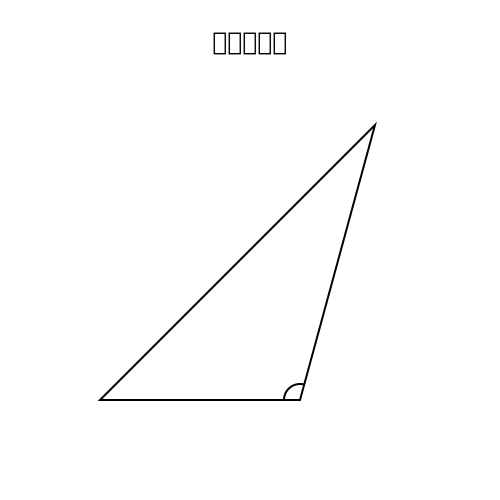

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

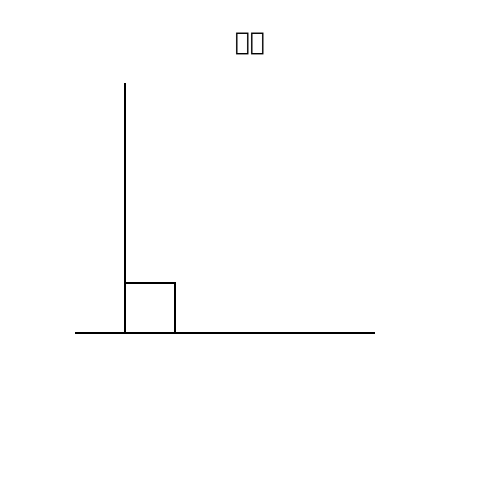

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

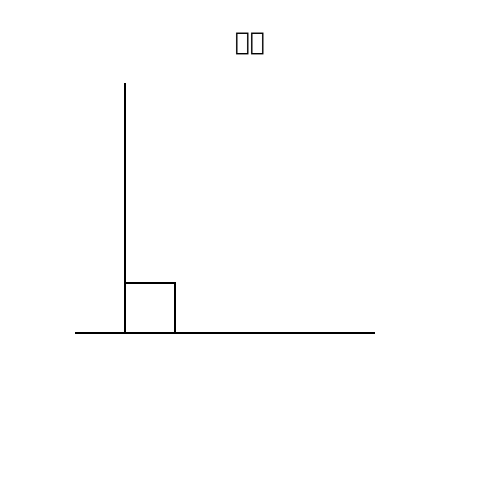

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

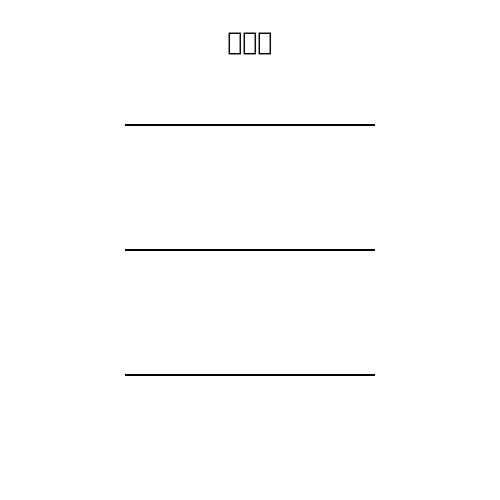

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

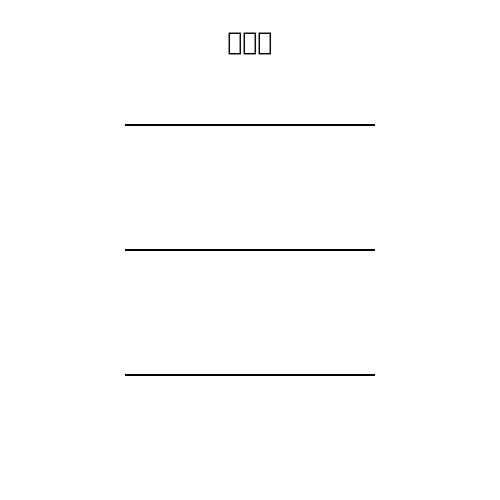

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


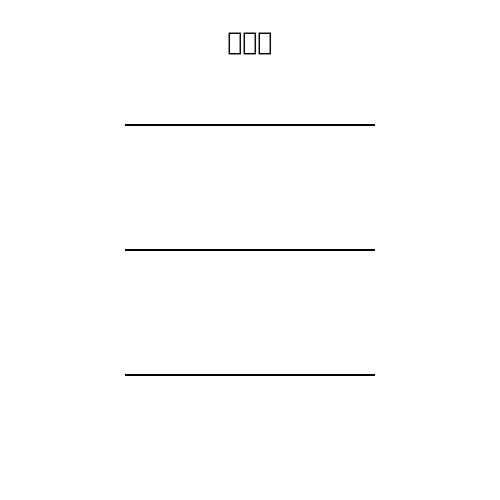

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

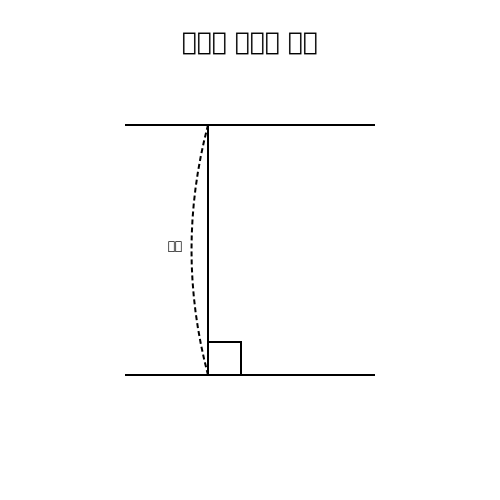

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

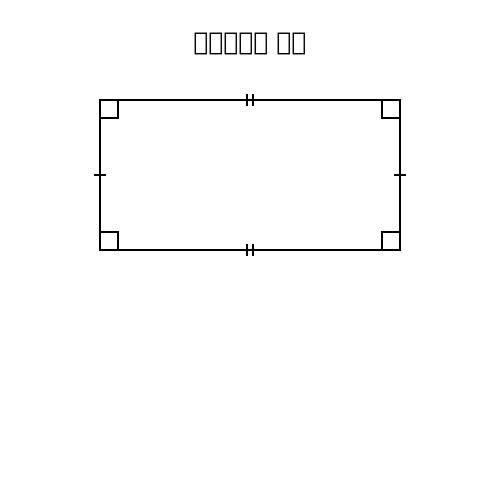

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

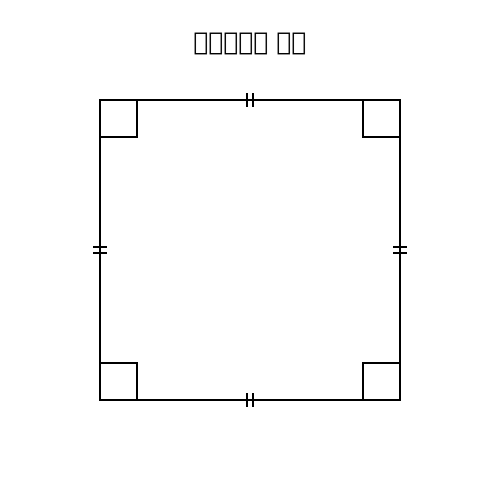

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

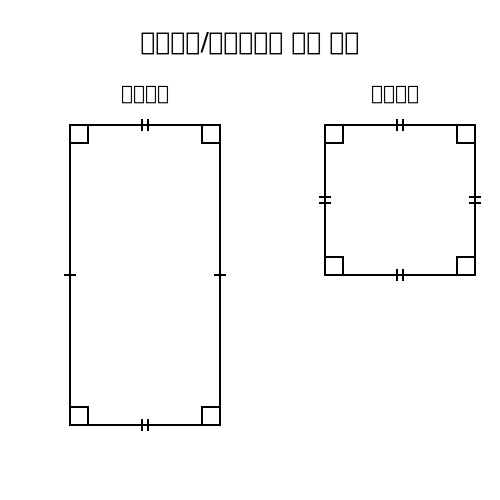

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


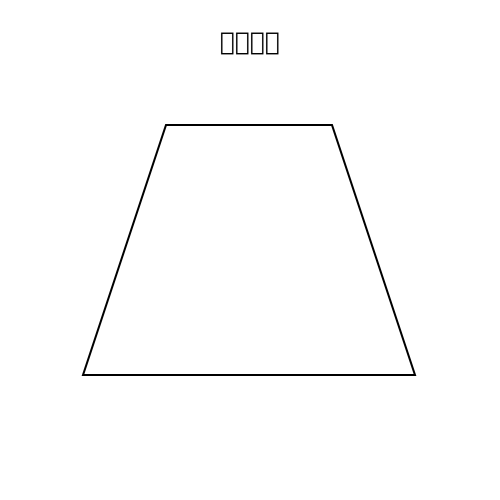

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

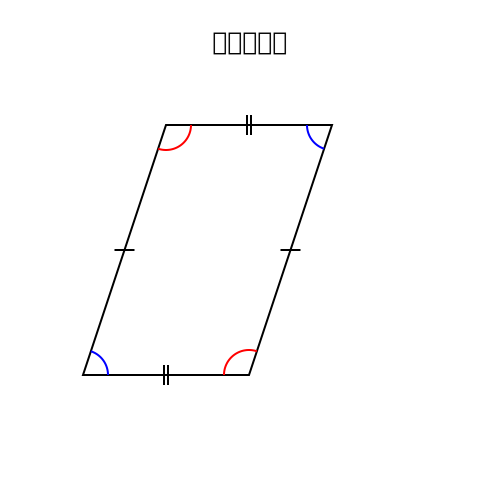

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

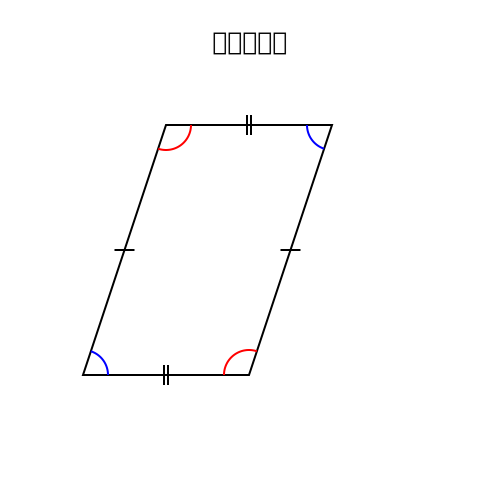

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

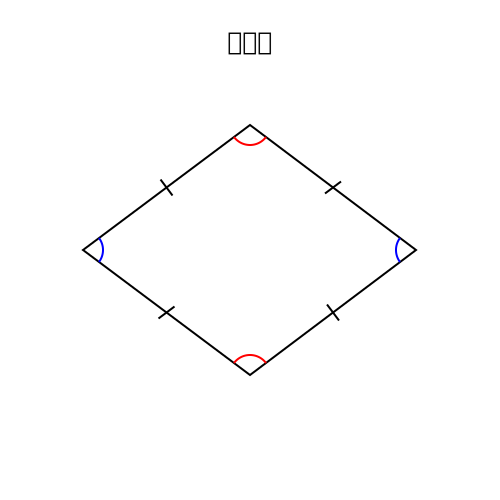

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

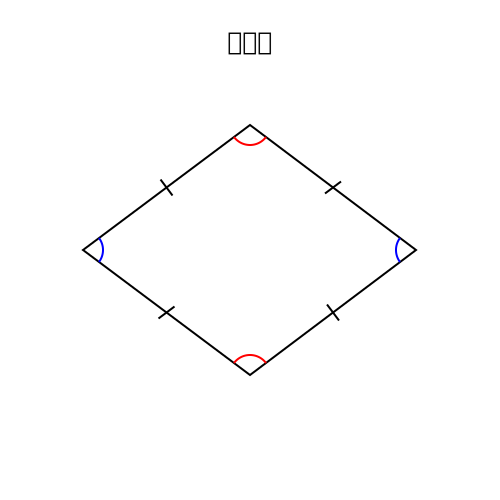

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

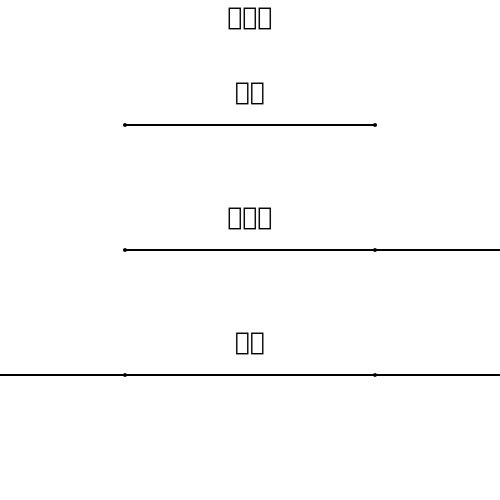

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="327.25424859373686" y2="186.0536869268817" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 165.45084971874738,303.61073738537635 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="184.4410322684471" y="313.6864378515658" font-size="12" text-anchor="middle">36°</text>
        </svg>
        


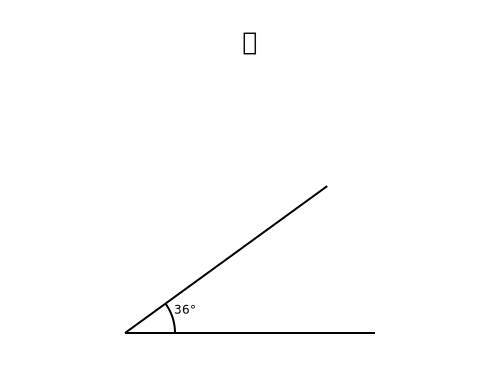

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

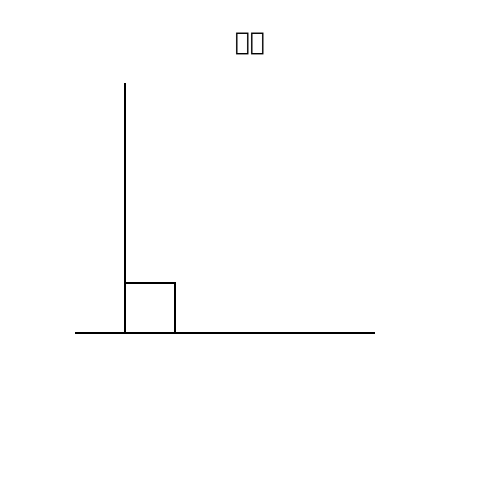

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


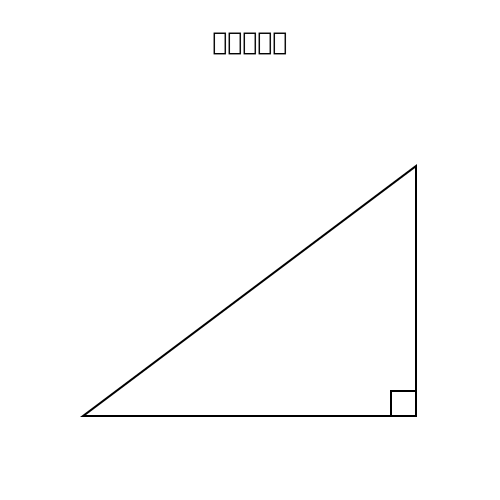

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


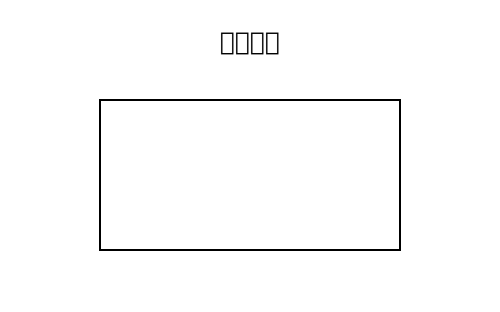

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


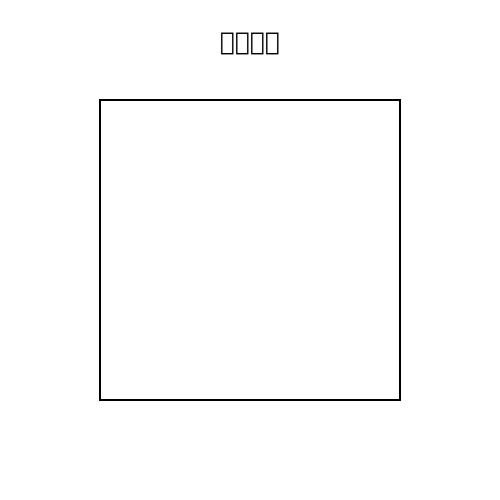

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


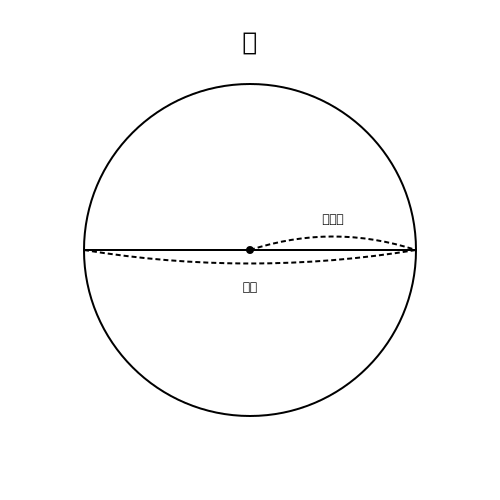

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


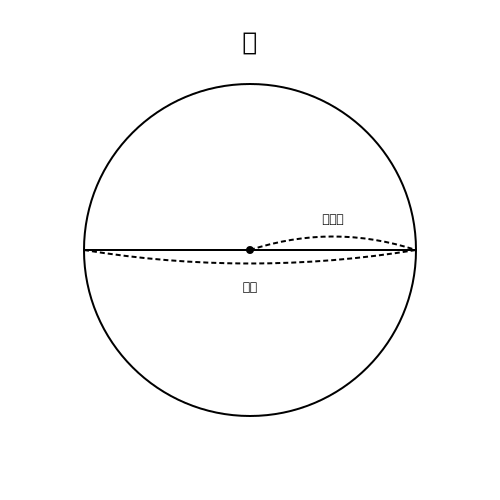

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

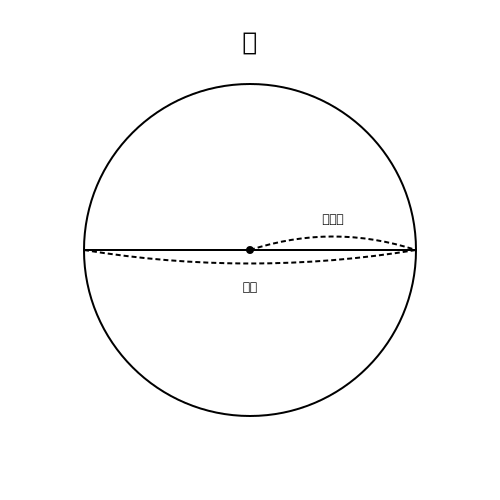

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

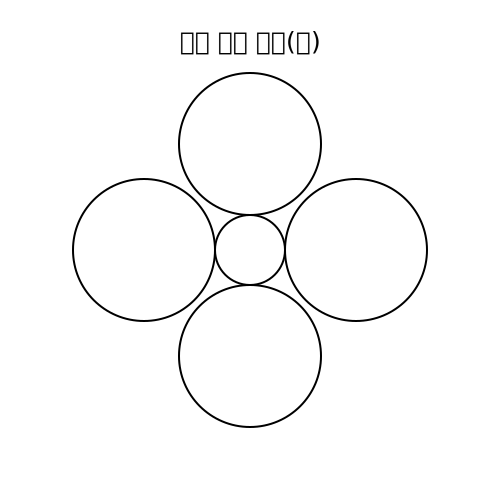

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="176.97792270443986" y2="88.4630998165486" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 135.39558454088797,284.09261996330974 A 50,50 0 0,1 175,333" stroke=

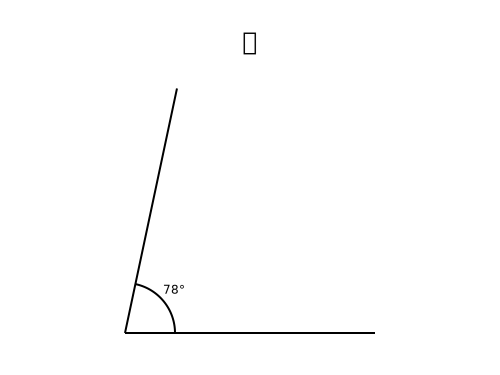

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="301.7766952966369" y2="156.22330470336314" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 160.35533905932738,297.6446609406726 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/

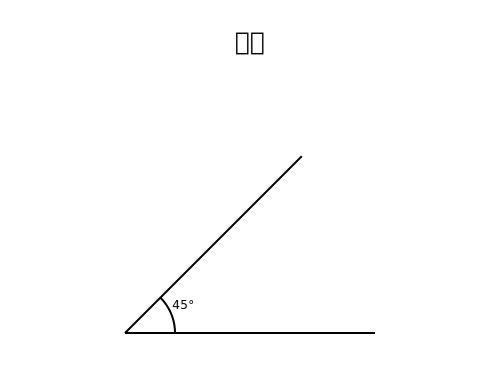

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="349.6985115747917" y2="223.40721330273067" stroke="black" stroke

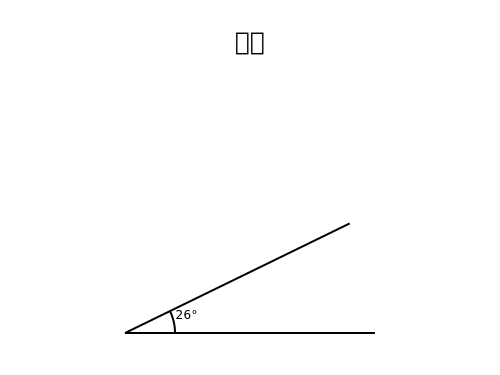

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="214.59198738632512" y2="99.60489337569956" stroke="black" stroke-width="2" />


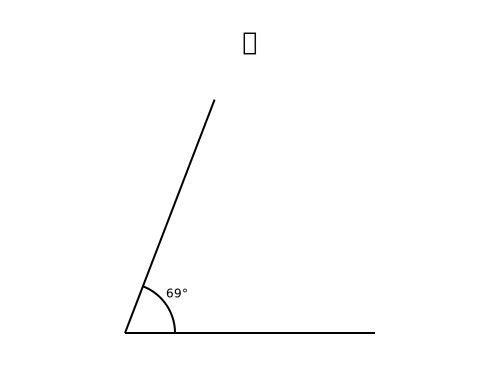

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="237.69705454388077" y2="97.60599446387603" stroke="black" stroke-width

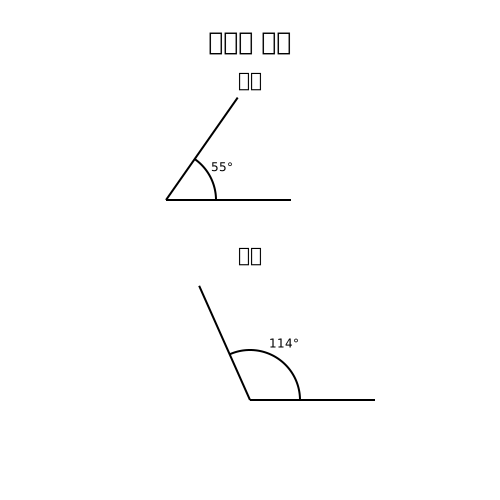

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="2.4329828146074135" y2="298.2067247599837" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.48659656292148,326.04

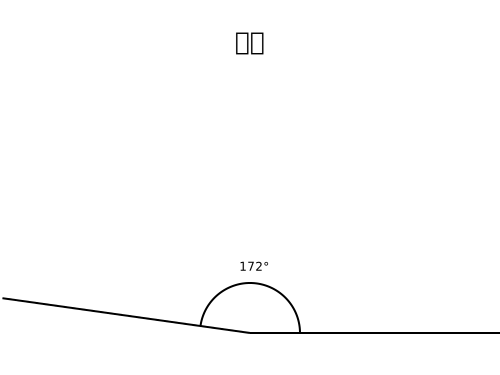

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

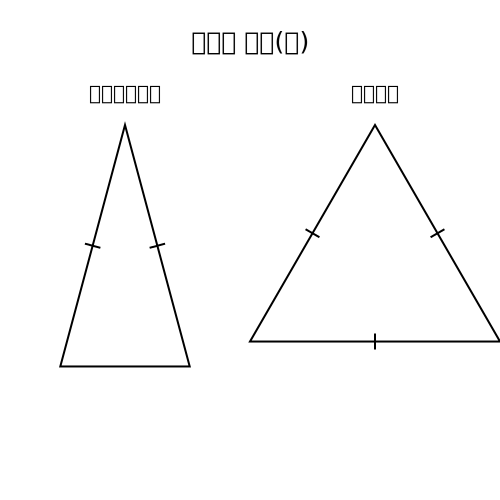

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

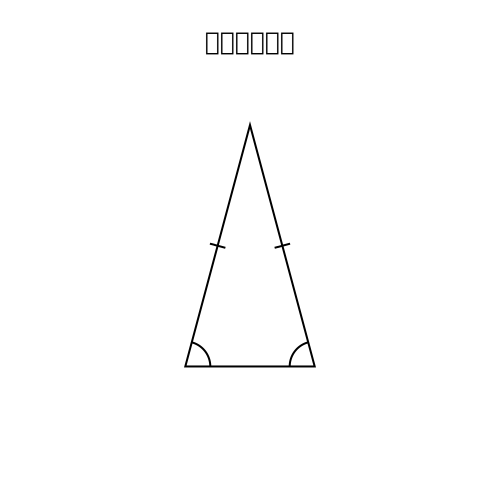

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

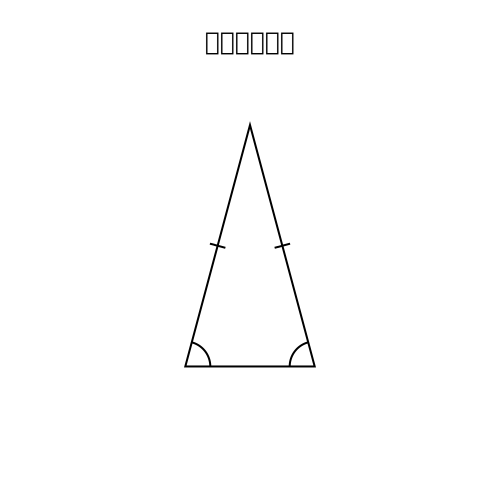

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

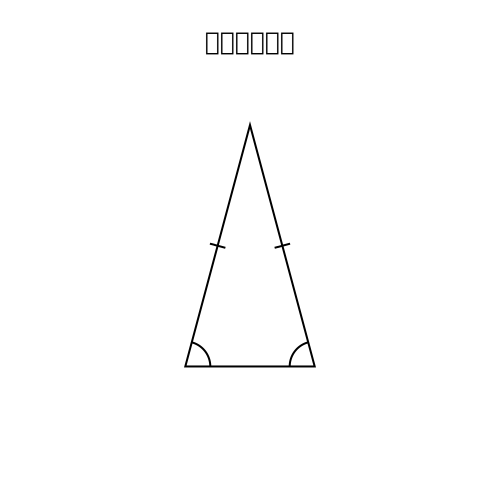

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

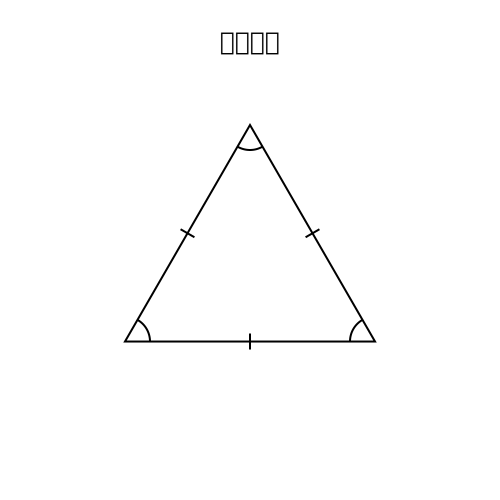

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

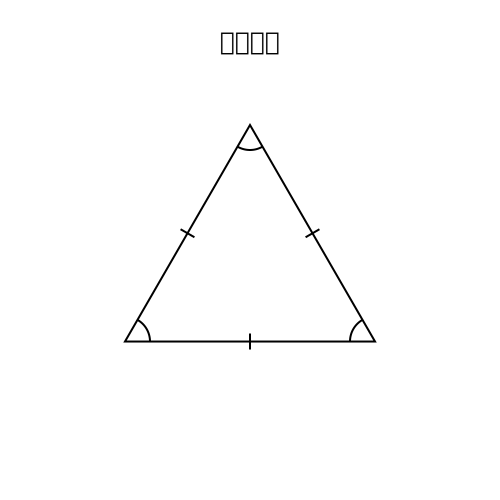

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

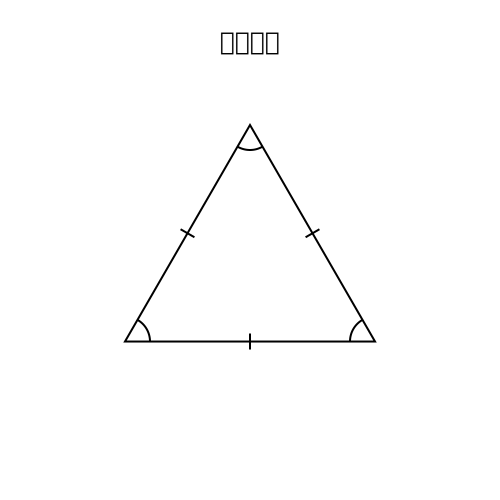

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


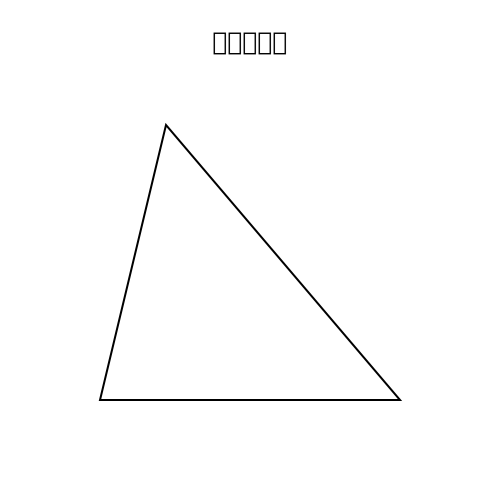

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

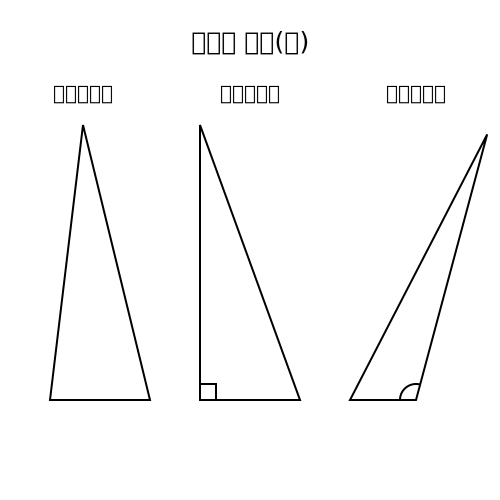

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


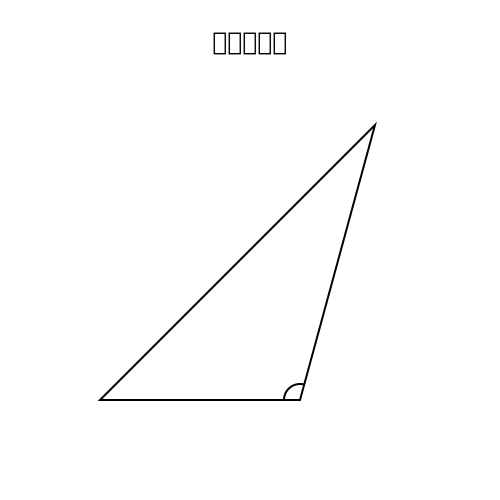

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

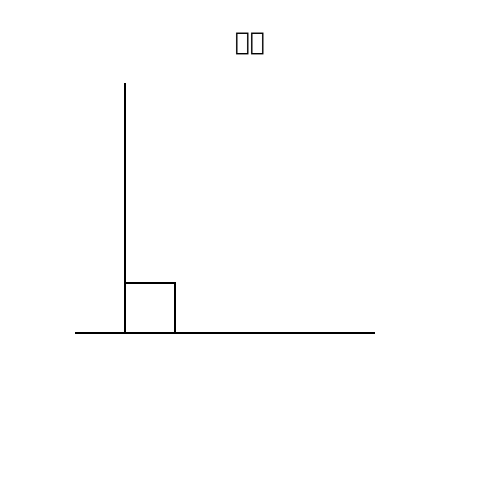

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

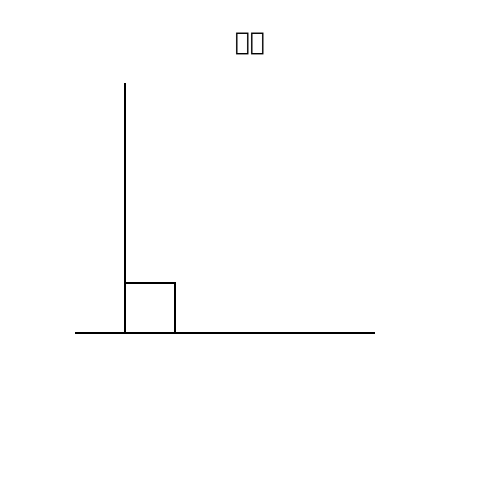

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

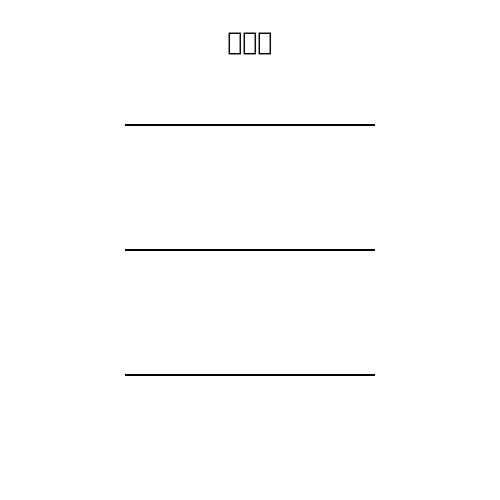

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

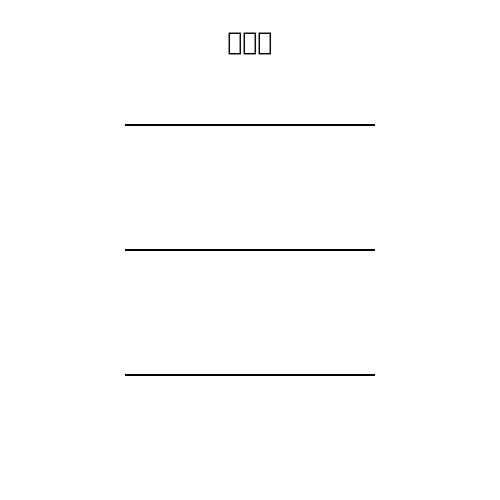

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


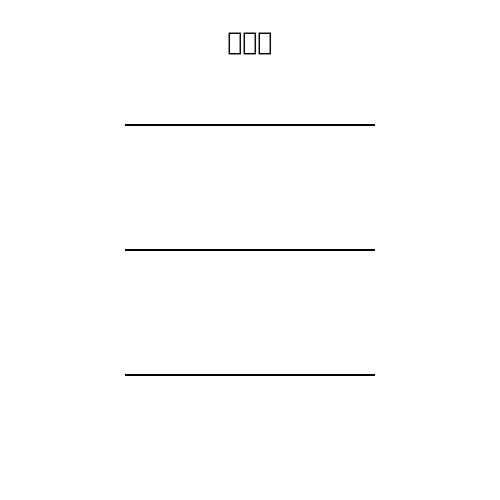

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

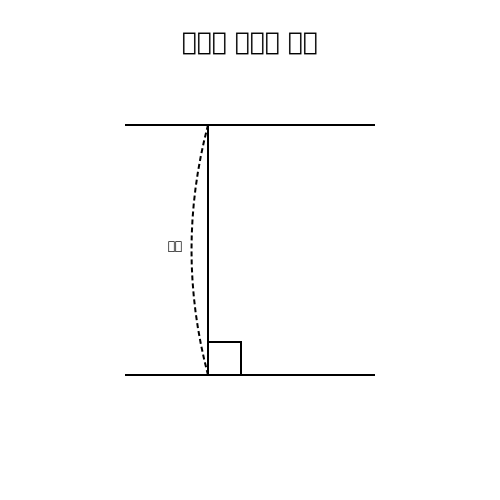

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

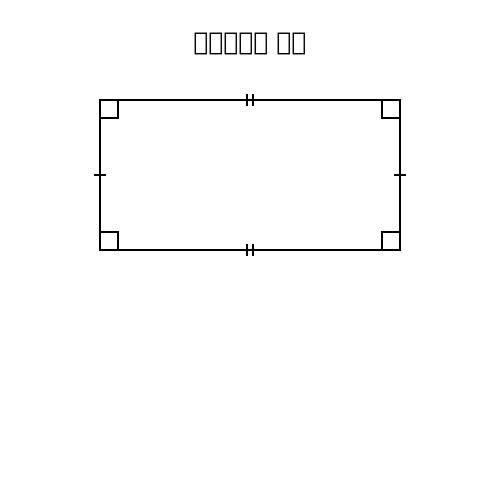

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

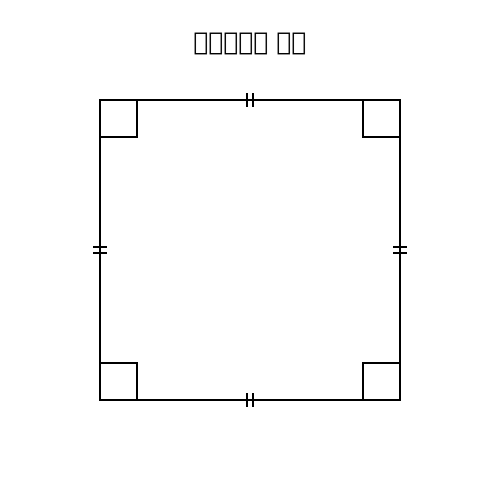

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

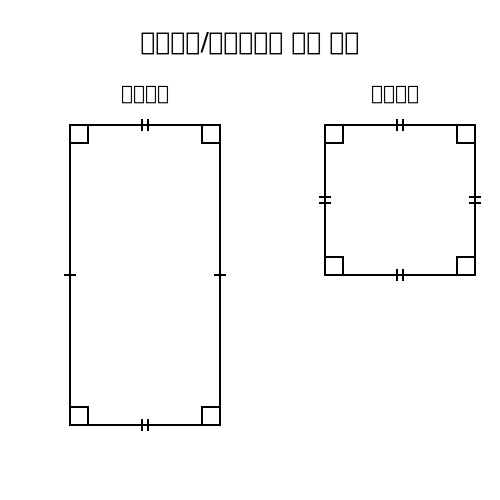

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


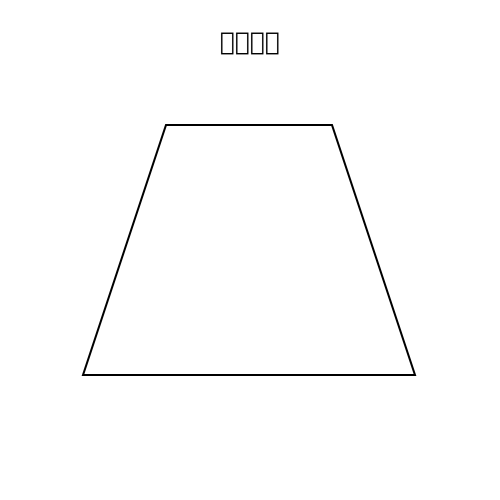

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

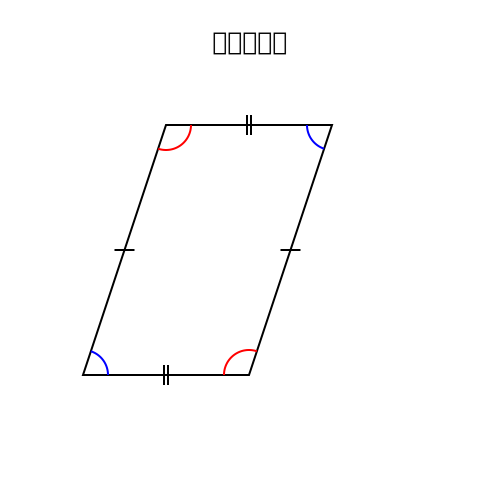

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

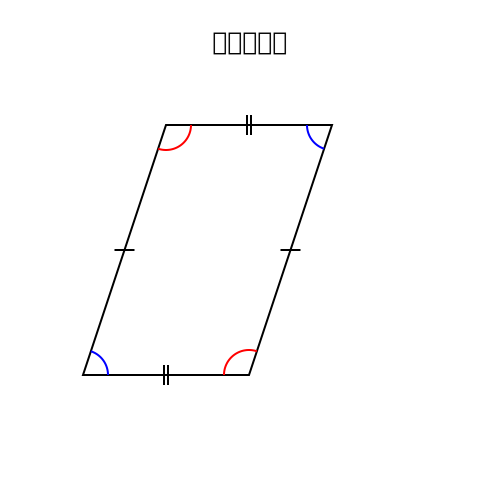

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

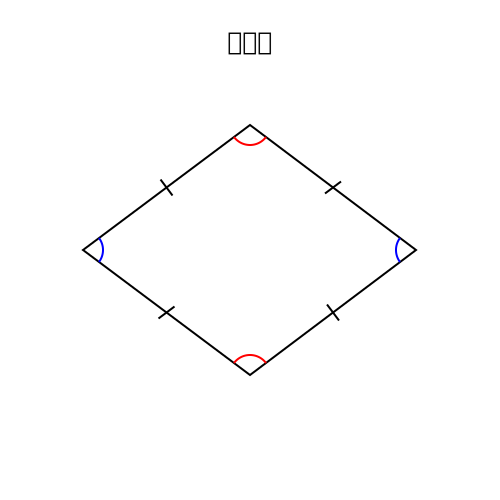

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

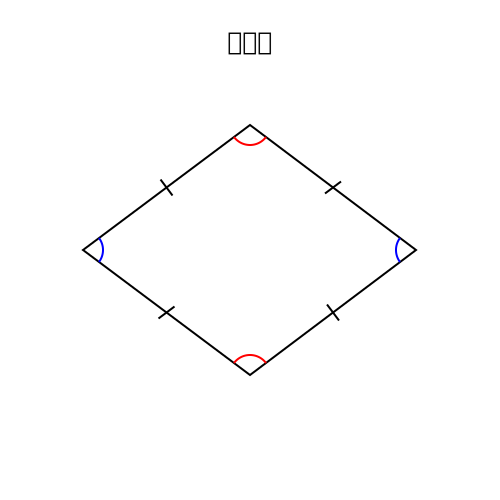

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

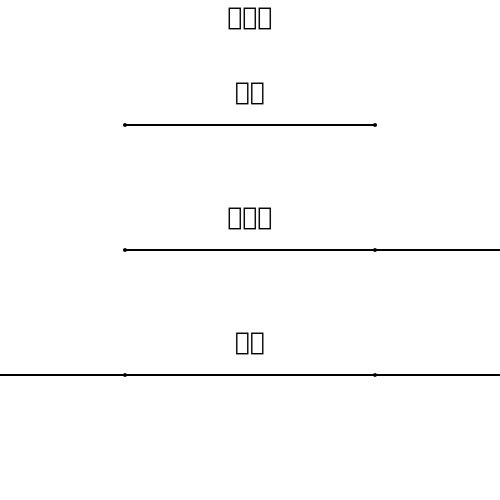

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="0.9513254770636195" y2="311.21106431308544" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.1902650954127,328.6422128626171 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="252.7262117103335" y="270.5594861511339" font-size="12" text-anchor="middle">175°</text>
        </svg>
        


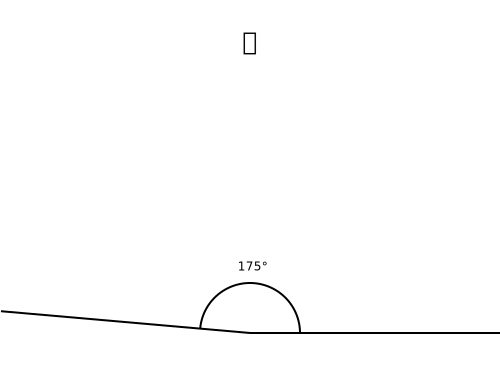

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

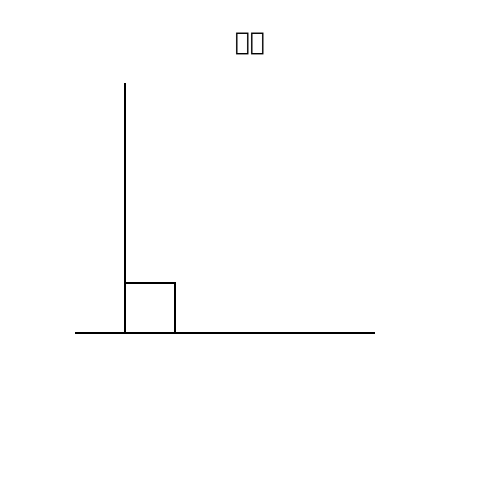

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


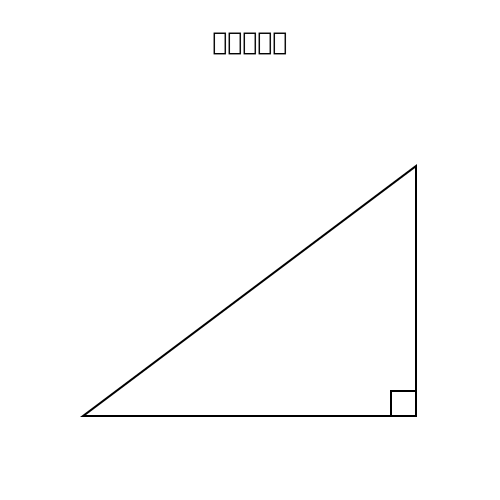

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


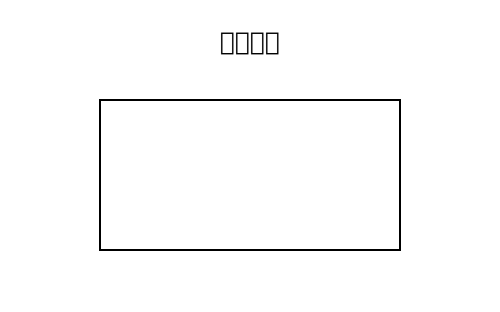

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


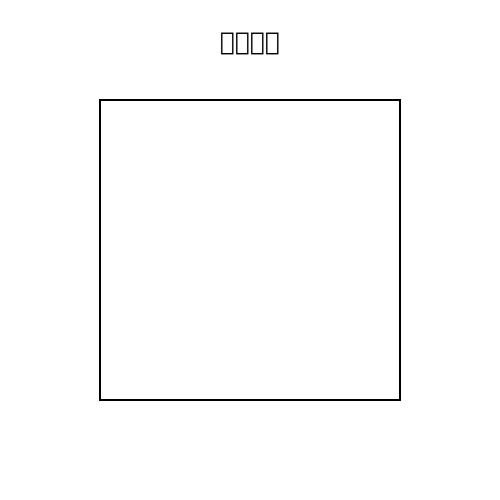

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


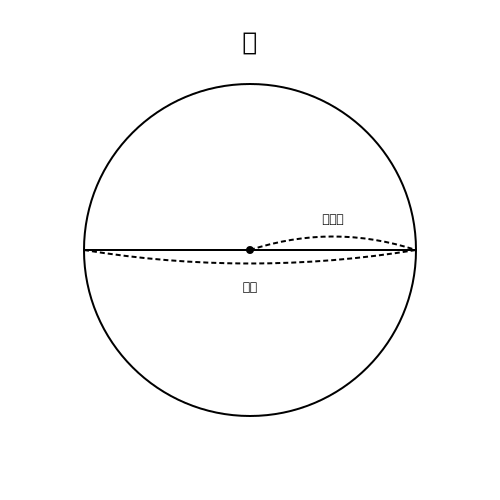

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


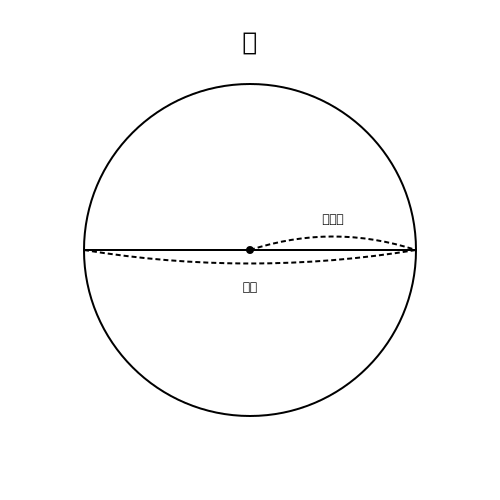

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

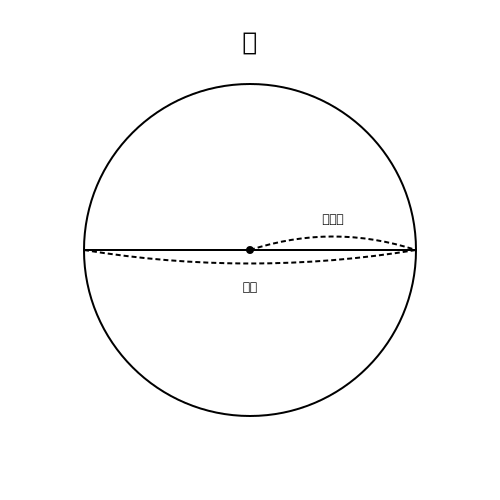

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

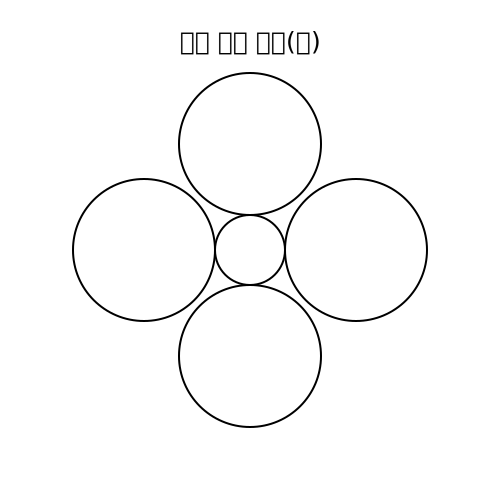

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="222.68278212231843" y2="102.87378663688992" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 144.5365564244637,286.974757327378 A 50,50 0 0,1 175,333" stroke="

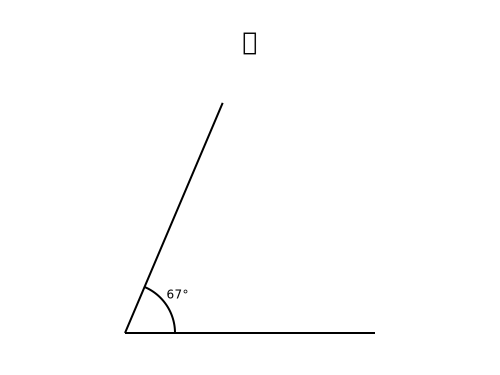

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="202.25424859373686" y2="95.23587092621162" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 140.45084971874738,285.4471741852423 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/

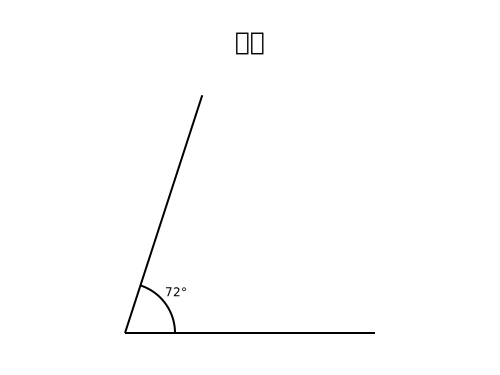

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="21.613635589349798" y2="231.3158392310499" stroke="black" stroke

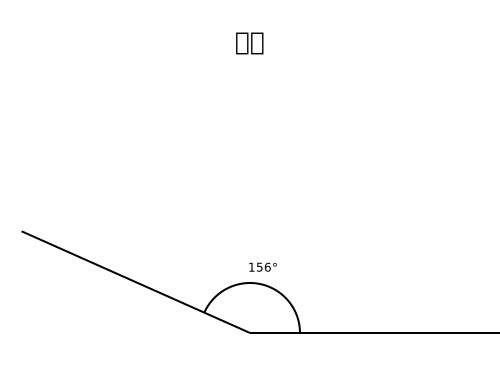

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="106.60589091223846" y2="128.2119889277521" stroke="black" stroke-width="2" />


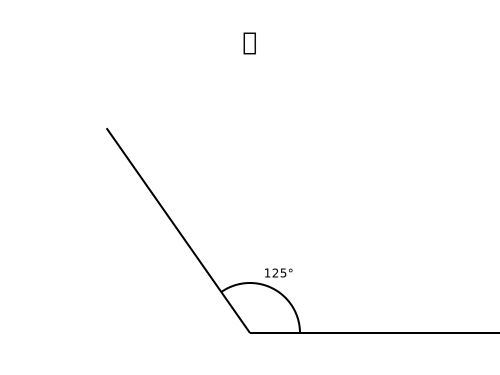

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="181.23366792564343" y2="75.93173104483475" stroke="black" stroke-width

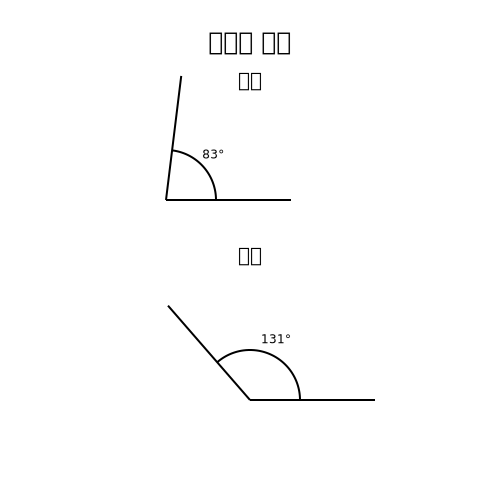

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="329.78801107224797" y2="189.6058909122385" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 165.9576022144496,304.321

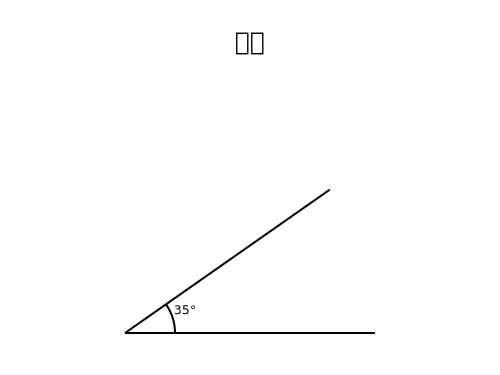

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

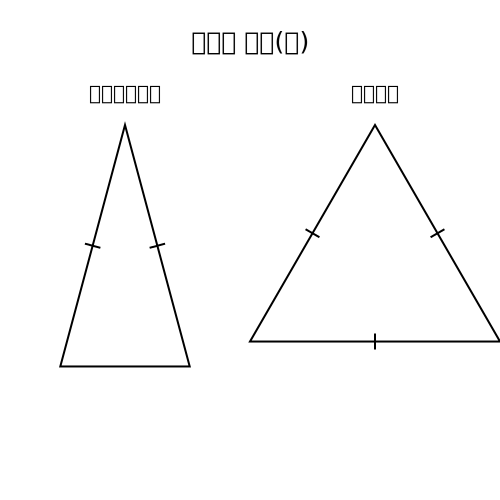

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

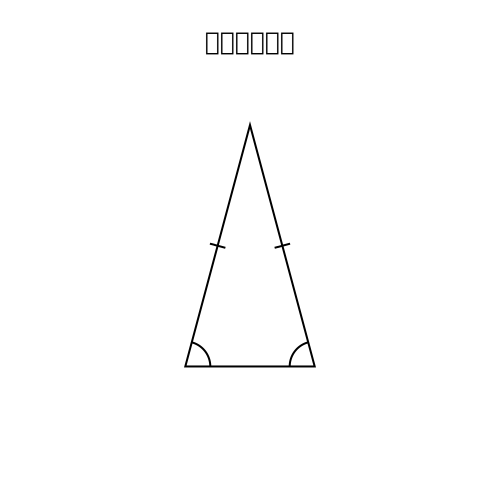

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

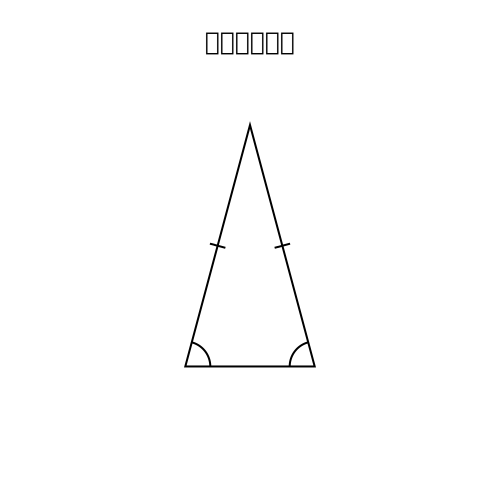

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

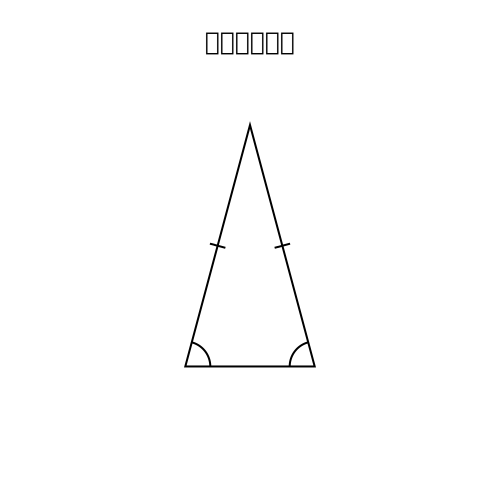

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

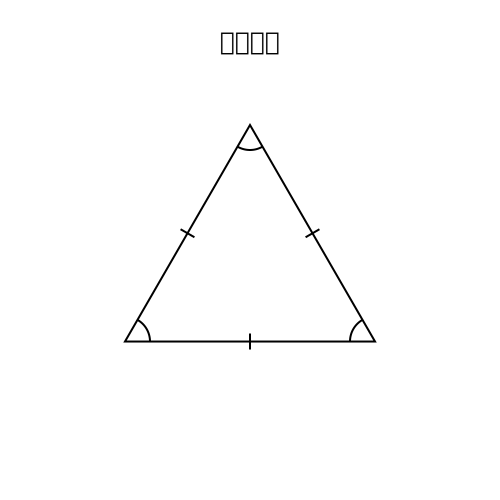

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

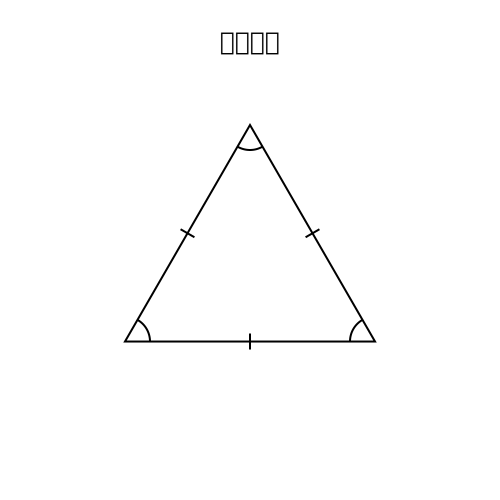

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

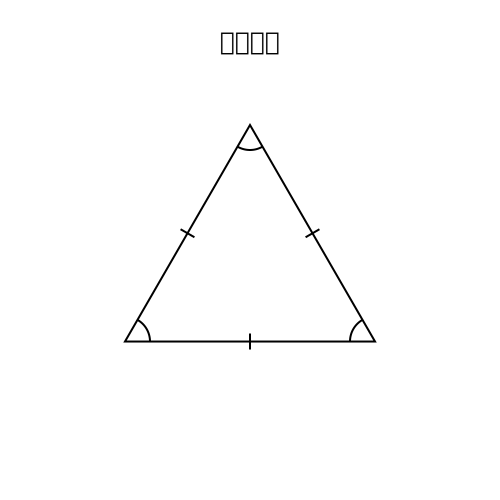

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


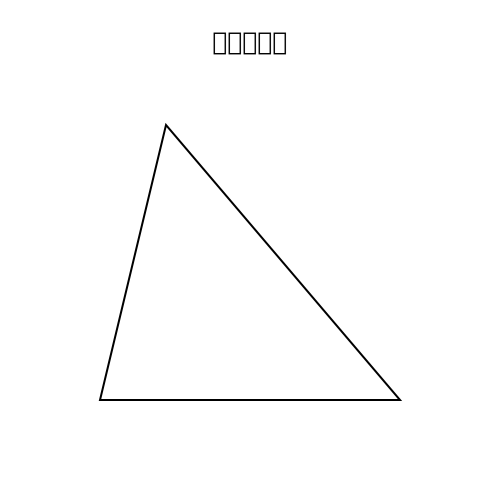

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

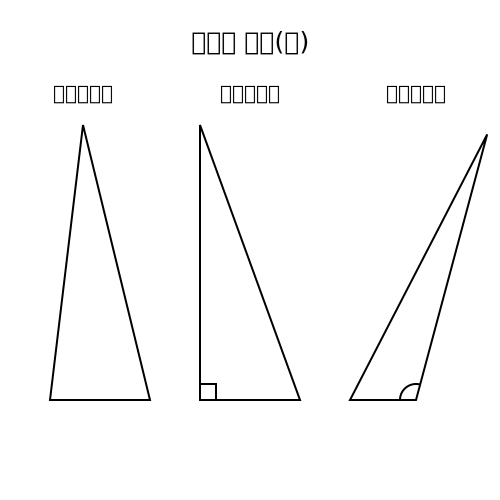

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


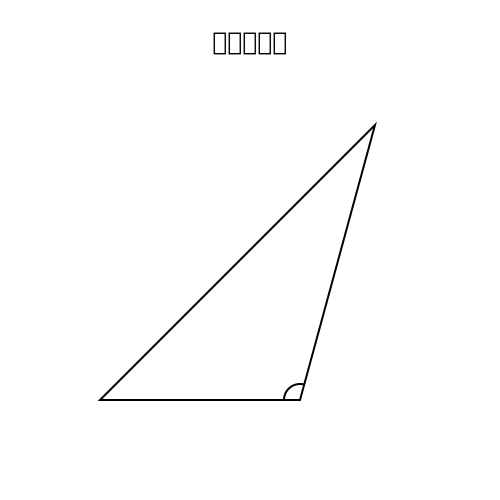

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

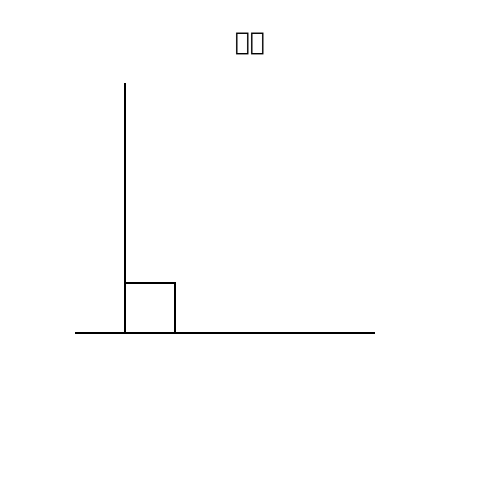

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

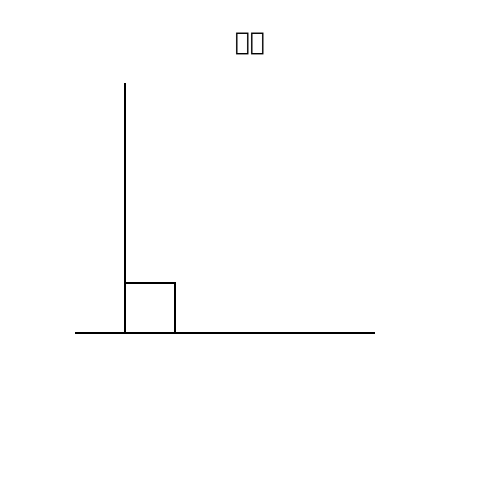

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

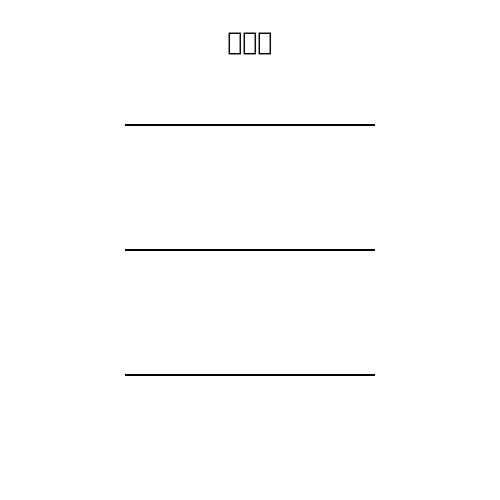

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

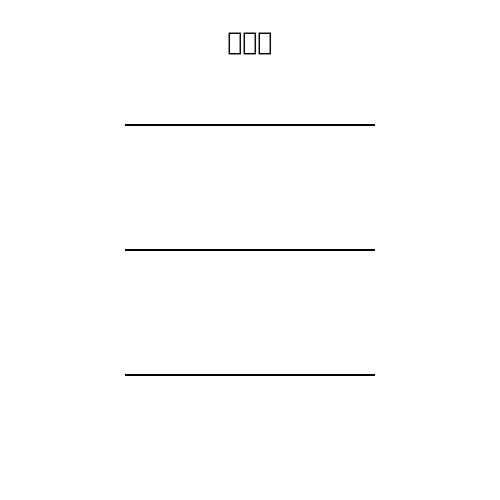

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


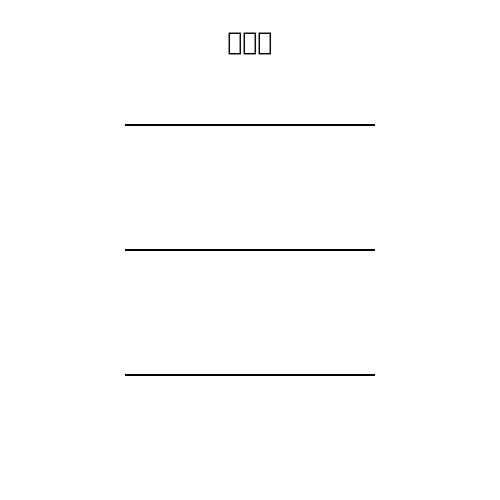

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

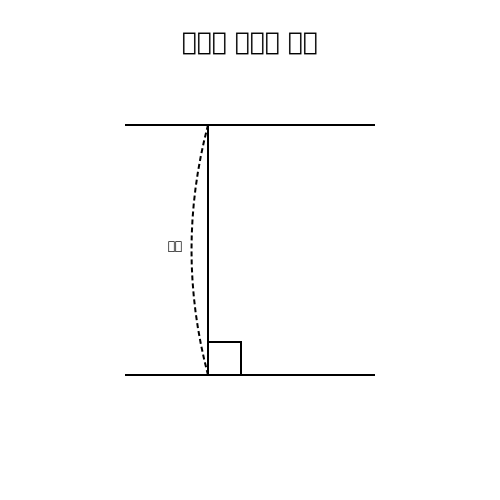

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

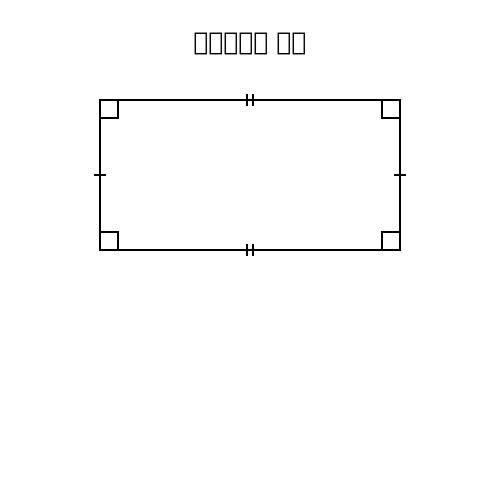

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

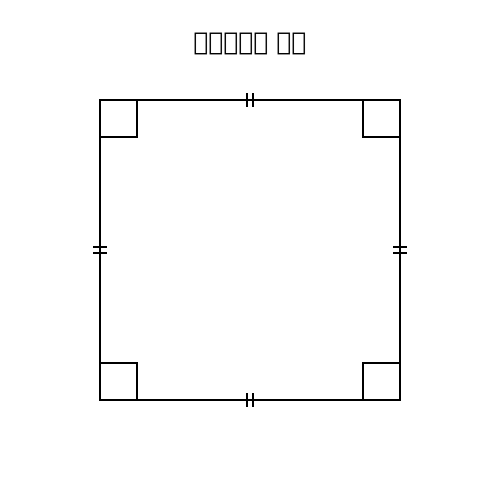

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

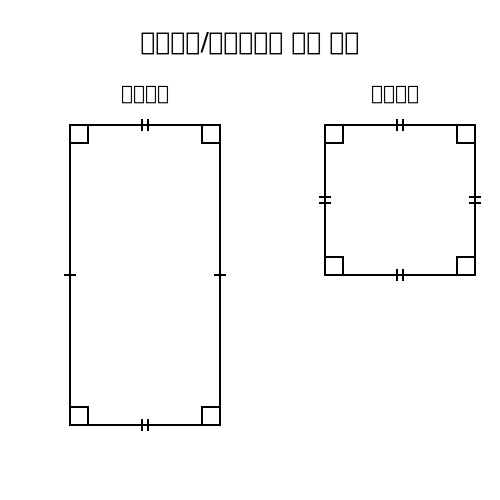

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


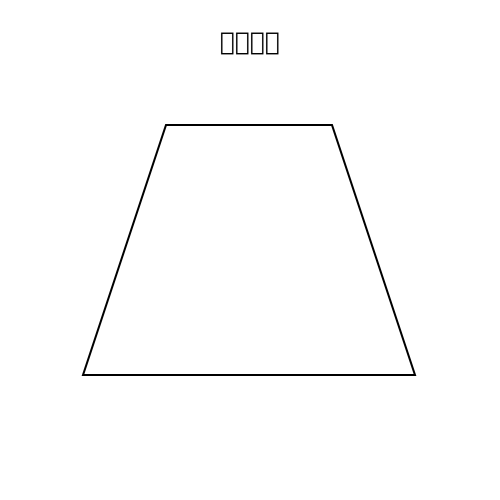

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

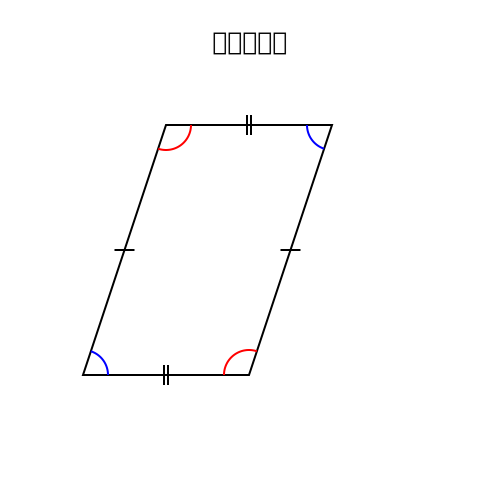

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

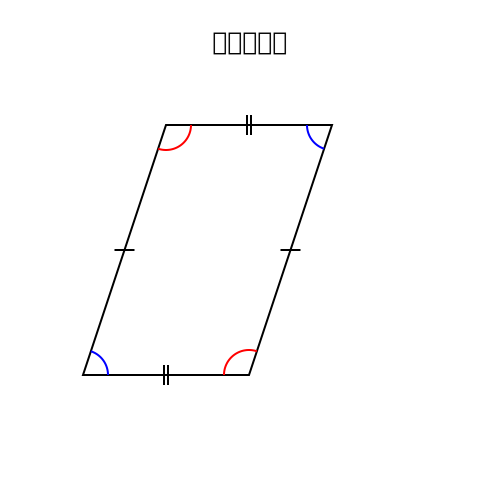

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

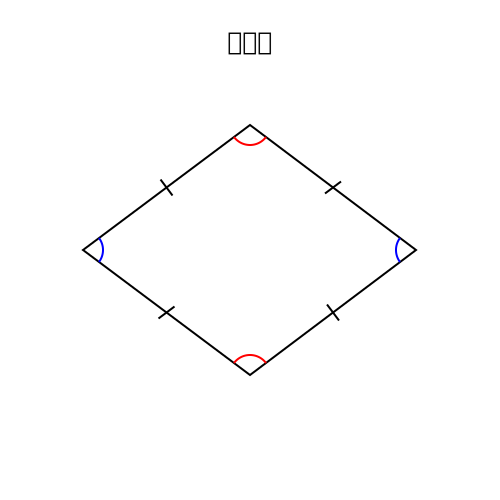

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

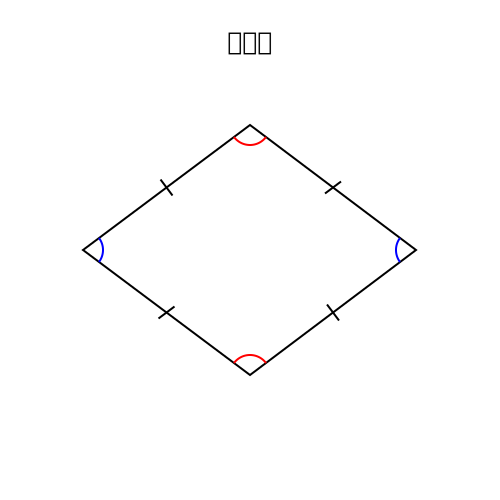

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 안녕하세요! 오늘은 **직선**에 대해 배워볼게요!

직선은 마치 무한히 뻗어나가는 **양쪽으로 곧게 뻗은 선**이에요. 마치 나무가 땅에서 하늘까지 쭉 뻗어 있는 것처럼요! 

직선은 **두 점**을 잇는 가장 짧은 길을 나타내기도 해요. 예를 들어, 책상 위에 놓인 두 점을 잇는 선이 바로 직선이랍니다.

**반직선**은 직선과 비슷하지만, 한쪽 방향으로만 무한히 뻗어나가요. 마치 화살표처럼요! 시작점에서 시작해서 오른쪽이나 왼쪽으로 계속 이어지는 거예요.

**선분**은 두 개의 **끝점**을 가진 직선의 일부분이에요. 마치 연필로 그린 선 중에서 시작점과 끝점이 있는 부분이 선분이랍니다.

이렇게 직선, 반직선, 선분은 우리 주변에서 자주 볼 수 있는 모양들이에요. 잘 기억했나요?

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <circle cx="375" cy="125" r="1" stroke="black" stroke-width="2" fill="black" />
    <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
    <!-- 반직선 -->
    <text x="250" y="225" font-size="25" text-anchor="middle"

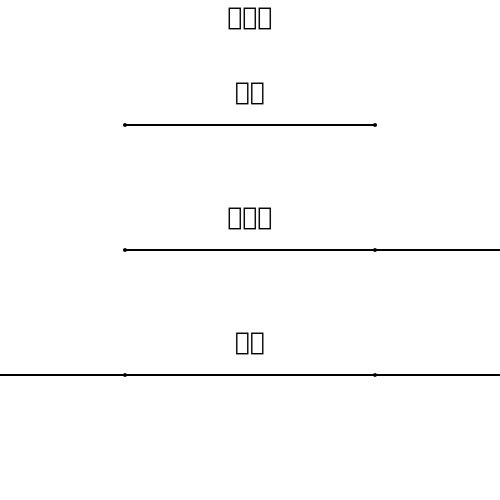

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 각을 이해하는 데 필요한 기본 개념들을 다시 한번 살펴보자!

각은 **두 선이 만나서 생기는 특별한 모양**이야. 이 두 선을 **변**이라고 부르고, 그들이 만나는 지점을 **꼭짓점**이라고 해. 마치 두 개의 선이 친구를 만나는 것처럼 생각하면 돼! 꼭짓점에서 두 변이 만나서 **각**이 완성되는 거지.

예를 들어, 문을 열 때 문이 만나는 부분이 꼭짓점이고, 문을 이루는 두 선이 변이 되는 거야. 각은 우리 주변에서 정말 흔하게 볼 수 있어!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="222.68278212231843" y2="102.87378663688992" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 144.5365564244637,286.974757327378 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선 -->
        <text x="177.117863879198" y="298.5039384179964" font-size="12" text-anchor="middle">67°</text>
        </svg>
        


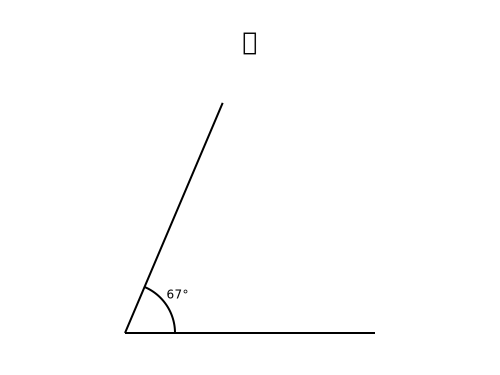

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 직각은 종이를 반듯하게 두 번 접었다 펼쳤을 때 생기는 특별한 각이야! 마치 종이가 딱 맞게 접히는 순간 만들어지는 각이 바로 직각이야. 이 각은 정확히 90도를 이루는데, 이는 우리가 일상생활에서 자주 접하는 모양들, 예를 들어 책상 모서리나 문 손잡이에서 쉽게 찾아볼 수 있어.

직각과 다른 각을 구별하는 방법은 간단해! 직각은 그 모양이 딱 맞게 folded back처럼 보이는 거야. 반면에 다른 각들은 좀 더 둥글거나 평평하게 보일 수 있어. 예를 들어, 직선을 따라 그린 선분이 만나는 각은 직각이 아니라 다른 각일 수 있어. 이런 각들은 직각처럼 정확히 90도가 아니라 조금 더 둥글거나 평평하게 보일 수 있어. 이렇게 보면 직각과 다른 각들이 어떻게 다른지 쉽게 이해할 수 있을 거야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직각</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 283" stroke="black" stroke-width="2" fill="none" /> 
        </svg>
     

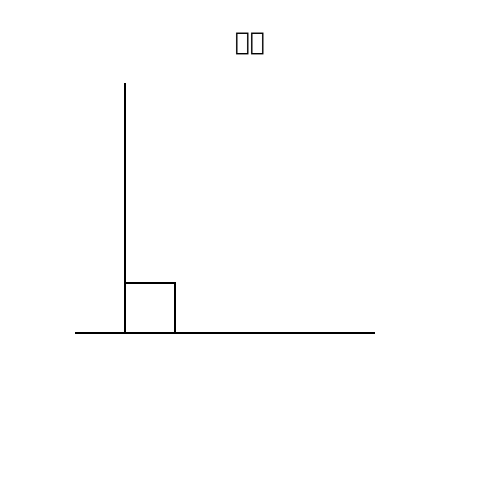

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 직각삼각형을 알아보는 건 재미있죠! 생각해보세요. 종이를 반듯하게 접고 펴면 생기는 각이 바로 직각이에요. 직각삼각형은 이름 그대로 **한 각이 정확히 직각**인 삼각형이에요.

직각삼각형에는 특별한 친구들이 있어요!

* **변**: 삼각형을 이루는 선분들이에요. 가장 긴 변을 **빗변**이라고 부르기도 해요. 나머지 두 변은 **밑변**과 **높이**라고 부르기도 해요. 밑변은 직각을 이루는 두 변 중 하나이고, 높이는 빗변에 수직으로 내려온 선분이에요.

* **각**: 세 변이 만나는 점에서 생기는 도형이에요. 직각삼각형에는 세 개의 각이 있어요. 그 중 하나가 바로 **직각**이에요! 나머지 두 각은 직각이 아닌 다른 각이에요.

직각삼각형을 보면서 **직각**이 어디에 있는지, 그리고 세 변의 길이를 살펴보면서 어떤 모양인지 생각해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" stroke-width="2" fill="none" /> 
    </svg>
    


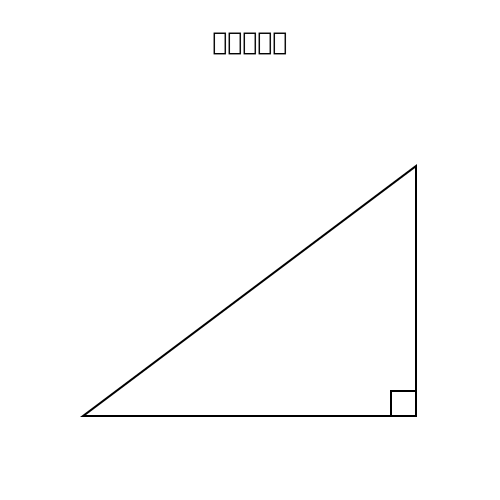

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 직사각형은 특별한 사각형이에요! 다른 사각형들과 어떻게 다른지 알아볼까요?

직사각형은 네 개의 변을 가지고 있어요. 중요한 특징은 두 개의 긴 변과 두 개의 짧은 변이 있다는 거예요. 그리고 모든 각이 직각, 즉 90도로 똑같이 맞아떨어져 있어요. 마치 종이를 반듯하게 접고 펴면 생기는 모양처럼요!

직사각형의 마주보는 변은 길이가 같아요. 그래서 직사각형은 네 각이 모두 같고, 대각선으로 자르면 똑같은 두 개의 삼각형이 만들어져요. 이렇게 특별한 모양 덕분에 직사각형은 건축이나 그림 그리기에 자주 쓰이죠!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


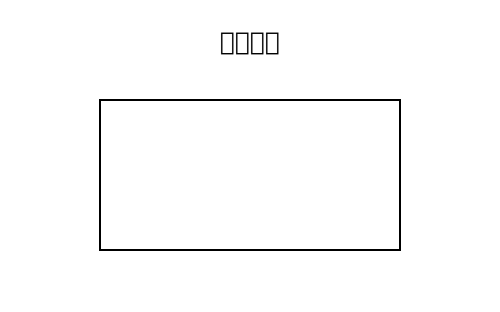

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 사각형이야! 다른 사각형들과 가장 다른 점은 네 변의 길이가 모두 똑같고 네 각이 모두 똑같이 직각, 즉 90도라는 거야. 

마치 네 개의 똑같은 블록을 이용해 만든 것처럼 보이지? 각 블록이 변을 이루고, 각 블록이 만나는 곳마다 꼭짓점이 생기는 거지. 정사각형 안에서는 대각선으로 길게 뻗어도 그 길이가 같아. 그래서 정사각형은 모든 방향으로 똑같이 보이는 완벽한 대칭 도형이야!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    </svg>
    


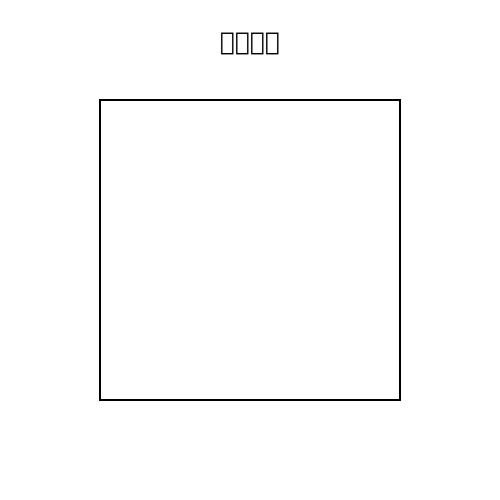

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 원에 대해 알아볼게요! 원은 중심에서 원 위의 어떤 점까지의 거리가 모두 같은 특별한 도형이에요. 이 중심에서 원 위의 점까지의 거리를 **반지름**이라고 부르죠. 반지름은 원의 크기를 알려주는 중요한 부분이에요.

그리고 원의 **지름**은 원을 완전히 가로지르는 가장 긴 선분이에요. 이 지름은 원의 중심을 지나서 원의 양쪽 끝점을 연결해요. 재미있는 점은 **지름은 반지름의 두 배**라는 거예요! 즉, 만약 반지름을 재면 지름은 그 값을 두 배로 늘려주면 되는 거죠. 이렇게 쉽게 측정하거나 구할 수 있어요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


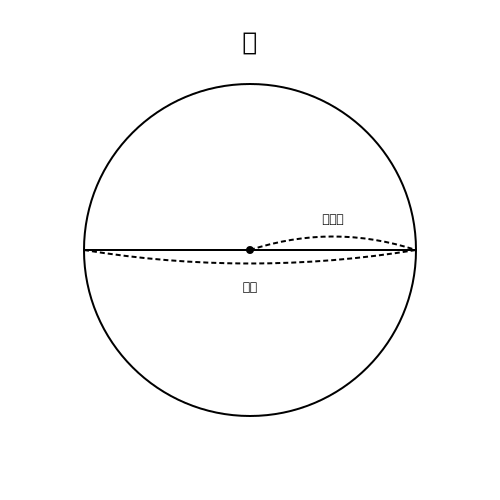

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 원의 지름과 반지름에 대해 알아보자!

원 안에 가장 긴 선분을 지름이라고 부르는데, 이 지름은 원의 중심을 지나서 원의 가장자리까지 이어진다. 재미있는 점은 지름은 반지름의 두 배라는 거야! 예를 들어, 만약 원의 반지름이 3cm라면, 그 원의 지름은 6cm가 되는 거지. 반대로 반지름만 알면 지름을 쉽게 구할 수 있어. 반지름을 그냥 두 배로 늘리면 지름이 되는 거야! 이렇게 지름과 반지름의 관계를 알면 원의 크기를 쉽게 비교하거나 계산할 수 있어.

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


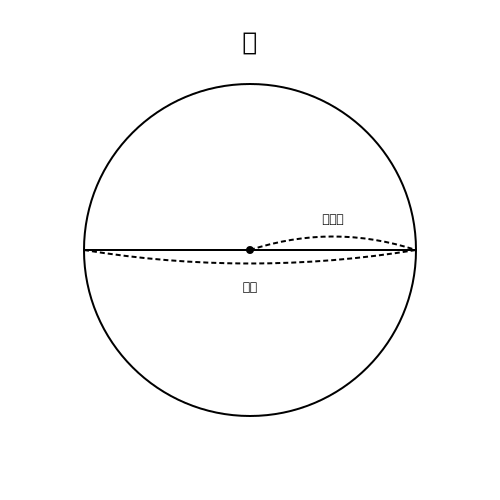

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 컴퍼스를 이용해 정확한 원을 그리는 방법을 알려드릴게요!

1. **중심 정하기**: 먼저 원을 그릴 곳에 작은 점을 하나 찍어요. 이 점이 원의 중심이 될 거예요.

2. **반지름 정하기**: 컴퍼스의 한쪽 끝을 중심 점에 고정하고, 다른 끝을 원하는 반지름 길이만큼 조절해요. 예를 들어, 반지름이 5cm라면 컴퍼스의 한쪽 끝을 중심에 고정하고 다른 끝을 5cm로 조절해요.

3. **원 그리기**: 컴퍼스의 조절된 끝을 중심 점 주변으로 천천히 돌리면서 원을 그려요. 컴퍼스를 돌리면서 항상 같은 거리(반지름)를 유지해야 해요.

4. **지름 표시**: 원을 그린 후, 원의 중심을 지나는 직선을 그려요. 이 직선이 바로 원의 지름이에요. 지름을 표시하려면 중심 점에서 원의 가장자리까지의 거리를 측정하고, 그 길이를 표시하면 돼요. 이렇게 하면 원의 반지름과 지름을 쉽게 알 수 있어요. 반지름은 중심에서 원 위의 점까지의 거리이고, 지름은 원의 중심을 지나면서 원의 가장자리까지의 거리예요. 반지름은 지름의 절반이라는 점도 기억해두세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d

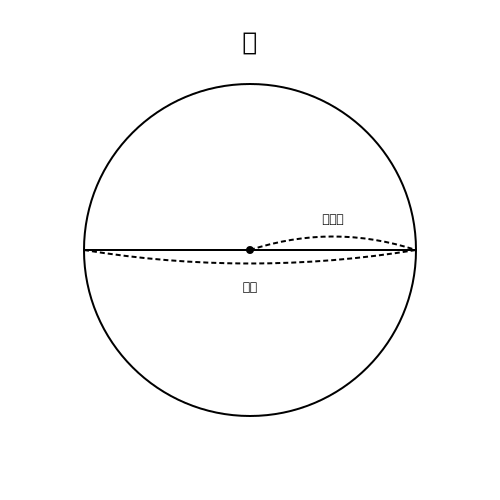

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 원을 이용해 재미있고 창의적인 도형이나 패턴을 만드는 방법을 알려드릴게요!

**1. 꽃 모양 만들기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 원을 여러 개 그린다. 크기는 자유롭게 조절해보세요!
    2. 작은 원들을 큰 원 안에 넣어 꽃 모양처럼 배열한다.
    3. 각 원 사이에 선분을 그어 꽃잎처럼 연결하면 더욱 예쁜 꽃 모양이 완성돼요!

**2. 별 모양 패턴:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 종이에 컴퍼스를 이용해 여러 개의 원을 그린다. 원의 크기는 다양하게 조절해보세요.
    2. 원들을 서로 겹치게 배치하고, 겹치는 부분을 살짝 눌러 붙여준다.
    3. 이렇게 만들어진 원들을 연결하면 반짝이는 별 모양 패턴이 완성돼요!

**3. 동물 모양 그리기:**

* **준비물:** 컴퍼스, 연필, 종이
* **방법:**
    1. 컴퍼스를 이용해 동물의 몸통이나 다리 모양을 원으로 그린다. 예를 들어, 큰 원으로 몸통을, 작은 원들을 연결해 다리를 표현할 수 있어요.
    2. 원들을 조합하고 선을 그어 동물의 특징적인 모양을 만들어 보세요!

원은 자유롭게 그릴 수 있고 다양한 모양을 만들 수 있는 마법 같은 도형이에요. 창의력을 발휘해서 멋진 도형들을 만들어 보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy="250" r="35" stroke="black" stroke-width="2" fill="none" />
    <circle

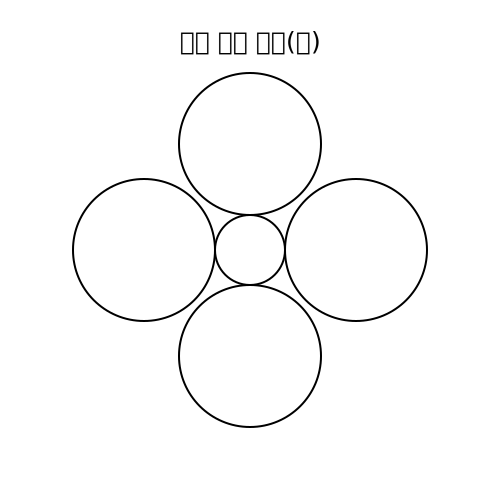

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 각의 크기를 비교하는 방법을 간단하게 설명해 드릴게요!

1. **꼭짓점과 변 활용**: 먼저, 각의 꼭짓점을 찾고, 그 꼭짓점에서 시작하는 두 변이 있다고 생각해보세요. 각 변이 얼마나 벌어지는지 보는 거예요.

2. **직각**: 직각은 종이를 접었다 펴면 생기는 모양처럼, 정확히 90도예요. 두 변이 정확히 맞닿아 있어 벌어지지 않죠.

3. **예각**: 예각은 직각보다 작은 각을 말해요. 두 변이 살짝 벌어져 있어요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각에 해당해요.

4. **둔각**: 둔각은 예각보다 크고 직각보다 큰 각을 의미해요. 두 변이 많이 벌어져 있어요. 마치 팔을 크게 벌린 상태처럼요.

이렇게 꼭짓점에서 시작하는 두 변이 얼마나 벌어져 있는지 보면서 각의 크기를 쉽게 비교할 수 있어요! 직각은 가장 작은 각이고, 둔각은 가장 큰 각이라는 걸 기억해두세요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="347.75163104709196" y2="219.5023750651133" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 169.5503262094184,310.30047501302266 A 50,50 0 0,1 175,333" stroke=

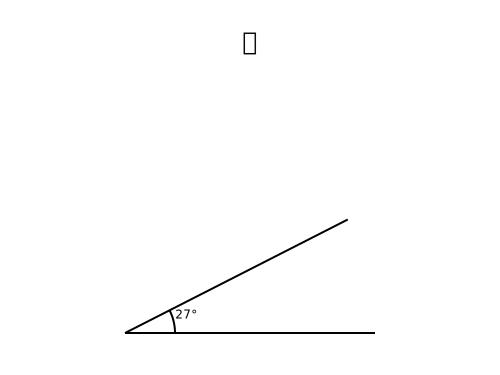

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 각도기를 사용해 각의 크기를 정확히 재는 방법은 정말 간단해요!

1. **각도기 준비**: 먼저 각도기를 준비해요. 각도기의 중심점은 꼭짓점(각을 이루는 두 선이 만나는 점)에 맞춰요.

2. **기준선 맞추기**: 각도기의 밑변을 기준선에 맞춰요. 이 기준선은 우리가 측정하고자 하는 두 선 중 하나와 일치시켜야 해요.

3. **각도 확인**: 다른 한 변을 각도기의 눈금선과 일치시키면서 얼마나 벌어져 있는지 확인해요. 각도기의 눈금선이 얼마나 많이 벌어져 있는지 보면 그 각도의 크기를 알 수 있어요. 예를 들어, 눈금선이 30도를 가리키면 그 각은 정확히 30도예요.

이렇게 하면 각도기를 통해 정확하게 각의 크기를 재는 것이 가능해요! 꼭짓점과 기준선을 잘 맞추고 눈금을 잘 확인하면 쉽게 측정할 수 있어요.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="238.4976249348867" y2="110.24836895290807" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 147.69952498697734,288.44967379058164 A 50,50 0 0,1 175,333" stroke="black" stroke-width="2" fill="none"

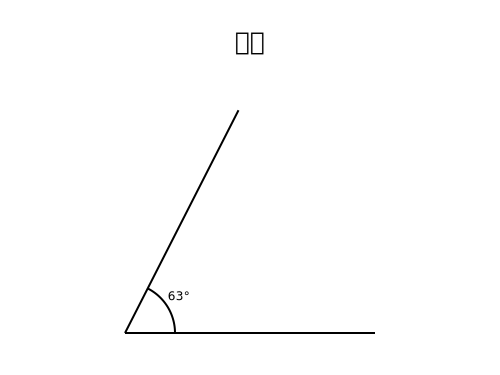

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 각도를 이해하는 건 정말 중요해요! 우리가 일상에서 자주 접하는 각도를 알아보자구요.

**각도는 어떻게 표현할까요?**
각도는 **도(°)**라는 단위로 표현해요. 예를 들어,
- **0°**는 완전히 평평한 상태를 나타내요. 마치 종이를 평평하게 펴놓은 것처럼요.
- **90°**는 직각을 의미해요. 종이 접어서 만든 직각 모양처럼요.
- **180°**는 반원을 이루는 각도예요. 종이를 반으로 접었을 때 생기는 각도와 비슷해요.
- **360°**는 한 바퀴를 돌았을 때의 각도예요. 시계를 보면 한 시간마다 360°가 돌아가는 걸 볼 수 있어요.

**각도 비교하기**
각도를 비교할 때는 꼭짓점(각의 시작점)과 한 변을 서로 맞대고 보세요. 다른 변들이 얼마나 벌어져 있는지 보면서 비교하면 돼요. 예를 들어:
- 만약 한 각이 다른 각보다 더 벌어져 있다면, 그 각이 더 크다고 말할 수 있어요.
- 만약 두 각이 비슷하게 벌어져 있다면, 크기가 비슷하다고 말할 수 있어요.

이렇게 각도를 도(°)로 표현하고 비교하면서, 우리 주변의 다양한 모양이나 물체의 각도를 쉽게 이해할 수 있어요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="164.10861626005772" y2="86.07791485121555" stroke="black" stroke

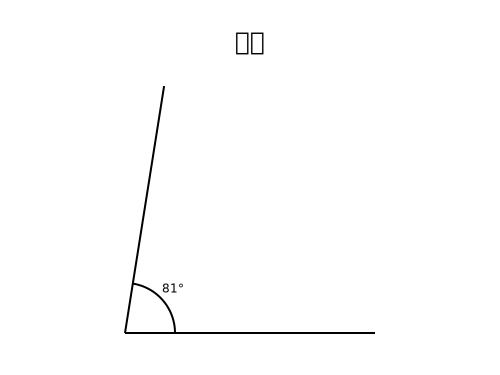

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 물론이죠! 각도를 정확히 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저 자를 사용해 평평한 표면에 직선을 그립니다. 이 직선이 기준선이 됩니다.

2. **꼭짓점 정하기**: 기준선 위에 원하는 위치에 점을 하나 정합니다. 이 점이 바로 각도의 꼭짓점이 될 것입니다.

3. **각도 표시하기**: 각도기를 사용해 원하는 각도를 확인합니다. 각도기의 중심을 꼭짓점에 맞추고, 각도기의 밑변을 기준선과 일치시킵니다. 각도기의 눈금을 따라 원하는 각도에 해당하는 위치를 찾아 표시합니다.

4. **각 그리기**: 이제 자를 이용해 표시한 각도기 위치에 따라 꼭짓점에서 시작해 그 각도에 맞게 선을 그립니다. 한 변은 기준선과 일치하도록 하고, 다른 변은 각도기 표시에 따라 그립니다. 이렇게 하면 원하는 각도가 정확히 그려집니다.

이렇게 하면 각도기와 자를 이용해 정확한 각도를 그릴 수 있습니다. 중요한 건 각도기의 눈금을 잘 확인하고, 자를 이용해 정확하게 그 각도를 따라가는 것입니다. 이렇게 하면 각도를 잘 이해하고 그릴 수 있게 됩니다!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="113.84024124624324" y2="123.33235801364401" stroke="black" stroke-width="2" />

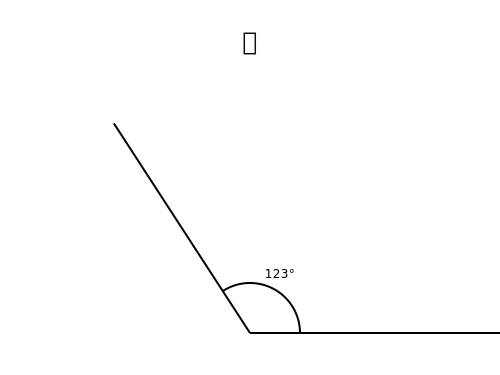

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 각도를 이해하는 데 도움이 되도록 간단하게 설명해 드릴게요!

각도는 종이나 선을 이루는 두 선이 만나서 생기는 공간의 크기를 말해요. 이 각도를 세 가지로 나눠볼 수 있어요:

1. **예각**: 이 각은 0도에서 90도 사이에 있어요. 마치 햇살이 비치는 각도처럼요! 예를 들어, 작은 손가락이 살짝 벌어진 각도가 예각이에요.

2. **직각**: 정확히 90도예요. 종이를 접었을 때 생기는 모서리 각도가 바로 직각이에요. 이 각은 종이 접기나 건물의 벽과 바닥이 만나는 각도처럼요.

3. **둔각**: 이 각은 90도에서 180도 사이에 있어요. 마치 큰 손이 펴져 있는 각도처럼요! 예를 들어, 큰 손이 완전히 펴져 있을 때 생기는 각도가 둔각이에요.

이렇게 세 가지로 나누면 어떤 각도가 예각인지, 직각인지, 둔각인지 쉽게 알 수 있어요! 각도기를 사용해 직접 그려보면서 연습해보는 것도 재미있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각과 둔각</text>
        <!-- 예각 -->
        <text x="250" y="87" font-size="20" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="166" y1="200" x2="291" y2="200" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="166" y1="200" x2="228.5" y2="91.74682452694518" stroke="black" stroke-width="2" />
     

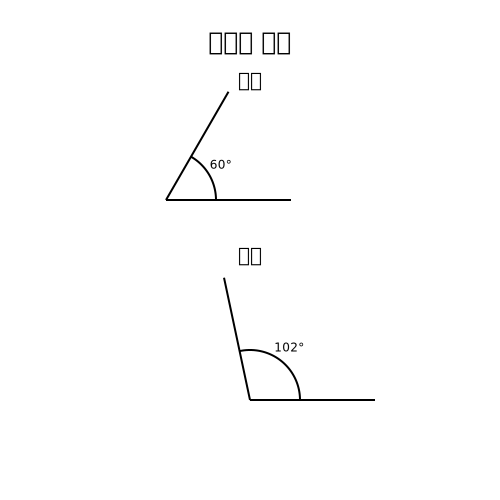

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 친구들! 오늘은 각도를 알아보는 재미있는 활동을 해볼게요!

먼저, 어떤 모양이나 공간을 보고 그 안에 있는 각도를 눈으로 먼저 추정해봐요. 예를 들어, 책상 모서리에 있는 작은 삼각형을 생각해보세요. 그 삼각형의 한 각을 눈으로 대략 45도로 생각해보세요. 이렇게 어림잡는 건 재미있죠!

그 다음으로는 각도기를 사용해 정확한 각도를 재어볼게요. 각도기의 중심점을 먼저 그 모양의 꼭짓점에 맞추세요. 그리고 각도기의 밑변을 그 꼭짓점에서 시작하는 선분과 일치시키세요. 이제 각도기의 다른 눈금을 따라 움직여 보세요. 어떤 눈금이 시작 선분과 가장 잘 맞는지 찾아보세요. 그 눈금이 바로 그 각도의 크기예요!

예를 들어, 처음에 45도로 추정했던 삼각형의 각이 실제로는 각도기로 45도임을 확인할 수 있을 거예요. 이렇게 어림잡고 재어보면서 각도에 대해 더 잘 이해할 수 있어요. 연습해보면 점점 더 정확하게 각도를 맞출 수 있을 거예요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="226.68416076895005" y2="104.61363558934977" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 145.33683215379,287.3227

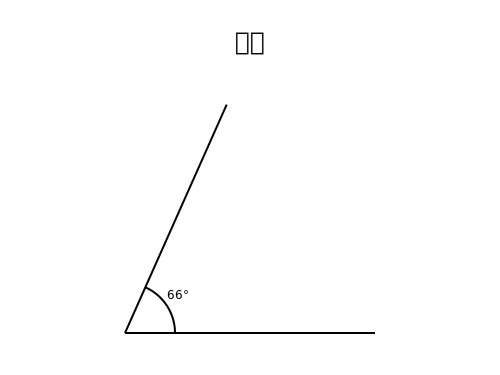

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

예를 들어, 친구가 "나는 35°짜리 각을 그렸고, 그 옆에 또 다른 각을 더해서 60°가 되게 하고 싶어"라고 말했어요. 어떻게 할 수 있을까요?

1. **먼저**, 친구가 그린 35° 각을 기억해봐요.
2. **그 다음**, 60°를 만들기 위해 필요한 각도를 계산해야 해요. 60°에서 이미 그린 35°를 빼면 돼요. 왜냐하면 친구가 이미 그린 각이 있으니까요!
   - 계산: 60° - 35° = 25°

결과적으로 친구는 **25°** 각을 더 그려야 해요. 이렇게 두 각의 크기를 더하거나 빼서 원하는 각도를 만들 수 있어요!

**기억해두세요**:
- **더하기**: 두 각의 크기를 합쳐서 새로운 각을 만듭니다.
- **빼기**: 큰 각에서 작은 각을 빼서 새로운 각을 만듭니다.

이렇게 각도를 조절하면서 다양한 모양을 만들 수 있답니다! 연습해보면 더 재미있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 큰 각에서 작은 각을 빼면 더 작은 각이 만들어져요. 예를 들어, 만약 큰 각이 120도이고 작은 각이 30도라면:

1. 먼저 큰 각인 120도를 확인해요.
2. 그 다음 작은 각인 30도를 빼요: \(120° - 30° = 90°\).

결과적으로 얻어진 각은 90도가 더 작아져서 더 작은 각이 되는 거예요. 이렇게 하면 각도를 조절하거나 비교할 때 유용하게 사용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 네, 맞아요! 두 각을 더하면 더 큰 각을 만들 수 있어요. 예를 들어, 만약 하나의 각이 45도이고 다른 각이 60도라면, 두 각을 합치면 총 105도가 됩니다. 이렇게 하면 더 큰 각을 만들 수 있어요. 각도기를 사용해서 각을 그려보면서 직접 확인해보는 것도 재미있을 거예요! 각의 크기를 눈으로 먼저 대략적으로 보고, 각도기로 정확하게 측정해보면서 더 큰 각이 만들어지는지 확인해보세요. 이렇게 하면 각도에 대해 더 잘 이해할 수 있을 거예요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형에서 세 각의 합이 항상 180°라는 사실을 기억하면 쉽게 나머지 각을 찾을 수 있어요!

예를 들어, 삼각형의 두 각이 각각 60°와 70°라고 가정해봅시다. 이 두 각의 합은 60° + 70° = 130°가 되죠. 그럼 나머지 한 각의 크기는 삼각형의 모든 각의 합인 180°에서 이 두 각의 합을 빼면 됩니다:

180° - 130° = 50°

따라서 나머지 한 각의 크기는 50°가 됩니다. 이렇게 삼각형의 세 각을 알면, 어떤 각이 주어지더라도 나머지 두 각의 크기를 쉽게 계산할 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 삼각형을 그릴 때 재미있는 점 중 하나는 그 삼각형의 세 각의 크기를 합치면 항상 180°가 된다는 거예요! 

예를 들어, 삼각형 ABC를 그려봅시다. 각 A, B, C가 각각 어떤 크기인지 알아봅시다.

1. **각도기 사용하기**: 먼저 각도기를 준비해요. 각도기는 직각(90°)을 기준으로 각도를 측정할 수 있게 해줍니다.
2. **각 그리기**: 자를 이용해 삼각형의 한 변을 그립니다. 그 변의 끝점을 꼭짓점으로 하고, 각도기를 사용해 각 A를 측정하고 표시해요. 같은 방법으로 각 B와 각 C도 그려봅니다.
3. **각 합 확인하기**: 이제 각 A, B, C를 모두 더해봅시다. 만약 각 A가 60°, 각 B가 70°, 각 C가 50°라면, 60° + 70° + 50° = 180°가 됩니다.

이렇게 삼각형의 세 각을 모두 더하면 항상 180°가 되는 거예요. 이렇게 삼각형의 각 성질을 이해하면 삼각형을 그릴 때나 각도를 계산할 때 유용하게 쓰일 수 있어요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형의 네 각이 모두 같은 크기를 가지면 각각은 90°가 되지만, 만약 세 각의 크기가 주어졌다면 나머지 한 각의 크기를 쉽게 구할 수 있어요!

예를 들어, 사각형의 세 각이 각각 100°, 80°, 그리고 100°라고 가정해봅시다. 이때, 사각형의 모든 각의 합은 항상 360°여야 하니까:

\[ 100° + 80° + 100° + \text{(나머지 한 각)} = 360° \]

이 식을 풀면 나머지 한 각의 크기를 알 수 있어요:

\[ \text{(나머지 한 각)} = 360° - (100° + 80° + 100°) \]
\[ \text{(나머지 한 각)} = 360° - 280° \]
\[ \text{(나머지 한 각)} = 80° \]

따라서, 주어진 세 각의 합이 280°라면 나머지 한 각의 크기는 80°가 됩니다. 이렇게 사각형의 모든 각의 합이 항상 360°라는 사실을 이용하면 쉽게 나머지 각의 크기를 구할 수 있어요!

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 사각형을 그릴 때 각 꼭짓점에서 두 변이 만나는 각들을 생각해봅시다. 사각형은 네 개의 꼭짓점을 가지고 있어요. 각 꼭짓점에서 두 변이 만나면서 만들어지는 각들을 하나씩 살펴보면:

1. 첫 번째 꼭짓점에서 시작해보면, 그 꼭짓점에서 두 변이 만나서 만들어지는 각을 A라고 합시다.
2. 다음 꼭짓점에서는 또 다른 각 B가 생깁니다. 이 각 B는 A와 함께 만나는 변이 다르므로, A와 B는 서로 다른 각이에요.
3. 세 번째 꼭짓점에서는 각 C가 생기고, 마지막 꼭짓점에서는 각 D가 만들어집니다.

이제 각 A, B, C, D의 합을 구해봅시다:
- 각 A와 각 B는 서로 맞닿아 있는 변이 다르므로, 이 두 각의 합은 180°가 됩니다 (삼각형의 내각 합이 180°라는 사실을 기억해보세요).
- 마찬가지로 각 C와 각 D도 각각 180°를 합칩니다.

따라서 사각형의 네 각의 합은:
\[ A + B + C + D = 180° + 180° = 360° \]

이렇게 사각형의 네 각의 합이 항상 360°라는 것을 확인할 수 있어요! 이렇게 각을 나누고 합을 구하는 것은 사각형의 특성을 이해하는 데 도움이 됩니다.

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 물론이죠! 삼각형은 세 변의 길이에 따라 크게 세 가지로 나눌 수 있어요:

1. **일반삼각형**: 세 변의 길이가 모두 다른 삼각형이에요. 예를 들어, 한 변은 짧고 다른 두 변은 긴 형태예요. 이렇게 세 변의 길이가 모두 다르면 일반삼각형이라고 부르죠.

2. **이등변삼각형**: 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 나머지 한 변은 밑변과 밑각을 연결하는 **높이** 역할을 해요. 이등변삼각형은 두 밑각이 같고, 그에 따라 두 긴 변이 같은 길이를 가지게 돼요.

3. **정삼각형**: 세 변의 길이가 모두 같은 특별한 삼각형이에요. 모든 변의 길이가 동일하고, 모든 내각의 크기도 같아요. 즉, 세 각 모두 60°가 되어 있어요. 이렇게 세 변이 모두 같은 길이인 삼각형을 정삼각형이라고 부르죠.

이렇게 삼각형은 변의 길이에 따라 일반삼각형, 이등변삼각형, 그리고 정삼각형으로 쉽게 구분할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(변)</text>
    <!-- 아등변삼각형 -->
    <text x="125" y="100" font-size="20" text-anchor="middle">이등변삼각형</text>
    <polygon points="125,125 189.70476127563018,366.4814565722671 60.29523872436984,366.4814565722671" stroke="black"
    stroke-width="2" fill="none"/>
    <!-- 보조선들 -->
 

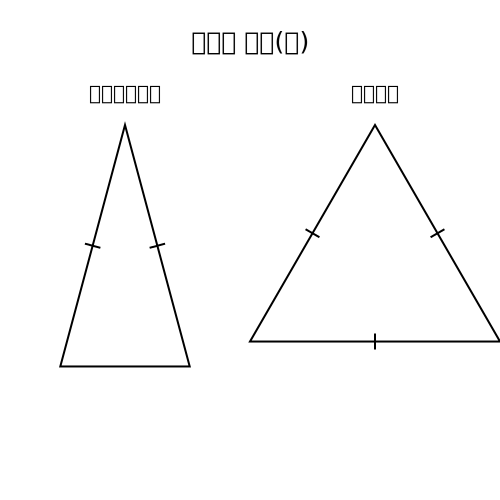

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형 친구야! 이름처럼 두 변의 길이가 똑같아. 마치 친구들이 같은 옷을 입고 있는 것처럼 말이지!

이등변삼각형의 가장 중요한 특징은 **밑변에 마주보는 두 각이 같다는 거야**. 마치 친구들이 서로 같은 표정을 짓고 있는 것처럼! 이 두 각을 **밑각**이라고 부르고, 이등변삼각형의 밑변을 **밑변**이라고 해.

이등변삼각형을 그릴 때는 밑변을 먼저 그린 후, 밑변 양쪽 끝점에서 같은 길이의 선을 그어 밑각을 만들면 돼. 그 다음 밑각을 잇는 선이 이등변삼각형의 나머지 두 변이 되는 거지!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"
        y1="247.81128064695372"
        x2="209.92021275187236"
        y2="243.67017

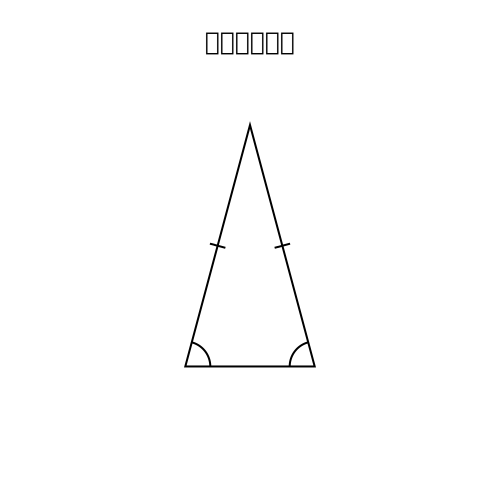

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 이등변삼각형은 특별한 삼각형으로, 두 변의 길이가 같아요! 이 두 같은 길이의 변을 **밑변**이라고 부르고, 그 사이에 있는 각을 **밑각**이라고 해요. 이등변삼각형의 가장 중요한 특징은 **밑각이 같다**는 거예요. 즉, 밑변 양쪽 끝에 있는 각도가 동일하게 크다는 거죠.

예를 들어, 만약 한 이등변삼각형에서 밑변의 한쪽 끝에서 45도의 각이 있다면, 다른 밑변의 끝에서도 정확히 45도의 각이 생기게 돼요. 이렇게 같은 길이의 두 변이 있고 그 사이의 각도가 같기 때문에, 이등변삼각형은 대칭적인 모양을 가지게 돼요.

이런 성질 덕분에 이등변삼각형은 다양한 도형을 그리거나 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 두 밑각을 알면 밑변의 길이를 쉽게 구할 수 있고, 밑변과 밑각을 이용해 높이를 구하는 것도 가능해요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2"

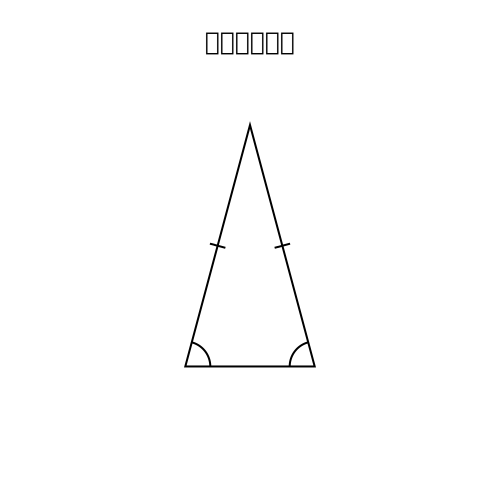

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 네, 맞습니다!  

**이등변삼각형 그리는 방법**을 간단하게 설명해 드릴게요.

1. **기준선 그리기:** 먼저, 직선을 그립니다. 이 직선이 이등변삼각형의 밑변이 될 거예요.

2. **꼭짓점 정하기:** 직선 위에 삼각형의 꼭짓점을 하나 정합니다.

3. **같은 각 그리기:** 꼭짓점에서 직선 양쪽으로 같은 각도로 선을 그립니다. 예를 들어, 꼭짓점에서 왼쪽으로 45도, 오른쪽으로도 45도 각도로 선을 그려보세요.

4. **끝점 연결:** 양쪽으로 그린 선이 만나는 지점을 잘 연결하면 이등변삼각형이 완성됩니다!

**핵심은 두 변의 길이가 같다는 거예요.** 이렇게 그리면 삼각형의 두 밑변이 같은 길이가 되고, 그에 따라 두 끝각도 같아집니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="290.0797872481276"
        y1="243.6701759253134"
        x2="274.62497402750256"
        y2="247.81128064695372"
        stroke="black" stroke-width="2" />
        <line x1="225.37502597249747"

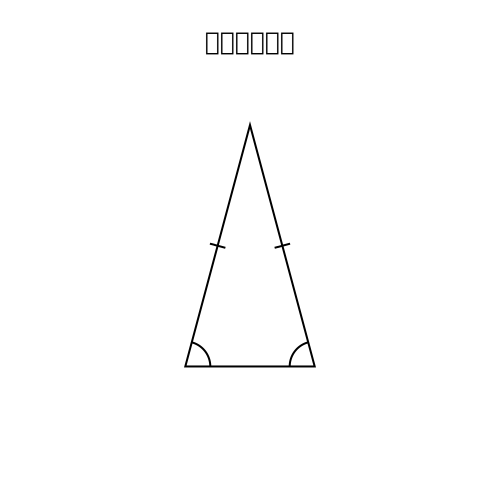

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 특별한 삼각형으로, 세 변의 길이가 모두 같고 세 각의 크기도 모두 같아요. 이 세 각은 각각 60°로 이루어져 있어요. 이렇게 모든 변이 같고 모든 각이 같은 특성 때문에 정삼각형은 매우 대칭적이고 균형 잡힌 모양이에요.

### 활용 방법:
1. **각 그리기 연습**:
   - **각도기 사용**: 자를 이용해 기준선을 그린 후, 한 점을 꼭짓점으로 하여 각도기를 이용해 60° 각을 그려보세요. 이렇게 그린 각을 이용해 정삼각형의 각을 만들 수 있어요.
   - **눈대중으로 그리기**: 각도기 없이도 눈대중으로 각을 그려보세요. 예를 들어, 종이를 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 60° 각을 만들어 보세요. 이렇게 하면 실제 각도와 비교하며 정확성을 높일 수 있어요.

2. **정삼각형 만들기**:
   - **변의 길이 맞추기**: 세 변의 길이를 모두 같게 맞추세요. 컴퍼스를 이용해 같은 길이의 선분을 세 개 그려보세요. 이렇게 그린 세 선분을 꼭짓점에서 연결하면 정삼각형이 완성됩니다.
   - **사각형에서 정삼각형으로**: 사각형의 한 변을 기준으로 그 변을 중심으로 반으로 접어서 직각을 만들고, 그 직각을 기준으로 다시 접어서 정삼각형을 만들어 보세요. 이렇게 하면 사각형의 한 변이 정삼각형의 한 변이 되는 것을 볼 수 있어요.

이렇게 정삼각형의 기본 성질을 이해하고 활용하면, 다양한 도형 그리기와 각도 이해에 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375

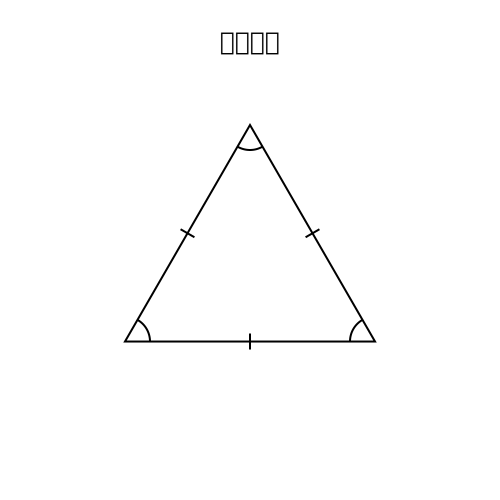

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 정말 특별한 삼각형이에요! 마치 세 개의 친구가 손을 잡고 완벽하게 둥근 모양으로 서 있는 것 같아요. 

**핵심은 세 변의 길이가 모두 같다는 거예요.**  

예를 들어, 세 변의 길이가 모두 5cm라면, 정삼각형의 세 변은 모두 5cm 길이가 되는 거죠.  

그리고 세 각의 크기도 모두 같아요. 각각의 각은 정확히 60도예요. 마치 세 개의 똑같은 각도가 모여 하나의 큰 각을 이루는 것처럼요!

정삼각형을 그리려면 간단해요. 먼저 한 변을 그립니다. 그 다음, 그 변을 기준으로 같은 길이의 선분을 두 개 더 그려주면 돼요. 이렇게 세 변이 만나면 정삼각형 완성!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097"
      

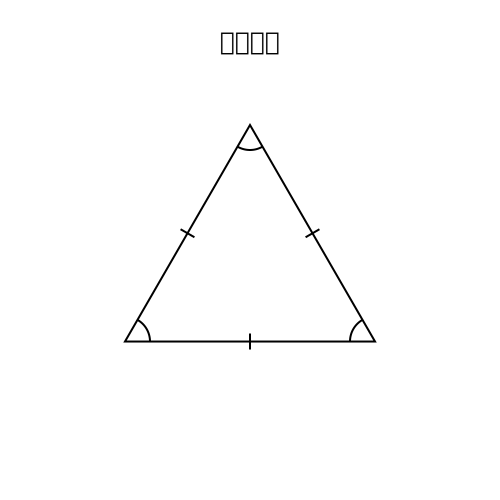

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 네, 맞아요!  

정삼각형을 그리려면 이렇게 해보세요.

1. **선분 그리기**: 먼저 종이에 선분을 하나 그립니다. 이 선분이 정삼각형의 한 변이 될 거예요.

2. **각 그리기**: 선분의 양 끝점에서 각각 마주보는 방향으로 선을 그립니다. 이때 각도는 정확히 **60도**로 맞춰주세요. 마치 시계 방향으로 60도를 돌리는 것처럼요!

3. **삼각형 완성**: 두 선이 만나는 지점을 꼭짓점으로 하고, 세 점을 연결하면 정삼각형이 완성됩니다!

정삼각형은 세 변의 길이가 모두 같고, 세 각이 모두 **60도**인 특별한 삼각형이에요. 이렇게 쉽게 그릴 수 있다니 멋지죠? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <line x1="319.4282032302755" y1="229.25317547305482"
        x2="305.5717967697245" y2="237.25317547305482"
        stroke="black" stroke-width="2" />
        <line x1="250.00000000000003" y1="333.5063509461097"
        x2="250.00000000000003" y2="349.5063509461097

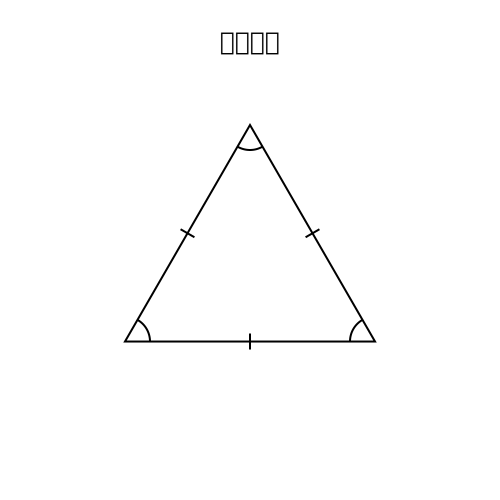

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 예각삼각형은 삼각형의 세 각 모두가 예각, 즉 각각이 90°보다 작은 각인 삼각형을 말해요! 

**예각삼각형을 알아보는 방법:**

1. **각도 확인하기:** 삼각형의 세 각을 잘 살펴보세요. 만약 세 각 모두가 90°보다 작다면 예각삼각형이에요! 각도기를 사용하면 정확하게 확인할 수 있어요.

**예각삼각형의 특징:**

* **모든 각이 예각:** 세 각 모두 뾰족하게 굽어 있어요.
* **가장 긴 변은 빗변보다 짧다:** 예각삼각형에서 가장 긴 변은 빗변(직각삼각형에서 직각을 이루는 변)보다 짧아요.
* **정삼각형은 특별한 예각삼각형:** 세 변의 길이가 모두 같고 세 각이 모두 같은 크기인 특별한 예각삼각형이에요.

예각삼각형은 일상생활에서도 찾아볼 수 있어요! 예를 들어, 삼각형 모양의 지붕이나 삼각형 모양의 장난감 등이 있죠. 이런 삼각형들은 모두 세 각이 모두 예각이에요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


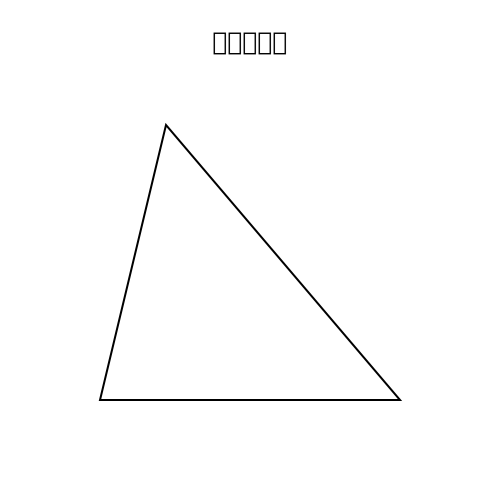

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 물론이죠! 삼각형을 이해하는 데 있어 각의 크기에 따라 어떻게 분류하는지 쉽게 설명해 드리겠습니다.

1. **예각삼각형**: 이 삼각형은 세 각 모두가 **예각**입니다. 예각이란 0°에서 90° 사이의 각을 말해요. 즉, 삼각형 안의 모든 각이 둥글게 굽어 있는 모양이에요. 예를 들어, 세 각이 각각 30°, 45°, 105°인 삼각형은 예각삼각형이에요.

2. **직각삼각형**: 이 삼각형은 **한 각이 정확히 직각**인 경우예요. 직각은 정확히 90°인 각을 의미해요. 나머지 두 각은 예각이거나 둔각일 수 있어요. 예를 들어, 한 각이 정확히 90°인 삼각형은 직각삼각형이에요.

3. **둔각삼각형**: 이 삼각형은 **한 각이 둔각**인 경우예요. 둔각이란 90°보다 큰 각을 말해요. 즉, 삼각형 안에 한 각이 둥글게 굽어 있고 그 외의 두 각은 예각이거나 직각일 수 있어요. 예를 들어, 한 각이 120°인 삼각형은 둔각삼각형이에요.

이렇게 삼각형의 각 크기를 보면서 쉽게 분류할 수 있어요. 각의 크기를 잘 살펴보면 어떤 종류의 삼각형인지 쉽게 알 수 있답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="250" y="100" 

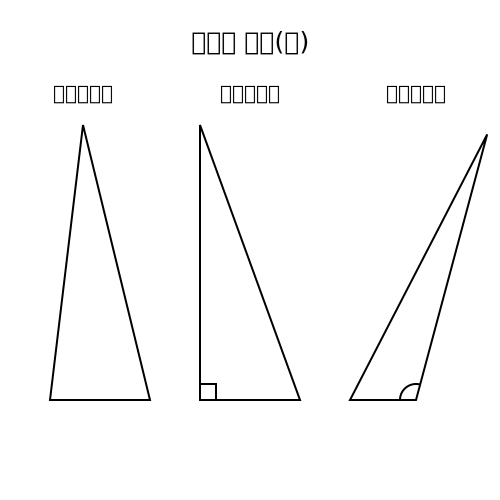

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 둔각삼각형은 삼각형의 세 각 중 하나가 **둔각**인 특별한 종류의 삼각형이에요! 

**어떻게 구별할까요?**

* **둔각이란?** 직각보다 큰 각을 말해요. 예를 들어, 90°보다 큰 각이 바로 둔각이랍니다.

* **둔각삼각형 찾기:** 삼각형의 한 각이 다른 두 각보다 **크게** 보이면 그 삼각형은 둔각삼각형일 가능성이 높아요!

**둔각삼각형의 특징은 무엇일까요?**

1. **한 각이 둔각:** 삼각형의 어느 한 각이 90°보다 크게 열려 있어요.

2. **다른 두 각은 예각:** 나머지 두 각은 모두 예각(직각보다 작은 각)이에요.

3. **가장 긴 변은 둔각에 대응:** 둔각이 있는 변은 삼각형에서 가장 긴 변이에요. 마치 둔각이 삼각형을 "넓게" 만드는 것처럼요!

**예시:**

상상해봐요! 삼각형 모양의 케이크를 그렸다고 해요. 만약 케이크의 한 모서리가 다른 두 모서리보다 훨씬 크게 열려 있다면, 그 삼각형은 둔각삼각형이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


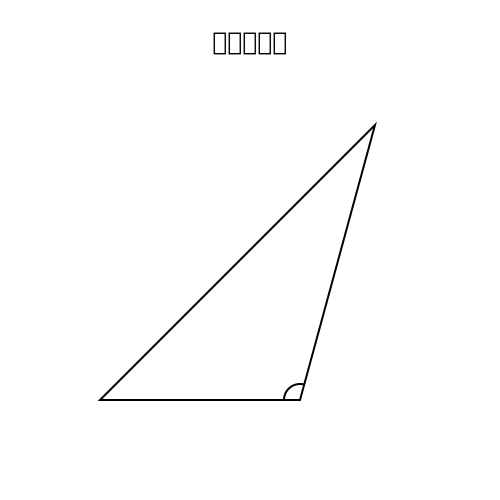

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 물론이죠! 주어진 점에서 직선에 수선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **삼각자 사용하기**:
   - 삼각자를 준비합니다. 삼각자의 직각 부분(90° 표시)을 먼저 직선에 맞춥니다.
   - 그 다음, 직선 위의 한 점을 삼각자의 직각 부분 위에 정확히 맞춥니다.
   - 마지막으로, 삼각자의 다른 변을 따라 그 점에서 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

2. **각도기 사용하기**:
   - 각도기를 준비합니다. 각도기의 중심을 직선 위의 한 점에 맞춥니다.
   - 각도기의 90° 선을 점에 맞춥니다. 이는 직선과 수직인 위치를 나타냅니다.
   - 그 점에서 직선 방향으로 각도기의 다른 선을 따라 수직으로 선을 그립니다. 이렇게 하면 주어진 점에서 직선에 정확히 수선이 그려집니다.

이렇게 두 가지 방법으로 주어진 점에서 직선에 정확히 수선을 그릴 수 있습니다. 중요한 것은 정확한 위치 맞추기와 수직 그리기입니다. 연습을 통해 점점 더 정확하게 수선을 그릴 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
    

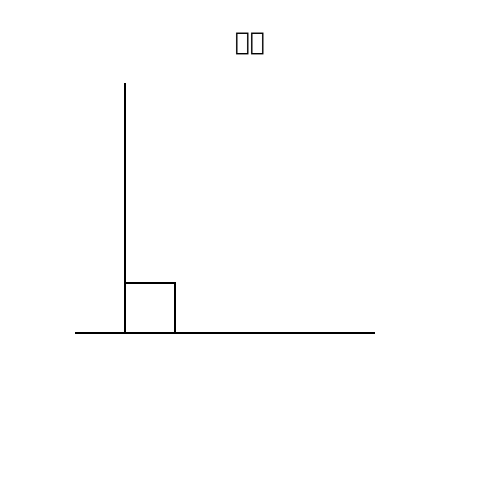

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 수직이란 두 직선이 만나서 만드는 각이 정확히 90도인 상황을 말해요! 마치 종이를 접어서 평평하게 펴놓은 것처럼, 종이가 반듯하게 접히면 생기는 각이 바로 수직이에요.

예를 들어, 책상 위에 놓인 책을 보세요. 책의 모서리가 수직으로 세워져 있죠? 책 모서리와 책상 바닥이 만나는 부분이 바로 수직의 예랍니다.

도형에서 수직선을 찾거나 그릴 때는 이렇게 생각하면 돼요:

1. **삼각자 사용**: 삼각자를 종이에 대고 직각 부분을 기준선에 맞춥니다. 그 다음, 원하는 위치로 삼각자를 움직여 수직선을 그립니다.
2. **각도기 사용**: 각도기의 중심을 기준선 위의 한 점에 맞춥니다. 각도기의 90도 표시선을 그 점에서 따라 수직선을 그립니다.

이렇게 하면 종이 위에 수직선을 쉽게 그릴 수 있어요! 수직선은 직각삼각형이나 사각형의 모서리에서 자주 볼 수 있어요. 이런 선들을 잘 찾아보면서 수직의 개념을 더 잘 이해해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" stroke-width="2" />
        <!-- 직각 보조선 -->
        <polyline points="175.0, 333 175.0, 283 125.00000000000001 28

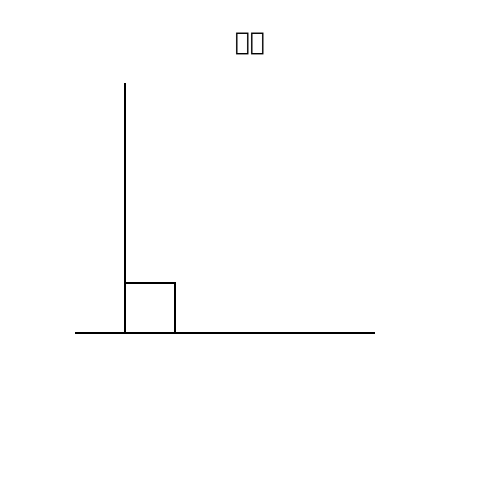

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 물론이죠! 삼각자를 이용해 평행선을 그리는 방법을 간단하게 설명해 드리겠습니다.

1. **기준선 그리기**: 먼저, 종이에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.

2. **삼각자 맞추기**: 삼각자의 직각 부분을 기준선 위에 정확히 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 평행선 그리기**: 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이때, 삼각자의 변이 기준선과 수직이므로, 그린 선은 기준선과 평행하게 됩니다.

4. **두 번째 평행선 그리기**: 이제 삼각자를 다시 사용하지만, 이번에는 삼각자의 직각 부분을 첫 번째 평행선 위에 맞춥니다. 삼각자의 다른 변을 따라 종이 위로 평행하게 선을 그립니다. 이렇게 하면 첫 번째 평행선과 정확히 같은 거리에 두 번째 평행선이 그려집니다.

이렇게 하면 기준선과 평행한 두 직선을 정확하게 그릴 수 있습니다. 중요한 건 삼각자를 항상 기준선과 수직으로 맞추는 것입니다. 이렇게 하면 두 선이 항상 평행하게 유지됩니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375"

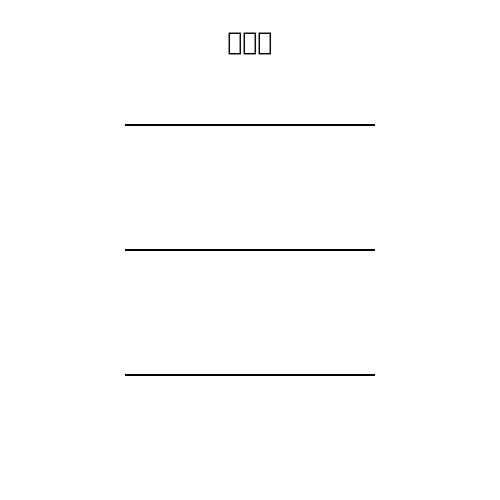

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 자와 삼각자를 이용해 주어진 거리만큼 떨어진 평행선을 그리는 방법은 다음과 같습니다:

1. **기준선 그리기**: 먼저, 종이 위에 원하는 위치에 기준선을 그립니다. 이 기준선이 평행선을 그릴 시작점이 됩니다.

2. **삼각자 준비**: 삼각자를 준비합니다. 삼각자의 직각 부분을 기준선에 맞춥니다. 이렇게 하면 삼각자의 한 변이 기준선과 수직이 됩니다.

3. **첫 번째 점 표시**: 삼각자의 직각 부분이 기준선과 수직인 변을 따라, 주어진 거리만큼 떨어진 곳에 점을 표시합니다. 이 점이 첫 번째 평행선을 그릴 시작점이 됩니다.

4. **두 번째 평행선 그리기**: 삼각자를 다시 준비하고, 이번에는 삼각자의 직각 부분을 이전 점에 맞춥니다. 삼각자의 다른 변을 따라, 이전 점에서 주어진 거리만큼 떨어진 곳에 또 다른 점을 표시합니다. 이 점을 연결하여 두 번째 평행선을 그립니다.

이렇게 하면 기준선과 주어진 거리만큼 떨어진 두 개의 평행선이 완성됩니다. 중요한 점은 두 평행선이 항상 같은 방향으로 끝없이 뻗어나가며 만나지 않는다는 것입니다. 이렇게 하면 학생들은 직선과 각도의 개념을 이해하는 데 도움이 될 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width=

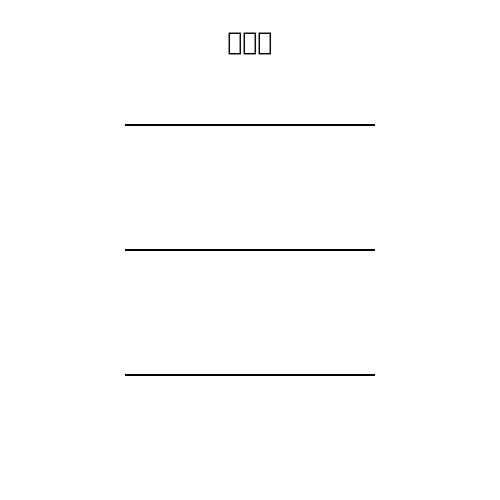

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 평행선이란 두 직선이 만나지 않고, 같은 방향으로 무한히 뻗어나가는 직선들을 말해요. 쉽게 말해, 두 직선이 서로 마주치지 않고 항상 같은 거리에 있으면서 같은 방향으로 계속 이어지는 거예요.

예를 들어, 책의 표지와 안쪽 페이지 사이의 선이나, 도로 위의 두 평행한 선을 생각해보세요. 이 두 선은 만나지 않고 항상 같은 거리를 유지하며 앞으로 계속 뻗어나가요.

구별하는 방법은 간단해요:
1. **두 직선이 만나지 않는지 확인**: 만약 두 직선이 서로 교차하지 않는다면, 그들은 평행할 가능성이 높아요.
2. **방향 확인**: 두 직선이 같은 방향으로 무한히 이어지는지 살펴보세요. 만약 같은 방향으로 계속 이어진다면 그것이 바로 평행선이에요.

이렇게 이해하면 평행선을 쉽게 알아볼 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        </svg>
        


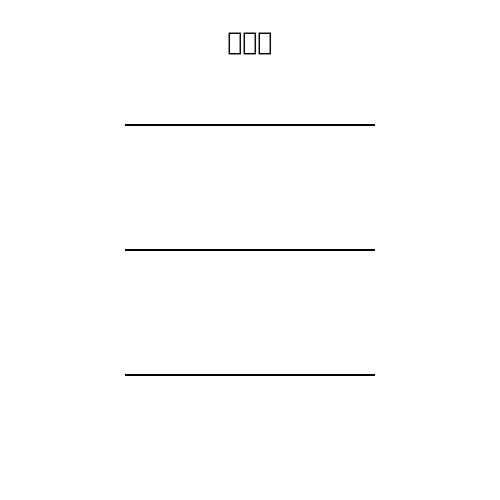

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 물론이죠! 평행선 사이의 거리를 측정하고 이해하는 방법을 간단하게 설명해 드리겠습니다.

### 평행선 사이의 거리 측정하기

1. **준비물**: 삼각자와 각도기가 필요합니다. 삼각자는 직각을 만들 때 유용하고, 각도기는 정확한 각도를 재는 데 사용됩니다.

2. **단계**:
   - **기준선 그리기**: 먼저 평평한 표면에 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   - **첫 번째 평행선 그리기**: 삼각자의 직각 부분을 기준선에 맞추고, 다른 변을 따라 평행한 직선을 그립니다. 이 직선이 첫 번째 평행선이 됩니다.
   - **두 번째 평행선 그리기**: 삼각자를 다시 사용하여 첫 번째 평행선 위의 한 점을 기준으로, 삼각자의 직각 부분을 평행선과 수직으로 맞춥니다. 그리고 다른 변을 따라 두 번째 평행선을 그립니다.
   - **수선 그리기**: 첫 번째 평행선 위의 한 점에서 두 번째 평행선까지 수직으로 선을 그립니다. 이 선이 바로 평행선 사이의 거리를 나타내는 수선입니다.
   - **거리 측정**: 수선의 길이를 측정합니다. 이 길이가 바로 두 평행선 사이의 거리입니다.

### 이해하기

- **평행**: 두 직선이 만나지 않고 같은 방향으로 끝없이 뻗어가는 것을 말합니다.
- **수직**: 두 직선이 만나는 각이 정확히 90°인 경우를 의미합니다.
- **수선**: 주어진 점에서 직선에 수직으로 그은 선을 말합니다. 이 수선의 길이가 바로 평행선 사이의 거리를 알려줍니다.

이렇게 하면 학생들도 쉽게 평행선 사이의 거리를 측정하고 이해할 수 있을 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선

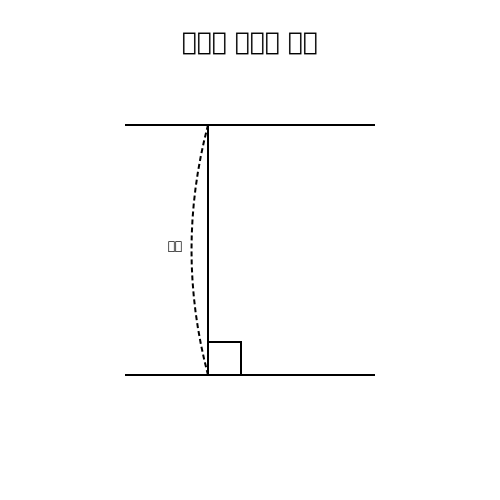

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 직사각형은 특별한 종류의 사각형으로, 몇 가지 중요한 특징이 있어요!

**직사각형의 정의:**

직사각형은 네 개의 각이 모두 **직각** (90°)인 사각형이에요. 쉽게 말해, 네 모서리가 모두 직각으로 만나는 모양이죠!

**직사각형의 성질:**

* **네 각이 모두 직각:**  각이 모두 90도로 이루어져 있어요.
* **마주보는 두 변의 길이가 같음:**  직사각형에서는 반대편 변들이 길이가 똑같아요. 마치 퍼즐 조각처럼!
* **대변이 평행함:** 직사각형의 반대편 변들은 서로 평행해요. 마치 옆으로 뻗어나가는 두 직선처럼요.
* **둘레 계산:** 직사각형의 둘레는 모든 변의 길이를 더한 거예요.  만약 가로 길이가 'l'이고 세로 길이가 'w'라면, 둘레는 2l + 2w가 됩니다.

**도형 분류하기:**

직사각형은 다른 사각형들과 어떻게 다를까요?

* **직사각형 vs. 정사각형:** 직사각형은 모든 변의 길이가 같지 않지만, 정사각형은 모든 변의 길이가 **정확히** 같아요. 마치 정사각형은 완벽한 정사각형 퍼즐 같죠!
* **직사각형 vs. 평행사변형:** 평행사변형은 마주보는 변이 평행하지만, 모든 각이 직각일 필요는 없어요. 직사각형은 평행사변형의 특별한 경우라고 생각하면 돼요!

직사각형을 잘 이해하면 다른 사각형들도 쉽게 구분할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
        <!-- 

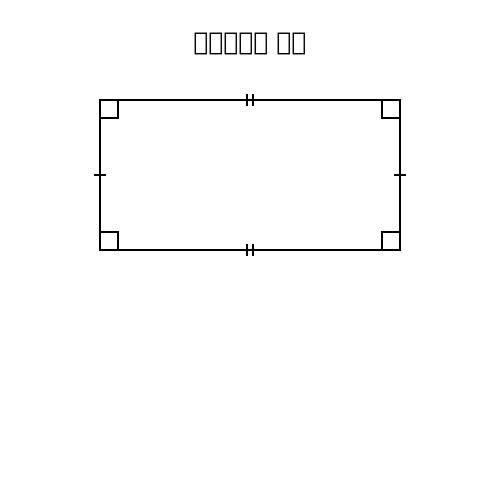

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 면이 똑같이 중요한 역할을 합니다!

**정의와 특징:**
- **정의:** 정사각형은 네 변의 길이가 모두 같고, 네 각이 모두 직각(90°)인 사각형입니다.
- **변:** 정사각형은 네 개의 변을 가지고 있으며, 이 모든 변의 길이가 정확히 같아요. 마치 친구들이 모두 같은 길이의 줄을 가지고 있는 것처럼요!
- **각:** 네 각 모두 정확히 90°로 직각입니다. 그래서 정사각형은 네 개의 직각이 있는 특별한 도형이에요.
- **대각선:** 정사각형의 대각선은 서로를 이등분합니다. 즉, 대각선을 그으면 그 대각선은 정사각형을 두 개의 동일한 직각삼각형으로 나눕니다. 대각선의 길이는 변의 길이와 같아요.

**다른 사각형과의 차이점:**
- **직사각형:** 직사각형도 네 각이 모두 직각이지만, 변의 길이가 모두 같지 않아요. 정사각형은 모든 변의 길이가 동일한 반면, 직사각형은 마주보는 변의 길이가 같을 뿐 다른 변들은 다를 수 있어요.
- **평행사변형:** 평행사변형은 마주보는 변들이 평행하지만, 각 변의 길이나 각의 크기는 모두 같지 않을 수 있어요. 정사각형은 모든 면이 동일한 크기와 각도로 이루어져 있어 평행사변형보다 더 특별해요.
- **일반 사각형:** 일반 사각형은 변의 길이나 각의 크기가 모두 같지 않은 사각형을 말해요. 정사각형은 이들 중에서도 변과 각이 완벽하게 일치하는 가장 규칙적인 형태입니다.

이렇게 정사각형은 모든 면이 똑같이 맞춰져 있어 다른 사각형들과 쉽게 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect 

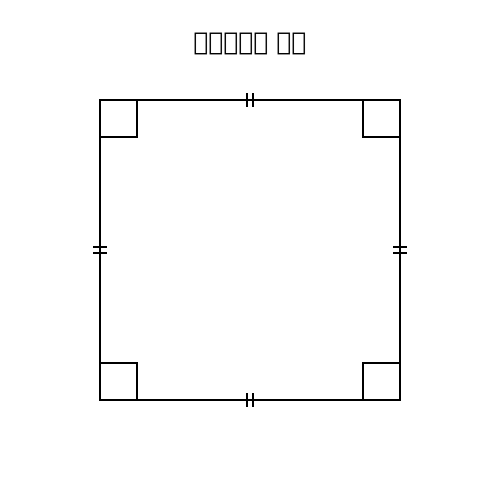

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 안녕하세요! 오늘은 실생활에서 직사각형과 정사각형의 성질을 활용해 문제를 해결해 보는 시간을 가져볼게요.

### 문제 예시: 정원 만들기

**상황:**
당신이 작은 정원을 만들려고 합니다. 정원의 한쪽 벽은 정사각형 모양으로, 다른 벽은 직사각형 모양으로 계획하고 있습니다. 정사각형 벽의 한 변의 길이는 5미터이고, 직사각형 벽의 길이는 8미터이고 너비는 3미터입니다.

**목표:**
1. **정사각형 벽의 둘레 계산하기:** 정사각형의 네 변의 길이가 모두 같으므로, 둘레는 한 변의 길이를 4로 곱한 값입니다.
   - 계산: \(5 \, \text{미터} \times 4 = 20 \, \text{미터}\)
   - **해답:** 정사각형 벽의 둘레는 총 20미터입니다.

2. **직사각형 벽의 둘레 계산하기:** 직사각형의 둘레는 길이와 너비를 각각 더한 후 곱한 값에서 두 길이의 합을 뺀 값입니다.
   - 계산: \((8 \, \text{미터} + 3 \, \text{미터}) \times 2 = 16 \, \text{미터} + 6 \, \text{미터} = 22 \, \text{미터}\)
   - **해답:** 직사각형 벽의 둘레는 총 22미터입니다.

3. **정원 전체 둘레 계산하기:** 정원의 전체 둘레는 정사각형 벽의 둘레와 직사각형 벽의 둘레를 더한 값입니다.
   - 계산: \(20 \, \text{미터} + 22 \, \text{미터} = 42 \, \text{미터}\)
   - **해답:** 정원 전체 둘레는 42미터입니다.

이렇게 직사각형과 정사각형의 기본적인 성질을 이용해 정원의 둘레를 계산할 수 있습니다. 이런 방식으로 실생활에서 도형의 성질을 활용하면 공간 계획이나 건축 등 다양한 상황에서 도움이 될 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="htt

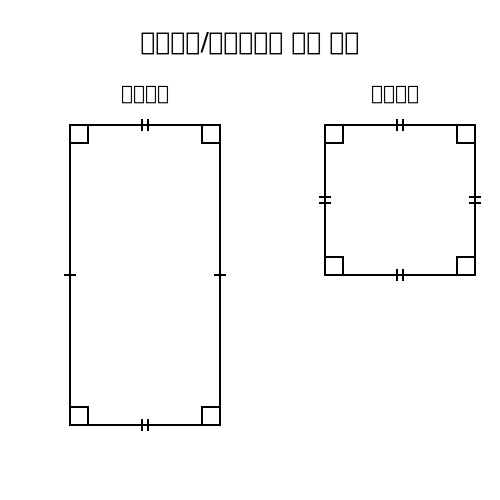

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 사다리꼴은 특별한 종류의 사각형으로, **두 쌍의 변이 평행**하다는 특징이 있어요! 

쉽게 말해, 사다리꼴은 마치 계단처럼 생겼는데, 계단의 평평한 부분이 평행한 두 변이에요. 

**기본 성질 몇 가지를 알려줄게요:**

* **평행한 변의 길이가 다를 수 있어요:**  계단의 평평한 부분의 길이가 다르듯이, 사다리꼴의 평행한 변들은 길이가 다를 수 있어요.
* **빗변은 평행하지 않아요:** 사다리꼴의 빗변은 평행한 두 변과 만나는 변이 아니에요. 빗변은 다른 두 변과 만나는 선분이에요.
* **밑변과 윗변의 길이는 달라요:** 사다리꼴의 밑변과 윗변은 평행하지 않기 때문에 길이가 다를 수 있어요.

사다리꼴을 보면서 평행한 변과 밑변, 윗변의 길이 차이를 찾아보세요! 재미있게 배울 수 있을 거예요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">사다리꼴</text>
        <polygon points="166,125 332,125 415,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


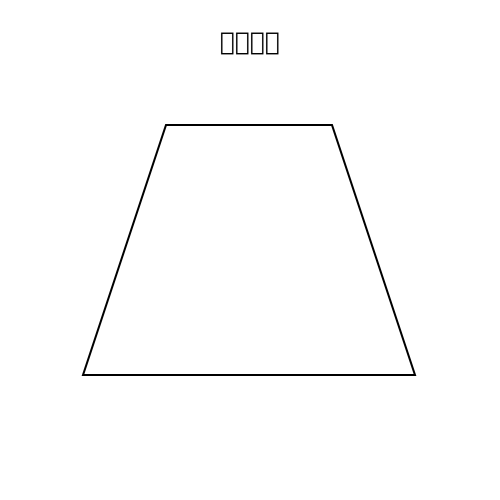

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형을 이해하는 데 도움이 되는 몇 가지 기본 개념을 알려드릴게요!

1. **평행한 변**: 평행사변형의 가장 중요한 특징은 **두 쌍의 변이 서로 평행**하다는 거예요. 즉, 한 쌍의 변은 다른 쌍과 항상 같은 방향으로 평행하게 뻗어 있어요. 마치 두 개의 거울이 서로 평행하게 놓여 있는 것처럼요!

2. **마주보는 변의 길이**: 평행사변형에서는 **마주보는 두 변의 길이가 항상 같아요**. 이는 마치 두 개의 문이 서로 마주보고 있을 때, 그 문들의 길이가 같다는 것과 비슷해요.

3. **마주보는 각의 크기**: 평행사변형의 또 다른 중요한 성질은 **마주보는 두 각의 크기가 항상 같아요**. 예를 들어, 한 각이 60도라면 마주보는 각 역시 60도가 되는 거죠. 이는 마치 두 개의 창문이 서로 마주보고 있을 때, 그 창문들의 각도가 같다는 것과 비슷해요.

이런 성질들을 기억하면 평행사변형을 쉽게 구분할 수 있어요. 예를 들어, 사각형을 보았을 때 두 쌍의 변이 서로 평행하고 마주보는 변의 길이가 같다면 그것은 평행사변형일 가능성이 높아요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="

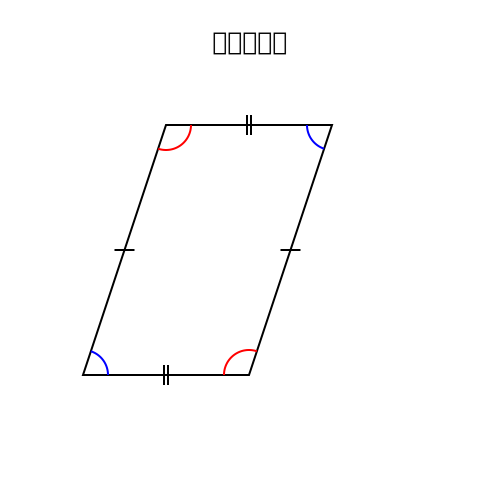

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 평행사변형은 특별한 사각형의 한 종류로, **두 쌍의 대변이 각각 평행한 사각형**입니다. 쉽게 말해, 평행사변형 안에서 한 쌍의 변은 다른 쌍의 변과 항상 같은 방향으로 평행하게 뻗어 있어요.

**특징들을 간단히 살펴보면:**

1. **대변이 평행**: 평행사변형의 가장 중요한 특징은 두 쌍의 대변이 서로 평행하다는 거예요. 그래서 한 쌍의 대변은 길이가 같을 수도 있고 다를 수도 있어요.

2. **대각선이 서로 같은 길이**: 평행사변형의 대각선은 항상 같은 길이를 가지고 있어요. 이는 평행사변형을 쉽게 식별하는 방법 중 하나예요.

3. **대각선이 교차하는 점에서 대칭**: 평행사변형의 대각선은 서로를 반으로 나누는 점에서 만나는데, 이 점을 **중점**이라고 부르죠. 이 중점을 지나는 선은 평행사변형을 두 개의 똑같은 삼각형으로 나누기도 해요.

4. **각의 크기**: 평행사변형의 마주보는 각들은 크기가 같아요. 즉, 한 쌍의 마주보는 각이 60°이면 다른 쌍의 마주보는 각도 역시 60°가 됩니다.

이런 특징들 덕분에 평행사변형은 건축이나 디자인에서 자주 활용되며, 일상생활에서도 쉽게 찾아볼 수 있어요. 예를 들어, 책의 표지나 창문의 모양 등이 평행사변형의 형태를 띠고 있을 수 있어요.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="

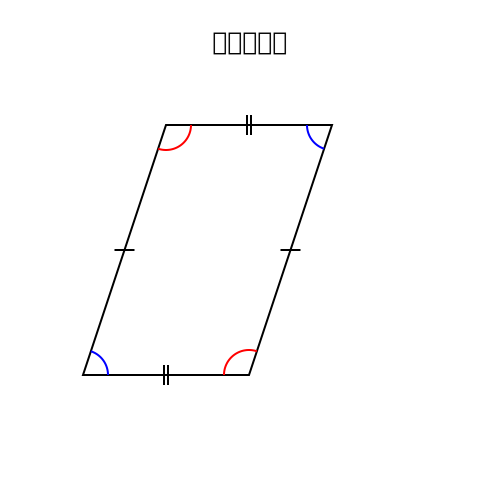

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 종류의 사각형으로, 네 변의 길이가 모두 같아요! 마치 퍼즐 조각처럼 네 모서리가 똑같이 맞춰져 있어요. 

**마름모의 특징:**

* **모든 변 길이가 같아요:**  마름모의 네 변은 길이가 똑같아서 마치 손가락을 펴서 만든 모양 같아요.
* **대각선이 서로 수직이에요:** 마름모를 자르면 생기는 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각을 자르면 생기는 선처럼요!
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요.

**마름모와 다른 사각형 구별하기:**

* **직사각형:** 마름모처럼 네 변의 길이가 같지만, 모든 각이 직각(90°)이에요. 마치 책처럼 평평하게 펼쳐진 모양이죠!
* **정사각형:** 마름모와 비슷하지만, 모든 각이 직각이고 모든 변의 길이도 같아요. 네 모서리가 모두 뾰족하고 둥근 모양이 아니에요. 마치 주사위처럼 완벽하게 정사각형 모양이죠!

마름모는 네 변의 길이가 같다는 특징 때문에 다른 사각형들과 구별할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-wid

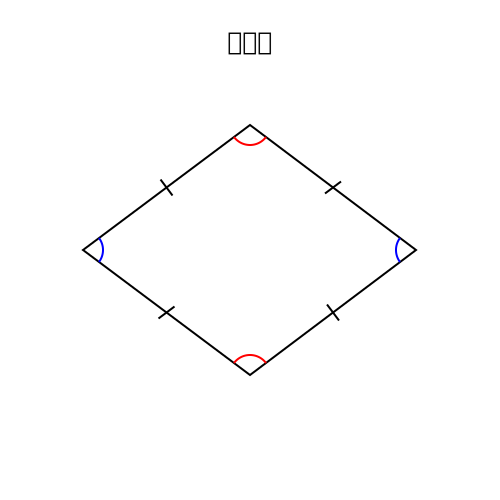

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 마름모는 특별한 사각형으로, 네 변의 길이가 모두 같고 마주보는 각의 크기가 같아요. 가장 중요한 마름모의 대각선 성질은 다음과 같아요:

1. **대각선이 서로를 반으로 나눈다**: 마름모의 대각선은 서로를 정확히 반으로 나누는 선이에요. 즉, 한 대각선을 기준으로 그 대각선을 반으로 자른 선분이 다른 대각선을 반으로 자르게 되어 있어요. 이렇게 되면 마름모 내부는 네 개의 작은 직각삼각형으로 나뉘게 되는데, 각 삼각형의 두 직각변은 대각선의 절반 길이가 되고, 빗변은 마름모의 변의 길이와 같아집니다.

이 성질을 활용하는 방법은 다음과 같아요:
- **길이 측정**: 마름모의 대각선 길이를 알고 있다면, 그 대각선을 반으로 나누어 마름모의 변의 길이를 쉽게 구할 수 있어요. 예를 들어, 대각선의 길이가 10cm라면, 각 변의 길이는 5cm가 됩니다.
- **면적 계산**: 마름모의 면적은 대각선의 길이를 곱한 후 그 값을 2로 나누어 구할 수 있어요. 만약 대각선의 길이가 각각 8cm와 6cm라면, 면적은 \((8 \times 6) / 2 = 24\) 제곱미터가 됩니다.

이렇게 마름모의 대각선 성질을 이해하고 활용하면, 마름모의 변 길이나 면적을 쉽게 계산할 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.49425104299

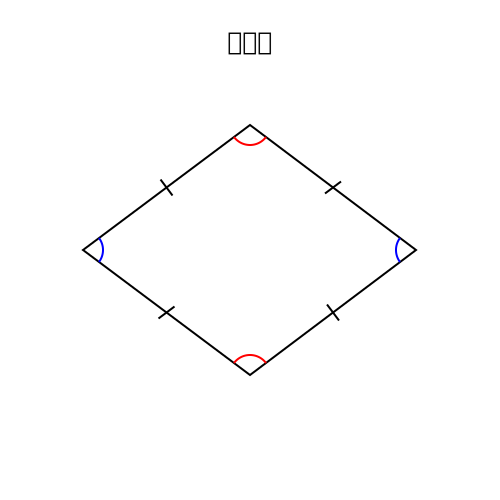

12min 10s ± 21.3 s per loop (mean ± std. dev. of 6 runs, 5 loops each)


In [32]:
%%timeit -n 5 -r 6

import json
# 그래프 호출
for i, user_input in enumerate(input_samples):
    result = app.invoke({"input_section": user_input})
    
    # 결과 출력
    print("입력된 소단원(section):", result["input_section"])
    print("추출된 개념:", result["math_concept"])
    print("\n생성된 설명:\n", result["comments"])
    if "formulas" in result.keys():
        print("\n생성된 공식 raw:\n", result["formulas"])
        show_formulas(result["formulas"])
    if "generated_code" in result.keys():
        print("\n생성된 코드:\n", result["generated_code"])
        show_svg(result["generated_code"])

    print("=" * 100)